In [331]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [316]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler

from sklearn import pipeline
from imblearn.pipeline import Pipeline as imb_make_pipeline
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE

### Загрузим данные и проведем EDA.

In [317]:
df_train = pd.read_csv('train.csv')

In [318]:
df_test = pd.read_csv('test.csv')

In [319]:
df_train.head(3)

ClientPeriod  MonthlySpending TotalSpent   Sex  IsSeniorCitizen HasPartner  \
0            55            19.50    1026.35  Male                0        Yes   
1            72            25.85     1872.2  Male                0        Yes   
2             1            75.90       75.9  Male                0         No   

  HasChild HasPhoneService HasMultiplePhoneNumbers HasInternetService  \
0      Yes             Yes                      No                 No   
1       No             Yes                     Yes                 No   
2       No             Yes                      No        Fiber optic   

  HasOnlineSecurityService      HasOnlineBackup  HasDeviceProtection  \
0      No internet service  No internet service  No internet service   
1      No internet service  No internet service  No internet service   
2                       No                   No                   No   

  HasTechSupportAccess          HasOnlineTV HasMovieSubscription  \
0  No internet service  No internet service  No internet service   
1  No internet service  No internet service  No internet service   
2                  Yes                   No                   No   

  HasContractPhone IsBillingPaperless            PaymentMethod  Churn  
0         One year                 No             Mailed check      0  
1         Two year                 No  Credit card (automatic)      0  
2   Month-to-month                Yes         Electronic check      1

In [320]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Замечаем, что хоть и показывается, что все строки ненулевые, преобразовать колонку TotalSpent не получается, возможно там пустые строки. Проверим это.

In [321]:
df = pd.DataFrame()
for i in range(len(df_train)):
    if (' ' in df_train.iloc[i].values):
        df = df.append({"ClientPeriod": df_train.iloc[i].ClientPeriod,
           "MonthlySpending": df_train.iloc[i].MonthlySpending,
           "TotalSpent":df_train.iloc[i].TotalSpent,
           "Sex":df_train.iloc[i].Sex,
           "IsSeniorCitizen":df_train.iloc[i].IsSeniorCitizen,
           "HasPartner":df_train.iloc[i].HasPartner,
           "HasChild":df_train.iloc[i].HasChild,
           "HasPhoneService":df_train.iloc[i].HasPhoneService,
           "HasMultiplePhoneNumbers":df_train.iloc[i].HasMultiplePhoneNumbers,
           "HasInternetService":df_train.iloc[i].HasInternetService,
           "HasOnlineSecurityService":df_train.iloc[i].HasOnlineSecurityService,
           "HasOnlineBackup":df_train.iloc[i].HasOnlineBackup,
           "HasDeviceProtection":df_train.iloc[i].HasDeviceProtection,
           "HasTechSupportAccess":df_train.iloc[i].HasTechSupportAccess,
           "HasTechSupportAccess":df_train.iloc[i].HasTechSupportAccess,
           "HasOnlineTV":df_train.iloc[i].HasOnlineTV,
           "HasMovieSubscription":df_train.iloc[i].HasMovieSubscription,
           "HasContractPhone":df_train.iloc[i].HasContractPhone,
           "IsBillingPaperless":df_train.iloc[i].IsBillingPaperless,
           "PaymentMethod":df_train.iloc[i].PaymentMethod,
           "Churn":df_train.iloc[i].Churn}, ignore_index=True)

In [322]:
df.head(3)

Churn  ClientPeriod HasChild HasContractPhone  HasDeviceProtection  \
0    0.0           0.0      Yes         Two year  No internet service   
1    0.0           0.0      Yes         Two year                  Yes   
2    0.0           0.0      Yes         One year  No internet service   

  HasInternetService HasMovieSubscription HasMultiplePhoneNumbers  \
0                 No  No internet service                     Yes   
1                DSL                   No                     Yes   
2                 No  No internet service                      No   

       HasOnlineBackup HasOnlineSecurityService          HasOnlineTV  \
0  No internet service      No internet service  No internet service   
1                  Yes                       No                  Yes   
2  No internet service      No internet service  No internet service   

  HasPartner HasPhoneService HasTechSupportAccess IsBillingPaperless  \
0        Yes             Yes  No internet service                 No   
1        Yes             Yes                  Yes                 No   
2        Yes             Yes  No internet service                Yes   

   IsSeniorCitizen  MonthlySpending PaymentMethod     Sex TotalSpent  
0              0.0            25.75  Mailed check    Male             
1              0.0            73.35  Mailed check  Female             
2              0.0            19.70  Mailed check    Male

Код не самый оптимизированный, но зато мы нашли эти пустые строки, которые являются ненулевыми, и в то же время мешают при работе с колонками. Мы видим, что пропуски в колонке TotalSpent, и при этом во всех записях ClientPeriod = 0, следовательно это новые пользователи, у которых еще нет TotalSpent, поэтому заполним пустые строки 0.

In [323]:
df_train.loc[df_train["ClientPeriod"] == 0, ["TotalSpent"]] = 0

In [324]:
df_train['TotalSpent'] = pd.to_numeric(df_train['TotalSpent']) 

In [325]:
df_train.select_dtypes(include=['float64', 'int64']).columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen',
       'Churn'],
      dtype='object')

In [326]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

In [327]:
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

In [328]:
target = 'Churn'

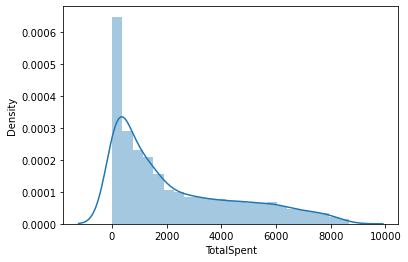

In [332]:
sns_plot = sns.distplot(df_train['TotalSpent'])
fig = sns_plot.get_figure()

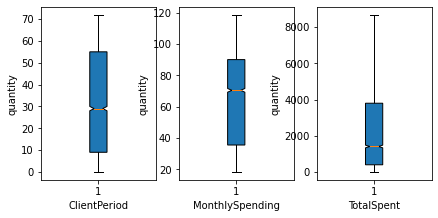

In [135]:
fig = plt.figure(figsize =(7, 7))
for i in range(len(num_cols)):
    plt.subplot(2, 3, i+1)
    plt.boxplot(df_train[num_cols[i]], notch=True, patch_artist=True )
    plt.xlabel(num_cols[i])
    plt.ylabel('quantity')

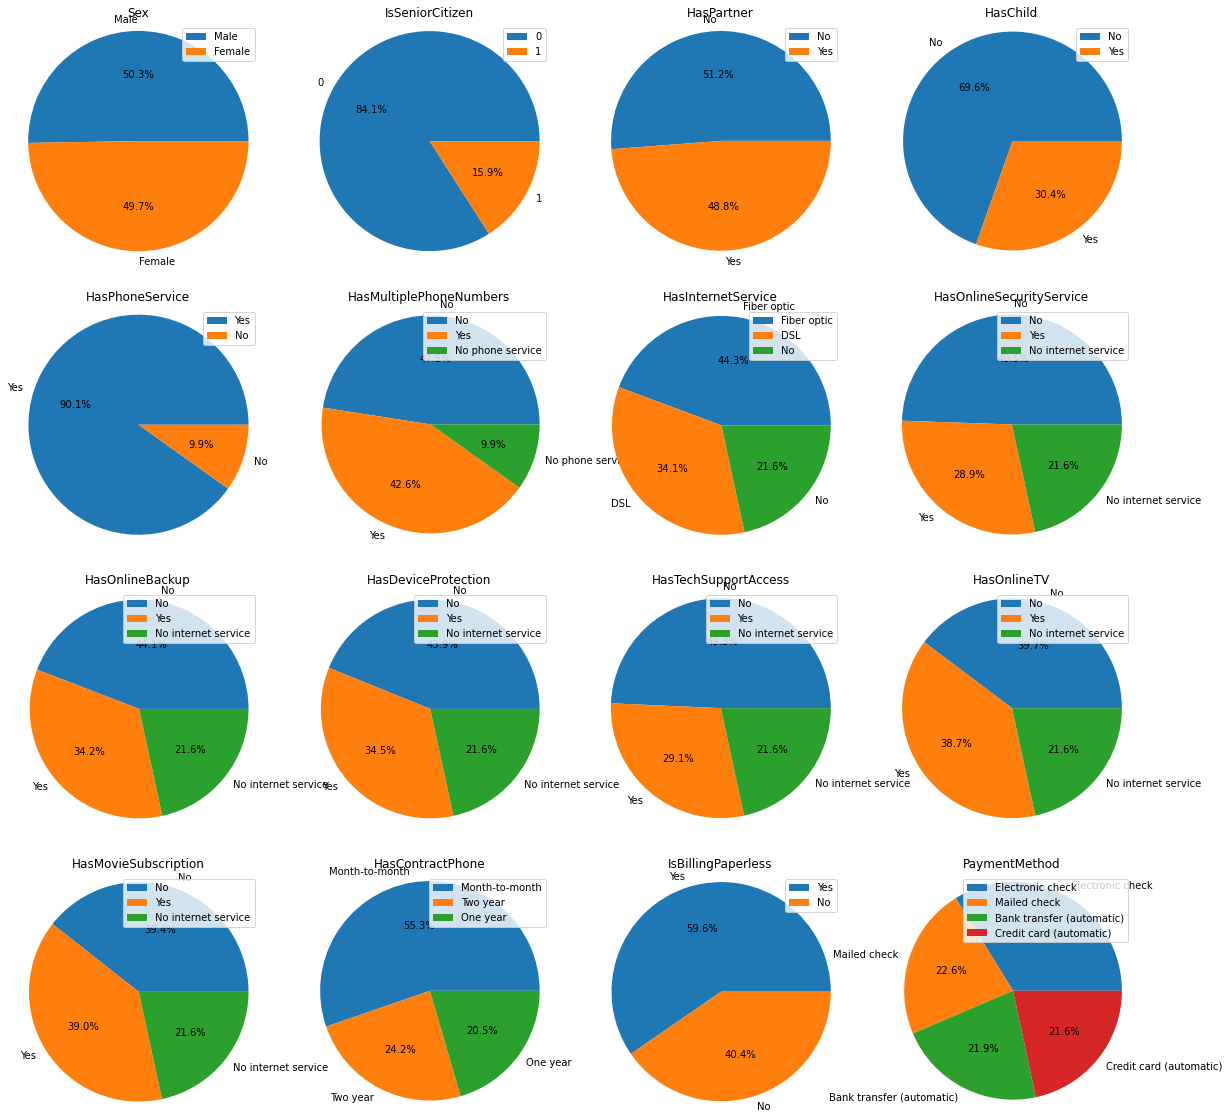

In [137]:
fig = plt.figure(figsize =(20, 20))
for i in range(len(cat_cols)):
    data_i=df_train[cat_cols[i]].value_counts()
    plt.subplot(4,4,i+1)
    plt.pie(data_i, labels = data_i.index, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(cat_cols[i])
    plt.legend()

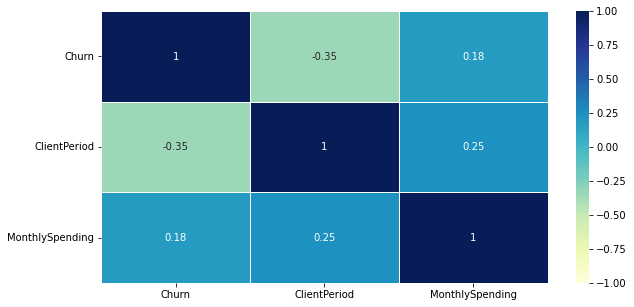

In [17]:
# Стоит не забывать, что корреляция показывает взаимосвязь между данными, но не объясняет ее
corr_matrix = df_train.loc[:, ['Churn']+num_cols].corr()
f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=0.5, cmap = 'YlGnBu', annot=True)
plt.yticks(rotation = 0)
plt.show()

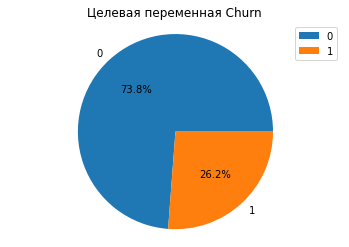

In [18]:
y_count=df_train['Churn'].value_counts()
plt.pie(y_count, labels = y_count.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Целевая переменная Churn')
plt.legend()
plt.show()

Здесь мы видим сильную несбалансированность классов. Разные модели машинного обучения относятся к этому по-разному, однако все равно будет лучше провести некоторые манипуляции для балансировки (или использовать сэмплирование).

Итак, построили графики распределения категориальных переменных, а также матрицу корреляции для численных признаков. Что позволяет нам поверхностно оценить влияние различных признаков. Оценили немногочисленные пропуски в данных, а также разобрались, чем можно их заполнить.

## Перейдем к машинному обучению

### Подготовим данные

По заданию (ну и не только по нему, а потому что так правильно), нам нужно отнормировать числовые признаки, а категориальные закодировать с помощью one-hot-encoding'а.

Выделим данные каждой категории в отдельные дф, чтобы было удобно использовать в пайплайне.

In [47]:
for i in df_train.columns:
    print(f"В колонке {i} - {df_train[i].nunique()} уникальных значений")

В колонке ClientPeriod - 73 уникальных значений
В колонке MonthlySpending - 1468 уникальных значений
В колонке TotalSpent - 4978 уникальных значений
В колонке Sex - 2 уникальных значений
В колонке IsSeniorCitizen - 2 уникальных значений
В колонке HasPartner - 2 уникальных значений
В колонке HasChild - 2 уникальных значений
В колонке HasPhoneService - 2 уникальных значений
В колонке HasMultiplePhoneNumbers - 3 уникальных значений
В колонке HasInternetService - 3 уникальных значений
В колонке HasOnlineSecurityService - 3 уникальных значений
В колонке HasOnlineBackup - 3 уникальных значений
В колонке HasDeviceProtection - 3 уникальных значений
В колонке HasTechSupportAccess - 3 уникальных значений
В колонке HasOnlineTV - 3 уникальных значений
В колонке HasMovieSubscription - 3 уникальных значений
В колонке HasContractPhone - 3 уникальных значений
В колонке IsBillingPaperless - 2 уникальных значений
В колонке PaymentMethod - 4 уникальных значений
В колонке Churn - 2 уникальных значений


In [210]:
num_cols = ['ClientPeriod', 'MonthlySpending']

In [211]:
binary_cols = ['IsSeniorCitizen', 'HasPartner', 'HasChild', 'IsBillingPaperless']

In [212]:
cat_cols = ['HasMultiplePhoneNumbers','HasInternetService','HasOnlineSecurityService', 'HasOnlineBackup',
                   'HasDeviceProtection','HasTechSupportAccess','HasOnlineTV', 'HasMovieSubscription','HasContractPhone',
                   'PaymentMethod']

### Построим линейную модель

Хоть при использовании GridSearch делить данные на train/valid особого смысла не имеет. Я так сделал все же, для контроля модели.

In [217]:
X = pd.concat([df_train[num_cols], df_train[cat_cols], df_train[binary_cols]], axis=1)

In [218]:
y = df_train[target]

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [150]:
regressor = LogisticRegression(random_state=42, C=0.01, max_iter=5000, solver="lbfgs")

In [151]:
smt = SMOTE()

In [106]:
X_train.head(3)

ClientPeriod  MonthlySpending  IsSeniorCitizen HasPartner HasChild  \
2628            37            88.80                0        Yes      Yes   
2160             2            20.50                0         No      Yes   
3138            46            95.25                1         No       No   

     HasMultiplePhoneNumbers HasInternetService HasOnlineSecurityService  \
2628                     Yes        Fiber optic                       No   
2160                      No                 No      No internet service   
3138                      No        Fiber optic                       No   

          HasOnlineBackup  HasDeviceProtection HasTechSupportAccess  \
2628                  Yes                   No                   No   
2160  No internet service  No internet service  No internet service   
3138                  Yes                   No                   No   

              HasOnlineTV HasMovieSubscription HasContractPhone  \
2628                  Yes                   No   Month-to-month   
2160  No internet service  No internet service         One year   
3138                  Yes                  Yes         One year   

     IsBillingPaperless              PaymentMethod  
2628                Yes           Electronic check  
2160                 No  Bank transfer (automatic)  
3138                 No    Credit card (automatic)

In [107]:
estimator_lr = imb_make_pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, binary_cols])),
                ('labelencoder', preprocessing.OrdinalEncoder())])),
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, num_cols])),
                ('scaling', StandardScaler())])),            
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda dataset: dataset.loc[:, cat_cols])),
                ('label', preprocessing.OrdinalEncoder()),
                ('hot_encoding', preprocessing.OneHotEncoder())])),
        ])),
    ('SMOTE', smt),
    ('model_fitting', regressor), 
    ]
)

In [111]:
param_grid = {
    'feature_processing__numeric_variables_processing__scaling': [StandardScaler(), RobustScaler(), MinMaxScaler()],
    'feature_processing__categorical_variables_processing__hot_encoding': [OneHotEncoder(), OrdinalEncoder()],
    'model_fitting__penalty': ["l1", "l2"],
    'model_fitting__C': [0.001, 0.01, 0.1, 1, 2],
    'model_fitting__solver': ['liblinear', 'saga']
}

# Определяем Поиск по сети
clf = GridSearchCV(estimator_lr, 
                   param_grid=param_grid, 
                   scoring='roc_auc', 
                   cv = 4, 
                   return_train_score=True 
                  )

# Обучаем clf
clf.fit(X_train, y_train)
None

In [113]:
clf.best_params_

{'feature_processing__categorical_variables_processing__hot_encoding': OneHotEncoder(),
 'feature_processing__numeric_variables_processing__scaling': StandardScaler(),
 'model_fitting__C': 0.1,
 'model_fitting__penalty': 'l1',
 'model_fitting__solver': 'saga'}

In [155]:
roc_auc_score(y_test, clf.predict(X_test))

0.7792161910617006

Качество модели получается достаточно высокое благодаря обработке данных - нормализации и кодированию. Однако этого все равно недостаточно и нужно использовать более "мощные" модели (так как простая линейная модель какое бы не было количество параметров и итераций не способна выдать лучшее качество на достаточно сложных данных).

### Градиентный бустинг

In [191]:
import catboost
from catboost import CatBoostClassifier

Catboost предназанчен для работы с большим количесвтом категориальных данных, к тому же алгоритмы градиентного бустинга очень эффективны, поэтому мы ожидаем существенный прирост в качестве по сравнению с предыдущей моделью.

In [254]:
cat = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

In [256]:
categorical_indices=[df_train.columns.get_loc(c) for c in cat if c in df_train]
categorical_indices

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [265]:
X = df_train.drop(['Churn'], axis=1)
y = df_train[target]

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [268]:
boosting_model =catboost.CatBoostClassifier(cat_features=categorical_indices)

In [269]:
X_train

ClientPeriod  MonthlySpending  TotalSpent     Sex  IsSeniorCitizen  \
1108             9            18.95      185.60    Male                0   
287             68           103.25     7074.40    Male                0   
1565            19            78.25     1490.95    Male                0   
1255            66            54.80     3465.70    Male                0   
1292            66           108.10     7181.95  Female                1   
...            ...              ...         ...     ...              ...   
1937            15            64.85      950.75    Male                0   
2904            25            54.10     1373.00  Female                0   
3697             0            20.00        0.00  Female                0   
330             19            19.90      367.55  Female                0   
888             44            20.40      905.55    Male                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
1108         No       No             Yes                      No   
287         Yes      Yes             Yes                      No   
1565         No       No             Yes                      No   
1255         No       No             Yes                      No   
1292        Yes       No             Yes                     Yes   
...         ...      ...             ...                     ...   
1937         No      Yes             Yes                      No   
2904        Yes       No             Yes                     Yes   
3697        Yes      Yes             Yes                      No   
330          No       No             Yes                      No   
888          No       No             Yes                      No   

     HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
1108                 No      No internet service  No internet service   
287         Fiber optic                      Yes                  Yes   
1565        Fiber optic                       No                  Yes   
1255                DSL                      Yes                  Yes   
1292        Fiber optic                       No                  Yes   
...                 ...                      ...                  ...   
1937                DSL                      Yes                   No   
2904                DSL                       No                  Yes   
3697                 No      No internet service  No internet service   
330                  No      No internet service  No internet service   
888                  No      No internet service  No internet service   

      HasDeviceProtection HasTechSupportAccess          HasOnlineTV  \
1108  No internet service  No internet service  No internet service   
287                   Yes                   No                  Yes   
1565                  Yes                   No                   No   
1255                   No                   No                   No   
1292                  Yes                  Yes                  Yes   
...                   ...                  ...                  ...   
1937                  Yes                   No                   No   
2904                   No                   No                   No   
3697  No internet service  No internet service  No internet service   
330   No internet service  No internet service  No internet service   
888   No internet service  No internet service  No internet service   

     HasMovieSubscription HasContractPhone IsBillingPaperless  \
1108  No internet service   Month-to-month                Yes   
287                   Yes         Two year                Yes   
1565                   No   Month-to-month                Yes   
1255                   No         One year                Yes   
1292                  Yes         One year                Yes   
...                   ...              ...                ...   
1937                  Yes         One year                 No   
2904                   No 

In [270]:
grid={'learning_rate': np.arange(0.01, 0.2, 0.01),
      'depth': [2, 4, 6, 8, 10],
      'l2_leaf_reg': [1, 3, 5, 7, 9],
      'iterations' : [100, 200, 300]} #Сетка параметров 
grid_search_result = boosting_model.grid_search(grid, X_train, y_train, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6884124	test: 0.6882962	best: 0.6882962 (0)	total: 187ms	remaining: 18.5s
1:	learn: 0.6843303	test: 0.6837900	best: 0.6837900 (1)	total: 204ms	remaining: 10s
2:	learn: 0.6804537	test: 0.6795637	best: 0.6795637 (2)	total: 212ms	remaining: 6.86s
3:	learn: 0.6759011	test: 0.6748411	best: 0.6748411 (3)	total: 220ms	remaining: 5.29s
4:	learn: 0.6726796	test: 0.6712410	best: 0.6712410 (4)	total: 234ms	remaining: 4.44s
5:	learn: 0.6685484	test: 0.6667181	best: 0.6667181 (5)	total: 247ms	remaining: 3.87s
6:	learn: 0.6643050	test: 0.6622945	best: 0.6622945 (6)	total: 261ms	remaining: 3.46s
7:	learn: 0.6613738	test: 0.6589974	best: 0.6589974 (7)	total: 273ms	remaining: 3.14s
8:	learn: 0.6574253	test: 0.6547942	best: 0.6547942 (8)	total: 286ms	remaining: 2.89s
9:	learn: 0.6538909	test: 0.6511580	best: 0.6511580 (9)	total: 299ms	remaining: 2.69s
10:	learn: 0.6501512	test: 0.6471990	best: 0.6471990 (10)	total: 311ms	remaining: 2.52s
11:	learn: 0.6466113	test: 0.6434462	best: 0.6434462 (

1:	learn: 0.6758119	test: 0.6747409	best: 0.6747409 (1)	total: 23.3ms	remaining: 1.14s
2:	learn: 0.6677907	test: 0.6660666	best: 0.6660666 (2)	total: 35.1ms	remaining: 1.14s
3:	learn: 0.6597030	test: 0.6576749	best: 0.6576749 (3)	total: 43.6ms	remaining: 1.05s
4:	learn: 0.6532814	test: 0.6509343	best: 0.6509343 (4)	total: 64ms	remaining: 1.22s
5:	learn: 0.6462746	test: 0.6431403	best: 0.6431403 (5)	total: 78.1ms	remaining: 1.22s
6:	learn: 0.6406429	test: 0.6368634	best: 0.6368634 (6)	total: 92.2ms	remaining: 1.22s
7:	learn: 0.6335429	test: 0.6292997	best: 0.6292997 (7)	total: 107ms	remaining: 1.23s
8:	learn: 0.6274574	test: 0.6224425	best: 0.6224425 (8)	total: 120ms	remaining: 1.22s
9:	learn: 0.6225633	test: 0.6170188	best: 0.6170188 (9)	total: 134ms	remaining: 1.21s
10:	learn: 0.6167362	test: 0.6105918	best: 0.6105918 (10)	total: 147ms	remaining: 1.19s
11:	learn: 0.6110532	test: 0.6044355	best: 0.6044355 (11)	total: 160ms	remaining: 1.17s
12:	learn: 0.6054409	test: 0.5984168	best: 0.5

9:	learn: 0.5941716	test: 0.5854638	best: 0.5854638 (9)	total: 109ms	remaining: 984ms
10:	learn: 0.5874812	test: 0.5779930	best: 0.5779930 (10)	total: 124ms	remaining: 1000ms
11:	learn: 0.5791816	test: 0.5690883	best: 0.5690883 (11)	total: 137ms	remaining: 1s
12:	learn: 0.5714833	test: 0.5607618	best: 0.5607618 (12)	total: 149ms	remaining: 995ms
13:	learn: 0.5658049	test: 0.5547814	best: 0.5547814 (13)	total: 161ms	remaining: 989ms
14:	learn: 0.5591146	test: 0.5475065	best: 0.5475065 (14)	total: 173ms	remaining: 982ms
15:	learn: 0.5516655	test: 0.5397645	best: 0.5397645 (15)	total: 187ms	remaining: 983ms
16:	learn: 0.5459933	test: 0.5336000	best: 0.5336000 (16)	total: 201ms	remaining: 983ms
17:	learn: 0.5397640	test: 0.5268961	best: 0.5268961 (17)	total: 215ms	remaining: 982ms
18:	learn: 0.5345025	test: 0.5210286	best: 0.5210286 (18)	total: 228ms	remaining: 973ms
19:	learn: 0.5300580	test: 0.5161641	best: 0.5161641 (19)	total: 241ms	remaining: 966ms
20:	learn: 0.5248738	test: 0.5107883

2:	learn: 0.6472944	test: 0.6438872	best: 0.6438872 (2)	total: 28.1ms	remaining: 909ms
3:	learn: 0.6349641	test: 0.6300235	best: 0.6300235 (3)	total: 36.1ms	remaining: 867ms
4:	learn: 0.6207688	test: 0.6151514	best: 0.6151514 (4)	total: 49ms	remaining: 932ms
5:	learn: 0.6089775	test: 0.6022403	best: 0.6022403 (5)	total: 61.2ms	remaining: 959ms
6:	learn: 0.5977046	test: 0.5896864	best: 0.5896864 (6)	total: 73.4ms	remaining: 976ms
7:	learn: 0.5879488	test: 0.5789558	best: 0.5789558 (7)	total: 85.3ms	remaining: 981ms
8:	learn: 0.5783070	test: 0.5689654	best: 0.5689654 (8)	total: 97.3ms	remaining: 984ms
9:	learn: 0.5700196	test: 0.5593447	best: 0.5593447 (9)	total: 110ms	remaining: 990ms
10:	learn: 0.5620371	test: 0.5506273	best: 0.5506273 (10)	total: 122ms	remaining: 988ms
11:	learn: 0.5530417	test: 0.5408991	best: 0.5408991 (11)	total: 134ms	remaining: 985ms
12:	learn: 0.5449457	test: 0.5321645	best: 0.5321645 (12)	total: 146ms	remaining: 980ms
13:	learn: 0.5362671	test: 0.5230481	best: 

99:	learn: 0.4214970	test: 0.4033219	best: 0.4033219 (99)	total: 1.22s	remaining: 0us

bestTest = 0.4033218873
bestIteration = 99

3:	loss: 0.4033219	best: 0.4033219 (3)	total: 5.45s	remaining: 32m 15s
0:	learn: 0.6701483	test: 0.6695653	best: 0.6695653 (0)	total: 8ms	remaining: 792ms
1:	learn: 0.6519813	test: 0.6493743	best: 0.6493743 (1)	total: 20.8ms	remaining: 1.02s
2:	learn: 0.6354931	test: 0.6320220	best: 0.6320220 (2)	total: 29ms	remaining: 937ms
3:	learn: 0.6214700	test: 0.6163976	best: 0.6163976 (3)	total: 42.8ms	remaining: 1.03s
4:	learn: 0.6079050	test: 0.6007077	best: 0.6007077 (4)	total: 55.4ms	remaining: 1.05s
5:	learn: 0.5962452	test: 0.5874340	best: 0.5874340 (5)	total: 67.8ms	remaining: 1.06s
6:	learn: 0.5860571	test: 0.5767239	best: 0.5767239 (6)	total: 80.1ms	remaining: 1.06s
7:	learn: 0.5750073	test: 0.5645286	best: 0.5645286 (7)	total: 87.9ms	remaining: 1.01s
8:	learn: 0.5666786	test: 0.5553077	best: 0.5553077 (8)	total: 100ms	remaining: 1.01s
9:	learn: 0.5573837	t

94:	learn: 0.4175846	test: 0.4021274	best: 0.4021274 (94)	total: 1.2s	remaining: 63.3ms
95:	learn: 0.4175742	test: 0.4021302	best: 0.4021274 (94)	total: 1.22s	remaining: 50.6ms
96:	learn: 0.4174687	test: 0.4021612	best: 0.4021274 (94)	total: 1.23s	remaining: 38ms
97:	learn: 0.4173612	test: 0.4021838	best: 0.4021274 (94)	total: 1.24s	remaining: 25.3ms
98:	learn: 0.4172425	test: 0.4020468	best: 0.4020468 (98)	total: 1.25s	remaining: 12.7ms
99:	learn: 0.4170199	test: 0.4018429	best: 0.4018429 (99)	total: 1.27s	remaining: 0us

bestTest = 0.4018428604
bestIteration = 99

4:	loss: 0.4018429	best: 0.4018429 (4)	total: 6.73s	remaining: 31m 51s
0:	learn: 0.6657508	test: 0.6650505	best: 0.6650505 (0)	total: 7.28ms	remaining: 721ms
1:	learn: 0.6445901	test: 0.6414897	best: 0.6414897 (1)	total: 19.1ms	remaining: 934ms
2:	learn: 0.6247317	test: 0.6198996	best: 0.6198996 (2)	total: 27.3ms	remaining: 882ms
3:	learn: 0.6085982	test: 0.6020296	best: 0.6020296 (3)	total: 39.7ms	remaining: 952ms
4:	learn

88:	learn: 0.4155108	test: 0.3998774	best: 0.3998131 (86)	total: 1.12s	remaining: 139ms
89:	learn: 0.4153335	test: 0.3998315	best: 0.3998131 (86)	total: 1.13s	remaining: 126ms
90:	learn: 0.4152912	test: 0.3997729	best: 0.3997729 (90)	total: 1.15s	remaining: 113ms
91:	learn: 0.4151961	test: 0.3998081	best: 0.3997729 (90)	total: 1.16s	remaining: 101ms
92:	learn: 0.4148375	test: 0.3992226	best: 0.3992226 (92)	total: 1.17s	remaining: 88.4ms
93:	learn: 0.4145165	test: 0.3987963	best: 0.3987963 (93)	total: 1.19s	remaining: 75.7ms
94:	learn: 0.4143878	test: 0.3985079	best: 0.3985079 (94)	total: 1.2s	remaining: 63.1ms
95:	learn: 0.4143812	test: 0.3985134	best: 0.3985079 (94)	total: 1.21s	remaining: 50.5ms
96:	learn: 0.4141114	test: 0.3982133	best: 0.3982133 (96)	total: 1.22s	remaining: 37.9ms
97:	learn: 0.4140184	test: 0.3980334	best: 0.3980334 (97)	total: 1.24s	remaining: 25.2ms
98:	learn: 0.4136868	test: 0.3975652	best: 0.3975652 (98)	total: 1.25s	remaining: 12.6ms
99:	learn: 0.4134354	test:

95:	learn: 0.4135689	test: 0.3977037	best: 0.3977037 (95)	total: 1.2s	remaining: 50.1ms
96:	learn: 0.4133027	test: 0.3973498	best: 0.3973498 (96)	total: 1.21s	remaining: 37.6ms
97:	learn: 0.4132371	test: 0.3973664	best: 0.3973498 (96)	total: 1.23s	remaining: 25ms
98:	learn: 0.4131537	test: 0.3973494	best: 0.3973494 (98)	total: 1.24s	remaining: 12.5ms
99:	learn: 0.4129248	test: 0.3972970	best: 0.3972970 (99)	total: 1.25s	remaining: 0us

bestTest = 0.3972970158
bestIteration = 99

6:	loss: 0.3972970	best: 0.3972970 (6)	total: 9.28s	remaining: 31m 19s
0:	learn: 0.6571570	test: 0.6562219	best: 0.6562219 (0)	total: 7.59ms	remaining: 752ms
1:	learn: 0.6305950	test: 0.6265349	best: 0.6265349 (1)	total: 19.6ms	remaining: 961ms
2:	learn: 0.6105505	test: 0.6040254	best: 0.6040254 (2)	total: 27.4ms	remaining: 885ms
3:	learn: 0.5879559	test: 0.5804458	best: 0.5804458 (3)	total: 35.1ms	remaining: 843ms
4:	learn: 0.5736083	test: 0.5651594	best: 0.5651594 (4)	total: 47.2ms	remaining: 896ms
5:	learn: 

94:	learn: 0.4114107	test: 0.3986280	best: 0.3984089 (93)	total: 1.14s	remaining: 60.2ms
95:	learn: 0.4113163	test: 0.3985220	best: 0.3984089 (93)	total: 1.16s	remaining: 48.1ms
96:	learn: 0.4111664	test: 0.3984038	best: 0.3984038 (96)	total: 1.17s	remaining: 36.1ms
97:	learn: 0.4111388	test: 0.3984362	best: 0.3984038 (96)	total: 1.18s	remaining: 24.1ms
98:	learn: 0.4108956	test: 0.3981626	best: 0.3981626 (98)	total: 1.19s	remaining: 12.1ms
99:	learn: 0.4107835	test: 0.3981192	best: 0.3981192 (99)	total: 1.21s	remaining: 0us

bestTest = 0.3981191632
bestIteration = 99

7:	loss: 0.3981192	best: 0.3972970 (6)	total: 10.5s	remaining: 30m 59s
0:	learn: 0.6529605	test: 0.6519078	best: 0.6519078 (0)	total: 7.43ms	remaining: 736ms
1:	learn: 0.6239791	test: 0.6194529	best: 0.6194529 (1)	total: 19.3ms	remaining: 947ms
2:	learn: 0.6025963	test: 0.5953363	best: 0.5953363 (2)	total: 27ms	remaining: 875ms
3:	learn: 0.5788759	test: 0.5705724	best: 0.5705724 (3)	total: 35ms	remaining: 839ms
4:	learn:

91:	learn: 0.4099408	test: 0.3960413	best: 0.3960413 (91)	total: 1.14s	remaining: 99.5ms
92:	learn: 0.4095923	test: 0.3955829	best: 0.3955829 (92)	total: 1.16s	remaining: 87.1ms
93:	learn: 0.4094293	test: 0.3955487	best: 0.3955487 (93)	total: 1.17s	remaining: 74.7ms
94:	learn: 0.4091835	test: 0.3952223	best: 0.3952223 (94)	total: 1.2s	remaining: 62.9ms
95:	learn: 0.4090106	test: 0.3951748	best: 0.3951748 (95)	total: 1.21s	remaining: 50.3ms
96:	learn: 0.4089534	test: 0.3951708	best: 0.3951708 (96)	total: 1.22s	remaining: 37.8ms
97:	learn: 0.4088246	test: 0.3952356	best: 0.3951708 (96)	total: 1.23s	remaining: 25.2ms
98:	learn: 0.4085005	test: 0.3948158	best: 0.3948158 (98)	total: 1.25s	remaining: 12.6ms
99:	learn: 0.4083834	test: 0.3946028	best: 0.3946028 (99)	total: 1.26s	remaining: 0us

bestTest = 0.3946027898
bestIteration = 99

8:	loss: 0.3946028	best: 0.3946028 (8)	total: 11.8s	remaining: 30m 52s
0:	learn: 0.6488307	test: 0.6476601	best: 0.6476601 (0)	total: 7.97ms	remaining: 789ms


84:	learn: 0.4100805	test: 0.3984898	best: 0.3983795 (80)	total: 1.05s	remaining: 185ms
85:	learn: 0.4097519	test: 0.3981492	best: 0.3981492 (85)	total: 1.06s	remaining: 173ms
86:	learn: 0.4094956	test: 0.3980025	best: 0.3980025 (86)	total: 1.07s	remaining: 160ms
87:	learn: 0.4092875	test: 0.3977727	best: 0.3977727 (87)	total: 1.08s	remaining: 148ms
88:	learn: 0.4091773	test: 0.3974484	best: 0.3974484 (88)	total: 1.1s	remaining: 136ms
89:	learn: 0.4087239	test: 0.3976761	best: 0.3974484 (88)	total: 1.11s	remaining: 124ms
90:	learn: 0.4085982	test: 0.3976742	best: 0.3974484 (88)	total: 1.12s	remaining: 111ms
91:	learn: 0.4083233	test: 0.3978735	best: 0.3974484 (88)	total: 1.14s	remaining: 98.8ms
92:	learn: 0.4081164	test: 0.3977489	best: 0.3974484 (88)	total: 1.15s	remaining: 86.4ms
93:	learn: 0.4079190	test: 0.3976164	best: 0.3974484 (88)	total: 1.16s	remaining: 74.1ms
94:	learn: 0.4079000	test: 0.3976079	best: 0.3974484 (88)	total: 1.17s	remaining: 61.7ms
95:	learn: 0.4078034	test: 0.

78:	learn: 0.4120896	test: 0.3972318	best: 0.3972318 (78)	total: 1s	remaining: 267ms
79:	learn: 0.4118676	test: 0.3970624	best: 0.3970624 (79)	total: 1.02s	remaining: 254ms
80:	learn: 0.4116876	test: 0.3968842	best: 0.3968842 (80)	total: 1.03s	remaining: 242ms
81:	learn: 0.4112631	test: 0.3969519	best: 0.3968842 (80)	total: 1.04s	remaining: 229ms
82:	learn: 0.4112298	test: 0.3968870	best: 0.3968842 (80)	total: 1.05s	remaining: 216ms
83:	learn: 0.4107873	test: 0.3965044	best: 0.3965044 (83)	total: 1.07s	remaining: 204ms
84:	learn: 0.4103473	test: 0.3962482	best: 0.3962482 (84)	total: 1.08s	remaining: 191ms
85:	learn: 0.4101735	test: 0.3959498	best: 0.3959498 (85)	total: 1.09s	remaining: 178ms
86:	learn: 0.4100675	test: 0.3958356	best: 0.3958356 (86)	total: 1.11s	remaining: 166ms
87:	learn: 0.4098808	test: 0.3956742	best: 0.3956742 (87)	total: 1.12s	remaining: 153ms
88:	learn: 0.4096512	test: 0.3954884	best: 0.3954884 (88)	total: 1.13s	remaining: 140ms
89:	learn: 0.4094568	test: 0.395282

73:	learn: 0.4112745	test: 0.3978045	best: 0.3978045 (73)	total: 932ms	remaining: 328ms
74:	learn: 0.4106086	test: 0.3970161	best: 0.3970161 (74)	total: 945ms	remaining: 315ms
75:	learn: 0.4101627	test: 0.3968509	best: 0.3968509 (75)	total: 958ms	remaining: 303ms
76:	learn: 0.4097882	test: 0.3968062	best: 0.3968062 (76)	total: 971ms	remaining: 290ms
77:	learn: 0.4097665	test: 0.3967919	best: 0.3967919 (77)	total: 984ms	remaining: 278ms
78:	learn: 0.4096049	test: 0.3968779	best: 0.3967919 (77)	total: 998ms	remaining: 265ms
79:	learn: 0.4094278	test: 0.3966459	best: 0.3966459 (79)	total: 1.01s	remaining: 253ms
80:	learn: 0.4091005	test: 0.3963802	best: 0.3963802 (80)	total: 1.03s	remaining: 241ms
81:	learn: 0.4090077	test: 0.3965135	best: 0.3963802 (80)	total: 1.04s	remaining: 228ms
82:	learn: 0.4086025	test: 0.3962998	best: 0.3962998 (82)	total: 1.05s	remaining: 216ms
83:	learn: 0.4084296	test: 0.3961663	best: 0.3961663 (83)	total: 1.07s	remaining: 203ms
84:	learn: 0.4083205	test: 0.396

75:	learn: 0.4079316	test: 0.3939189	best: 0.3937987 (74)	total: 1.02s	remaining: 322ms
76:	learn: 0.4077699	test: 0.3936954	best: 0.3936954 (76)	total: 1.03s	remaining: 309ms
77:	learn: 0.4075824	test: 0.3935992	best: 0.3935992 (77)	total: 1.05s	remaining: 295ms
78:	learn: 0.4074108	test: 0.3934917	best: 0.3934917 (78)	total: 1.06s	remaining: 282ms
79:	learn: 0.4068107	test: 0.3937619	best: 0.3934917 (78)	total: 1.07s	remaining: 268ms
80:	learn: 0.4067137	test: 0.3936038	best: 0.3934917 (78)	total: 1.09s	remaining: 255ms
81:	learn: 0.4064328	test: 0.3935793	best: 0.3934917 (78)	total: 1.1s	remaining: 241ms
82:	learn: 0.4062811	test: 0.3936735	best: 0.3934917 (78)	total: 1.11s	remaining: 228ms
83:	learn: 0.4060644	test: 0.3933497	best: 0.3933497 (83)	total: 1.12s	remaining: 214ms
84:	learn: 0.4060223	test: 0.3933047	best: 0.3933047 (84)	total: 1.14s	remaining: 200ms
85:	learn: 0.4059975	test: 0.3932919	best: 0.3932919 (85)	total: 1.15s	remaining: 187ms
86:	learn: 0.4059966	test: 0.3932

70:	learn: 0.4078924	test: 0.3949392	best: 0.3946467 (69)	total: 903ms	remaining: 369ms
71:	learn: 0.4076933	test: 0.3946941	best: 0.3946467 (69)	total: 916ms	remaining: 356ms
72:	learn: 0.4072974	test: 0.3946476	best: 0.3946467 (69)	total: 928ms	remaining: 343ms
73:	learn: 0.4071152	test: 0.3945085	best: 0.3945085 (73)	total: 940ms	remaining: 330ms
74:	learn: 0.4067205	test: 0.3944082	best: 0.3944082 (74)	total: 954ms	remaining: 318ms
75:	learn: 0.4065686	test: 0.3943714	best: 0.3943714 (75)	total: 967ms	remaining: 305ms
76:	learn: 0.4062037	test: 0.3943048	best: 0.3943048 (76)	total: 979ms	remaining: 292ms
77:	learn: 0.4058743	test: 0.3940955	best: 0.3940955 (77)	total: 992ms	remaining: 280ms
78:	learn: 0.4055827	test: 0.3939448	best: 0.3939448 (78)	total: 1s	remaining: 267ms
79:	learn: 0.4049692	test: 0.3943177	best: 0.3939448 (78)	total: 1.01s	remaining: 254ms
80:	learn: 0.4046910	test: 0.3939476	best: 0.3939448 (78)	total: 1.03s	remaining: 241ms
81:	learn: 0.4045313	test: 0.393860

72:	learn: 0.4069202	test: 0.3966816	best: 0.3966572 (67)	total: 1s	remaining: 371ms
73:	learn: 0.4066823	test: 0.3963813	best: 0.3963813 (73)	total: 1.01s	remaining: 357ms
74:	learn: 0.4066760	test: 0.3963776	best: 0.3963776 (74)	total: 1.03s	remaining: 343ms
75:	learn: 0.4066641	test: 0.3963843	best: 0.3963776 (74)	total: 1.04s	remaining: 329ms
76:	learn: 0.4066094	test: 0.3963590	best: 0.3963590 (76)	total: 1.05s	remaining: 314ms
77:	learn: 0.4065491	test: 0.3962455	best: 0.3962455 (77)	total: 1.06s	remaining: 301ms
78:	learn: 0.4063104	test: 0.3961011	best: 0.3961011 (78)	total: 1.08s	remaining: 287ms
79:	learn: 0.4061796	test: 0.3958954	best: 0.3958954 (79)	total: 1.09s	remaining: 273ms
80:	learn: 0.4059514	test: 0.3960651	best: 0.3958954 (79)	total: 1.1s	remaining: 259ms
81:	learn: 0.4057079	test: 0.3955109	best: 0.3955109 (81)	total: 1.12s	remaining: 245ms
82:	learn: 0.4053944	test: 0.3951758	best: 0.3951758 (82)	total: 1.13s	remaining: 232ms
83:	learn: 0.4052248	test: 0.3951116

65:	learn: 0.4066974	test: 0.3942164	best: 0.3936106 (60)	total: 833ms	remaining: 429ms
66:	learn: 0.4065085	test: 0.3941356	best: 0.3936106 (60)	total: 845ms	remaining: 416ms
67:	learn: 0.4065085	test: 0.3941414	best: 0.3936106 (60)	total: 858ms	remaining: 404ms
68:	learn: 0.4061067	test: 0.3936132	best: 0.3936106 (60)	total: 872ms	remaining: 392ms
69:	learn: 0.4057279	test: 0.3936060	best: 0.3936060 (69)	total: 885ms	remaining: 379ms
70:	learn: 0.4056458	test: 0.3935504	best: 0.3935504 (70)	total: 898ms	remaining: 367ms
71:	learn: 0.4051484	test: 0.3942247	best: 0.3935504 (70)	total: 911ms	remaining: 354ms
72:	learn: 0.4047643	test: 0.3942375	best: 0.3935504 (70)	total: 924ms	remaining: 342ms
73:	learn: 0.4046450	test: 0.3942070	best: 0.3935504 (70)	total: 937ms	remaining: 329ms
74:	learn: 0.4043098	test: 0.3939379	best: 0.3935504 (70)	total: 950ms	remaining: 317ms
75:	learn: 0.4041751	test: 0.3939122	best: 0.3935504 (70)	total: 964ms	remaining: 304ms
76:	learn: 0.4037308	test: 0.393

61:	learn: 0.4081367	test: 0.3942557	best: 0.3940658 (59)	total: 752ms	remaining: 461ms
62:	learn: 0.4081246	test: 0.3942490	best: 0.3940658 (59)	total: 765ms	remaining: 449ms
63:	learn: 0.4076945	test: 0.3936554	best: 0.3936554 (63)	total: 776ms	remaining: 437ms
64:	learn: 0.4076857	test: 0.3936520	best: 0.3936520 (64)	total: 788ms	remaining: 424ms
65:	learn: 0.4076652	test: 0.3936608	best: 0.3936520 (64)	total: 800ms	remaining: 412ms
66:	learn: 0.4075469	test: 0.3934806	best: 0.3934806 (66)	total: 814ms	remaining: 401ms
67:	learn: 0.4075402	test: 0.3934752	best: 0.3934752 (67)	total: 826ms	remaining: 389ms
68:	learn: 0.4068613	test: 0.3930641	best: 0.3930641 (68)	total: 838ms	remaining: 376ms
69:	learn: 0.4064393	test: 0.3936431	best: 0.3930641 (68)	total: 851ms	remaining: 365ms
70:	learn: 0.4063601	test: 0.3936569	best: 0.3930641 (68)	total: 864ms	remaining: 353ms
71:	learn: 0.4060166	test: 0.3933028	best: 0.3930641 (68)	total: 876ms	remaining: 340ms
72:	learn: 0.4059506	test: 0.393

66:	learn: 0.4041697	test: 0.3939988	best: 0.3935626 (62)	total: 810ms	remaining: 399ms
67:	learn: 0.4040727	test: 0.3939735	best: 0.3935626 (62)	total: 823ms	remaining: 387ms
68:	learn: 0.4039417	test: 0.3940224	best: 0.3935626 (62)	total: 836ms	remaining: 375ms
69:	learn: 0.4034160	test: 0.3948200	best: 0.3935626 (62)	total: 849ms	remaining: 364ms
70:	learn: 0.4034014	test: 0.3948223	best: 0.3935626 (62)	total: 861ms	remaining: 352ms
71:	learn: 0.4031163	test: 0.3951730	best: 0.3935626 (62)	total: 873ms	remaining: 340ms
72:	learn: 0.4029796	test: 0.3951180	best: 0.3935626 (62)	total: 886ms	remaining: 328ms
73:	learn: 0.4027313	test: 0.3949970	best: 0.3935626 (62)	total: 897ms	remaining: 315ms
74:	learn: 0.4026179	test: 0.3949815	best: 0.3935626 (62)	total: 911ms	remaining: 304ms
75:	learn: 0.4021402	test: 0.3946621	best: 0.3935626 (62)	total: 924ms	remaining: 292ms
76:	learn: 0.4018110	test: 0.3942588	best: 0.3935626 (62)	total: 936ms	remaining: 279ms
77:	learn: 0.4017293	test: 0.394

73:	learn: 0.4037870	test: 0.3925135	best: 0.3923709 (71)	total: 956ms	remaining: 336ms
74:	learn: 0.4034428	test: 0.3923053	best: 0.3923053 (74)	total: 967ms	remaining: 322ms
75:	learn: 0.4029918	test: 0.3933159	best: 0.3923053 (74)	total: 979ms	remaining: 309ms
76:	learn: 0.4025168	test: 0.3932983	best: 0.3923053 (74)	total: 992ms	remaining: 296ms
77:	learn: 0.4024193	test: 0.3931787	best: 0.3923053 (74)	total: 1s	remaining: 283ms
78:	learn: 0.4023351	test: 0.3932579	best: 0.3923053 (74)	total: 1.01s	remaining: 270ms
79:	learn: 0.4022992	test: 0.3932616	best: 0.3923053 (74)	total: 1.03s	remaining: 257ms
80:	learn: 0.4020810	test: 0.3931138	best: 0.3923053 (74)	total: 1.04s	remaining: 244ms
81:	learn: 0.4020209	test: 0.3932666	best: 0.3923053 (74)	total: 1.05s	remaining: 231ms
82:	learn: 0.4019515	test: 0.3932470	best: 0.3923053 (74)	total: 1.06s	remaining: 218ms
83:	learn: 0.4017234	test: 0.3931600	best: 0.3923053 (74)	total: 1.08s	remaining: 205ms
84:	learn: 0.4010086	test: 0.393591

68:	learn: 0.5153175	test: 0.5018953	best: 0.5018953 (68)	total: 851ms	remaining: 383ms
69:	learn: 0.5142794	test: 0.5007002	best: 0.5007002 (69)	total: 864ms	remaining: 370ms
70:	learn: 0.5132598	test: 0.4995578	best: 0.4995578 (70)	total: 878ms	remaining: 359ms
71:	learn: 0.5119160	test: 0.4981360	best: 0.4981360 (71)	total: 892ms	remaining: 347ms
72:	learn: 0.5108251	test: 0.4969114	best: 0.4969114 (72)	total: 906ms	remaining: 335ms
73:	learn: 0.5097325	test: 0.4956667	best: 0.4956667 (73)	total: 920ms	remaining: 323ms
74:	learn: 0.5084302	test: 0.4943073	best: 0.4943073 (74)	total: 934ms	remaining: 311ms
75:	learn: 0.5074448	test: 0.4932651	best: 0.4932651 (75)	total: 947ms	remaining: 299ms
76:	learn: 0.5064192	test: 0.4920836	best: 0.4920836 (76)	total: 961ms	remaining: 287ms
77:	learn: 0.5052108	test: 0.4908511	best: 0.4908511 (77)	total: 974ms	remaining: 275ms
78:	learn: 0.5041419	test: 0.4896324	best: 0.4896324 (78)	total: 987ms	remaining: 262ms
79:	learn: 0.5029604	test: 0.488

60:	learn: 0.4729230	test: 0.4536880	best: 0.4536880 (60)	total: 767ms	remaining: 490ms
61:	learn: 0.4716968	test: 0.4523365	best: 0.4523365 (61)	total: 779ms	remaining: 477ms
62:	learn: 0.4703191	test: 0.4510636	best: 0.4510636 (62)	total: 792ms	remaining: 465ms
63:	learn: 0.4689683	test: 0.4498016	best: 0.4498016 (63)	total: 804ms	remaining: 452ms
64:	learn: 0.4680128	test: 0.4486971	best: 0.4486971 (64)	total: 818ms	remaining: 441ms
65:	learn: 0.4671319	test: 0.4478537	best: 0.4478537 (65)	total: 832ms	remaining: 429ms
66:	learn: 0.4659429	test: 0.4467881	best: 0.4467881 (66)	total: 845ms	remaining: 416ms
67:	learn: 0.4650507	test: 0.4458687	best: 0.4458687 (67)	total: 858ms	remaining: 404ms
68:	learn: 0.4638366	test: 0.4446992	best: 0.4446992 (68)	total: 872ms	remaining: 392ms
69:	learn: 0.4627042	test: 0.4436180	best: 0.4436180 (69)	total: 885ms	remaining: 379ms
70:	learn: 0.4618187	test: 0.4425565	best: 0.4425565 (70)	total: 898ms	remaining: 367ms
71:	learn: 0.4607584	test: 0.441

65:	learn: 0.4431173	test: 0.4229241	best: 0.4229241 (65)	total: 835ms	remaining: 430ms
66:	learn: 0.4423989	test: 0.4221007	best: 0.4221007 (66)	total: 848ms	remaining: 417ms
67:	learn: 0.4416923	test: 0.4214401	best: 0.4214401 (67)	total: 861ms	remaining: 405ms
68:	learn: 0.4411138	test: 0.4209883	best: 0.4209883 (68)	total: 873ms	remaining: 392ms
69:	learn: 0.4404816	test: 0.4203945	best: 0.4203945 (69)	total: 886ms	remaining: 380ms
70:	learn: 0.4394532	test: 0.4192104	best: 0.4192104 (70)	total: 898ms	remaining: 367ms
71:	learn: 0.4387111	test: 0.4186770	best: 0.4186770 (71)	total: 910ms	remaining: 354ms
72:	learn: 0.4381093	test: 0.4182504	best: 0.4182504 (72)	total: 922ms	remaining: 341ms
73:	learn: 0.4375532	test: 0.4178065	best: 0.4178065 (73)	total: 933ms	remaining: 328ms
74:	learn: 0.4369614	test: 0.4171185	best: 0.4171185 (74)	total: 946ms	remaining: 315ms
75:	learn: 0.4363668	test: 0.4167119	best: 0.4167119 (75)	total: 958ms	remaining: 302ms
76:	learn: 0.4359425	test: 0.416

61:	learn: 0.4335788	test: 0.4174414	best: 0.4174414 (61)	total: 787ms	remaining: 482ms
62:	learn: 0.4330843	test: 0.4171608	best: 0.4171608 (62)	total: 799ms	remaining: 469ms
63:	learn: 0.4323316	test: 0.4163814	best: 0.4163814 (63)	total: 811ms	remaining: 456ms
64:	learn: 0.4316865	test: 0.4158749	best: 0.4158749 (64)	total: 824ms	remaining: 444ms
65:	learn: 0.4311135	test: 0.4154222	best: 0.4154222 (65)	total: 836ms	remaining: 431ms
66:	learn: 0.4307155	test: 0.4152351	best: 0.4152351 (66)	total: 848ms	remaining: 418ms
67:	learn: 0.4301049	test: 0.4147421	best: 0.4147421 (67)	total: 873ms	remaining: 411ms
68:	learn: 0.4296860	test: 0.4142323	best: 0.4142323 (68)	total: 885ms	remaining: 398ms
69:	learn: 0.4291909	test: 0.4136613	best: 0.4136613 (69)	total: 898ms	remaining: 385ms
70:	learn: 0.4288296	test: 0.4133197	best: 0.4133197 (70)	total: 910ms	remaining: 372ms
71:	learn: 0.4282773	test: 0.4129307	best: 0.4129307 (71)	total: 922ms	remaining: 359ms
72:	learn: 0.4279691	test: 0.412

53:	learn: 0.4301244	test: 0.4102395	best: 0.4102395 (53)	total: 702ms	remaining: 598ms
54:	learn: 0.4293923	test: 0.4094328	best: 0.4094328 (54)	total: 714ms	remaining: 585ms
55:	learn: 0.4286677	test: 0.4089307	best: 0.4089307 (55)	total: 726ms	remaining: 571ms
56:	learn: 0.4281077	test: 0.4086949	best: 0.4086949 (56)	total: 739ms	remaining: 557ms
57:	learn: 0.4275942	test: 0.4084895	best: 0.4084895 (57)	total: 751ms	remaining: 544ms
58:	learn: 0.4267911	test: 0.4075597	best: 0.4075597 (58)	total: 763ms	remaining: 530ms
59:	learn: 0.4266054	test: 0.4075046	best: 0.4075046 (59)	total: 775ms	remaining: 517ms
60:	learn: 0.4261278	test: 0.4072777	best: 0.4072777 (60)	total: 787ms	remaining: 503ms
61:	learn: 0.4256877	test: 0.4068064	best: 0.4068064 (61)	total: 799ms	remaining: 490ms
62:	learn: 0.4253682	test: 0.4067129	best: 0.4067129 (62)	total: 811ms	remaining: 476ms
63:	learn: 0.4250288	test: 0.4063859	best: 0.4063859 (63)	total: 823ms	remaining: 463ms
64:	learn: 0.4247275	test: 0.405

60:	learn: 0.4225346	test: 0.4065961	best: 0.4065961 (60)	total: 777ms	remaining: 497ms
61:	learn: 0.4220675	test: 0.4057820	best: 0.4057820 (61)	total: 789ms	remaining: 484ms
62:	learn: 0.4214166	test: 0.4048012	best: 0.4048012 (62)	total: 802ms	remaining: 471ms
63:	learn: 0.4212239	test: 0.4048161	best: 0.4048012 (62)	total: 814ms	remaining: 458ms
64:	learn: 0.4209596	test: 0.4044977	best: 0.4044977 (64)	total: 827ms	remaining: 445ms
65:	learn: 0.4205868	test: 0.4041758	best: 0.4041758 (65)	total: 840ms	remaining: 433ms
66:	learn: 0.4202553	test: 0.4038445	best: 0.4038445 (66)	total: 854ms	remaining: 421ms
67:	learn: 0.4199346	test: 0.4033834	best: 0.4033834 (67)	total: 866ms	remaining: 408ms
68:	learn: 0.4197935	test: 0.4031521	best: 0.4031521 (68)	total: 879ms	remaining: 395ms
69:	learn: 0.4195867	test: 0.4031448	best: 0.4031448 (69)	total: 892ms	remaining: 382ms
70:	learn: 0.4194030	test: 0.4032126	best: 0.4031448 (69)	total: 904ms	remaining: 369ms
71:	learn: 0.4188654	test: 0.402

53:	learn: 0.4217381	test: 0.4048329	best: 0.4048329 (53)	total: 661ms	remaining: 563ms
54:	learn: 0.4214989	test: 0.4047335	best: 0.4047335 (54)	total: 673ms	remaining: 551ms
55:	learn: 0.4209874	test: 0.4042380	best: 0.4042380 (55)	total: 685ms	remaining: 538ms
56:	learn: 0.4207777	test: 0.4039757	best: 0.4039757 (56)	total: 698ms	remaining: 526ms
57:	learn: 0.4205718	test: 0.4039539	best: 0.4039539 (57)	total: 711ms	remaining: 515ms
58:	learn: 0.4203260	test: 0.4035530	best: 0.4035530 (58)	total: 724ms	remaining: 503ms
59:	learn: 0.4201305	test: 0.4035474	best: 0.4035474 (59)	total: 737ms	remaining: 491ms
60:	learn: 0.4199878	test: 0.4033867	best: 0.4033867 (60)	total: 750ms	remaining: 479ms
61:	learn: 0.4199133	test: 0.4034057	best: 0.4033867 (60)	total: 762ms	remaining: 467ms
62:	learn: 0.4198171	test: 0.4031726	best: 0.4031726 (62)	total: 774ms	remaining: 455ms
63:	learn: 0.4195186	test: 0.4031632	best: 0.4031632 (63)	total: 786ms	remaining: 442ms
64:	learn: 0.4194170	test: 0.403

50:	learn: 0.4202759	test: 0.4026380	best: 0.4026380 (50)	total: 624ms	remaining: 600ms
51:	learn: 0.4199855	test: 0.4026048	best: 0.4026048 (51)	total: 636ms	remaining: 587ms
52:	learn: 0.4197885	test: 0.4025450	best: 0.4025450 (52)	total: 649ms	remaining: 575ms
53:	learn: 0.4193474	test: 0.4022460	best: 0.4022460 (53)	total: 661ms	remaining: 563ms
54:	learn: 0.4189702	test: 0.4018898	best: 0.4018898 (54)	total: 674ms	remaining: 551ms
55:	learn: 0.4187675	test: 0.4019196	best: 0.4018898 (54)	total: 687ms	remaining: 539ms
56:	learn: 0.4183279	test: 0.4017683	best: 0.4017683 (56)	total: 698ms	remaining: 527ms
57:	learn: 0.4181100	test: 0.4018990	best: 0.4017683 (56)	total: 710ms	remaining: 514ms
58:	learn: 0.4177468	test: 0.4016333	best: 0.4016333 (58)	total: 725ms	remaining: 504ms
59:	learn: 0.4174738	test: 0.4013886	best: 0.4013886 (59)	total: 738ms	remaining: 492ms
60:	learn: 0.4172342	test: 0.4010158	best: 0.4010158 (60)	total: 750ms	remaining: 480ms
61:	learn: 0.4167949	test: 0.400

46:	learn: 0.4212447	test: 0.4024321	best: 0.4024321 (46)	total: 606ms	remaining: 683ms
47:	learn: 0.4208351	test: 0.4022042	best: 0.4022042 (47)	total: 619ms	remaining: 671ms
48:	learn: 0.4202966	test: 0.4017554	best: 0.4017554 (48)	total: 633ms	remaining: 658ms
49:	learn: 0.4198196	test: 0.4016423	best: 0.4016423 (49)	total: 646ms	remaining: 646ms
50:	learn: 0.4196702	test: 0.4015668	best: 0.4015668 (50)	total: 682ms	remaining: 655ms
51:	learn: 0.4188424	test: 0.4005106	best: 0.4005106 (51)	total: 695ms	remaining: 641ms
52:	learn: 0.4185242	test: 0.4001628	best: 0.4001628 (52)	total: 708ms	remaining: 628ms
53:	learn: 0.4182633	test: 0.4001369	best: 0.4001369 (53)	total: 721ms	remaining: 614ms
54:	learn: 0.4180060	test: 0.3999289	best: 0.3999289 (54)	total: 733ms	remaining: 600ms
55:	learn: 0.4175612	test: 0.3992260	best: 0.3992260 (55)	total: 747ms	remaining: 587ms
56:	learn: 0.4173706	test: 0.3992177	best: 0.3992177 (56)	total: 760ms	remaining: 573ms
57:	learn: 0.4169672	test: 0.398

47:	learn: 0.4180949	test: 0.4009217	best: 0.4009217 (47)	total: 650ms	remaining: 705ms
48:	learn: 0.4179288	test: 0.4009220	best: 0.4009217 (47)	total: 664ms	remaining: 691ms
49:	learn: 0.4176161	test: 0.4003694	best: 0.4003694 (49)	total: 676ms	remaining: 676ms
50:	learn: 0.4173508	test: 0.4003209	best: 0.4003209 (50)	total: 691ms	remaining: 664ms
51:	learn: 0.4172187	test: 0.4003832	best: 0.4003209 (50)	total: 705ms	remaining: 650ms
52:	learn: 0.4171498	test: 0.4003739	best: 0.4003209 (50)	total: 718ms	remaining: 637ms
53:	learn: 0.4168328	test: 0.4000035	best: 0.4000035 (53)	total: 732ms	remaining: 624ms
54:	learn: 0.4166545	test: 0.3999394	best: 0.3999394 (54)	total: 746ms	remaining: 610ms
55:	learn: 0.4162775	test: 0.3993322	best: 0.3993322 (55)	total: 759ms	remaining: 596ms
56:	learn: 0.4161427	test: 0.3993874	best: 0.3993322 (55)	total: 772ms	remaining: 582ms
57:	learn: 0.4159957	test: 0.3991603	best: 0.3991603 (57)	total: 785ms	remaining: 568ms
58:	learn: 0.4157818	test: 0.399

42:	learn: 0.4183901	test: 0.4012483	best: 0.4012483 (42)	total: 714ms	remaining: 947ms
43:	learn: 0.4180455	test: 0.4012287	best: 0.4012287 (43)	total: 735ms	remaining: 935ms
44:	learn: 0.4175307	test: 0.4011605	best: 0.4011605 (44)	total: 749ms	remaining: 916ms
45:	learn: 0.4173357	test: 0.4010613	best: 0.4010613 (45)	total: 763ms	remaining: 896ms
46:	learn: 0.4171279	test: 0.4009873	best: 0.4009873 (46)	total: 781ms	remaining: 881ms
47:	learn: 0.4168490	test: 0.4011236	best: 0.4009873 (46)	total: 795ms	remaining: 861ms
48:	learn: 0.4165326	test: 0.4007993	best: 0.4007993 (48)	total: 813ms	remaining: 847ms
49:	learn: 0.4162747	test: 0.4005182	best: 0.4005182 (49)	total: 832ms	remaining: 832ms
50:	learn: 0.4154599	test: 0.3994544	best: 0.3994544 (50)	total: 845ms	remaining: 812ms
51:	learn: 0.4152581	test: 0.3989245	best: 0.3989245 (51)	total: 859ms	remaining: 793ms
52:	learn: 0.4150488	test: 0.3989210	best: 0.3989210 (52)	total: 872ms	remaining: 774ms
53:	learn: 0.4145651	test: 0.398

41:	learn: 0.4192871	test: 0.4004781	best: 0.4003986 (39)	total: 552ms	remaining: 762ms
42:	learn: 0.4190295	test: 0.4005618	best: 0.4003986 (39)	total: 565ms	remaining: 749ms
43:	learn: 0.4186333	test: 0.4007600	best: 0.4003986 (39)	total: 579ms	remaining: 737ms
44:	learn: 0.4184453	test: 0.4004577	best: 0.4003986 (39)	total: 593ms	remaining: 725ms
45:	learn: 0.4179859	test: 0.3999681	best: 0.3999681 (45)	total: 606ms	remaining: 712ms
46:	learn: 0.4177394	test: 0.3997645	best: 0.3997645 (46)	total: 620ms	remaining: 699ms
47:	learn: 0.4173351	test: 0.3995363	best: 0.3995363 (47)	total: 634ms	remaining: 687ms
48:	learn: 0.4167710	test: 0.3988652	best: 0.3988652 (48)	total: 648ms	remaining: 675ms
49:	learn: 0.4167527	test: 0.3988785	best: 0.3988652 (48)	total: 662ms	remaining: 662ms
50:	learn: 0.4166226	test: 0.3989731	best: 0.3988652 (48)	total: 676ms	remaining: 649ms
51:	learn: 0.4159867	test: 0.3984488	best: 0.3984488 (51)	total: 690ms	remaining: 637ms
52:	learn: 0.4157506	test: 0.397

40:	learn: 0.4173381	test: 0.4024050	best: 0.4024050 (40)	total: 565ms	remaining: 813ms
41:	learn: 0.4172247	test: 0.4024627	best: 0.4024050 (40)	total: 578ms	remaining: 798ms
42:	learn: 0.4171755	test: 0.4024481	best: 0.4024050 (40)	total: 591ms	remaining: 783ms
43:	learn: 0.4169972	test: 0.4023868	best: 0.4023868 (43)	total: 606ms	remaining: 771ms
44:	learn: 0.4169460	test: 0.4023770	best: 0.4023770 (44)	total: 620ms	remaining: 758ms
45:	learn: 0.4167351	test: 0.4022497	best: 0.4022497 (45)	total: 634ms	remaining: 744ms
46:	learn: 0.4167350	test: 0.4022531	best: 0.4022497 (45)	total: 648ms	remaining: 731ms
47:	learn: 0.4166135	test: 0.4020801	best: 0.4020801 (47)	total: 662ms	remaining: 717ms
48:	learn: 0.4163506	test: 0.4016826	best: 0.4016826 (48)	total: 675ms	remaining: 702ms
49:	learn: 0.4159526	test: 0.4016113	best: 0.4016113 (49)	total: 689ms	remaining: 689ms
50:	learn: 0.4156935	test: 0.4012299	best: 0.4012299 (50)	total: 703ms	remaining: 676ms
51:	learn: 0.4152521	test: 0.400

42:	learn: 0.4147706	test: 0.4025781	best: 0.4022449 (37)	total: 567ms	remaining: 751ms
43:	learn: 0.4146904	test: 0.4025982	best: 0.4022449 (37)	total: 580ms	remaining: 738ms
44:	learn: 0.4144172	test: 0.4024369	best: 0.4022449 (37)	total: 593ms	remaining: 725ms
45:	learn: 0.4140365	test: 0.4021980	best: 0.4021980 (45)	total: 606ms	remaining: 711ms
46:	learn: 0.4136738	test: 0.4020113	best: 0.4020113 (46)	total: 619ms	remaining: 698ms
47:	learn: 0.4135709	test: 0.4019203	best: 0.4019203 (47)	total: 631ms	remaining: 684ms
48:	learn: 0.4134059	test: 0.4017894	best: 0.4017894 (48)	total: 644ms	remaining: 671ms
49:	learn: 0.4133441	test: 0.4017808	best: 0.4017808 (49)	total: 658ms	remaining: 658ms
50:	learn: 0.4126693	test: 0.4008670	best: 0.4008670 (50)	total: 672ms	remaining: 646ms
51:	learn: 0.4123240	test: 0.4006898	best: 0.4006898 (51)	total: 685ms	remaining: 632ms
52:	learn: 0.4122859	test: 0.4006736	best: 0.4006736 (52)	total: 699ms	remaining: 620ms
53:	learn: 0.4121137	test: 0.400

47:	learn: 0.4136930	test: 0.3995003	best: 0.3995003 (47)	total: 609ms	remaining: 660ms
48:	learn: 0.4126055	test: 0.3989463	best: 0.3989463 (48)	total: 621ms	remaining: 647ms
49:	learn: 0.4122516	test: 0.3992590	best: 0.3989463 (48)	total: 634ms	remaining: 634ms
50:	learn: 0.4122414	test: 0.3992759	best: 0.3989463 (48)	total: 647ms	remaining: 622ms
51:	learn: 0.4120215	test: 0.3994174	best: 0.3989463 (48)	total: 659ms	remaining: 608ms
52:	learn: 0.4114711	test: 0.3986855	best: 0.3986855 (52)	total: 671ms	remaining: 595ms
53:	learn: 0.4112443	test: 0.3988054	best: 0.3986855 (52)	total: 684ms	remaining: 583ms
54:	learn: 0.4108800	test: 0.3981225	best: 0.3981225 (54)	total: 697ms	remaining: 570ms
55:	learn: 0.4105720	test: 0.3976787	best: 0.3976787 (55)	total: 709ms	remaining: 557ms
56:	learn: 0.4102900	test: 0.3976343	best: 0.3976343 (56)	total: 721ms	remaining: 544ms
57:	learn: 0.4097947	test: 0.3971091	best: 0.3971091 (57)	total: 733ms	remaining: 531ms
58:	learn: 0.4095067	test: 0.396

41:	learn: 0.4134358	test: 0.3971311	best: 0.3971311 (41)	total: 529ms	remaining: 731ms
42:	learn: 0.4129187	test: 0.3966701	best: 0.3966701 (42)	total: 542ms	remaining: 718ms
43:	learn: 0.4125881	test: 0.3962836	best: 0.3962836 (43)	total: 555ms	remaining: 706ms
44:	learn: 0.4124160	test: 0.3961027	best: 0.3961027 (44)	total: 568ms	remaining: 694ms
45:	learn: 0.4122525	test: 0.3958828	best: 0.3958828 (45)	total: 581ms	remaining: 681ms
46:	learn: 0.4116992	test: 0.3956136	best: 0.3956136 (46)	total: 593ms	remaining: 668ms
47:	learn: 0.4114381	test: 0.3955497	best: 0.3955497 (47)	total: 605ms	remaining: 656ms
48:	learn: 0.4110082	test: 0.3950284	best: 0.3950284 (48)	total: 617ms	remaining: 643ms
49:	learn: 0.4106552	test: 0.3946344	best: 0.3946344 (49)	total: 630ms	remaining: 630ms
50:	learn: 0.4104186	test: 0.3942828	best: 0.3942828 (50)	total: 642ms	remaining: 617ms
51:	learn: 0.4104186	test: 0.3942829	best: 0.3942828 (50)	total: 654ms	remaining: 603ms
52:	learn: 0.4101396	test: 0.394

35:	learn: 0.4158871	test: 0.4002674	best: 0.4001266 (32)	total: 459ms	remaining: 816ms
36:	learn: 0.4157595	test: 0.4003215	best: 0.4001266 (32)	total: 473ms	remaining: 805ms
37:	learn: 0.4152061	test: 0.3998535	best: 0.3998535 (37)	total: 486ms	remaining: 793ms
38:	learn: 0.4149325	test: 0.3996605	best: 0.3996605 (38)	total: 500ms	remaining: 781ms
39:	learn: 0.4147740	test: 0.3996922	best: 0.3996605 (38)	total: 513ms	remaining: 770ms
40:	learn: 0.4144040	test: 0.3989767	best: 0.3989767 (40)	total: 527ms	remaining: 758ms
41:	learn: 0.4143058	test: 0.3991269	best: 0.3989767 (40)	total: 541ms	remaining: 748ms
42:	learn: 0.4138668	test: 0.3990830	best: 0.3989767 (40)	total: 556ms	remaining: 737ms
43:	learn: 0.4135601	test: 0.3989573	best: 0.3989573 (43)	total: 569ms	remaining: 725ms
44:	learn: 0.4129911	test: 0.3991520	best: 0.3989573 (43)	total: 583ms	remaining: 713ms
45:	learn: 0.4126305	test: 0.3985543	best: 0.3985543 (45)	total: 599ms	remaining: 703ms
46:	learn: 0.4124142	test: 0.398

31:	learn: 0.4176536	test: 0.4005080	best: 0.4004959 (30)	total: 415ms	remaining: 881ms
32:	learn: 0.4167409	test: 0.4003806	best: 0.4003806 (32)	total: 432ms	remaining: 877ms
33:	learn: 0.4164252	test: 0.4000745	best: 0.4000745 (33)	total: 447ms	remaining: 867ms
34:	learn: 0.4156218	test: 0.3996696	best: 0.3996696 (34)	total: 460ms	remaining: 855ms
35:	learn: 0.4153359	test: 0.3991265	best: 0.3991265 (35)	total: 473ms	remaining: 842ms
36:	learn: 0.4147431	test: 0.3992804	best: 0.3991265 (35)	total: 488ms	remaining: 831ms
37:	learn: 0.4141475	test: 0.3984173	best: 0.3984173 (37)	total: 503ms	remaining: 820ms
38:	learn: 0.4139032	test: 0.3983179	best: 0.3983179 (38)	total: 519ms	remaining: 811ms
39:	learn: 0.4134208	test: 0.3982906	best: 0.3982906 (39)	total: 533ms	remaining: 800ms
40:	learn: 0.4133397	test: 0.3982601	best: 0.3982601 (40)	total: 549ms	remaining: 790ms
41:	learn: 0.4127156	test: 0.3974178	best: 0.3974178 (41)	total: 568ms	remaining: 784ms
42:	learn: 0.4126469	test: 0.397

36:	learn: 0.4134306	test: 0.3998007	best: 0.3997849 (35)	total: 464ms	remaining: 790ms
37:	learn: 0.4132025	test: 0.3994552	best: 0.3994552 (37)	total: 477ms	remaining: 779ms
38:	learn: 0.4129049	test: 0.3991706	best: 0.3991706 (38)	total: 490ms	remaining: 767ms
39:	learn: 0.4123164	test: 0.3986612	best: 0.3986612 (39)	total: 503ms	remaining: 754ms
40:	learn: 0.4120757	test: 0.3985607	best: 0.3985607 (40)	total: 516ms	remaining: 743ms
41:	learn: 0.4116660	test: 0.3980146	best: 0.3980146 (41)	total: 529ms	remaining: 730ms
42:	learn: 0.4113218	test: 0.3977873	best: 0.3977873 (42)	total: 543ms	remaining: 719ms
43:	learn: 0.4112158	test: 0.3979111	best: 0.3977873 (42)	total: 556ms	remaining: 707ms
44:	learn: 0.4111071	test: 0.3978949	best: 0.3977873 (42)	total: 570ms	remaining: 696ms
45:	learn: 0.4107124	test: 0.3973268	best: 0.3973268 (45)	total: 583ms	remaining: 684ms
46:	learn: 0.4101919	test: 0.3969291	best: 0.3969291 (46)	total: 597ms	remaining: 673ms
47:	learn: 0.4101791	test: 0.396

40:	learn: 0.5697497	test: 0.5606945	best: 0.5606945 (40)	total: 526ms	remaining: 756ms
41:	learn: 0.5675843	test: 0.5584236	best: 0.5584236 (41)	total: 538ms	remaining: 744ms
42:	learn: 0.5654302	test: 0.5561287	best: 0.5561287 (42)	total: 552ms	remaining: 732ms
43:	learn: 0.5631836	test: 0.5536909	best: 0.5536909 (43)	total: 568ms	remaining: 723ms
44:	learn: 0.5613761	test: 0.5517638	best: 0.5517638 (44)	total: 581ms	remaining: 710ms
45:	learn: 0.5594241	test: 0.5496547	best: 0.5496547 (45)	total: 594ms	remaining: 697ms
46:	learn: 0.5575875	test: 0.5477008	best: 0.5477008 (46)	total: 607ms	remaining: 684ms
47:	learn: 0.5557316	test: 0.5457603	best: 0.5457603 (47)	total: 619ms	remaining: 671ms
48:	learn: 0.5539306	test: 0.5438566	best: 0.5438566 (48)	total: 632ms	remaining: 657ms
49:	learn: 0.5521673	test: 0.5420744	best: 0.5420744 (49)	total: 646ms	remaining: 646ms
50:	learn: 0.5503013	test: 0.5401085	best: 0.5401085 (50)	total: 660ms	remaining: 634ms
51:	learn: 0.5484064	test: 0.538

44:	learn: 0.4916809	test: 0.4771035	best: 0.4771035 (44)	total: 579ms	remaining: 708ms
45:	learn: 0.4900196	test: 0.4751572	best: 0.4751572 (45)	total: 593ms	remaining: 696ms
46:	learn: 0.4881163	test: 0.4732362	best: 0.4732362 (46)	total: 606ms	remaining: 683ms
47:	learn: 0.4864715	test: 0.4713940	best: 0.4713940 (47)	total: 619ms	remaining: 670ms
48:	learn: 0.4848206	test: 0.4696387	best: 0.4696387 (48)	total: 632ms	remaining: 658ms
49:	learn: 0.4834168	test: 0.4682492	best: 0.4682492 (49)	total: 645ms	remaining: 645ms
50:	learn: 0.4820474	test: 0.4669523	best: 0.4669523 (50)	total: 658ms	remaining: 633ms
51:	learn: 0.4806073	test: 0.4653557	best: 0.4653557 (51)	total: 672ms	remaining: 620ms
52:	learn: 0.4790186	test: 0.4637168	best: 0.4637168 (52)	total: 685ms	remaining: 608ms
53:	learn: 0.4775112	test: 0.4621359	best: 0.4621359 (53)	total: 698ms	remaining: 594ms
54:	learn: 0.4761667	test: 0.4605702	best: 0.4605702 (54)	total: 710ms	remaining: 581ms
55:	learn: 0.4747862	test: 0.459

50:	learn: 0.4550440	test: 0.4359545	best: 0.4359545 (50)	total: 651ms	remaining: 625ms
51:	learn: 0.4538969	test: 0.4348111	best: 0.4348111 (51)	total: 664ms	remaining: 613ms
52:	learn: 0.4528246	test: 0.4337429	best: 0.4337429 (52)	total: 678ms	remaining: 601ms
53:	learn: 0.4518267	test: 0.4325234	best: 0.4325234 (53)	total: 691ms	remaining: 589ms
54:	learn: 0.4510699	test: 0.4315942	best: 0.4315942 (54)	total: 704ms	remaining: 576ms
55:	learn: 0.4501966	test: 0.4306981	best: 0.4306981 (55)	total: 717ms	remaining: 564ms
56:	learn: 0.4492506	test: 0.4299022	best: 0.4299022 (56)	total: 730ms	remaining: 551ms
57:	learn: 0.4487699	test: 0.4292849	best: 0.4292849 (57)	total: 744ms	remaining: 539ms
58:	learn: 0.4479681	test: 0.4283180	best: 0.4283180 (58)	total: 757ms	remaining: 526ms
59:	learn: 0.4469887	test: 0.4274438	best: 0.4274438 (59)	total: 770ms	remaining: 513ms
60:	learn: 0.4461269	test: 0.4266641	best: 0.4266641 (60)	total: 783ms	remaining: 501ms
61:	learn: 0.4453107	test: 0.425

44:	learn: 0.4460390	test: 0.4263758	best: 0.4263758 (44)	total: 564ms	remaining: 689ms
45:	learn: 0.4447551	test: 0.4249471	best: 0.4249471 (45)	total: 576ms	remaining: 676ms
46:	learn: 0.4436241	test: 0.4239007	best: 0.4239007 (46)	total: 589ms	remaining: 664ms
47:	learn: 0.4428073	test: 0.4231183	best: 0.4231183 (47)	total: 601ms	remaining: 651ms
48:	learn: 0.4417599	test: 0.4220300	best: 0.4220300 (48)	total: 614ms	remaining: 639ms
49:	learn: 0.4405663	test: 0.4210218	best: 0.4210218 (49)	total: 626ms	remaining: 626ms
50:	learn: 0.4394808	test: 0.4201149	best: 0.4201149 (50)	total: 638ms	remaining: 613ms
51:	learn: 0.4385258	test: 0.4194274	best: 0.4194274 (51)	total: 651ms	remaining: 601ms
52:	learn: 0.4375128	test: 0.4185223	best: 0.4185223 (52)	total: 668ms	remaining: 592ms
53:	learn: 0.4366818	test: 0.4179571	best: 0.4179571 (53)	total: 681ms	remaining: 580ms
54:	learn: 0.4357133	test: 0.4169705	best: 0.4169705 (54)	total: 694ms	remaining: 568ms
55:	learn: 0.4351548	test: 0.416

39:	learn: 0.4434825	test: 0.4250832	best: 0.4250832 (39)	total: 505ms	remaining: 758ms
40:	learn: 0.4424421	test: 0.4239142	best: 0.4239142 (40)	total: 520ms	remaining: 748ms
41:	learn: 0.4415488	test: 0.4230784	best: 0.4230784 (41)	total: 533ms	remaining: 736ms
42:	learn: 0.4405966	test: 0.4220603	best: 0.4220603 (42)	total: 546ms	remaining: 724ms
43:	learn: 0.4400328	test: 0.4212347	best: 0.4212347 (43)	total: 561ms	remaining: 714ms
44:	learn: 0.4388591	test: 0.4199268	best: 0.4199268 (44)	total: 575ms	remaining: 702ms
45:	learn: 0.4376703	test: 0.4186225	best: 0.4186225 (45)	total: 588ms	remaining: 690ms
46:	learn: 0.4366005	test: 0.4178995	best: 0.4178995 (46)	total: 600ms	remaining: 677ms
47:	learn: 0.4358118	test: 0.4173999	best: 0.4173999 (47)	total: 615ms	remaining: 666ms
48:	learn: 0.4350177	test: 0.4163475	best: 0.4163475 (48)	total: 628ms	remaining: 654ms
49:	learn: 0.4344279	test: 0.4158346	best: 0.4158346 (49)	total: 641ms	remaining: 641ms
50:	learn: 0.4335728	test: 0.414

45:	learn: 0.4301007	test: 0.4122586	best: 0.4122586 (45)	total: 583ms	remaining: 684ms
46:	learn: 0.4297118	test: 0.4120382	best: 0.4120382 (46)	total: 596ms	remaining: 672ms
47:	learn: 0.4290451	test: 0.4112558	best: 0.4112558 (47)	total: 608ms	remaining: 659ms
48:	learn: 0.4281704	test: 0.4104626	best: 0.4104626 (48)	total: 622ms	remaining: 648ms
49:	learn: 0.4277585	test: 0.4101488	best: 0.4101488 (49)	total: 635ms	remaining: 635ms
50:	learn: 0.4273210	test: 0.4098768	best: 0.4098768 (50)	total: 648ms	remaining: 623ms
51:	learn: 0.4268441	test: 0.4097620	best: 0.4097620 (51)	total: 661ms	remaining: 610ms
52:	learn: 0.4263280	test: 0.4091381	best: 0.4091381 (52)	total: 673ms	remaining: 597ms
53:	learn: 0.4260267	test: 0.4087692	best: 0.4087692 (53)	total: 686ms	remaining: 584ms
54:	learn: 0.4257619	test: 0.4087308	best: 0.4087308 (54)	total: 699ms	remaining: 572ms
55:	learn: 0.4254126	test: 0.4082654	best: 0.4082654 (55)	total: 712ms	remaining: 559ms
56:	learn: 0.4249589	test: 0.407

39:	learn: 0.4271774	test: 0.4105882	best: 0.4105882 (39)	total: 501ms	remaining: 751ms
40:	learn: 0.4265165	test: 0.4098858	best: 0.4098858 (40)	total: 519ms	remaining: 746ms
41:	learn: 0.4262611	test: 0.4098429	best: 0.4098429 (41)	total: 531ms	remaining: 734ms
42:	learn: 0.4257133	test: 0.4097232	best: 0.4097232 (42)	total: 544ms	remaining: 721ms
43:	learn: 0.4252174	test: 0.4091785	best: 0.4091785 (43)	total: 556ms	remaining: 707ms
44:	learn: 0.4246884	test: 0.4085820	best: 0.4085820 (44)	total: 569ms	remaining: 695ms
45:	learn: 0.4243580	test: 0.4082169	best: 0.4082169 (45)	total: 581ms	remaining: 682ms
46:	learn: 0.4237670	test: 0.4073850	best: 0.4073850 (46)	total: 593ms	remaining: 669ms
47:	learn: 0.4233682	test: 0.4072493	best: 0.4072493 (47)	total: 606ms	remaining: 656ms
48:	learn: 0.4228045	test: 0.4070237	best: 0.4070237 (48)	total: 618ms	remaining: 643ms
49:	learn: 0.4224193	test: 0.4067287	best: 0.4067287 (49)	total: 630ms	remaining: 630ms
50:	learn: 0.4218000	test: 0.405

34:	learn: 0.4285749	test: 0.4100954	best: 0.4100954 (34)	total: 483ms	remaining: 897ms
35:	learn: 0.4277608	test: 0.4096218	best: 0.4096218 (35)	total: 496ms	remaining: 882ms
36:	learn: 0.4272003	test: 0.4091989	best: 0.4091989 (36)	total: 509ms	remaining: 867ms
37:	learn: 0.4267130	test: 0.4088820	best: 0.4088820 (37)	total: 521ms	remaining: 851ms
38:	learn: 0.4259600	test: 0.4078862	best: 0.4078862 (38)	total: 534ms	remaining: 835ms
39:	learn: 0.4255907	test: 0.4073011	best: 0.4073011 (39)	total: 546ms	remaining: 819ms
40:	learn: 0.4250033	test: 0.4064570	best: 0.4064570 (40)	total: 560ms	remaining: 805ms
41:	learn: 0.4246690	test: 0.4059821	best: 0.4059821 (41)	total: 572ms	remaining: 790ms
42:	learn: 0.4241271	test: 0.4057359	best: 0.4057359 (42)	total: 590ms	remaining: 782ms
43:	learn: 0.4236499	test: 0.4054929	best: 0.4054929 (43)	total: 602ms	remaining: 767ms
44:	learn: 0.4232475	test: 0.4050302	best: 0.4050302 (44)	total: 615ms	remaining: 752ms
45:	learn: 0.4228219	test: 0.404

40:	learn: 0.4230951	test: 0.4060087	best: 0.4060087 (40)	total: 549ms	remaining: 790ms
41:	learn: 0.4226839	test: 0.4057989	best: 0.4057989 (41)	total: 563ms	remaining: 777ms
42:	learn: 0.4219904	test: 0.4054180	best: 0.4054180 (42)	total: 577ms	remaining: 765ms
43:	learn: 0.4210537	test: 0.4041442	best: 0.4041442 (43)	total: 590ms	remaining: 752ms
44:	learn: 0.4206447	test: 0.4036858	best: 0.4036858 (44)	total: 604ms	remaining: 738ms
45:	learn: 0.4203753	test: 0.4032094	best: 0.4032094 (45)	total: 617ms	remaining: 724ms
46:	learn: 0.4200177	test: 0.4027016	best: 0.4027016 (46)	total: 631ms	remaining: 711ms
47:	learn: 0.4197755	test: 0.4024519	best: 0.4024519 (47)	total: 644ms	remaining: 698ms
48:	learn: 0.4192873	test: 0.4017885	best: 0.4017885 (48)	total: 658ms	remaining: 685ms
49:	learn: 0.4189850	test: 0.4019284	best: 0.4017885 (48)	total: 670ms	remaining: 670ms
50:	learn: 0.4187633	test: 0.4020096	best: 0.4017885 (48)	total: 686ms	remaining: 659ms
51:	learn: 0.4182183	test: 0.401

45:	learn: 0.4168774	test: 0.3997176	best: 0.3997176 (45)	total: 573ms	remaining: 673ms
46:	learn: 0.4166378	test: 0.3996208	best: 0.3996208 (46)	total: 586ms	remaining: 661ms
47:	learn: 0.4165959	test: 0.3996262	best: 0.3996208 (46)	total: 598ms	remaining: 648ms
48:	learn: 0.4163616	test: 0.3991683	best: 0.3991683 (48)	total: 611ms	remaining: 636ms
49:	learn: 0.4160609	test: 0.3987118	best: 0.3987118 (49)	total: 624ms	remaining: 624ms
50:	learn: 0.4158099	test: 0.3986765	best: 0.3986765 (50)	total: 636ms	remaining: 611ms
51:	learn: 0.4153336	test: 0.3980771	best: 0.3980771 (51)	total: 649ms	remaining: 599ms
52:	learn: 0.4149278	test: 0.3977101	best: 0.3977101 (52)	total: 661ms	remaining: 586ms
53:	learn: 0.4146825	test: 0.3974180	best: 0.3974180 (53)	total: 675ms	remaining: 575ms
54:	learn: 0.4141650	test: 0.3967333	best: 0.3967333 (54)	total: 688ms	remaining: 563ms
55:	learn: 0.4140941	test: 0.3966175	best: 0.3966175 (55)	total: 702ms	remaining: 551ms
56:	learn: 0.4137217	test: 0.396

39:	learn: 0.4188614	test: 0.4025234	best: 0.4025234 (39)	total: 496ms	remaining: 744ms
40:	learn: 0.4180948	test: 0.4014192	best: 0.4014192 (40)	total: 509ms	remaining: 732ms
41:	learn: 0.4178440	test: 0.4010422	best: 0.4010422 (41)	total: 522ms	remaining: 721ms
42:	learn: 0.4175697	test: 0.4006302	best: 0.4006302 (42)	total: 536ms	remaining: 711ms
43:	learn: 0.4170248	test: 0.3997571	best: 0.3997571 (43)	total: 549ms	remaining: 699ms
44:	learn: 0.4168009	test: 0.3996610	best: 0.3996610 (44)	total: 562ms	remaining: 687ms
45:	learn: 0.4165235	test: 0.3995608	best: 0.3995608 (45)	total: 574ms	remaining: 674ms
46:	learn: 0.4163166	test: 0.3995719	best: 0.3995608 (45)	total: 586ms	remaining: 661ms
47:	learn: 0.4159464	test: 0.3993370	best: 0.3993370 (47)	total: 598ms	remaining: 648ms
48:	learn: 0.4154431	test: 0.3989053	best: 0.3989053 (48)	total: 611ms	remaining: 636ms
49:	learn: 0.4150506	test: 0.3989257	best: 0.3989053 (48)	total: 624ms	remaining: 624ms
50:	learn: 0.4150506	test: 0.398

33:	learn: 0.4215265	test: 0.4040704	best: 0.4040704 (33)	total: 418ms	remaining: 811ms
34:	learn: 0.4208233	test: 0.4031369	best: 0.4031369 (34)	total: 431ms	remaining: 800ms
35:	learn: 0.4200336	test: 0.4019604	best: 0.4019604 (35)	total: 445ms	remaining: 791ms
36:	learn: 0.4195179	test: 0.4019222	best: 0.4019222 (36)	total: 457ms	remaining: 778ms
37:	learn: 0.4189617	test: 0.4010823	best: 0.4010823 (37)	total: 470ms	remaining: 766ms
38:	learn: 0.4184018	test: 0.4005845	best: 0.4005845 (38)	total: 482ms	remaining: 754ms
39:	learn: 0.4177732	test: 0.3996610	best: 0.3996610 (39)	total: 494ms	remaining: 741ms
40:	learn: 0.4173256	test: 0.3993650	best: 0.3993650 (40)	total: 506ms	remaining: 728ms
41:	learn: 0.4169963	test: 0.3988819	best: 0.3988819 (41)	total: 518ms	remaining: 716ms
42:	learn: 0.4167597	test: 0.3988084	best: 0.3988084 (42)	total: 531ms	remaining: 703ms
43:	learn: 0.4165564	test: 0.3986953	best: 0.3986953 (43)	total: 545ms	remaining: 693ms
44:	learn: 0.4159216	test: 0.398

25:	learn: 0.4235298	test: 0.4058775	best: 0.4058775 (25)	total: 313ms	remaining: 890ms
26:	learn: 0.4226824	test: 0.4049530	best: 0.4049530 (26)	total: 326ms	remaining: 880ms
27:	learn: 0.4218908	test: 0.4042350	best: 0.4042350 (27)	total: 338ms	remaining: 869ms
28:	learn: 0.4214589	test: 0.4041148	best: 0.4041148 (28)	total: 351ms	remaining: 859ms
29:	learn: 0.4207524	test: 0.4039315	best: 0.4039315 (29)	total: 363ms	remaining: 847ms
30:	learn: 0.4204507	test: 0.4038001	best: 0.4038001 (30)	total: 375ms	remaining: 835ms
31:	learn: 0.4197755	test: 0.4031018	best: 0.4031018 (31)	total: 388ms	remaining: 824ms
32:	learn: 0.4190621	test: 0.4029551	best: 0.4029551 (32)	total: 400ms	remaining: 812ms
33:	learn: 0.4184689	test: 0.4024939	best: 0.4024939 (33)	total: 412ms	remaining: 800ms
34:	learn: 0.4178751	test: 0.4016909	best: 0.4016909 (34)	total: 424ms	remaining: 788ms
35:	learn: 0.4178628	test: 0.4017015	best: 0.4016909 (34)	total: 437ms	remaining: 777ms
36:	learn: 0.4173732	test: 0.401

18:	learn: 0.4306612	test: 0.4126428	best: 0.4126428 (18)	total: 229ms	remaining: 974ms
19:	learn: 0.4291574	test: 0.4117327	best: 0.4117327 (19)	total: 241ms	remaining: 966ms
20:	learn: 0.4278924	test: 0.4111626	best: 0.4111626 (20)	total: 254ms	remaining: 956ms
21:	learn: 0.4264377	test: 0.4091625	best: 0.4091625 (21)	total: 267ms	remaining: 948ms
22:	learn: 0.4254265	test: 0.4084876	best: 0.4084876 (22)	total: 298ms	remaining: 999ms
23:	learn: 0.4242166	test: 0.4075769	best: 0.4075769 (23)	total: 312ms	remaining: 988ms
24:	learn: 0.4231657	test: 0.4065750	best: 0.4065750 (24)	total: 325ms	remaining: 975ms
25:	learn: 0.4223588	test: 0.4057955	best: 0.4057955 (25)	total: 338ms	remaining: 962ms
26:	learn: 0.4215579	test: 0.4051996	best: 0.4051996 (26)	total: 350ms	remaining: 947ms
27:	learn: 0.4208247	test: 0.4044372	best: 0.4044372 (27)	total: 363ms	remaining: 932ms
28:	learn: 0.4203045	test: 0.4041120	best: 0.4041120 (28)	total: 375ms	remaining: 918ms
29:	learn: 0.4196881	test: 0.403

18:	learn: 0.4294648	test: 0.4089411	best: 0.4089411 (18)	total: 253ms	remaining: 1.08s
19:	learn: 0.4278924	test: 0.4068949	best: 0.4068949 (19)	total: 267ms	remaining: 1.07s
20:	learn: 0.4259923	test: 0.4053701	best: 0.4053701 (20)	total: 280ms	remaining: 1.05s
21:	learn: 0.4246661	test: 0.4043737	best: 0.4043737 (21)	total: 296ms	remaining: 1.05s
22:	learn: 0.4239220	test: 0.4039337	best: 0.4039337 (22)	total: 310ms	remaining: 1.04s
23:	learn: 0.4226645	test: 0.4028328	best: 0.4028328 (23)	total: 323ms	remaining: 1.02s
24:	learn: 0.4219499	test: 0.4026277	best: 0.4026277 (24)	total: 336ms	remaining: 1.01s
25:	learn: 0.4207721	test: 0.4007410	best: 0.4007410 (25)	total: 349ms	remaining: 993ms
26:	learn: 0.4202413	test: 0.4001709	best: 0.4001709 (26)	total: 362ms	remaining: 978ms
27:	learn: 0.4197229	test: 0.4001263	best: 0.4001263 (27)	total: 374ms	remaining: 961ms
28:	learn: 0.4190997	test: 0.3996103	best: 0.3996103 (28)	total: 386ms	remaining: 946ms
29:	learn: 0.4187878	test: 0.398

25:	learn: 0.4212119	test: 0.4033134	best: 0.4031967 (23)	total: 327ms	remaining: 932ms
26:	learn: 0.4205929	test: 0.4027948	best: 0.4027948 (26)	total: 339ms	remaining: 917ms
27:	learn: 0.4203086	test: 0.4020746	best: 0.4020746 (27)	total: 352ms	remaining: 904ms
28:	learn: 0.4196282	test: 0.4020292	best: 0.4020292 (28)	total: 363ms	remaining: 890ms
29:	learn: 0.4188216	test: 0.4012974	best: 0.4012974 (29)	total: 375ms	remaining: 876ms
30:	learn: 0.4183807	test: 0.4012716	best: 0.4012716 (30)	total: 387ms	remaining: 862ms
31:	learn: 0.4178573	test: 0.4011284	best: 0.4011284 (31)	total: 399ms	remaining: 848ms
32:	learn: 0.4173448	test: 0.4006582	best: 0.4006582 (32)	total: 411ms	remaining: 834ms
33:	learn: 0.4170650	test: 0.4006692	best: 0.4006582 (32)	total: 424ms	remaining: 824ms
34:	learn: 0.4164859	test: 0.4002332	best: 0.4002332 (34)	total: 438ms	remaining: 813ms
35:	learn: 0.4159292	test: 0.3996271	best: 0.3996271 (35)	total: 451ms	remaining: 801ms
36:	learn: 0.4157090	test: 0.398

29:	learn: 0.4167867	test: 0.4024315	best: 0.4024315 (29)	total: 396ms	remaining: 925ms
30:	learn: 0.4165270	test: 0.4024857	best: 0.4024315 (29)	total: 411ms	remaining: 914ms
31:	learn: 0.4165269	test: 0.4024884	best: 0.4024315 (29)	total: 418ms	remaining: 888ms
32:	learn: 0.4159946	test: 0.4024627	best: 0.4024315 (29)	total: 430ms	remaining: 874ms
33:	learn: 0.4159799	test: 0.4024671	best: 0.4024315 (29)	total: 444ms	remaining: 862ms
34:	learn: 0.4154346	test: 0.4021827	best: 0.4021827 (34)	total: 457ms	remaining: 848ms
35:	learn: 0.4152238	test: 0.4018659	best: 0.4018659 (35)	total: 469ms	remaining: 835ms
36:	learn: 0.4147473	test: 0.4014259	best: 0.4014259 (36)	total: 484ms	remaining: 824ms
37:	learn: 0.4145363	test: 0.4014258	best: 0.4014258 (37)	total: 496ms	remaining: 810ms
38:	learn: 0.4145147	test: 0.4014145	best: 0.4014145 (38)	total: 510ms	remaining: 797ms
39:	learn: 0.4142540	test: 0.4012310	best: 0.4012310 (39)	total: 523ms	remaining: 784ms
40:	learn: 0.4134797	test: 0.400

23:	learn: 0.4196597	test: 0.4008954	best: 0.4008954 (23)	total: 287ms	remaining: 908ms
24:	learn: 0.4188224	test: 0.4006136	best: 0.4006136 (24)	total: 299ms	remaining: 898ms
25:	learn: 0.4180780	test: 0.3994031	best: 0.3994031 (25)	total: 312ms	remaining: 887ms
26:	learn: 0.4174084	test: 0.3988377	best: 0.3988377 (26)	total: 325ms	remaining: 879ms
27:	learn: 0.4167000	test: 0.3987190	best: 0.3987190 (27)	total: 338ms	remaining: 868ms
28:	learn: 0.4165032	test: 0.3983060	best: 0.3983060 (28)	total: 350ms	remaining: 858ms
29:	learn: 0.4158821	test: 0.3979161	best: 0.3979161 (29)	total: 363ms	remaining: 846ms
30:	learn: 0.4153145	test: 0.3971669	best: 0.3971669 (30)	total: 375ms	remaining: 835ms
31:	learn: 0.4151960	test: 0.3972829	best: 0.3971669 (30)	total: 388ms	remaining: 824ms
32:	learn: 0.4150490	test: 0.3968794	best: 0.3968794 (32)	total: 400ms	remaining: 812ms
33:	learn: 0.4143857	test: 0.3970845	best: 0.3968794 (32)	total: 412ms	remaining: 799ms
34:	learn: 0.4139126	test: 0.396

19:	learn: 0.4202538	test: 0.4034115	best: 0.4034115 (19)	total: 234ms	remaining: 936ms
20:	learn: 0.4196860	test: 0.4025857	best: 0.4025857 (20)	total: 247ms	remaining: 927ms
21:	learn: 0.4190834	test: 0.4026414	best: 0.4025857 (20)	total: 266ms	remaining: 942ms
22:	learn: 0.4188587	test: 0.4024297	best: 0.4024297 (22)	total: 279ms	remaining: 933ms
23:	learn: 0.4183438	test: 0.4021379	best: 0.4021379 (23)	total: 291ms	remaining: 923ms
24:	learn: 0.4175866	test: 0.4007573	best: 0.4007573 (24)	total: 304ms	remaining: 912ms
25:	learn: 0.4165774	test: 0.3992222	best: 0.3992222 (25)	total: 316ms	remaining: 900ms
26:	learn: 0.4163605	test: 0.3993169	best: 0.3992222 (25)	total: 329ms	remaining: 889ms
27:	learn: 0.4156389	test: 0.3984934	best: 0.3984934 (27)	total: 341ms	remaining: 877ms
28:	learn: 0.4150416	test: 0.3978390	best: 0.3978390 (28)	total: 353ms	remaining: 865ms
29:	learn: 0.4145579	test: 0.3981321	best: 0.3978390 (28)	total: 366ms	remaining: 854ms
30:	learn: 0.4144339	test: 0.397

12:	learn: 0.6429403	test: 0.6395106	best: 0.6395106 (12)	total: 153ms	remaining: 1.02s
13:	learn: 0.6394684	test: 0.6359038	best: 0.6359038 (13)	total: 166ms	remaining: 1.02s
14:	learn: 0.6362608	test: 0.6322998	best: 0.6322998 (14)	total: 180ms	remaining: 1.02s
15:	learn: 0.6328366	test: 0.6286955	best: 0.6286955 (15)	total: 194ms	remaining: 1.02s
16:	learn: 0.6294867	test: 0.6250763	best: 0.6250763 (16)	total: 207ms	remaining: 1.01s
17:	learn: 0.6263469	test: 0.6217663	best: 0.6217663 (17)	total: 220ms	remaining: 1s
18:	learn: 0.6234068	test: 0.6184435	best: 0.6184435 (18)	total: 233ms	remaining: 992ms
19:	learn: 0.6202951	test: 0.6152171	best: 0.6152171 (19)	total: 247ms	remaining: 987ms
20:	learn: 0.6171550	test: 0.6119113	best: 0.6119113 (20)	total: 268ms	remaining: 1.01s
21:	learn: 0.6141527	test: 0.6087558	best: 0.6087558 (21)	total: 281ms	remaining: 995ms
22:	learn: 0.6121117	test: 0.6065684	best: 0.6065684 (22)	total: 294ms	remaining: 983ms
23:	learn: 0.6094441	test: 0.603764

18:	learn: 0.5775673	test: 0.5693852	best: 0.5693852 (18)	total: 233ms	remaining: 992ms
19:	learn: 0.5738054	test: 0.5648292	best: 0.5648292 (19)	total: 246ms	remaining: 982ms
20:	learn: 0.5702354	test: 0.5606515	best: 0.5606515 (20)	total: 258ms	remaining: 970ms
21:	learn: 0.5671611	test: 0.5573153	best: 0.5573153 (21)	total: 270ms	remaining: 958ms
22:	learn: 0.5635660	test: 0.5533564	best: 0.5533564 (22)	total: 282ms	remaining: 945ms
23:	learn: 0.5599229	test: 0.5490975	best: 0.5490975 (23)	total: 295ms	remaining: 935ms
24:	learn: 0.5567863	test: 0.5454488	best: 0.5454488 (24)	total: 309ms	remaining: 926ms
25:	learn: 0.5537480	test: 0.5418520	best: 0.5418520 (25)	total: 322ms	remaining: 916ms
26:	learn: 0.5506706	test: 0.5384270	best: 0.5384270 (26)	total: 334ms	remaining: 904ms
27:	learn: 0.5476855	test: 0.5348813	best: 0.5348813 (27)	total: 347ms	remaining: 892ms
28:	learn: 0.5430184	test: 0.5300582	best: 0.5300582 (28)	total: 360ms	remaining: 880ms
29:	learn: 0.5389867	test: 0.525

15:	learn: 0.5601930	test: 0.5489224	best: 0.5489224 (15)	total: 179ms	remaining: 942ms
16:	learn: 0.5548155	test: 0.5433246	best: 0.5433246 (16)	total: 192ms	remaining: 940ms
17:	learn: 0.5506459	test: 0.5385693	best: 0.5385693 (17)	total: 205ms	remaining: 932ms
18:	learn: 0.5441672	test: 0.5314344	best: 0.5314344 (18)	total: 217ms	remaining: 925ms
19:	learn: 0.5385205	test: 0.5253127	best: 0.5253127 (19)	total: 229ms	remaining: 916ms
20:	learn: 0.5332846	test: 0.5195620	best: 0.5195620 (20)	total: 241ms	remaining: 908ms
21:	learn: 0.5282852	test: 0.5139928	best: 0.5139928 (21)	total: 254ms	remaining: 900ms
22:	learn: 0.5236853	test: 0.5088732	best: 0.5088732 (22)	total: 266ms	remaining: 889ms
23:	learn: 0.5187253	test: 0.5034832	best: 0.5034832 (23)	total: 278ms	remaining: 879ms
24:	learn: 0.5145543	test: 0.4991646	best: 0.4991646 (24)	total: 289ms	remaining: 868ms
25:	learn: 0.5105588	test: 0.4946875	best: 0.4946875 (25)	total: 302ms	remaining: 859ms
26:	learn: 0.5069631	test: 0.490

8:	learn: 0.5798565	test: 0.5718279	best: 0.5718279 (8)	total: 105ms	remaining: 1.06s
9:	learn: 0.5734799	test: 0.5641782	best: 0.5641782 (9)	total: 119ms	remaining: 1.07s
10:	learn: 0.5664591	test: 0.5554920	best: 0.5554920 (10)	total: 134ms	remaining: 1.08s
11:	learn: 0.5599094	test: 0.5476162	best: 0.5476162 (11)	total: 166ms	remaining: 1.22s
12:	learn: 0.5520998	test: 0.5397044	best: 0.5397044 (12)	total: 181ms	remaining: 1.21s
13:	learn: 0.5457414	test: 0.5330495	best: 0.5330495 (13)	total: 195ms	remaining: 1.2s
14:	learn: 0.5408073	test: 0.5273714	best: 0.5273714 (14)	total: 207ms	remaining: 1.18s
15:	learn: 0.5328249	test: 0.5190809	best: 0.5190809 (15)	total: 220ms	remaining: 1.15s
16:	learn: 0.5259415	test: 0.5115089	best: 0.5115089 (16)	total: 239ms	remaining: 1.17s
17:	learn: 0.5194153	test: 0.5047192	best: 0.5047192 (17)	total: 252ms	remaining: 1.15s
18:	learn: 0.5127775	test: 0.4979043	best: 0.4979043 (18)	total: 264ms	remaining: 1.13s
19:	learn: 0.5074737	test: 0.4923695	

16:	learn: 0.4967837	test: 0.4833839	best: 0.4833839 (16)	total: 204ms	remaining: 997ms
17:	learn: 0.4920193	test: 0.4779575	best: 0.4779575 (17)	total: 217ms	remaining: 989ms
18:	learn: 0.4877500	test: 0.4734659	best: 0.4734659 (18)	total: 229ms	remaining: 977ms
19:	learn: 0.4831697	test: 0.4681300	best: 0.4681300 (19)	total: 242ms	remaining: 968ms
20:	learn: 0.4791741	test: 0.4634424	best: 0.4634424 (20)	total: 254ms	remaining: 957ms
21:	learn: 0.4756041	test: 0.4593838	best: 0.4593838 (21)	total: 268ms	remaining: 950ms
22:	learn: 0.4722062	test: 0.4555631	best: 0.4555631 (22)	total: 280ms	remaining: 939ms
23:	learn: 0.4692326	test: 0.4521333	best: 0.4521333 (23)	total: 294ms	remaining: 931ms
24:	learn: 0.4661244	test: 0.4486680	best: 0.4486680 (24)	total: 307ms	remaining: 921ms
25:	learn: 0.4637040	test: 0.4458465	best: 0.4458465 (25)	total: 321ms	remaining: 913ms
26:	learn: 0.4618922	test: 0.4435090	best: 0.4435090 (26)	total: 334ms	remaining: 902ms
27:	learn: 0.4599604	test: 0.441

10:	learn: 0.5249647	test: 0.5137716	best: 0.5137716 (10)	total: 123ms	remaining: 995ms
11:	learn: 0.5167789	test: 0.5047246	best: 0.5047246 (11)	total: 135ms	remaining: 991ms
12:	learn: 0.5091700	test: 0.4959628	best: 0.4959628 (12)	total: 147ms	remaining: 987ms
13:	learn: 0.5019416	test: 0.4877650	best: 0.4877650 (13)	total: 160ms	remaining: 980ms
14:	learn: 0.4951621	test: 0.4807709	best: 0.4807709 (14)	total: 172ms	remaining: 973ms
15:	learn: 0.4897481	test: 0.4745417	best: 0.4745417 (15)	total: 184ms	remaining: 967ms
16:	learn: 0.4853449	test: 0.4698785	best: 0.4698785 (16)	total: 196ms	remaining: 957ms
17:	learn: 0.4815456	test: 0.4658468	best: 0.4658468 (17)	total: 208ms	remaining: 948ms
18:	learn: 0.4768215	test: 0.4609715	best: 0.4609715 (18)	total: 222ms	remaining: 946ms
19:	learn: 0.4729970	test: 0.4569031	best: 0.4569031 (19)	total: 234ms	remaining: 936ms
20:	learn: 0.4693871	test: 0.4530760	best: 0.4530760 (20)	total: 247ms	remaining: 929ms
21:	learn: 0.4662058	test: 0.449

2:	learn: 0.6166161	test: 0.6119226	best: 0.6119226 (2)	total: 28.7ms	remaining: 928ms
3:	learn: 0.5987382	test: 0.5916543	best: 0.5916543 (3)	total: 41ms	remaining: 985ms
4:	learn: 0.5813219	test: 0.5735817	best: 0.5735817 (4)	total: 48.9ms	remaining: 930ms
5:	learn: 0.5666512	test: 0.5573299	best: 0.5573299 (5)	total: 61ms	remaining: 955ms
6:	learn: 0.5505488	test: 0.5398849	best: 0.5398849 (6)	total: 73.3ms	remaining: 974ms
7:	learn: 0.5374704	test: 0.5257587	best: 0.5257587 (7)	total: 85.3ms	remaining: 981ms
8:	learn: 0.5273382	test: 0.5145566	best: 0.5145566 (8)	total: 97.8ms	remaining: 988ms
9:	learn: 0.5166344	test: 0.5026053	best: 0.5026053 (9)	total: 110ms	remaining: 988ms
10:	learn: 0.5069982	test: 0.4924252	best: 0.4924252 (10)	total: 123ms	remaining: 991ms
11:	learn: 0.5004527	test: 0.4851029	best: 0.4851029 (11)	total: 135ms	remaining: 987ms
12:	learn: 0.4944358	test: 0.4780310	best: 0.4780310 (12)	total: 147ms	remaining: 987ms
13:	learn: 0.4883063	test: 0.4714514	best: 0.

97:	learn: 0.4124658	test: 0.3973944	best: 0.3973944 (97)	total: 1.22s	remaining: 24.8ms
98:	learn: 0.4123697	test: 0.3972930	best: 0.3972930 (98)	total: 1.23s	remaining: 12.4ms
99:	learn: 0.4121665	test: 0.3969738	best: 0.3969738 (99)	total: 1.24s	remaining: 0us

bestTest = 0.3969737976
bestIteration = 99

63:	loss: 0.3969738	best: 0.3901663 (55)	total: 1m 24s	remaining: 29m 48s
0:	learn: 0.6571744	test: 0.6562397	best: 0.6562397 (0)	total: 8.08ms	remaining: 800ms
1:	learn: 0.6306106	test: 0.6265508	best: 0.6265508 (1)	total: 21ms	remaining: 1.03s
2:	learn: 0.6066002	test: 0.6003710	best: 0.6003710 (2)	total: 29.1ms	remaining: 939ms
3:	learn: 0.5853688	test: 0.5785505	best: 0.5785505 (3)	total: 41.7ms	remaining: 1s
4:	learn: 0.5677345	test: 0.5590442	best: 0.5590442 (4)	total: 54.5ms	remaining: 1.04s
5:	learn: 0.5551107	test: 0.5440327	best: 0.5440327 (5)	total: 62.6ms	remaining: 981ms
6:	learn: 0.5423327	test: 0.5305277	best: 0.5305277 (6)	total: 75.5ms	remaining: 1s
7:	learn: 0.5309

90:	learn: 0.4128843	test: 0.3957318	best: 0.3957318 (90)	total: 1.19s	remaining: 117ms
91:	learn: 0.4128212	test: 0.3957667	best: 0.3957318 (90)	total: 1.2s	remaining: 104ms
92:	learn: 0.4128211	test: 0.3957692	best: 0.3957318 (90)	total: 1.21s	remaining: 91.1ms
93:	learn: 0.4126981	test: 0.3957040	best: 0.3957040 (93)	total: 1.22s	remaining: 78ms
94:	learn: 0.4124820	test: 0.3956057	best: 0.3956057 (94)	total: 1.24s	remaining: 65ms
95:	learn: 0.4123775	test: 0.3955774	best: 0.3955774 (95)	total: 1.25s	remaining: 52ms
96:	learn: 0.4121812	test: 0.3956175	best: 0.3955774 (95)	total: 1.26s	remaining: 39ms
97:	learn: 0.4120816	test: 0.3955155	best: 0.3955155 (97)	total: 1.27s	remaining: 26ms
98:	learn: 0.4120045	test: 0.3954111	best: 0.3954111 (98)	total: 1.29s	remaining: 13ms
99:	learn: 0.4117435	test: 0.3950509	best: 0.3950509 (99)	total: 1.3s	remaining: 0us

bestTest = 0.3950509276
bestIteration = 99

64:	loss: 0.3950509	best: 0.3901663 (55)	total: 1m 25s	remaining: 29m 47s
0:	learn: 

90:	learn: 0.4139630	test: 0.3966158	best: 0.3965543 (88)	total: 1.27s	remaining: 126ms
91:	learn: 0.4137970	test: 0.3965384	best: 0.3965384 (91)	total: 1.29s	remaining: 112ms
92:	learn: 0.4137732	test: 0.3965263	best: 0.3965263 (92)	total: 1.3s	remaining: 97.9ms
93:	learn: 0.4137535	test: 0.3965154	best: 0.3965154 (93)	total: 1.31s	remaining: 83.9ms
94:	learn: 0.4137371	test: 0.3965055	best: 0.3965055 (94)	total: 1.33s	remaining: 69.9ms
95:	learn: 0.4136509	test: 0.3963807	best: 0.3963807 (95)	total: 1.34s	remaining: 56ms
96:	learn: 0.4136381	test: 0.3963720	best: 0.3963720 (96)	total: 1.36s	remaining: 42.1ms
97:	learn: 0.4134835	test: 0.3962616	best: 0.3962616 (97)	total: 1.41s	remaining: 28.8ms
98:	learn: 0.4133617	test: 0.3962250	best: 0.3962250 (98)	total: 1.43s	remaining: 14.5ms
99:	learn: 0.4133502	test: 0.3962161	best: 0.3962161 (99)	total: 1.45s	remaining: 0us

bestTest = 0.3962160511
bestIteration = 99

65:	loss: 0.3962161	best: 0.3901663 (55)	total: 1m 26s	remaining: 29m 49s

89:	learn: 0.4093175	test: 0.3939292	best: 0.3938970 (87)	total: 1.23s	remaining: 137ms
90:	learn: 0.4092809	test: 0.3939125	best: 0.3938970 (87)	total: 1.25s	remaining: 123ms
91:	learn: 0.4092620	test: 0.3939076	best: 0.3938970 (87)	total: 1.26s	remaining: 110ms
92:	learn: 0.4092585	test: 0.3939122	best: 0.3938970 (87)	total: 1.27s	remaining: 96ms
93:	learn: 0.4088594	test: 0.3935660	best: 0.3935660 (93)	total: 1.29s	remaining: 82.3ms
94:	learn: 0.4086219	test: 0.3933955	best: 0.3933955 (94)	total: 1.3s	remaining: 68.5ms
95:	learn: 0.4085552	test: 0.3934256	best: 0.3933955 (94)	total: 1.31s	remaining: 54.8ms
96:	learn: 0.4083218	test: 0.3936224	best: 0.3933955 (94)	total: 1.33s	remaining: 41.1ms
97:	learn: 0.4082491	test: 0.3933661	best: 0.3933661 (97)	total: 1.34s	remaining: 27.4ms
98:	learn: 0.4081845	test: 0.3932665	best: 0.3932665 (98)	total: 1.36s	remaining: 13.7ms
99:	learn: 0.4079036	test: 0.3932165	best: 0.3932165 (99)	total: 1.37s	remaining: 0us

bestTest = 0.3932164559
bestI

84:	learn: 0.4095558	test: 0.3945098	best: 0.3943086 (81)	total: 1.24s	remaining: 219ms
85:	learn: 0.4094712	test: 0.3945268	best: 0.3943086 (81)	total: 1.25s	remaining: 204ms
86:	learn: 0.4094031	test: 0.3945420	best: 0.3943086 (81)	total: 1.32s	remaining: 197ms
87:	learn: 0.4090956	test: 0.3945370	best: 0.3943086 (81)	total: 1.33s	remaining: 182ms
88:	learn: 0.4089553	test: 0.3943568	best: 0.3943086 (81)	total: 1.35s	remaining: 166ms
89:	learn: 0.4088477	test: 0.3943333	best: 0.3943086 (81)	total: 1.36s	remaining: 151ms
90:	learn: 0.4088401	test: 0.3943022	best: 0.3943022 (90)	total: 1.37s	remaining: 136ms
91:	learn: 0.4088275	test: 0.3942942	best: 0.3942942 (91)	total: 1.39s	remaining: 121ms
92:	learn: 0.4088175	test: 0.3942870	best: 0.3942870 (92)	total: 1.4s	remaining: 106ms
93:	learn: 0.4088096	test: 0.3942807	best: 0.3942807 (93)	total: 1.42s	remaining: 90.4ms
94:	learn: 0.4085227	test: 0.3941432	best: 0.3941432 (94)	total: 1.43s	remaining: 75.3ms
95:	learn: 0.4084161	test: 0.39

87:	learn: 0.4100172	test: 0.3987954	best: 0.3987826 (86)	total: 1.15s	remaining: 156ms
88:	learn: 0.4100157	test: 0.3987974	best: 0.3987826 (86)	total: 1.16s	remaining: 143ms
89:	learn: 0.4096923	test: 0.3987600	best: 0.3987600 (89)	total: 1.17s	remaining: 130ms
90:	learn: 0.4094132	test: 0.3981571	best: 0.3981571 (90)	total: 1.18s	remaining: 117ms
91:	learn: 0.4093646	test: 0.3982464	best: 0.3981571 (90)	total: 1.2s	remaining: 104ms
92:	learn: 0.4093526	test: 0.3982568	best: 0.3981571 (90)	total: 1.21s	remaining: 91.2ms
93:	learn: 0.4093122	test: 0.3982731	best: 0.3981571 (90)	total: 1.23s	remaining: 78.3ms
94:	learn: 0.4092680	test: 0.3982533	best: 0.3981571 (90)	total: 1.24s	remaining: 65.3ms
95:	learn: 0.4090868	test: 0.3979096	best: 0.3979096 (95)	total: 1.26s	remaining: 52.4ms
96:	learn: 0.4089786	test: 0.3974878	best: 0.3974878 (96)	total: 1.27s	remaining: 39.3ms
97:	learn: 0.4087537	test: 0.3971238	best: 0.3971238 (97)	total: 1.28s	remaining: 26.2ms
98:	learn: 0.4087528	test: 

81:	learn: 0.4064659	test: 0.3935385	best: 0.3935385 (81)	total: 1.03s	remaining: 227ms
82:	learn: 0.4064562	test: 0.3935253	best: 0.3935253 (82)	total: 1.05s	remaining: 215ms
83:	learn: 0.4062138	test: 0.3931448	best: 0.3931448 (83)	total: 1.06s	remaining: 202ms
84:	learn: 0.4059151	test: 0.3930018	best: 0.3930018 (84)	total: 1.07s	remaining: 190ms
85:	learn: 0.4059115	test: 0.3929986	best: 0.3929986 (85)	total: 1.09s	remaining: 177ms
86:	learn: 0.4059090	test: 0.3929958	best: 0.3929958 (86)	total: 1.1s	remaining: 165ms
87:	learn: 0.4058883	test: 0.3930001	best: 0.3929958 (86)	total: 1.11s	remaining: 152ms
88:	learn: 0.4058861	test: 0.3929978	best: 0.3929958 (86)	total: 1.13s	remaining: 140ms
89:	learn: 0.4056377	test: 0.3928475	best: 0.3928475 (89)	total: 1.14s	remaining: 127ms
90:	learn: 0.4056362	test: 0.3928452	best: 0.3928452 (90)	total: 1.16s	remaining: 115ms
91:	learn: 0.4056350	test: 0.3928432	best: 0.3928432 (91)	total: 1.17s	remaining: 102ms
92:	learn: 0.4053462	test: 0.3927

86:	learn: 0.4062539	test: 0.3927461	best: 0.3924726 (85)	total: 1.14s	remaining: 170ms
87:	learn: 0.4062510	test: 0.3927455	best: 0.3924726 (85)	total: 1.15s	remaining: 157ms
88:	learn: 0.4061649	test: 0.3927668	best: 0.3924726 (85)	total: 1.17s	remaining: 144ms
89:	learn: 0.4058397	test: 0.3927581	best: 0.3924726 (85)	total: 1.18s	remaining: 131ms
90:	learn: 0.4057599	test: 0.3927446	best: 0.3924726 (85)	total: 1.19s	remaining: 118ms
91:	learn: 0.4053918	test: 0.3927577	best: 0.3924726 (85)	total: 1.21s	remaining: 105ms
92:	learn: 0.4048920	test: 0.3923980	best: 0.3923980 (92)	total: 1.22s	remaining: 91.7ms
93:	learn: 0.4047243	test: 0.3922814	best: 0.3922814 (93)	total: 1.23s	remaining: 78.6ms
94:	learn: 0.4044679	test: 0.3924232	best: 0.3922814 (93)	total: 1.24s	remaining: 65.5ms
95:	learn: 0.4043963	test: 0.3923203	best: 0.3922814 (93)	total: 1.26s	remaining: 52.4ms
96:	learn: 0.4043185	test: 0.3922617	best: 0.3922617 (96)	total: 1.27s	remaining: 39.2ms
97:	learn: 0.4042514	test: 

78:	learn: 0.4072833	test: 0.3924260	best: 0.3924083 (76)	total: 997ms	remaining: 265ms
79:	learn: 0.4069309	test: 0.3924854	best: 0.3924083 (76)	total: 1.01s	remaining: 253ms
80:	learn: 0.4068693	test: 0.3924648	best: 0.3924083 (76)	total: 1.02s	remaining: 240ms
81:	learn: 0.4068231	test: 0.3925781	best: 0.3924083 (76)	total: 1.04s	remaining: 228ms
82:	learn: 0.4067847	test: 0.3925699	best: 0.3924083 (76)	total: 1.05s	remaining: 215ms
83:	learn: 0.4065605	test: 0.3923718	best: 0.3923718 (83)	total: 1.06s	remaining: 203ms
84:	learn: 0.4065605	test: 0.3923746	best: 0.3923718 (83)	total: 1.08s	remaining: 190ms
85:	learn: 0.4062568	test: 0.3921834	best: 0.3921834 (85)	total: 1.09s	remaining: 178ms
86:	learn: 0.4062567	test: 0.3921861	best: 0.3921834 (85)	total: 1.1s	remaining: 165ms
87:	learn: 0.4061827	test: 0.3921743	best: 0.3921743 (87)	total: 1.12s	remaining: 152ms
88:	learn: 0.4060989	test: 0.3921534	best: 0.3921534 (88)	total: 1.13s	remaining: 140ms
89:	learn: 0.4057464	test: 0.3921

71:	learn: 0.4081772	test: 0.3929945	best: 0.3929883 (70)	total: 914ms	remaining: 355ms
72:	learn: 0.4078437	test: 0.3929084	best: 0.3929084 (72)	total: 926ms	remaining: 343ms
73:	learn: 0.4078356	test: 0.3929177	best: 0.3929084 (72)	total: 939ms	remaining: 330ms
74:	learn: 0.4078337	test: 0.3929159	best: 0.3929084 (72)	total: 953ms	remaining: 318ms
75:	learn: 0.4078191	test: 0.3929223	best: 0.3929084 (72)	total: 968ms	remaining: 306ms
76:	learn: 0.4073762	test: 0.3929241	best: 0.3929084 (72)	total: 984ms	remaining: 294ms
77:	learn: 0.4071135	test: 0.3925032	best: 0.3925032 (77)	total: 998ms	remaining: 282ms
78:	learn: 0.4069937	test: 0.3922047	best: 0.3922047 (78)	total: 1.01s	remaining: 269ms
79:	learn: 0.4065439	test: 0.3921663	best: 0.3921663 (79)	total: 1.02s	remaining: 256ms
80:	learn: 0.4064505	test: 0.3920316	best: 0.3920316 (80)	total: 1.04s	remaining: 244ms
81:	learn: 0.4059318	test: 0.3919967	best: 0.3919967 (81)	total: 1.05s	remaining: 231ms
82:	learn: 0.4059311	test: 0.392

64:	learn: 0.4090612	test: 0.3963635	best: 0.3963635 (64)	total: 817ms	remaining: 440ms
65:	learn: 0.4089076	test: 0.3962600	best: 0.3962600 (65)	total: 829ms	remaining: 427ms
66:	learn: 0.4089022	test: 0.3962662	best: 0.3962600 (65)	total: 842ms	remaining: 415ms
67:	learn: 0.4088912	test: 0.3962539	best: 0.3962539 (67)	total: 854ms	remaining: 402ms
68:	learn: 0.4088836	test: 0.3962437	best: 0.3962437 (68)	total: 865ms	remaining: 389ms
69:	learn: 0.4088019	test: 0.3963051	best: 0.3962437 (68)	total: 877ms	remaining: 376ms
70:	learn: 0.4085692	test: 0.3962527	best: 0.3962437 (68)	total: 889ms	remaining: 363ms
71:	learn: 0.4082124	test: 0.3965846	best: 0.3962437 (68)	total: 903ms	remaining: 351ms
72:	learn: 0.4082061	test: 0.3965786	best: 0.3962437 (68)	total: 915ms	remaining: 338ms
73:	learn: 0.4077852	test: 0.3965314	best: 0.3962437 (68)	total: 928ms	remaining: 326ms
74:	learn: 0.4075769	test: 0.3963594	best: 0.3962437 (68)	total: 941ms	remaining: 314ms
75:	learn: 0.4075130	test: 0.396

57:	learn: 0.4085748	test: 0.3916499	best: 0.3916482 (55)	total: 758ms	remaining: 549ms
58:	learn: 0.4085736	test: 0.3916503	best: 0.3916482 (55)	total: 772ms	remaining: 537ms
59:	learn: 0.4085728	test: 0.3916507	best: 0.3916482 (55)	total: 786ms	remaining: 524ms
60:	learn: 0.4085595	test: 0.3916603	best: 0.3916482 (55)	total: 799ms	remaining: 511ms
61:	learn: 0.4079579	test: 0.3916651	best: 0.3916482 (55)	total: 813ms	remaining: 498ms
62:	learn: 0.4079573	test: 0.3916650	best: 0.3916482 (55)	total: 828ms	remaining: 486ms
63:	learn: 0.4077915	test: 0.3917070	best: 0.3916482 (55)	total: 842ms	remaining: 473ms
64:	learn: 0.4077904	test: 0.3917034	best: 0.3916482 (55)	total: 856ms	remaining: 461ms
65:	learn: 0.4073560	test: 0.3920512	best: 0.3916482 (55)	total: 870ms	remaining: 448ms
66:	learn: 0.4072605	test: 0.3920338	best: 0.3916482 (55)	total: 883ms	remaining: 435ms
67:	learn: 0.4068557	test: 0.3920287	best: 0.3916482 (55)	total: 897ms	remaining: 422ms
68:	learn: 0.4067658	test: 0.391

56:	learn: 0.4079750	test: 0.3944010	best: 0.3943660 (54)	total: 808ms	remaining: 609ms
57:	learn: 0.4079699	test: 0.3944000	best: 0.3943660 (54)	total: 822ms	remaining: 595ms
58:	learn: 0.4077615	test: 0.3942760	best: 0.3942760 (58)	total: 836ms	remaining: 581ms
59:	learn: 0.4076007	test: 0.3938737	best: 0.3938737 (59)	total: 849ms	remaining: 566ms
60:	learn: 0.4071278	test: 0.3938818	best: 0.3938737 (59)	total: 862ms	remaining: 551ms
61:	learn: 0.4070793	test: 0.3939041	best: 0.3938737 (59)	total: 876ms	remaining: 537ms
62:	learn: 0.4070786	test: 0.3939075	best: 0.3938737 (59)	total: 891ms	remaining: 523ms
63:	learn: 0.4069904	test: 0.3941071	best: 0.3938737 (59)	total: 905ms	remaining: 509ms
64:	learn: 0.4069897	test: 0.3941097	best: 0.3938737 (59)	total: 918ms	remaining: 495ms
65:	learn: 0.4067243	test: 0.3939349	best: 0.3938737 (59)	total: 933ms	remaining: 481ms
66:	learn: 0.4066332	test: 0.3941641	best: 0.3938737 (59)	total: 947ms	remaining: 467ms
67:	learn: 0.4066328	test: 0.394

55:	learn: 0.5434198	test: 0.5306266	best: 0.5306266 (55)	total: 758ms	remaining: 596ms
56:	learn: 0.5412450	test: 0.5283715	best: 0.5283715 (56)	total: 773ms	remaining: 583ms
57:	learn: 0.5393273	test: 0.5263671	best: 0.5263671 (57)	total: 788ms	remaining: 571ms
58:	learn: 0.5373431	test: 0.5242002	best: 0.5242002 (58)	total: 801ms	remaining: 557ms
59:	learn: 0.5354697	test: 0.5222699	best: 0.5222699 (59)	total: 816ms	remaining: 544ms
60:	learn: 0.5334584	test: 0.5201176	best: 0.5201176 (60)	total: 829ms	remaining: 530ms
61:	learn: 0.5315017	test: 0.5180715	best: 0.5180715 (61)	total: 842ms	remaining: 516ms
62:	learn: 0.5298958	test: 0.5163319	best: 0.5163319 (62)	total: 856ms	remaining: 503ms
63:	learn: 0.5281291	test: 0.5144445	best: 0.5144445 (63)	total: 870ms	remaining: 489ms
64:	learn: 0.5265371	test: 0.5126910	best: 0.5126910 (64)	total: 883ms	remaining: 475ms
65:	learn: 0.5250361	test: 0.5110643	best: 0.5110643 (65)	total: 895ms	remaining: 461ms
66:	learn: 0.5236032	test: 0.509

60:	learn: 0.4712392	test: 0.4519104	best: 0.4519104 (60)	total: 796ms	remaining: 509ms
61:	learn: 0.4697839	test: 0.4504167	best: 0.4504167 (61)	total: 809ms	remaining: 496ms
62:	learn: 0.4685461	test: 0.4491436	best: 0.4491436 (62)	total: 822ms	remaining: 483ms
63:	learn: 0.4674439	test: 0.4481412	best: 0.4481412 (63)	total: 835ms	remaining: 469ms
64:	learn: 0.4663055	test: 0.4469711	best: 0.4469711 (64)	total: 847ms	remaining: 456ms
65:	learn: 0.4652176	test: 0.4458535	best: 0.4458535 (65)	total: 859ms	remaining: 443ms
66:	learn: 0.4643624	test: 0.4450147	best: 0.4450147 (66)	total: 871ms	remaining: 429ms
67:	learn: 0.4631864	test: 0.4438186	best: 0.4438186 (67)	total: 890ms	remaining: 419ms
68:	learn: 0.4621876	test: 0.4427228	best: 0.4427228 (68)	total: 903ms	remaining: 406ms
69:	learn: 0.4614635	test: 0.4418775	best: 0.4418775 (69)	total: 915ms	remaining: 392ms
70:	learn: 0.4604230	test: 0.4408064	best: 0.4408064 (70)	total: 927ms	remaining: 379ms
71:	learn: 0.4596638	test: 0.439

54:	learn: 0.4521904	test: 0.4320362	best: 0.4320362 (54)	total: 687ms	remaining: 562ms
55:	learn: 0.4510483	test: 0.4310377	best: 0.4310377 (55)	total: 701ms	remaining: 550ms
56:	learn: 0.4499643	test: 0.4301079	best: 0.4301079 (56)	total: 713ms	remaining: 538ms
57:	learn: 0.4491745	test: 0.4293915	best: 0.4293915 (57)	total: 726ms	remaining: 526ms
58:	learn: 0.4484271	test: 0.4287578	best: 0.4287578 (58)	total: 739ms	remaining: 513ms
59:	learn: 0.4473272	test: 0.4278301	best: 0.4278301 (59)	total: 752ms	remaining: 501ms
60:	learn: 0.4462557	test: 0.4267325	best: 0.4267325 (60)	total: 765ms	remaining: 489ms
61:	learn: 0.4456396	test: 0.4261148	best: 0.4261148 (61)	total: 777ms	remaining: 477ms
62:	learn: 0.4450809	test: 0.4255855	best: 0.4255855 (62)	total: 791ms	remaining: 464ms
63:	learn: 0.4441744	test: 0.4248161	best: 0.4248161 (63)	total: 804ms	remaining: 452ms
64:	learn: 0.4433210	test: 0.4238531	best: 0.4238531 (64)	total: 817ms	remaining: 440ms
65:	learn: 0.4427004	test: 0.423

62:	learn: 0.4321522	test: 0.4123543	best: 0.4123543 (62)	total: 805ms	remaining: 473ms
63:	learn: 0.4316349	test: 0.4116633	best: 0.4116633 (63)	total: 817ms	remaining: 460ms
64:	learn: 0.4311683	test: 0.4113381	best: 0.4113381 (64)	total: 831ms	remaining: 447ms
65:	learn: 0.4305135	test: 0.4106054	best: 0.4106054 (65)	total: 844ms	remaining: 435ms
66:	learn: 0.4300977	test: 0.4102262	best: 0.4102262 (66)	total: 856ms	remaining: 422ms
67:	learn: 0.4296980	test: 0.4100951	best: 0.4100951 (67)	total: 869ms	remaining: 409ms
68:	learn: 0.4292492	test: 0.4096210	best: 0.4096210 (68)	total: 882ms	remaining: 396ms
69:	learn: 0.4284766	test: 0.4088390	best: 0.4088390 (69)	total: 895ms	remaining: 383ms
70:	learn: 0.4278121	test: 0.4081547	best: 0.4081547 (70)	total: 908ms	remaining: 371ms
71:	learn: 0.4274848	test: 0.4078303	best: 0.4078303 (71)	total: 930ms	remaining: 362ms
72:	learn: 0.4271578	test: 0.4074926	best: 0.4074926 (72)	total: 944ms	remaining: 349ms
73:	learn: 0.4267619	test: 0.407

68:	learn: 0.4230959	test: 0.4047173	best: 0.4047173 (68)	total: 895ms	remaining: 402ms
69:	learn: 0.4228560	test: 0.4045527	best: 0.4045527 (69)	total: 908ms	remaining: 389ms
70:	learn: 0.4226033	test: 0.4043729	best: 0.4043729 (70)	total: 922ms	remaining: 377ms
71:	learn: 0.4224021	test: 0.4042914	best: 0.4042914 (71)	total: 935ms	remaining: 364ms
72:	learn: 0.4221274	test: 0.4039620	best: 0.4039620 (72)	total: 948ms	remaining: 350ms
73:	learn: 0.4218955	test: 0.4038143	best: 0.4038143 (73)	total: 960ms	remaining: 337ms
74:	learn: 0.4216585	test: 0.4037743	best: 0.4037743 (74)	total: 974ms	remaining: 325ms
75:	learn: 0.4213366	test: 0.4036847	best: 0.4036847 (75)	total: 987ms	remaining: 312ms
76:	learn: 0.4209509	test: 0.4030830	best: 0.4030830 (76)	total: 999ms	remaining: 299ms
77:	learn: 0.4207221	test: 0.4030056	best: 0.4030056 (77)	total: 1.01s	remaining: 285ms
78:	learn: 0.4203095	test: 0.4025593	best: 0.4025593 (78)	total: 1.02s	remaining: 273ms
79:	learn: 0.4201514	test: 0.402

63:	learn: 0.4200633	test: 0.4036520	best: 0.4036520 (63)	total: 797ms	remaining: 448ms
64:	learn: 0.4196723	test: 0.4031303	best: 0.4031303 (64)	total: 810ms	remaining: 436ms
65:	learn: 0.4190881	test: 0.4024359	best: 0.4024359 (65)	total: 824ms	remaining: 425ms
66:	learn: 0.4189456	test: 0.4021649	best: 0.4021649 (66)	total: 837ms	remaining: 412ms
67:	learn: 0.4188089	test: 0.4021267	best: 0.4021267 (67)	total: 882ms	remaining: 415ms
68:	learn: 0.4183775	test: 0.4014513	best: 0.4014513 (68)	total: 895ms	remaining: 402ms
69:	learn: 0.4181960	test: 0.4014334	best: 0.4014334 (69)	total: 907ms	remaining: 389ms
70:	learn: 0.4180324	test: 0.4014651	best: 0.4014334 (69)	total: 919ms	remaining: 375ms
71:	learn: 0.4178141	test: 0.4014454	best: 0.4014334 (69)	total: 931ms	remaining: 362ms
72:	learn: 0.4175889	test: 0.4011726	best: 0.4011726 (72)	total: 944ms	remaining: 349ms
73:	learn: 0.4173786	test: 0.4010291	best: 0.4010291 (73)	total: 955ms	remaining: 336ms
74:	learn: 0.4170435	test: 0.400

60:	learn: 0.4178165	test: 0.4011506	best: 0.4011506 (60)	total: 912ms	remaining: 583ms
61:	learn: 0.4176790	test: 0.4011344	best: 0.4011344 (61)	total: 926ms	remaining: 568ms
62:	learn: 0.4175348	test: 0.4009320	best: 0.4009320 (62)	total: 939ms	remaining: 552ms
63:	learn: 0.4171468	test: 0.4007497	best: 0.4007497 (63)	total: 953ms	remaining: 536ms
64:	learn: 0.4169868	test: 0.4008015	best: 0.4007497 (63)	total: 966ms	remaining: 520ms
65:	learn: 0.4167047	test: 0.4004764	best: 0.4004764 (65)	total: 980ms	remaining: 505ms
66:	learn: 0.4164338	test: 0.4003142	best: 0.4003142 (66)	total: 994ms	remaining: 489ms
67:	learn: 0.4163099	test: 0.4002749	best: 0.4002749 (67)	total: 1.01s	remaining: 474ms
68:	learn: 0.4160706	test: 0.4000604	best: 0.4000604 (68)	total: 1.02s	remaining: 458ms
69:	learn: 0.4158950	test: 0.4000934	best: 0.4000604 (68)	total: 1.03s	remaining: 444ms
70:	learn: 0.4158026	test: 0.4001026	best: 0.4000604 (68)	total: 1.05s	remaining: 430ms
71:	learn: 0.4157681	test: 0.400

63:	learn: 0.4176071	test: 0.4011294	best: 0.4011294 (63)	total: 833ms	remaining: 469ms
64:	learn: 0.4172815	test: 0.4008659	best: 0.4008659 (64)	total: 846ms	remaining: 456ms
65:	learn: 0.4169610	test: 0.4003770	best: 0.4003770 (65)	total: 859ms	remaining: 443ms
66:	learn: 0.4167759	test: 0.4003324	best: 0.4003324 (66)	total: 873ms	remaining: 430ms
67:	learn: 0.4165790	test: 0.4002266	best: 0.4002266 (67)	total: 886ms	remaining: 417ms
68:	learn: 0.4165790	test: 0.4002266	best: 0.4002266 (67)	total: 898ms	remaining: 403ms
69:	learn: 0.4165226	test: 0.4002907	best: 0.4002266 (67)	total: 910ms	remaining: 390ms
70:	learn: 0.4162402	test: 0.4001871	best: 0.4001871 (70)	total: 923ms	remaining: 377ms
71:	learn: 0.4159708	test: 0.3997305	best: 0.3997305 (71)	total: 937ms	remaining: 364ms
72:	learn: 0.4157413	test: 0.3995520	best: 0.3995520 (72)	total: 951ms	remaining: 352ms
73:	learn: 0.4156558	test: 0.3996058	best: 0.3995520 (72)	total: 965ms	remaining: 339ms
74:	learn: 0.4155676	test: 0.399

56:	learn: 0.4169364	test: 0.3992592	best: 0.3992592 (56)	total: 726ms	remaining: 547ms
57:	learn: 0.4168248	test: 0.3992344	best: 0.3992344 (57)	total: 739ms	remaining: 535ms
58:	learn: 0.4168222	test: 0.3992441	best: 0.3992344 (57)	total: 753ms	remaining: 523ms
59:	learn: 0.4167262	test: 0.3992715	best: 0.3992344 (57)	total: 766ms	remaining: 510ms
60:	learn: 0.4165581	test: 0.3991745	best: 0.3991745 (60)	total: 780ms	remaining: 499ms
61:	learn: 0.4161751	test: 0.3987527	best: 0.3987527 (61)	total: 800ms	remaining: 490ms
62:	learn: 0.4160199	test: 0.3985350	best: 0.3985350 (62)	total: 813ms	remaining: 477ms
63:	learn: 0.4159023	test: 0.3983958	best: 0.3983958 (63)	total: 825ms	remaining: 464ms
64:	learn: 0.4157388	test: 0.3983390	best: 0.3983390 (64)	total: 837ms	remaining: 451ms
65:	learn: 0.4155884	test: 0.3980645	best: 0.3980645 (65)	total: 850ms	remaining: 438ms
66:	learn: 0.4153324	test: 0.3978261	best: 0.3978261 (66)	total: 863ms	remaining: 425ms
67:	learn: 0.4150365	test: 0.397

61:	learn: 0.4153452	test: 0.4001075	best: 0.4001075 (61)	total: 820ms	remaining: 503ms
62:	learn: 0.4153413	test: 0.4001054	best: 0.4001054 (62)	total: 834ms	remaining: 490ms
63:	learn: 0.4151374	test: 0.4000401	best: 0.4000401 (63)	total: 847ms	remaining: 477ms
64:	learn: 0.4147500	test: 0.3999288	best: 0.3999288 (64)	total: 861ms	remaining: 463ms
65:	learn: 0.4145105	test: 0.3997276	best: 0.3997276 (65)	total: 874ms	remaining: 450ms
66:	learn: 0.4144657	test: 0.3997202	best: 0.3997202 (66)	total: 887ms	remaining: 437ms
67:	learn: 0.4144657	test: 0.3997207	best: 0.3997202 (66)	total: 900ms	remaining: 424ms
68:	learn: 0.4142223	test: 0.3995238	best: 0.3995238 (68)	total: 914ms	remaining: 411ms
69:	learn: 0.4142196	test: 0.3995223	best: 0.3995223 (69)	total: 928ms	remaining: 398ms
70:	learn: 0.4139263	test: 0.3994667	best: 0.3994667 (70)	total: 942ms	remaining: 385ms
71:	learn: 0.4137882	test: 0.3992784	best: 0.3992784 (71)	total: 956ms	remaining: 372ms
72:	learn: 0.4136063	test: 0.399

68:	learn: 0.4095868	test: 0.3945055	best: 0.3944992 (67)	total: 904ms	remaining: 406ms
69:	learn: 0.4093895	test: 0.3944941	best: 0.3944941 (69)	total: 918ms	remaining: 394ms
70:	learn: 0.4090612	test: 0.3940235	best: 0.3940235 (70)	total: 931ms	remaining: 380ms
71:	learn: 0.4088060	test: 0.3940628	best: 0.3940235 (70)	total: 944ms	remaining: 367ms
72:	learn: 0.4087298	test: 0.3938772	best: 0.3938772 (72)	total: 958ms	remaining: 355ms
73:	learn: 0.4084395	test: 0.3938023	best: 0.3938023 (73)	total: 972ms	remaining: 342ms
74:	learn: 0.4083479	test: 0.3937872	best: 0.3937872 (74)	total: 986ms	remaining: 329ms
75:	learn: 0.4083479	test: 0.3937909	best: 0.3937872 (74)	total: 1000ms	remaining: 316ms
76:	learn: 0.4082696	test: 0.3936656	best: 0.3936656 (76)	total: 1.01s	remaining: 302ms
77:	learn: 0.4082657	test: 0.3936630	best: 0.3936630 (77)	total: 1.03s	remaining: 290ms
78:	learn: 0.4080937	test: 0.3935823	best: 0.3935823 (78)	total: 1.04s	remaining: 276ms
79:	learn: 0.4080625	test: 0.39

60:	learn: 0.4109467	test: 0.3939082	best: 0.3938143 (58)	total: 776ms	remaining: 496ms
61:	learn: 0.4106299	test: 0.3934383	best: 0.3934383 (61)	total: 789ms	remaining: 484ms
62:	learn: 0.4103514	test: 0.3931338	best: 0.3931338 (62)	total: 803ms	remaining: 471ms
63:	learn: 0.4101387	test: 0.3932071	best: 0.3931338 (62)	total: 816ms	remaining: 459ms
64:	learn: 0.4101276	test: 0.3932150	best: 0.3931338 (62)	total: 829ms	remaining: 447ms
65:	learn: 0.4100299	test: 0.3931192	best: 0.3931192 (65)	total: 843ms	remaining: 434ms
66:	learn: 0.4096765	test: 0.3933451	best: 0.3931192 (65)	total: 856ms	remaining: 421ms
67:	learn: 0.4094710	test: 0.3933178	best: 0.3931192 (65)	total: 869ms	remaining: 409ms
68:	learn: 0.4094295	test: 0.3933002	best: 0.3931192 (65)	total: 881ms	remaining: 396ms
69:	learn: 0.4090173	test: 0.3928904	best: 0.3928904 (69)	total: 895ms	remaining: 383ms
70:	learn: 0.4089851	test: 0.3928758	best: 0.3928758 (70)	total: 915ms	remaining: 374ms
71:	learn: 0.4088739	test: 0.392

66:	learn: 0.4110093	test: 0.3971556	best: 0.3971556 (66)	total: 865ms	remaining: 426ms
67:	learn: 0.4107873	test: 0.3969231	best: 0.3969231 (67)	total: 878ms	remaining: 413ms
68:	learn: 0.4104390	test: 0.3964978	best: 0.3964978 (68)	total: 891ms	remaining: 400ms
69:	learn: 0.4104268	test: 0.3964903	best: 0.3964903 (69)	total: 903ms	remaining: 387ms
70:	learn: 0.4101452	test: 0.3961946	best: 0.3961946 (70)	total: 915ms	remaining: 374ms
71:	learn: 0.4101355	test: 0.3961877	best: 0.3961877 (71)	total: 927ms	remaining: 361ms
72:	learn: 0.4099337	test: 0.3961229	best: 0.3961229 (72)	total: 941ms	remaining: 348ms
73:	learn: 0.4097996	test: 0.3958928	best: 0.3958928 (73)	total: 954ms	remaining: 335ms
74:	learn: 0.4094917	test: 0.3954509	best: 0.3954509 (74)	total: 967ms	remaining: 322ms
75:	learn: 0.4094844	test: 0.3954454	best: 0.3954454 (75)	total: 979ms	remaining: 309ms
76:	learn: 0.4094790	test: 0.3954405	best: 0.3954405 (76)	total: 992ms	remaining: 296ms
77:	learn: 0.4094354	test: 0.395

59:	learn: 0.4087201	test: 0.3926147	best: 0.3926033 (58)	total: 778ms	remaining: 519ms
60:	learn: 0.4087002	test: 0.3926061	best: 0.3926033 (58)	total: 791ms	remaining: 506ms
61:	learn: 0.4086856	test: 0.3925987	best: 0.3925987 (61)	total: 804ms	remaining: 493ms
62:	learn: 0.4086653	test: 0.3925963	best: 0.3925963 (62)	total: 817ms	remaining: 480ms
63:	learn: 0.4083811	test: 0.3923730	best: 0.3923730 (63)	total: 831ms	remaining: 468ms
64:	learn: 0.4083755	test: 0.3923811	best: 0.3923730 (63)	total: 845ms	remaining: 455ms
65:	learn: 0.4081420	test: 0.3922629	best: 0.3922629 (65)	total: 858ms	remaining: 442ms
66:	learn: 0.4081420	test: 0.3922632	best: 0.3922629 (65)	total: 871ms	remaining: 429ms
67:	learn: 0.4079451	test: 0.3922004	best: 0.3922004 (67)	total: 884ms	remaining: 416ms
68:	learn: 0.4079450	test: 0.3922005	best: 0.3922004 (67)	total: 899ms	remaining: 404ms
69:	learn: 0.4075866	test: 0.3921516	best: 0.3921516 (69)	total: 913ms	remaining: 391ms
70:	learn: 0.4075774	test: 0.392

60:	learn: 0.4090520	test: 0.3954443	best: 0.3953149 (56)	total: 842ms	remaining: 538ms
61:	learn: 0.4090046	test: 0.3954294	best: 0.3953149 (56)	total: 857ms	remaining: 525ms
62:	learn: 0.4089909	test: 0.3954401	best: 0.3953149 (56)	total: 871ms	remaining: 511ms
63:	learn: 0.4089453	test: 0.3955476	best: 0.3953149 (56)	total: 884ms	remaining: 497ms
64:	learn: 0.4089194	test: 0.3955333	best: 0.3953149 (56)	total: 897ms	remaining: 483ms
65:	learn: 0.4089006	test: 0.3955211	best: 0.3953149 (56)	total: 909ms	remaining: 469ms
66:	learn: 0.4087127	test: 0.3954298	best: 0.3953149 (56)	total: 922ms	remaining: 454ms
67:	learn: 0.4085823	test: 0.3954879	best: 0.3953149 (56)	total: 935ms	remaining: 440ms
68:	learn: 0.4085717	test: 0.3954959	best: 0.3953149 (56)	total: 948ms	remaining: 426ms
69:	learn: 0.4081327	test: 0.3952736	best: 0.3952736 (69)	total: 961ms	remaining: 412ms
70:	learn: 0.4079970	test: 0.3951813	best: 0.3951813 (70)	total: 976ms	remaining: 399ms
71:	learn: 0.4079832	test: 0.395

63:	learn: 0.4078404	test: 0.3939501	best: 0.3939501 (63)	total: 830ms	remaining: 467ms
64:	learn: 0.4078113	test: 0.3940380	best: 0.3939501 (63)	total: 843ms	remaining: 454ms
65:	learn: 0.4077194	test: 0.3940093	best: 0.3939501 (63)	total: 856ms	remaining: 441ms
66:	learn: 0.4074286	test: 0.3935472	best: 0.3935472 (66)	total: 872ms	remaining: 430ms
67:	learn: 0.4074249	test: 0.3935528	best: 0.3935472 (66)	total: 885ms	remaining: 416ms
68:	learn: 0.4072698	test: 0.3929687	best: 0.3929687 (68)	total: 898ms	remaining: 403ms
69:	learn: 0.4071206	test: 0.3928241	best: 0.3928241 (69)	total: 910ms	remaining: 390ms
70:	learn: 0.4071205	test: 0.3928262	best: 0.3928241 (69)	total: 923ms	remaining: 377ms
71:	learn: 0.4071006	test: 0.3928359	best: 0.3928241 (69)	total: 936ms	remaining: 364ms
72:	learn: 0.4066823	test: 0.3927798	best: 0.3927798 (72)	total: 948ms	remaining: 351ms
73:	learn: 0.4064916	test: 0.3923283	best: 0.3923283 (73)	total: 961ms	remaining: 338ms
74:	learn: 0.4064759	test: 0.392

68:	learn: 0.4086526	test: 0.3952897	best: 0.3952814 (67)	total: 905ms	remaining: 406ms
69:	learn: 0.4085505	test: 0.3952119	best: 0.3952119 (69)	total: 919ms	remaining: 394ms
70:	learn: 0.4081981	test: 0.3950283	best: 0.3950283 (70)	total: 932ms	remaining: 381ms
71:	learn: 0.4076953	test: 0.3948359	best: 0.3948359 (71)	total: 945ms	remaining: 368ms
72:	learn: 0.4072991	test: 0.3948840	best: 0.3948359 (71)	total: 958ms	remaining: 354ms
73:	learn: 0.4070765	test: 0.3946075	best: 0.3946075 (73)	total: 971ms	remaining: 341ms
74:	learn: 0.4070754	test: 0.3946092	best: 0.3946075 (73)	total: 983ms	remaining: 328ms
75:	learn: 0.4070213	test: 0.3945954	best: 0.3945954 (75)	total: 996ms	remaining: 315ms
76:	learn: 0.4069936	test: 0.3946041	best: 0.3945954 (75)	total: 1.01s	remaining: 301ms
77:	learn: 0.4069498	test: 0.3946936	best: 0.3945954 (75)	total: 1.02s	remaining: 288ms
78:	learn: 0.4069455	test: 0.3946971	best: 0.3945954 (75)	total: 1.03s	remaining: 275ms
79:	learn: 0.4069450	test: 0.394

69:	learn: 0.4052400	test: 0.3925898	best: 0.3922250 (62)	total: 961ms	remaining: 412ms
70:	learn: 0.4051880	test: 0.3926768	best: 0.3922250 (62)	total: 975ms	remaining: 398ms
71:	learn: 0.4051477	test: 0.3927800	best: 0.3922250 (62)	total: 988ms	remaining: 384ms
72:	learn: 0.4050680	test: 0.3927294	best: 0.3922250 (62)	total: 1s	remaining: 370ms
73:	learn: 0.4047112	test: 0.3927352	best: 0.3922250 (62)	total: 1.01s	remaining: 356ms
74:	learn: 0.4045305	test: 0.3928103	best: 0.3922250 (62)	total: 1.02s	remaining: 342ms
75:	learn: 0.4044752	test: 0.3927658	best: 0.3922250 (62)	total: 1.04s	remaining: 328ms
76:	learn: 0.4044728	test: 0.3927843	best: 0.3922250 (62)	total: 1.05s	remaining: 314ms
77:	learn: 0.4039718	test: 0.3924003	best: 0.3922250 (62)	total: 1.06s	remaining: 300ms
78:	learn: 0.4039634	test: 0.3924009	best: 0.3922250 (62)	total: 1.08s	remaining: 286ms
79:	learn: 0.4039424	test: 0.3923964	best: 0.3922250 (62)	total: 1.09s	remaining: 272ms
80:	learn: 0.4039411	test: 0.392394

74:	learn: 0.4057943	test: 0.3918130	best: 0.3915878 (70)	total: 1s	remaining: 335ms
75:	learn: 0.4052034	test: 0.3918630	best: 0.3915878 (70)	total: 1.02s	remaining: 321ms
76:	learn: 0.4050812	test: 0.3917032	best: 0.3915878 (70)	total: 1.03s	remaining: 308ms
77:	learn: 0.4050802	test: 0.3917046	best: 0.3915878 (70)	total: 1.04s	remaining: 294ms
78:	learn: 0.4050794	test: 0.3917057	best: 0.3915878 (70)	total: 1.05s	remaining: 281ms
79:	learn: 0.4048639	test: 0.3914247	best: 0.3914247 (79)	total: 1.07s	remaining: 267ms
80:	learn: 0.4048630	test: 0.3914246	best: 0.3914246 (80)	total: 1.08s	remaining: 253ms
81:	learn: 0.4048624	test: 0.3914246	best: 0.3914246 (81)	total: 1.09s	remaining: 240ms
82:	learn: 0.4048624	test: 0.3914246	best: 0.3914246 (81)	total: 1.1s	remaining: 226ms
83:	learn: 0.4048621	test: 0.3914284	best: 0.3914246 (81)	total: 1.11s	remaining: 212ms
84:	learn: 0.4048359	test: 0.3914184	best: 0.3914184 (84)	total: 1.13s	remaining: 199ms
85:	learn: 0.4047290	test: 0.3913892

81:	learn: 0.4963850	test: 0.4839002	best: 0.4839002 (81)	total: 1.08s	remaining: 1.56s
82:	learn: 0.4951710	test: 0.4827198	best: 0.4827198 (82)	total: 1.1s	remaining: 1.54s
83:	learn: 0.4941132	test: 0.4815299	best: 0.4815299 (83)	total: 1.11s	remaining: 1.53s
84:	learn: 0.4929557	test: 0.4803888	best: 0.4803888 (84)	total: 1.12s	remaining: 1.52s
85:	learn: 0.4920490	test: 0.4795019	best: 0.4795019 (85)	total: 1.13s	remaining: 1.5s
86:	learn: 0.4908038	test: 0.4782714	best: 0.4782714 (86)	total: 1.15s	remaining: 1.49s
87:	learn: 0.4898280	test: 0.4771703	best: 0.4771703 (87)	total: 1.16s	remaining: 1.48s
88:	learn: 0.4888765	test: 0.4760951	best: 0.4760951 (88)	total: 1.17s	remaining: 1.46s
89:	learn: 0.4877108	test: 0.4749463	best: 0.4749463 (89)	total: 1.18s	remaining: 1.45s
90:	learn: 0.4869477	test: 0.4740909	best: 0.4740909 (90)	total: 1.2s	remaining: 1.43s
91:	learn: 0.4858734	test: 0.4730441	best: 0.4730441 (91)	total: 1.21s	remaining: 1.42s
92:	learn: 0.4849487	test: 0.472177

174:	learn: 0.4436127	test: 0.4290320	best: 0.4290320 (174)	total: 2.27s	remaining: 325ms
175:	learn: 0.4433842	test: 0.4287427	best: 0.4287427 (175)	total: 2.29s	remaining: 312ms
176:	learn: 0.4431454	test: 0.4284580	best: 0.4284580 (176)	total: 2.3s	remaining: 299ms
177:	learn: 0.4429344	test: 0.4282066	best: 0.4282066 (177)	total: 2.32s	remaining: 286ms
178:	learn: 0.4426946	test: 0.4279575	best: 0.4279575 (178)	total: 2.33s	remaining: 273ms
179:	learn: 0.4423631	test: 0.4276356	best: 0.4276356 (179)	total: 2.34s	remaining: 260ms
180:	learn: 0.4421496	test: 0.4274703	best: 0.4274703 (180)	total: 2.36s	remaining: 247ms
181:	learn: 0.4419173	test: 0.4272011	best: 0.4272011 (181)	total: 2.37s	remaining: 234ms
182:	learn: 0.4417095	test: 0.4270414	best: 0.4270414 (182)	total: 2.38s	remaining: 221ms
183:	learn: 0.4414111	test: 0.4267704	best: 0.4267704 (183)	total: 2.4s	remaining: 209ms
184:	learn: 0.4411097	test: 0.4265069	best: 0.4265069 (184)	total: 2.41s	remaining: 196ms
185:	learn: 

76:	learn: 0.4485903	test: 0.4319962	best: 0.4319962 (76)	total: 1.03s	remaining: 1.65s
77:	learn: 0.4479939	test: 0.4313651	best: 0.4313651 (77)	total: 1.04s	remaining: 1.63s
78:	learn: 0.4474000	test: 0.4307573	best: 0.4307573 (78)	total: 1.06s	remaining: 1.62s
79:	learn: 0.4469105	test: 0.4300902	best: 0.4300902 (79)	total: 1.07s	remaining: 1.6s
80:	learn: 0.4462079	test: 0.4295218	best: 0.4295218 (80)	total: 1.08s	remaining: 1.59s
81:	learn: 0.4455435	test: 0.4287619	best: 0.4287619 (81)	total: 1.1s	remaining: 1.59s
82:	learn: 0.4450478	test: 0.4283472	best: 0.4283472 (82)	total: 1.12s	remaining: 1.58s
83:	learn: 0.4445084	test: 0.4277042	best: 0.4277042 (83)	total: 1.13s	remaining: 1.56s
84:	learn: 0.4438353	test: 0.4271023	best: 0.4271023 (84)	total: 1.15s	remaining: 1.55s
85:	learn: 0.4432832	test: 0.4265862	best: 0.4265862 (85)	total: 1.16s	remaining: 1.54s
86:	learn: 0.4426204	test: 0.4257873	best: 0.4257873 (86)	total: 1.17s	remaining: 1.52s
87:	learn: 0.4420888	test: 0.42530

178:	learn: 0.4224850	test: 0.4068285	best: 0.4068285 (178)	total: 2.43s	remaining: 285ms
179:	learn: 0.4223366	test: 0.4066640	best: 0.4066640 (179)	total: 2.45s	remaining: 272ms
180:	learn: 0.4221480	test: 0.4063696	best: 0.4063696 (180)	total: 2.46s	remaining: 258ms
181:	learn: 0.4219990	test: 0.4062534	best: 0.4062534 (181)	total: 2.47s	remaining: 244ms
182:	learn: 0.4219528	test: 0.4062014	best: 0.4062014 (182)	total: 2.48s	remaining: 231ms
183:	learn: 0.4218227	test: 0.4060841	best: 0.4060841 (183)	total: 2.5s	remaining: 217ms
184:	learn: 0.4217225	test: 0.4060674	best: 0.4060674 (184)	total: 2.51s	remaining: 203ms
185:	learn: 0.4216477	test: 0.4060216	best: 0.4060216 (185)	total: 2.52s	remaining: 190ms
186:	learn: 0.4215648	test: 0.4059598	best: 0.4059598 (186)	total: 2.53s	remaining: 176ms
187:	learn: 0.4213799	test: 0.4057662	best: 0.4057662 (187)	total: 2.54s	remaining: 163ms
188:	learn: 0.4212896	test: 0.4057209	best: 0.4057209 (188)	total: 2.56s	remaining: 149ms
189:	learn:

77:	learn: 0.4321792	test: 0.4167698	best: 0.4167698 (77)	total: 1.12s	remaining: 1.75s
78:	learn: 0.4319588	test: 0.4166221	best: 0.4166221 (78)	total: 1.13s	remaining: 1.73s
79:	learn: 0.4314287	test: 0.4160683	best: 0.4160683 (79)	total: 1.18s	remaining: 1.76s
80:	learn: 0.4311056	test: 0.4155819	best: 0.4155819 (80)	total: 1.19s	remaining: 1.75s
81:	learn: 0.4306705	test: 0.4149965	best: 0.4149965 (81)	total: 1.21s	remaining: 1.73s
82:	learn: 0.4303825	test: 0.4146437	best: 0.4146437 (82)	total: 1.22s	remaining: 1.72s
83:	learn: 0.4301155	test: 0.4144429	best: 0.4144429 (83)	total: 1.23s	remaining: 1.7s
84:	learn: 0.4299448	test: 0.4143062	best: 0.4143062 (84)	total: 1.25s	remaining: 1.69s
85:	learn: 0.4295556	test: 0.4138910	best: 0.4138910 (85)	total: 1.26s	remaining: 1.67s
86:	learn: 0.4293134	test: 0.4135160	best: 0.4135160 (86)	total: 1.27s	remaining: 1.65s
87:	learn: 0.4289850	test: 0.4131156	best: 0.4131156 (87)	total: 1.29s	remaining: 1.64s
88:	learn: 0.4286387	test: 0.4129

178:	learn: 0.4151363	test: 0.4012147	best: 0.4012053 (177)	total: 2.48s	remaining: 291ms
179:	learn: 0.4150775	test: 0.4011677	best: 0.4011677 (179)	total: 2.49s	remaining: 277ms
180:	learn: 0.4149063	test: 0.4010005	best: 0.4010005 (180)	total: 2.51s	remaining: 263ms
181:	learn: 0.4147715	test: 0.4008133	best: 0.4008133 (181)	total: 2.52s	remaining: 249ms
182:	learn: 0.4147586	test: 0.4007949	best: 0.4007949 (182)	total: 2.53s	remaining: 235ms
183:	learn: 0.4146467	test: 0.4007948	best: 0.4007948 (183)	total: 2.54s	remaining: 221ms
184:	learn: 0.4145609	test: 0.4007006	best: 0.4007006 (184)	total: 2.56s	remaining: 207ms
185:	learn: 0.4145010	test: 0.4006258	best: 0.4006258 (185)	total: 2.57s	remaining: 193ms
186:	learn: 0.4144455	test: 0.4005381	best: 0.4005381 (186)	total: 2.58s	remaining: 179ms
187:	learn: 0.4143823	test: 0.4005424	best: 0.4005381 (186)	total: 2.59s	remaining: 166ms
188:	learn: 0.4143004	test: 0.4005078	best: 0.4005078 (188)	total: 2.61s	remaining: 152ms
189:	learn

78:	learn: 0.4252935	test: 0.4087939	best: 0.4087939 (78)	total: 1.11s	remaining: 1.71s
79:	learn: 0.4250900	test: 0.4086688	best: 0.4086688 (79)	total: 1.13s	remaining: 1.69s
80:	learn: 0.4249499	test: 0.4085871	best: 0.4085871 (80)	total: 1.14s	remaining: 1.68s
81:	learn: 0.4247955	test: 0.4084652	best: 0.4084652 (81)	total: 1.16s	remaining: 1.66s
82:	learn: 0.4245149	test: 0.4082230	best: 0.4082230 (82)	total: 1.17s	remaining: 1.65s
83:	learn: 0.4243157	test: 0.4080443	best: 0.4080443 (83)	total: 1.18s	remaining: 1.64s
84:	learn: 0.4239774	test: 0.4077006	best: 0.4077006 (84)	total: 1.2s	remaining: 1.62s
85:	learn: 0.4237985	test: 0.4074912	best: 0.4074912 (85)	total: 1.21s	remaining: 1.61s
86:	learn: 0.4235243	test: 0.4071974	best: 0.4071974 (86)	total: 1.23s	remaining: 1.59s
87:	learn: 0.4232427	test: 0.4070999	best: 0.4070999 (87)	total: 1.24s	remaining: 1.58s
88:	learn: 0.4230656	test: 0.4070300	best: 0.4070300 (88)	total: 1.25s	remaining: 1.56s
89:	learn: 0.4226954	test: 0.4065

178:	learn: 0.4120570	test: 0.3987899	best: 0.3987899 (178)	total: 2.5s	remaining: 294ms
179:	learn: 0.4118553	test: 0.3985261	best: 0.3985261 (179)	total: 2.52s	remaining: 280ms
180:	learn: 0.4118553	test: 0.3985267	best: 0.3985261 (179)	total: 2.53s	remaining: 266ms
181:	learn: 0.4117696	test: 0.3983788	best: 0.3983788 (181)	total: 2.54s	remaining: 252ms
182:	learn: 0.4116843	test: 0.3983431	best: 0.3983431 (182)	total: 2.56s	remaining: 238ms
183:	learn: 0.4115281	test: 0.3982087	best: 0.3982087 (183)	total: 2.57s	remaining: 223ms
184:	learn: 0.4114289	test: 0.3981415	best: 0.3981415 (184)	total: 2.58s	remaining: 209ms
185:	learn: 0.4113542	test: 0.3980091	best: 0.3980091 (185)	total: 2.6s	remaining: 195ms
186:	learn: 0.4113437	test: 0.3980129	best: 0.3980091 (185)	total: 2.61s	remaining: 181ms
187:	learn: 0.4112568	test: 0.3980172	best: 0.3980091 (185)	total: 2.62s	remaining: 167ms
188:	learn: 0.4112102	test: 0.3979075	best: 0.3979075 (188)	total: 2.63s	remaining: 153ms
189:	learn: 

81:	learn: 0.4199652	test: 0.4040956	best: 0.4040956 (81)	total: 1.11s	remaining: 1.6s
82:	learn: 0.4198207	test: 0.4040746	best: 0.4040746 (82)	total: 1.13s	remaining: 1.59s
83:	learn: 0.4196420	test: 0.4041324	best: 0.4040746 (82)	total: 1.14s	remaining: 1.57s
84:	learn: 0.4195283	test: 0.4040664	best: 0.4040664 (84)	total: 1.15s	remaining: 1.56s
85:	learn: 0.4190851	test: 0.4035142	best: 0.4035142 (85)	total: 1.2s	remaining: 1.58s
86:	learn: 0.4188356	test: 0.4033906	best: 0.4033906 (86)	total: 1.21s	remaining: 1.57s
87:	learn: 0.4187450	test: 0.4033512	best: 0.4033512 (87)	total: 1.22s	remaining: 1.55s
88:	learn: 0.4185806	test: 0.4031853	best: 0.4031853 (88)	total: 1.23s	remaining: 1.54s
89:	learn: 0.4182679	test: 0.4029168	best: 0.4029168 (89)	total: 1.25s	remaining: 1.52s
90:	learn: 0.4180186	test: 0.4026809	best: 0.4026809 (90)	total: 1.26s	remaining: 1.51s
91:	learn: 0.4177703	test: 0.4025849	best: 0.4025849 (91)	total: 1.27s	remaining: 1.5s
92:	learn: 0.4176325	test: 0.402555

181:	learn: 0.4087645	test: 0.3949792	best: 0.3949600 (180)	total: 2.52s	remaining: 249ms
182:	learn: 0.4084883	test: 0.3950219	best: 0.3949600 (180)	total: 2.53s	remaining: 235ms
183:	learn: 0.4082562	test: 0.3949545	best: 0.3949545 (183)	total: 2.54s	remaining: 221ms
184:	learn: 0.4081598	test: 0.3948451	best: 0.3948451 (184)	total: 2.56s	remaining: 207ms
185:	learn: 0.4081166	test: 0.3948016	best: 0.3948016 (185)	total: 2.57s	remaining: 193ms
186:	learn: 0.4080665	test: 0.3948085	best: 0.3948016 (185)	total: 2.58s	remaining: 180ms
187:	learn: 0.4080284	test: 0.3948523	best: 0.3948016 (185)	total: 2.6s	remaining: 166ms
188:	learn: 0.4080238	test: 0.3948553	best: 0.3948016 (185)	total: 2.62s	remaining: 152ms
189:	learn: 0.4079566	test: 0.3948249	best: 0.3948016 (185)	total: 2.63s	remaining: 139ms
190:	learn: 0.4078171	test: 0.3948238	best: 0.3948016 (185)	total: 2.65s	remaining: 125ms
191:	learn: 0.4077703	test: 0.3948479	best: 0.3948016 (185)	total: 2.66s	remaining: 111ms
192:	learn:

83:	learn: 0.4157982	test: 0.4006938	best: 0.4006938 (83)	total: 1.14s	remaining: 1.57s
84:	learn: 0.4155582	test: 0.4005205	best: 0.4005205 (84)	total: 1.15s	remaining: 1.56s
85:	learn: 0.4155024	test: 0.4004256	best: 0.4004256 (85)	total: 1.17s	remaining: 1.55s
86:	learn: 0.4152403	test: 0.4003471	best: 0.4003471 (86)	total: 1.18s	remaining: 1.53s
87:	learn: 0.4151212	test: 0.4002881	best: 0.4002881 (87)	total: 1.19s	remaining: 1.52s
88:	learn: 0.4149248	test: 0.3999493	best: 0.3999493 (88)	total: 1.21s	remaining: 1.5s
89:	learn: 0.4145853	test: 0.3995339	best: 0.3995339 (89)	total: 1.22s	remaining: 1.49s
90:	learn: 0.4143682	test: 0.3994250	best: 0.3994250 (90)	total: 1.23s	remaining: 1.48s
91:	learn: 0.4141622	test: 0.3992271	best: 0.3992271 (91)	total: 1.25s	remaining: 1.46s
92:	learn: 0.4140498	test: 0.3990660	best: 0.3990660 (92)	total: 1.26s	remaining: 1.45s
93:	learn: 0.4140376	test: 0.3990617	best: 0.3990617 (93)	total: 1.27s	remaining: 1.43s
94:	learn: 0.4139862	test: 0.3991

189:	learn: 0.4037769	test: 0.3938306	best: 0.3937140 (183)	total: 2.53s	remaining: 133ms
190:	learn: 0.4037217	test: 0.3939350	best: 0.3937140 (183)	total: 2.54s	remaining: 120ms
191:	learn: 0.4037193	test: 0.3939337	best: 0.3937140 (183)	total: 2.56s	remaining: 106ms
192:	learn: 0.4037193	test: 0.3939349	best: 0.3937140 (183)	total: 2.57s	remaining: 93.2ms
193:	learn: 0.4034753	test: 0.3940868	best: 0.3937140 (183)	total: 2.58s	remaining: 79.9ms
194:	learn: 0.4034685	test: 0.3940901	best: 0.3937140 (183)	total: 2.6s	remaining: 66.6ms
195:	learn: 0.4032554	test: 0.3942753	best: 0.3937140 (183)	total: 2.61s	remaining: 53.3ms
196:	learn: 0.4032231	test: 0.3942291	best: 0.3937140 (183)	total: 2.63s	remaining: 40ms
197:	learn: 0.4030890	test: 0.3941303	best: 0.3937140 (183)	total: 2.64s	remaining: 26.7ms
198:	learn: 0.4029590	test: 0.3940926	best: 0.3937140 (183)	total: 2.65s	remaining: 13.3ms
199:	learn: 0.4027794	test: 0.3940868	best: 0.3937140 (183)	total: 2.66s	remaining: 0us

bestTes

83:	learn: 0.4148523	test: 0.3997709	best: 0.3997054 (82)	total: 1.07s	remaining: 1.47s
84:	learn: 0.4146200	test: 0.3996650	best: 0.3996650 (84)	total: 1.08s	remaining: 1.46s
85:	learn: 0.4145155	test: 0.3996777	best: 0.3996650 (84)	total: 1.09s	remaining: 1.45s
86:	learn: 0.4144132	test: 0.3995472	best: 0.3995472 (86)	total: 1.1s	remaining: 1.44s
87:	learn: 0.4143019	test: 0.3993696	best: 0.3993696 (87)	total: 1.12s	remaining: 1.42s
88:	learn: 0.4142507	test: 0.3994005	best: 0.3993696 (87)	total: 1.13s	remaining: 1.41s
89:	learn: 0.4140428	test: 0.3990990	best: 0.3990990 (89)	total: 1.14s	remaining: 1.4s
90:	learn: 0.4139607	test: 0.3991423	best: 0.3990990 (89)	total: 1.16s	remaining: 1.38s
91:	learn: 0.4138844	test: 0.3990598	best: 0.3990598 (91)	total: 1.17s	remaining: 1.37s
92:	learn: 0.4136780	test: 0.3989692	best: 0.3989692 (92)	total: 1.18s	remaining: 1.36s
93:	learn: 0.4134571	test: 0.3988691	best: 0.3988691 (93)	total: 1.2s	remaining: 1.35s
94:	learn: 0.4133438	test: 0.398893

176:	learn: 0.4029595	test: 0.3938079	best: 0.3936413 (165)	total: 2.26s	remaining: 294ms
177:	learn: 0.4028476	test: 0.3937645	best: 0.3936413 (165)	total: 2.27s	remaining: 281ms
178:	learn: 0.4027481	test: 0.3936974	best: 0.3936413 (165)	total: 2.29s	remaining: 268ms
179:	learn: 0.4027019	test: 0.3936904	best: 0.3936413 (165)	total: 2.3s	remaining: 255ms
180:	learn: 0.4025333	test: 0.3936999	best: 0.3936413 (165)	total: 2.31s	remaining: 243ms
181:	learn: 0.4023730	test: 0.3937080	best: 0.3936413 (165)	total: 2.32s	remaining: 230ms
182:	learn: 0.4022686	test: 0.3936173	best: 0.3936173 (182)	total: 2.34s	remaining: 217ms
183:	learn: 0.4021232	test: 0.3936011	best: 0.3936011 (183)	total: 2.35s	remaining: 204ms
184:	learn: 0.4020826	test: 0.3935827	best: 0.3935827 (184)	total: 2.36s	remaining: 192ms
185:	learn: 0.4019959	test: 0.3935241	best: 0.3935241 (185)	total: 2.38s	remaining: 179ms
186:	learn: 0.4018869	test: 0.3931544	best: 0.3931544 (186)	total: 2.39s	remaining: 166ms
187:	learn:

79:	learn: 0.4135457	test: 0.3999602	best: 0.3999602 (79)	total: 1.1s	remaining: 1.65s
80:	learn: 0.4133704	test: 0.3997503	best: 0.3997503 (80)	total: 1.11s	remaining: 1.64s
81:	learn: 0.4132951	test: 0.3997867	best: 0.3997503 (80)	total: 1.13s	remaining: 1.62s
82:	learn: 0.4129949	test: 0.3996875	best: 0.3996875 (82)	total: 1.14s	remaining: 1.6s
83:	learn: 0.4128261	test: 0.3995886	best: 0.3995886 (83)	total: 1.15s	remaining: 1.59s
84:	learn: 0.4126429	test: 0.3993898	best: 0.3993898 (84)	total: 1.16s	remaining: 1.57s
85:	learn: 0.4125472	test: 0.3992038	best: 0.3992038 (85)	total: 1.18s	remaining: 1.56s
86:	learn: 0.4122785	test: 0.3991521	best: 0.3991521 (86)	total: 1.19s	remaining: 1.55s
87:	learn: 0.4122066	test: 0.3991763	best: 0.3991521 (86)	total: 1.2s	remaining: 1.53s
88:	learn: 0.4121947	test: 0.3991567	best: 0.3991521 (86)	total: 1.22s	remaining: 1.52s
89:	learn: 0.4120020	test: 0.3991759	best: 0.3991521 (86)	total: 1.23s	remaining: 1.5s
90:	learn: 0.4118053	test: 0.3989977

182:	learn: 0.4010873	test: 0.3947841	best: 0.3944885 (160)	total: 2.48s	remaining: 230ms
183:	learn: 0.4009351	test: 0.3947295	best: 0.3944885 (160)	total: 2.49s	remaining: 217ms
184:	learn: 0.4008834	test: 0.3946984	best: 0.3944885 (160)	total: 2.5s	remaining: 203ms
185:	learn: 0.4008564	test: 0.3947042	best: 0.3944885 (160)	total: 2.52s	remaining: 190ms
186:	learn: 0.4008549	test: 0.3947032	best: 0.3944885 (160)	total: 2.53s	remaining: 176ms
187:	learn: 0.4005760	test: 0.3945922	best: 0.3944885 (160)	total: 2.55s	remaining: 163ms
188:	learn: 0.4005386	test: 0.3945813	best: 0.3944885 (160)	total: 2.56s	remaining: 149ms
189:	learn: 0.4003755	test: 0.3945677	best: 0.3944885 (160)	total: 2.58s	remaining: 136ms
190:	learn: 0.4003331	test: 0.3947324	best: 0.3944885 (160)	total: 2.59s	remaining: 122ms
191:	learn: 0.4002660	test: 0.3947411	best: 0.3944885 (160)	total: 2.6s	remaining: 109ms
192:	learn: 0.4002523	test: 0.3947979	best: 0.3944885 (160)	total: 2.62s	remaining: 94.9ms
193:	learn:

84:	learn: 0.4110201	test: 0.3965812	best: 0.3965526 (83)	total: 1.17s	remaining: 1.58s
85:	learn: 0.4107679	test: 0.3962249	best: 0.3962249 (85)	total: 1.18s	remaining: 1.56s
86:	learn: 0.4106327	test: 0.3963714	best: 0.3962249 (85)	total: 1.19s	remaining: 1.55s
87:	learn: 0.4105301	test: 0.3961257	best: 0.3961257 (87)	total: 1.2s	remaining: 1.53s
88:	learn: 0.4105050	test: 0.3961163	best: 0.3961163 (88)	total: 1.22s	remaining: 1.52s
89:	learn: 0.4104090	test: 0.3961446	best: 0.3961163 (88)	total: 1.23s	remaining: 1.5s
90:	learn: 0.4103878	test: 0.3961356	best: 0.3961163 (88)	total: 1.24s	remaining: 1.49s
91:	learn: 0.4101133	test: 0.3958382	best: 0.3958382 (91)	total: 1.25s	remaining: 1.47s
92:	learn: 0.4100907	test: 0.3958437	best: 0.3958382 (91)	total: 1.27s	remaining: 1.46s
93:	learn: 0.4099967	test: 0.3958000	best: 0.3958000 (93)	total: 1.28s	remaining: 1.44s
94:	learn: 0.4098440	test: 0.3957290	best: 0.3957290 (94)	total: 1.29s	remaining: 1.43s
95:	learn: 0.4097291	test: 0.39566

190:	learn: 0.3992462	test: 0.3935108	best: 0.3933384 (179)	total: 2.57s	remaining: 121ms
191:	learn: 0.3990580	test: 0.3935125	best: 0.3933384 (179)	total: 2.59s	remaining: 108ms
192:	learn: 0.3989803	test: 0.3934564	best: 0.3933384 (179)	total: 2.6s	remaining: 94.3ms
193:	learn: 0.3988280	test: 0.3933860	best: 0.3933384 (179)	total: 2.61s	remaining: 80.8ms
194:	learn: 0.3985455	test: 0.3932813	best: 0.3932813 (194)	total: 2.62s	remaining: 67.3ms
195:	learn: 0.3985090	test: 0.3932755	best: 0.3932755 (195)	total: 2.63s	remaining: 53.8ms
196:	learn: 0.3982818	test: 0.3930060	best: 0.3930060 (196)	total: 2.65s	remaining: 40.3ms
197:	learn: 0.3982556	test: 0.3930160	best: 0.3930060 (196)	total: 2.66s	remaining: 26.9ms
198:	learn: 0.3981391	test: 0.3929624	best: 0.3929624 (198)	total: 2.67s	remaining: 13.4ms
199:	learn: 0.3980652	test: 0.3929685	best: 0.3929624 (198)	total: 2.69s	remaining: 0us

bestTest = 0.3929624072
bestIteration = 198

103:	loss: 0.3929624	best: 0.3901348 (94)	total: 2

97:	learn: 0.4071116	test: 0.3957420	best: 0.3957103 (95)	total: 1.26s	remaining: 1.31s
98:	learn: 0.4068535	test: 0.3957210	best: 0.3957103 (95)	total: 1.28s	remaining: 1.3s
99:	learn: 0.4065831	test: 0.3959153	best: 0.3957103 (95)	total: 1.29s	remaining: 1.29s
100:	learn: 0.4065244	test: 0.3960062	best: 0.3957103 (95)	total: 1.3s	remaining: 1.27s
101:	learn: 0.4063996	test: 0.3959911	best: 0.3957103 (95)	total: 1.31s	remaining: 1.26s
102:	learn: 0.4062406	test: 0.3958085	best: 0.3957103 (95)	total: 1.32s	remaining: 1.25s
103:	learn: 0.4060461	test: 0.3956671	best: 0.3956671 (103)	total: 1.34s	remaining: 1.24s
104:	learn: 0.4058772	test: 0.3957240	best: 0.3956671 (103)	total: 1.35s	remaining: 1.22s
105:	learn: 0.4056341	test: 0.3957997	best: 0.3956671 (103)	total: 1.36s	remaining: 1.21s
106:	learn: 0.4056281	test: 0.3957969	best: 0.3956671 (103)	total: 1.38s	remaining: 1.2s
107:	learn: 0.4052270	test: 0.3954583	best: 0.3954583 (107)	total: 1.39s	remaining: 1.18s
108:	learn: 0.4047367	

189:	learn: 0.3951392	test: 0.3935758	best: 0.3927739 (162)	total: 2.46s	remaining: 129ms
190:	learn: 0.3950952	test: 0.3937604	best: 0.3927739 (162)	total: 2.47s	remaining: 116ms
191:	learn: 0.3950623	test: 0.3937610	best: 0.3927739 (162)	total: 2.48s	remaining: 103ms
192:	learn: 0.3950622	test: 0.3937622	best: 0.3927739 (162)	total: 2.49s	remaining: 90.5ms
193:	learn: 0.3948945	test: 0.3936795	best: 0.3927739 (162)	total: 2.51s	remaining: 77.5ms
194:	learn: 0.3948728	test: 0.3936836	best: 0.3927739 (162)	total: 2.52s	remaining: 64.6ms
195:	learn: 0.3948369	test: 0.3936889	best: 0.3927739 (162)	total: 2.53s	remaining: 51.7ms
196:	learn: 0.3947868	test: 0.3936907	best: 0.3927739 (162)	total: 2.54s	remaining: 38.8ms
197:	learn: 0.3947684	test: 0.3936474	best: 0.3927739 (162)	total: 2.56s	remaining: 25.8ms
198:	learn: 0.3946286	test: 0.3935948	best: 0.3927739 (162)	total: 2.57s	remaining: 12.9ms
199:	learn: 0.3944972	test: 0.3935975	best: 0.3927739 (162)	total: 2.58s	remaining: 0us

best

96:	learn: 0.4048239	test: 0.3939355	best: 0.3939355 (96)	total: 1.25s	remaining: 1.33s
97:	learn: 0.4046903	test: 0.3938966	best: 0.3938966 (97)	total: 1.26s	remaining: 1.31s
98:	learn: 0.4046711	test: 0.3939026	best: 0.3938966 (97)	total: 1.27s	remaining: 1.3s
99:	learn: 0.4046711	test: 0.3939052	best: 0.3938966 (97)	total: 1.28s	remaining: 1.28s
100:	learn: 0.4046012	test: 0.3938229	best: 0.3938229 (100)	total: 1.3s	remaining: 1.27s
101:	learn: 0.4044973	test: 0.3938155	best: 0.3938155 (101)	total: 1.31s	remaining: 1.26s
102:	learn: 0.4044585	test: 0.3937962	best: 0.3937962 (102)	total: 1.32s	remaining: 1.25s
103:	learn: 0.4042067	test: 0.3940190	best: 0.3937962 (102)	total: 1.33s	remaining: 1.23s
104:	learn: 0.4042033	test: 0.3940164	best: 0.3937962 (102)	total: 1.35s	remaining: 1.22s
105:	learn: 0.4039882	test: 0.3938943	best: 0.3937962 (102)	total: 1.36s	remaining: 1.21s
106:	learn: 0.4037217	test: 0.3938496	best: 0.3937962 (102)	total: 1.37s	remaining: 1.19s
107:	learn: 0.403676

191:	learn: 0.3940377	test: 0.3927764	best: 0.3927038 (188)	total: 2.44s	remaining: 102ms
192:	learn: 0.3938923	test: 0.3926190	best: 0.3926190 (192)	total: 2.46s	remaining: 89.2ms
193:	learn: 0.3938822	test: 0.3926243	best: 0.3926190 (192)	total: 2.47s	remaining: 76.4ms
194:	learn: 0.3938278	test: 0.3928211	best: 0.3926190 (192)	total: 2.48s	remaining: 63.7ms
195:	learn: 0.3937973	test: 0.3928249	best: 0.3926190 (192)	total: 2.5s	remaining: 51ms
196:	learn: 0.3937540	test: 0.3930058	best: 0.3926190 (192)	total: 2.51s	remaining: 38.2ms
197:	learn: 0.3935622	test: 0.3929567	best: 0.3926190 (192)	total: 2.52s	remaining: 25.5ms
198:	learn: 0.3934956	test: 0.3929376	best: 0.3926190 (192)	total: 2.53s	remaining: 12.7ms
199:	learn: 0.3934116	test: 0.3929663	best: 0.3926190 (192)	total: 2.55s	remaining: 0us

bestTest = 0.3926189956
bestIteration = 192

105:	loss: 0.3926190	best: 0.3901348 (94)	total: 2m 35s	remaining: 32m 17s
0:	learn: 0.6407705	test: 0.6393636	best: 0.6393636 (0)	total: 8.24

86:	learn: 0.4076940	test: 0.3941470	best: 0.3941470 (86)	total: 1.09s	remaining: 1.42s
87:	learn: 0.4070688	test: 0.3943047	best: 0.3941470 (86)	total: 1.11s	remaining: 1.41s
88:	learn: 0.4069675	test: 0.3938993	best: 0.3938993 (88)	total: 1.12s	remaining: 1.4s
89:	learn: 0.4069311	test: 0.3938832	best: 0.3938832 (89)	total: 1.13s	remaining: 1.39s
90:	learn: 0.4066534	test: 0.3943265	best: 0.3938832 (89)	total: 1.15s	remaining: 1.37s
91:	learn: 0.4064238	test: 0.3942603	best: 0.3938832 (89)	total: 1.16s	remaining: 1.36s
92:	learn: 0.4064186	test: 0.3942680	best: 0.3938832 (89)	total: 1.18s	remaining: 1.35s
93:	learn: 0.4061912	test: 0.3940894	best: 0.3938832 (89)	total: 1.19s	remaining: 1.34s
94:	learn: 0.4058719	test: 0.3940717	best: 0.3938832 (89)	total: 1.2s	remaining: 1.33s
95:	learn: 0.4055227	test: 0.3939817	best: 0.3938832 (89)	total: 1.22s	remaining: 1.32s
96:	learn: 0.4052268	test: 0.3939552	best: 0.3938832 (89)	total: 1.23s	remaining: 1.31s
97:	learn: 0.4048797	test: 0.39393

178:	learn: 0.3939701	test: 0.3911589	best: 0.3911589 (178)	total: 2.3s	remaining: 270ms
179:	learn: 0.3939456	test: 0.3912153	best: 0.3911589 (178)	total: 2.31s	remaining: 257ms
180:	learn: 0.3939441	test: 0.3912197	best: 0.3911589 (178)	total: 2.33s	remaining: 245ms
181:	learn: 0.3937979	test: 0.3911462	best: 0.3911462 (181)	total: 2.34s	remaining: 232ms
182:	learn: 0.3937464	test: 0.3910846	best: 0.3910846 (182)	total: 2.35s	remaining: 219ms
183:	learn: 0.3936438	test: 0.3909686	best: 0.3909686 (183)	total: 2.37s	remaining: 206ms
184:	learn: 0.3934144	test: 0.3910473	best: 0.3909686 (183)	total: 2.38s	remaining: 193ms
185:	learn: 0.3932178	test: 0.3910362	best: 0.3909686 (183)	total: 2.39s	remaining: 180ms
186:	learn: 0.3930955	test: 0.3909810	best: 0.3909686 (183)	total: 2.4s	remaining: 167ms
187:	learn: 0.3930930	test: 0.3909854	best: 0.3909686 (183)	total: 2.42s	remaining: 154ms
188:	learn: 0.3929288	test: 0.3909911	best: 0.3909686 (183)	total: 2.43s	remaining: 141ms
189:	learn: 

71:	learn: 0.4081111	test: 0.3957513	best: 0.3957513 (71)	total: 938ms	remaining: 1.67s
72:	learn: 0.4081022	test: 0.3956573	best: 0.3956573 (72)	total: 952ms	remaining: 1.66s
73:	learn: 0.4078321	test: 0.3952775	best: 0.3952775 (73)	total: 965ms	remaining: 1.64s
74:	learn: 0.4077172	test: 0.3953917	best: 0.3952775 (73)	total: 977ms	remaining: 1.63s
75:	learn: 0.4075725	test: 0.3951603	best: 0.3951603 (75)	total: 990ms	remaining: 1.61s
76:	learn: 0.4072040	test: 0.3951002	best: 0.3951002 (76)	total: 1s	remaining: 1.6s
77:	learn: 0.4069983	test: 0.3948682	best: 0.3948682 (77)	total: 1.02s	remaining: 1.59s
78:	learn: 0.4066867	test: 0.3948999	best: 0.3948682 (77)	total: 1.03s	remaining: 1.57s
79:	learn: 0.4065621	test: 0.3946996	best: 0.3946996 (79)	total: 1.04s	remaining: 1.56s
80:	learn: 0.4062356	test: 0.3944109	best: 0.3944109 (80)	total: 1.05s	remaining: 1.55s
81:	learn: 0.4056921	test: 0.3947458	best: 0.3944109 (80)	total: 1.06s	remaining: 1.53s
82:	learn: 0.4053975	test: 0.3945198

164:	learn: 0.3943069	test: 0.3936117	best: 0.3929860 (148)	total: 2.16s	remaining: 459ms
165:	learn: 0.3940959	test: 0.3936156	best: 0.3929860 (148)	total: 2.18s	remaining: 446ms
166:	learn: 0.3940499	test: 0.3936298	best: 0.3929860 (148)	total: 2.19s	remaining: 433ms
167:	learn: 0.3938261	test: 0.3933949	best: 0.3929860 (148)	total: 2.2s	remaining: 419ms
168:	learn: 0.3936813	test: 0.3932287	best: 0.3929860 (148)	total: 2.21s	remaining: 406ms
169:	learn: 0.3936387	test: 0.3931888	best: 0.3929860 (148)	total: 2.23s	remaining: 393ms
170:	learn: 0.3936015	test: 0.3932641	best: 0.3929860 (148)	total: 2.24s	remaining: 380ms
171:	learn: 0.3935413	test: 0.3932349	best: 0.3929860 (148)	total: 2.25s	remaining: 367ms
172:	learn: 0.3933500	test: 0.3934469	best: 0.3929860 (148)	total: 2.27s	remaining: 354ms
173:	learn: 0.3932904	test: 0.3933959	best: 0.3929860 (148)	total: 2.28s	remaining: 340ms
174:	learn: 0.3932173	test: 0.3934039	best: 0.3929860 (148)	total: 2.29s	remaining: 327ms
175:	learn:

57:	learn: 0.4110682	test: 0.3961233	best: 0.3961233 (57)	total: 740ms	remaining: 1.81s
58:	learn: 0.4110346	test: 0.3961207	best: 0.3961207 (58)	total: 752ms	remaining: 1.8s
59:	learn: 0.4108070	test: 0.3958629	best: 0.3958629 (59)	total: 765ms	remaining: 1.78s
60:	learn: 0.4107146	test: 0.3957369	best: 0.3957369 (60)	total: 777ms	remaining: 1.77s
61:	learn: 0.4102811	test: 0.3951128	best: 0.3951128 (61)	total: 790ms	remaining: 1.76s
62:	learn: 0.4097887	test: 0.3949375	best: 0.3949375 (62)	total: 801ms	remaining: 1.74s
63:	learn: 0.4095915	test: 0.3950441	best: 0.3949375 (62)	total: 814ms	remaining: 1.73s
64:	learn: 0.4092890	test: 0.3943944	best: 0.3943944 (64)	total: 827ms	remaining: 1.72s
65:	learn: 0.4088821	test: 0.3943095	best: 0.3943095 (65)	total: 840ms	remaining: 1.71s
66:	learn: 0.4087594	test: 0.3940870	best: 0.3940870 (66)	total: 853ms	remaining: 1.69s
67:	learn: 0.4084259	test: 0.3940099	best: 0.3940099 (67)	total: 865ms	remaining: 1.68s
68:	learn: 0.4080264	test: 0.3940

150:	learn: 0.3952815	test: 0.3920861	best: 0.3920861 (150)	total: 1.94s	remaining: 628ms
151:	learn: 0.3951855	test: 0.3921048	best: 0.3920861 (150)	total: 1.95s	remaining: 615ms
152:	learn: 0.3949272	test: 0.3920795	best: 0.3920795 (152)	total: 1.96s	remaining: 603ms
153:	learn: 0.3948831	test: 0.3920806	best: 0.3920795 (152)	total: 1.98s	remaining: 590ms
154:	learn: 0.3948383	test: 0.3919081	best: 0.3919081 (154)	total: 1.99s	remaining: 577ms
155:	learn: 0.3948374	test: 0.3919069	best: 0.3919069 (155)	total: 2s	remaining: 565ms
156:	learn: 0.3945649	test: 0.3917753	best: 0.3917753 (156)	total: 2.02s	remaining: 552ms
157:	learn: 0.3943287	test: 0.3916180	best: 0.3916180 (157)	total: 2.03s	remaining: 539ms
158:	learn: 0.3941707	test: 0.3916318	best: 0.3916180 (157)	total: 2.04s	remaining: 527ms
159:	learn: 0.3940734	test: 0.3915164	best: 0.3915164 (159)	total: 2.06s	remaining: 514ms
160:	learn: 0.3938932	test: 0.3916050	best: 0.3915164 (159)	total: 2.07s	remaining: 501ms
161:	learn: 0

42:	learn: 0.4137223	test: 0.3959891	best: 0.3959891 (42)	total: 532ms	remaining: 1.94s
43:	learn: 0.4134323	test: 0.3960843	best: 0.3959891 (42)	total: 544ms	remaining: 1.93s
44:	learn: 0.4132792	test: 0.3961790	best: 0.3959891 (42)	total: 556ms	remaining: 1.92s
45:	learn: 0.4130774	test: 0.3959457	best: 0.3959457 (45)	total: 569ms	remaining: 1.9s
46:	learn: 0.4124317	test: 0.3954083	best: 0.3954083 (46)	total: 581ms	remaining: 1.89s
47:	learn: 0.4123641	test: 0.3955326	best: 0.3954083 (46)	total: 593ms	remaining: 1.88s
48:	learn: 0.4121545	test: 0.3953767	best: 0.3953767 (48)	total: 606ms	remaining: 1.87s
49:	learn: 0.4121320	test: 0.3953838	best: 0.3953767 (48)	total: 618ms	remaining: 1.85s
50:	learn: 0.4115335	test: 0.3950357	best: 0.3950357 (50)	total: 631ms	remaining: 1.84s
51:	learn: 0.4113054	test: 0.3951247	best: 0.3950357 (50)	total: 643ms	remaining: 1.83s
52:	learn: 0.4109535	test: 0.3947651	best: 0.3947651 (52)	total: 655ms	remaining: 1.82s
53:	learn: 0.4109074	test: 0.3947

136:	learn: 0.3951718	test: 0.3897572	best: 0.3895314 (131)	total: 1.71s	remaining: 788ms
137:	learn: 0.3951682	test: 0.3897604	best: 0.3895314 (131)	total: 1.73s	remaining: 775ms
138:	learn: 0.3951086	test: 0.3900397	best: 0.3895314 (131)	total: 1.74s	remaining: 763ms
139:	learn: 0.3949747	test: 0.3901002	best: 0.3895314 (131)	total: 1.75s	remaining: 751ms
140:	learn: 0.3947698	test: 0.3901879	best: 0.3895314 (131)	total: 1.76s	remaining: 738ms
141:	learn: 0.3947213	test: 0.3901824	best: 0.3895314 (131)	total: 1.78s	remaining: 726ms
142:	learn: 0.3946613	test: 0.3901902	best: 0.3895314 (131)	total: 1.79s	remaining: 713ms
143:	learn: 0.3944976	test: 0.3901217	best: 0.3895314 (131)	total: 1.8s	remaining: 701ms
144:	learn: 0.3943892	test: 0.3902758	best: 0.3895314 (131)	total: 1.81s	remaining: 688ms
145:	learn: 0.3942336	test: 0.3901143	best: 0.3895314 (131)	total: 1.83s	remaining: 676ms
146:	learn: 0.3941261	test: 0.3899600	best: 0.3895314 (131)	total: 1.84s	remaining: 663ms
147:	learn:

32:	learn: 0.4184266	test: 0.4042359	best: 0.4041709 (31)	total: 396ms	remaining: 2s
33:	learn: 0.4181493	test: 0.4036978	best: 0.4036978 (33)	total: 409ms	remaining: 1.99s
34:	learn: 0.4172163	test: 0.4022472	best: 0.4022472 (34)	total: 421ms	remaining: 1.99s
35:	learn: 0.4167145	test: 0.4015596	best: 0.4015596 (35)	total: 433ms	remaining: 1.97s
36:	learn: 0.4159184	test: 0.4005391	best: 0.4005391 (36)	total: 446ms	remaining: 1.96s
37:	learn: 0.4158885	test: 0.4005571	best: 0.4005391 (36)	total: 458ms	remaining: 1.95s
38:	learn: 0.4155968	test: 0.4000977	best: 0.4000977 (38)	total: 470ms	remaining: 1.94s
39:	learn: 0.4154644	test: 0.4001876	best: 0.4000977 (38)	total: 482ms	remaining: 1.93s
40:	learn: 0.4147915	test: 0.3993054	best: 0.3993054 (40)	total: 495ms	remaining: 1.92s
41:	learn: 0.4143171	test: 0.3991452	best: 0.3991452 (41)	total: 507ms	remaining: 1.91s
42:	learn: 0.4141298	test: 0.3992885	best: 0.3991452 (41)	total: 519ms	remaining: 1.9s
43:	learn: 0.4138166	test: 0.3988539

125:	learn: 0.3975044	test: 0.3933330	best: 0.3933330 (125)	total: 1.58s	remaining: 928ms
126:	learn: 0.3972568	test: 0.3932142	best: 0.3932142 (126)	total: 1.59s	remaining: 916ms
127:	learn: 0.3969779	test: 0.3931948	best: 0.3931948 (127)	total: 1.61s	remaining: 905ms
128:	learn: 0.3966793	test: 0.3930058	best: 0.3930058 (128)	total: 1.62s	remaining: 893ms
129:	learn: 0.3965649	test: 0.3928975	best: 0.3928975 (129)	total: 1.63s	remaining: 880ms
130:	learn: 0.3965599	test: 0.3928990	best: 0.3928975 (129)	total: 1.65s	remaining: 867ms
131:	learn: 0.3965050	test: 0.3929361	best: 0.3928975 (129)	total: 1.66s	remaining: 855ms
132:	learn: 0.3964862	test: 0.3930060	best: 0.3928975 (129)	total: 1.67s	remaining: 842ms
133:	learn: 0.3964824	test: 0.3930086	best: 0.3928975 (129)	total: 1.68s	remaining: 830ms
134:	learn: 0.3964026	test: 0.3928718	best: 0.3928718 (134)	total: 1.7s	remaining: 817ms
135:	learn: 0.3962927	test: 0.3929101	best: 0.3928718 (134)	total: 1.71s	remaining: 805ms
136:	learn:

18:	learn: 0.4241052	test: 0.4084313	best: 0.4084313 (18)	total: 238ms	remaining: 2.26s
19:	learn: 0.4232786	test: 0.4073256	best: 0.4073256 (19)	total: 251ms	remaining: 2.26s
20:	learn: 0.4225170	test: 0.4070490	best: 0.4070490 (20)	total: 264ms	remaining: 2.25s
21:	learn: 0.4220774	test: 0.4069799	best: 0.4069799 (21)	total: 277ms	remaining: 2.24s
22:	learn: 0.4209430	test: 0.4055900	best: 0.4055900 (22)	total: 289ms	remaining: 2.23s
23:	learn: 0.4202151	test: 0.4045948	best: 0.4045948 (23)	total: 301ms	remaining: 2.21s
24:	learn: 0.4195200	test: 0.4037346	best: 0.4037346 (24)	total: 313ms	remaining: 2.19s
25:	learn: 0.4192086	test: 0.4036797	best: 0.4036797 (25)	total: 327ms	remaining: 2.19s
26:	learn: 0.4188957	test: 0.4035146	best: 0.4035146 (26)	total: 341ms	remaining: 2.19s
27:	learn: 0.4179956	test: 0.4024814	best: 0.4024814 (27)	total: 354ms	remaining: 2.18s
28:	learn: 0.4174377	test: 0.4017711	best: 0.4017711 (28)	total: 367ms	remaining: 2.16s
29:	learn: 0.4164475	test: 0.401

125:	learn: 0.3963596	test: 0.3915165	best: 0.3915119 (124)	total: 1.61s	remaining: 947ms
126:	learn: 0.3963566	test: 0.3915231	best: 0.3915119 (124)	total: 1.63s	remaining: 934ms
127:	learn: 0.3962355	test: 0.3913327	best: 0.3913327 (127)	total: 1.64s	remaining: 921ms
128:	learn: 0.3962241	test: 0.3913363	best: 0.3913327 (127)	total: 1.65s	remaining: 908ms
129:	learn: 0.3960182	test: 0.3910239	best: 0.3910239 (129)	total: 1.66s	remaining: 895ms
130:	learn: 0.3956217	test: 0.3912405	best: 0.3910239 (129)	total: 1.67s	remaining: 882ms
131:	learn: 0.3953629	test: 0.3913380	best: 0.3910239 (129)	total: 1.69s	remaining: 869ms
132:	learn: 0.3951895	test: 0.3913641	best: 0.3910239 (129)	total: 1.7s	remaining: 856ms
133:	learn: 0.3951447	test: 0.3915819	best: 0.3910239 (129)	total: 1.71s	remaining: 843ms
134:	learn: 0.3951219	test: 0.3916212	best: 0.3910239 (129)	total: 1.72s	remaining: 830ms
135:	learn: 0.3949737	test: 0.3915467	best: 0.3910239 (129)	total: 1.74s	remaining: 817ms
136:	learn:

20:	learn: 0.4209523	test: 0.4042853	best: 0.4042853 (20)	total: 253ms	remaining: 2.15s
21:	learn: 0.4206227	test: 0.4039693	best: 0.4039693 (21)	total: 265ms	remaining: 2.15s
22:	learn: 0.4201046	test: 0.4038735	best: 0.4038735 (22)	total: 278ms	remaining: 2.14s
23:	learn: 0.4194614	test: 0.4036132	best: 0.4036132 (23)	total: 290ms	remaining: 2.13s
24:	learn: 0.4182660	test: 0.4026696	best: 0.4026696 (24)	total: 302ms	remaining: 2.12s
25:	learn: 0.4178315	test: 0.4027462	best: 0.4026696 (24)	total: 314ms	remaining: 2.1s
26:	learn: 0.4173351	test: 0.4025554	best: 0.4025554 (26)	total: 327ms	remaining: 2.09s
27:	learn: 0.4166931	test: 0.4018754	best: 0.4018754 (27)	total: 339ms	remaining: 2.08s
28:	learn: 0.4163857	test: 0.4011275	best: 0.4011275 (28)	total: 352ms	remaining: 2.07s
29:	learn: 0.4160591	test: 0.4014353	best: 0.4011275 (28)	total: 363ms	remaining: 2.06s
30:	learn: 0.4154012	test: 0.4005866	best: 0.4005866 (30)	total: 376ms	remaining: 2.05s
31:	learn: 0.4149111	test: 0.4001

115:	learn: 0.3958318	test: 0.3941306	best: 0.3939272 (114)	total: 1.46s	remaining: 1.06s
116:	learn: 0.3955003	test: 0.3941780	best: 0.3939272 (114)	total: 1.47s	remaining: 1.04s
117:	learn: 0.3954977	test: 0.3941830	best: 0.3939272 (114)	total: 1.48s	remaining: 1.03s
118:	learn: 0.3953732	test: 0.3940525	best: 0.3939272 (114)	total: 1.5s	remaining: 1.02s
119:	learn: 0.3952971	test: 0.3940222	best: 0.3939272 (114)	total: 1.51s	remaining: 1.01s
120:	learn: 0.3949882	test: 0.3936910	best: 0.3936910 (120)	total: 1.52s	remaining: 994ms
121:	learn: 0.3947073	test: 0.3937081	best: 0.3936910 (120)	total: 1.53s	remaining: 982ms
122:	learn: 0.3944888	test: 0.3936149	best: 0.3936149 (122)	total: 1.55s	remaining: 969ms
123:	learn: 0.3944640	test: 0.3936408	best: 0.3936149 (122)	total: 1.56s	remaining: 956ms
124:	learn: 0.3942263	test: 0.3934184	best: 0.3934184 (124)	total: 1.57s	remaining: 944ms
125:	learn: 0.3940140	test: 0.3931439	best: 0.3931439 (125)	total: 1.58s	remaining: 931ms
126:	learn:

8:	learn: 0.4438509	test: 0.4262861	best: 0.4262861 (8)	total: 105ms	remaining: 2.22s
9:	learn: 0.4388072	test: 0.4216512	best: 0.4216512 (9)	total: 117ms	remaining: 2.22s
10:	learn: 0.4357047	test: 0.4185679	best: 0.4185679 (10)	total: 129ms	remaining: 2.22s
11:	learn: 0.4327634	test: 0.4162769	best: 0.4162769 (11)	total: 142ms	remaining: 2.22s
12:	learn: 0.4305300	test: 0.4150707	best: 0.4150707 (12)	total: 154ms	remaining: 2.21s
13:	learn: 0.4274093	test: 0.4113103	best: 0.4113103 (13)	total: 166ms	remaining: 2.2s
14:	learn: 0.4261400	test: 0.4096149	best: 0.4096149 (14)	total: 178ms	remaining: 2.19s
15:	learn: 0.4249732	test: 0.4093741	best: 0.4093741 (15)	total: 190ms	remaining: 2.18s
16:	learn: 0.4239222	test: 0.4083096	best: 0.4083096 (16)	total: 202ms	remaining: 2.17s
17:	learn: 0.4226589	test: 0.4069921	best: 0.4069921 (17)	total: 215ms	remaining: 2.17s
18:	learn: 0.4216527	test: 0.4064530	best: 0.4064530 (18)	total: 227ms	remaining: 2.16s
19:	learn: 0.4211530	test: 0.4063394	

116:	learn: 0.3934872	test: 0.3942504	best: 0.3942504 (116)	total: 1.5s	remaining: 1.06s
117:	learn: 0.3934819	test: 0.3942535	best: 0.3942504 (116)	total: 1.51s	remaining: 1.05s
118:	learn: 0.3932905	test: 0.3942768	best: 0.3942504 (116)	total: 1.52s	remaining: 1.03s
119:	learn: 0.3930430	test: 0.3941974	best: 0.3941974 (119)	total: 1.53s	remaining: 1.02s
120:	learn: 0.3930319	test: 0.3941300	best: 0.3941300 (120)	total: 1.56s	remaining: 1.02s
121:	learn: 0.3930020	test: 0.3939070	best: 0.3939070 (121)	total: 1.57s	remaining: 1s
122:	learn: 0.3925534	test: 0.3937838	best: 0.3937838 (122)	total: 1.58s	remaining: 992ms
123:	learn: 0.3919286	test: 0.3939355	best: 0.3937838 (122)	total: 1.6s	remaining: 980ms
124:	learn: 0.3916367	test: 0.3939643	best: 0.3937838 (122)	total: 1.61s	remaining: 967ms
125:	learn: 0.3916273	test: 0.3939750	best: 0.3937838 (122)	total: 1.62s	remaining: 954ms
126:	learn: 0.3915118	test: 0.3939293	best: 0.3937838 (122)	total: 1.64s	remaining: 941ms
127:	learn: 0.3

20:	learn: 0.6160822	test: 0.6109638	best: 0.6109638 (20)	total: 251ms	remaining: 2.14s
21:	learn: 0.6128423	test: 0.6074994	best: 0.6074994 (21)	total: 263ms	remaining: 2.13s
22:	learn: 0.6097239	test: 0.6041805	best: 0.6041805 (22)	total: 276ms	remaining: 2.12s
23:	learn: 0.6069009	test: 0.6011165	best: 0.6011165 (23)	total: 288ms	remaining: 2.11s
24:	learn: 0.6039771	test: 0.5980780	best: 0.5980780 (24)	total: 300ms	remaining: 2.1s
25:	learn: 0.6013339	test: 0.5952949	best: 0.5952949 (25)	total: 312ms	remaining: 2.09s
26:	learn: 0.5984772	test: 0.5921848	best: 0.5921848 (26)	total: 325ms	remaining: 2.08s
27:	learn: 0.5955719	test: 0.5891325	best: 0.5891325 (27)	total: 337ms	remaining: 2.07s
28:	learn: 0.5928357	test: 0.5861291	best: 0.5861291 (28)	total: 349ms	remaining: 2.06s
29:	learn: 0.5901193	test: 0.5831678	best: 0.5831678 (29)	total: 361ms	remaining: 2.05s
30:	learn: 0.5877257	test: 0.5806617	best: 0.5806617 (30)	total: 373ms	remaining: 2.03s
31:	learn: 0.5853922	test: 0.5780

118:	learn: 0.4650612	test: 0.4511082	best: 0.4511082 (118)	total: 1.45s	remaining: 989ms
119:	learn: 0.4644082	test: 0.4503652	best: 0.4503652 (119)	total: 1.46s	remaining: 976ms
120:	learn: 0.4639038	test: 0.4498433	best: 0.4498433 (120)	total: 1.48s	remaining: 965ms
121:	learn: 0.4633209	test: 0.4491977	best: 0.4491977 (121)	total: 1.49s	remaining: 952ms
122:	learn: 0.4627190	test: 0.4485211	best: 0.4485211 (122)	total: 1.5s	remaining: 940ms
123:	learn: 0.4621298	test: 0.4478657	best: 0.4478657 (123)	total: 1.51s	remaining: 927ms
124:	learn: 0.4616388	test: 0.4474036	best: 0.4474036 (124)	total: 1.52s	remaining: 915ms
125:	learn: 0.4610193	test: 0.4467991	best: 0.4467991 (125)	total: 1.54s	remaining: 903ms
126:	learn: 0.4605685	test: 0.4463362	best: 0.4463362 (126)	total: 1.55s	remaining: 890ms
127:	learn: 0.4601816	test: 0.4459105	best: 0.4459105 (127)	total: 1.58s	remaining: 887ms
128:	learn: 0.4598131	test: 0.4455567	best: 0.4455567 (128)	total: 1.59s	remaining: 875ms
129:	learn:

13:	learn: 0.5977650	test: 0.5913706	best: 0.5913706 (13)	total: 161ms	remaining: 2.14s
14:	learn: 0.5919051	test: 0.5850721	best: 0.5850721 (14)	total: 174ms	remaining: 2.14s
15:	learn: 0.5869472	test: 0.5798306	best: 0.5798306 (15)	total: 187ms	remaining: 2.15s
16:	learn: 0.5822465	test: 0.5749448	best: 0.5749448 (16)	total: 199ms	remaining: 2.15s
17:	learn: 0.5775629	test: 0.5699563	best: 0.5699563 (17)	total: 212ms	remaining: 2.14s
18:	learn: 0.5727702	test: 0.5647531	best: 0.5647531 (18)	total: 224ms	remaining: 2.13s
19:	learn: 0.5681352	test: 0.5598823	best: 0.5598823 (19)	total: 235ms	remaining: 2.12s
20:	learn: 0.5640219	test: 0.5555096	best: 0.5555096 (20)	total: 249ms	remaining: 2.12s
21:	learn: 0.5597614	test: 0.5508747	best: 0.5508747 (21)	total: 262ms	remaining: 2.12s
22:	learn: 0.5558140	test: 0.5466880	best: 0.5466880 (22)	total: 274ms	remaining: 2.11s
23:	learn: 0.5527166	test: 0.5434079	best: 0.5434079 (23)	total: 286ms	remaining: 2.1s
24:	learn: 0.5479049	test: 0.5383

109:	learn: 0.4350078	test: 0.4193110	best: 0.4193110 (109)	total: 1.35s	remaining: 1.11s
110:	learn: 0.4347191	test: 0.4189850	best: 0.4189850 (110)	total: 1.37s	remaining: 1.1s
111:	learn: 0.4344528	test: 0.4186847	best: 0.4186847 (111)	total: 1.38s	remaining: 1.08s
112:	learn: 0.4342382	test: 0.4184254	best: 0.4184254 (112)	total: 1.39s	remaining: 1.07s
113:	learn: 0.4339470	test: 0.4180817	best: 0.4180817 (113)	total: 1.4s	remaining: 1.06s
114:	learn: 0.4336456	test: 0.4176641	best: 0.4176641 (114)	total: 1.42s	remaining: 1.05s
115:	learn: 0.4334330	test: 0.4174709	best: 0.4174709 (115)	total: 1.43s	remaining: 1.03s
116:	learn: 0.4331909	test: 0.4172289	best: 0.4172289 (116)	total: 1.44s	remaining: 1.02s
117:	learn: 0.4327967	test: 0.4168295	best: 0.4168295 (117)	total: 1.45s	remaining: 1.01s
118:	learn: 0.4324158	test: 0.4162990	best: 0.4162990 (118)	total: 1.46s	remaining: 996ms
119:	learn: 0.4321264	test: 0.4158975	best: 0.4158975 (119)	total: 1.48s	remaining: 984ms
120:	learn: 

2:	learn: 0.6540043	test: 0.6524366	best: 0.6524366 (2)	total: 29.3ms	remaining: 1.92s
3:	learn: 0.6430657	test: 0.6410507	best: 0.6410507 (3)	total: 41.8ms	remaining: 2.05s
4:	learn: 0.6323996	test: 0.6297491	best: 0.6297491 (4)	total: 50.2ms	remaining: 1.96s
5:	learn: 0.6235542	test: 0.6198402	best: 0.6198402 (5)	total: 63.4ms	remaining: 2.05s
6:	learn: 0.6158716	test: 0.6114640	best: 0.6114640 (6)	total: 76.1ms	remaining: 2.1s
7:	learn: 0.6071912	test: 0.6023751	best: 0.6023751 (7)	total: 89ms	remaining: 2.13s
8:	learn: 0.5990058	test: 0.5936635	best: 0.5936635 (8)	total: 101ms	remaining: 2.15s
9:	learn: 0.5913859	test: 0.5852228	best: 0.5852228 (9)	total: 114ms	remaining: 2.17s
10:	learn: 0.5847886	test: 0.5776317	best: 0.5776317 (10)	total: 127ms	remaining: 2.18s
11:	learn: 0.5766638	test: 0.5693473	best: 0.5693473 (11)	total: 140ms	remaining: 2.19s
12:	learn: 0.5670437	test: 0.5595053	best: 0.5595053 (12)	total: 153ms	remaining: 2.2s
13:	learn: 0.5592747	test: 0.5509602	best: 0.5

99:	learn: 0.4262205	test: 0.4091898	best: 0.4091898 (99)	total: 1.24s	remaining: 1.24s
100:	learn: 0.4260096	test: 0.4089322	best: 0.4089322 (100)	total: 1.25s	remaining: 1.22s
101:	learn: 0.4258607	test: 0.4088995	best: 0.4088995 (101)	total: 1.26s	remaining: 1.21s
102:	learn: 0.4256305	test: 0.4088563	best: 0.4088563 (102)	total: 1.27s	remaining: 1.2s
103:	learn: 0.4254142	test: 0.4087022	best: 0.4087022 (103)	total: 1.29s	remaining: 1.19s
104:	learn: 0.4250713	test: 0.4083821	best: 0.4083821 (104)	total: 1.3s	remaining: 1.17s
105:	learn: 0.4248657	test: 0.4082748	best: 0.4082748 (105)	total: 1.31s	remaining: 1.16s
106:	learn: 0.4246755	test: 0.4081673	best: 0.4081673 (106)	total: 1.32s	remaining: 1.15s
107:	learn: 0.4244593	test: 0.4078855	best: 0.4078855 (107)	total: 1.33s	remaining: 1.14s
108:	learn: 0.4242706	test: 0.4076185	best: 0.4076185 (108)	total: 1.35s	remaining: 1.12s
109:	learn: 0.4241066	test: 0.4073726	best: 0.4073726 (109)	total: 1.36s	remaining: 1.11s
110:	learn: 0.

196:	learn: 0.4143308	test: 0.3990790	best: 0.3990790 (196)	total: 2.45s	remaining: 37.3ms
197:	learn: 0.4142873	test: 0.3991023	best: 0.3990790 (196)	total: 2.46s	remaining: 24.9ms
198:	learn: 0.4142804	test: 0.3990945	best: 0.3990790 (196)	total: 2.47s	remaining: 12.4ms
199:	learn: 0.4142268	test: 0.3990275	best: 0.3990275 (199)	total: 2.49s	remaining: 0us

bestTest = 0.3990275147
bestIteration = 199

116:	loss: 0.3990275	best: 0.3895314 (109)	total: 3m 3s	remaining: 34m 16s
0:	learn: 0.6745986	test: 0.6741322	best: 0.6741322 (0)	total: 7.89ms	remaining: 1.57s
1:	learn: 0.6579890	test: 0.6565650	best: 0.6565650 (1)	total: 16ms	remaining: 1.59s
2:	learn: 0.6424372	test: 0.6403668	best: 0.6403668 (2)	total: 28.5ms	remaining: 1.87s
3:	learn: 0.6289360	test: 0.6262880	best: 0.6262880 (3)	total: 40.9ms	remaining: 2s
4:	learn: 0.6160572	test: 0.6126137	best: 0.6126137 (4)	total: 49ms	remaining: 1.91s
5:	learn: 0.6048405	test: 0.5999728	best: 0.5999728 (5)	total: 61.8ms	remaining: 2s
6:	lea

92:	learn: 0.4223258	test: 0.4059586	best: 0.4059586 (92)	total: 1.15s	remaining: 1.32s
93:	learn: 0.4222100	test: 0.4059247	best: 0.4059247 (93)	total: 1.16s	remaining: 1.31s
94:	learn: 0.4221159	test: 0.4059051	best: 0.4059051 (94)	total: 1.17s	remaining: 1.3s
95:	learn: 0.4219615	test: 0.4059224	best: 0.4059051 (94)	total: 1.19s	remaining: 1.28s
96:	learn: 0.4217845	test: 0.4057022	best: 0.4057022 (96)	total: 1.2s	remaining: 1.27s
97:	learn: 0.4215756	test: 0.4056704	best: 0.4056704 (97)	total: 1.21s	remaining: 1.26s
98:	learn: 0.4212949	test: 0.4051945	best: 0.4051945 (98)	total: 1.22s	remaining: 1.25s
99:	learn: 0.4209958	test: 0.4048800	best: 0.4048800 (99)	total: 1.24s	remaining: 1.24s
100:	learn: 0.4207487	test: 0.4044389	best: 0.4044389 (100)	total: 1.25s	remaining: 1.22s
101:	learn: 0.4206570	test: 0.4042673	best: 0.4042673 (101)	total: 1.26s	remaining: 1.21s
102:	learn: 0.4204562	test: 0.4041120	best: 0.4041120 (102)	total: 1.27s	remaining: 1.2s
103:	learn: 0.4203344	test: 0

187:	learn: 0.4116501	test: 0.3976749	best: 0.3975805 (185)	total: 2.31s	remaining: 148ms
188:	learn: 0.4115147	test: 0.3975059	best: 0.3975059 (188)	total: 2.33s	remaining: 136ms
189:	learn: 0.4114233	test: 0.3974615	best: 0.3974615 (189)	total: 2.34s	remaining: 123ms
190:	learn: 0.4114031	test: 0.3974558	best: 0.3974558 (190)	total: 2.35s	remaining: 111ms
191:	learn: 0.4113103	test: 0.3972430	best: 0.3972430 (191)	total: 2.37s	remaining: 98.6ms
192:	learn: 0.4112394	test: 0.3971811	best: 0.3971811 (192)	total: 2.38s	remaining: 86.3ms
193:	learn: 0.4111741	test: 0.3971368	best: 0.3971368 (193)	total: 2.39s	remaining: 74ms
194:	learn: 0.4111493	test: 0.3971441	best: 0.3971368 (193)	total: 2.4s	remaining: 61.6ms
195:	learn: 0.4110838	test: 0.3970971	best: 0.3970971 (195)	total: 2.42s	remaining: 49.3ms
196:	learn: 0.4109712	test: 0.3970765	best: 0.3970765 (196)	total: 2.43s	remaining: 37ms
197:	learn: 0.4108325	test: 0.3970008	best: 0.3970008 (197)	total: 2.44s	remaining: 24.7ms
198:	lea

80:	learn: 0.4197775	test: 0.4039280	best: 0.4039280 (80)	total: 1.02s	remaining: 1.5s
81:	learn: 0.4195995	test: 0.4038325	best: 0.4038325 (81)	total: 1.03s	remaining: 1.49s
82:	learn: 0.4194397	test: 0.4037430	best: 0.4037430 (82)	total: 1.05s	remaining: 1.48s
83:	learn: 0.4193067	test: 0.4037266	best: 0.4037266 (83)	total: 1.06s	remaining: 1.47s
84:	learn: 0.4191590	test: 0.4035873	best: 0.4035873 (84)	total: 1.07s	remaining: 1.45s
85:	learn: 0.4190978	test: 0.4035621	best: 0.4035621 (85)	total: 1.08s	remaining: 1.44s
86:	learn: 0.4188568	test: 0.4033287	best: 0.4033287 (86)	total: 1.1s	remaining: 1.43s
87:	learn: 0.4187921	test: 0.4033101	best: 0.4033101 (87)	total: 1.11s	remaining: 1.41s
88:	learn: 0.4187065	test: 0.4032290	best: 0.4032290 (88)	total: 1.14s	remaining: 1.42s
89:	learn: 0.4185254	test: 0.4031868	best: 0.4031868 (89)	total: 1.16s	remaining: 1.41s
90:	learn: 0.4183004	test: 0.4030381	best: 0.4030381 (90)	total: 1.24s	remaining: 1.48s
91:	learn: 0.4180966	test: 0.40298

173:	learn: 0.4092708	test: 0.3956766	best: 0.3956766 (173)	total: 2.91s	remaining: 434ms
174:	learn: 0.4092686	test: 0.3956666	best: 0.3956666 (174)	total: 2.93s	remaining: 419ms
175:	learn: 0.4092206	test: 0.3956829	best: 0.3956666 (174)	total: 2.95s	remaining: 403ms
176:	learn: 0.4090687	test: 0.3956717	best: 0.3956666 (174)	total: 2.98s	remaining: 387ms
177:	learn: 0.4090662	test: 0.3956721	best: 0.3956666 (174)	total: 3s	remaining: 371ms
178:	learn: 0.4090167	test: 0.3957066	best: 0.3956666 (174)	total: 3.03s	remaining: 356ms
179:	learn: 0.4090048	test: 0.3957010	best: 0.3956666 (174)	total: 3.05s	remaining: 339ms
180:	learn: 0.4089307	test: 0.3956084	best: 0.3956084 (180)	total: 3.07s	remaining: 323ms
181:	learn: 0.4088744	test: 0.3955926	best: 0.3955926 (181)	total: 3.1s	remaining: 306ms
182:	learn: 0.4086801	test: 0.3954781	best: 0.3954781 (182)	total: 3.13s	remaining: 290ms
183:	learn: 0.4086217	test: 0.3955019	best: 0.3954781 (182)	total: 3.15s	remaining: 274ms
184:	learn: 0.

65:	learn: 0.4209076	test: 0.4058294	best: 0.4058294 (65)	total: 1.44s	remaining: 2.92s
66:	learn: 0.4207379	test: 0.4056533	best: 0.4056533 (66)	total: 1.46s	remaining: 2.9s
67:	learn: 0.4205887	test: 0.4056254	best: 0.4056254 (67)	total: 1.49s	remaining: 2.9s
68:	learn: 0.4203689	test: 0.4053914	best: 0.4053914 (68)	total: 1.51s	remaining: 2.88s
69:	learn: 0.4201744	test: 0.4050832	best: 0.4050832 (69)	total: 1.53s	remaining: 2.85s
70:	learn: 0.4197725	test: 0.4048853	best: 0.4048853 (70)	total: 1.55s	remaining: 2.82s
71:	learn: 0.4194887	test: 0.4044351	best: 0.4044351 (71)	total: 1.57s	remaining: 2.79s
72:	learn: 0.4193911	test: 0.4044269	best: 0.4044269 (72)	total: 1.59s	remaining: 2.76s
73:	learn: 0.4190654	test: 0.4040297	best: 0.4040297 (73)	total: 1.61s	remaining: 2.75s
74:	learn: 0.4186679	test: 0.4036375	best: 0.4036375 (74)	total: 1.63s	remaining: 2.72s
75:	learn: 0.4184247	test: 0.4033829	best: 0.4033829 (75)	total: 1.65s	remaining: 2.69s
76:	learn: 0.4183299	test: 0.40340

163:	learn: 0.4078810	test: 0.3956787	best: 0.3956787 (163)	total: 3.53s	remaining: 775ms
164:	learn: 0.4078704	test: 0.3956774	best: 0.3956774 (164)	total: 3.55s	remaining: 753ms
165:	learn: 0.4078663	test: 0.3956749	best: 0.3956749 (165)	total: 3.57s	remaining: 731ms
166:	learn: 0.4076879	test: 0.3955881	best: 0.3955881 (166)	total: 3.6s	remaining: 710ms
167:	learn: 0.4075666	test: 0.3954399	best: 0.3954399 (167)	total: 3.62s	remaining: 689ms
168:	learn: 0.4075597	test: 0.3954430	best: 0.3954399 (167)	total: 3.64s	remaining: 668ms
169:	learn: 0.4073744	test: 0.3952815	best: 0.3952815 (169)	total: 3.67s	remaining: 647ms
170:	learn: 0.4071911	test: 0.3952119	best: 0.3952119 (170)	total: 3.69s	remaining: 626ms
171:	learn: 0.4071174	test: 0.3949731	best: 0.3949731 (171)	total: 3.71s	remaining: 605ms
172:	learn: 0.4069350	test: 0.3947914	best: 0.3947914 (172)	total: 3.74s	remaining: 583ms
173:	learn: 0.4069308	test: 0.3947945	best: 0.3947914 (172)	total: 3.76s	remaining: 562ms
174:	learn:

61:	learn: 0.4209065	test: 0.4064519	best: 0.4064519 (61)	total: 1.26s	remaining: 2.81s
62:	learn: 0.4206656	test: 0.4061175	best: 0.4061175 (62)	total: 1.28s	remaining: 2.79s
63:	learn: 0.4204678	test: 0.4058128	best: 0.4058128 (63)	total: 1.3s	remaining: 2.76s
64:	learn: 0.4202548	test: 0.4055515	best: 0.4055515 (64)	total: 1.32s	remaining: 2.74s
65:	learn: 0.4198551	test: 0.4049594	best: 0.4049594 (65)	total: 1.34s	remaining: 2.71s
66:	learn: 0.4196290	test: 0.4046759	best: 0.4046759 (66)	total: 1.36s	remaining: 2.7s
67:	learn: 0.4194701	test: 0.4045825	best: 0.4045825 (67)	total: 1.38s	remaining: 2.68s
68:	learn: 0.4190830	test: 0.4043051	best: 0.4043051 (68)	total: 1.4s	remaining: 2.67s
69:	learn: 0.4187736	test: 0.4039958	best: 0.4039958 (69)	total: 1.42s	remaining: 2.64s
70:	learn: 0.4186430	test: 0.4040041	best: 0.4039958 (69)	total: 1.45s	remaining: 2.63s
71:	learn: 0.4182170	test: 0.4036356	best: 0.4036356 (71)	total: 1.47s	remaining: 2.61s
72:	learn: 0.4181665	test: 0.403555

158:	learn: 0.4075554	test: 0.3949595	best: 0.3949595 (158)	total: 3.32s	remaining: 857ms
159:	learn: 0.4074084	test: 0.3949698	best: 0.3949595 (158)	total: 3.35s	remaining: 837ms
160:	learn: 0.4074084	test: 0.3949717	best: 0.3949595 (158)	total: 3.37s	remaining: 817ms
161:	learn: 0.4072861	test: 0.3947719	best: 0.3947719 (161)	total: 3.4s	remaining: 796ms
162:	learn: 0.4071392	test: 0.3946930	best: 0.3946930 (162)	total: 3.42s	remaining: 775ms
163:	learn: 0.4069701	test: 0.3946412	best: 0.3946412 (163)	total: 3.44s	remaining: 754ms
164:	learn: 0.4068523	test: 0.3946817	best: 0.3946412 (163)	total: 3.46s	remaining: 734ms
165:	learn: 0.4067048	test: 0.3946496	best: 0.3946412 (163)	total: 3.48s	remaining: 713ms
166:	learn: 0.4065459	test: 0.3946464	best: 0.3946412 (163)	total: 3.5s	remaining: 692ms
167:	learn: 0.4065109	test: 0.3946403	best: 0.3946403 (167)	total: 3.52s	remaining: 671ms
168:	learn: 0.4064942	test: 0.3946460	best: 0.3946403 (167)	total: 3.55s	remaining: 651ms
169:	learn: 

55:	learn: 0.4189636	test: 0.4024568	best: 0.4024568 (55)	total: 1.18s	remaining: 3.03s
56:	learn: 0.4188050	test: 0.4022959	best: 0.4022959 (56)	total: 1.2s	remaining: 3.02s
57:	learn: 0.4184451	test: 0.4020670	best: 0.4020670 (57)	total: 1.23s	remaining: 3s
58:	learn: 0.4182129	test: 0.4017437	best: 0.4017437 (58)	total: 1.25s	remaining: 2.99s
59:	learn: 0.4180137	test: 0.4017472	best: 0.4017437 (58)	total: 1.27s	remaining: 2.97s
60:	learn: 0.4177584	test: 0.4015305	best: 0.4015305 (60)	total: 1.3s	remaining: 2.96s
61:	learn: 0.4176684	test: 0.4013550	best: 0.4013550 (61)	total: 1.32s	remaining: 2.94s
62:	learn: 0.4172753	test: 0.4011895	best: 0.4011895 (62)	total: 1.34s	remaining: 2.91s
63:	learn: 0.4170951	test: 0.4011928	best: 0.4011895 (62)	total: 1.36s	remaining: 2.9s
64:	learn: 0.4168444	test: 0.4009979	best: 0.4009979 (64)	total: 1.39s	remaining: 2.88s
65:	learn: 0.4167119	test: 0.4009087	best: 0.4009087 (65)	total: 1.41s	remaining: 2.86s
66:	learn: 0.4165311	test: 0.4007656	b

150:	learn: 0.4048446	test: 0.3936254	best: 0.3936254 (150)	total: 3.26s	remaining: 1.06s
151:	learn: 0.4045879	test: 0.3936113	best: 0.3936113 (151)	total: 3.28s	remaining: 1.03s
152:	learn: 0.4045878	test: 0.3936138	best: 0.3936113 (151)	total: 3.3s	remaining: 1.01s
153:	learn: 0.4045857	test: 0.3936134	best: 0.3936113 (151)	total: 3.32s	remaining: 992ms
154:	learn: 0.4044810	test: 0.3935016	best: 0.3935016 (154)	total: 3.34s	remaining: 970ms
155:	learn: 0.4044273	test: 0.3934330	best: 0.3934330 (155)	total: 3.36s	remaining: 948ms
156:	learn: 0.4042446	test: 0.3934614	best: 0.3934330 (155)	total: 3.38s	remaining: 926ms
157:	learn: 0.4040864	test: 0.3934664	best: 0.3934330 (155)	total: 3.4s	remaining: 903ms
158:	learn: 0.4040812	test: 0.3934700	best: 0.3934330 (155)	total: 3.42s	remaining: 881ms
159:	learn: 0.4039449	test: 0.3934917	best: 0.3934330 (155)	total: 3.44s	remaining: 859ms
160:	learn: 0.4039441	test: 0.3934869	best: 0.3934330 (155)	total: 3.46s	remaining: 838ms
161:	learn: 

48:	learn: 0.4189634	test: 0.4027965	best: 0.4027965 (48)	total: 1.1s	remaining: 3.4s
49:	learn: 0.4185492	test: 0.4020778	best: 0.4020778 (49)	total: 1.13s	remaining: 3.38s
50:	learn: 0.4183984	test: 0.4020940	best: 0.4020778 (49)	total: 1.15s	remaining: 3.36s
51:	learn: 0.4179539	test: 0.4018348	best: 0.4018348 (51)	total: 1.17s	remaining: 3.33s
52:	learn: 0.4175491	test: 0.4012005	best: 0.4012005 (52)	total: 1.19s	remaining: 3.31s
53:	learn: 0.4174054	test: 0.4007959	best: 0.4007959 (53)	total: 1.21s	remaining: 3.28s
54:	learn: 0.4172475	test: 0.4008362	best: 0.4007959 (53)	total: 1.24s	remaining: 3.26s
55:	learn: 0.4171180	test: 0.4008952	best: 0.4007959 (53)	total: 1.26s	remaining: 3.24s
56:	learn: 0.4169304	test: 0.4010498	best: 0.4007959 (53)	total: 1.28s	remaining: 3.2s
57:	learn: 0.4167823	test: 0.4008120	best: 0.4007959 (53)	total: 1.29s	remaining: 3.17s
58:	learn: 0.4166343	test: 0.4009663	best: 0.4007959 (53)	total: 1.31s	remaining: 3.14s
59:	learn: 0.4165214	test: 0.401022

145:	learn: 0.4038009	test: 0.3940908	best: 0.3939455 (143)	total: 3.2s	remaining: 1.18s
146:	learn: 0.4038004	test: 0.3940908	best: 0.3939455 (143)	total: 3.22s	remaining: 1.16s
147:	learn: 0.4037457	test: 0.3940611	best: 0.3939455 (143)	total: 3.24s	remaining: 1.14s
148:	learn: 0.4037105	test: 0.3941510	best: 0.3939455 (143)	total: 3.26s	remaining: 1.12s
149:	learn: 0.4033996	test: 0.3939449	best: 0.3939449 (149)	total: 3.28s	remaining: 1.09s
150:	learn: 0.4033041	test: 0.3937172	best: 0.3937172 (150)	total: 3.3s	remaining: 1.07s
151:	learn: 0.4032642	test: 0.3937002	best: 0.3937002 (151)	total: 3.32s	remaining: 1.05s
152:	learn: 0.4032610	test: 0.3937039	best: 0.3937002 (151)	total: 3.34s	remaining: 1.03s
153:	learn: 0.4030130	test: 0.3936871	best: 0.3936871 (153)	total: 3.37s	remaining: 1s
154:	learn: 0.4027734	test: 0.3935093	best: 0.3935093 (154)	total: 3.39s	remaining: 984ms
155:	learn: 0.4025984	test: 0.3933461	best: 0.3933461 (155)	total: 3.41s	remaining: 961ms
156:	learn: 0.4

39:	learn: 0.4196945	test: 0.4045893	best: 0.4045893 (39)	total: 906ms	remaining: 3.62s
40:	learn: 0.4191069	test: 0.4040694	best: 0.4040694 (40)	total: 923ms	remaining: 3.58s
41:	learn: 0.4186721	test: 0.4040694	best: 0.4040694 (41)	total: 941ms	remaining: 3.54s
42:	learn: 0.4184025	test: 0.4040535	best: 0.4040535 (42)	total: 959ms	remaining: 3.5s
43:	learn: 0.4183038	test: 0.4040686	best: 0.4040535 (42)	total: 977ms	remaining: 3.46s
44:	learn: 0.4180580	test: 0.4036275	best: 0.4036275 (44)	total: 997ms	remaining: 3.43s
45:	learn: 0.4178168	test: 0.4035468	best: 0.4035468 (45)	total: 1.02s	remaining: 3.4s
46:	learn: 0.4174767	test: 0.4032891	best: 0.4032891 (46)	total: 1.03s	remaining: 3.36s
47:	learn: 0.4172352	test: 0.4030230	best: 0.4030230 (47)	total: 1.05s	remaining: 3.33s
48:	learn: 0.4170872	test: 0.4030300	best: 0.4030230 (47)	total: 1.07s	remaining: 3.31s
49:	learn: 0.4164612	test: 0.4022416	best: 0.4022416 (49)	total: 1.1s	remaining: 3.3s
50:	learn: 0.4156925	test: 0.4013142

139:	learn: 0.4023981	test: 0.3929533	best: 0.3929533 (139)	total: 3.21s	remaining: 1.37s
140:	learn: 0.4022368	test: 0.3928422	best: 0.3928422 (140)	total: 3.23s	remaining: 1.35s
141:	learn: 0.4022325	test: 0.3928467	best: 0.3928422 (140)	total: 3.26s	remaining: 1.33s
142:	learn: 0.4022043	test: 0.3928146	best: 0.3928146 (142)	total: 3.28s	remaining: 1.31s
143:	learn: 0.4021722	test: 0.3928042	best: 0.3928042 (143)	total: 3.32s	remaining: 1.29s
144:	learn: 0.4021685	test: 0.3928075	best: 0.3928042 (143)	total: 3.34s	remaining: 1.27s
145:	learn: 0.4020249	test: 0.3926823	best: 0.3926823 (145)	total: 3.36s	remaining: 1.24s
146:	learn: 0.4020249	test: 0.3926828	best: 0.3926823 (145)	total: 3.38s	remaining: 1.22s
147:	learn: 0.4018957	test: 0.3925920	best: 0.3925920 (147)	total: 3.4s	remaining: 1.2s
148:	learn: 0.4018010	test: 0.3925603	best: 0.3925603 (148)	total: 3.43s	remaining: 1.17s
149:	learn: 0.4015838	test: 0.3927787	best: 0.3925603 (148)	total: 3.45s	remaining: 1.15s
150:	learn: 

36:	learn: 0.4202972	test: 0.4052569	best: 0.4052569 (36)	total: 830ms	remaining: 3.66s
37:	learn: 0.4200760	test: 0.4052568	best: 0.4052568 (37)	total: 854ms	remaining: 3.64s
38:	learn: 0.4191820	test: 0.4041394	best: 0.4041394 (38)	total: 877ms	remaining: 3.62s
39:	learn: 0.4190371	test: 0.4041568	best: 0.4041394 (38)	total: 897ms	remaining: 3.59s
40:	learn: 0.4187086	test: 0.4037787	best: 0.4037787 (40)	total: 918ms	remaining: 3.56s
41:	learn: 0.4185972	test: 0.4036588	best: 0.4036588 (41)	total: 942ms	remaining: 3.54s
42:	learn: 0.4182146	test: 0.4036570	best: 0.4036570 (42)	total: 966ms	remaining: 3.53s
43:	learn: 0.4178799	test: 0.4038262	best: 0.4036570 (42)	total: 990ms	remaining: 3.51s
44:	learn: 0.4175408	test: 0.4033064	best: 0.4033064 (44)	total: 1.01s	remaining: 3.49s
45:	learn: 0.4174083	test: 0.4032794	best: 0.4032794 (45)	total: 1.03s	remaining: 3.46s
46:	learn: 0.4170184	test: 0.4031846	best: 0.4031846 (46)	total: 1.05s	remaining: 3.44s
47:	learn: 0.4165736	test: 0.402

130:	learn: 0.4027969	test: 0.3937437	best: 0.3937437 (130)	total: 2.93s	remaining: 1.54s
131:	learn: 0.4026721	test: 0.3935885	best: 0.3935885 (131)	total: 2.95s	remaining: 1.52s
132:	learn: 0.4025392	test: 0.3932304	best: 0.3932304 (132)	total: 2.97s	remaining: 1.5s
133:	learn: 0.4023874	test: 0.3931018	best: 0.3931018 (133)	total: 2.99s	remaining: 1.47s
134:	learn: 0.4023587	test: 0.3930932	best: 0.3930932 (134)	total: 3.01s	remaining: 1.45s
135:	learn: 0.4021986	test: 0.3931476	best: 0.3930932 (134)	total: 3.03s	remaining: 1.42s
136:	learn: 0.4018166	test: 0.3933981	best: 0.3930932 (134)	total: 3.04s	remaining: 1.4s
137:	learn: 0.4015092	test: 0.3931713	best: 0.3930932 (134)	total: 3.07s	remaining: 1.38s
138:	learn: 0.4014957	test: 0.3931761	best: 0.3930932 (134)	total: 3.09s	remaining: 1.36s
139:	learn: 0.4013344	test: 0.3930151	best: 0.3930151 (139)	total: 3.11s	remaining: 1.33s
140:	learn: 0.4009232	test: 0.3928019	best: 0.3928019 (140)	total: 3.13s	remaining: 1.31s
141:	learn: 

24:	learn: 0.4251524	test: 0.4078916	best: 0.4078916 (24)	total: 535ms	remaining: 3.74s
25:	learn: 0.4244725	test: 0.4073832	best: 0.4073832 (25)	total: 560ms	remaining: 3.74s
26:	learn: 0.4238329	test: 0.4068595	best: 0.4068595 (26)	total: 580ms	remaining: 3.72s
27:	learn: 0.4225461	test: 0.4059512	best: 0.4059512 (27)	total: 599ms	remaining: 3.68s
28:	learn: 0.4222094	test: 0.4056661	best: 0.4056661 (28)	total: 621ms	remaining: 3.66s
29:	learn: 0.4220245	test: 0.4056621	best: 0.4056621 (29)	total: 647ms	remaining: 3.66s
30:	learn: 0.4213197	test: 0.4056592	best: 0.4056592 (30)	total: 670ms	remaining: 3.65s
31:	learn: 0.4206099	test: 0.4049728	best: 0.4049728 (31)	total: 692ms	remaining: 3.63s
32:	learn: 0.4201973	test: 0.4047673	best: 0.4047673 (32)	total: 714ms	remaining: 3.61s
33:	learn: 0.4199761	test: 0.4046834	best: 0.4046834 (33)	total: 733ms	remaining: 3.58s
34:	learn: 0.4192279	test: 0.4040224	best: 0.4040224 (34)	total: 752ms	remaining: 3.55s
35:	learn: 0.4186626	test: 0.403

123:	learn: 0.4015844	test: 0.3927887	best: 0.3927887 (123)	total: 2.66s	remaining: 1.63s
124:	learn: 0.4013197	test: 0.3928317	best: 0.3927887 (123)	total: 2.69s	remaining: 1.61s
125:	learn: 0.4013164	test: 0.3928386	best: 0.3927887 (123)	total: 2.71s	remaining: 1.59s
126:	learn: 0.4012829	test: 0.3928745	best: 0.3927887 (123)	total: 2.73s	remaining: 1.57s
127:	learn: 0.4012473	test: 0.3928666	best: 0.3927887 (123)	total: 2.76s	remaining: 1.55s
128:	learn: 0.4009001	test: 0.3926520	best: 0.3926520 (128)	total: 2.78s	remaining: 1.53s
129:	learn: 0.4007503	test: 0.3925451	best: 0.3925451 (129)	total: 2.81s	remaining: 1.51s
130:	learn: 0.4007278	test: 0.3925894	best: 0.3925451 (129)	total: 2.83s	remaining: 1.49s
131:	learn: 0.4005970	test: 0.3926745	best: 0.3925451 (129)	total: 2.85s	remaining: 1.47s
132:	learn: 0.4005969	test: 0.3926763	best: 0.3925451 (129)	total: 2.88s	remaining: 1.45s
133:	learn: 0.4005358	test: 0.3926242	best: 0.3925451 (129)	total: 2.9s	remaining: 1.43s
134:	learn:

22:	learn: 0.4257656	test: 0.4114654	best: 0.4114654 (22)	total: 467ms	remaining: 3.6s
23:	learn: 0.4247938	test: 0.4111319	best: 0.4111319 (23)	total: 489ms	remaining: 3.58s
24:	learn: 0.4242837	test: 0.4106662	best: 0.4106662 (24)	total: 512ms	remaining: 3.58s
25:	learn: 0.4236826	test: 0.4102322	best: 0.4102322 (25)	total: 530ms	remaining: 3.55s
26:	learn: 0.4231064	test: 0.4100176	best: 0.4100176 (26)	total: 548ms	remaining: 3.51s
27:	learn: 0.4222688	test: 0.4093893	best: 0.4093893 (27)	total: 566ms	remaining: 3.48s
28:	learn: 0.4217537	test: 0.4087370	best: 0.4087370 (28)	total: 585ms	remaining: 3.45s
29:	learn: 0.4210794	test: 0.4079687	best: 0.4079687 (29)	total: 610ms	remaining: 3.46s
30:	learn: 0.4207774	test: 0.4079211	best: 0.4079211 (30)	total: 634ms	remaining: 3.46s
31:	learn: 0.4207317	test: 0.4078265	best: 0.4078265 (31)	total: 657ms	remaining: 3.45s
32:	learn: 0.4197517	test: 0.4069146	best: 0.4069146 (32)	total: 676ms	remaining: 3.42s
33:	learn: 0.4188530	test: 0.4058

118:	learn: 0.4004179	test: 0.3949764	best: 0.3949764 (118)	total: 2.54s	remaining: 1.73s
119:	learn: 0.4002144	test: 0.3947484	best: 0.3947484 (119)	total: 2.56s	remaining: 1.71s
120:	learn: 0.4002143	test: 0.3947498	best: 0.3947484 (119)	total: 2.58s	remaining: 1.68s
121:	learn: 0.4001818	test: 0.3947389	best: 0.3947389 (121)	total: 2.59s	remaining: 1.66s
122:	learn: 0.3999537	test: 0.3948041	best: 0.3947389 (121)	total: 2.61s	remaining: 1.64s
123:	learn: 0.3998604	test: 0.3950860	best: 0.3947389 (121)	total: 2.63s	remaining: 1.61s
124:	learn: 0.3995413	test: 0.3949555	best: 0.3947389 (121)	total: 2.65s	remaining: 1.59s
125:	learn: 0.3994992	test: 0.3949458	best: 0.3947389 (121)	total: 2.68s	remaining: 1.57s
126:	learn: 0.3994992	test: 0.3949465	best: 0.3947389 (121)	total: 2.7s	remaining: 1.55s
127:	learn: 0.3994614	test: 0.3949505	best: 0.3947389 (121)	total: 2.72s	remaining: 1.53s
128:	learn: 0.3994536	test: 0.3949542	best: 0.3947389 (121)	total: 2.74s	remaining: 1.51s
129:	learn:

9:	learn: 0.4545287	test: 0.4401214	best: 0.4401214 (9)	total: 196ms	remaining: 3.73s
10:	learn: 0.4494913	test: 0.4352459	best: 0.4352459 (10)	total: 217ms	remaining: 3.73s
11:	learn: 0.4455395	test: 0.4322040	best: 0.4322040 (11)	total: 240ms	remaining: 3.75s
12:	learn: 0.4410657	test: 0.4272959	best: 0.4272959 (12)	total: 261ms	remaining: 3.75s
13:	learn: 0.4382888	test: 0.4251964	best: 0.4251964 (13)	total: 280ms	remaining: 3.72s
14:	learn: 0.4351891	test: 0.4214835	best: 0.4214835 (14)	total: 298ms	remaining: 3.68s
15:	learn: 0.4330031	test: 0.4190241	best: 0.4190241 (15)	total: 322ms	remaining: 3.7s
16:	learn: 0.4308859	test: 0.4163422	best: 0.4163422 (16)	total: 344ms	remaining: 3.71s
17:	learn: 0.4298503	test: 0.4154699	best: 0.4154699 (17)	total: 363ms	remaining: 3.67s
18:	learn: 0.4287052	test: 0.4138918	best: 0.4138918 (18)	total: 382ms	remaining: 3.64s
19:	learn: 0.4274015	test: 0.4126118	best: 0.4126118 (19)	total: 405ms	remaining: 3.65s
20:	learn: 0.4261285	test: 0.411917

107:	learn: 0.4021137	test: 0.3948381	best: 0.3945609 (102)	total: 2.3s	remaining: 1.96s
108:	learn: 0.4020388	test: 0.3948548	best: 0.3945609 (102)	total: 2.32s	remaining: 1.94s
109:	learn: 0.4018954	test: 0.3949124	best: 0.3945609 (102)	total: 2.35s	remaining: 1.92s
110:	learn: 0.4016309	test: 0.3949798	best: 0.3945609 (102)	total: 2.38s	remaining: 1.91s
111:	learn: 0.4015001	test: 0.3947876	best: 0.3945609 (102)	total: 2.4s	remaining: 1.89s
112:	learn: 0.4014915	test: 0.3947937	best: 0.3945609 (102)	total: 2.42s	remaining: 1.86s
113:	learn: 0.4013923	test: 0.3947396	best: 0.3945609 (102)	total: 2.44s	remaining: 1.84s
114:	learn: 0.4009292	test: 0.3945185	best: 0.3945185 (114)	total: 2.46s	remaining: 1.82s
115:	learn: 0.4008128	test: 0.3944614	best: 0.3944614 (115)	total: 2.48s	remaining: 1.79s
116:	learn: 0.4008118	test: 0.3944702	best: 0.3944614 (115)	total: 2.5s	remaining: 1.77s
117:	learn: 0.4008118	test: 0.3944718	best: 0.3944614 (115)	total: 2.51s	remaining: 1.75s
118:	learn: 0

4:	learn: 0.5017772	test: 0.4901829	best: 0.4901829 (4)	total: 104ms	remaining: 4.07s
5:	learn: 0.4826004	test: 0.4695598	best: 0.4695598 (5)	total: 130ms	remaining: 4.19s
6:	learn: 0.4733652	test: 0.4594804	best: 0.4594804 (6)	total: 153ms	remaining: 4.21s
7:	learn: 0.4633790	test: 0.4477137	best: 0.4477137 (7)	total: 172ms	remaining: 4.14s
8:	learn: 0.4543802	test: 0.4380468	best: 0.4380468 (8)	total: 209ms	remaining: 4.43s
9:	learn: 0.4490739	test: 0.4323602	best: 0.4323602 (9)	total: 233ms	remaining: 4.43s
10:	learn: 0.4458161	test: 0.4288450	best: 0.4288450 (10)	total: 256ms	remaining: 4.4s
11:	learn: 0.4404175	test: 0.4242000	best: 0.4242000 (11)	total: 274ms	remaining: 4.3s
12:	learn: 0.4360785	test: 0.4194533	best: 0.4194533 (12)	total: 298ms	remaining: 4.28s
13:	learn: 0.4341529	test: 0.4175511	best: 0.4175511 (13)	total: 322ms	remaining: 4.28s
14:	learn: 0.4317356	test: 0.4147113	best: 0.4147113 (14)	total: 345ms	remaining: 4.26s
15:	learn: 0.4303514	test: 0.4137418	best: 0.4

99:	learn: 0.4007542	test: 0.3933958	best: 0.3930880 (92)	total: 2.21s	remaining: 2.21s
100:	learn: 0.4005597	test: 0.3931051	best: 0.3930880 (92)	total: 2.25s	remaining: 2.2s
101:	learn: 0.4005553	test: 0.3931088	best: 0.3930880 (92)	total: 2.27s	remaining: 2.18s
102:	learn: 0.4005478	test: 0.3931112	best: 0.3930880 (92)	total: 2.29s	remaining: 2.16s
103:	learn: 0.4005087	test: 0.3930893	best: 0.3930880 (92)	total: 2.32s	remaining: 2.14s
104:	learn: 0.4004440	test: 0.3931037	best: 0.3930880 (92)	total: 2.34s	remaining: 2.12s
105:	learn: 0.4004382	test: 0.3931072	best: 0.3930880 (92)	total: 2.36s	remaining: 2.1s
106:	learn: 0.4002891	test: 0.3931682	best: 0.3930880 (92)	total: 2.39s	remaining: 2.07s
107:	learn: 0.3997896	test: 0.3929673	best: 0.3929673 (107)	total: 2.41s	remaining: 2.05s
108:	learn: 0.3993318	test: 0.3926917	best: 0.3926917 (108)	total: 2.44s	remaining: 2.03s
109:	learn: 0.3991561	test: 0.3925697	best: 0.3925697 (109)	total: 2.45s	remaining: 2.01s
110:	learn: 0.3990974

195:	learn: 0.3874321	test: 0.3916044	best: 0.3905606 (163)	total: 4.34s	remaining: 88.5ms
196:	learn: 0.3873071	test: 0.3916677	best: 0.3905606 (163)	total: 4.36s	remaining: 66.3ms
197:	learn: 0.3872735	test: 0.3916693	best: 0.3905606 (163)	total: 4.37s	remaining: 44.2ms
198:	learn: 0.3870690	test: 0.3917016	best: 0.3905606 (163)	total: 4.39s	remaining: 22.1ms
199:	learn: 0.3869280	test: 0.3918205	best: 0.3905606 (163)	total: 4.42s	remaining: 0us

bestTest = 0.3905606188
bestIteration = 163

128:	loss: 0.3905606	best: 0.3895314 (109)	total: 3m 53s	remaining: 39m 10s
0:	learn: 0.6253941	test: 0.6235113	best: 0.6235113 (0)	total: 16.1ms	remaining: 3.21s
1:	learn: 0.5796721	test: 0.5742299	best: 0.5742299 (1)	total: 29ms	remaining: 2.87s
2:	learn: 0.5437074	test: 0.5348534	best: 0.5348534 (2)	total: 47.9ms	remaining: 3.14s
3:	learn: 0.5199783	test: 0.5090628	best: 0.5090628 (3)	total: 66.9ms	remaining: 3.28s
4:	learn: 0.4973284	test: 0.4848115	best: 0.4848115 (4)	total: 106ms	remaining: 

95:	learn: 0.4020945	test: 0.3923715	best: 0.3923702 (94)	total: 2s	remaining: 2.16s
96:	learn: 0.4020180	test: 0.3925087	best: 0.3923702 (94)	total: 2.01s	remaining: 2.14s
97:	learn: 0.4019652	test: 0.3925385	best: 0.3923702 (94)	total: 2.03s	remaining: 2.12s
98:	learn: 0.4018686	test: 0.3925686	best: 0.3923702 (94)	total: 2.05s	remaining: 2.09s
99:	learn: 0.4017037	test: 0.3925316	best: 0.3923702 (94)	total: 2.07s	remaining: 2.07s
100:	learn: 0.4013055	test: 0.3925333	best: 0.3923702 (94)	total: 2.1s	remaining: 2.06s
101:	learn: 0.4012416	test: 0.3924475	best: 0.3923702 (94)	total: 2.12s	remaining: 2.04s
102:	learn: 0.4010484	test: 0.3917789	best: 0.3917789 (102)	total: 2.14s	remaining: 2.02s
103:	learn: 0.4008953	test: 0.3918741	best: 0.3917789 (102)	total: 2.17s	remaining: 2s
104:	learn: 0.4008578	test: 0.3919273	best: 0.3917789 (102)	total: 2.19s	remaining: 1.98s
105:	learn: 0.4008547	test: 0.3919315	best: 0.3917789 (102)	total: 2.21s	remaining: 1.96s
106:	learn: 0.4006201	test: 0

195:	learn: 0.3874519	test: 0.3912176	best: 0.3898836 (150)	total: 4.08s	remaining: 83.2ms
196:	learn: 0.3872151	test: 0.3915244	best: 0.3898836 (150)	total: 4.1s	remaining: 62.5ms
197:	learn: 0.3872151	test: 0.3915245	best: 0.3898836 (150)	total: 4.13s	remaining: 41.7ms
198:	learn: 0.3871586	test: 0.3915471	best: 0.3898836 (150)	total: 4.15s	remaining: 20.8ms
199:	learn: 0.3868769	test: 0.3913361	best: 0.3898836 (150)	total: 4.17s	remaining: 0us

bestTest = 0.3898835605
bestIteration = 150

129:	loss: 0.3898836	best: 0.3895314 (109)	total: 3m 58s	remaining: 39m 32s
0:	learn: 0.6217229	test: 0.6197208	best: 0.6197208 (0)	total: 15.9ms	remaining: 3.17s
1:	learn: 0.5746776	test: 0.5689207	best: 0.5689207 (1)	total: 45.7ms	remaining: 4.52s
2:	learn: 0.5431861	test: 0.5355051	best: 0.5355051 (2)	total: 68.9ms	remaining: 4.53s
3:	learn: 0.5156307	test: 0.5051494	best: 0.5051494 (3)	total: 93.2ms	remaining: 4.57s
4:	learn: 0.5009671	test: 0.4894667	best: 0.4894667 (4)	total: 116ms	remaining:

93:	learn: 0.4024674	test: 0.3940677	best: 0.3935731 (90)	total: 1.99s	remaining: 2.25s
94:	learn: 0.4021361	test: 0.3940535	best: 0.3935731 (90)	total: 2.01s	remaining: 2.23s
95:	learn: 0.4018891	test: 0.3936636	best: 0.3935731 (90)	total: 2.04s	remaining: 2.21s
96:	learn: 0.4016340	test: 0.3931631	best: 0.3931631 (96)	total: 2.05s	remaining: 2.18s
97:	learn: 0.4016292	test: 0.3931690	best: 0.3931631 (96)	total: 2.07s	remaining: 2.16s
98:	learn: 0.4015550	test: 0.3931988	best: 0.3931631 (96)	total: 2.09s	remaining: 2.13s
99:	learn: 0.4010899	test: 0.3928480	best: 0.3928480 (99)	total: 2.11s	remaining: 2.11s
100:	learn: 0.4010735	test: 0.3928827	best: 0.3928480 (99)	total: 2.13s	remaining: 2.09s
101:	learn: 0.4009184	test: 0.3926264	best: 0.3926264 (101)	total: 2.15s	remaining: 2.07s
102:	learn: 0.4008108	test: 0.3926472	best: 0.3926264 (101)	total: 2.18s	remaining: 2.05s
103:	learn: 0.4007966	test: 0.3926856	best: 0.3926264 (101)	total: 2.2s	remaining: 2.03s
104:	learn: 0.4006053	test

190:	learn: 0.3889232	test: 0.3920738	best: 0.3915648 (157)	total: 4.1s	remaining: 193ms
191:	learn: 0.3888743	test: 0.3923576	best: 0.3915648 (157)	total: 4.12s	remaining: 172ms
192:	learn: 0.3885823	test: 0.3926868	best: 0.3915648 (157)	total: 4.14s	remaining: 150ms
193:	learn: 0.3884158	test: 0.3926939	best: 0.3915648 (157)	total: 4.16s	remaining: 129ms
194:	learn: 0.3884088	test: 0.3927017	best: 0.3915648 (157)	total: 4.18s	remaining: 107ms
195:	learn: 0.3883399	test: 0.3926397	best: 0.3915648 (157)	total: 4.2s	remaining: 85.8ms
196:	learn: 0.3880824	test: 0.3921884	best: 0.3915648 (157)	total: 4.23s	remaining: 64.4ms
197:	learn: 0.3880288	test: 0.3920513	best: 0.3915648 (157)	total: 4.25s	remaining: 43ms
198:	learn: 0.3879815	test: 0.3920708	best: 0.3915648 (157)	total: 4.3s	remaining: 21.6ms
199:	learn: 0.3877314	test: 0.3922359	best: 0.3915648 (157)	total: 4.33s	remaining: 0us

bestTest = 0.391564811
bestIteration = 157

130:	loss: 0.3915648	best: 0.3895314 (109)	total: 4m 2s	re

90:	learn: 0.3994207	test: 0.3955828	best: 0.3950107 (79)	total: 2.16s	remaining: 2.59s
91:	learn: 0.3993498	test: 0.3955678	best: 0.3950107 (79)	total: 2.18s	remaining: 2.56s
92:	learn: 0.3992859	test: 0.3955147	best: 0.3950107 (79)	total: 2.2s	remaining: 2.54s
93:	learn: 0.3992704	test: 0.3955180	best: 0.3950107 (79)	total: 2.23s	remaining: 2.51s
94:	learn: 0.3992188	test: 0.3955082	best: 0.3950107 (79)	total: 2.24s	remaining: 2.48s
95:	learn: 0.3992145	test: 0.3954302	best: 0.3950107 (79)	total: 2.26s	remaining: 2.45s
96:	learn: 0.3990595	test: 0.3952809	best: 0.3950107 (79)	total: 2.28s	remaining: 2.42s
97:	learn: 0.3989996	test: 0.3952033	best: 0.3950107 (79)	total: 2.3s	remaining: 2.39s
98:	learn: 0.3989804	test: 0.3952107	best: 0.3950107 (79)	total: 2.32s	remaining: 2.37s
99:	learn: 0.3989253	test: 0.3952228	best: 0.3950107 (79)	total: 2.34s	remaining: 2.34s
100:	learn: 0.3986187	test: 0.3952459	best: 0.3950107 (79)	total: 2.36s	remaining: 2.31s
101:	learn: 0.3986126	test: 0.395

184:	learn: 0.3870877	test: 0.3943350	best: 0.3940675 (159)	total: 4.11s	remaining: 333ms
185:	learn: 0.3868923	test: 0.3945454	best: 0.3940675 (159)	total: 4.13s	remaining: 311ms
186:	learn: 0.3864911	test: 0.3949816	best: 0.3940675 (159)	total: 4.16s	remaining: 289ms
187:	learn: 0.3862646	test: 0.3948400	best: 0.3940675 (159)	total: 4.18s	remaining: 267ms
188:	learn: 0.3862407	test: 0.3949119	best: 0.3940675 (159)	total: 4.2s	remaining: 245ms
189:	learn: 0.3859624	test: 0.3950210	best: 0.3940675 (159)	total: 4.22s	remaining: 222ms
190:	learn: 0.3858741	test: 0.3950565	best: 0.3940675 (159)	total: 4.24s	remaining: 200ms
191:	learn: 0.3857830	test: 0.3950672	best: 0.3940675 (159)	total: 4.26s	remaining: 178ms
192:	learn: 0.3854438	test: 0.3949148	best: 0.3940675 (159)	total: 4.28s	remaining: 155ms
193:	learn: 0.3853676	test: 0.3948941	best: 0.3940675 (159)	total: 4.3s	remaining: 133ms
194:	learn: 0.3853006	test: 0.3949484	best: 0.3940675 (159)	total: 4.33s	remaining: 111ms
195:	learn: 

82:	learn: 0.4006226	test: 0.3937442	best: 0.3937442 (82)	total: 1.82s	remaining: 2.57s
83:	learn: 0.4003982	test: 0.3938832	best: 0.3937442 (82)	total: 1.84s	remaining: 2.54s
84:	learn: 0.4003982	test: 0.3938833	best: 0.3937442 (82)	total: 1.86s	remaining: 2.52s
85:	learn: 0.4003016	test: 0.3937390	best: 0.3937390 (85)	total: 1.88s	remaining: 2.49s
86:	learn: 0.4000524	test: 0.3935325	best: 0.3935325 (86)	total: 1.91s	remaining: 2.47s
87:	learn: 0.3994618	test: 0.3932238	best: 0.3932238 (87)	total: 1.93s	remaining: 2.46s
88:	learn: 0.3994587	test: 0.3931702	best: 0.3931702 (88)	total: 1.95s	remaining: 2.44s
89:	learn: 0.3992462	test: 0.3929069	best: 0.3929069 (89)	total: 1.98s	remaining: 2.41s
90:	learn: 0.3992411	test: 0.3929161	best: 0.3929069 (89)	total: 2s	remaining: 2.39s
91:	learn: 0.3988416	test: 0.3926842	best: 0.3926842 (91)	total: 2.02s	remaining: 2.37s
92:	learn: 0.3988216	test: 0.3926915	best: 0.3926842 (91)	total: 2.04s	remaining: 2.35s
93:	learn: 0.3987104	test: 0.393175

174:	learn: 0.3862531	test: 0.3934062	best: 0.3908214 (149)	total: 3.96s	remaining: 565ms
175:	learn: 0.3861814	test: 0.3934351	best: 0.3908214 (149)	total: 3.98s	remaining: 542ms
176:	learn: 0.3861780	test: 0.3934341	best: 0.3908214 (149)	total: 4s	remaining: 520ms
177:	learn: 0.3857200	test: 0.3928229	best: 0.3908214 (149)	total: 4.03s	remaining: 498ms
178:	learn: 0.3856697	test: 0.3928456	best: 0.3908214 (149)	total: 4.05s	remaining: 475ms
179:	learn: 0.3856142	test: 0.3928510	best: 0.3908214 (149)	total: 4.07s	remaining: 452ms
180:	learn: 0.3854625	test: 0.3928167	best: 0.3908214 (149)	total: 4.08s	remaining: 429ms
181:	learn: 0.3854046	test: 0.3926070	best: 0.3908214 (149)	total: 4.1s	remaining: 406ms
182:	learn: 0.3849922	test: 0.3923350	best: 0.3908214 (149)	total: 4.13s	remaining: 384ms
183:	learn: 0.3846664	test: 0.3922980	best: 0.3908214 (149)	total: 4.16s	remaining: 361ms
184:	learn: 0.3843544	test: 0.3924660	best: 0.3908214 (149)	total: 4.18s	remaining: 339ms
185:	learn: 0.

73:	learn: 0.5016661	test: 0.4884286	best: 0.4884286 (73)	total: 1.57s	remaining: 2.68s
74:	learn: 0.5002630	test: 0.4870120	best: 0.4870120 (74)	total: 1.6s	remaining: 2.66s
75:	learn: 0.4989356	test: 0.4855939	best: 0.4855939 (75)	total: 1.62s	remaining: 2.65s
76:	learn: 0.4979060	test: 0.4844310	best: 0.4844310 (76)	total: 1.65s	remaining: 2.63s
77:	learn: 0.4968024	test: 0.4833341	best: 0.4833341 (77)	total: 1.67s	remaining: 2.61s
78:	learn: 0.4957260	test: 0.4822126	best: 0.4822126 (78)	total: 1.7s	remaining: 2.6s
79:	learn: 0.4945894	test: 0.4809770	best: 0.4809770 (79)	total: 1.72s	remaining: 2.58s
80:	learn: 0.4936014	test: 0.4798336	best: 0.4798336 (80)	total: 1.74s	remaining: 2.55s
81:	learn: 0.4925908	test: 0.4787661	best: 0.4787661 (81)	total: 1.75s	remaining: 2.52s
82:	learn: 0.4915315	test: 0.4776176	best: 0.4776176 (82)	total: 1.77s	remaining: 2.5s
83:	learn: 0.4907612	test: 0.4768057	best: 0.4768057 (83)	total: 1.8s	remaining: 2.49s
84:	learn: 0.4898421	test: 0.4757537	

173:	learn: 0.4447120	test: 0.4284188	best: 0.4284188 (173)	total: 3.84s	remaining: 574ms
174:	learn: 0.4444625	test: 0.4281789	best: 0.4281789 (174)	total: 3.86s	remaining: 551ms
175:	learn: 0.4441938	test: 0.4278227	best: 0.4278227 (175)	total: 3.88s	remaining: 530ms
176:	learn: 0.4439486	test: 0.4276118	best: 0.4276118 (176)	total: 3.91s	remaining: 508ms
177:	learn: 0.4437117	test: 0.4274335	best: 0.4274335 (177)	total: 3.93s	remaining: 485ms
178:	learn: 0.4434595	test: 0.4271296	best: 0.4271296 (178)	total: 3.95s	remaining: 463ms
179:	learn: 0.4432009	test: 0.4267880	best: 0.4267880 (179)	total: 3.97s	remaining: 441ms
180:	learn: 0.4430322	test: 0.4265516	best: 0.4265516 (180)	total: 3.99s	remaining: 419ms
181:	learn: 0.4427850	test: 0.4263068	best: 0.4263068 (181)	total: 4.02s	remaining: 397ms
182:	learn: 0.4425759	test: 0.4261497	best: 0.4261497 (182)	total: 4.04s	remaining: 375ms
183:	learn: 0.4423330	test: 0.4258664	best: 0.4258664 (183)	total: 4.06s	remaining: 353ms
184:	learn

68:	learn: 0.4568230	test: 0.4417282	best: 0.4417282 (68)	total: 1.53s	remaining: 2.9s
69:	learn: 0.4560639	test: 0.4408206	best: 0.4408206 (69)	total: 1.54s	remaining: 2.87s
70:	learn: 0.4550716	test: 0.4397000	best: 0.4397000 (70)	total: 1.56s	remaining: 2.84s
71:	learn: 0.4544345	test: 0.4391358	best: 0.4391358 (71)	total: 1.58s	remaining: 2.81s
72:	learn: 0.4535899	test: 0.4381994	best: 0.4381994 (72)	total: 1.6s	remaining: 2.79s
73:	learn: 0.4529993	test: 0.4374328	best: 0.4374328 (73)	total: 1.62s	remaining: 2.76s
74:	learn: 0.4525300	test: 0.4369749	best: 0.4369749 (74)	total: 1.65s	remaining: 2.74s
75:	learn: 0.4520082	test: 0.4364258	best: 0.4364258 (75)	total: 1.66s	remaining: 2.72s
76:	learn: 0.4515091	test: 0.4359069	best: 0.4359069 (76)	total: 1.68s	remaining: 2.69s
77:	learn: 0.4508956	test: 0.4353798	best: 0.4353798 (77)	total: 1.7s	remaining: 2.66s
78:	learn: 0.4503221	test: 0.4347252	best: 0.4347252 (78)	total: 1.73s	remaining: 2.64s
79:	learn: 0.4496021	test: 0.433903

166:	learn: 0.4247261	test: 0.4096364	best: 0.4096364 (166)	total: 3.68s	remaining: 728ms
167:	learn: 0.4246699	test: 0.4095976	best: 0.4095976 (167)	total: 3.7s	remaining: 705ms
168:	learn: 0.4245649	test: 0.4095481	best: 0.4095481 (168)	total: 3.72s	remaining: 683ms
169:	learn: 0.4243729	test: 0.4094444	best: 0.4094444 (169)	total: 3.74s	remaining: 661ms
170:	learn: 0.4241917	test: 0.4092594	best: 0.4092594 (170)	total: 3.77s	remaining: 639ms
171:	learn: 0.4240751	test: 0.4091616	best: 0.4091616 (171)	total: 3.79s	remaining: 616ms
172:	learn: 0.4239370	test: 0.4090165	best: 0.4090165 (172)	total: 3.81s	remaining: 594ms
173:	learn: 0.4238441	test: 0.4088914	best: 0.4088914 (173)	total: 3.83s	remaining: 573ms
174:	learn: 0.4236767	test: 0.4087454	best: 0.4087454 (174)	total: 3.85s	remaining: 551ms
175:	learn: 0.4235866	test: 0.4086949	best: 0.4086949 (175)	total: 3.87s	remaining: 528ms
176:	learn: 0.4234398	test: 0.4086359	best: 0.4086359 (176)	total: 3.89s	remaining: 506ms
177:	learn:

62:	learn: 0.4423265	test: 0.4253176	best: 0.4253176 (62)	total: 1.46s	remaining: 3.17s
63:	learn: 0.4418492	test: 0.4249274	best: 0.4249274 (63)	total: 1.49s	remaining: 3.16s
64:	learn: 0.4409959	test: 0.4237938	best: 0.4237938 (64)	total: 1.51s	remaining: 3.13s
65:	learn: 0.4403196	test: 0.4230086	best: 0.4230086 (65)	total: 1.53s	remaining: 3.1s
66:	learn: 0.4397322	test: 0.4223529	best: 0.4223529 (66)	total: 1.54s	remaining: 3.06s
67:	learn: 0.4391281	test: 0.4217347	best: 0.4217347 (67)	total: 1.56s	remaining: 3.03s
68:	learn: 0.4385717	test: 0.4213202	best: 0.4213202 (68)	total: 1.58s	remaining: 3s
69:	learn: 0.4380240	test: 0.4209195	best: 0.4209195 (69)	total: 1.61s	remaining: 2.98s
70:	learn: 0.4375371	test: 0.4205953	best: 0.4205953 (70)	total: 1.63s	remaining: 2.96s
71:	learn: 0.4368746	test: 0.4199283	best: 0.4199283 (71)	total: 1.65s	remaining: 2.94s
72:	learn: 0.4364069	test: 0.4195954	best: 0.4195954 (72)	total: 1.68s	remaining: 2.92s
73:	learn: 0.4359765	test: 0.4191184

163:	learn: 0.4177357	test: 0.4029357	best: 0.4029357 (163)	total: 3.59s	remaining: 788ms
164:	learn: 0.4175375	test: 0.4027790	best: 0.4027790 (164)	total: 3.61s	remaining: 766ms
165:	learn: 0.4174471	test: 0.4026546	best: 0.4026546 (165)	total: 3.63s	remaining: 744ms
166:	learn: 0.4173000	test: 0.4024881	best: 0.4024881 (166)	total: 3.65s	remaining: 722ms
167:	learn: 0.4171590	test: 0.4022368	best: 0.4022368 (167)	total: 3.68s	remaining: 700ms
168:	learn: 0.4170752	test: 0.4021957	best: 0.4021957 (168)	total: 3.7s	remaining: 679ms
169:	learn: 0.4169339	test: 0.4019954	best: 0.4019954 (169)	total: 3.72s	remaining: 657ms
170:	learn: 0.4167871	test: 0.4017892	best: 0.4017892 (170)	total: 3.74s	remaining: 635ms
171:	learn: 0.4167171	test: 0.4017816	best: 0.4017816 (171)	total: 3.77s	remaining: 613ms
172:	learn: 0.4167079	test: 0.4017739	best: 0.4017739 (172)	total: 3.79s	remaining: 591ms
173:	learn: 0.4167009	test: 0.4017716	best: 0.4017716 (173)	total: 3.8s	remaining: 568ms
174:	learn: 

64:	learn: 0.4293853	test: 0.4137265	best: 0.4137265 (64)	total: 1.45s	remaining: 3.01s
65:	learn: 0.4289796	test: 0.4133513	best: 0.4133513 (65)	total: 1.49s	remaining: 3.02s
66:	learn: 0.4286671	test: 0.4132023	best: 0.4132023 (66)	total: 1.5s	remaining: 2.99s
67:	learn: 0.4280984	test: 0.4126654	best: 0.4126654 (67)	total: 1.52s	remaining: 2.96s
68:	learn: 0.4277728	test: 0.4122064	best: 0.4122064 (68)	total: 1.54s	remaining: 2.93s
69:	learn: 0.4271106	test: 0.4115100	best: 0.4115100 (69)	total: 1.56s	remaining: 2.9s
70:	learn: 0.4269122	test: 0.4113696	best: 0.4113696 (70)	total: 1.58s	remaining: 2.87s
71:	learn: 0.4266881	test: 0.4112497	best: 0.4112497 (71)	total: 1.6s	remaining: 2.85s
72:	learn: 0.4265354	test: 0.4112113	best: 0.4112113 (72)	total: 1.63s	remaining: 2.83s
73:	learn: 0.4262530	test: 0.4111479	best: 0.4111479 (73)	total: 1.65s	remaining: 2.81s
74:	learn: 0.4259294	test: 0.4110434	best: 0.4110434 (74)	total: 1.67s	remaining: 2.77s
75:	learn: 0.4254686	test: 0.410601

161:	learn: 0.4128057	test: 0.3990235	best: 0.3990235 (161)	total: 3.56s	remaining: 835ms
162:	learn: 0.4127245	test: 0.3988584	best: 0.3988584 (162)	total: 3.59s	remaining: 816ms
163:	learn: 0.4126534	test: 0.3988556	best: 0.3988556 (163)	total: 3.62s	remaining: 794ms
164:	learn: 0.4125744	test: 0.3988204	best: 0.3988204 (164)	total: 3.64s	remaining: 772ms
165:	learn: 0.4125699	test: 0.3988182	best: 0.3988182 (165)	total: 3.66s	remaining: 750ms
166:	learn: 0.4125211	test: 0.3988395	best: 0.3988182 (165)	total: 3.68s	remaining: 727ms
167:	learn: 0.4124001	test: 0.3986377	best: 0.3986377 (167)	total: 3.7s	remaining: 705ms
168:	learn: 0.4122899	test: 0.3985101	best: 0.3985101 (168)	total: 3.72s	remaining: 683ms
169:	learn: 0.4122341	test: 0.3983057	best: 0.3983057 (169)	total: 3.75s	remaining: 661ms
170:	learn: 0.4121373	test: 0.3982666	best: 0.3982666 (170)	total: 3.77s	remaining: 640ms
171:	learn: 0.4121043	test: 0.3982785	best: 0.3982666 (170)	total: 3.8s	remaining: 618ms
172:	learn: 

53:	learn: 0.4292957	test: 0.4112759	best: 0.4112759 (53)	total: 1.2s	remaining: 3.23s
54:	learn: 0.4288126	test: 0.4109370	best: 0.4109370 (54)	total: 1.22s	remaining: 3.22s
55:	learn: 0.4283794	test: 0.4103525	best: 0.4103525 (55)	total: 1.24s	remaining: 3.19s
56:	learn: 0.4279588	test: 0.4102334	best: 0.4102334 (56)	total: 1.26s	remaining: 3.17s
57:	learn: 0.4275101	test: 0.4097295	best: 0.4097295 (57)	total: 1.28s	remaining: 3.13s
58:	learn: 0.4266986	test: 0.4087033	best: 0.4087033 (58)	total: 1.3s	remaining: 3.1s
59:	learn: 0.4262865	test: 0.4082627	best: 0.4082627 (59)	total: 1.32s	remaining: 3.07s
60:	learn: 0.4257116	test: 0.4075825	best: 0.4075825 (60)	total: 1.33s	remaining: 3.04s
61:	learn: 0.4253271	test: 0.4074053	best: 0.4074053 (61)	total: 1.35s	remaining: 3.02s
62:	learn: 0.4250552	test: 0.4071915	best: 0.4071915 (62)	total: 1.38s	remaining: 3s
63:	learn: 0.4245688	test: 0.4067082	best: 0.4067082 (63)	total: 1.4s	remaining: 2.97s
64:	learn: 0.4242046	test: 0.4063005	be

151:	learn: 0.4109158	test: 0.3954062	best: 0.3954062 (151)	total: 3.31s	remaining: 1.04s
152:	learn: 0.4108926	test: 0.3954395	best: 0.3954062 (151)	total: 3.33s	remaining: 1.02s
153:	learn: 0.4107445	test: 0.3952781	best: 0.3952781 (153)	total: 3.35s	remaining: 1s
154:	learn: 0.4107069	test: 0.3952584	best: 0.3952584 (154)	total: 3.38s	remaining: 981ms
155:	learn: 0.4106080	test: 0.3952095	best: 0.3952095 (155)	total: 3.4s	remaining: 960ms
156:	learn: 0.4105322	test: 0.3951760	best: 0.3951760 (156)	total: 3.42s	remaining: 937ms
157:	learn: 0.4103659	test: 0.3951545	best: 0.3951545 (157)	total: 3.44s	remaining: 915ms
158:	learn: 0.4102750	test: 0.3950986	best: 0.3950986 (158)	total: 3.46s	remaining: 892ms
159:	learn: 0.4100987	test: 0.3948276	best: 0.3948276 (159)	total: 3.48s	remaining: 871ms
160:	learn: 0.4100919	test: 0.3948243	best: 0.3948243 (160)	total: 3.5s	remaining: 849ms
161:	learn: 0.4100232	test: 0.3947197	best: 0.3947197 (161)	total: 3.53s	remaining: 827ms
162:	learn: 0.4

42:	learn: 0.4298247	test: 0.4097733	best: 0.4097733 (42)	total: 1.01s	remaining: 3.69s
43:	learn: 0.4291032	test: 0.4089314	best: 0.4089314 (43)	total: 1.03s	remaining: 3.65s
44:	learn: 0.4284364	test: 0.4086738	best: 0.4086738 (44)	total: 1.05s	remaining: 3.61s
45:	learn: 0.4278315	test: 0.4080352	best: 0.4080352 (45)	total: 1.07s	remaining: 3.59s
46:	learn: 0.4273169	test: 0.4077593	best: 0.4077593 (46)	total: 1.1s	remaining: 3.57s
47:	learn: 0.4267630	test: 0.4072893	best: 0.4072893 (47)	total: 1.12s	remaining: 3.54s
48:	learn: 0.4263309	test: 0.4067780	best: 0.4067780 (48)	total: 1.14s	remaining: 3.51s
49:	learn: 0.4259414	test: 0.4061720	best: 0.4061720 (49)	total: 1.16s	remaining: 3.49s
50:	learn: 0.4256091	test: 0.4056738	best: 0.4056738 (50)	total: 1.19s	remaining: 3.47s
51:	learn: 0.4252785	test: 0.4055094	best: 0.4055094 (51)	total: 1.21s	remaining: 3.43s
52:	learn: 0.4250121	test: 0.4051824	best: 0.4051824 (52)	total: 1.22s	remaining: 3.39s
53:	learn: 0.4247078	test: 0.4047

139:	learn: 0.4105339	test: 0.3938168	best: 0.3938168 (139)	total: 3.1s	remaining: 1.33s
140:	learn: 0.4104032	test: 0.3937933	best: 0.3937933 (140)	total: 3.12s	remaining: 1.3s
141:	learn: 0.4103198	test: 0.3937887	best: 0.3937887 (141)	total: 3.14s	remaining: 1.28s
142:	learn: 0.4101025	test: 0.3936973	best: 0.3936973 (142)	total: 3.16s	remaining: 1.26s
143:	learn: 0.4100964	test: 0.3936938	best: 0.3936938 (143)	total: 3.18s	remaining: 1.24s
144:	learn: 0.4099090	test: 0.3936169	best: 0.3936169 (144)	total: 3.2s	remaining: 1.22s
145:	learn: 0.4097412	test: 0.3933994	best: 0.3933994 (145)	total: 3.23s	remaining: 1.19s
146:	learn: 0.4097085	test: 0.3933978	best: 0.3933978 (146)	total: 3.25s	remaining: 1.17s
147:	learn: 0.4096298	test: 0.3933596	best: 0.3933596 (147)	total: 3.28s	remaining: 1.15s
148:	learn: 0.4095685	test: 0.3933849	best: 0.3933596 (147)	total: 3.3s	remaining: 1.13s
149:	learn: 0.4095652	test: 0.3933878	best: 0.3933596 (147)	total: 3.32s	remaining: 1.11s
150:	learn: 0.

36:	learn: 0.4318064	test: 0.4166193	best: 0.4166193 (36)	total: 797ms	remaining: 3.51s
37:	learn: 0.4309698	test: 0.4154233	best: 0.4154233 (37)	total: 821ms	remaining: 3.5s
38:	learn: 0.4300302	test: 0.4143301	best: 0.4143301 (38)	total: 847ms	remaining: 3.5s
39:	learn: 0.4297008	test: 0.4138822	best: 0.4138822 (39)	total: 870ms	remaining: 3.48s
40:	learn: 0.4292216	test: 0.4137724	best: 0.4137724 (40)	total: 893ms	remaining: 3.46s
41:	learn: 0.4285888	test: 0.4132313	best: 0.4132313 (41)	total: 915ms	remaining: 3.44s
42:	learn: 0.4280490	test: 0.4127152	best: 0.4127152 (42)	total: 938ms	remaining: 3.42s
43:	learn: 0.4274230	test: 0.4121367	best: 0.4121367 (43)	total: 956ms	remaining: 3.39s
44:	learn: 0.4266411	test: 0.4113527	best: 0.4113527 (44)	total: 975ms	remaining: 3.36s
45:	learn: 0.4262139	test: 0.4108709	best: 0.4108709 (45)	total: 1000ms	remaining: 3.35s
46:	learn: 0.4257273	test: 0.4103216	best: 0.4103216 (46)	total: 1.02s	remaining: 3.32s
47:	learn: 0.4252515	test: 0.4097

131:	learn: 0.4092132	test: 0.3952030	best: 0.3951820 (130)	total: 2.94s	remaining: 1.51s
132:	learn: 0.4091200	test: 0.3951852	best: 0.3951820 (130)	total: 2.95s	remaining: 1.49s
133:	learn: 0.4091156	test: 0.3951640	best: 0.3951640 (133)	total: 2.98s	remaining: 1.47s
134:	learn: 0.4089149	test: 0.3950048	best: 0.3950048 (134)	total: 3s	remaining: 1.45s
135:	learn: 0.4087028	test: 0.3951349	best: 0.3950048 (134)	total: 3.02s	remaining: 1.42s
136:	learn: 0.4086476	test: 0.3951994	best: 0.3950048 (134)	total: 3.05s	remaining: 1.4s
137:	learn: 0.4085395	test: 0.3951603	best: 0.3950048 (134)	total: 3.07s	remaining: 1.38s
138:	learn: 0.4085365	test: 0.3951589	best: 0.3950048 (134)	total: 3.09s	remaining: 1.36s
139:	learn: 0.4082781	test: 0.3951275	best: 0.3950048 (134)	total: 3.11s	remaining: 1.33s
140:	learn: 0.4080506	test: 0.3948433	best: 0.3948433 (140)	total: 3.13s	remaining: 1.31s
141:	learn: 0.4080479	test: 0.3948429	best: 0.3948429 (141)	total: 3.16s	remaining: 1.29s
142:	learn: 0.

30:	learn: 0.4331857	test: 0.4141257	best: 0.4141257 (30)	total: 624ms	remaining: 3.4s
31:	learn: 0.4323714	test: 0.4134569	best: 0.4134569 (31)	total: 645ms	remaining: 3.39s
32:	learn: 0.4314843	test: 0.4124271	best: 0.4124271 (32)	total: 669ms	remaining: 3.38s
33:	learn: 0.4306742	test: 0.4119470	best: 0.4119470 (33)	total: 694ms	remaining: 3.39s
34:	learn: 0.4298424	test: 0.4111110	best: 0.4111110 (34)	total: 711ms	remaining: 3.35s
35:	learn: 0.4289046	test: 0.4098500	best: 0.4098500 (35)	total: 732ms	remaining: 3.34s
36:	learn: 0.4280872	test: 0.4087963	best: 0.4087963 (36)	total: 752ms	remaining: 3.31s
37:	learn: 0.4273523	test: 0.4079347	best: 0.4079347 (37)	total: 779ms	remaining: 3.32s
38:	learn: 0.4262337	test: 0.4066542	best: 0.4066542 (38)	total: 797ms	remaining: 3.29s
39:	learn: 0.4255785	test: 0.4061676	best: 0.4061676 (39)	total: 815ms	remaining: 3.26s
40:	learn: 0.4248223	test: 0.4053491	best: 0.4053491 (40)	total: 832ms	remaining: 3.23s
41:	learn: 0.4246070	test: 0.4050

127:	learn: 0.4085094	test: 0.3940416	best: 0.3940416 (127)	total: 2.72s	remaining: 1.53s
128:	learn: 0.4082750	test: 0.3940722	best: 0.3940416 (127)	total: 2.74s	remaining: 1.51s
129:	learn: 0.4081844	test: 0.3940634	best: 0.3940416 (127)	total: 2.76s	remaining: 1.49s
130:	learn: 0.4081833	test: 0.3940635	best: 0.3940416 (127)	total: 2.79s	remaining: 1.47s
131:	learn: 0.4079682	test: 0.3940427	best: 0.3940416 (127)	total: 2.81s	remaining: 1.45s
132:	learn: 0.4079658	test: 0.3940462	best: 0.3940416 (127)	total: 2.83s	remaining: 1.43s
133:	learn: 0.4078930	test: 0.3939822	best: 0.3939822 (133)	total: 2.85s	remaining: 1.4s
134:	learn: 0.4078907	test: 0.3939854	best: 0.3939822 (133)	total: 2.87s	remaining: 1.38s
135:	learn: 0.4078901	test: 0.3939855	best: 0.3939822 (133)	total: 2.89s	remaining: 1.36s
136:	learn: 0.4076792	test: 0.3938743	best: 0.3938743 (136)	total: 2.92s	remaining: 1.34s
137:	learn: 0.4075708	test: 0.3939485	best: 0.3938743 (136)	total: 2.94s	remaining: 1.32s
138:	learn:

23:	learn: 0.4346559	test: 0.4170899	best: 0.4170899 (23)	total: 462ms	remaining: 3.39s
24:	learn: 0.4332260	test: 0.4154834	best: 0.4154834 (24)	total: 480ms	remaining: 3.36s
25:	learn: 0.4320792	test: 0.4145576	best: 0.4145576 (25)	total: 499ms	remaining: 3.34s
26:	learn: 0.4308696	test: 0.4131637	best: 0.4131637 (26)	total: 520ms	remaining: 3.33s
27:	learn: 0.4297412	test: 0.4115193	best: 0.4115193 (27)	total: 543ms	remaining: 3.33s
28:	learn: 0.4289916	test: 0.4109904	best: 0.4109904 (28)	total: 562ms	remaining: 3.32s
29:	learn: 0.4280089	test: 0.4102283	best: 0.4102283 (29)	total: 587ms	remaining: 3.32s
30:	learn: 0.4272726	test: 0.4090005	best: 0.4090005 (30)	total: 617ms	remaining: 3.36s
31:	learn: 0.4263743	test: 0.4081607	best: 0.4081607 (31)	total: 642ms	remaining: 3.37s
32:	learn: 0.4257426	test: 0.4078458	best: 0.4078458 (32)	total: 672ms	remaining: 3.4s
33:	learn: 0.4251245	test: 0.4073620	best: 0.4073620 (33)	total: 696ms	remaining: 3.4s
34:	learn: 0.4244426	test: 0.40723

121:	learn: 0.4052977	test: 0.3929180	best: 0.3929180 (121)	total: 2.58s	remaining: 1.65s
122:	learn: 0.4052785	test: 0.3929116	best: 0.3929116 (122)	total: 2.6s	remaining: 1.63s
123:	learn: 0.4051132	test: 0.3928295	best: 0.3928295 (123)	total: 2.62s	remaining: 1.6s
124:	learn: 0.4051103	test: 0.3928333	best: 0.3928295 (123)	total: 2.64s	remaining: 1.58s
125:	learn: 0.4051076	test: 0.3928367	best: 0.3928295 (123)	total: 2.65s	remaining: 1.56s
126:	learn: 0.4049811	test: 0.3927829	best: 0.3927829 (126)	total: 2.67s	remaining: 1.54s
127:	learn: 0.4049139	test: 0.3927988	best: 0.3927829 (126)	total: 2.69s	remaining: 1.51s
128:	learn: 0.4049116	test: 0.3927967	best: 0.3927829 (126)	total: 2.71s	remaining: 1.49s
129:	learn: 0.4049097	test: 0.3927948	best: 0.3927829 (126)	total: 2.73s	remaining: 1.47s
130:	learn: 0.4048149	test: 0.3928730	best: 0.3927829 (126)	total: 2.74s	remaining: 1.45s
131:	learn: 0.4046455	test: 0.3926758	best: 0.3926758 (131)	total: 2.76s	remaining: 1.42s
132:	learn: 

18:	learn: 0.4396713	test: 0.4229621	best: 0.4229621 (18)	total: 383ms	remaining: 3.65s
19:	learn: 0.4379852	test: 0.4211930	best: 0.4211930 (19)	total: 404ms	remaining: 3.63s
20:	learn: 0.4365065	test: 0.4193455	best: 0.4193455 (20)	total: 425ms	remaining: 3.62s
21:	learn: 0.4353752	test: 0.4180721	best: 0.4180721 (21)	total: 445ms	remaining: 3.6s
22:	learn: 0.4339936	test: 0.4164354	best: 0.4164354 (22)	total: 463ms	remaining: 3.56s
23:	learn: 0.4328455	test: 0.4155446	best: 0.4155446 (23)	total: 482ms	remaining: 3.54s
24:	learn: 0.4313619	test: 0.4140796	best: 0.4140796 (24)	total: 502ms	remaining: 3.51s
25:	learn: 0.4303825	test: 0.4134162	best: 0.4134162 (25)	total: 522ms	remaining: 3.49s
26:	learn: 0.4286145	test: 0.4115037	best: 0.4115037 (26)	total: 541ms	remaining: 3.47s
27:	learn: 0.4278623	test: 0.4111202	best: 0.4111202 (27)	total: 560ms	remaining: 3.44s
28:	learn: 0.4270479	test: 0.4101870	best: 0.4101870 (28)	total: 579ms	remaining: 3.41s
29:	learn: 0.4263080	test: 0.4096

117:	learn: 0.4063081	test: 0.3926085	best: 0.3926085 (117)	total: 2.5s	remaining: 1.74s
118:	learn: 0.4063049	test: 0.3926122	best: 0.3926085 (117)	total: 2.52s	remaining: 1.72s
119:	learn: 0.4061233	test: 0.3924731	best: 0.3924731 (119)	total: 2.54s	remaining: 1.7s
120:	learn: 0.4060028	test: 0.3923434	best: 0.3923434 (120)	total: 2.56s	remaining: 1.67s
121:	learn: 0.4059500	test: 0.3923570	best: 0.3923434 (120)	total: 2.59s	remaining: 1.66s
122:	learn: 0.4059472	test: 0.3923546	best: 0.3923434 (120)	total: 2.61s	remaining: 1.64s
123:	learn: 0.4058540	test: 0.3922109	best: 0.3922109 (123)	total: 2.64s	remaining: 1.62s
124:	learn: 0.4056335	test: 0.3921922	best: 0.3921922 (124)	total: 2.66s	remaining: 1.6s
125:	learn: 0.4056314	test: 0.3921901	best: 0.3921901 (125)	total: 2.69s	remaining: 1.58s
126:	learn: 0.4056297	test: 0.3921883	best: 0.3921883 (126)	total: 2.71s	remaining: 1.56s
127:	learn: 0.4056190	test: 0.3921905	best: 0.3921883 (126)	total: 2.73s	remaining: 1.54s
128:	learn: 0

11:	learn: 0.4573182	test: 0.4401923	best: 0.4401923 (11)	total: 273ms	remaining: 4.27s
12:	learn: 0.4522526	test: 0.4350756	best: 0.4350756 (12)	total: 292ms	remaining: 4.2s
13:	learn: 0.4487976	test: 0.4316622	best: 0.4316622 (13)	total: 314ms	remaining: 4.17s
14:	learn: 0.4460988	test: 0.4289818	best: 0.4289818 (14)	total: 334ms	remaining: 4.12s
15:	learn: 0.4431340	test: 0.4263950	best: 0.4263950 (15)	total: 352ms	remaining: 4.05s
16:	learn: 0.4408078	test: 0.4233403	best: 0.4233403 (16)	total: 369ms	remaining: 3.98s
17:	learn: 0.4384293	test: 0.4206416	best: 0.4206416 (17)	total: 409ms	remaining: 4.13s
18:	learn: 0.4364613	test: 0.4188379	best: 0.4188379 (18)	total: 432ms	remaining: 4.12s
19:	learn: 0.4354476	test: 0.4178659	best: 0.4178659 (19)	total: 469ms	remaining: 4.22s
20:	learn: 0.4339163	test: 0.4170451	best: 0.4170451 (20)	total: 487ms	remaining: 4.15s
21:	learn: 0.4333423	test: 0.4163432	best: 0.4163432 (21)	total: 505ms	remaining: 4.08s
22:	learn: 0.4322335	test: 0.4153

106:	learn: 0.4069958	test: 0.3955114	best: 0.3955114 (106)	total: 2.42s	remaining: 2.1s
107:	learn: 0.4067142	test: 0.3954471	best: 0.3954471 (107)	total: 2.44s	remaining: 2.08s
108:	learn: 0.4064358	test: 0.3954202	best: 0.3954202 (108)	total: 2.46s	remaining: 2.05s
109:	learn: 0.4064339	test: 0.3954215	best: 0.3954202 (108)	total: 2.49s	remaining: 2.04s
110:	learn: 0.4060960	test: 0.3952305	best: 0.3952305 (110)	total: 2.51s	remaining: 2.01s
111:	learn: 0.4060947	test: 0.3952331	best: 0.3952305 (110)	total: 2.53s	remaining: 1.99s
112:	learn: 0.4059577	test: 0.3951944	best: 0.3951944 (112)	total: 2.55s	remaining: 1.96s
113:	learn: 0.4059270	test: 0.3951732	best: 0.3951732 (113)	total: 2.57s	remaining: 1.94s
114:	learn: 0.4059255	test: 0.3951653	best: 0.3951653 (114)	total: 2.59s	remaining: 1.91s
115:	learn: 0.4059245	test: 0.3951665	best: 0.3951653 (114)	total: 2.6s	remaining: 1.89s
116:	learn: 0.4058419	test: 0.3948339	best: 0.3948339 (116)	total: 2.62s	remaining: 1.86s
117:	learn: 

198:	learn: 0.3970504	test: 0.3925931	best: 0.3922314 (188)	total: 4.45s	remaining: 22.4ms
199:	learn: 0.3970500	test: 0.3925964	best: 0.3922314 (188)	total: 4.49s	remaining: 0us

bestTest = 0.3922314197
bestIteration = 188

143:	loss: 0.3922314	best: 0.3895314 (109)	total: 5m	remaining: 44m 31s
0:	learn: 0.6407323	test: 0.6393246	best: 0.6393246 (0)	total: 33ms	remaining: 6.56s
1:	learn: 0.6081162	test: 0.6045125	best: 0.6045125 (1)	total: 56.1ms	remaining: 5.55s
2:	learn: 0.5738488	test: 0.5687068	best: 0.5687068 (2)	total: 75.1ms	remaining: 4.93s
3:	learn: 0.5475195	test: 0.5403137	best: 0.5403137 (3)	total: 99.2ms	remaining: 4.86s
4:	learn: 0.5310456	test: 0.5228018	best: 0.5228018 (4)	total: 126ms	remaining: 4.91s
5:	learn: 0.5154147	test: 0.5055197	best: 0.5055197 (5)	total: 151ms	remaining: 4.89s
6:	learn: 0.5035094	test: 0.4908390	best: 0.4908390 (6)	total: 175ms	remaining: 4.83s
7:	learn: 0.4897432	test: 0.4763263	best: 0.4763263 (7)	total: 200ms	remaining: 4.79s
8:	learn: 0.4

95:	learn: 0.4068309	test: 0.3938831	best: 0.3937751 (92)	total: 2s	remaining: 2.16s
96:	learn: 0.4068265	test: 0.3938877	best: 0.3937751 (92)	total: 2.02s	remaining: 2.14s
97:	learn: 0.4066420	test: 0.3932654	best: 0.3932654 (97)	total: 2.04s	remaining: 2.12s
98:	learn: 0.4064850	test: 0.3931654	best: 0.3931654 (98)	total: 2.06s	remaining: 2.1s
99:	learn: 0.4064754	test: 0.3931700	best: 0.3931654 (98)	total: 2.08s	remaining: 2.08s
100:	learn: 0.4061713	test: 0.3931104	best: 0.3931104 (100)	total: 2.09s	remaining: 2.05s
101:	learn: 0.4058288	test: 0.3930765	best: 0.3930765 (101)	total: 2.11s	remaining: 2.03s
102:	learn: 0.4058248	test: 0.3930807	best: 0.3930765 (101)	total: 2.13s	remaining: 2.01s
103:	learn: 0.4055950	test: 0.3929656	best: 0.3929656 (103)	total: 2.15s	remaining: 1.99s
104:	learn: 0.4053331	test: 0.3928435	best: 0.3928435 (104)	total: 2.17s	remaining: 1.97s
105:	learn: 0.4053315	test: 0.3928426	best: 0.3928426 (105)	total: 2.19s	remaining: 1.94s
106:	learn: 0.4053301	te

188:	learn: 0.3967136	test: 0.3893582	best: 0.3889127 (181)	total: 4.06s	remaining: 236ms
189:	learn: 0.3966242	test: 0.3892126	best: 0.3889127 (181)	total: 4.08s	remaining: 215ms
190:	learn: 0.3965697	test: 0.3892303	best: 0.3889127 (181)	total: 4.1s	remaining: 193ms
191:	learn: 0.3965697	test: 0.3892308	best: 0.3889127 (181)	total: 4.13s	remaining: 172ms
192:	learn: 0.3965668	test: 0.3892326	best: 0.3889127 (181)	total: 4.15s	remaining: 150ms
193:	learn: 0.3964814	test: 0.3891445	best: 0.3889127 (181)	total: 4.17s	remaining: 129ms
194:	learn: 0.3963111	test: 0.3890746	best: 0.3889127 (181)	total: 4.19s	remaining: 108ms
195:	learn: 0.3962714	test: 0.3890903	best: 0.3889127 (181)	total: 4.22s	remaining: 86.1ms
196:	learn: 0.3961853	test: 0.3890107	best: 0.3889127 (181)	total: 4.24s	remaining: 64.5ms
197:	learn: 0.3961766	test: 0.3890132	best: 0.3889127 (181)	total: 4.26s	remaining: 43ms
198:	learn: 0.3961062	test: 0.3889462	best: 0.3889127 (181)	total: 4.28s	remaining: 21.5ms
199:	lear

85:	learn: 0.4073150	test: 0.3941164	best: 0.3937777 (82)	total: 1.79s	remaining: 2.37s
86:	learn: 0.4073113	test: 0.3941219	best: 0.3937777 (82)	total: 1.81s	remaining: 2.35s
87:	learn: 0.4071741	test: 0.3942369	best: 0.3937777 (82)	total: 1.83s	remaining: 2.33s
88:	learn: 0.4068356	test: 0.3941986	best: 0.3937777 (82)	total: 1.85s	remaining: 2.31s
89:	learn: 0.4062807	test: 0.3938402	best: 0.3937777 (82)	total: 1.87s	remaining: 2.29s
90:	learn: 0.4062167	test: 0.3939437	best: 0.3937777 (82)	total: 1.89s	remaining: 2.26s
91:	learn: 0.4062130	test: 0.3939445	best: 0.3937777 (82)	total: 1.91s	remaining: 2.24s
92:	learn: 0.4061192	test: 0.3938035	best: 0.3937777 (82)	total: 1.93s	remaining: 2.21s
93:	learn: 0.4061163	test: 0.3938038	best: 0.3937777 (82)	total: 1.94s	remaining: 2.19s
94:	learn: 0.4059586	test: 0.3936876	best: 0.3936876 (94)	total: 1.96s	remaining: 2.17s
95:	learn: 0.4057976	test: 0.3930082	best: 0.3930082 (95)	total: 1.98s	remaining: 2.15s
96:	learn: 0.4057948	test: 0.393

183:	learn: 0.3956989	test: 0.3886195	best: 0.3886190 (182)	total: 3.91s	remaining: 340ms
184:	learn: 0.3956674	test: 0.3885896	best: 0.3885896 (184)	total: 3.93s	remaining: 318ms
185:	learn: 0.3955593	test: 0.3885966	best: 0.3885896 (184)	total: 3.95s	remaining: 297ms
186:	learn: 0.3954694	test: 0.3885883	best: 0.3885883 (186)	total: 3.97s	remaining: 276ms
187:	learn: 0.3954661	test: 0.3885906	best: 0.3885883 (186)	total: 4s	remaining: 255ms
188:	learn: 0.3954661	test: 0.3885910	best: 0.3885883 (186)	total: 4.01s	remaining: 234ms
189:	learn: 0.3954547	test: 0.3885943	best: 0.3885883 (186)	total: 4.03s	remaining: 212ms
190:	learn: 0.3954417	test: 0.3885982	best: 0.3885883 (186)	total: 4.05s	remaining: 191ms
191:	learn: 0.3952307	test: 0.3883662	best: 0.3883662 (191)	total: 4.08s	remaining: 170ms
192:	learn: 0.3951189	test: 0.3883788	best: 0.3883662 (191)	total: 4.1s	remaining: 149ms
193:	learn: 0.3951164	test: 0.3883788	best: 0.3883662 (191)	total: 4.13s	remaining: 128ms
194:	learn: 0.

80:	learn: 0.4056203	test: 0.3935416	best: 0.3935416 (80)	total: 1.95s	remaining: 2.87s
81:	learn: 0.4052123	test: 0.3933638	best: 0.3933638 (81)	total: 1.98s	remaining: 2.85s
82:	learn: 0.4052041	test: 0.3933774	best: 0.3933638 (81)	total: 2s	remaining: 2.82s
83:	learn: 0.4052000	test: 0.3933561	best: 0.3933561 (83)	total: 2.03s	remaining: 2.81s
84:	learn: 0.4051918	test: 0.3933649	best: 0.3933561 (83)	total: 2.06s	remaining: 2.78s
85:	learn: 0.4051620	test: 0.3933518	best: 0.3933518 (85)	total: 2.08s	remaining: 2.76s
86:	learn: 0.4051567	test: 0.3933484	best: 0.3933484 (86)	total: 2.11s	remaining: 2.74s
87:	learn: 0.4051299	test: 0.3933640	best: 0.3933484 (86)	total: 2.13s	remaining: 2.71s
88:	learn: 0.4047922	test: 0.3930783	best: 0.3930783 (88)	total: 2.15s	remaining: 2.68s
89:	learn: 0.4047853	test: 0.3930846	best: 0.3930783 (88)	total: 2.17s	remaining: 2.65s
90:	learn: 0.4045975	test: 0.3929434	best: 0.3929434 (90)	total: 2.19s	remaining: 2.62s
91:	learn: 0.4042442	test: 0.392887

173:	learn: 0.3945472	test: 0.3917700	best: 0.3917484 (168)	total: 4.06s	remaining: 607ms
174:	learn: 0.3944054	test: 0.3916744	best: 0.3916744 (174)	total: 4.08s	remaining: 583ms
175:	learn: 0.3943457	test: 0.3917080	best: 0.3916744 (174)	total: 4.1s	remaining: 559ms
176:	learn: 0.3943224	test: 0.3917083	best: 0.3916744 (174)	total: 4.12s	remaining: 536ms
177:	learn: 0.3942903	test: 0.3917010	best: 0.3916744 (174)	total: 4.15s	remaining: 513ms
178:	learn: 0.3942860	test: 0.3917045	best: 0.3916744 (174)	total: 4.17s	remaining: 490ms
179:	learn: 0.3942842	test: 0.3917060	best: 0.3916744 (174)	total: 4.2s	remaining: 466ms
180:	learn: 0.3940707	test: 0.3916596	best: 0.3916596 (180)	total: 4.21s	remaining: 443ms
181:	learn: 0.3940568	test: 0.3916649	best: 0.3916596 (180)	total: 4.24s	remaining: 419ms
182:	learn: 0.3939337	test: 0.3915451	best: 0.3915451 (182)	total: 4.26s	remaining: 396ms
183:	learn: 0.3938522	test: 0.3914197	best: 0.3914197 (183)	total: 4.29s	remaining: 373ms
184:	learn: 

66:	learn: 0.4083856	test: 0.3943457	best: 0.3943332 (64)	total: 1.49s	remaining: 2.95s
67:	learn: 0.4082403	test: 0.3938535	best: 0.3938535 (67)	total: 1.51s	remaining: 2.94s
68:	learn: 0.4077424	test: 0.3938658	best: 0.3938535 (67)	total: 1.54s	remaining: 2.93s
69:	learn: 0.4077308	test: 0.3937407	best: 0.3937407 (69)	total: 1.57s	remaining: 2.92s
70:	learn: 0.4073844	test: 0.3932542	best: 0.3932542 (70)	total: 1.6s	remaining: 2.9s
71:	learn: 0.4071794	test: 0.3931789	best: 0.3931789 (71)	total: 1.63s	remaining: 2.9s
72:	learn: 0.4068471	test: 0.3931218	best: 0.3931218 (72)	total: 1.66s	remaining: 2.88s
73:	learn: 0.4067303	test: 0.3929057	best: 0.3929057 (73)	total: 1.68s	remaining: 2.86s
74:	learn: 0.4067292	test: 0.3929053	best: 0.3929053 (74)	total: 1.7s	remaining: 2.83s
75:	learn: 0.4066190	test: 0.3929233	best: 0.3929053 (74)	total: 1.72s	remaining: 2.81s
76:	learn: 0.4066176	test: 0.3929221	best: 0.3929053 (74)	total: 1.74s	remaining: 2.78s
77:	learn: 0.4063893	test: 0.3930691

164:	learn: 0.3953806	test: 0.3899211	best: 0.3896758 (159)	total: 3.73s	remaining: 790ms
165:	learn: 0.3953144	test: 0.3900945	best: 0.3896758 (159)	total: 3.75s	remaining: 768ms
166:	learn: 0.3951955	test: 0.3900212	best: 0.3896758 (159)	total: 3.77s	remaining: 746ms
167:	learn: 0.3951648	test: 0.3901083	best: 0.3896758 (159)	total: 3.8s	remaining: 724ms
168:	learn: 0.3950317	test: 0.3901262	best: 0.3896758 (159)	total: 3.82s	remaining: 701ms
169:	learn: 0.3947681	test: 0.3899102	best: 0.3896758 (159)	total: 3.84s	remaining: 678ms
170:	learn: 0.3947575	test: 0.3899146	best: 0.3896758 (159)	total: 3.86s	remaining: 654ms
171:	learn: 0.3944237	test: 0.3896890	best: 0.3896758 (159)	total: 3.88s	remaining: 632ms
172:	learn: 0.3938934	test: 0.3900393	best: 0.3896758 (159)	total: 3.9s	remaining: 610ms
173:	learn: 0.3937824	test: 0.3900850	best: 0.3896758 (159)	total: 3.93s	remaining: 587ms
174:	learn: 0.3936811	test: 0.3900901	best: 0.3896758 (159)	total: 3.96s	remaining: 565ms
175:	learn: 

58:	learn: 0.4086167	test: 0.3968366	best: 0.3968366 (58)	total: 1.33s	remaining: 3.19s
59:	learn: 0.4081591	test: 0.3967950	best: 0.3967950 (59)	total: 1.35s	remaining: 3.16s
60:	learn: 0.4078672	test: 0.3966263	best: 0.3966263 (60)	total: 1.39s	remaining: 3.16s
61:	learn: 0.4078671	test: 0.3966284	best: 0.3966263 (60)	total: 1.41s	remaining: 3.14s
62:	learn: 0.4078601	test: 0.3966384	best: 0.3966263 (60)	total: 1.43s	remaining: 3.11s
63:	learn: 0.4074615	test: 0.3963670	best: 0.3963670 (63)	total: 1.45s	remaining: 3.08s
64:	learn: 0.4074613	test: 0.3963704	best: 0.3963670 (63)	total: 1.47s	remaining: 3.05s
65:	learn: 0.4070755	test: 0.3961164	best: 0.3961164 (65)	total: 1.49s	remaining: 3.02s
66:	learn: 0.4067384	test: 0.3961358	best: 0.3961164 (65)	total: 1.51s	remaining: 3s
67:	learn: 0.4067329	test: 0.3961431	best: 0.3961164 (65)	total: 1.53s	remaining: 2.98s
68:	learn: 0.4067327	test: 0.3961453	best: 0.3961164 (65)	total: 1.56s	remaining: 2.96s
69:	learn: 0.4063743	test: 0.395993

153:	learn: 0.3940032	test: 0.3931087	best: 0.3925853 (109)	total: 3.47s	remaining: 1.03s
154:	learn: 0.3936080	test: 0.3928196	best: 0.3925853 (109)	total: 3.49s	remaining: 1.01s
155:	learn: 0.3935880	test: 0.3928155	best: 0.3925853 (109)	total: 3.5s	remaining: 989ms
156:	learn: 0.3935639	test: 0.3928228	best: 0.3925853 (109)	total: 3.53s	remaining: 967ms
157:	learn: 0.3933667	test: 0.3927057	best: 0.3925853 (109)	total: 3.55s	remaining: 945ms
158:	learn: 0.3933667	test: 0.3927049	best: 0.3925853 (109)	total: 3.58s	remaining: 922ms
159:	learn: 0.3933428	test: 0.3928042	best: 0.3925853 (109)	total: 3.6s	remaining: 900ms
160:	learn: 0.3932261	test: 0.3926415	best: 0.3925853 (109)	total: 3.63s	remaining: 878ms
161:	learn: 0.3931649	test: 0.3927184	best: 0.3925853 (109)	total: 3.65s	remaining: 855ms
162:	learn: 0.3929887	test: 0.3927293	best: 0.3925853 (109)	total: 3.67s	remaining: 832ms
163:	learn: 0.3927127	test: 0.3925327	best: 0.3925327 (163)	total: 3.68s	remaining: 809ms
164:	learn: 

49:	learn: 0.4111697	test: 0.3979140	best: 0.3979140 (49)	total: 1.05s	remaining: 3.16s
50:	learn: 0.4111390	test: 0.3978991	best: 0.3978991 (50)	total: 1.08s	remaining: 3.15s
51:	learn: 0.4109025	test: 0.3979890	best: 0.3978991 (50)	total: 1.1s	remaining: 3.13s
52:	learn: 0.4108758	test: 0.3979738	best: 0.3978991 (50)	total: 1.12s	remaining: 3.12s
53:	learn: 0.4106035	test: 0.3975458	best: 0.3975458 (53)	total: 1.15s	remaining: 3.1s
54:	learn: 0.4099518	test: 0.3971860	best: 0.3971860 (54)	total: 1.17s	remaining: 3.09s
55:	learn: 0.4099356	test: 0.3971752	best: 0.3971752 (55)	total: 1.2s	remaining: 3.07s
56:	learn: 0.4097639	test: 0.3969267	best: 0.3969267 (56)	total: 1.22s	remaining: 3.06s
57:	learn: 0.4093769	test: 0.3965203	best: 0.3965203 (57)	total: 1.24s	remaining: 3.04s
58:	learn: 0.4093661	test: 0.3965110	best: 0.3965110 (58)	total: 1.26s	remaining: 3.02s
59:	learn: 0.4093585	test: 0.3965034	best: 0.3965034 (59)	total: 1.29s	remaining: 3s
60:	learn: 0.4093481	test: 0.3965093	b

145:	learn: 0.3943761	test: 0.3936855	best: 0.3927482 (109)	total: 3.15s	remaining: 1.17s
146:	learn: 0.3940823	test: 0.3936271	best: 0.3927482 (109)	total: 3.18s	remaining: 1.15s
147:	learn: 0.3940617	test: 0.3936403	best: 0.3927482 (109)	total: 3.2s	remaining: 1.12s
148:	learn: 0.3939520	test: 0.3937270	best: 0.3927482 (109)	total: 3.23s	remaining: 1.1s
149:	learn: 0.3938508	test: 0.3936038	best: 0.3927482 (109)	total: 3.25s	remaining: 1.08s
150:	learn: 0.3938162	test: 0.3934824	best: 0.3927482 (109)	total: 3.27s	remaining: 1.06s
151:	learn: 0.3938117	test: 0.3934861	best: 0.3927482 (109)	total: 3.29s	remaining: 1.04s
152:	learn: 0.3938115	test: 0.3934880	best: 0.3927482 (109)	total: 3.32s	remaining: 1.02s
153:	learn: 0.3937616	test: 0.3937982	best: 0.3927482 (109)	total: 3.34s	remaining: 998ms
154:	learn: 0.3936452	test: 0.3937809	best: 0.3927482 (109)	total: 3.4s	remaining: 986ms
155:	learn: 0.3936203	test: 0.3939610	best: 0.3927482 (109)	total: 3.43s	remaining: 969ms
156:	learn: 0

37:	learn: 0.4148291	test: 0.4015765	best: 0.4015757 (36)	total: 887ms	remaining: 3.78s
38:	learn: 0.4147685	test: 0.4015527	best: 0.4015527 (38)	total: 907ms	remaining: 3.75s
39:	learn: 0.4147418	test: 0.4015365	best: 0.4015365 (39)	total: 925ms	remaining: 3.7s
40:	learn: 0.4140776	test: 0.4005164	best: 0.4005164 (40)	total: 944ms	remaining: 3.66s
41:	learn: 0.4136358	test: 0.3996998	best: 0.3996998 (41)	total: 963ms	remaining: 3.62s
42:	learn: 0.4134446	test: 0.3997764	best: 0.3996998 (41)	total: 983ms	remaining: 3.59s
43:	learn: 0.4130841	test: 0.3995569	best: 0.3995569 (43)	total: 1.01s	remaining: 3.58s
44:	learn: 0.4130840	test: 0.3995642	best: 0.3995569 (43)	total: 1.03s	remaining: 3.56s
45:	learn: 0.4130728	test: 0.3995589	best: 0.3995569 (43)	total: 1.05s	remaining: 3.54s
46:	learn: 0.4126868	test: 0.3992622	best: 0.3992622 (46)	total: 1.08s	remaining: 3.51s
47:	learn: 0.4126785	test: 0.3992721	best: 0.3992622 (46)	total: 1.1s	remaining: 3.49s
48:	learn: 0.4121500	test: 0.39852

131:	learn: 0.3968583	test: 0.3931376	best: 0.3931376 (131)	total: 3.01s	remaining: 1.55s
132:	learn: 0.3965699	test: 0.3929200	best: 0.3929200 (132)	total: 3.03s	remaining: 1.53s
133:	learn: 0.3964936	test: 0.3928156	best: 0.3928156 (133)	total: 3.06s	remaining: 1.5s
134:	learn: 0.3964530	test: 0.3928187	best: 0.3928156 (133)	total: 3.08s	remaining: 1.48s
135:	learn: 0.3963812	test: 0.3926215	best: 0.3926215 (135)	total: 3.11s	remaining: 1.46s
136:	learn: 0.3959354	test: 0.3930016	best: 0.3926215 (135)	total: 3.13s	remaining: 1.44s
137:	learn: 0.3957936	test: 0.3928617	best: 0.3926215 (135)	total: 3.16s	remaining: 1.42s
138:	learn: 0.3953906	test: 0.3925553	best: 0.3925553 (138)	total: 3.19s	remaining: 1.4s
139:	learn: 0.3953042	test: 0.3925699	best: 0.3925553 (138)	total: 3.21s	remaining: 1.38s
140:	learn: 0.3950108	test: 0.3925231	best: 0.3925231 (140)	total: 3.24s	remaining: 1.36s
141:	learn: 0.3948792	test: 0.3926284	best: 0.3925231 (140)	total: 3.27s	remaining: 1.33s
142:	learn: 

22:	learn: 0.4178637	test: 0.4035174	best: 0.4035174 (22)	total: 467ms	remaining: 3.59s
23:	learn: 0.4172650	test: 0.4028886	best: 0.4028886 (23)	total: 486ms	remaining: 3.56s
24:	learn: 0.4168257	test: 0.4025622	best: 0.4025622 (24)	total: 504ms	remaining: 3.53s
25:	learn: 0.4165680	test: 0.4024740	best: 0.4024740 (25)	total: 523ms	remaining: 3.5s
26:	learn: 0.4160697	test: 0.4022395	best: 0.4022395 (26)	total: 541ms	remaining: 3.47s
27:	learn: 0.4151286	test: 0.4012766	best: 0.4012766 (27)	total: 560ms	remaining: 3.44s
28:	learn: 0.4150390	test: 0.4013622	best: 0.4012766 (27)	total: 577ms	remaining: 3.4s
29:	learn: 0.4141717	test: 0.4008870	best: 0.4008870 (29)	total: 596ms	remaining: 3.38s
30:	learn: 0.4135647	test: 0.3997978	best: 0.3997978 (30)	total: 620ms	remaining: 3.38s
31:	learn: 0.4133792	test: 0.3997619	best: 0.3997619 (31)	total: 641ms	remaining: 3.37s
32:	learn: 0.4130639	test: 0.3994436	best: 0.3994436 (32)	total: 665ms	remaining: 3.37s
33:	learn: 0.4127335	test: 0.39947

118:	learn: 0.3967054	test: 0.3943771	best: 0.3941031 (116)	total: 2.62s	remaining: 1.78s
119:	learn: 0.3965324	test: 0.3944067	best: 0.3941031 (116)	total: 2.64s	remaining: 1.76s
120:	learn: 0.3964815	test: 0.3943161	best: 0.3941031 (116)	total: 2.67s	remaining: 1.74s
121:	learn: 0.3961317	test: 0.3941424	best: 0.3941031 (116)	total: 2.69s	remaining: 1.72s
122:	learn: 0.3958745	test: 0.3937442	best: 0.3937442 (122)	total: 2.71s	remaining: 1.7s
123:	learn: 0.3957313	test: 0.3936923	best: 0.3936923 (123)	total: 2.73s	remaining: 1.67s
124:	learn: 0.3956338	test: 0.3936696	best: 0.3936696 (124)	total: 2.75s	remaining: 1.65s
125:	learn: 0.3956328	test: 0.3936333	best: 0.3936333 (125)	total: 2.77s	remaining: 1.63s
126:	learn: 0.3954307	test: 0.3935446	best: 0.3935446 (126)	total: 2.79s	remaining: 1.6s
127:	learn: 0.3953812	test: 0.3935567	best: 0.3935446 (126)	total: 2.81s	remaining: 1.58s
128:	learn: 0.3953000	test: 0.3936611	best: 0.3935446 (126)	total: 2.83s	remaining: 1.56s
129:	learn: 

11:	learn: 0.6460356	test: 0.6419840	best: 0.6419840 (11)	total: 241ms	remaining: 3.78s
12:	learn: 0.6424499	test: 0.6382571	best: 0.6382571 (12)	total: 260ms	remaining: 3.73s
13:	learn: 0.6395622	test: 0.6351063	best: 0.6351063 (13)	total: 284ms	remaining: 3.77s
14:	learn: 0.6363805	test: 0.6316342	best: 0.6316342 (14)	total: 310ms	remaining: 3.83s
15:	learn: 0.6329548	test: 0.6279761	best: 0.6279761 (15)	total: 336ms	remaining: 3.86s
16:	learn: 0.6295081	test: 0.6243254	best: 0.6243254 (16)	total: 388ms	remaining: 4.18s
17:	learn: 0.6266727	test: 0.6212240	best: 0.6212240 (17)	total: 416ms	remaining: 4.2s
18:	learn: 0.6235985	test: 0.6179010	best: 0.6179010 (18)	total: 444ms	remaining: 4.23s
19:	learn: 0.6209835	test: 0.6150788	best: 0.6150788 (19)	total: 471ms	remaining: 4.24s
20:	learn: 0.6184375	test: 0.6123584	best: 0.6123584 (20)	total: 496ms	remaining: 4.22s
21:	learn: 0.6154176	test: 0.6090701	best: 0.6090701 (21)	total: 519ms	remaining: 4.2s
22:	learn: 0.6132848	test: 0.60665

108:	learn: 0.4709345	test: 0.4558617	best: 0.4558617 (108)	total: 2.53s	remaining: 2.11s
109:	learn: 0.4701535	test: 0.4550812	best: 0.4550812 (109)	total: 2.55s	remaining: 2.09s
110:	learn: 0.4695303	test: 0.4544900	best: 0.4544900 (110)	total: 2.57s	remaining: 2.06s
111:	learn: 0.4689904	test: 0.4539530	best: 0.4539530 (111)	total: 2.59s	remaining: 2.04s
112:	learn: 0.4683812	test: 0.4532851	best: 0.4532851 (112)	total: 2.61s	remaining: 2.01s
113:	learn: 0.4677819	test: 0.4526094	best: 0.4526094 (113)	total: 2.63s	remaining: 1.99s
114:	learn: 0.4670509	test: 0.4518934	best: 0.4518934 (114)	total: 2.66s	remaining: 1.96s
115:	learn: 0.4665095	test: 0.4513868	best: 0.4513868 (115)	total: 2.68s	remaining: 1.94s
116:	learn: 0.4660029	test: 0.4507998	best: 0.4507998 (116)	total: 2.7s	remaining: 1.92s
117:	learn: 0.4653115	test: 0.4501262	best: 0.4501262 (117)	total: 2.72s	remaining: 1.89s
118:	learn: 0.4648581	test: 0.4495980	best: 0.4495980 (118)	total: 2.74s	remaining: 1.87s
119:	learn:

9:	learn: 0.6188249	test: 0.6138694	best: 0.6138694 (9)	total: 184ms	remaining: 3.5s
10:	learn: 0.6130571	test: 0.6073950	best: 0.6073950 (10)	total: 207ms	remaining: 3.56s
11:	learn: 0.6088330	test: 0.6026562	best: 0.6026562 (11)	total: 230ms	remaining: 3.61s
12:	learn: 0.6036306	test: 0.5966928	best: 0.5966928 (12)	total: 252ms	remaining: 3.63s
13:	learn: 0.5986597	test: 0.5912776	best: 0.5912776 (13)	total: 271ms	remaining: 3.6s
14:	learn: 0.5933058	test: 0.5857349	best: 0.5857349 (14)	total: 301ms	remaining: 3.71s
15:	learn: 0.5887905	test: 0.5807059	best: 0.5807059 (15)	total: 320ms	remaining: 3.68s
16:	learn: 0.5838957	test: 0.5755871	best: 0.5755871 (16)	total: 345ms	remaining: 3.71s
17:	learn: 0.5799677	test: 0.5712317	best: 0.5712317 (17)	total: 369ms	remaining: 3.73s
18:	learn: 0.5755496	test: 0.5667245	best: 0.5667245 (18)	total: 391ms	remaining: 3.72s
19:	learn: 0.5702958	test: 0.5613524	best: 0.5613524 (19)	total: 410ms	remaining: 3.69s
20:	learn: 0.5655656	test: 0.5564371

111:	learn: 0.4360549	test: 0.4187615	best: 0.4187615 (111)	total: 2.46s	remaining: 1.93s
112:	learn: 0.4358437	test: 0.4186095	best: 0.4186095 (112)	total: 2.48s	remaining: 1.91s
113:	learn: 0.4356393	test: 0.4184044	best: 0.4184044 (113)	total: 2.5s	remaining: 1.89s
114:	learn: 0.4353475	test: 0.4180076	best: 0.4180076 (114)	total: 2.53s	remaining: 1.87s
115:	learn: 0.4351341	test: 0.4177406	best: 0.4177406 (115)	total: 2.55s	remaining: 1.85s
116:	learn: 0.4348842	test: 0.4174346	best: 0.4174346 (116)	total: 2.57s	remaining: 1.82s
117:	learn: 0.4345516	test: 0.4170121	best: 0.4170121 (117)	total: 2.59s	remaining: 1.8s
118:	learn: 0.4342954	test: 0.4168560	best: 0.4168560 (118)	total: 2.62s	remaining: 1.78s
119:	learn: 0.4340440	test: 0.4166649	best: 0.4166649 (119)	total: 2.64s	remaining: 1.76s
120:	learn: 0.4338157	test: 0.4163428	best: 0.4163428 (120)	total: 2.66s	remaining: 1.74s
121:	learn: 0.4336967	test: 0.4162686	best: 0.4162686 (121)	total: 2.69s	remaining: 1.72s
122:	learn: 

1:	learn: 0.6682026	test: 0.6662107	best: 0.6662107 (1)	total: 32.8ms	remaining: 3.25s
2:	learn: 0.6569527	test: 0.6545106	best: 0.6545106 (2)	total: 51.2ms	remaining: 3.36s
3:	learn: 0.6454840	test: 0.6425587	best: 0.6425587 (3)	total: 74.3ms	remaining: 3.64s
4:	learn: 0.6350713	test: 0.6314898	best: 0.6314898 (4)	total: 94.4ms	remaining: 3.68s
5:	learn: 0.6253710	test: 0.6212030	best: 0.6212030 (5)	total: 115ms	remaining: 3.72s
6:	learn: 0.6168946	test: 0.6119169	best: 0.6119169 (6)	total: 130ms	remaining: 3.59s
7:	learn: 0.6078714	test: 0.6025515	best: 0.6025515 (7)	total: 150ms	remaining: 3.61s
8:	learn: 0.6015314	test: 0.5954759	best: 0.5954759 (8)	total: 174ms	remaining: 3.69s
9:	learn: 0.5937401	test: 0.5872174	best: 0.5872174 (9)	total: 195ms	remaining: 3.71s
10:	learn: 0.5867680	test: 0.5794355	best: 0.5794355 (10)	total: 217ms	remaining: 3.73s
11:	learn: 0.5801047	test: 0.5718738	best: 0.5718738 (11)	total: 242ms	remaining: 3.79s
12:	learn: 0.5742037	test: 0.5651799	best: 0.5

97:	learn: 0.4254534	test: 0.4090858	best: 0.4090858 (97)	total: 2.11s	remaining: 2.2s
98:	learn: 0.4251119	test: 0.4086425	best: 0.4086425 (98)	total: 2.13s	remaining: 2.18s
99:	learn: 0.4248134	test: 0.4083932	best: 0.4083932 (99)	total: 2.16s	remaining: 2.16s
100:	learn: 0.4244987	test: 0.4080709	best: 0.4080709 (100)	total: 2.18s	remaining: 2.14s
101:	learn: 0.4243037	test: 0.4078543	best: 0.4078543 (101)	total: 2.2s	remaining: 2.11s
102:	learn: 0.4241980	test: 0.4077438	best: 0.4077438 (102)	total: 2.22s	remaining: 2.1s
103:	learn: 0.4240836	test: 0.4076328	best: 0.4076328 (103)	total: 2.25s	remaining: 2.08s
104:	learn: 0.4239471	test: 0.4075670	best: 0.4075670 (104)	total: 2.27s	remaining: 2.06s
105:	learn: 0.4237331	test: 0.4074387	best: 0.4074387 (105)	total: 2.29s	remaining: 2.04s
106:	learn: 0.4234385	test: 0.4070941	best: 0.4070941 (106)	total: 2.32s	remaining: 2.01s
107:	learn: 0.4232771	test: 0.4068212	best: 0.4068212 (107)	total: 2.34s	remaining: 2s
108:	learn: 0.4230852	

190:	learn: 0.4141977	test: 0.3995207	best: 0.3995207 (190)	total: 4.17s	remaining: 196ms
191:	learn: 0.4141568	test: 0.3994737	best: 0.3994737 (191)	total: 4.19s	remaining: 175ms
192:	learn: 0.4141458	test: 0.3994769	best: 0.3994737 (191)	total: 4.22s	remaining: 153ms
193:	learn: 0.4140688	test: 0.3993514	best: 0.3993514 (193)	total: 4.23s	remaining: 131ms
194:	learn: 0.4139638	test: 0.3993380	best: 0.3993380 (194)	total: 4.26s	remaining: 109ms
195:	learn: 0.4139638	test: 0.3993388	best: 0.3993380 (194)	total: 4.28s	remaining: 87.4ms
196:	learn: 0.4139618	test: 0.3993407	best: 0.3993380 (194)	total: 4.3s	remaining: 65.5ms
197:	learn: 0.4139119	test: 0.3991843	best: 0.3991843 (197)	total: 4.32s	remaining: 43.7ms
198:	learn: 0.4138632	test: 0.3991549	best: 0.3991549 (198)	total: 4.34s	remaining: 21.8ms
199:	learn: 0.4137147	test: 0.3989737	best: 0.3989737 (199)	total: 4.36s	remaining: 0us

bestTest = 0.398973684
bestIteration = 199

154:	loss: 0.3989737	best: 0.3882955 (145)	total: 5m 5

87:	learn: 0.4232508	test: 0.4078598	best: 0.4078598 (87)	total: 1.95s	remaining: 2.48s
88:	learn: 0.4227812	test: 0.4071558	best: 0.4071558 (88)	total: 1.96s	remaining: 2.45s
89:	learn: 0.4225340	test: 0.4068493	best: 0.4068493 (89)	total: 1.99s	remaining: 2.43s
90:	learn: 0.4223863	test: 0.4066566	best: 0.4066566 (90)	total: 2.01s	remaining: 2.4s
91:	learn: 0.4221961	test: 0.4064710	best: 0.4064710 (91)	total: 2.03s	remaining: 2.38s
92:	learn: 0.4218819	test: 0.4063408	best: 0.4063408 (92)	total: 2.05s	remaining: 2.35s
93:	learn: 0.4216768	test: 0.4060968	best: 0.4060968 (93)	total: 2.07s	remaining: 2.33s
94:	learn: 0.4215658	test: 0.4060941	best: 0.4060941 (94)	total: 2.09s	remaining: 2.31s
95:	learn: 0.4213367	test: 0.4059578	best: 0.4059578 (95)	total: 2.11s	remaining: 2.29s
96:	learn: 0.4212233	test: 0.4059395	best: 0.4059395 (96)	total: 2.13s	remaining: 2.27s
97:	learn: 0.4210213	test: 0.4058243	best: 0.4058243 (97)	total: 2.16s	remaining: 2.24s
98:	learn: 0.4208430	test: 0.4057

183:	learn: 0.4124564	test: 0.3987169	best: 0.3986563 (177)	total: 4.09s	remaining: 356ms
184:	learn: 0.4124520	test: 0.3987153	best: 0.3986563 (177)	total: 4.12s	remaining: 334ms
185:	learn: 0.4123300	test: 0.3985348	best: 0.3985348 (185)	total: 4.14s	remaining: 312ms
186:	learn: 0.4122346	test: 0.3984062	best: 0.3984062 (186)	total: 4.16s	remaining: 290ms
187:	learn: 0.4120916	test: 0.3982036	best: 0.3982036 (187)	total: 4.19s	remaining: 267ms
188:	learn: 0.4119625	test: 0.3980810	best: 0.3980810 (188)	total: 4.21s	remaining: 245ms
189:	learn: 0.4118382	test: 0.3978494	best: 0.3978494 (189)	total: 4.23s	remaining: 223ms
190:	learn: 0.4118121	test: 0.3978805	best: 0.3978494 (189)	total: 4.26s	remaining: 201ms
191:	learn: 0.4117657	test: 0.3979113	best: 0.3978494 (189)	total: 4.28s	remaining: 178ms
192:	learn: 0.4116083	test: 0.3976891	best: 0.3976891 (192)	total: 4.3s	remaining: 156ms
193:	learn: 0.4115122	test: 0.3976799	best: 0.3976799 (193)	total: 4.33s	remaining: 134ms
194:	learn:

80:	learn: 0.4194080	test: 0.4042121	best: 0.4042121 (80)	total: 1.79s	remaining: 2.63s
81:	learn: 0.4192028	test: 0.4041420	best: 0.4041420 (81)	total: 1.81s	remaining: 2.6s
82:	learn: 0.4188631	test: 0.4039179	best: 0.4039179 (82)	total: 1.83s	remaining: 2.58s
83:	learn: 0.4186199	test: 0.4036949	best: 0.4036949 (83)	total: 1.86s	remaining: 2.57s
84:	learn: 0.4183272	test: 0.4033129	best: 0.4033129 (84)	total: 1.89s	remaining: 2.56s
85:	learn: 0.4180193	test: 0.4027772	best: 0.4027772 (85)	total: 1.91s	remaining: 2.53s
86:	learn: 0.4179605	test: 0.4026994	best: 0.4026994 (86)	total: 1.93s	remaining: 2.51s
87:	learn: 0.4176271	test: 0.4024527	best: 0.4024527 (87)	total: 1.95s	remaining: 2.48s
88:	learn: 0.4175539	test: 0.4024200	best: 0.4024200 (88)	total: 1.97s	remaining: 2.46s
89:	learn: 0.4171843	test: 0.4020527	best: 0.4020527 (89)	total: 1.99s	remaining: 2.43s
90:	learn: 0.4170942	test: 0.4019387	best: 0.4019387 (90)	total: 2.01s	remaining: 2.4s
91:	learn: 0.4170141	test: 0.40179

177:	learn: 0.4085175	test: 0.3956557	best: 0.3956307 (174)	total: 3.93s	remaining: 485ms
178:	learn: 0.4083649	test: 0.3955322	best: 0.3955322 (178)	total: 3.95s	remaining: 463ms
179:	learn: 0.4083610	test: 0.3955353	best: 0.3955322 (178)	total: 3.97s	remaining: 441ms
180:	learn: 0.4082633	test: 0.3953126	best: 0.3953126 (180)	total: 3.98s	remaining: 418ms
181:	learn: 0.4082268	test: 0.3953232	best: 0.3953126 (180)	total: 4s	remaining: 396ms
182:	learn: 0.4081263	test: 0.3952134	best: 0.3952134 (182)	total: 4.02s	remaining: 374ms
183:	learn: 0.4080900	test: 0.3951672	best: 0.3951672 (183)	total: 4.04s	remaining: 352ms
184:	learn: 0.4080812	test: 0.3951623	best: 0.3951623 (184)	total: 4.06s	remaining: 329ms
185:	learn: 0.4080257	test: 0.3951510	best: 0.3951510 (185)	total: 4.08s	remaining: 307ms
186:	learn: 0.4080153	test: 0.3951566	best: 0.3951510 (185)	total: 4.1s	remaining: 285ms
187:	learn: 0.4079855	test: 0.3951950	best: 0.3951510 (185)	total: 4.12s	remaining: 263ms
188:	learn: 0.

77:	learn: 0.4168300	test: 0.4010973	best: 0.4010973 (77)	total: 1.6s	remaining: 2.51s
78:	learn: 0.4164884	test: 0.4006033	best: 0.4006033 (78)	total: 1.62s	remaining: 2.48s
79:	learn: 0.4161336	test: 0.4001768	best: 0.4001768 (79)	total: 1.64s	remaining: 2.46s
80:	learn: 0.4159642	test: 0.4001256	best: 0.4001256 (80)	total: 1.66s	remaining: 2.43s
81:	learn: 0.4158360	test: 0.3999593	best: 0.3999593 (81)	total: 1.68s	remaining: 2.41s
82:	learn: 0.4157226	test: 0.3998873	best: 0.3998873 (82)	total: 1.7s	remaining: 2.39s
83:	learn: 0.4155303	test: 0.3996275	best: 0.3996275 (83)	total: 1.72s	remaining: 2.37s
84:	learn: 0.4152076	test: 0.3994347	best: 0.3994347 (84)	total: 1.73s	remaining: 2.35s
85:	learn: 0.4151439	test: 0.3994665	best: 0.3994347 (84)	total: 1.75s	remaining: 2.32s
86:	learn: 0.4150226	test: 0.3993915	best: 0.3993915 (86)	total: 1.77s	remaining: 2.3s
87:	learn: 0.4148616	test: 0.3992342	best: 0.3992342 (87)	total: 1.79s	remaining: 2.27s
88:	learn: 0.4147601	test: 0.399212

177:	learn: 0.4070141	test: 0.3932733	best: 0.3932733 (177)	total: 3.67s	remaining: 454ms
178:	learn: 0.4070125	test: 0.3932758	best: 0.3932733 (177)	total: 3.69s	remaining: 434ms
179:	learn: 0.4068912	test: 0.3931956	best: 0.3931956 (179)	total: 3.72s	remaining: 413ms
180:	learn: 0.4068894	test: 0.3931941	best: 0.3931941 (180)	total: 3.74s	remaining: 393ms
181:	learn: 0.4068879	test: 0.3931927	best: 0.3931927 (181)	total: 3.77s	remaining: 372ms
182:	learn: 0.4068856	test: 0.3931947	best: 0.3931927 (181)	total: 3.79s	remaining: 352ms
183:	learn: 0.4067569	test: 0.3931013	best: 0.3931013 (183)	total: 3.81s	remaining: 331ms
184:	learn: 0.4067547	test: 0.3931033	best: 0.3931013 (183)	total: 3.83s	remaining: 311ms
185:	learn: 0.4066730	test: 0.3931633	best: 0.3931013 (183)	total: 3.85s	remaining: 290ms
186:	learn: 0.4065947	test: 0.3932272	best: 0.3931013 (183)	total: 3.87s	remaining: 269ms
187:	learn: 0.4065929	test: 0.3932255	best: 0.3931013 (183)	total: 3.89s	remaining: 248ms
188:	learn

72:	learn: 0.4161224	test: 0.4008692	best: 0.4008653 (71)	total: 1.57s	remaining: 2.73s
73:	learn: 0.4160200	test: 0.4008309	best: 0.4008309 (73)	total: 1.59s	remaining: 2.71s
74:	learn: 0.4159537	test: 0.4008921	best: 0.4008309 (73)	total: 1.61s	remaining: 2.68s
75:	learn: 0.4156798	test: 0.4004575	best: 0.4004575 (75)	total: 1.63s	remaining: 2.65s
76:	learn: 0.4154234	test: 0.4001316	best: 0.4001316 (76)	total: 1.64s	remaining: 2.62s
77:	learn: 0.4151982	test: 0.3999373	best: 0.3999373 (77)	total: 1.66s	remaining: 2.6s
78:	learn: 0.4149344	test: 0.3995478	best: 0.3995478 (78)	total: 1.7s	remaining: 2.6s
79:	learn: 0.4146602	test: 0.3993736	best: 0.3993736 (79)	total: 1.71s	remaining: 2.57s
80:	learn: 0.4145318	test: 0.3994061	best: 0.3993736 (79)	total: 1.74s	remaining: 2.55s
81:	learn: 0.4143558	test: 0.3992302	best: 0.3992302 (81)	total: 1.75s	remaining: 2.52s
82:	learn: 0.4142433	test: 0.3990742	best: 0.3990742 (82)	total: 1.78s	remaining: 2.51s
83:	learn: 0.4138700	test: 0.398941

164:	learn: 0.4067856	test: 0.3944771	best: 0.3944659 (162)	total: 3.46s	remaining: 735ms
165:	learn: 0.4067034	test: 0.3944207	best: 0.3944207 (165)	total: 3.48s	remaining: 714ms
166:	learn: 0.4065613	test: 0.3943206	best: 0.3943206 (166)	total: 3.5s	remaining: 692ms
167:	learn: 0.4065598	test: 0.3943234	best: 0.3943206 (166)	total: 3.52s	remaining: 670ms
168:	learn: 0.4064706	test: 0.3939678	best: 0.3939678 (168)	total: 3.54s	remaining: 649ms
169:	learn: 0.4063398	test: 0.3939231	best: 0.3939231 (169)	total: 3.56s	remaining: 628ms
170:	learn: 0.4063152	test: 0.3939624	best: 0.3939231 (169)	total: 3.58s	remaining: 607ms
171:	learn: 0.4063141	test: 0.3939619	best: 0.3939231 (169)	total: 3.6s	remaining: 586ms
172:	learn: 0.4063132	test: 0.3939615	best: 0.3939231 (169)	total: 3.62s	remaining: 566ms
173:	learn: 0.4061309	test: 0.3938740	best: 0.3938740 (173)	total: 3.65s	remaining: 545ms
174:	learn: 0.4060596	test: 0.3938275	best: 0.3938275 (174)	total: 3.67s	remaining: 524ms
175:	learn: 

58:	learn: 0.4181599	test: 0.4022518	best: 0.4022518 (58)	total: 1.35s	remaining: 3.22s
59:	learn: 0.4181242	test: 0.4022423	best: 0.4022423 (59)	total: 1.37s	remaining: 3.19s
60:	learn: 0.4179385	test: 0.4022283	best: 0.4022283 (60)	total: 1.39s	remaining: 3.16s
61:	learn: 0.4177833	test: 0.4022392	best: 0.4022283 (60)	total: 1.41s	remaining: 3.14s
62:	learn: 0.4175056	test: 0.4022735	best: 0.4022283 (60)	total: 1.44s	remaining: 3.12s
63:	learn: 0.4171469	test: 0.4020068	best: 0.4020068 (63)	total: 1.46s	remaining: 3.11s
64:	learn: 0.4168659	test: 0.4017446	best: 0.4017446 (64)	total: 1.49s	remaining: 3.09s
65:	learn: 0.4165946	test: 0.4014645	best: 0.4014645 (65)	total: 1.53s	remaining: 3.1s
66:	learn: 0.4164807	test: 0.4015480	best: 0.4014645 (65)	total: 1.55s	remaining: 3.08s
67:	learn: 0.4161231	test: 0.4014291	best: 0.4014291 (67)	total: 1.57s	remaining: 3.06s
68:	learn: 0.4158462	test: 0.4011578	best: 0.4011578 (68)	total: 1.6s	remaining: 3.04s
69:	learn: 0.4156969	test: 0.40088

159:	learn: 0.4061374	test: 0.3948979	best: 0.3948520 (157)	total: 3.64s	remaining: 911ms
160:	learn: 0.4061350	test: 0.3948955	best: 0.3948520 (157)	total: 3.66s	remaining: 888ms
161:	learn: 0.4060042	test: 0.3947916	best: 0.3947916 (161)	total: 3.68s	remaining: 864ms
162:	learn: 0.4060025	test: 0.3947943	best: 0.3947916 (161)	total: 3.7s	remaining: 840ms
163:	learn: 0.4059743	test: 0.3948049	best: 0.3947916 (161)	total: 3.72s	remaining: 816ms
164:	learn: 0.4059549	test: 0.3947997	best: 0.3947916 (161)	total: 3.73s	remaining: 792ms
165:	learn: 0.4058000	test: 0.3947236	best: 0.3947236 (165)	total: 3.75s	remaining: 769ms
166:	learn: 0.4058000	test: 0.3947251	best: 0.3947236 (165)	total: 3.77s	remaining: 745ms
167:	learn: 0.4058000	test: 0.3947265	best: 0.3947236 (165)	total: 3.79s	remaining: 723ms
168:	learn: 0.4057992	test: 0.3947254	best: 0.3947236 (165)	total: 3.82s	remaining: 700ms
169:	learn: 0.4056128	test: 0.3946928	best: 0.3946928 (169)	total: 3.84s	remaining: 678ms
170:	learn:

53:	learn: 0.4168679	test: 0.4013899	best: 0.4013899 (53)	total: 1.27s	remaining: 3.44s
54:	learn: 0.4165852	test: 0.4012018	best: 0.4012018 (54)	total: 1.29s	remaining: 3.4s
55:	learn: 0.4163484	test: 0.4010181	best: 0.4010181 (55)	total: 1.31s	remaining: 3.37s
56:	learn: 0.4161559	test: 0.4006206	best: 0.4006206 (56)	total: 1.33s	remaining: 3.34s
57:	learn: 0.4156881	test: 0.4005036	best: 0.4005036 (57)	total: 1.35s	remaining: 3.31s
58:	learn: 0.4155113	test: 0.4004126	best: 0.4004126 (58)	total: 1.38s	remaining: 3.29s
59:	learn: 0.4150970	test: 0.4000971	best: 0.4000971 (59)	total: 1.4s	remaining: 3.26s
60:	learn: 0.4148582	test: 0.3998382	best: 0.3998382 (60)	total: 1.43s	remaining: 3.25s
61:	learn: 0.4147031	test: 0.3998464	best: 0.3998382 (60)	total: 1.44s	remaining: 3.21s
62:	learn: 0.4145124	test: 0.3995480	best: 0.3995480 (62)	total: 1.46s	remaining: 3.18s
63:	learn: 0.4145075	test: 0.3995531	best: 0.3995480 (62)	total: 1.48s	remaining: 3.15s
64:	learn: 0.4142502	test: 0.39910

147:	learn: 0.4058082	test: 0.3951733	best: 0.3950590 (140)	total: 3.36s	remaining: 1.18s
148:	learn: 0.4058080	test: 0.3951737	best: 0.3950590 (140)	total: 3.38s	remaining: 1.16s
149:	learn: 0.4057811	test: 0.3952309	best: 0.3950590 (140)	total: 3.41s	remaining: 1.14s
150:	learn: 0.4057683	test: 0.3952291	best: 0.3950590 (140)	total: 3.43s	remaining: 1.11s
151:	learn: 0.4057368	test: 0.3952201	best: 0.3950590 (140)	total: 3.45s	remaining: 1.09s
152:	learn: 0.4057347	test: 0.3952232	best: 0.3950590 (140)	total: 3.48s	remaining: 1.07s
153:	learn: 0.4057114	test: 0.3952149	best: 0.3950590 (140)	total: 3.5s	remaining: 1.05s
154:	learn: 0.4055252	test: 0.3951929	best: 0.3950590 (140)	total: 3.53s	remaining: 1.02s
155:	learn: 0.4055189	test: 0.3951241	best: 0.3950590 (140)	total: 3.55s	remaining: 1s
156:	learn: 0.4054175	test: 0.3946644	best: 0.3946644 (156)	total: 3.58s	remaining: 981ms
157:	learn: 0.4054152	test: 0.3946672	best: 0.3946644 (156)	total: 3.6s	remaining: 958ms
158:	learn: 0.4

44:	learn: 0.4176873	test: 0.3997631	best: 0.3997455 (43)	total: 919ms	remaining: 3.16s
45:	learn: 0.4174161	test: 0.3999189	best: 0.3997455 (43)	total: 938ms	remaining: 3.14s
46:	learn: 0.4168939	test: 0.3991794	best: 0.3991794 (46)	total: 959ms	remaining: 3.12s
47:	learn: 0.4167010	test: 0.3990326	best: 0.3990326 (47)	total: 977ms	remaining: 3.09s
48:	learn: 0.4163611	test: 0.3989058	best: 0.3989058 (48)	total: 995ms	remaining: 3.07s
49:	learn: 0.4163545	test: 0.3988970	best: 0.3988970 (49)	total: 1.01s	remaining: 3.04s
50:	learn: 0.4159722	test: 0.3988001	best: 0.3988001 (50)	total: 1.03s	remaining: 3.01s
51:	learn: 0.4155613	test: 0.3982697	best: 0.3982697 (51)	total: 1.05s	remaining: 2.99s
52:	learn: 0.4152248	test: 0.3979682	best: 0.3979682 (52)	total: 1.07s	remaining: 2.96s
53:	learn: 0.4149767	test: 0.3976950	best: 0.3976950 (53)	total: 1.08s	remaining: 2.94s
54:	learn: 0.4144927	test: 0.3974088	best: 0.3974088 (54)	total: 1.1s	remaining: 2.91s
55:	learn: 0.4140124	test: 0.3970

139:	learn: 0.4047341	test: 0.3918171	best: 0.3918171 (139)	total: 3.02s	remaining: 1.29s
140:	learn: 0.4046764	test: 0.3919450	best: 0.3918171 (139)	total: 3.04s	remaining: 1.27s
141:	learn: 0.4046743	test: 0.3919486	best: 0.3918171 (139)	total: 3.07s	remaining: 1.25s
142:	learn: 0.4045168	test: 0.3917552	best: 0.3917552 (142)	total: 3.1s	remaining: 1.23s
143:	learn: 0.4044686	test: 0.3916915	best: 0.3916915 (143)	total: 3.11s	remaining: 1.21s
144:	learn: 0.4044624	test: 0.3916949	best: 0.3916915 (143)	total: 3.14s	remaining: 1.19s
145:	learn: 0.4044528	test: 0.3917241	best: 0.3916915 (143)	total: 3.16s	remaining: 1.17s
146:	learn: 0.4044528	test: 0.3917248	best: 0.3916915 (143)	total: 3.19s	remaining: 1.15s
147:	learn: 0.4043282	test: 0.3916945	best: 0.3916915 (143)	total: 3.21s	remaining: 1.13s
148:	learn: 0.4041794	test: 0.3915804	best: 0.3915804 (148)	total: 3.24s	remaining: 1.11s
149:	learn: 0.4040734	test: 0.3914554	best: 0.3914554 (149)	total: 3.26s	remaining: 1.09s
150:	learn:

35:	learn: 0.4189902	test: 0.4055293	best: 0.4055293 (35)	total: 802ms	remaining: 3.65s
36:	learn: 0.4188197	test: 0.4055359	best: 0.4055293 (35)	total: 826ms	remaining: 3.64s
37:	learn: 0.4181509	test: 0.4049901	best: 0.4049901 (37)	total: 847ms	remaining: 3.61s
38:	learn: 0.4179762	test: 0.4050500	best: 0.4049901 (37)	total: 865ms	remaining: 3.57s
39:	learn: 0.4178389	test: 0.4050732	best: 0.4049901 (37)	total: 883ms	remaining: 3.53s
40:	learn: 0.4177618	test: 0.4050134	best: 0.4049901 (37)	total: 903ms	remaining: 3.5s
41:	learn: 0.4174382	test: 0.4046967	best: 0.4046967 (41)	total: 922ms	remaining: 3.47s
42:	learn: 0.4172712	test: 0.4047278	best: 0.4046967 (41)	total: 941ms	remaining: 3.44s
43:	learn: 0.4172550	test: 0.4047253	best: 0.4046967 (41)	total: 960ms	remaining: 3.4s
44:	learn: 0.4168587	test: 0.4043100	best: 0.4043100 (44)	total: 978ms	remaining: 3.37s
45:	learn: 0.4166390	test: 0.4042830	best: 0.4042830 (45)	total: 996ms	remaining: 3.33s
46:	learn: 0.4164511	test: 0.40395

137:	learn: 0.4030549	test: 0.3948711	best: 0.3945173 (125)	total: 2.92s	remaining: 1.31s
138:	learn: 0.4028650	test: 0.3947525	best: 0.3945173 (125)	total: 2.95s	remaining: 1.29s
139:	learn: 0.4026400	test: 0.3947143	best: 0.3945173 (125)	total: 2.97s	remaining: 1.27s
140:	learn: 0.4026066	test: 0.3947077	best: 0.3945173 (125)	total: 3s	remaining: 1.25s
141:	learn: 0.4024387	test: 0.3944989	best: 0.3944989 (141)	total: 3.02s	remaining: 1.23s
142:	learn: 0.4024387	test: 0.3944995	best: 0.3944989 (141)	total: 3.04s	remaining: 1.21s
143:	learn: 0.4023701	test: 0.3944919	best: 0.3944919 (143)	total: 3.06s	remaining: 1.19s
144:	learn: 0.4020115	test: 0.3940245	best: 0.3940245 (144)	total: 3.08s	remaining: 1.17s
145:	learn: 0.4020115	test: 0.3940261	best: 0.3940245 (144)	total: 3.1s	remaining: 1.15s
146:	learn: 0.4019650	test: 0.3940184	best: 0.3940184 (146)	total: 3.13s	remaining: 1.13s
147:	learn: 0.4015743	test: 0.3942689	best: 0.3940184 (146)	total: 3.15s	remaining: 1.1s
148:	learn: 0.4

29:	learn: 0.4225080	test: 0.4061659	best: 0.4061659 (29)	total: 664ms	remaining: 3.76s
30:	learn: 0.4218050	test: 0.4053722	best: 0.4053722 (30)	total: 684ms	remaining: 3.73s
31:	learn: 0.4211642	test: 0.4047176	best: 0.4047176 (31)	total: 707ms	remaining: 3.71s
32:	learn: 0.4202629	test: 0.4039791	best: 0.4039791 (32)	total: 725ms	remaining: 3.67s
33:	learn: 0.4195520	test: 0.4034415	best: 0.4034415 (33)	total: 744ms	remaining: 3.63s
34:	learn: 0.4187176	test: 0.4022498	best: 0.4022498 (34)	total: 762ms	remaining: 3.59s
35:	learn: 0.4183219	test: 0.4020331	best: 0.4020331 (35)	total: 779ms	remaining: 3.55s
36:	learn: 0.4181387	test: 0.4020345	best: 0.4020331 (35)	total: 799ms	remaining: 3.52s
37:	learn: 0.4177016	test: 0.4015828	best: 0.4015828 (37)	total: 817ms	remaining: 3.48s
38:	learn: 0.4172157	test: 0.4014983	best: 0.4014983 (38)	total: 836ms	remaining: 3.45s
39:	learn: 0.4169255	test: 0.4010413	best: 0.4010413 (39)	total: 860ms	remaining: 3.44s
40:	learn: 0.4166752	test: 0.401

127:	learn: 0.4032700	test: 0.3922793	best: 0.3921421 (115)	total: 2.77s	remaining: 1.56s
128:	learn: 0.4030098	test: 0.3920708	best: 0.3920708 (128)	total: 2.79s	remaining: 1.54s
129:	learn: 0.4029943	test: 0.3920792	best: 0.3920708 (128)	total: 2.81s	remaining: 1.51s
130:	learn: 0.4027023	test: 0.3919744	best: 0.3919744 (130)	total: 2.83s	remaining: 1.49s
131:	learn: 0.4025022	test: 0.3918541	best: 0.3918541 (131)	total: 2.86s	remaining: 1.47s
132:	learn: 0.4023407	test: 0.3917129	best: 0.3917129 (132)	total: 2.88s	remaining: 1.45s
133:	learn: 0.4023353	test: 0.3917166	best: 0.3917129 (132)	total: 2.9s	remaining: 1.43s
134:	learn: 0.4021867	test: 0.3916035	best: 0.3916035 (134)	total: 2.93s	remaining: 1.41s
135:	learn: 0.4021867	test: 0.3916043	best: 0.3916035 (134)	total: 2.95s	remaining: 1.39s
136:	learn: 0.4021511	test: 0.3916138	best: 0.3916035 (134)	total: 2.97s	remaining: 1.37s
137:	learn: 0.4021510	test: 0.3916136	best: 0.3916035 (134)	total: 3s	remaining: 1.35s
138:	learn: 0.

20:	learn: 0.4317441	test: 0.4108381	best: 0.4108381 (20)	total: 476ms	remaining: 4.05s
21:	learn: 0.4304303	test: 0.4100791	best: 0.4100791 (21)	total: 517ms	remaining: 4.19s
22:	learn: 0.4284572	test: 0.4076371	best: 0.4076371 (22)	total: 551ms	remaining: 4.24s
23:	learn: 0.4276574	test: 0.4070878	best: 0.4070878 (23)	total: 576ms	remaining: 4.22s
24:	learn: 0.4269101	test: 0.4067766	best: 0.4067766 (24)	total: 639ms	remaining: 4.47s
25:	learn: 0.4253704	test: 0.4056185	best: 0.4056185 (25)	total: 672ms	remaining: 4.5s
26:	learn: 0.4241659	test: 0.4050267	best: 0.4050267 (26)	total: 723ms	remaining: 4.63s
27:	learn: 0.4231244	test: 0.4040965	best: 0.4040965 (27)	total: 748ms	remaining: 4.59s
28:	learn: 0.4225008	test: 0.4039376	best: 0.4039376 (28)	total: 770ms	remaining: 4.54s
29:	learn: 0.4220261	test: 0.4039407	best: 0.4039376 (28)	total: 792ms	remaining: 4.49s
30:	learn: 0.4207051	test: 0.4029238	best: 0.4029238 (30)	total: 813ms	remaining: 4.43s
31:	learn: 0.4204071	test: 0.4022

123:	learn: 0.4033682	test: 0.3930004	best: 0.3929963 (118)	total: 2.75s	remaining: 1.68s
124:	learn: 0.4031520	test: 0.3928865	best: 0.3928865 (124)	total: 2.77s	remaining: 1.66s
125:	learn: 0.4027028	test: 0.3926493	best: 0.3926493 (125)	total: 2.78s	remaining: 1.64s
126:	learn: 0.4023951	test: 0.3926235	best: 0.3926235 (126)	total: 2.81s	remaining: 1.61s
127:	learn: 0.4023619	test: 0.3926174	best: 0.3926174 (127)	total: 2.83s	remaining: 1.59s
128:	learn: 0.4023361	test: 0.3926123	best: 0.3926123 (128)	total: 2.86s	remaining: 1.57s
129:	learn: 0.4022464	test: 0.3925722	best: 0.3925722 (129)	total: 2.89s	remaining: 1.56s
130:	learn: 0.4022447	test: 0.3925777	best: 0.3925722 (129)	total: 2.92s	remaining: 1.54s
131:	learn: 0.4022431	test: 0.3925826	best: 0.3925722 (129)	total: 2.95s	remaining: 1.52s
132:	learn: 0.4022431	test: 0.3925854	best: 0.3925722 (129)	total: 2.98s	remaining: 1.5s
133:	learn: 0.4020372	test: 0.3924573	best: 0.3924573 (133)	total: 3s	remaining: 1.48s
134:	learn: 0.

17:	learn: 0.4329535	test: 0.4141691	best: 0.4141691 (17)	total: 389ms	remaining: 3.94s
18:	learn: 0.4317043	test: 0.4126694	best: 0.4126694 (18)	total: 412ms	remaining: 3.92s
19:	learn: 0.4307453	test: 0.4122657	best: 0.4122657 (19)	total: 435ms	remaining: 3.92s
20:	learn: 0.4295867	test: 0.4104919	best: 0.4104919 (20)	total: 459ms	remaining: 3.91s
21:	learn: 0.4288216	test: 0.4100884	best: 0.4100884 (21)	total: 482ms	remaining: 3.9s
22:	learn: 0.4280005	test: 0.4096574	best: 0.4096574 (22)	total: 506ms	remaining: 3.89s
23:	learn: 0.4261291	test: 0.4073142	best: 0.4073142 (23)	total: 529ms	remaining: 3.88s
24:	learn: 0.4251880	test: 0.4064937	best: 0.4064937 (24)	total: 553ms	remaining: 3.87s
25:	learn: 0.4243209	test: 0.4057951	best: 0.4057951 (25)	total: 574ms	remaining: 3.84s
26:	learn: 0.4237952	test: 0.4049439	best: 0.4049439 (26)	total: 597ms	remaining: 3.83s
27:	learn: 0.4232249	test: 0.4041140	best: 0.4041140 (27)	total: 623ms	remaining: 3.83s
28:	learn: 0.4224397	test: 0.4030

117:	learn: 0.4041970	test: 0.3932060	best: 0.3932024 (116)	total: 2.73s	remaining: 1.9s
118:	learn: 0.4041970	test: 0.3932073	best: 0.3932024 (116)	total: 2.75s	remaining: 1.87s
119:	learn: 0.4040971	test: 0.3931357	best: 0.3931357 (119)	total: 2.77s	remaining: 1.85s
120:	learn: 0.4039917	test: 0.3930736	best: 0.3930736 (120)	total: 2.79s	remaining: 1.82s
121:	learn: 0.4036874	test: 0.3930931	best: 0.3930736 (120)	total: 2.81s	remaining: 1.8s
122:	learn: 0.4035906	test: 0.3931311	best: 0.3930736 (120)	total: 2.83s	remaining: 1.77s
123:	learn: 0.4034387	test: 0.3928912	best: 0.3928912 (123)	total: 2.85s	remaining: 1.75s
124:	learn: 0.4030317	test: 0.3925949	best: 0.3925949 (124)	total: 2.88s	remaining: 1.73s
125:	learn: 0.4030192	test: 0.3925872	best: 0.3925872 (125)	total: 2.9s	remaining: 1.71s
126:	learn: 0.4028469	test: 0.3926199	best: 0.3925872 (125)	total: 2.93s	remaining: 1.68s
127:	learn: 0.4028469	test: 0.3926228	best: 0.3925872 (125)	total: 2.95s	remaining: 1.66s
128:	learn: 0

8:	learn: 0.4533334	test: 0.4366010	best: 0.4366010 (8)	total: 176ms	remaining: 3.73s
9:	learn: 0.4477354	test: 0.4309642	best: 0.4309642 (9)	total: 200ms	remaining: 3.79s
10:	learn: 0.4429060	test: 0.4262780	best: 0.4262780 (10)	total: 223ms	remaining: 3.83s
11:	learn: 0.4393486	test: 0.4215386	best: 0.4215386 (11)	total: 245ms	remaining: 3.83s
12:	learn: 0.4365329	test: 0.4182252	best: 0.4182252 (12)	total: 263ms	remaining: 3.79s
13:	learn: 0.4348543	test: 0.4172642	best: 0.4172642 (13)	total: 282ms	remaining: 3.74s
14:	learn: 0.4335492	test: 0.4157779	best: 0.4157779 (14)	total: 301ms	remaining: 3.71s
15:	learn: 0.4317854	test: 0.4144883	best: 0.4144883 (15)	total: 320ms	remaining: 3.68s
16:	learn: 0.4301873	test: 0.4123575	best: 0.4123575 (16)	total: 340ms	remaining: 3.66s
17:	learn: 0.4287291	test: 0.4114864	best: 0.4114864 (17)	total: 359ms	remaining: 3.63s
18:	learn: 0.4272746	test: 0.4104801	best: 0.4104801 (18)	total: 380ms	remaining: 3.62s
19:	learn: 0.4262061	test: 0.4096375

104:	learn: 0.4042255	test: 0.3937807	best: 0.3936383 (98)	total: 2.32s	remaining: 2.1s
105:	learn: 0.4041015	test: 0.3936544	best: 0.3936383 (98)	total: 2.34s	remaining: 2.08s
106:	learn: 0.4041013	test: 0.3936535	best: 0.3936383 (98)	total: 2.37s	remaining: 2.06s
107:	learn: 0.4037861	test: 0.3936815	best: 0.3936383 (98)	total: 2.38s	remaining: 2.03s
108:	learn: 0.4033222	test: 0.3933748	best: 0.3933748 (108)	total: 2.4s	remaining: 2.01s
109:	learn: 0.4033221	test: 0.3933754	best: 0.3933748 (108)	total: 2.42s	remaining: 1.98s
110:	learn: 0.4030541	test: 0.3934952	best: 0.3933748 (108)	total: 2.45s	remaining: 1.96s
111:	learn: 0.4029805	test: 0.3936907	best: 0.3933748 (108)	total: 2.46s	remaining: 1.94s
112:	learn: 0.4027913	test: 0.3936424	best: 0.3933748 (108)	total: 2.49s	remaining: 1.92s
113:	learn: 0.4027308	test: 0.3937635	best: 0.3933748 (108)	total: 2.51s	remaining: 1.89s
114:	learn: 0.4026880	test: 0.3939203	best: 0.3933748 (108)	total: 2.54s	remaining: 1.87s
115:	learn: 0.40

166:	loss: 0.3914789	best: 0.3882955 (145)	total: 6m 43s	remaining: 50m 39s
0:	learn: 0.6254705	test: 0.6235893	best: 0.6235893 (0)	total: 16.2ms	remaining: 3.23s
1:	learn: 0.5852920	test: 0.5759716	best: 0.5759716 (1)	total: 32.1ms	remaining: 3.17s
2:	learn: 0.5463334	test: 0.5338242	best: 0.5338242 (2)	total: 50.8ms	remaining: 3.33s
3:	learn: 0.5207029	test: 0.5064597	best: 0.5064597 (3)	total: 71.1ms	remaining: 3.48s
4:	learn: 0.5052782	test: 0.4906691	best: 0.4906691 (4)	total: 93.8ms	remaining: 3.66s
5:	learn: 0.4860467	test: 0.4706410	best: 0.4706410 (5)	total: 118ms	remaining: 3.82s
6:	learn: 0.4728658	test: 0.4571913	best: 0.4571913 (6)	total: 142ms	remaining: 3.92s
7:	learn: 0.4602896	test: 0.4453097	best: 0.4453097 (7)	total: 167ms	remaining: 4s
8:	learn: 0.4530817	test: 0.4379036	best: 0.4379036 (8)	total: 191ms	remaining: 4.04s
9:	learn: 0.4468863	test: 0.4313427	best: 0.4313427 (9)	total: 216ms	remaining: 4.1s
10:	learn: 0.4417223	test: 0.4270979	best: 0.4270979 (10)	total

97:	learn: 0.4033549	test: 0.3944856	best: 0.3944817 (96)	total: 2.17s	remaining: 2.26s
98:	learn: 0.4033549	test: 0.3944863	best: 0.3944817 (96)	total: 2.2s	remaining: 2.24s
99:	learn: 0.4030264	test: 0.3943206	best: 0.3943206 (99)	total: 2.22s	remaining: 2.22s
100:	learn: 0.4029594	test: 0.3942843	best: 0.3942843 (100)	total: 2.25s	remaining: 2.2s
101:	learn: 0.4029112	test: 0.3942960	best: 0.3942843 (100)	total: 2.27s	remaining: 2.18s
102:	learn: 0.4027175	test: 0.3941485	best: 0.3941485 (102)	total: 2.29s	remaining: 2.16s
103:	learn: 0.4023598	test: 0.3941798	best: 0.3941485 (102)	total: 2.32s	remaining: 2.14s
104:	learn: 0.4018803	test: 0.3938163	best: 0.3938163 (104)	total: 2.34s	remaining: 2.12s
105:	learn: 0.4014059	test: 0.3935079	best: 0.3935079 (105)	total: 2.36s	remaining: 2.1s
106:	learn: 0.4009507	test: 0.3934080	best: 0.3934080 (106)	total: 2.38s	remaining: 2.07s
107:	learn: 0.4006506	test: 0.3934248	best: 0.3934080 (106)	total: 2.41s	remaining: 2.05s
108:	learn: 0.40060

195:	learn: 0.3908995	test: 0.3936514	best: 0.3923404 (150)	total: 4.29s	remaining: 87.5ms
196:	learn: 0.3907857	test: 0.3934559	best: 0.3923404 (150)	total: 4.31s	remaining: 65.6ms
197:	learn: 0.3906723	test: 0.3934422	best: 0.3923404 (150)	total: 4.33s	remaining: 43.8ms
198:	learn: 0.3906277	test: 0.3935032	best: 0.3923404 (150)	total: 4.36s	remaining: 21.9ms
199:	learn: 0.3905020	test: 0.3932152	best: 0.3923404 (150)	total: 4.38s	remaining: 0us

bestTest = 0.3923404438
bestIteration = 150

167:	loss: 0.3923404	best: 0.3882955 (145)	total: 6m 47s	remaining: 50m 52s
0:	learn: 0.6218023	test: 0.6198020	best: 0.6198020 (0)	total: 13.4ms	remaining: 2.67s
1:	learn: 0.5803748	test: 0.5705700	best: 0.5705700 (1)	total: 29.2ms	remaining: 2.89s
2:	learn: 0.5407965	test: 0.5277563	best: 0.5277563 (2)	total: 49.2ms	remaining: 3.23s
3:	learn: 0.5077525	test: 0.4932885	best: 0.4932885 (3)	total: 72.5ms	remaining: 3.55s
4:	learn: 0.4823721	test: 0.4681885	best: 0.4681885 (4)	total: 116ms	remaining

89:	learn: 0.4033404	test: 0.3929479	best: 0.3929479 (89)	total: 2.02s	remaining: 2.46s
90:	learn: 0.4032630	test: 0.3929843	best: 0.3929479 (89)	total: 2.04s	remaining: 2.44s
91:	learn: 0.4031913	test: 0.3928956	best: 0.3928956 (91)	total: 2.06s	remaining: 2.42s
92:	learn: 0.4030577	test: 0.3928898	best: 0.3928898 (92)	total: 2.08s	remaining: 2.39s
93:	learn: 0.4029341	test: 0.3930332	best: 0.3928898 (92)	total: 2.1s	remaining: 2.37s
94:	learn: 0.4029254	test: 0.3930306	best: 0.3928898 (92)	total: 2.12s	remaining: 2.35s
95:	learn: 0.4029254	test: 0.3930313	best: 0.3928898 (92)	total: 2.14s	remaining: 2.32s
96:	learn: 0.4027745	test: 0.3927609	best: 0.3927609 (96)	total: 2.17s	remaining: 2.3s
97:	learn: 0.4026738	test: 0.3925843	best: 0.3925843 (97)	total: 2.19s	remaining: 2.29s
98:	learn: 0.4026652	test: 0.3925862	best: 0.3925843 (97)	total: 2.22s	remaining: 2.26s
99:	learn: 0.4024830	test: 0.3925279	best: 0.3925279 (99)	total: 2.24s	remaining: 2.24s
100:	learn: 0.4024356	test: 0.3925

187:	learn: 0.3915830	test: 0.3919180	best: 0.3910163 (159)	total: 4.07s	remaining: 260ms
188:	learn: 0.3915830	test: 0.3919192	best: 0.3910163 (159)	total: 4.09s	remaining: 238ms
189:	learn: 0.3914501	test: 0.3913748	best: 0.3910163 (159)	total: 4.11s	remaining: 217ms
190:	learn: 0.3913414	test: 0.3912093	best: 0.3910163 (159)	total: 4.13s	remaining: 195ms
191:	learn: 0.3912576	test: 0.3913897	best: 0.3910163 (159)	total: 4.15s	remaining: 173ms
192:	learn: 0.3911573	test: 0.3911402	best: 0.3910163 (159)	total: 4.17s	remaining: 151ms
193:	learn: 0.3909706	test: 0.3911440	best: 0.3910163 (159)	total: 4.2s	remaining: 130ms
194:	learn: 0.3909492	test: 0.3911602	best: 0.3910163 (159)	total: 4.22s	remaining: 108ms
195:	learn: 0.3906991	test: 0.3910884	best: 0.3910163 (159)	total: 4.24s	remaining: 86.5ms
196:	learn: 0.3906760	test: 0.3911032	best: 0.3910163 (159)	total: 4.26s	remaining: 64.8ms
197:	learn: 0.3906516	test: 0.3911069	best: 0.3910163 (159)	total: 4.28s	remaining: 43.2ms
198:	lea

86:	learn: 0.4035977	test: 0.3945135	best: 0.3945135 (86)	total: 1.82s	remaining: 2.37s
87:	learn: 0.4033005	test: 0.3944240	best: 0.3944240 (87)	total: 1.85s	remaining: 2.35s
88:	learn: 0.4032970	test: 0.3944325	best: 0.3944240 (87)	total: 1.86s	remaining: 2.33s
89:	learn: 0.4030730	test: 0.3941144	best: 0.3941144 (89)	total: 1.88s	remaining: 2.3s
90:	learn: 0.4027990	test: 0.3938114	best: 0.3938114 (90)	total: 1.91s	remaining: 2.28s
91:	learn: 0.4026001	test: 0.3937342	best: 0.3937342 (91)	total: 1.93s	remaining: 2.27s
92:	learn: 0.4025969	test: 0.3937391	best: 0.3937342 (91)	total: 1.95s	remaining: 2.24s
93:	learn: 0.4025352	test: 0.3937313	best: 0.3937313 (93)	total: 1.97s	remaining: 2.22s
94:	learn: 0.4020390	test: 0.3937663	best: 0.3937313 (93)	total: 1.99s	remaining: 2.2s
95:	learn: 0.4020360	test: 0.3937729	best: 0.3937313 (93)	total: 2.01s	remaining: 2.17s
96:	learn: 0.4020360	test: 0.3937754	best: 0.3937313 (93)	total: 2.03s	remaining: 2.16s
97:	learn: 0.4019976	test: 0.39377

184:	learn: 0.3901547	test: 0.3917573	best: 0.3907439 (130)	total: 3.95s	remaining: 320ms
185:	learn: 0.3900842	test: 0.3917705	best: 0.3907439 (130)	total: 3.97s	remaining: 299ms
186:	learn: 0.3895213	test: 0.3922350	best: 0.3907439 (130)	total: 3.99s	remaining: 278ms
187:	learn: 0.3895213	test: 0.3922352	best: 0.3907439 (130)	total: 4.01s	remaining: 256ms
188:	learn: 0.3892390	test: 0.3924760	best: 0.3907439 (130)	total: 4.04s	remaining: 235ms
189:	learn: 0.3889967	test: 0.3927941	best: 0.3907439 (130)	total: 4.06s	remaining: 214ms
190:	learn: 0.3889260	test: 0.3927298	best: 0.3907439 (130)	total: 4.08s	remaining: 192ms
191:	learn: 0.3888796	test: 0.3927619	best: 0.3907439 (130)	total: 4.1s	remaining: 171ms
192:	learn: 0.3888170	test: 0.3927834	best: 0.3907439 (130)	total: 4.12s	remaining: 149ms
193:	learn: 0.3886605	test: 0.3927609	best: 0.3907439 (130)	total: 4.14s	remaining: 128ms
194:	learn: 0.3885378	test: 0.3926999	best: 0.3907439 (130)	total: 4.16s	remaining: 107ms
195:	learn:

82:	learn: 0.4030152	test: 0.3956167	best: 0.3956167 (82)	total: 1.8s	remaining: 2.54s
83:	learn: 0.4028298	test: 0.3955330	best: 0.3955330 (83)	total: 1.83s	remaining: 2.53s
84:	learn: 0.4028277	test: 0.3955367	best: 0.3955330 (83)	total: 1.85s	remaining: 2.51s
85:	learn: 0.4028269	test: 0.3955345	best: 0.3955330 (83)	total: 1.88s	remaining: 2.49s
86:	learn: 0.4028269	test: 0.3955352	best: 0.3955330 (83)	total: 1.9s	remaining: 2.46s
87:	learn: 0.4028263	test: 0.3955333	best: 0.3955330 (83)	total: 1.91s	remaining: 2.44s
88:	learn: 0.4028259	test: 0.3955317	best: 0.3955317 (88)	total: 1.93s	remaining: 2.41s
89:	learn: 0.4024825	test: 0.3953551	best: 0.3953551 (89)	total: 1.95s	remaining: 2.39s
90:	learn: 0.4023871	test: 0.3952847	best: 0.3952847 (90)	total: 1.98s	remaining: 2.37s
91:	learn: 0.4023871	test: 0.3952878	best: 0.3952847 (90)	total: 1.99s	remaining: 2.34s
92:	learn: 0.4023870	test: 0.3952890	best: 0.3952847 (90)	total: 2.02s	remaining: 2.32s
93:	learn: 0.4021528	test: 0.39507

181:	learn: 0.3900536	test: 0.3944451	best: 0.3942014 (173)	total: 3.92s	remaining: 388ms
182:	learn: 0.3900448	test: 0.3944479	best: 0.3942014 (173)	total: 3.95s	remaining: 367ms
183:	learn: 0.3897734	test: 0.3941389	best: 0.3941389 (183)	total: 3.97s	remaining: 345ms
184:	learn: 0.3897407	test: 0.3941681	best: 0.3941389 (183)	total: 3.99s	remaining: 323ms
185:	learn: 0.3897379	test: 0.3941714	best: 0.3941389 (183)	total: 4s	remaining: 302ms
186:	learn: 0.3895063	test: 0.3940923	best: 0.3940923 (186)	total: 4.02s	remaining: 280ms
187:	learn: 0.3892483	test: 0.3939677	best: 0.3939677 (187)	total: 4.04s	remaining: 258ms
188:	learn: 0.3892237	test: 0.3940103	best: 0.3939677 (187)	total: 4.07s	remaining: 237ms
189:	learn: 0.3891916	test: 0.3940416	best: 0.3939677 (187)	total: 4.09s	remaining: 215ms
190:	learn: 0.3889032	test: 0.3944390	best: 0.3939677 (187)	total: 4.11s	remaining: 194ms
191:	learn: 0.3887940	test: 0.3944641	best: 0.3939677 (187)	total: 4.13s	remaining: 172ms
192:	learn: 0

73:	learn: 0.5016585	test: 0.4906180	best: 0.4906180 (73)	total: 1.66s	remaining: 2.82s
74:	learn: 0.5004496	test: 0.4894784	best: 0.4894784 (74)	total: 1.68s	remaining: 2.79s
75:	learn: 0.4995998	test: 0.4886021	best: 0.4886021 (75)	total: 1.69s	remaining: 2.76s
76:	learn: 0.4985816	test: 0.4875241	best: 0.4875241 (76)	total: 1.71s	remaining: 2.73s
77:	learn: 0.4976221	test: 0.4865802	best: 0.4865802 (77)	total: 1.73s	remaining: 2.71s
78:	learn: 0.4966436	test: 0.4854850	best: 0.4854850 (78)	total: 1.75s	remaining: 2.68s
79:	learn: 0.4957009	test: 0.4844840	best: 0.4844840 (79)	total: 1.77s	remaining: 2.65s
80:	learn: 0.4947907	test: 0.4835935	best: 0.4835935 (80)	total: 1.79s	remaining: 2.63s
81:	learn: 0.4936955	test: 0.4824364	best: 0.4824364 (81)	total: 1.81s	remaining: 2.61s
82:	learn: 0.4924777	test: 0.4811441	best: 0.4811441 (82)	total: 1.83s	remaining: 2.59s
83:	learn: 0.4914402	test: 0.4800445	best: 0.4800445 (83)	total: 1.86s	remaining: 2.56s
84:	learn: 0.4904400	test: 0.478

173:	learn: 0.4444730	test: 0.4295015	best: 0.4295015 (173)	total: 3.75s	remaining: 561ms
174:	learn: 0.4442722	test: 0.4292874	best: 0.4292874 (174)	total: 3.77s	remaining: 539ms
175:	learn: 0.4439576	test: 0.4289220	best: 0.4289220 (175)	total: 3.79s	remaining: 517ms
176:	learn: 0.4437699	test: 0.4286715	best: 0.4286715 (176)	total: 3.82s	remaining: 496ms
177:	learn: 0.4434493	test: 0.4283870	best: 0.4283870 (177)	total: 3.84s	remaining: 474ms
178:	learn: 0.4432362	test: 0.4282351	best: 0.4282351 (178)	total: 3.85s	remaining: 452ms
179:	learn: 0.4429917	test: 0.4278699	best: 0.4278699 (179)	total: 3.87s	remaining: 430ms
180:	learn: 0.4427278	test: 0.4275472	best: 0.4275472 (180)	total: 3.9s	remaining: 409ms
181:	learn: 0.4424713	test: 0.4272298	best: 0.4272298 (181)	total: 3.92s	remaining: 388ms
182:	learn: 0.4422561	test: 0.4270127	best: 0.4270127 (182)	total: 3.94s	remaining: 366ms
183:	learn: 0.4420556	test: 0.4267442	best: 0.4267442 (183)	total: 3.96s	remaining: 344ms
184:	learn:

74:	learn: 0.4504531	test: 0.4347086	best: 0.4347086 (74)	total: 1.55s	remaining: 2.58s
75:	learn: 0.4499447	test: 0.4340814	best: 0.4340814 (75)	total: 1.56s	remaining: 2.55s
76:	learn: 0.4491574	test: 0.4333728	best: 0.4333728 (76)	total: 1.58s	remaining: 2.53s
77:	learn: 0.4485228	test: 0.4327236	best: 0.4327236 (77)	total: 1.61s	remaining: 2.51s
78:	learn: 0.4479118	test: 0.4321031	best: 0.4321031 (78)	total: 1.63s	remaining: 2.49s
79:	learn: 0.4473733	test: 0.4314841	best: 0.4314841 (79)	total: 1.65s	remaining: 2.47s
80:	learn: 0.4468262	test: 0.4309723	best: 0.4309723 (80)	total: 1.67s	remaining: 2.45s
81:	learn: 0.4462487	test: 0.4304200	best: 0.4304200 (81)	total: 1.69s	remaining: 2.44s
82:	learn: 0.4457450	test: 0.4300114	best: 0.4300114 (82)	total: 1.72s	remaining: 2.42s
83:	learn: 0.4452235	test: 0.4293259	best: 0.4293259 (83)	total: 1.73s	remaining: 2.39s
84:	learn: 0.4444994	test: 0.4286312	best: 0.4286312 (84)	total: 1.76s	remaining: 2.38s
85:	learn: 0.4440323	test: 0.428

172:	learn: 0.4227706	test: 0.4077755	best: 0.4077755 (172)	total: 3.66s	remaining: 572ms
173:	learn: 0.4226146	test: 0.4076473	best: 0.4076473 (173)	total: 3.69s	remaining: 551ms
174:	learn: 0.4224849	test: 0.4075059	best: 0.4075059 (174)	total: 3.71s	remaining: 530ms
175:	learn: 0.4223594	test: 0.4073699	best: 0.4073699 (175)	total: 3.73s	remaining: 509ms
176:	learn: 0.4222304	test: 0.4071822	best: 0.4071822 (176)	total: 3.75s	remaining: 488ms
177:	learn: 0.4221569	test: 0.4070753	best: 0.4070753 (177)	total: 3.77s	remaining: 466ms
178:	learn: 0.4220525	test: 0.4070541	best: 0.4070541 (178)	total: 3.79s	remaining: 445ms
179:	learn: 0.4218944	test: 0.4069011	best: 0.4069011 (179)	total: 3.81s	remaining: 424ms
180:	learn: 0.4217620	test: 0.4066917	best: 0.4066917 (180)	total: 3.83s	remaining: 402ms
181:	learn: 0.4215357	test: 0.4064055	best: 0.4064055 (181)	total: 3.85s	remaining: 381ms
182:	learn: 0.4213344	test: 0.4061387	best: 0.4061387 (182)	total: 3.87s	remaining: 359ms
183:	learn

70:	learn: 0.4372698	test: 0.4203454	best: 0.4203454 (70)	total: 1.56s	remaining: 2.84s
71:	learn: 0.4368545	test: 0.4199055	best: 0.4199055 (71)	total: 1.58s	remaining: 2.81s
72:	learn: 0.4361983	test: 0.4192013	best: 0.4192013 (72)	total: 1.6s	remaining: 2.78s
73:	learn: 0.4357749	test: 0.4187545	best: 0.4187545 (73)	total: 1.61s	remaining: 2.75s
74:	learn: 0.4353683	test: 0.4182189	best: 0.4182189 (74)	total: 1.63s	remaining: 2.72s
75:	learn: 0.4349701	test: 0.4177595	best: 0.4177595 (75)	total: 1.66s	remaining: 2.7s
76:	learn: 0.4345130	test: 0.4172194	best: 0.4172194 (76)	total: 1.68s	remaining: 2.68s
77:	learn: 0.4341864	test: 0.4169053	best: 0.4169053 (77)	total: 1.7s	remaining: 2.66s
78:	learn: 0.4338064	test: 0.4164845	best: 0.4164845 (78)	total: 1.72s	remaining: 2.64s
79:	learn: 0.4333966	test: 0.4160348	best: 0.4160348 (79)	total: 1.75s	remaining: 2.62s
80:	learn: 0.4328299	test: 0.4155866	best: 0.4155866 (80)	total: 1.77s	remaining: 2.6s
81:	learn: 0.4324597	test: 0.4151281

170:	learn: 0.4165251	test: 0.4009464	best: 0.4009464 (170)	total: 3.65s	remaining: 619ms
171:	learn: 0.4163417	test: 0.4007938	best: 0.4007938 (171)	total: 3.67s	remaining: 598ms
172:	learn: 0.4162107	test: 0.4005873	best: 0.4005873 (172)	total: 3.7s	remaining: 577ms
173:	learn: 0.4161284	test: 0.4004804	best: 0.4004804 (173)	total: 3.72s	remaining: 556ms
174:	learn: 0.4160765	test: 0.4005036	best: 0.4004804 (173)	total: 3.74s	remaining: 534ms
175:	learn: 0.4160113	test: 0.4004739	best: 0.4004739 (175)	total: 3.76s	remaining: 513ms
176:	learn: 0.4159438	test: 0.4003991	best: 0.4003991 (176)	total: 3.78s	remaining: 491ms
177:	learn: 0.4159145	test: 0.4003988	best: 0.4003988 (177)	total: 3.8s	remaining: 469ms
178:	learn: 0.4158466	test: 0.4002785	best: 0.4002785 (178)	total: 3.81s	remaining: 448ms
179:	learn: 0.4157418	test: 0.4001397	best: 0.4001397 (179)	total: 3.84s	remaining: 427ms
180:	learn: 0.4157100	test: 0.4000482	best: 0.4000482 (180)	total: 3.86s	remaining: 406ms
181:	learn: 

69:	learn: 0.4287310	test: 0.4119576	best: 0.4119576 (69)	total: 1.45s	remaining: 2.69s
70:	learn: 0.4282978	test: 0.4117270	best: 0.4117270 (70)	total: 1.47s	remaining: 2.68s
71:	learn: 0.4279246	test: 0.4115480	best: 0.4115480 (71)	total: 1.5s	remaining: 2.66s
72:	learn: 0.4274969	test: 0.4111646	best: 0.4111646 (72)	total: 1.52s	remaining: 2.64s
73:	learn: 0.4270665	test: 0.4108177	best: 0.4108177 (73)	total: 1.54s	remaining: 2.62s
74:	learn: 0.4267449	test: 0.4105025	best: 0.4105025 (74)	total: 1.56s	remaining: 2.6s
75:	learn: 0.4264048	test: 0.4101480	best: 0.4101480 (75)	total: 1.58s	remaining: 2.58s
76:	learn: 0.4260021	test: 0.4097450	best: 0.4097450 (76)	total: 1.61s	remaining: 2.57s
77:	learn: 0.4257664	test: 0.4095549	best: 0.4095549 (77)	total: 1.63s	remaining: 2.55s
78:	learn: 0.4254117	test: 0.4090628	best: 0.4090628 (78)	total: 1.65s	remaining: 2.53s
79:	learn: 0.4250663	test: 0.4087587	best: 0.4087587 (79)	total: 1.68s	remaining: 2.52s
80:	learn: 0.4247237	test: 0.40831

166:	learn: 0.4132116	test: 0.3973443	best: 0.3973443 (166)	total: 3.56s	remaining: 704ms
167:	learn: 0.4131957	test: 0.3973418	best: 0.3973418 (167)	total: 3.58s	remaining: 682ms
168:	learn: 0.4131856	test: 0.3973382	best: 0.3973382 (168)	total: 3.6s	remaining: 661ms
169:	learn: 0.4131141	test: 0.3972782	best: 0.3972782 (169)	total: 3.62s	remaining: 639ms
170:	learn: 0.4130406	test: 0.3972242	best: 0.3972242 (170)	total: 3.64s	remaining: 618ms
171:	learn: 0.4129904	test: 0.3971668	best: 0.3971668 (171)	total: 3.66s	remaining: 597ms
172:	learn: 0.4128640	test: 0.3969994	best: 0.3969994 (172)	total: 3.68s	remaining: 575ms
173:	learn: 0.4127213	test: 0.3968679	best: 0.3968679 (173)	total: 3.7s	remaining: 553ms
174:	learn: 0.4126755	test: 0.3967915	best: 0.3967915 (174)	total: 3.72s	remaining: 531ms
175:	learn: 0.4126729	test: 0.3967944	best: 0.3967915 (174)	total: 3.74s	remaining: 510ms
176:	learn: 0.4126706	test: 0.3967974	best: 0.3967915 (174)	total: 3.77s	remaining: 490ms
177:	learn: 

60:	learn: 0.4260509	test: 0.4094341	best: 0.4094341 (60)	total: 1.37s	remaining: 3.13s
61:	learn: 0.4256500	test: 0.4089963	best: 0.4089963 (61)	total: 1.4s	remaining: 3.11s
62:	learn: 0.4250800	test: 0.4081646	best: 0.4081646 (62)	total: 1.42s	remaining: 3.09s
63:	learn: 0.4246953	test: 0.4076895	best: 0.4076895 (63)	total: 1.44s	remaining: 3.07s
64:	learn: 0.4243343	test: 0.4072976	best: 0.4072976 (64)	total: 1.47s	remaining: 3.05s
65:	learn: 0.4241397	test: 0.4072568	best: 0.4072568 (65)	total: 1.49s	remaining: 3.02s
66:	learn: 0.4237881	test: 0.4067133	best: 0.4067133 (66)	total: 1.51s	remaining: 3s
67:	learn: 0.4232457	test: 0.4061610	best: 0.4061610 (67)	total: 1.53s	remaining: 2.97s
68:	learn: 0.4229071	test: 0.4058531	best: 0.4058531 (68)	total: 1.55s	remaining: 2.95s
69:	learn: 0.4225430	test: 0.4055330	best: 0.4055330 (69)	total: 1.58s	remaining: 2.93s
70:	learn: 0.4222231	test: 0.4051930	best: 0.4051930 (70)	total: 1.6s	remaining: 2.9s
71:	learn: 0.4218057	test: 0.4048364	b

157:	learn: 0.4104859	test: 0.3955814	best: 0.3955814 (157)	total: 3.47s	remaining: 921ms
158:	learn: 0.4103906	test: 0.3954190	best: 0.3954190 (158)	total: 3.49s	remaining: 900ms
159:	learn: 0.4103098	test: 0.3954134	best: 0.3954134 (159)	total: 3.51s	remaining: 878ms
160:	learn: 0.4103087	test: 0.3954160	best: 0.3954134 (159)	total: 3.54s	remaining: 857ms
161:	learn: 0.4102452	test: 0.3953628	best: 0.3953628 (161)	total: 3.56s	remaining: 835ms
162:	learn: 0.4102421	test: 0.3953608	best: 0.3953608 (162)	total: 3.58s	remaining: 813ms
163:	learn: 0.4101003	test: 0.3953468	best: 0.3953468 (163)	total: 3.6s	remaining: 790ms
164:	learn: 0.4101003	test: 0.3953478	best: 0.3953468 (163)	total: 3.62s	remaining: 768ms
165:	learn: 0.4100956	test: 0.3952990	best: 0.3952990 (165)	total: 3.64s	remaining: 746ms
166:	learn: 0.4099445	test: 0.3951276	best: 0.3951276 (166)	total: 3.66s	remaining: 723ms
167:	learn: 0.4098431	test: 0.3950150	best: 0.3950150 (167)	total: 3.68s	remaining: 700ms
168:	learn:

56:	learn: 0.4238057	test: 0.4075984	best: 0.4075984 (56)	total: 1.19s	remaining: 2.98s
57:	learn: 0.4234365	test: 0.4073249	best: 0.4073249 (57)	total: 1.21s	remaining: 2.96s
58:	learn: 0.4230716	test: 0.4069834	best: 0.4069834 (58)	total: 1.23s	remaining: 2.94s
59:	learn: 0.4226842	test: 0.4064453	best: 0.4064453 (59)	total: 1.25s	remaining: 2.92s
60:	learn: 0.4223726	test: 0.4061564	best: 0.4061564 (60)	total: 1.28s	remaining: 2.91s
61:	learn: 0.4220406	test: 0.4060672	best: 0.4060672 (61)	total: 1.3s	remaining: 2.9s
62:	learn: 0.4217305	test: 0.4057100	best: 0.4057100 (62)	total: 1.32s	remaining: 2.87s
63:	learn: 0.4215189	test: 0.4056497	best: 0.4056497 (63)	total: 1.34s	remaining: 2.85s
64:	learn: 0.4210648	test: 0.4052602	best: 0.4052602 (64)	total: 1.36s	remaining: 2.83s
65:	learn: 0.4207819	test: 0.4048253	best: 0.4048253 (65)	total: 1.39s	remaining: 2.82s
66:	learn: 0.4204649	test: 0.4045450	best: 0.4045450 (66)	total: 1.41s	remaining: 2.79s
67:	learn: 0.4202608	test: 0.40448

157:	learn: 0.4084511	test: 0.3942479	best: 0.3942479 (157)	total: 3.47s	remaining: 921ms
158:	learn: 0.4084493	test: 0.3942501	best: 0.3942479 (157)	total: 3.48s	remaining: 898ms
159:	learn: 0.4084439	test: 0.3942459	best: 0.3942459 (159)	total: 3.5s	remaining: 875ms
160:	learn: 0.4082285	test: 0.3940725	best: 0.3940725 (160)	total: 3.52s	remaining: 853ms
161:	learn: 0.4082269	test: 0.3940746	best: 0.3940725 (160)	total: 3.54s	remaining: 830ms
162:	learn: 0.4082220	test: 0.3940706	best: 0.3940706 (162)	total: 3.55s	remaining: 807ms
163:	learn: 0.4081663	test: 0.3940321	best: 0.3940321 (163)	total: 3.57s	remaining: 784ms
164:	learn: 0.4080419	test: 0.3939217	best: 0.3939217 (164)	total: 3.59s	remaining: 762ms
165:	learn: 0.4078967	test: 0.3938225	best: 0.3938225 (165)	total: 3.61s	remaining: 740ms
166:	learn: 0.4078481	test: 0.3938020	best: 0.3938020 (166)	total: 3.63s	remaining: 717ms
167:	learn: 0.4076680	test: 0.3936753	best: 0.3936753 (167)	total: 3.65s	remaining: 695ms
168:	learn:

55:	learn: 0.4214467	test: 0.4030644	best: 0.4030644 (55)	total: 1.25s	remaining: 3.22s
56:	learn: 0.4212042	test: 0.4026786	best: 0.4026786 (56)	total: 1.27s	remaining: 3.2s
57:	learn: 0.4212042	test: 0.4026760	best: 0.4026760 (57)	total: 1.3s	remaining: 3.17s
58:	learn: 0.4206716	test: 0.4022514	best: 0.4022514 (58)	total: 1.32s	remaining: 3.15s
59:	learn: 0.4204382	test: 0.4019973	best: 0.4019973 (59)	total: 1.34s	remaining: 3.12s
60:	learn: 0.4201875	test: 0.4018943	best: 0.4018943 (60)	total: 1.36s	remaining: 3.1s
61:	learn: 0.4200326	test: 0.4018243	best: 0.4018243 (61)	total: 1.38s	remaining: 3.08s
62:	learn: 0.4197609	test: 0.4013925	best: 0.4013925 (62)	total: 1.41s	remaining: 3.06s
63:	learn: 0.4196167	test: 0.4013711	best: 0.4013711 (63)	total: 1.43s	remaining: 3.04s
64:	learn: 0.4192965	test: 0.4010999	best: 0.4010999 (64)	total: 1.45s	remaining: 3.02s
65:	learn: 0.4188883	test: 0.4005759	best: 0.4005759 (65)	total: 1.48s	remaining: 3s
66:	learn: 0.4184731	test: 0.4002618	b

157:	learn: 0.4073859	test: 0.3924306	best: 0.3924204 (156)	total: 3.37s	remaining: 897ms
158:	learn: 0.4073817	test: 0.3924290	best: 0.3924204 (156)	total: 3.39s	remaining: 875ms
159:	learn: 0.4073797	test: 0.3924263	best: 0.3924204 (156)	total: 3.41s	remaining: 853ms
160:	learn: 0.4073783	test: 0.3924280	best: 0.3924204 (156)	total: 3.43s	remaining: 831ms
161:	learn: 0.4072347	test: 0.3923311	best: 0.3923311 (161)	total: 3.45s	remaining: 809ms
162:	learn: 0.4070754	test: 0.3923182	best: 0.3923182 (162)	total: 3.47s	remaining: 787ms
163:	learn: 0.4070737	test: 0.3923161	best: 0.3923161 (163)	total: 3.48s	remaining: 765ms
164:	learn: 0.4070480	test: 0.3923498	best: 0.3923161 (163)	total: 3.5s	remaining: 743ms
165:	learn: 0.4070466	test: 0.3923521	best: 0.3923161 (163)	total: 3.52s	remaining: 721ms
166:	learn: 0.4068811	test: 0.3924848	best: 0.3923161 (163)	total: 3.54s	remaining: 699ms
167:	learn: 0.4067228	test: 0.3924805	best: 0.3923161 (163)	total: 3.56s	remaining: 677ms
168:	learn:

53:	learn: 0.4203845	test: 0.4040342	best: 0.4040342 (53)	total: 1.19s	remaining: 3.22s
54:	learn: 0.4199894	test: 0.4037036	best: 0.4037036 (54)	total: 1.21s	remaining: 3.2s
55:	learn: 0.4196552	test: 0.4034341	best: 0.4034341 (55)	total: 1.24s	remaining: 3.18s
56:	learn: 0.4190551	test: 0.4028814	best: 0.4028814 (56)	total: 1.25s	remaining: 3.15s
57:	learn: 0.4190469	test: 0.4028773	best: 0.4028773 (57)	total: 1.27s	remaining: 3.12s
58:	learn: 0.4188817	test: 0.4025675	best: 0.4025675 (58)	total: 1.29s	remaining: 3.1s
59:	learn: 0.4187494	test: 0.4024852	best: 0.4024852 (59)	total: 1.32s	remaining: 3.07s
60:	learn: 0.4180289	test: 0.4015264	best: 0.4015264 (60)	total: 1.34s	remaining: 3.05s
61:	learn: 0.4176291	test: 0.4009455	best: 0.4009455 (61)	total: 1.36s	remaining: 3.03s
62:	learn: 0.4173718	test: 0.4007628	best: 0.4007628 (62)	total: 1.39s	remaining: 3.01s
63:	learn: 0.4170338	test: 0.4007410	best: 0.4007410 (63)	total: 1.41s	remaining: 2.99s
64:	learn: 0.4168964	test: 0.40076

154:	learn: 0.4051592	test: 0.3920296	best: 0.3920296 (154)	total: 3.31s	remaining: 962ms
155:	learn: 0.4051357	test: 0.3920245	best: 0.3920245 (155)	total: 3.33s	remaining: 940ms
156:	learn: 0.4051340	test: 0.3920274	best: 0.3920245 (155)	total: 3.35s	remaining: 918ms
157:	learn: 0.4050448	test: 0.3920717	best: 0.3920245 (155)	total: 3.37s	remaining: 896ms
158:	learn: 0.4049146	test: 0.3919921	best: 0.3919921 (158)	total: 3.39s	remaining: 875ms
159:	learn: 0.4047123	test: 0.3920079	best: 0.3919921 (158)	total: 3.41s	remaining: 852ms
160:	learn: 0.4047122	test: 0.3920084	best: 0.3919921 (158)	total: 3.43s	remaining: 830ms
161:	learn: 0.4045178	test: 0.3920363	best: 0.3919921 (158)	total: 3.45s	remaining: 809ms
162:	learn: 0.4044205	test: 0.3919799	best: 0.3919799 (162)	total: 3.47s	remaining: 787ms
163:	learn: 0.4043097	test: 0.3919083	best: 0.3919083 (163)	total: 3.49s	remaining: 766ms
164:	learn: 0.4042850	test: 0.3919499	best: 0.3919083 (163)	total: 3.51s	remaining: 745ms
165:	learn

52:	learn: 0.4170925	test: 0.4010535	best: 0.4010535 (52)	total: 1.19s	remaining: 3.29s
53:	learn: 0.4166111	test: 0.4003613	best: 0.4003613 (53)	total: 1.2s	remaining: 3.25s
54:	learn: 0.4164133	test: 0.4001709	best: 0.4001709 (54)	total: 1.22s	remaining: 3.22s
55:	learn: 0.4163065	test: 0.4000690	best: 0.4000690 (55)	total: 1.24s	remaining: 3.18s
56:	learn: 0.4159921	test: 0.3999056	best: 0.3999056 (56)	total: 1.25s	remaining: 3.15s
57:	learn: 0.4158565	test: 0.3997747	best: 0.3997747 (57)	total: 1.27s	remaining: 3.12s
58:	learn: 0.4157482	test: 0.3998265	best: 0.3997747 (57)	total: 1.29s	remaining: 3.08s
59:	learn: 0.4155941	test: 0.3995378	best: 0.3995378 (59)	total: 1.31s	remaining: 3.05s
60:	learn: 0.4152612	test: 0.3992656	best: 0.3992656 (60)	total: 1.33s	remaining: 3.02s
61:	learn: 0.4151329	test: 0.3993384	best: 0.3992656 (60)	total: 1.35s	remaining: 3.01s
62:	learn: 0.4147667	test: 0.3992024	best: 0.3992024 (62)	total: 1.37s	remaining: 2.98s
63:	learn: 0.4144964	test: 0.3987

148:	learn: 0.4051138	test: 0.3940229	best: 0.3940229 (148)	total: 3.29s	remaining: 1.13s
149:	learn: 0.4051129	test: 0.3940216	best: 0.3940216 (149)	total: 3.31s	remaining: 1.1s
150:	learn: 0.4050892	test: 0.3940335	best: 0.3940216 (149)	total: 3.34s	remaining: 1.08s
151:	learn: 0.4050880	test: 0.3940319	best: 0.3940216 (149)	total: 3.36s	remaining: 1.06s
152:	learn: 0.4049332	test: 0.3939325	best: 0.3939325 (152)	total: 3.38s	remaining: 1.04s
153:	learn: 0.4048990	test: 0.3939235	best: 0.3939235 (153)	total: 3.4s	remaining: 1.02s
154:	learn: 0.4047531	test: 0.3938009	best: 0.3938009 (154)	total: 3.43s	remaining: 995ms
155:	learn: 0.4044638	test: 0.3937481	best: 0.3937481 (155)	total: 3.44s	remaining: 972ms
156:	learn: 0.4044294	test: 0.3937423	best: 0.3937423 (156)	total: 3.46s	remaining: 949ms
157:	learn: 0.4044288	test: 0.3937418	best: 0.3937418 (157)	total: 3.48s	remaining: 925ms
158:	learn: 0.4044282	test: 0.3937414	best: 0.3937414 (158)	total: 3.5s	remaining: 902ms
159:	learn: 0

48:	learn: 0.4195825	test: 0.4005914	best: 0.4005914 (48)	total: 1.01s	remaining: 3.13s
49:	learn: 0.4195291	test: 0.4005948	best: 0.4005914 (48)	total: 1.04s	remaining: 3.11s
50:	learn: 0.4191343	test: 0.4005974	best: 0.4005914 (48)	total: 1.06s	remaining: 3.08s
51:	learn: 0.4189203	test: 0.4005261	best: 0.4005261 (51)	total: 1.08s	remaining: 3.08s
52:	learn: 0.4183987	test: 0.3997021	best: 0.3997021 (52)	total: 1.1s	remaining: 3.06s
53:	learn: 0.4183434	test: 0.3997721	best: 0.3997021 (52)	total: 1.13s	remaining: 3.05s
54:	learn: 0.4180879	test: 0.3992931	best: 0.3992931 (54)	total: 1.15s	remaining: 3.02s
55:	learn: 0.4178259	test: 0.3990060	best: 0.3990060 (55)	total: 1.17s	remaining: 3s
56:	learn: 0.4174014	test: 0.3989492	best: 0.3989492 (56)	total: 1.18s	remaining: 2.97s
57:	learn: 0.4172343	test: 0.3986476	best: 0.3986476 (57)	total: 1.2s	remaining: 2.94s
58:	learn: 0.4170644	test: 0.3983417	best: 0.3983417 (58)	total: 1.22s	remaining: 2.92s
59:	learn: 0.4165741	test: 0.3982354	

149:	learn: 0.4059886	test: 0.3921822	best: 0.3921822 (149)	total: 3.15s	remaining: 1.05s
150:	learn: 0.4059501	test: 0.3921734	best: 0.3921734 (150)	total: 3.16s	remaining: 1.03s
151:	learn: 0.4059281	test: 0.3922195	best: 0.3921734 (150)	total: 3.18s	remaining: 1s
152:	learn: 0.4059263	test: 0.3922229	best: 0.3921734 (150)	total: 3.2s	remaining: 982ms
153:	learn: 0.4059263	test: 0.3922245	best: 0.3921734 (150)	total: 3.21s	remaining: 960ms
154:	learn: 0.4059246	test: 0.3922273	best: 0.3921734 (150)	total: 3.23s	remaining: 939ms
155:	learn: 0.4057054	test: 0.3922023	best: 0.3921734 (150)	total: 3.25s	remaining: 918ms
156:	learn: 0.4057002	test: 0.3922063	best: 0.3921734 (150)	total: 3.28s	remaining: 898ms
157:	learn: 0.4055736	test: 0.3920028	best: 0.3920028 (157)	total: 3.3s	remaining: 878ms
158:	learn: 0.4052371	test: 0.3917489	best: 0.3917489 (158)	total: 3.32s	remaining: 857ms
159:	learn: 0.4052370	test: 0.3917505	best: 0.3917489 (158)	total: 3.34s	remaining: 836ms
160:	learn: 0.4

47:	learn: 0.4162571	test: 0.3976099	best: 0.3976099 (47)	total: 999ms	remaining: 3.16s
48:	learn: 0.4160931	test: 0.3975305	best: 0.3975305 (48)	total: 1.02s	remaining: 3.15s
49:	learn: 0.4160456	test: 0.3975422	best: 0.3975305 (48)	total: 1.04s	remaining: 3.12s
50:	learn: 0.4158909	test: 0.3973455	best: 0.3973455 (50)	total: 1.06s	remaining: 3.09s
51:	learn: 0.4156367	test: 0.3972343	best: 0.3972343 (51)	total: 1.07s	remaining: 3.06s
52:	learn: 0.4152906	test: 0.3970779	best: 0.3970779 (52)	total: 1.09s	remaining: 3.03s
53:	learn: 0.4151190	test: 0.3971504	best: 0.3970779 (52)	total: 1.11s	remaining: 3s
54:	learn: 0.4151190	test: 0.3971528	best: 0.3970779 (52)	total: 1.13s	remaining: 2.97s
55:	learn: 0.4151004	test: 0.3971426	best: 0.3970779 (52)	total: 1.16s	remaining: 2.98s
56:	learn: 0.4149168	test: 0.3969980	best: 0.3969980 (56)	total: 1.19s	remaining: 2.98s
57:	learn: 0.4148947	test: 0.3969096	best: 0.3969096 (57)	total: 1.22s	remaining: 2.98s
58:	learn: 0.4146838	test: 0.396780

145:	learn: 0.4035433	test: 0.3905705	best: 0.3905705 (145)	total: 3.15s	remaining: 1.16s
146:	learn: 0.4035349	test: 0.3904923	best: 0.3904923 (146)	total: 3.17s	remaining: 1.14s
147:	learn: 0.4035150	test: 0.3904875	best: 0.3904875 (147)	total: 3.19s	remaining: 1.12s
148:	learn: 0.4034985	test: 0.3905317	best: 0.3904875 (147)	total: 3.21s	remaining: 1.1s
149:	learn: 0.4034973	test: 0.3905347	best: 0.3904875 (147)	total: 3.23s	remaining: 1.08s
150:	learn: 0.4034965	test: 0.3905340	best: 0.3904875 (147)	total: 3.25s	remaining: 1.05s
151:	learn: 0.4033084	test: 0.3905675	best: 0.3904875 (147)	total: 3.27s	remaining: 1.03s
152:	learn: 0.4033056	test: 0.3905703	best: 0.3904875 (147)	total: 3.3s	remaining: 1.01s
153:	learn: 0.4032042	test: 0.3905971	best: 0.3904875 (147)	total: 3.31s	remaining: 990ms
154:	learn: 0.4032038	test: 0.3905970	best: 0.3904875 (147)	total: 3.33s	remaining: 968ms
155:	learn: 0.4032035	test: 0.3905970	best: 0.3904875 (147)	total: 3.35s	remaining: 946ms
156:	learn: 

37:	learn: 0.4193435	test: 0.4011712	best: 0.4011712 (37)	total: 850ms	remaining: 3.62s
38:	learn: 0.4188485	test: 0.4006394	best: 0.4006394 (38)	total: 873ms	remaining: 3.6s
39:	learn: 0.4178462	test: 0.3992614	best: 0.3992614 (39)	total: 896ms	remaining: 3.58s
40:	learn: 0.4176857	test: 0.3993248	best: 0.3992614 (39)	total: 920ms	remaining: 3.57s
41:	learn: 0.4167195	test: 0.3982776	best: 0.3982776 (41)	total: 938ms	remaining: 3.53s
42:	learn: 0.4161149	test: 0.3976798	best: 0.3976798 (42)	total: 958ms	remaining: 3.5s
43:	learn: 0.4161050	test: 0.3976838	best: 0.3976798 (42)	total: 981ms	remaining: 3.48s
44:	learn: 0.4157353	test: 0.3969992	best: 0.3969992 (44)	total: 1s	remaining: 3.45s
45:	learn: 0.4157203	test: 0.3970274	best: 0.3969992 (44)	total: 1.02s	remaining: 3.43s
46:	learn: 0.4156680	test: 0.3970387	best: 0.3969992 (44)	total: 1.05s	remaining: 3.41s
47:	learn: 0.4156484	test: 0.3970543	best: 0.3969992 (44)	total: 1.06s	remaining: 3.37s
48:	learn: 0.4154098	test: 0.3970038	

135:	learn: 0.4038448	test: 0.3908657	best: 0.3907596 (126)	total: 2.93s	remaining: 1.38s
136:	learn: 0.4038391	test: 0.3908686	best: 0.3907596 (126)	total: 2.96s	remaining: 1.36s
137:	learn: 0.4037895	test: 0.3907944	best: 0.3907596 (126)	total: 2.98s	remaining: 1.34s
138:	learn: 0.4036202	test: 0.3905274	best: 0.3905274 (138)	total: 3s	remaining: 1.32s
139:	learn: 0.4033638	test: 0.3903402	best: 0.3903402 (139)	total: 3.02s	remaining: 1.29s
140:	learn: 0.4033591	test: 0.3903446	best: 0.3903402 (139)	total: 3.04s	remaining: 1.27s
141:	learn: 0.4033587	test: 0.3903450	best: 0.3903402 (139)	total: 3.05s	remaining: 1.25s
142:	learn: 0.4033568	test: 0.3903486	best: 0.3903402 (139)	total: 3.07s	remaining: 1.22s
143:	learn: 0.4033458	test: 0.3903531	best: 0.3903402 (139)	total: 3.09s	remaining: 1.2s
144:	learn: 0.4031860	test: 0.3902449	best: 0.3902449 (144)	total: 3.11s	remaining: 1.18s
145:	learn: 0.4029567	test: 0.3902709	best: 0.3902449 (144)	total: 3.13s	remaining: 1.16s
146:	learn: 0.

32:	learn: 0.4193154	test: 0.4010163	best: 0.4010163 (32)	total: 737ms	remaining: 3.73s
33:	learn: 0.4188044	test: 0.4006596	best: 0.4006596 (33)	total: 755ms	remaining: 3.68s
34:	learn: 0.4185233	test: 0.4006714	best: 0.4006596 (33)	total: 772ms	remaining: 3.64s
35:	learn: 0.4180014	test: 0.4001781	best: 0.4001781 (35)	total: 789ms	remaining: 3.6s
36:	learn: 0.4175484	test: 0.4001718	best: 0.4001718 (36)	total: 807ms	remaining: 3.55s
37:	learn: 0.4173875	test: 0.3999986	best: 0.3999986 (37)	total: 825ms	remaining: 3.52s
38:	learn: 0.4173716	test: 0.3999898	best: 0.3999898 (38)	total: 842ms	remaining: 3.48s
39:	learn: 0.4171129	test: 0.4000268	best: 0.3999898 (38)	total: 860ms	remaining: 3.44s
40:	learn: 0.4170547	test: 0.4000857	best: 0.3999898 (38)	total: 885ms	remaining: 3.43s
41:	learn: 0.4166083	test: 0.3996617	best: 0.3996617 (41)	total: 903ms	remaining: 3.4s
42:	learn: 0.4166083	test: 0.3996630	best: 0.3996617 (41)	total: 912ms	remaining: 3.33s
43:	learn: 0.4164866	test: 0.39951

131:	learn: 0.4013536	test: 0.3902447	best: 0.3899963 (109)	total: 2.81s	remaining: 1.45s
132:	learn: 0.4012935	test: 0.3902382	best: 0.3899963 (109)	total: 2.84s	remaining: 1.43s
133:	learn: 0.4012603	test: 0.3902253	best: 0.3899963 (109)	total: 2.86s	remaining: 1.41s
134:	learn: 0.4012575	test: 0.3902269	best: 0.3899963 (109)	total: 2.88s	remaining: 1.39s
135:	learn: 0.4012124	test: 0.3902233	best: 0.3899963 (109)	total: 2.9s	remaining: 1.36s
136:	learn: 0.4011428	test: 0.3901259	best: 0.3899963 (109)	total: 2.92s	remaining: 1.34s
137:	learn: 0.4011081	test: 0.3901974	best: 0.3899963 (109)	total: 2.96s	remaining: 1.33s
138:	learn: 0.4010704	test: 0.3902068	best: 0.3899963 (109)	total: 2.98s	remaining: 1.31s
139:	learn: 0.4010678	test: 0.3902088	best: 0.3899963 (109)	total: 3s	remaining: 1.29s
140:	learn: 0.4010585	test: 0.3902146	best: 0.3899963 (109)	total: 3.02s	remaining: 1.27s
141:	learn: 0.4006874	test: 0.3899182	best: 0.3899182 (141)	total: 3.05s	remaining: 1.25s
142:	learn: 0.

24:	learn: 0.4204086	test: 0.4071328	best: 0.4070570 (23)	total: 587ms	remaining: 4.11s
25:	learn: 0.4198784	test: 0.4065325	best: 0.4065325 (25)	total: 610ms	remaining: 4.08s
26:	learn: 0.4193253	test: 0.4059390	best: 0.4059390 (26)	total: 633ms	remaining: 4.05s
27:	learn: 0.4189118	test: 0.4056415	best: 0.4056415 (27)	total: 654ms	remaining: 4.02s
28:	learn: 0.4184216	test: 0.4056068	best: 0.4056068 (28)	total: 671ms	remaining: 3.96s
29:	learn: 0.4178461	test: 0.4053586	best: 0.4053586 (29)	total: 691ms	remaining: 3.91s
30:	learn: 0.4176881	test: 0.4054039	best: 0.4053586 (29)	total: 713ms	remaining: 3.89s
31:	learn: 0.4174027	test: 0.4053494	best: 0.4053494 (31)	total: 738ms	remaining: 3.87s
32:	learn: 0.4168968	test: 0.4046892	best: 0.4046892 (32)	total: 759ms	remaining: 3.84s
33:	learn: 0.4164742	test: 0.4044881	best: 0.4044881 (33)	total: 777ms	remaining: 3.79s
34:	learn: 0.4163468	test: 0.4044673	best: 0.4044673 (34)	total: 797ms	remaining: 3.76s
35:	learn: 0.4160779	test: 0.404

124:	learn: 0.4010926	test: 0.3933246	best: 0.3928276 (111)	total: 2.65s	remaining: 1.59s
125:	learn: 0.4008339	test: 0.3931097	best: 0.3928276 (111)	total: 2.68s	remaining: 1.57s
126:	learn: 0.4006810	test: 0.3932354	best: 0.3928276 (111)	total: 2.7s	remaining: 1.55s
127:	learn: 0.4006463	test: 0.3932470	best: 0.3928276 (111)	total: 2.72s	remaining: 1.53s
128:	learn: 0.4006122	test: 0.3932358	best: 0.3928276 (111)	total: 2.74s	remaining: 1.51s
129:	learn: 0.4004258	test: 0.3931293	best: 0.3928276 (111)	total: 2.76s	remaining: 1.49s
130:	learn: 0.4001989	test: 0.3927618	best: 0.3927618 (130)	total: 2.78s	remaining: 1.47s
131:	learn: 0.4001906	test: 0.3927685	best: 0.3927618 (130)	total: 2.81s	remaining: 1.45s
132:	learn: 0.4001854	test: 0.3927725	best: 0.3927618 (130)	total: 2.82s	remaining: 1.42s
133:	learn: 0.4000401	test: 0.3926750	best: 0.3926750 (133)	total: 2.85s	remaining: 1.4s
134:	learn: 0.4000357	test: 0.3926799	best: 0.3926750 (133)	total: 2.87s	remaining: 1.38s
135:	learn: 

23:	learn: 0.4228411	test: 0.4099643	best: 0.4099643 (23)	total: 519ms	remaining: 3.81s
24:	learn: 0.4217962	test: 0.4089606	best: 0.4089606 (24)	total: 538ms	remaining: 3.77s
25:	learn: 0.4208089	test: 0.4078459	best: 0.4078459 (25)	total: 555ms	remaining: 3.71s
26:	learn: 0.4202577	test: 0.4074685	best: 0.4074685 (26)	total: 576ms	remaining: 3.69s
27:	learn: 0.4198010	test: 0.4064196	best: 0.4064196 (27)	total: 596ms	remaining: 3.66s
28:	learn: 0.4191302	test: 0.4057479	best: 0.4057479 (28)	total: 614ms	remaining: 3.62s
29:	learn: 0.4188662	test: 0.4057270	best: 0.4057270 (29)	total: 632ms	remaining: 3.58s
30:	learn: 0.4183821	test: 0.4052361	best: 0.4052361 (30)	total: 656ms	remaining: 3.57s
31:	learn: 0.4180129	test: 0.4052942	best: 0.4052361 (30)	total: 679ms	remaining: 3.57s
32:	learn: 0.4168264	test: 0.4036072	best: 0.4036072 (32)	total: 701ms	remaining: 3.54s
33:	learn: 0.4161154	test: 0.4024683	best: 0.4024683 (33)	total: 719ms	remaining: 3.51s
34:	learn: 0.4160778	test: 0.402

120:	learn: 0.4011760	test: 0.3942027	best: 0.3942027 (120)	total: 2.66s	remaining: 1.74s
121:	learn: 0.4010170	test: 0.3942275	best: 0.3942027 (120)	total: 2.68s	remaining: 1.71s
122:	learn: 0.4008051	test: 0.3942918	best: 0.3942027 (120)	total: 2.7s	remaining: 1.69s
123:	learn: 0.4006403	test: 0.3941522	best: 0.3941522 (123)	total: 2.72s	remaining: 1.67s
124:	learn: 0.4006310	test: 0.3941547	best: 0.3941522 (123)	total: 2.75s	remaining: 1.65s
125:	learn: 0.4006266	test: 0.3941585	best: 0.3941522 (123)	total: 2.77s	remaining: 1.63s
126:	learn: 0.4006182	test: 0.3941598	best: 0.3941522 (123)	total: 2.79s	remaining: 1.6s
127:	learn: 0.4006182	test: 0.3941612	best: 0.3941522 (123)	total: 2.81s	remaining: 1.58s
128:	learn: 0.4005908	test: 0.3941680	best: 0.3941522 (123)	total: 2.83s	remaining: 1.56s
129:	learn: 0.4005857	test: 0.3940904	best: 0.3940904 (129)	total: 2.85s	remaining: 1.54s
130:	learn: 0.4003459	test: 0.3937943	best: 0.3937943 (130)	total: 2.88s	remaining: 1.52s
131:	learn: 

16:	learn: 0.4296908	test: 0.4149818	best: 0.4149818 (16)	total: 311ms	remaining: 3.35s
17:	learn: 0.4278228	test: 0.4125518	best: 0.4125518 (17)	total: 335ms	remaining: 3.38s
18:	learn: 0.4255032	test: 0.4096417	best: 0.4096417 (18)	total: 354ms	remaining: 3.37s
19:	learn: 0.4244319	test: 0.4087557	best: 0.4087557 (19)	total: 372ms	remaining: 3.34s
20:	learn: 0.4236630	test: 0.4084696	best: 0.4084696 (20)	total: 389ms	remaining: 3.32s
21:	learn: 0.4233150	test: 0.4080932	best: 0.4080932 (21)	total: 408ms	remaining: 3.3s
22:	learn: 0.4225714	test: 0.4072479	best: 0.4072479 (22)	total: 431ms	remaining: 3.32s
23:	learn: 0.4218631	test: 0.4062480	best: 0.4062480 (23)	total: 453ms	remaining: 3.32s
24:	learn: 0.4212067	test: 0.4058359	best: 0.4058359 (24)	total: 477ms	remaining: 3.34s
25:	learn: 0.4207562	test: 0.4060661	best: 0.4058359 (24)	total: 499ms	remaining: 3.34s
26:	learn: 0.4199045	test: 0.4052464	best: 0.4052464 (26)	total: 523ms	remaining: 3.35s
27:	learn: 0.4186641	test: 0.4044

120:	learn: 0.4014333	test: 0.3941481	best: 0.3941481 (120)	total: 2.63s	remaining: 1.72s
121:	learn: 0.4014266	test: 0.3940633	best: 0.3940633 (121)	total: 2.65s	remaining: 1.7s
122:	learn: 0.4013527	test: 0.3940891	best: 0.3940633 (121)	total: 2.67s	remaining: 1.68s
123:	learn: 0.4013276	test: 0.3941780	best: 0.3940633 (121)	total: 2.7s	remaining: 1.65s
124:	learn: 0.4010574	test: 0.3939541	best: 0.3939541 (124)	total: 2.72s	remaining: 1.63s
125:	learn: 0.4010521	test: 0.3938802	best: 0.3938802 (125)	total: 2.73s	remaining: 1.6s
126:	learn: 0.4008667	test: 0.3937050	best: 0.3937050 (126)	total: 2.75s	remaining: 1.58s
127:	learn: 0.4007165	test: 0.3935770	best: 0.3935770 (127)	total: 2.77s	remaining: 1.56s
128:	learn: 0.4006602	test: 0.3934358	best: 0.3934358 (128)	total: 2.79s	remaining: 1.53s
129:	learn: 0.4006203	test: 0.3934966	best: 0.3934358 (128)	total: 2.81s	remaining: 1.51s
130:	learn: 0.4005538	test: 0.3935365	best: 0.3934358 (128)	total: 2.83s	remaining: 1.49s
131:	learn: 0

16:	learn: 0.4263537	test: 0.4130435	best: 0.4130435 (16)	total: 341ms	remaining: 3.67s
17:	learn: 0.4252400	test: 0.4112493	best: 0.4112493 (17)	total: 362ms	remaining: 3.66s
18:	learn: 0.4243023	test: 0.4109624	best: 0.4109624 (18)	total: 394ms	remaining: 3.75s
19:	learn: 0.4239284	test: 0.4105206	best: 0.4105206 (19)	total: 414ms	remaining: 3.73s
20:	learn: 0.4231650	test: 0.4092008	best: 0.4092008 (20)	total: 456ms	remaining: 3.89s
21:	learn: 0.4224949	test: 0.4088002	best: 0.4088002 (21)	total: 475ms	remaining: 3.84s
22:	learn: 0.4220331	test: 0.4082403	best: 0.4082403 (22)	total: 499ms	remaining: 3.84s
23:	learn: 0.4215147	test: 0.4077056	best: 0.4077056 (23)	total: 524ms	remaining: 3.84s
24:	learn: 0.4208023	test: 0.4072308	best: 0.4072308 (24)	total: 545ms	remaining: 3.82s
25:	learn: 0.4201173	test: 0.4065332	best: 0.4065332 (25)	total: 570ms	remaining: 3.81s
26:	learn: 0.4192718	test: 0.4053265	best: 0.4053265 (26)	total: 590ms	remaining: 3.78s
27:	learn: 0.4185888	test: 0.404

119:	learn: 0.3999684	test: 0.3929670	best: 0.3929518 (118)	total: 2.68s	remaining: 1.79s
120:	learn: 0.3998026	test: 0.3929027	best: 0.3929027 (120)	total: 2.7s	remaining: 1.76s
121:	learn: 0.3997391	test: 0.3928930	best: 0.3928930 (121)	total: 2.72s	remaining: 1.74s
122:	learn: 0.3997093	test: 0.3928964	best: 0.3928930 (121)	total: 2.74s	remaining: 1.72s
123:	learn: 0.3993675	test: 0.3928724	best: 0.3928724 (123)	total: 2.76s	remaining: 1.69s
124:	learn: 0.3993655	test: 0.3928768	best: 0.3928724 (123)	total: 2.78s	remaining: 1.67s
125:	learn: 0.3988237	test: 0.3932614	best: 0.3928724 (123)	total: 2.8s	remaining: 1.65s
126:	learn: 0.3985493	test: 0.3931403	best: 0.3928724 (123)	total: 2.83s	remaining: 1.63s
127:	learn: 0.3984082	test: 0.3931896	best: 0.3928724 (123)	total: 2.85s	remaining: 1.6s
128:	learn: 0.3984073	test: 0.3931965	best: 0.3928724 (123)	total: 2.88s	remaining: 1.58s
129:	learn: 0.3983747	test: 0.3932088	best: 0.3928724 (123)	total: 2.9s	remaining: 1.56s
130:	learn: 0.

14:	learn: 0.4327339	test: 0.4157090	best: 0.4157090 (14)	total: 346ms	remaining: 4.26s
15:	learn: 0.4307242	test: 0.4130357	best: 0.4130357 (15)	total: 366ms	remaining: 4.21s
16:	learn: 0.4290710	test: 0.4112012	best: 0.4112012 (16)	total: 388ms	remaining: 4.18s
17:	learn: 0.4282194	test: 0.4110420	best: 0.4110420 (17)	total: 409ms	remaining: 4.14s
18:	learn: 0.4267449	test: 0.4106255	best: 0.4106255 (18)	total: 428ms	remaining: 4.08s
19:	learn: 0.4261396	test: 0.4105440	best: 0.4105440 (19)	total: 450ms	remaining: 4.05s
20:	learn: 0.4254428	test: 0.4096298	best: 0.4096298 (20)	total: 470ms	remaining: 4.01s
21:	learn: 0.4248654	test: 0.4092429	best: 0.4092429 (21)	total: 488ms	remaining: 3.95s
22:	learn: 0.4241341	test: 0.4081519	best: 0.4081519 (22)	total: 506ms	remaining: 3.9s
23:	learn: 0.4238201	test: 0.4077155	best: 0.4077155 (23)	total: 539ms	remaining: 3.95s
24:	learn: 0.4230504	test: 0.4071339	best: 0.4071339 (24)	total: 558ms	remaining: 3.9s
25:	learn: 0.4226272	test: 0.40712

112:	learn: 0.4034023	test: 0.3940732	best: 0.3939870 (111)	total: 2.45s	remaining: 1.89s
113:	learn: 0.4032216	test: 0.3941237	best: 0.3939870 (111)	total: 2.48s	remaining: 1.87s
114:	learn: 0.4032216	test: 0.3941258	best: 0.3939870 (111)	total: 2.5s	remaining: 1.85s
115:	learn: 0.4031148	test: 0.3941738	best: 0.3939870 (111)	total: 2.52s	remaining: 1.82s
116:	learn: 0.4030981	test: 0.3941817	best: 0.3939870 (111)	total: 2.54s	remaining: 1.8s
117:	learn: 0.4030775	test: 0.3942624	best: 0.3939870 (111)	total: 2.56s	remaining: 1.78s
118:	learn: 0.4028824	test: 0.3941109	best: 0.3939870 (111)	total: 2.59s	remaining: 1.76s
119:	learn: 0.4024954	test: 0.3940731	best: 0.3939870 (111)	total: 2.61s	remaining: 1.74s
120:	learn: 0.4024951	test: 0.3940788	best: 0.3939870 (111)	total: 2.66s	remaining: 1.73s
121:	learn: 0.4016930	test: 0.3945229	best: 0.3939870 (111)	total: 2.68s	remaining: 1.71s
122:	learn: 0.4016929	test: 0.3945267	best: 0.3939870 (111)	total: 2.7s	remaining: 1.69s
123:	learn: 0

8:	learn: 0.4448763	test: 0.4277491	best: 0.4277491 (8)	total: 171ms	remaining: 3.64s
9:	learn: 0.4400985	test: 0.4242062	best: 0.4242062 (9)	total: 189ms	remaining: 3.6s
10:	learn: 0.4373511	test: 0.4220706	best: 0.4220706 (10)	total: 226ms	remaining: 3.89s
11:	learn: 0.4350970	test: 0.4189557	best: 0.4189557 (11)	total: 250ms	remaining: 3.92s
12:	learn: 0.4317138	test: 0.4161574	best: 0.4161574 (12)	total: 277ms	remaining: 3.98s
13:	learn: 0.4294420	test: 0.4135406	best: 0.4135406 (13)	total: 300ms	remaining: 3.99s
14:	learn: 0.4288177	test: 0.4130465	best: 0.4130465 (14)	total: 324ms	remaining: 3.99s
15:	learn: 0.4276210	test: 0.4110770	best: 0.4110770 (15)	total: 348ms	remaining: 4s
16:	learn: 0.4250381	test: 0.4083233	best: 0.4083233 (16)	total: 372ms	remaining: 4s
17:	learn: 0.4238176	test: 0.4073963	best: 0.4073963 (17)	total: 396ms	remaining: 4s
18:	learn: 0.4225908	test: 0.4070750	best: 0.4070750 (18)	total: 421ms	remaining: 4.01s
19:	learn: 0.4221727	test: 0.4069964	best: 0.4

109:	learn: 0.3988895	test: 0.3915933	best: 0.3913391 (89)	total: 2.46s	remaining: 2.01s
110:	learn: 0.3988788	test: 0.3915962	best: 0.3913391 (89)	total: 2.49s	remaining: 2s
111:	learn: 0.3988656	test: 0.3915869	best: 0.3913391 (89)	total: 2.51s	remaining: 1.97s
112:	learn: 0.3988569	test: 0.3915885	best: 0.3913391 (89)	total: 2.52s	remaining: 1.94s
113:	learn: 0.3988290	test: 0.3915971	best: 0.3913391 (89)	total: 2.55s	remaining: 1.92s
114:	learn: 0.3988026	test: 0.3916928	best: 0.3913391 (89)	total: 2.57s	remaining: 1.9s
115:	learn: 0.3984605	test: 0.3914553	best: 0.3913391 (89)	total: 2.59s	remaining: 1.88s
116:	learn: 0.3983550	test: 0.3915399	best: 0.3913391 (89)	total: 2.61s	remaining: 1.85s
117:	learn: 0.3983060	test: 0.3916056	best: 0.3913391 (89)	total: 2.63s	remaining: 1.83s
118:	learn: 0.3980154	test: 0.3916760	best: 0.3913391 (89)	total: 2.65s	remaining: 1.8s
119:	learn: 0.3976339	test: 0.3917044	best: 0.3913391 (89)	total: 2.66s	remaining: 1.77s
120:	learn: 0.3976133	test

6:	learn: 0.6652390	test: 0.6632412	best: 0.6632412 (6)	total: 143ms	remaining: 5.96s
7:	learn: 0.6610495	test: 0.6588828	best: 0.6588828 (7)	total: 167ms	remaining: 6.08s
8:	learn: 0.6583012	test: 0.6558480	best: 0.6558480 (8)	total: 187ms	remaining: 6.04s
9:	learn: 0.6547643	test: 0.6518211	best: 0.6518211 (9)	total: 210ms	remaining: 6.1s
10:	learn: 0.6514134	test: 0.6483718	best: 0.6483718 (10)	total: 234ms	remaining: 6.14s
11:	learn: 0.6487452	test: 0.6454484	best: 0.6454484 (11)	total: 257ms	remaining: 6.17s
12:	learn: 0.6449755	test: 0.6414925	best: 0.6414925 (12)	total: 277ms	remaining: 6.11s
13:	learn: 0.6420199	test: 0.6383912	best: 0.6383912 (13)	total: 300ms	remaining: 6.12s
14:	learn: 0.6393989	test: 0.6355544	best: 0.6355544 (14)	total: 345ms	remaining: 6.56s
15:	learn: 0.6359939	test: 0.6317874	best: 0.6317874 (15)	total: 365ms	remaining: 6.48s
16:	learn: 0.6330650	test: 0.6283606	best: 0.6283606 (16)	total: 388ms	remaining: 6.46s
17:	learn: 0.6305011	test: 0.6255129	best

101:	learn: 0.4773141	test: 0.4639391	best: 0.4639391 (101)	total: 2.23s	remaining: 4.34s
102:	learn: 0.4765888	test: 0.4631935	best: 0.4631935 (102)	total: 2.26s	remaining: 4.32s
103:	learn: 0.4758093	test: 0.4624293	best: 0.4624293 (103)	total: 2.28s	remaining: 4.3s
104:	learn: 0.4750666	test: 0.4615771	best: 0.4615771 (104)	total: 2.3s	remaining: 4.27s
105:	learn: 0.4743305	test: 0.4608553	best: 0.4608553 (105)	total: 2.32s	remaining: 4.25s
106:	learn: 0.4735612	test: 0.4601243	best: 0.4601243 (106)	total: 2.34s	remaining: 4.23s
107:	learn: 0.4729436	test: 0.4594292	best: 0.4594292 (107)	total: 2.37s	remaining: 4.21s
108:	learn: 0.4721645	test: 0.4585916	best: 0.4585916 (108)	total: 2.38s	remaining: 4.18s
109:	learn: 0.4716999	test: 0.4580336	best: 0.4580336 (109)	total: 2.4s	remaining: 4.15s
110:	learn: 0.4710743	test: 0.4573670	best: 0.4573670 (110)	total: 2.42s	remaining: 4.12s
111:	learn: 0.4704626	test: 0.4567143	best: 0.4567143 (111)	total: 2.44s	remaining: 4.1s
112:	learn: 0.

201:	learn: 0.4375044	test: 0.4228012	best: 0.4228012 (201)	total: 4.33s	remaining: 2.1s
202:	learn: 0.4373507	test: 0.4226735	best: 0.4226735 (202)	total: 4.36s	remaining: 2.08s
203:	learn: 0.4371299	test: 0.4224753	best: 0.4224753 (203)	total: 4.38s	remaining: 2.06s
204:	learn: 0.4369462	test: 0.4222697	best: 0.4222697 (204)	total: 4.39s	remaining: 2.04s
205:	learn: 0.4367764	test: 0.4220886	best: 0.4220886 (205)	total: 4.41s	remaining: 2.01s
206:	learn: 0.4365843	test: 0.4218480	best: 0.4218480 (206)	total: 4.43s	remaining: 1.99s
207:	learn: 0.4363215	test: 0.4215062	best: 0.4215062 (207)	total: 4.46s	remaining: 1.97s
208:	learn: 0.4361659	test: 0.4214033	best: 0.4214033 (208)	total: 4.48s	remaining: 1.95s
209:	learn: 0.4360005	test: 0.4212201	best: 0.4212201 (209)	total: 4.5s	remaining: 1.93s
210:	learn: 0.4357744	test: 0.4209823	best: 0.4209823 (210)	total: 4.52s	remaining: 1.91s
211:	learn: 0.4356004	test: 0.4207893	best: 0.4207893 (211)	total: 4.54s	remaining: 1.88s
212:	learn: 


bestTest = 0.4106454171
bestIteration = 299

190:	loss: 0.4106454	best: 0.3877189 (182)	total: 8m 30s	remaining: 54m 55s
0:	learn: 0.6837452	test: 0.6835125	best: 0.6835125 (0)	total: 15ms	remaining: 4.48s
1:	learn: 0.6763370	test: 0.6754348	best: 0.6754348 (1)	total: 26.7ms	remaining: 3.98s
2:	learn: 0.6680213	test: 0.6665593	best: 0.6665593 (2)	total: 44.9ms	remaining: 4.44s
3:	learn: 0.6606201	test: 0.6581464	best: 0.6581464 (3)	total: 63.1ms	remaining: 4.67s
4:	learn: 0.6528096	test: 0.6497216	best: 0.6497216 (4)	total: 81.2ms	remaining: 4.79s
5:	learn: 0.6451714	test: 0.6418245	best: 0.6418245 (5)	total: 100ms	remaining: 4.91s
6:	learn: 0.6377375	test: 0.6340564	best: 0.6340564 (6)	total: 113ms	remaining: 4.73s
7:	learn: 0.6317059	test: 0.6274129	best: 0.6274129 (7)	total: 136ms	remaining: 4.97s
8:	learn: 0.6252373	test: 0.6202723	best: 0.6202723 (8)	total: 155ms	remaining: 5s
9:	learn: 0.6197497	test: 0.6139544	best: 0.6139544 (9)	total: 173ms	remaining: 5.03s
10:	learn: 0.61388

98:	learn: 0.4377147	test: 0.4210947	best: 0.4210947 (98)	total: 2.08s	remaining: 4.23s
99:	learn: 0.4373669	test: 0.4207871	best: 0.4207871 (99)	total: 2.1s	remaining: 4.2s
100:	learn: 0.4371662	test: 0.4205890	best: 0.4205890 (100)	total: 2.12s	remaining: 4.18s
101:	learn: 0.4368352	test: 0.4202563	best: 0.4202563 (101)	total: 2.14s	remaining: 4.15s
102:	learn: 0.4365248	test: 0.4198423	best: 0.4198423 (102)	total: 2.15s	remaining: 4.12s
103:	learn: 0.4362159	test: 0.4195509	best: 0.4195509 (103)	total: 2.17s	remaining: 4.09s
104:	learn: 0.4358801	test: 0.4192359	best: 0.4192359 (104)	total: 2.19s	remaining: 4.07s
105:	learn: 0.4355242	test: 0.4188308	best: 0.4188308 (105)	total: 2.21s	remaining: 4.04s
106:	learn: 0.4352471	test: 0.4186590	best: 0.4186590 (106)	total: 2.23s	remaining: 4.01s
107:	learn: 0.4350357	test: 0.4184586	best: 0.4184586 (107)	total: 2.25s	remaining: 4s
108:	learn: 0.4348350	test: 0.4183221	best: 0.4183221 (108)	total: 2.27s	remaining: 3.98s
109:	learn: 0.43455

190:	learn: 0.4210990	test: 0.4056000	best: 0.4056000 (190)	total: 3.98s	remaining: 2.27s
191:	learn: 0.4210627	test: 0.4055947	best: 0.4055947 (191)	total: 4.01s	remaining: 2.25s
192:	learn: 0.4209812	test: 0.4055809	best: 0.4055809 (192)	total: 4.02s	remaining: 2.23s
193:	learn: 0.4209106	test: 0.4055724	best: 0.4055724 (193)	total: 4.04s	remaining: 2.21s
194:	learn: 0.4208502	test: 0.4054855	best: 0.4054855 (194)	total: 4.07s	remaining: 2.19s
195:	learn: 0.4207318	test: 0.4053742	best: 0.4053742 (195)	total: 4.09s	remaining: 2.17s
196:	learn: 0.4206718	test: 0.4053230	best: 0.4053230 (196)	total: 4.11s	remaining: 2.15s
197:	learn: 0.4206332	test: 0.4053308	best: 0.4053230 (196)	total: 4.13s	remaining: 2.13s
198:	learn: 0.4205533	test: 0.4052928	best: 0.4052928 (198)	total: 4.15s	remaining: 2.11s
199:	learn: 0.4204816	test: 0.4051946	best: 0.4051946 (199)	total: 4.17s	remaining: 2.08s
200:	learn: 0.4203677	test: 0.4050901	best: 0.4050901 (200)	total: 4.19s	remaining: 2.06s
201:	learn

289:	learn: 0.4143922	test: 0.3995247	best: 0.3995247 (289)	total: 6.07s	remaining: 209ms
290:	learn: 0.4143703	test: 0.3994977	best: 0.3994977 (290)	total: 6.09s	remaining: 189ms
291:	learn: 0.4142914	test: 0.3994072	best: 0.3994072 (291)	total: 6.12s	remaining: 168ms
292:	learn: 0.4142169	test: 0.3992851	best: 0.3992851 (292)	total: 6.15s	remaining: 147ms
293:	learn: 0.4141373	test: 0.3992336	best: 0.3992336 (293)	total: 6.17s	remaining: 126ms
294:	learn: 0.4141325	test: 0.3992318	best: 0.3992318 (294)	total: 6.2s	remaining: 105ms
295:	learn: 0.4141042	test: 0.3991739	best: 0.3991739 (295)	total: 6.22s	remaining: 84ms
296:	learn: 0.4140753	test: 0.3991841	best: 0.3991739 (295)	total: 6.24s	remaining: 63ms
297:	learn: 0.4140193	test: 0.3990865	best: 0.3990865 (297)	total: 6.26s	remaining: 42ms
298:	learn: 0.4139714	test: 0.3990315	best: 0.3990315 (298)	total: 6.27s	remaining: 21ms
299:	learn: 0.4139315	test: 0.3990743	best: 0.3990315 (298)	total: 6.29s	remaining: 0us

bestTest = 0.399

85:	learn: 0.4295556	test: 0.4138910	best: 0.4138910 (85)	total: 1.9s	remaining: 4.73s
86:	learn: 0.4293134	test: 0.4135160	best: 0.4135160 (86)	total: 1.92s	remaining: 4.71s
87:	learn: 0.4289850	test: 0.4131156	best: 0.4131156 (87)	total: 1.94s	remaining: 4.67s
88:	learn: 0.4286387	test: 0.4129106	best: 0.4129106 (88)	total: 1.96s	remaining: 4.64s
89:	learn: 0.4283906	test: 0.4126908	best: 0.4126908 (89)	total: 1.98s	remaining: 4.61s
90:	learn: 0.4280136	test: 0.4124112	best: 0.4124112 (90)	total: 1.99s	remaining: 4.58s
91:	learn: 0.4277464	test: 0.4120975	best: 0.4120975 (91)	total: 2.02s	remaining: 4.56s
92:	learn: 0.4275069	test: 0.4119429	best: 0.4119429 (92)	total: 2.04s	remaining: 4.54s
93:	learn: 0.4272651	test: 0.4116878	best: 0.4116878 (93)	total: 2.06s	remaining: 4.53s
94:	learn: 0.4271336	test: 0.4114787	best: 0.4114787 (94)	total: 2.09s	remaining: 4.51s
95:	learn: 0.4270376	test: 0.4113099	best: 0.4113099 (95)	total: 2.11s	remaining: 4.49s
96:	learn: 0.4266896	test: 0.4109

184:	learn: 0.4145609	test: 0.4007006	best: 0.4007006 (184)	total: 4s	remaining: 2.49s
185:	learn: 0.4145010	test: 0.4006258	best: 0.4006258 (185)	total: 4.03s	remaining: 2.47s
186:	learn: 0.4144455	test: 0.4005381	best: 0.4005381 (186)	total: 4.05s	remaining: 2.45s
187:	learn: 0.4143823	test: 0.4005424	best: 0.4005381 (186)	total: 4.07s	remaining: 2.42s
188:	learn: 0.4143004	test: 0.4005078	best: 0.4005078 (188)	total: 4.09s	remaining: 2.4s
189:	learn: 0.4142141	test: 0.4003580	best: 0.4003580 (189)	total: 4.11s	remaining: 2.38s
190:	learn: 0.4142112	test: 0.4003607	best: 0.4003580 (189)	total: 4.13s	remaining: 2.36s
191:	learn: 0.4141214	test: 0.4003158	best: 0.4003158 (191)	total: 4.16s	remaining: 2.34s
192:	learn: 0.4141000	test: 0.4003372	best: 0.4003158 (191)	total: 4.18s	remaining: 2.32s
193:	learn: 0.4140431	test: 0.4003510	best: 0.4003158 (191)	total: 4.21s	remaining: 2.3s
194:	learn: 0.4139741	test: 0.4002876	best: 0.4002876 (194)	total: 4.23s	remaining: 2.28s
195:	learn: 0.4

284:	learn: 0.4083362	test: 0.3958334	best: 0.3958334 (284)	total: 6.15s	remaining: 323ms
285:	learn: 0.4083350	test: 0.3958244	best: 0.3958244 (285)	total: 6.17s	remaining: 302ms
286:	learn: 0.4082978	test: 0.3958123	best: 0.3958123 (286)	total: 6.19s	remaining: 280ms
287:	learn: 0.4082569	test: 0.3957680	best: 0.3957680 (287)	total: 6.21s	remaining: 259ms
288:	learn: 0.4082291	test: 0.3957222	best: 0.3957222 (288)	total: 6.22s	remaining: 237ms
289:	learn: 0.4082160	test: 0.3957198	best: 0.3957198 (289)	total: 6.24s	remaining: 215ms
290:	learn: 0.4081993	test: 0.3957184	best: 0.3957184 (290)	total: 6.26s	remaining: 194ms
291:	learn: 0.4081031	test: 0.3956455	best: 0.3956455 (291)	total: 6.28s	remaining: 172ms
292:	learn: 0.4079839	test: 0.3956236	best: 0.3956236 (292)	total: 6.31s	remaining: 151ms
293:	learn: 0.4078947	test: 0.3956140	best: 0.3956140 (293)	total: 6.33s	remaining: 129ms
294:	learn: 0.4078328	test: 0.3955585	best: 0.3955585 (294)	total: 6.36s	remaining: 108ms
295:	learn

81:	learn: 0.4247955	test: 0.4084652	best: 0.4084652 (81)	total: 1.79s	remaining: 4.75s
82:	learn: 0.4245149	test: 0.4082230	best: 0.4082230 (82)	total: 1.81s	remaining: 4.72s
83:	learn: 0.4243157	test: 0.4080443	best: 0.4080443 (83)	total: 1.83s	remaining: 4.7s
84:	learn: 0.4239774	test: 0.4077006	best: 0.4077006 (84)	total: 1.85s	remaining: 4.69s
85:	learn: 0.4237985	test: 0.4074912	best: 0.4074912 (85)	total: 1.88s	remaining: 4.67s
86:	learn: 0.4235243	test: 0.4071974	best: 0.4071974 (86)	total: 1.9s	remaining: 4.65s
87:	learn: 0.4232427	test: 0.4070999	best: 0.4070999 (87)	total: 1.92s	remaining: 4.63s
88:	learn: 0.4230656	test: 0.4070300	best: 0.4070300 (88)	total: 1.95s	remaining: 4.62s
89:	learn: 0.4226954	test: 0.4065285	best: 0.4065285 (89)	total: 1.97s	remaining: 4.6s
90:	learn: 0.4225465	test: 0.4063929	best: 0.4063929 (90)	total: 1.99s	remaining: 4.58s
91:	learn: 0.4223756	test: 0.4063034	best: 0.4063034 (91)	total: 2.02s	remaining: 4.56s
92:	learn: 0.4221896	test: 0.406268

181:	learn: 0.4117696	test: 0.3983788	best: 0.3983788 (181)	total: 3.86s	remaining: 2.5s
182:	learn: 0.4116843	test: 0.3983431	best: 0.3983431 (182)	total: 3.88s	remaining: 2.48s
183:	learn: 0.4115281	test: 0.3982087	best: 0.3982087 (183)	total: 3.9s	remaining: 2.46s
184:	learn: 0.4114289	test: 0.3981415	best: 0.3981415 (184)	total: 3.92s	remaining: 2.44s
185:	learn: 0.4113542	test: 0.3980091	best: 0.3980091 (185)	total: 3.94s	remaining: 2.41s
186:	learn: 0.4113437	test: 0.3980129	best: 0.3980091 (185)	total: 3.96s	remaining: 2.4s
187:	learn: 0.4112568	test: 0.3980172	best: 0.3980091 (185)	total: 3.99s	remaining: 2.38s
188:	learn: 0.4112102	test: 0.3979075	best: 0.3979075 (188)	total: 4.01s	remaining: 2.36s
189:	learn: 0.4111304	test: 0.3978835	best: 0.3978835 (189)	total: 4.03s	remaining: 2.33s
190:	learn: 0.4110724	test: 0.3978566	best: 0.3978566 (190)	total: 4.05s	remaining: 2.31s
191:	learn: 0.4109405	test: 0.3976747	best: 0.3976747 (191)	total: 4.07s	remaining: 2.29s
192:	learn: 0

278:	learn: 0.4051997	test: 0.3947180	best: 0.3946160 (276)	total: 5.96s	remaining: 449ms
279:	learn: 0.4051742	test: 0.3946699	best: 0.3946160 (276)	total: 5.99s	remaining: 428ms
280:	learn: 0.4051729	test: 0.3946626	best: 0.3946160 (276)	total: 6.01s	remaining: 406ms
281:	learn: 0.4051689	test: 0.3946604	best: 0.3946160 (276)	total: 6.03s	remaining: 385ms
282:	learn: 0.4050841	test: 0.3947362	best: 0.3946160 (276)	total: 6.05s	remaining: 364ms
283:	learn: 0.4050785	test: 0.3947384	best: 0.3946160 (276)	total: 6.08s	remaining: 342ms
284:	learn: 0.4050536	test: 0.3947339	best: 0.3946160 (276)	total: 6.09s	remaining: 321ms
285:	learn: 0.4049839	test: 0.3946920	best: 0.3946160 (276)	total: 6.11s	remaining: 299ms
286:	learn: 0.4048912	test: 0.3946538	best: 0.3946160 (276)	total: 6.13s	remaining: 278ms
287:	learn: 0.4048884	test: 0.3946521	best: 0.3946160 (276)	total: 6.15s	remaining: 256ms
288:	learn: 0.4048832	test: 0.3946546	best: 0.3946160 (276)	total: 6.17s	remaining: 235ms
289:	learn

70:	learn: 0.4225177	test: 0.4064849	best: 0.4064849 (70)	total: 1.65s	remaining: 5.31s
71:	learn: 0.4220950	test: 0.4059414	best: 0.4059414 (71)	total: 1.67s	remaining: 5.29s
72:	learn: 0.4219430	test: 0.4057238	best: 0.4057238 (72)	total: 1.69s	remaining: 5.25s
73:	learn: 0.4217246	test: 0.4052749	best: 0.4052749 (73)	total: 1.71s	remaining: 5.21s
74:	learn: 0.4215283	test: 0.4052050	best: 0.4052050 (74)	total: 1.73s	remaining: 5.18s
75:	learn: 0.4214705	test: 0.4051094	best: 0.4051094 (75)	total: 1.75s	remaining: 5.14s
76:	learn: 0.4211421	test: 0.4049286	best: 0.4049286 (76)	total: 1.76s	remaining: 5.11s
77:	learn: 0.4208886	test: 0.4047872	best: 0.4047872 (77)	total: 1.78s	remaining: 5.08s
78:	learn: 0.4205459	test: 0.4045043	best: 0.4045043 (78)	total: 1.81s	remaining: 5.06s
79:	learn: 0.4204148	test: 0.4044578	best: 0.4044578 (79)	total: 1.83s	remaining: 5.03s
80:	learn: 0.4202175	test: 0.4042373	best: 0.4042373 (80)	total: 1.85s	remaining: 5.01s
81:	learn: 0.4199652	test: 0.404

162:	learn: 0.4101121	test: 0.3957440	best: 0.3957431 (161)	total: 3.58s	remaining: 3.01s
163:	learn: 0.4100466	test: 0.3957519	best: 0.3957431 (161)	total: 3.6s	remaining: 2.99s
164:	learn: 0.4099677	test: 0.3957018	best: 0.3957018 (164)	total: 3.62s	remaining: 2.96s
165:	learn: 0.4098988	test: 0.3956943	best: 0.3956943 (165)	total: 3.64s	remaining: 2.94s
166:	learn: 0.4098870	test: 0.3956681	best: 0.3956681 (166)	total: 3.66s	remaining: 2.91s
167:	learn: 0.4098004	test: 0.3954522	best: 0.3954522 (167)	total: 3.68s	remaining: 2.89s
168:	learn: 0.4096692	test: 0.3955462	best: 0.3954522 (167)	total: 3.7s	remaining: 2.87s
169:	learn: 0.4096229	test: 0.3955133	best: 0.3954522 (167)	total: 3.72s	remaining: 2.85s
170:	learn: 0.4095799	test: 0.3955079	best: 0.3954522 (167)	total: 3.75s	remaining: 2.83s
171:	learn: 0.4094919	test: 0.3954529	best: 0.3954522 (167)	total: 3.77s	remaining: 2.8s
172:	learn: 0.4093936	test: 0.3953697	best: 0.3953697 (172)	total: 3.78s	remaining: 2.78s
173:	learn: 0

260:	learn: 0.4020745	test: 0.3934653	best: 0.3934610 (259)	total: 5.66s	remaining: 845ms
261:	learn: 0.4019379	test: 0.3936592	best: 0.3934610 (259)	total: 5.67s	remaining: 823ms
262:	learn: 0.4019219	test: 0.3936539	best: 0.3934610 (259)	total: 5.69s	remaining: 801ms
263:	learn: 0.4017733	test: 0.3935308	best: 0.3934610 (259)	total: 5.71s	remaining: 779ms
264:	learn: 0.4015899	test: 0.3934444	best: 0.3934444 (264)	total: 5.73s	remaining: 757ms
265:	learn: 0.4015173	test: 0.3933587	best: 0.3933587 (265)	total: 5.75s	remaining: 735ms
266:	learn: 0.4014623	test: 0.3932738	best: 0.3932738 (266)	total: 5.77s	remaining: 713ms
267:	learn: 0.4013388	test: 0.3932837	best: 0.3932738 (266)	total: 5.81s	remaining: 693ms
268:	learn: 0.4012114	test: 0.3932281	best: 0.3932281 (268)	total: 5.83s	remaining: 672ms
269:	learn: 0.4011052	test: 0.3932160	best: 0.3932160 (269)	total: 5.85s	remaining: 650ms
270:	learn: 0.4011019	test: 0.3932181	best: 0.3932160 (269)	total: 5.88s	remaining: 629ms
271:	learn

59:	learn: 0.4206960	test: 0.4046307	best: 0.4046307 (59)	total: 1.24s	remaining: 4.94s
60:	learn: 0.4203988	test: 0.4043012	best: 0.4043012 (60)	total: 1.25s	remaining: 4.92s
61:	learn: 0.4201961	test: 0.4040543	best: 0.4040543 (61)	total: 1.28s	remaining: 4.9s
62:	learn: 0.4197365	test: 0.4035496	best: 0.4035496 (62)	total: 1.3s	remaining: 4.89s
63:	learn: 0.4194646	test: 0.4032838	best: 0.4032838 (63)	total: 1.32s	remaining: 4.88s
64:	learn: 0.4192725	test: 0.4030568	best: 0.4030568 (64)	total: 1.35s	remaining: 4.87s
65:	learn: 0.4188972	test: 0.4026084	best: 0.4026084 (65)	total: 1.37s	remaining: 4.85s
66:	learn: 0.4187004	test: 0.4025559	best: 0.4025559 (66)	total: 1.39s	remaining: 4.83s
67:	learn: 0.4185786	test: 0.4025561	best: 0.4025559 (66)	total: 1.41s	remaining: 4.82s
68:	learn: 0.4182952	test: 0.4023943	best: 0.4023943 (68)	total: 1.43s	remaining: 4.8s
69:	learn: 0.4181044	test: 0.4022885	best: 0.4022885 (69)	total: 1.45s	remaining: 4.78s
70:	learn: 0.4180109	test: 0.402089

157:	learn: 0.4065504	test: 0.3946912	best: 0.3946912 (157)	total: 3.34s	remaining: 3s
158:	learn: 0.4065002	test: 0.3947080	best: 0.3946912 (157)	total: 3.36s	remaining: 2.98s
159:	learn: 0.4064953	test: 0.3947059	best: 0.3946912 (157)	total: 3.38s	remaining: 2.96s
160:	learn: 0.4064910	test: 0.3947039	best: 0.3946912 (157)	total: 3.4s	remaining: 2.93s
161:	learn: 0.4063964	test: 0.3944059	best: 0.3944059 (161)	total: 3.43s	remaining: 2.92s
162:	learn: 0.4063792	test: 0.3943976	best: 0.3943976 (162)	total: 3.46s	remaining: 2.9s
163:	learn: 0.4062338	test: 0.3942950	best: 0.3942950 (163)	total: 3.48s	remaining: 2.88s
164:	learn: 0.4061110	test: 0.3941117	best: 0.3941117 (164)	total: 3.5s	remaining: 2.86s
165:	learn: 0.4059562	test: 0.3940907	best: 0.3940907 (165)	total: 3.52s	remaining: 2.84s
166:	learn: 0.4059477	test: 0.3940936	best: 0.3940907 (165)	total: 3.54s	remaining: 2.82s
167:	learn: 0.4058723	test: 0.3940507	best: 0.3940507 (167)	total: 3.56s	remaining: 2.79s
168:	learn: 0.40

258:	learn: 0.3986375	test: 0.3932739	best: 0.3932691 (257)	total: 5.47s	remaining: 865ms
259:	learn: 0.3986052	test: 0.3932409	best: 0.3932409 (259)	total: 5.49s	remaining: 845ms
260:	learn: 0.3984878	test: 0.3931925	best: 0.3931925 (260)	total: 5.51s	remaining: 824ms
261:	learn: 0.3984477	test: 0.3931796	best: 0.3931796 (261)	total: 5.54s	remaining: 803ms
262:	learn: 0.3984217	test: 0.3932910	best: 0.3931796 (261)	total: 5.56s	remaining: 783ms
263:	learn: 0.3983658	test: 0.3932040	best: 0.3931796 (261)	total: 5.59s	remaining: 762ms
264:	learn: 0.3982316	test: 0.3930539	best: 0.3930539 (264)	total: 5.61s	remaining: 741ms
265:	learn: 0.3982188	test: 0.3930514	best: 0.3930514 (265)	total: 5.63s	remaining: 719ms
266:	learn: 0.3981093	test: 0.3930327	best: 0.3930327 (266)	total: 5.64s	remaining: 698ms
267:	learn: 0.3979494	test: 0.3928975	best: 0.3928975 (267)	total: 5.66s	remaining: 676ms
268:	learn: 0.3979034	test: 0.3927179	best: 0.3927179 (268)	total: 5.68s	remaining: 655ms
269:	learn

57:	learn: 0.4201589	test: 0.4033643	best: 0.4033643 (57)	total: 1.26s	remaining: 5.26s
58:	learn: 0.4195336	test: 0.4026105	best: 0.4026105 (58)	total: 1.28s	remaining: 5.25s
59:	learn: 0.4192688	test: 0.4023500	best: 0.4023500 (59)	total: 1.3s	remaining: 5.21s
60:	learn: 0.4188141	test: 0.4019259	best: 0.4019259 (60)	total: 1.32s	remaining: 5.18s
61:	learn: 0.4186313	test: 0.4018915	best: 0.4018915 (61)	total: 1.34s	remaining: 5.15s
62:	learn: 0.4182902	test: 0.4016567	best: 0.4016567 (62)	total: 1.36s	remaining: 5.13s
63:	learn: 0.4179091	test: 0.4014096	best: 0.4014096 (63)	total: 1.39s	remaining: 5.12s
64:	learn: 0.4177280	test: 0.4013831	best: 0.4013831 (64)	total: 1.41s	remaining: 5.09s
65:	learn: 0.4174515	test: 0.4011854	best: 0.4011854 (65)	total: 1.43s	remaining: 5.08s
66:	learn: 0.4173226	test: 0.4011895	best: 0.4011854 (65)	total: 1.45s	remaining: 5.05s
67:	learn: 0.4171176	test: 0.4011634	best: 0.4011634 (67)	total: 1.47s	remaining: 5.02s
68:	learn: 0.4168953	test: 0.4009

155:	learn: 0.4057019	test: 0.3945592	best: 0.3945592 (155)	total: 3.36s	remaining: 3.1s
156:	learn: 0.4055472	test: 0.3945616	best: 0.3945592 (155)	total: 3.38s	remaining: 3.08s
157:	learn: 0.4054112	test: 0.3941287	best: 0.3941287 (157)	total: 3.4s	remaining: 3.05s
158:	learn: 0.4052340	test: 0.3941270	best: 0.3941270 (158)	total: 3.42s	remaining: 3.03s
159:	learn: 0.4051307	test: 0.3939865	best: 0.3939865 (159)	total: 3.44s	remaining: 3.01s
160:	learn: 0.4051227	test: 0.3939829	best: 0.3939829 (160)	total: 3.46s	remaining: 2.99s
161:	learn: 0.4048543	test: 0.3941914	best: 0.3939829 (160)	total: 3.48s	remaining: 2.96s
162:	learn: 0.4046172	test: 0.3939145	best: 0.3939145 (162)	total: 3.5s	remaining: 2.95s
163:	learn: 0.4044938	test: 0.3938405	best: 0.3938405 (163)	total: 3.52s	remaining: 2.92s
164:	learn: 0.4042968	test: 0.3938444	best: 0.3938405 (163)	total: 3.54s	remaining: 2.9s
165:	learn: 0.4041698	test: 0.3936413	best: 0.3936413 (165)	total: 3.56s	remaining: 2.88s
166:	learn: 0.

254:	learn: 0.3967656	test: 0.3913264	best: 0.3913264 (254)	total: 5.45s	remaining: 961ms
255:	learn: 0.3965865	test: 0.3912243	best: 0.3912243 (255)	total: 5.47s	remaining: 940ms
256:	learn: 0.3965842	test: 0.3912269	best: 0.3912243 (255)	total: 5.49s	remaining: 918ms
257:	learn: 0.3964788	test: 0.3912304	best: 0.3912243 (255)	total: 5.51s	remaining: 897ms
258:	learn: 0.3964242	test: 0.3912934	best: 0.3912243 (255)	total: 5.53s	remaining: 875ms
259:	learn: 0.3963145	test: 0.3913156	best: 0.3912243 (255)	total: 5.54s	remaining: 853ms
260:	learn: 0.3962138	test: 0.3913098	best: 0.3912243 (255)	total: 5.56s	remaining: 831ms
261:	learn: 0.3961971	test: 0.3913178	best: 0.3912243 (255)	total: 5.58s	remaining: 810ms
262:	learn: 0.3960168	test: 0.3912035	best: 0.3912035 (262)	total: 5.6s	remaining: 788ms
263:	learn: 0.3959961	test: 0.3913092	best: 0.3912035 (262)	total: 5.62s	remaining: 766ms
264:	learn: 0.3958151	test: 0.3912507	best: 0.3912035 (262)	total: 5.64s	remaining: 745ms
265:	learn:

48:	learn: 0.4206481	test: 0.4057896	best: 0.4057896 (48)	total: 1.11s	remaining: 5.7s
49:	learn: 0.4202614	test: 0.4057186	best: 0.4057186 (49)	total: 1.14s	remaining: 5.69s
50:	learn: 0.4200773	test: 0.4055167	best: 0.4055167 (50)	total: 1.16s	remaining: 5.67s
51:	learn: 0.4196730	test: 0.4054598	best: 0.4054598 (51)	total: 1.18s	remaining: 5.65s
52:	learn: 0.4196044	test: 0.4054290	best: 0.4054290 (52)	total: 1.21s	remaining: 5.62s
53:	learn: 0.4194172	test: 0.4054716	best: 0.4054290 (52)	total: 1.23s	remaining: 5.58s
54:	learn: 0.4187620	test: 0.4046109	best: 0.4046109 (54)	total: 1.24s	remaining: 5.54s
55:	learn: 0.4186525	test: 0.4044631	best: 0.4044631 (55)	total: 1.27s	remaining: 5.55s
56:	learn: 0.4182657	test: 0.4040780	best: 0.4040780 (56)	total: 1.3s	remaining: 5.53s
57:	learn: 0.4181490	test: 0.4040824	best: 0.4040780 (56)	total: 1.32s	remaining: 5.51s
58:	learn: 0.4180184	test: 0.4041347	best: 0.4040780 (56)	total: 1.34s	remaining: 5.49s
59:	learn: 0.4177176	test: 0.40397

144:	learn: 0.4050239	test: 0.3953460	best: 0.3953432 (143)	total: 3.22s	remaining: 3.44s
145:	learn: 0.4048394	test: 0.3952460	best: 0.3952460 (145)	total: 3.25s	remaining: 3.42s
146:	learn: 0.4046840	test: 0.3952546	best: 0.3952460 (145)	total: 3.27s	remaining: 3.4s
147:	learn: 0.4044514	test: 0.3952411	best: 0.3952411 (147)	total: 3.29s	remaining: 3.38s
148:	learn: 0.4044435	test: 0.3952370	best: 0.3952370 (148)	total: 3.31s	remaining: 3.36s
149:	learn: 0.4042548	test: 0.3951283	best: 0.3951283 (149)	total: 3.33s	remaining: 3.33s
150:	learn: 0.4041127	test: 0.3949236	best: 0.3949236 (150)	total: 3.35s	remaining: 3.31s
151:	learn: 0.4039621	test: 0.3949695	best: 0.3949236 (150)	total: 3.38s	remaining: 3.29s
152:	learn: 0.4038889	test: 0.3949988	best: 0.3949236 (150)	total: 3.4s	remaining: 3.27s
153:	learn: 0.4037362	test: 0.3949828	best: 0.3949236 (150)	total: 3.42s	remaining: 3.24s
154:	learn: 0.4037080	test: 0.3949717	best: 0.3949236 (150)	total: 3.44s	remaining: 3.22s
155:	learn: 

240:	learn: 0.3965178	test: 0.3939460	best: 0.3936445 (229)	total: 5.28s	remaining: 1.29s
241:	learn: 0.3965178	test: 0.3939463	best: 0.3936445 (229)	total: 5.3s	remaining: 1.27s
242:	learn: 0.3964685	test: 0.3939638	best: 0.3936445 (229)	total: 5.32s	remaining: 1.25s
243:	learn: 0.3963653	test: 0.3938567	best: 0.3936445 (229)	total: 5.34s	remaining: 1.22s
244:	learn: 0.3962577	test: 0.3939175	best: 0.3936445 (229)	total: 5.35s	remaining: 1.2s
245:	learn: 0.3961309	test: 0.3939016	best: 0.3936445 (229)	total: 5.37s	remaining: 1.18s
246:	learn: 0.3960853	test: 0.3938933	best: 0.3936445 (229)	total: 5.41s	remaining: 1.16s
247:	learn: 0.3959313	test: 0.3938188	best: 0.3936445 (229)	total: 5.42s	remaining: 1.14s
248:	learn: 0.3958975	test: 0.3939810	best: 0.3936445 (229)	total: 5.44s	remaining: 1.11s
249:	learn: 0.3958139	test: 0.3940366	best: 0.3936445 (229)	total: 5.46s	remaining: 1.09s
250:	learn: 0.3957968	test: 0.3940404	best: 0.3936445 (229)	total: 5.48s	remaining: 1.07s
251:	learn: 

35:	learn: 0.4232500	test: 0.4063163	best: 0.4063163 (35)	total: 805ms	remaining: 5.9s
36:	learn: 0.4228709	test: 0.4062127	best: 0.4062127 (36)	total: 830ms	remaining: 5.9s
37:	learn: 0.4224233	test: 0.4060227	best: 0.4060227 (37)	total: 849ms	remaining: 5.86s
38:	learn: 0.4220705	test: 0.4058273	best: 0.4058273 (38)	total: 871ms	remaining: 5.83s
39:	learn: 0.4217851	test: 0.4055914	best: 0.4055914 (39)	total: 889ms	remaining: 5.78s
40:	learn: 0.4216985	test: 0.4056161	best: 0.4055914 (39)	total: 908ms	remaining: 5.74s
41:	learn: 0.4212474	test: 0.4056735	best: 0.4055914 (39)	total: 931ms	remaining: 5.72s
42:	learn: 0.4209860	test: 0.4055475	best: 0.4055475 (42)	total: 949ms	remaining: 5.67s
43:	learn: 0.4209402	test: 0.4055169	best: 0.4055169 (43)	total: 971ms	remaining: 5.65s
44:	learn: 0.4202303	test: 0.4046066	best: 0.4046066 (44)	total: 993ms	remaining: 5.63s
45:	learn: 0.4198989	test: 0.4042704	best: 0.4042704 (45)	total: 1.01s	remaining: 5.58s
46:	learn: 0.4194802	test: 0.40383

130:	learn: 0.4049707	test: 0.3940330	best: 0.3939507 (125)	total: 2.93s	remaining: 3.78s
131:	learn: 0.4048282	test: 0.3939482	best: 0.3939482 (131)	total: 2.96s	remaining: 3.76s
132:	learn: 0.4046148	test: 0.3939358	best: 0.3939358 (132)	total: 2.98s	remaining: 3.74s
133:	learn: 0.4044802	test: 0.3938227	best: 0.3938227 (133)	total: 3s	remaining: 3.72s
134:	learn: 0.4042830	test: 0.3938535	best: 0.3938227 (133)	total: 3.02s	remaining: 3.69s
135:	learn: 0.4039706	test: 0.3941636	best: 0.3938227 (133)	total: 3.04s	remaining: 3.67s
136:	learn: 0.4038184	test: 0.3941911	best: 0.3938227 (133)	total: 3.06s	remaining: 3.64s
137:	learn: 0.4038127	test: 0.3941888	best: 0.3938227 (133)	total: 3.08s	remaining: 3.61s
138:	learn: 0.4036098	test: 0.3940480	best: 0.3938227 (133)	total: 3.1s	remaining: 3.59s
139:	learn: 0.4035990	test: 0.3940639	best: 0.3938227 (133)	total: 3.12s	remaining: 3.56s
140:	learn: 0.4035351	test: 0.3940539	best: 0.3938227 (133)	total: 3.14s	remaining: 3.54s
141:	learn: 0.

227:	learn: 0.3959814	test: 0.3928296	best: 0.3926321 (213)	total: 5.01s	remaining: 1.58s
228:	learn: 0.3958667	test: 0.3927918	best: 0.3926321 (213)	total: 5.04s	remaining: 1.56s
229:	learn: 0.3957599	test: 0.3926530	best: 0.3926321 (213)	total: 5.05s	remaining: 1.54s
230:	learn: 0.3957109	test: 0.3926755	best: 0.3926321 (213)	total: 5.08s	remaining: 1.52s
231:	learn: 0.3956738	test: 0.3926122	best: 0.3926122 (231)	total: 5.09s	remaining: 1.49s
232:	learn: 0.3956065	test: 0.3926247	best: 0.3926122 (231)	total: 5.11s	remaining: 1.47s
233:	learn: 0.3956032	test: 0.3926268	best: 0.3926122 (231)	total: 5.13s	remaining: 1.45s
234:	learn: 0.3955988	test: 0.3926288	best: 0.3926122 (231)	total: 5.16s	remaining: 1.43s
235:	learn: 0.3954502	test: 0.3926945	best: 0.3926122 (231)	total: 5.18s	remaining: 1.4s
236:	learn: 0.3954237	test: 0.3926987	best: 0.3926122 (231)	total: 5.2s	remaining: 1.38s
237:	learn: 0.3954219	test: 0.3927004	best: 0.3926122 (231)	total: 5.22s	remaining: 1.36s
238:	learn: 

20:	learn: 0.4337714	test: 0.4176830	best: 0.4176830 (20)	total: 399ms	remaining: 5.3s
21:	learn: 0.4325766	test: 0.4168457	best: 0.4168457 (21)	total: 420ms	remaining: 5.3s
22:	learn: 0.4308030	test: 0.4148172	best: 0.4148172 (22)	total: 440ms	remaining: 5.29s
23:	learn: 0.4295786	test: 0.4136976	best: 0.4136976 (23)	total: 458ms	remaining: 5.26s
24:	learn: 0.4284168	test: 0.4122505	best: 0.4122505 (24)	total: 476ms	remaining: 5.24s
25:	learn: 0.4275663	test: 0.4112244	best: 0.4112244 (25)	total: 495ms	remaining: 5.22s
26:	learn: 0.4263831	test: 0.4106307	best: 0.4106307 (26)	total: 535ms	remaining: 5.41s
27:	learn: 0.4255157	test: 0.4097819	best: 0.4097819 (27)	total: 555ms	remaining: 5.39s
28:	learn: 0.4249707	test: 0.4087148	best: 0.4087148 (28)	total: 576ms	remaining: 5.38s
29:	learn: 0.4243833	test: 0.4081978	best: 0.4081978 (29)	total: 597ms	remaining: 5.38s
30:	learn: 0.4236893	test: 0.4073337	best: 0.4073337 (30)	total: 616ms	remaining: 5.35s
31:	learn: 0.4232445	test: 0.40702

117:	learn: 0.4032549	test: 0.3949850	best: 0.3949850 (117)	total: 2.49s	remaining: 3.84s
118:	learn: 0.4030211	test: 0.3947640	best: 0.3947640 (118)	total: 2.51s	remaining: 3.82s
119:	learn: 0.4027520	test: 0.3945554	best: 0.3945554 (119)	total: 2.54s	remaining: 3.81s
120:	learn: 0.4026716	test: 0.3945464	best: 0.3945464 (120)	total: 2.56s	remaining: 3.79s
121:	learn: 0.4026696	test: 0.3945529	best: 0.3945464 (120)	total: 2.58s	remaining: 3.77s
122:	learn: 0.4023342	test: 0.3945034	best: 0.3945034 (122)	total: 2.61s	remaining: 3.75s
123:	learn: 0.4021361	test: 0.3943846	best: 0.3943846 (123)	total: 2.63s	remaining: 3.74s
124:	learn: 0.4021119	test: 0.3943993	best: 0.3943846 (123)	total: 2.66s	remaining: 3.72s
125:	learn: 0.4017563	test: 0.3947119	best: 0.3943846 (123)	total: 2.68s	remaining: 3.7s
126:	learn: 0.4015749	test: 0.3945807	best: 0.3943846 (123)	total: 2.7s	remaining: 3.67s
127:	learn: 0.4015697	test: 0.3945145	best: 0.3943846 (123)	total: 2.72s	remaining: 3.65s
128:	learn: 

217:	learn: 0.3928060	test: 0.3931976	best: 0.3927739 (162)	total: 4.8s	remaining: 1.81s
218:	learn: 0.3926889	test: 0.3932840	best: 0.3927739 (162)	total: 4.83s	remaining: 1.79s
219:	learn: 0.3925314	test: 0.3937434	best: 0.3927739 (162)	total: 4.85s	remaining: 1.76s
220:	learn: 0.3925083	test: 0.3937440	best: 0.3927739 (162)	total: 4.88s	remaining: 1.74s
221:	learn: 0.3923083	test: 0.3938059	best: 0.3927739 (162)	total: 4.91s	remaining: 1.72s
222:	learn: 0.3920673	test: 0.3936783	best: 0.3927739 (162)	total: 4.93s	remaining: 1.7s
223:	learn: 0.3920323	test: 0.3937308	best: 0.3927739 (162)	total: 4.95s	remaining: 1.68s
224:	learn: 0.3918561	test: 0.3935473	best: 0.3927739 (162)	total: 4.99s	remaining: 1.66s
225:	learn: 0.3918237	test: 0.3935839	best: 0.3927739 (162)	total: 5.01s	remaining: 1.64s
226:	learn: 0.3917161	test: 0.3936009	best: 0.3927739 (162)	total: 5.04s	remaining: 1.62s
227:	learn: 0.3917161	test: 0.3936022	best: 0.3927739 (162)	total: 5.06s	remaining: 1.6s
228:	learn: 0

10:	learn: 0.4645091	test: 0.4481967	best: 0.4481967 (10)	total: 218ms	remaining: 5.73s
11:	learn: 0.4600044	test: 0.4434650	best: 0.4434650 (11)	total: 240ms	remaining: 5.76s
12:	learn: 0.4560823	test: 0.4395687	best: 0.4395687 (12)	total: 263ms	remaining: 5.81s
13:	learn: 0.4529337	test: 0.4365625	best: 0.4365625 (13)	total: 286ms	remaining: 5.85s
14:	learn: 0.4499556	test: 0.4333535	best: 0.4333535 (14)	total: 310ms	remaining: 5.89s
15:	learn: 0.4473693	test: 0.4308052	best: 0.4308052 (15)	total: 335ms	remaining: 5.95s
16:	learn: 0.4435743	test: 0.4262788	best: 0.4262788 (16)	total: 358ms	remaining: 5.96s
17:	learn: 0.4414933	test: 0.4234387	best: 0.4234387 (17)	total: 380ms	remaining: 5.95s
18:	learn: 0.4393525	test: 0.4209915	best: 0.4209915 (18)	total: 403ms	remaining: 5.95s
19:	learn: 0.4371738	test: 0.4195724	best: 0.4195724 (19)	total: 425ms	remaining: 5.94s
20:	learn: 0.4363511	test: 0.4191453	best: 0.4191453 (20)	total: 446ms	remaining: 5.93s
21:	learn: 0.4336529	test: 0.417

112:	learn: 0.4026221	test: 0.3936182	best: 0.3935446 (109)	total: 2.51s	remaining: 4.15s
113:	learn: 0.4025712	test: 0.3937171	best: 0.3935446 (109)	total: 2.53s	remaining: 4.12s
114:	learn: 0.4024123	test: 0.3936220	best: 0.3935446 (109)	total: 2.54s	remaining: 4.09s
115:	learn: 0.4023286	test: 0.3936382	best: 0.3935446 (109)	total: 2.56s	remaining: 4.06s
116:	learn: 0.4020928	test: 0.3936022	best: 0.3935446 (109)	total: 2.58s	remaining: 4.04s
117:	learn: 0.4018914	test: 0.3940469	best: 0.3935446 (109)	total: 2.6s	remaining: 4.01s
118:	learn: 0.4017236	test: 0.3941467	best: 0.3935446 (109)	total: 2.62s	remaining: 3.98s
119:	learn: 0.4014470	test: 0.3941575	best: 0.3935446 (109)	total: 2.64s	remaining: 3.96s
120:	learn: 0.4014382	test: 0.3941642	best: 0.3935446 (109)	total: 2.66s	remaining: 3.93s
121:	learn: 0.4012795	test: 0.3940853	best: 0.3935446 (109)	total: 2.67s	remaining: 3.9s
122:	learn: 0.4011242	test: 0.3938865	best: 0.3935446 (109)	total: 2.69s	remaining: 3.87s
123:	learn: 

208:	learn: 0.3919265	test: 0.3927030	best: 0.3926190 (192)	total: 4.6s	remaining: 2s
209:	learn: 0.3918113	test: 0.3927995	best: 0.3926190 (192)	total: 4.62s	remaining: 1.98s
210:	learn: 0.3916937	test: 0.3929324	best: 0.3926190 (192)	total: 4.64s	remaining: 1.96s
211:	learn: 0.3915784	test: 0.3931678	best: 0.3926190 (192)	total: 4.66s	remaining: 1.93s
212:	learn: 0.3915164	test: 0.3929972	best: 0.3926190 (192)	total: 4.68s	remaining: 1.91s
213:	learn: 0.3914824	test: 0.3929671	best: 0.3926190 (192)	total: 4.69s	remaining: 1.89s
214:	learn: 0.3913465	test: 0.3929830	best: 0.3926190 (192)	total: 4.71s	remaining: 1.86s
215:	learn: 0.3913438	test: 0.3929861	best: 0.3926190 (192)	total: 4.73s	remaining: 1.84s
216:	learn: 0.3912645	test: 0.3929887	best: 0.3926190 (192)	total: 4.75s	remaining: 1.81s
217:	learn: 0.3912465	test: 0.3929926	best: 0.3926190 (192)	total: 4.77s	remaining: 1.79s
218:	learn: 0.3911942	test: 0.3929941	best: 0.3926190 (192)	total: 4.78s	remaining: 1.77s
219:	learn: 0.

6:	learn: 0.4919257	test: 0.4755770	best: 0.4755770 (6)	total: 128ms	remaining: 5.36s
7:	learn: 0.4833196	test: 0.4666079	best: 0.4666079 (7)	total: 158ms	remaining: 5.76s
8:	learn: 0.4739290	test: 0.4566873	best: 0.4566873 (8)	total: 178ms	remaining: 5.74s
9:	learn: 0.4676610	test: 0.4493461	best: 0.4493461 (9)	total: 197ms	remaining: 5.72s
10:	learn: 0.4614971	test: 0.4431272	best: 0.4431272 (10)	total: 240ms	remaining: 6.3s
11:	learn: 0.4562028	test: 0.4371091	best: 0.4371091 (11)	total: 260ms	remaining: 6.23s
12:	learn: 0.4522863	test: 0.4322278	best: 0.4322278 (12)	total: 282ms	remaining: 6.22s
13:	learn: 0.4471688	test: 0.4275219	best: 0.4275219 (13)	total: 301ms	remaining: 6.15s
14:	learn: 0.4441115	test: 0.4253277	best: 0.4253277 (14)	total: 323ms	remaining: 6.15s
15:	learn: 0.4418399	test: 0.4222248	best: 0.4222248 (15)	total: 344ms	remaining: 6.1s
16:	learn: 0.4387708	test: 0.4199455	best: 0.4199455 (16)	total: 364ms	remaining: 6.06s
17:	learn: 0.4369170	test: 0.4180630	best:

105:	learn: 0.4039071	test: 0.3934598	best: 0.3934598 (105)	total: 2.25s	remaining: 4.13s
106:	learn: 0.4036718	test: 0.3935240	best: 0.3934598 (105)	total: 2.28s	remaining: 4.11s
107:	learn: 0.4035803	test: 0.3933852	best: 0.3933852 (107)	total: 2.3s	remaining: 4.09s
108:	learn: 0.4033971	test: 0.3934810	best: 0.3933852 (107)	total: 2.32s	remaining: 4.06s
109:	learn: 0.4031244	test: 0.3935281	best: 0.3933852 (107)	total: 2.34s	remaining: 4.04s
110:	learn: 0.4030056	test: 0.3934950	best: 0.3933852 (107)	total: 2.35s	remaining: 4.01s
111:	learn: 0.4029998	test: 0.3935006	best: 0.3933852 (107)	total: 2.37s	remaining: 3.98s
112:	learn: 0.4028537	test: 0.3933912	best: 0.3933852 (107)	total: 2.39s	remaining: 3.96s
113:	learn: 0.4026197	test: 0.3936207	best: 0.3933852 (107)	total: 2.41s	remaining: 3.93s
114:	learn: 0.4024509	test: 0.3934939	best: 0.3933852 (107)	total: 2.44s	remaining: 3.92s
115:	learn: 0.4023040	test: 0.3933045	best: 0.3933045 (115)	total: 2.46s	remaining: 3.9s
116:	learn: 

201:	learn: 0.3913218	test: 0.3905134	best: 0.3905134 (201)	total: 4.39s	remaining: 2.13s
202:	learn: 0.3912843	test: 0.3905179	best: 0.3905134 (201)	total: 4.41s	remaining: 2.11s
203:	learn: 0.3912102	test: 0.3909342	best: 0.3905134 (201)	total: 4.43s	remaining: 2.08s
204:	learn: 0.3911273	test: 0.3908310	best: 0.3905134 (201)	total: 4.44s	remaining: 2.06s
205:	learn: 0.3908498	test: 0.3906323	best: 0.3905134 (201)	total: 4.46s	remaining: 2.04s
206:	learn: 0.3908207	test: 0.3906282	best: 0.3905134 (201)	total: 4.48s	remaining: 2.01s
207:	learn: 0.3908172	test: 0.3906277	best: 0.3905134 (201)	total: 4.5s	remaining: 1.99s
208:	learn: 0.3905402	test: 0.3909317	best: 0.3905134 (201)	total: 4.52s	remaining: 1.97s
209:	learn: 0.3904726	test: 0.3910057	best: 0.3905134 (201)	total: 4.56s	remaining: 1.95s
210:	learn: 0.3903250	test: 0.3909918	best: 0.3905134 (201)	total: 4.58s	remaining: 1.93s
211:	learn: 0.3900709	test: 0.3910370	best: 0.3905134 (201)	total: 4.6s	remaining: 1.91s
212:	learn: 


bestTest = 0.3905134075
bestIteration = 201

201:	loss: 0.3905134	best: 0.3877189 (182)	total: 9m 42s	remaining: 58m 47s
0:	learn: 0.6368396	test: 0.6353142	best: 0.6353142 (0)	total: 15.1ms	remaining: 4.52s
1:	learn: 0.6011588	test: 0.5933554	best: 0.5933554 (1)	total: 31ms	remaining: 4.62s
2:	learn: 0.5699028	test: 0.5595943	best: 0.5595943 (2)	total: 51.8ms	remaining: 5.13s
3:	learn: 0.5410438	test: 0.5285690	best: 0.5285690 (3)	total: 70.9ms	remaining: 5.25s
4:	learn: 0.5223032	test: 0.5084198	best: 0.5084198 (4)	total: 90.5ms	remaining: 5.34s
5:	learn: 0.5008201	test: 0.4860393	best: 0.4860393 (5)	total: 114ms	remaining: 5.59s
6:	learn: 0.4857422	test: 0.4702494	best: 0.4702494 (6)	total: 145ms	remaining: 6.08s
7:	learn: 0.4725601	test: 0.4563677	best: 0.4563677 (7)	total: 170ms	remaining: 6.2s
8:	learn: 0.4633732	test: 0.4464027	best: 0.4464027 (8)	total: 195ms	remaining: 6.31s
9:	learn: 0.4566039	test: 0.4390437	best: 0.4390437 (9)	total: 219ms	remaining: 6.36s
10:	learn: 0.451

99:	learn: 0.4022967	test: 0.3945312	best: 0.3936377 (94)	total: 2.29s	remaining: 4.58s
100:	learn: 0.4022908	test: 0.3945264	best: 0.3936377 (94)	total: 2.31s	remaining: 4.55s
101:	learn: 0.4021621	test: 0.3945724	best: 0.3936377 (94)	total: 2.33s	remaining: 4.52s
102:	learn: 0.4021532	test: 0.3945691	best: 0.3936377 (94)	total: 2.35s	remaining: 4.5s
103:	learn: 0.4020908	test: 0.3944724	best: 0.3936377 (94)	total: 2.38s	remaining: 4.48s
104:	learn: 0.4018772	test: 0.3943540	best: 0.3936377 (94)	total: 2.4s	remaining: 4.45s
105:	learn: 0.4016369	test: 0.3942387	best: 0.3936377 (94)	total: 2.42s	remaining: 4.43s
106:	learn: 0.4016334	test: 0.3942412	best: 0.3936377 (94)	total: 2.44s	remaining: 4.41s
107:	learn: 0.4015985	test: 0.3942541	best: 0.3936377 (94)	total: 2.46s	remaining: 4.38s
108:	learn: 0.4015217	test: 0.3942475	best: 0.3936377 (94)	total: 2.49s	remaining: 4.36s
109:	learn: 0.4013238	test: 0.3941671	best: 0.3936377 (94)	total: 2.5s	remaining: 4.33s
110:	learn: 0.4012413	tes

191:	learn: 0.3920122	test: 0.3926343	best: 0.3926343 (191)	total: 4.37s	remaining: 2.46s
192:	learn: 0.3919853	test: 0.3926485	best: 0.3926343 (191)	total: 4.39s	remaining: 2.44s
193:	learn: 0.3917652	test: 0.3926593	best: 0.3926343 (191)	total: 4.42s	remaining: 2.41s
194:	learn: 0.3917402	test: 0.3924871	best: 0.3924871 (194)	total: 4.44s	remaining: 2.39s
195:	learn: 0.3916265	test: 0.3923547	best: 0.3923547 (195)	total: 4.46s	remaining: 2.37s
196:	learn: 0.3916203	test: 0.3923604	best: 0.3923547 (195)	total: 4.49s	remaining: 2.35s
197:	learn: 0.3915134	test: 0.3923998	best: 0.3923547 (195)	total: 4.52s	remaining: 2.33s
198:	learn: 0.3912101	test: 0.3921860	best: 0.3921860 (198)	total: 4.54s	remaining: 2.3s
199:	learn: 0.3910518	test: 0.3921491	best: 0.3921491 (199)	total: 4.56s	remaining: 2.28s
200:	learn: 0.3908408	test: 0.3921375	best: 0.3921375 (200)	total: 4.59s	remaining: 2.26s
201:	learn: 0.3907542	test: 0.3921833	best: 0.3921375 (200)	total: 4.61s	remaining: 2.24s
202:	learn:

287:	learn: 0.3821500	test: 0.3943429	best: 0.3919830 (214)	total: 6.49s	remaining: 270ms
288:	learn: 0.3819553	test: 0.3944216	best: 0.3919830 (214)	total: 6.51s	remaining: 248ms
289:	learn: 0.3819392	test: 0.3944279	best: 0.3919830 (214)	total: 6.54s	remaining: 225ms
290:	learn: 0.3818384	test: 0.3943530	best: 0.3919830 (214)	total: 6.56s	remaining: 203ms
291:	learn: 0.3816550	test: 0.3944502	best: 0.3919830 (214)	total: 6.59s	remaining: 181ms
292:	learn: 0.3816187	test: 0.3942503	best: 0.3919830 (214)	total: 6.61s	remaining: 158ms
293:	learn: 0.3815077	test: 0.3941059	best: 0.3919830 (214)	total: 6.64s	remaining: 135ms
294:	learn: 0.3815076	test: 0.3941077	best: 0.3919830 (214)	total: 6.66s	remaining: 113ms
295:	learn: 0.3813489	test: 0.3940557	best: 0.3919830 (214)	total: 6.68s	remaining: 90.3ms
296:	learn: 0.3813146	test: 0.3939412	best: 0.3919830 (214)	total: 6.7s	remaining: 67.7ms
297:	learn: 0.3810927	test: 0.3938318	best: 0.3919830 (214)	total: 6.72s	remaining: 45.1ms
298:	lea

85:	learn: 0.4040689	test: 0.3932302	best: 0.3932302 (85)	total: 2.03s	remaining: 5.05s
86:	learn: 0.4039631	test: 0.3935156	best: 0.3932302 (85)	total: 2.06s	remaining: 5.03s
87:	learn: 0.4039384	test: 0.3935097	best: 0.3932302 (85)	total: 2.08s	remaining: 5.01s
88:	learn: 0.4039258	test: 0.3935161	best: 0.3932302 (85)	total: 2.1s	remaining: 4.99s
89:	learn: 0.4039223	test: 0.3935136	best: 0.3932302 (85)	total: 2.13s	remaining: 4.96s
90:	learn: 0.4036560	test: 0.3937912	best: 0.3932302 (85)	total: 2.15s	remaining: 4.94s
91:	learn: 0.4032024	test: 0.3935345	best: 0.3932302 (85)	total: 2.17s	remaining: 4.9s
92:	learn: 0.4031491	test: 0.3935458	best: 0.3932302 (85)	total: 2.19s	remaining: 4.88s
93:	learn: 0.4030306	test: 0.3934687	best: 0.3932302 (85)	total: 2.21s	remaining: 4.86s
94:	learn: 0.4026478	test: 0.3934653	best: 0.3932302 (85)	total: 2.24s	remaining: 4.83s
95:	learn: 0.4024419	test: 0.3933278	best: 0.3932302 (85)	total: 2.26s	remaining: 4.8s
96:	learn: 0.4024370	test: 0.393334

177:	learn: 0.3908331	test: 0.3920924	best: 0.3915164 (159)	total: 4.14s	remaining: 2.84s
178:	learn: 0.3907981	test: 0.3921039	best: 0.3915164 (159)	total: 4.16s	remaining: 2.81s
179:	learn: 0.3907356	test: 0.3920638	best: 0.3915164 (159)	total: 4.18s	remaining: 2.79s
180:	learn: 0.3906191	test: 0.3921187	best: 0.3915164 (159)	total: 4.21s	remaining: 2.77s
181:	learn: 0.3904434	test: 0.3920840	best: 0.3915164 (159)	total: 4.23s	remaining: 2.74s
182:	learn: 0.3904342	test: 0.3920866	best: 0.3915164 (159)	total: 4.25s	remaining: 2.72s
183:	learn: 0.3904329	test: 0.3920915	best: 0.3915164 (159)	total: 4.27s	remaining: 2.69s
184:	learn: 0.3903879	test: 0.3919483	best: 0.3915164 (159)	total: 4.3s	remaining: 2.67s
185:	learn: 0.3903762	test: 0.3917851	best: 0.3915164 (159)	total: 4.32s	remaining: 2.65s
186:	learn: 0.3903596	test: 0.3918101	best: 0.3915164 (159)	total: 4.34s	remaining: 2.63s
187:	learn: 0.3902113	test: 0.3918144	best: 0.3915164 (159)	total: 4.37s	remaining: 2.6s
188:	learn: 

273:	learn: 0.3816888	test: 0.3928522	best: 0.3914463 (193)	total: 6.29s	remaining: 597ms
274:	learn: 0.3816515	test: 0.3927709	best: 0.3914463 (193)	total: 6.31s	remaining: 574ms
275:	learn: 0.3815591	test: 0.3927018	best: 0.3914463 (193)	total: 6.34s	remaining: 551ms
276:	learn: 0.3813813	test: 0.3929499	best: 0.3914463 (193)	total: 6.36s	remaining: 528ms
277:	learn: 0.3811746	test: 0.3930220	best: 0.3914463 (193)	total: 6.38s	remaining: 505ms
278:	learn: 0.3809770	test: 0.3933706	best: 0.3914463 (193)	total: 6.39s	remaining: 481ms
279:	learn: 0.3809543	test: 0.3932595	best: 0.3914463 (193)	total: 6.41s	remaining: 458ms
280:	learn: 0.3808785	test: 0.3935360	best: 0.3914463 (193)	total: 6.43s	remaining: 435ms
281:	learn: 0.3808100	test: 0.3935657	best: 0.3914463 (193)	total: 6.46s	remaining: 412ms
282:	learn: 0.3806534	test: 0.3934415	best: 0.3914463 (193)	total: 6.48s	remaining: 389ms
283:	learn: 0.3805819	test: 0.3934469	best: 0.3914463 (193)	total: 6.5s	remaining: 366ms
284:	learn:

66:	learn: 0.4069380	test: 0.3928921	best: 0.3928921 (66)	total: 1.59s	remaining: 5.53s
67:	learn: 0.4069354	test: 0.3928774	best: 0.3928774 (67)	total: 1.61s	remaining: 5.5s
68:	learn: 0.4067473	test: 0.3928152	best: 0.3928152 (68)	total: 1.63s	remaining: 5.47s
69:	learn: 0.4064551	test: 0.3925986	best: 0.3925986 (69)	total: 1.66s	remaining: 5.44s
70:	learn: 0.4061474	test: 0.3925976	best: 0.3925976 (70)	total: 1.68s	remaining: 5.42s
71:	learn: 0.4061283	test: 0.3926076	best: 0.3925976 (70)	total: 1.7s	remaining: 5.39s
72:	learn: 0.4059748	test: 0.3924630	best: 0.3924630 (72)	total: 1.72s	remaining: 5.36s
73:	learn: 0.4058969	test: 0.3924970	best: 0.3924630 (72)	total: 1.74s	remaining: 5.32s
74:	learn: 0.4055764	test: 0.3928012	best: 0.3924630 (72)	total: 1.77s	remaining: 5.3s
75:	learn: 0.4055674	test: 0.3927961	best: 0.3924630 (72)	total: 1.79s	remaining: 5.28s
76:	learn: 0.4051557	test: 0.3927531	best: 0.3924630 (72)	total: 1.81s	remaining: 5.24s
77:	learn: 0.4050615	test: 0.392715

166:	learn: 0.3916928	test: 0.3897398	best: 0.3895314 (131)	total: 3.9s	remaining: 3.11s
167:	learn: 0.3916926	test: 0.3897443	best: 0.3895314 (131)	total: 3.93s	remaining: 3.09s
168:	learn: 0.3914408	test: 0.3897497	best: 0.3895314 (131)	total: 3.96s	remaining: 3.07s
169:	learn: 0.3913130	test: 0.3903695	best: 0.3895314 (131)	total: 3.98s	remaining: 3.04s
170:	learn: 0.3911731	test: 0.3903169	best: 0.3895314 (131)	total: 4s	remaining: 3.02s
171:	learn: 0.3911309	test: 0.3903242	best: 0.3895314 (131)	total: 4.03s	remaining: 3s
172:	learn: 0.3910369	test: 0.3902336	best: 0.3895314 (131)	total: 4.05s	remaining: 2.97s
173:	learn: 0.3909711	test: 0.3901264	best: 0.3895314 (131)	total: 4.07s	remaining: 2.95s
174:	learn: 0.3906768	test: 0.3904545	best: 0.3895314 (131)	total: 4.09s	remaining: 2.92s
175:	learn: 0.3903887	test: 0.3905615	best: 0.3895314 (131)	total: 4.12s	remaining: 2.9s
176:	learn: 0.3898381	test: 0.3902705	best: 0.3895314 (131)	total: 4.14s	remaining: 2.88s
177:	learn: 0.3898

261:	learn: 0.3794461	test: 0.3913110	best: 0.3895314 (131)	total: 6.05s	remaining: 877ms
262:	learn: 0.3792868	test: 0.3915116	best: 0.3895314 (131)	total: 6.07s	remaining: 854ms
263:	learn: 0.3792824	test: 0.3914836	best: 0.3895314 (131)	total: 6.1s	remaining: 832ms
264:	learn: 0.3792294	test: 0.3915249	best: 0.3895314 (131)	total: 6.12s	remaining: 809ms
265:	learn: 0.3790425	test: 0.3919005	best: 0.3895314 (131)	total: 6.15s	remaining: 786ms
266:	learn: 0.3790412	test: 0.3919114	best: 0.3895314 (131)	total: 6.17s	remaining: 763ms
267:	learn: 0.3788231	test: 0.3920068	best: 0.3895314 (131)	total: 6.19s	remaining: 740ms
268:	learn: 0.3787428	test: 0.3920004	best: 0.3895314 (131)	total: 6.21s	remaining: 716ms
269:	learn: 0.3786133	test: 0.3919508	best: 0.3895314 (131)	total: 6.24s	remaining: 693ms
270:	learn: 0.3786073	test: 0.3919770	best: 0.3895314 (131)	total: 6.26s	remaining: 670ms
271:	learn: 0.3785135	test: 0.3919854	best: 0.3895314 (131)	total: 6.28s	remaining: 647ms
272:	learn:

62:	learn: 0.4084973	test: 0.3962148	best: 0.3958989 (55)	total: 1.25s	remaining: 4.68s
63:	learn: 0.4080831	test: 0.3960954	best: 0.3958989 (55)	total: 1.26s	remaining: 4.66s
64:	learn: 0.4080516	test: 0.3960787	best: 0.3958989 (55)	total: 1.28s	remaining: 4.65s
65:	learn: 0.4076601	test: 0.3959716	best: 0.3958989 (55)	total: 1.31s	remaining: 4.64s
66:	learn: 0.4075567	test: 0.3958903	best: 0.3958903 (66)	total: 1.33s	remaining: 4.62s
67:	learn: 0.4072572	test: 0.3954365	best: 0.3954365 (67)	total: 1.35s	remaining: 4.61s
68:	learn: 0.4071213	test: 0.3955862	best: 0.3954365 (67)	total: 1.37s	remaining: 4.59s
69:	learn: 0.4067326	test: 0.3954071	best: 0.3954071 (69)	total: 1.39s	remaining: 4.57s
70:	learn: 0.4064691	test: 0.3949434	best: 0.3949434 (70)	total: 1.41s	remaining: 4.55s
71:	learn: 0.4064549	test: 0.3949344	best: 0.3949344 (71)	total: 1.43s	remaining: 4.53s
72:	learn: 0.4060964	test: 0.3949085	best: 0.3949085 (72)	total: 1.45s	remaining: 4.51s
73:	learn: 0.4059612	test: 0.394

157:	learn: 0.3921743	test: 0.3926484	best: 0.3923685 (138)	total: 3.37s	remaining: 3.03s
158:	learn: 0.3921606	test: 0.3925459	best: 0.3923685 (138)	total: 3.4s	remaining: 3.01s
159:	learn: 0.3919502	test: 0.3925635	best: 0.3923685 (138)	total: 3.42s	remaining: 3s
160:	learn: 0.3917907	test: 0.3925589	best: 0.3923685 (138)	total: 3.45s	remaining: 2.98s
161:	learn: 0.3917161	test: 0.3925701	best: 0.3923685 (138)	total: 3.48s	remaining: 2.96s
162:	learn: 0.3917116	test: 0.3925706	best: 0.3923685 (138)	total: 3.5s	remaining: 2.94s
163:	learn: 0.3916201	test: 0.3925706	best: 0.3923685 (138)	total: 3.53s	remaining: 2.92s
164:	learn: 0.3914406	test: 0.3925071	best: 0.3923685 (138)	total: 3.55s	remaining: 2.9s
165:	learn: 0.3914405	test: 0.3925042	best: 0.3923685 (138)	total: 3.57s	remaining: 2.88s
166:	learn: 0.3914380	test: 0.3924999	best: 0.3923685 (138)	total: 3.6s	remaining: 2.87s
167:	learn: 0.3913519	test: 0.3925013	best: 0.3923685 (138)	total: 3.62s	remaining: 2.85s
168:	learn: 0.391

250:	learn: 0.3827130	test: 0.3934141	best: 0.3922452 (244)	total: 5.49s	remaining: 1.07s
251:	learn: 0.3824202	test: 0.3935149	best: 0.3922452 (244)	total: 5.51s	remaining: 1.05s
252:	learn: 0.3823990	test: 0.3934501	best: 0.3922452 (244)	total: 5.54s	remaining: 1.03s
253:	learn: 0.3821734	test: 0.3937836	best: 0.3922452 (244)	total: 5.56s	remaining: 1.01s
254:	learn: 0.3820882	test: 0.3936324	best: 0.3922452 (244)	total: 5.58s	remaining: 986ms
255:	learn: 0.3818787	test: 0.3940651	best: 0.3922452 (244)	total: 5.61s	remaining: 965ms
256:	learn: 0.3817459	test: 0.3938986	best: 0.3922452 (244)	total: 5.64s	remaining: 943ms
257:	learn: 0.3815750	test: 0.3939333	best: 0.3922452 (244)	total: 5.66s	remaining: 922ms
258:	learn: 0.3815159	test: 0.3939409	best: 0.3922452 (244)	total: 5.69s	remaining: 900ms
259:	learn: 0.3814076	test: 0.3934720	best: 0.3922452 (244)	total: 5.71s	remaining: 879ms
260:	learn: 0.3813988	test: 0.3935346	best: 0.3922452 (244)	total: 5.74s	remaining: 857ms
261:	learn

41:	learn: 0.4121652	test: 0.3977467	best: 0.3977467 (41)	total: 979ms	remaining: 6.01s
42:	learn: 0.4118641	test: 0.3973665	best: 0.3973665 (42)	total: 997ms	remaining: 5.96s
43:	learn: 0.4115511	test: 0.3969411	best: 0.3969411 (43)	total: 1.01s	remaining: 5.91s
44:	learn: 0.4113449	test: 0.3965180	best: 0.3965180 (44)	total: 1.03s	remaining: 5.87s
45:	learn: 0.4111538	test: 0.3965520	best: 0.3965180 (44)	total: 1.05s	remaining: 5.81s
46:	learn: 0.4109349	test: 0.3963434	best: 0.3963434 (46)	total: 1.07s	remaining: 5.77s
47:	learn: 0.4109145	test: 0.3963299	best: 0.3963299 (47)	total: 1.09s	remaining: 5.75s
48:	learn: 0.4104288	test: 0.3963427	best: 0.3963299 (47)	total: 1.12s	remaining: 5.73s
49:	learn: 0.4100404	test: 0.3961601	best: 0.3961601 (49)	total: 1.14s	remaining: 5.71s
50:	learn: 0.4098673	test: 0.3961256	best: 0.3961256 (50)	total: 1.17s	remaining: 5.7s
51:	learn: 0.4098009	test: 0.3958625	best: 0.3958625 (51)	total: 1.19s	remaining: 5.67s
52:	learn: 0.4093132	test: 0.3949

138:	learn: 0.3947812	test: 0.3918873	best: 0.3910239 (129)	total: 3.09s	remaining: 3.58s
139:	learn: 0.3947028	test: 0.3918950	best: 0.3910239 (129)	total: 3.11s	remaining: 3.56s
140:	learn: 0.3944824	test: 0.3920591	best: 0.3910239 (129)	total: 3.13s	remaining: 3.53s
141:	learn: 0.3944294	test: 0.3920015	best: 0.3910239 (129)	total: 3.16s	remaining: 3.51s
142:	learn: 0.3943780	test: 0.3920034	best: 0.3910239 (129)	total: 3.18s	remaining: 3.49s
143:	learn: 0.3940816	test: 0.3916875	best: 0.3910239 (129)	total: 3.2s	remaining: 3.47s
144:	learn: 0.3939032	test: 0.3916179	best: 0.3910239 (129)	total: 3.22s	remaining: 3.44s
145:	learn: 0.3937839	test: 0.3916650	best: 0.3910239 (129)	total: 3.24s	remaining: 3.42s
146:	learn: 0.3936018	test: 0.3917376	best: 0.3910239 (129)	total: 3.26s	remaining: 3.4s
147:	learn: 0.3935534	test: 0.3917176	best: 0.3910239 (129)	total: 3.29s	remaining: 3.38s
148:	learn: 0.3933252	test: 0.3915710	best: 0.3910239 (129)	total: 3.31s	remaining: 3.35s
149:	learn: 

231:	learn: 0.3815616	test: 0.3920220	best: 0.3910239 (129)	total: 5.16s	remaining: 1.51s
232:	learn: 0.3814189	test: 0.3920909	best: 0.3910239 (129)	total: 5.18s	remaining: 1.49s
233:	learn: 0.3813713	test: 0.3921094	best: 0.3910239 (129)	total: 5.21s	remaining: 1.47s
234:	learn: 0.3813044	test: 0.3921457	best: 0.3910239 (129)	total: 5.23s	remaining: 1.45s
235:	learn: 0.3810682	test: 0.3925124	best: 0.3910239 (129)	total: 5.25s	remaining: 1.43s
236:	learn: 0.3809540	test: 0.3925531	best: 0.3910239 (129)	total: 5.28s	remaining: 1.4s
237:	learn: 0.3808861	test: 0.3926018	best: 0.3910239 (129)	total: 5.3s	remaining: 1.38s
238:	learn: 0.3808294	test: 0.3926889	best: 0.3910239 (129)	total: 5.33s	remaining: 1.36s
239:	learn: 0.3807175	test: 0.3928247	best: 0.3910239 (129)	total: 5.35s	remaining: 1.34s
240:	learn: 0.3804380	test: 0.3929485	best: 0.3910239 (129)	total: 5.38s	remaining: 1.32s
241:	learn: 0.3803003	test: 0.3926628	best: 0.3910239 (129)	total: 5.4s	remaining: 1.29s
242:	learn: 0

23:	learn: 0.4194614	test: 0.4036132	best: 0.4036132 (23)	total: 492ms	remaining: 5.65s
24:	learn: 0.4182660	test: 0.4026696	best: 0.4026696 (24)	total: 511ms	remaining: 5.62s
25:	learn: 0.4178315	test: 0.4027462	best: 0.4026696 (24)	total: 533ms	remaining: 5.62s
26:	learn: 0.4173351	test: 0.4025554	best: 0.4025554 (26)	total: 553ms	remaining: 5.59s
27:	learn: 0.4166931	test: 0.4018754	best: 0.4018754 (27)	total: 574ms	remaining: 5.58s
28:	learn: 0.4163857	test: 0.4011275	best: 0.4011275 (28)	total: 597ms	remaining: 5.58s
29:	learn: 0.4160591	test: 0.4014353	best: 0.4011275 (28)	total: 620ms	remaining: 5.58s
30:	learn: 0.4154012	test: 0.4005866	best: 0.4005866 (30)	total: 643ms	remaining: 5.58s
31:	learn: 0.4149111	test: 0.4001965	best: 0.4001965 (31)	total: 669ms	remaining: 5.6s
32:	learn: 0.4146183	test: 0.3998946	best: 0.3998946 (32)	total: 692ms	remaining: 5.6s
33:	learn: 0.4141253	test: 0.3993176	best: 0.3993176 (33)	total: 714ms	remaining: 5.59s
34:	learn: 0.4132627	test: 0.39873

118:	learn: 0.3953732	test: 0.3940525	best: 0.3939272 (114)	total: 2.66s	remaining: 4.05s
119:	learn: 0.3952971	test: 0.3940222	best: 0.3939272 (114)	total: 2.69s	remaining: 4.03s
120:	learn: 0.3949882	test: 0.3936910	best: 0.3936910 (120)	total: 2.71s	remaining: 4.01s
121:	learn: 0.3947073	test: 0.3937081	best: 0.3936910 (120)	total: 2.74s	remaining: 3.99s
122:	learn: 0.3944888	test: 0.3936149	best: 0.3936149 (122)	total: 2.76s	remaining: 3.98s
123:	learn: 0.3944640	test: 0.3936408	best: 0.3936149 (122)	total: 2.79s	remaining: 3.96s
124:	learn: 0.3942263	test: 0.3934184	best: 0.3934184 (124)	total: 2.81s	remaining: 3.94s
125:	learn: 0.3940140	test: 0.3931439	best: 0.3931439 (125)	total: 2.84s	remaining: 3.92s
126:	learn: 0.3939052	test: 0.3930332	best: 0.3930332 (126)	total: 2.86s	remaining: 3.89s
127:	learn: 0.3938606	test: 0.3930308	best: 0.3930308 (127)	total: 2.88s	remaining: 3.87s
128:	learn: 0.3938402	test: 0.3928810	best: 0.3928810 (128)	total: 2.9s	remaining: 3.85s
129:	learn:

210:	learn: 0.3812756	test: 0.3935407	best: 0.3922324 (172)	total: 4.79s	remaining: 2.02s
211:	learn: 0.3811841	test: 0.3940401	best: 0.3922324 (172)	total: 4.81s	remaining: 2s
212:	learn: 0.3808784	test: 0.3941372	best: 0.3922324 (172)	total: 4.84s	remaining: 1.98s
213:	learn: 0.3808540	test: 0.3941444	best: 0.3922324 (172)	total: 4.86s	remaining: 1.95s
214:	learn: 0.3808239	test: 0.3942453	best: 0.3922324 (172)	total: 4.88s	remaining: 1.93s
215:	learn: 0.3808060	test: 0.3942724	best: 0.3922324 (172)	total: 4.91s	remaining: 1.91s
216:	learn: 0.3807846	test: 0.3942622	best: 0.3922324 (172)	total: 4.93s	remaining: 1.89s
217:	learn: 0.3806256	test: 0.3940775	best: 0.3922324 (172)	total: 4.96s	remaining: 1.86s
218:	learn: 0.3806256	test: 0.3940780	best: 0.3922324 (172)	total: 4.99s	remaining: 1.84s
219:	learn: 0.3805204	test: 0.3939771	best: 0.3922324 (172)	total: 5.01s	remaining: 1.82s
220:	learn: 0.3804995	test: 0.3939814	best: 0.3922324 (172)	total: 5.03s	remaining: 1.8s
221:	learn: 0.

8:	learn: 0.4438509	test: 0.4262861	best: 0.4262861 (8)	total: 200ms	remaining: 6.46s
9:	learn: 0.4388072	test: 0.4216512	best: 0.4216512 (9)	total: 221ms	remaining: 6.42s
10:	learn: 0.4357047	test: 0.4185679	best: 0.4185679 (10)	total: 248ms	remaining: 6.52s
11:	learn: 0.4327634	test: 0.4162769	best: 0.4162769 (11)	total: 271ms	remaining: 6.5s
12:	learn: 0.4305300	test: 0.4150707	best: 0.4150707 (12)	total: 291ms	remaining: 6.41s
13:	learn: 0.4274093	test: 0.4113103	best: 0.4113103 (13)	total: 312ms	remaining: 6.38s
14:	learn: 0.4261400	test: 0.4096149	best: 0.4096149 (14)	total: 337ms	remaining: 6.41s
15:	learn: 0.4249732	test: 0.4093741	best: 0.4093741 (15)	total: 358ms	remaining: 6.35s
16:	learn: 0.4239222	test: 0.4083096	best: 0.4083096 (16)	total: 377ms	remaining: 6.28s
17:	learn: 0.4226589	test: 0.4069921	best: 0.4069921 (17)	total: 400ms	remaining: 6.27s
18:	learn: 0.4216527	test: 0.4064530	best: 0.4064530 (18)	total: 424ms	remaining: 6.27s
19:	learn: 0.4211530	test: 0.4063394	

106:	learn: 0.3955973	test: 0.3950573	best: 0.3950282 (104)	total: 2.31s	remaining: 4.17s
107:	learn: 0.3953017	test: 0.3950568	best: 0.3950282 (104)	total: 2.33s	remaining: 4.15s
108:	learn: 0.3950562	test: 0.3949114	best: 0.3949114 (108)	total: 2.36s	remaining: 4.13s
109:	learn: 0.3947425	test: 0.3952834	best: 0.3949114 (108)	total: 2.38s	remaining: 4.11s
110:	learn: 0.3944489	test: 0.3949281	best: 0.3949114 (108)	total: 2.42s	remaining: 4.12s
111:	learn: 0.3943821	test: 0.3948680	best: 0.3948680 (111)	total: 2.44s	remaining: 4.1s
112:	learn: 0.3941920	test: 0.3945090	best: 0.3945090 (112)	total: 2.46s	remaining: 4.08s
113:	learn: 0.3939408	test: 0.3943357	best: 0.3943357 (113)	total: 2.48s	remaining: 4.05s
114:	learn: 0.3935422	test: 0.3942974	best: 0.3942974 (114)	total: 2.5s	remaining: 4.03s
115:	learn: 0.3935314	test: 0.3942913	best: 0.3942913 (115)	total: 2.53s	remaining: 4.01s
116:	learn: 0.3934872	test: 0.3942504	best: 0.3942504 (116)	total: 2.55s	remaining: 3.99s
117:	learn: 

202:	learn: 0.3803093	test: 0.3931540	best: 0.3920631 (148)	total: 4.46s	remaining: 2.13s
203:	learn: 0.3803064	test: 0.3931589	best: 0.3920631 (148)	total: 4.48s	remaining: 2.11s
204:	learn: 0.3802715	test: 0.3931995	best: 0.3920631 (148)	total: 4.5s	remaining: 2.08s
205:	learn: 0.3800017	test: 0.3930826	best: 0.3920631 (148)	total: 4.52s	remaining: 2.06s
206:	learn: 0.3798818	test: 0.3931182	best: 0.3920631 (148)	total: 4.55s	remaining: 2.04s
207:	learn: 0.3798777	test: 0.3930866	best: 0.3920631 (148)	total: 4.56s	remaining: 2.02s
208:	learn: 0.3798777	test: 0.3930869	best: 0.3920631 (148)	total: 4.58s	remaining: 2s
209:	learn: 0.3798607	test: 0.3931403	best: 0.3920631 (148)	total: 4.6s	remaining: 1.97s
210:	learn: 0.3798595	test: 0.3931241	best: 0.3920631 (148)	total: 4.62s	remaining: 1.95s
211:	learn: 0.3798141	test: 0.3931752	best: 0.3920631 (148)	total: 4.64s	remaining: 1.93s
212:	learn: 0.3795614	test: 0.3930880	best: 0.3920631 (148)	total: 4.66s	remaining: 1.9s
213:	learn: 0.37

295:	learn: 0.3718858	test: 0.3936089	best: 0.3920451 (264)	total: 6.54s	remaining: 88.3ms
296:	learn: 0.3718814	test: 0.3936776	best: 0.3920451 (264)	total: 6.56s	remaining: 66.2ms
297:	learn: 0.3716048	test: 0.3936570	best: 0.3920451 (264)	total: 6.58s	remaining: 44.2ms
298:	learn: 0.3715889	test: 0.3936697	best: 0.3920451 (264)	total: 6.6s	remaining: 22.1ms
299:	learn: 0.3715546	test: 0.3935203	best: 0.3920451 (264)	total: 6.62s	remaining: 0us

bestTest = 0.3920451356
bestIteration = 264

208:	loss: 0.3920451	best: 0.3877189 (182)	total: 10m 30s	remaining: 1h 1m 8s
0:	learn: 0.6884086	test: 0.6882922	best: 0.6882922 (0)	total: 15.4ms	remaining: 4.6s
1:	learn: 0.6838776	test: 0.6835184	best: 0.6835184 (1)	total: 31.1ms	remaining: 4.64s
2:	learn: 0.6794176	test: 0.6788901	best: 0.6788901 (2)	total: 55.6ms	remaining: 5.5s
3:	learn: 0.6755062	test: 0.6746204	best: 0.6746204 (3)	total: 72.9ms	remaining: 5.39s
4:	learn: 0.6720103	test: 0.6709524	best: 0.6709524 (4)	total: 97ms	remaining: 

95:	learn: 0.4798996	test: 0.4671645	best: 0.4671645 (95)	total: 2.08s	remaining: 4.42s
96:	learn: 0.4792381	test: 0.4663566	best: 0.4663566 (96)	total: 2.1s	remaining: 4.4s
97:	learn: 0.4783537	test: 0.4654980	best: 0.4654980 (97)	total: 2.12s	remaining: 4.37s
98:	learn: 0.4774825	test: 0.4646037	best: 0.4646037 (98)	total: 2.14s	remaining: 4.34s
99:	learn: 0.4765256	test: 0.4636558	best: 0.4636558 (99)	total: 2.16s	remaining: 4.31s
100:	learn: 0.4758649	test: 0.4628686	best: 0.4628686 (100)	total: 2.18s	remaining: 4.29s
101:	learn: 0.4750669	test: 0.4620010	best: 0.4620010 (101)	total: 2.19s	remaining: 4.26s
102:	learn: 0.4742889	test: 0.4611536	best: 0.4611536 (102)	total: 2.21s	remaining: 4.23s
103:	learn: 0.4737525	test: 0.4605978	best: 0.4605978 (103)	total: 2.24s	remaining: 4.21s
104:	learn: 0.4730168	test: 0.4597866	best: 0.4597866 (104)	total: 2.26s	remaining: 4.2s
105:	learn: 0.4722854	test: 0.4589886	best: 0.4589886 (105)	total: 2.28s	remaining: 4.18s
106:	learn: 0.4715723	t

189:	learn: 0.4418645	test: 0.4268184	best: 0.4268184 (189)	total: 4.13s	remaining: 2.39s
190:	learn: 0.4416856	test: 0.4265848	best: 0.4265848 (190)	total: 4.15s	remaining: 2.37s
191:	learn: 0.4414200	test: 0.4262644	best: 0.4262644 (191)	total: 4.18s	remaining: 2.35s
192:	learn: 0.4411756	test: 0.4259845	best: 0.4259845 (192)	total: 4.2s	remaining: 2.33s
193:	learn: 0.4409840	test: 0.4258371	best: 0.4258371 (193)	total: 4.21s	remaining: 2.3s
194:	learn: 0.4408145	test: 0.4256290	best: 0.4256290 (194)	total: 4.24s	remaining: 2.28s
195:	learn: 0.4405178	test: 0.4253268	best: 0.4253268 (195)	total: 4.26s	remaining: 2.26s
196:	learn: 0.4403109	test: 0.4251251	best: 0.4251251 (196)	total: 4.28s	remaining: 2.24s
197:	learn: 0.4401102	test: 0.4249022	best: 0.4249022 (197)	total: 4.3s	remaining: 2.21s
198:	learn: 0.4398786	test: 0.4246980	best: 0.4246980 (198)	total: 4.32s	remaining: 2.19s
199:	learn: 0.4397121	test: 0.4245036	best: 0.4245036 (199)	total: 4.34s	remaining: 2.17s
200:	learn: 0

289:	learn: 0.4276413	test: 0.4114754	best: 0.4114754 (289)	total: 6.24s	remaining: 215ms
290:	learn: 0.4275780	test: 0.4114209	best: 0.4114209 (290)	total: 6.26s	remaining: 194ms
291:	learn: 0.4275073	test: 0.4113199	best: 0.4113199 (291)	total: 6.29s	remaining: 172ms
292:	learn: 0.4274103	test: 0.4112184	best: 0.4112184 (292)	total: 6.31s	remaining: 151ms
293:	learn: 0.4273210	test: 0.4111369	best: 0.4111369 (293)	total: 6.34s	remaining: 129ms
294:	learn: 0.4272573	test: 0.4110878	best: 0.4110878 (294)	total: 6.36s	remaining: 108ms
295:	learn: 0.4271840	test: 0.4109759	best: 0.4109759 (295)	total: 6.39s	remaining: 86.3ms
296:	learn: 0.4271302	test: 0.4109598	best: 0.4109598 (296)	total: 6.41s	remaining: 64.7ms
297:	learn: 0.4270823	test: 0.4109449	best: 0.4109449 (297)	total: 6.43s	remaining: 43.2ms
298:	learn: 0.4270105	test: 0.4109293	best: 0.4109293 (298)	total: 6.45s	remaining: 21.6ms
299:	learn: 0.4269191	test: 0.4108393	best: 0.4108393 (299)	total: 6.47s	remaining: 0us

bestTes

81:	learn: 0.4469107	test: 0.4315224	best: 0.4315224 (81)	total: 1.86s	remaining: 4.93s
82:	learn: 0.4461633	test: 0.4307349	best: 0.4307349 (82)	total: 1.87s	remaining: 4.9s
83:	learn: 0.4455943	test: 0.4302757	best: 0.4302757 (83)	total: 1.9s	remaining: 4.87s
84:	learn: 0.4450358	test: 0.4296931	best: 0.4296931 (84)	total: 1.92s	remaining: 4.86s
85:	learn: 0.4445431	test: 0.4290870	best: 0.4290870 (85)	total: 1.94s	remaining: 4.83s
86:	learn: 0.4438202	test: 0.4282583	best: 0.4282583 (86)	total: 1.96s	remaining: 4.8s
87:	learn: 0.4431914	test: 0.4274940	best: 0.4274940 (87)	total: 1.98s	remaining: 4.77s
88:	learn: 0.4427128	test: 0.4270314	best: 0.4270314 (88)	total: 2s	remaining: 4.73s
89:	learn: 0.4423680	test: 0.4266501	best: 0.4266501 (89)	total: 2.01s	remaining: 4.7s
90:	learn: 0.4418230	test: 0.4261537	best: 0.4261537 (90)	total: 2.03s	remaining: 4.67s
91:	learn: 0.4413870	test: 0.4258167	best: 0.4258167 (91)	total: 2.05s	remaining: 4.64s
92:	learn: 0.4409855	test: 0.4252738	be

176:	learn: 0.4223652	test: 0.4070465	best: 0.4070465 (176)	total: 3.97s	remaining: 2.76s
177:	learn: 0.4222986	test: 0.4069907	best: 0.4069907 (177)	total: 3.99s	remaining: 2.73s
178:	learn: 0.4221671	test: 0.4068525	best: 0.4068525 (178)	total: 4.01s	remaining: 2.71s
179:	learn: 0.4220099	test: 0.4066499	best: 0.4066499 (179)	total: 4.03s	remaining: 2.69s
180:	learn: 0.4218411	test: 0.4065020	best: 0.4065020 (180)	total: 4.05s	remaining: 2.66s
181:	learn: 0.4217091	test: 0.4063177	best: 0.4063177 (181)	total: 4.07s	remaining: 2.64s
182:	learn: 0.4216208	test: 0.4062504	best: 0.4062504 (182)	total: 4.09s	remaining: 2.61s
183:	learn: 0.4215142	test: 0.4061483	best: 0.4061483 (183)	total: 4.11s	remaining: 2.59s
184:	learn: 0.4214258	test: 0.4060281	best: 0.4060281 (184)	total: 4.13s	remaining: 2.57s
185:	learn: 0.4213391	test: 0.4059330	best: 0.4059330 (185)	total: 4.15s	remaining: 2.54s
186:	learn: 0.4212224	test: 0.4059122	best: 0.4059122 (186)	total: 4.17s	remaining: 2.52s
187:	learn

271:	learn: 0.4153987	test: 0.4005374	best: 0.4005351 (269)	total: 6.12s	remaining: 630ms
272:	learn: 0.4153673	test: 0.4005355	best: 0.4005351 (269)	total: 6.14s	remaining: 608ms
273:	learn: 0.4153108	test: 0.4005468	best: 0.4005351 (269)	total: 6.17s	remaining: 585ms
274:	learn: 0.4152644	test: 0.4005194	best: 0.4005194 (274)	total: 6.19s	remaining: 563ms
275:	learn: 0.4152309	test: 0.4005068	best: 0.4005068 (275)	total: 6.21s	remaining: 540ms
276:	learn: 0.4151571	test: 0.4004072	best: 0.4004072 (276)	total: 6.24s	remaining: 518ms
277:	learn: 0.4150412	test: 0.4003375	best: 0.4003375 (277)	total: 6.25s	remaining: 495ms
278:	learn: 0.4150361	test: 0.4003365	best: 0.4003365 (278)	total: 6.27s	remaining: 472ms
279:	learn: 0.4149348	test: 0.4001999	best: 0.4001999 (279)	total: 6.29s	remaining: 450ms
280:	learn: 0.4148616	test: 0.4001276	best: 0.4001276 (280)	total: 6.32s	remaining: 427ms
281:	learn: 0.4147896	test: 0.3999870	best: 0.3999870 (281)	total: 6.34s	remaining: 405ms
282:	learn

70:	learn: 0.4360857	test: 0.4183627	best: 0.4183627 (70)	total: 1.64s	remaining: 5.3s
71:	learn: 0.4355970	test: 0.4177674	best: 0.4177674 (71)	total: 1.66s	remaining: 5.26s
72:	learn: 0.4351886	test: 0.4173287	best: 0.4173287 (72)	total: 1.68s	remaining: 5.23s
73:	learn: 0.4348342	test: 0.4168476	best: 0.4168476 (73)	total: 1.71s	remaining: 5.24s
74:	learn: 0.4344356	test: 0.4164522	best: 0.4164522 (74)	total: 1.73s	remaining: 5.2s
75:	learn: 0.4340195	test: 0.4162362	best: 0.4162362 (75)	total: 1.76s	remaining: 5.18s
76:	learn: 0.4336317	test: 0.4158025	best: 0.4158025 (76)	total: 1.78s	remaining: 5.16s
77:	learn: 0.4332336	test: 0.4155503	best: 0.4155503 (77)	total: 1.81s	remaining: 5.14s
78:	learn: 0.4328964	test: 0.4153512	best: 0.4153512 (78)	total: 1.83s	remaining: 5.12s
79:	learn: 0.4325680	test: 0.4151781	best: 0.4151781 (79)	total: 1.86s	remaining: 5.11s
80:	learn: 0.4323957	test: 0.4150475	best: 0.4150475 (80)	total: 1.88s	remaining: 5.09s
81:	learn: 0.4319978	test: 0.41468

162:	learn: 0.4168342	test: 0.4013498	best: 0.4013498 (162)	total: 3.73s	remaining: 3.13s
163:	learn: 0.4167750	test: 0.4012256	best: 0.4012256 (163)	total: 3.75s	remaining: 3.11s
164:	learn: 0.4167309	test: 0.4012087	best: 0.4012087 (164)	total: 3.78s	remaining: 3.09s
165:	learn: 0.4166655	test: 0.4011156	best: 0.4011156 (165)	total: 3.8s	remaining: 3.07s
166:	learn: 0.4165369	test: 0.4010177	best: 0.4010177 (166)	total: 3.83s	remaining: 3.05s
167:	learn: 0.4164972	test: 0.4010008	best: 0.4010008 (167)	total: 3.85s	remaining: 3.03s
168:	learn: 0.4164133	test: 0.4010089	best: 0.4010008 (167)	total: 3.88s	remaining: 3s
169:	learn: 0.4163568	test: 0.4009883	best: 0.4009883 (169)	total: 3.9s	remaining: 2.98s
170:	learn: 0.4163221	test: 0.4010086	best: 0.4009883 (169)	total: 3.93s	remaining: 2.96s
171:	learn: 0.4161822	test: 0.4007662	best: 0.4007662 (171)	total: 3.95s	remaining: 2.94s
172:	learn: 0.4161123	test: 0.4007689	best: 0.4007662 (171)	total: 3.97s	remaining: 2.92s
173:	learn: 0.4

256:	learn: 0.4111315	test: 0.3966372	best: 0.3966372 (256)	total: 5.8s	remaining: 970ms
257:	learn: 0.4111072	test: 0.3965961	best: 0.3965961 (257)	total: 5.82s	remaining: 947ms
258:	learn: 0.4110993	test: 0.3965955	best: 0.3965955 (258)	total: 5.83s	remaining: 924ms
259:	learn: 0.4109897	test: 0.3965830	best: 0.3965830 (259)	total: 5.86s	remaining: 901ms
260:	learn: 0.4109038	test: 0.3964760	best: 0.3964760 (260)	total: 5.87s	remaining: 878ms
261:	learn: 0.4108367	test: 0.3964293	best: 0.3964293 (261)	total: 5.89s	remaining: 855ms
262:	learn: 0.4107469	test: 0.3963593	best: 0.3963593 (262)	total: 5.92s	remaining: 832ms
263:	learn: 0.4107154	test: 0.3963600	best: 0.3963593 (262)	total: 5.93s	remaining: 809ms
264:	learn: 0.4106974	test: 0.3963317	best: 0.3963317 (264)	total: 5.96s	remaining: 787ms
265:	learn: 0.4106759	test: 0.3963386	best: 0.3963317 (264)	total: 5.98s	remaining: 764ms
266:	learn: 0.4106307	test: 0.3962751	best: 0.3962751 (266)	total: 6s	remaining: 742ms
267:	learn: 0.

55:	learn: 0.4364571	test: 0.4194432	best: 0.4194432 (55)	total: 1.19s	remaining: 5.17s
56:	learn: 0.4356429	test: 0.4187425	best: 0.4187425 (56)	total: 1.21s	remaining: 5.16s
57:	learn: 0.4351399	test: 0.4182140	best: 0.4182140 (57)	total: 1.23s	remaining: 5.13s
58:	learn: 0.4348141	test: 0.4178704	best: 0.4178704 (58)	total: 1.25s	remaining: 5.11s
59:	learn: 0.4342354	test: 0.4172698	best: 0.4172698 (59)	total: 1.27s	remaining: 5.08s
60:	learn: 0.4337526	test: 0.4168026	best: 0.4168026 (60)	total: 1.29s	remaining: 5.06s
61:	learn: 0.4331065	test: 0.4161303	best: 0.4161303 (61)	total: 1.31s	remaining: 5.04s
62:	learn: 0.4323051	test: 0.4152170	best: 0.4152170 (62)	total: 1.33s	remaining: 5.03s
63:	learn: 0.4319203	test: 0.4147061	best: 0.4147061 (63)	total: 1.35s	remaining: 4.99s
64:	learn: 0.4313106	test: 0.4140675	best: 0.4140675 (64)	total: 1.38s	remaining: 4.98s
65:	learn: 0.4308277	test: 0.4137756	best: 0.4137756 (65)	total: 1.4s	remaining: 4.96s
66:	learn: 0.4303552	test: 0.4134

154:	learn: 0.4139453	test: 0.3988222	best: 0.3988222 (154)	total: 3.33s	remaining: 3.12s
155:	learn: 0.4139394	test: 0.3988206	best: 0.3988206 (155)	total: 3.35s	remaining: 3.09s
156:	learn: 0.4138854	test: 0.3987131	best: 0.3987131 (156)	total: 3.37s	remaining: 3.07s
157:	learn: 0.4138158	test: 0.3987210	best: 0.3987131 (156)	total: 3.4s	remaining: 3.05s
158:	learn: 0.4135104	test: 0.3985563	best: 0.3985563 (158)	total: 3.42s	remaining: 3.03s
159:	learn: 0.4134419	test: 0.3985283	best: 0.3985283 (159)	total: 3.44s	remaining: 3.01s
160:	learn: 0.4134221	test: 0.3984717	best: 0.3984717 (160)	total: 3.47s	remaining: 3s
161:	learn: 0.4133882	test: 0.3984915	best: 0.3984717 (160)	total: 3.49s	remaining: 2.98s
162:	learn: 0.4133308	test: 0.3984059	best: 0.3984059 (162)	total: 3.52s	remaining: 2.96s
163:	learn: 0.4132712	test: 0.3983700	best: 0.3983700 (163)	total: 3.54s	remaining: 2.94s
164:	learn: 0.4131674	test: 0.3983211	best: 0.3983211 (164)	total: 3.56s	remaining: 2.91s
165:	learn: 0.

249:	learn: 0.4077879	test: 0.3951083	best: 0.3951083 (249)	total: 5.19s	remaining: 1.04s
250:	learn: 0.4076395	test: 0.3949756	best: 0.3949756 (250)	total: 5.21s	remaining: 1.02s
251:	learn: 0.4076381	test: 0.3949750	best: 0.3949750 (251)	total: 5.23s	remaining: 996ms
252:	learn: 0.4076345	test: 0.3949774	best: 0.3949750 (251)	total: 5.25s	remaining: 975ms
253:	learn: 0.4074762	test: 0.3949868	best: 0.3949750 (251)	total: 5.27s	remaining: 955ms
254:	learn: 0.4073553	test: 0.3949844	best: 0.3949750 (251)	total: 5.29s	remaining: 934ms
255:	learn: 0.4072812	test: 0.3949149	best: 0.3949149 (255)	total: 5.32s	remaining: 914ms
256:	learn: 0.4072423	test: 0.3948936	best: 0.3948936 (256)	total: 5.33s	remaining: 893ms
257:	learn: 0.4072411	test: 0.3948931	best: 0.3948931 (257)	total: 5.36s	remaining: 872ms
258:	learn: 0.4071620	test: 0.3947723	best: 0.3947723 (258)	total: 5.38s	remaining: 852ms
259:	learn: 0.4070889	test: 0.3946583	best: 0.3946583 (259)	total: 5.4s	remaining: 831ms
260:	learn:

40:	learn: 0.4368271	test: 0.4206296	best: 0.4206296 (40)	total: 869ms	remaining: 5.49s
41:	learn: 0.4360508	test: 0.4197922	best: 0.4197922 (41)	total: 919ms	remaining: 5.64s
42:	learn: 0.4354002	test: 0.4191830	best: 0.4191830 (42)	total: 938ms	remaining: 5.6s
43:	learn: 0.4348699	test: 0.4186909	best: 0.4186909 (43)	total: 965ms	remaining: 5.61s
44:	learn: 0.4340726	test: 0.4179003	best: 0.4179003 (44)	total: 982ms	remaining: 5.57s
45:	learn: 0.4333086	test: 0.4171870	best: 0.4171870 (45)	total: 1s	remaining: 5.55s
46:	learn: 0.4327203	test: 0.4167070	best: 0.4167070 (46)	total: 1.03s	remaining: 5.54s
47:	learn: 0.4319876	test: 0.4157772	best: 0.4157772 (47)	total: 1.05s	remaining: 5.5s
48:	learn: 0.4312939	test: 0.4147973	best: 0.4147973 (48)	total: 1.06s	remaining: 5.45s
49:	learn: 0.4307765	test: 0.4143514	best: 0.4143514 (49)	total: 1.08s	remaining: 5.42s
50:	learn: 0.4301919	test: 0.4138315	best: 0.4138315 (50)	total: 1.1s	remaining: 5.38s
51:	learn: 0.4296055	test: 0.4131307	b

137:	learn: 0.4124455	test: 0.3983504	best: 0.3983504 (137)	total: 2.97s	remaining: 3.49s
138:	learn: 0.4122934	test: 0.3982821	best: 0.3982821 (138)	total: 2.99s	remaining: 3.46s
139:	learn: 0.4122436	test: 0.3982909	best: 0.3982821 (138)	total: 3.01s	remaining: 3.44s
140:	learn: 0.4121049	test: 0.3980469	best: 0.3980469 (140)	total: 3.04s	remaining: 3.42s
141:	learn: 0.4119634	test: 0.3979016	best: 0.3979016 (141)	total: 3.06s	remaining: 3.4s
142:	learn: 0.4119324	test: 0.3978827	best: 0.3978827 (142)	total: 3.08s	remaining: 3.38s
143:	learn: 0.4119067	test: 0.3978596	best: 0.3978596 (143)	total: 3.1s	remaining: 3.36s
144:	learn: 0.4117481	test: 0.3977508	best: 0.3977508 (144)	total: 3.12s	remaining: 3.34s
145:	learn: 0.4116983	test: 0.3977829	best: 0.3977508 (144)	total: 3.15s	remaining: 3.32s
146:	learn: 0.4116308	test: 0.3977305	best: 0.3977305 (146)	total: 3.17s	remaining: 3.3s
147:	learn: 0.4115377	test: 0.3976546	best: 0.3976546 (147)	total: 3.19s	remaining: 3.28s
148:	learn: 0

230:	learn: 0.4053610	test: 0.3935913	best: 0.3935913 (230)	total: 5.07s	remaining: 1.51s
231:	learn: 0.4053604	test: 0.3935913	best: 0.3935913 (231)	total: 5.09s	remaining: 1.49s
232:	learn: 0.4052324	test: 0.3935600	best: 0.3935600 (232)	total: 5.12s	remaining: 1.47s
233:	learn: 0.4052251	test: 0.3935616	best: 0.3935600 (232)	total: 5.14s	remaining: 1.45s
234:	learn: 0.4051928	test: 0.3935200	best: 0.3935200 (234)	total: 5.17s	remaining: 1.43s
235:	learn: 0.4051904	test: 0.3935222	best: 0.3935200 (234)	total: 5.19s	remaining: 1.41s
236:	learn: 0.4051126	test: 0.3933957	best: 0.3933957 (236)	total: 5.22s	remaining: 1.39s
237:	learn: 0.4050210	test: 0.3933345	best: 0.3933345 (237)	total: 5.24s	remaining: 1.37s
238:	learn: 0.4049503	test: 0.3933154	best: 0.3933154 (238)	total: 5.27s	remaining: 1.34s
239:	learn: 0.4048935	test: 0.3932828	best: 0.3932828 (239)	total: 5.29s	remaining: 1.32s
240:	learn: 0.4048350	test: 0.3932136	best: 0.3932136 (240)	total: 5.31s	remaining: 1.3s
241:	learn:

27:	learn: 0.4466453	test: 0.4309761	best: 0.4309761 (27)	total: 492ms	remaining: 4.78s
28:	learn: 0.4444325	test: 0.4287320	best: 0.4287320 (28)	total: 512ms	remaining: 4.78s
29:	learn: 0.4432954	test: 0.4272976	best: 0.4272976 (29)	total: 534ms	remaining: 4.81s
30:	learn: 0.4421767	test: 0.4258744	best: 0.4258744 (30)	total: 552ms	remaining: 4.79s
31:	learn: 0.4410789	test: 0.4246533	best: 0.4246533 (31)	total: 569ms	remaining: 4.77s
32:	learn: 0.4396597	test: 0.4236353	best: 0.4236353 (32)	total: 589ms	remaining: 4.76s
33:	learn: 0.4382254	test: 0.4221394	best: 0.4221394 (33)	total: 607ms	remaining: 4.75s
34:	learn: 0.4371571	test: 0.4208212	best: 0.4208212 (34)	total: 624ms	remaining: 4.72s
35:	learn: 0.4359354	test: 0.4194895	best: 0.4194895 (35)	total: 645ms	remaining: 4.73s
36:	learn: 0.4351618	test: 0.4187179	best: 0.4187179 (36)	total: 666ms	remaining: 4.73s
37:	learn: 0.4345591	test: 0.4181778	best: 0.4181778 (37)	total: 683ms	remaining: 4.71s
38:	learn: 0.4337620	test: 0.417

120:	learn: 0.4119550	test: 0.3983025	best: 0.3982741 (118)	total: 2.58s	remaining: 3.81s
121:	learn: 0.4119399	test: 0.3982991	best: 0.3982741 (118)	total: 2.6s	remaining: 3.8s
122:	learn: 0.4118671	test: 0.3982566	best: 0.3982566 (122)	total: 2.62s	remaining: 3.78s
123:	learn: 0.4118157	test: 0.3981429	best: 0.3981429 (123)	total: 2.64s	remaining: 3.75s
124:	learn: 0.4116669	test: 0.3981488	best: 0.3981429 (123)	total: 2.66s	remaining: 3.73s
125:	learn: 0.4115755	test: 0.3979706	best: 0.3979706 (125)	total: 2.68s	remaining: 3.7s
126:	learn: 0.4115569	test: 0.3979682	best: 0.3979682 (126)	total: 2.7s	remaining: 3.68s
127:	learn: 0.4115313	test: 0.3980025	best: 0.3979682 (126)	total: 2.73s	remaining: 3.66s
128:	learn: 0.4114394	test: 0.3979861	best: 0.3979682 (126)	total: 2.75s	remaining: 3.64s
129:	learn: 0.4113724	test: 0.3980155	best: 0.3979682 (126)	total: 2.77s	remaining: 3.62s
130:	learn: 0.4113602	test: 0.3980120	best: 0.3979682 (126)	total: 2.78s	remaining: 3.59s
131:	learn: 0.

221:	learn: 0.4033965	test: 0.3938989	best: 0.3938402 (216)	total: 4.72s	remaining: 1.66s
222:	learn: 0.4033782	test: 0.3938934	best: 0.3938402 (216)	total: 4.74s	remaining: 1.64s
223:	learn: 0.4031572	test: 0.3940182	best: 0.3938402 (216)	total: 4.76s	remaining: 1.61s
224:	learn: 0.4031304	test: 0.3940214	best: 0.3938402 (216)	total: 4.78s	remaining: 1.59s
225:	learn: 0.4031277	test: 0.3940239	best: 0.3938402 (216)	total: 4.79s	remaining: 1.57s
226:	learn: 0.4031131	test: 0.3940197	best: 0.3938402 (216)	total: 4.81s	remaining: 1.55s
227:	learn: 0.4029966	test: 0.3941607	best: 0.3938402 (216)	total: 4.83s	remaining: 1.53s
228:	learn: 0.4028573	test: 0.3941773	best: 0.3938402 (216)	total: 4.86s	remaining: 1.5s
229:	learn: 0.4027317	test: 0.3941612	best: 0.3938402 (216)	total: 4.88s	remaining: 1.48s
230:	learn: 0.4026144	test: 0.3942782	best: 0.3938402 (216)	total: 4.9s	remaining: 1.46s
231:	learn: 0.4024812	test: 0.3942603	best: 0.3938402 (216)	total: 4.92s	remaining: 1.44s
232:	learn: 

21:	learn: 0.4517335	test: 0.4360203	best: 0.4360203 (21)	total: 419ms	remaining: 5.29s
22:	learn: 0.4494478	test: 0.4336744	best: 0.4336744 (22)	total: 439ms	remaining: 5.29s
23:	learn: 0.4475444	test: 0.4314350	best: 0.4314350 (23)	total: 462ms	remaining: 5.31s
24:	learn: 0.4453275	test: 0.4289743	best: 0.4289743 (24)	total: 511ms	remaining: 5.62s
25:	learn: 0.4434459	test: 0.4274745	best: 0.4274745 (25)	total: 535ms	remaining: 5.63s
26:	learn: 0.4419768	test: 0.4254570	best: 0.4254570 (26)	total: 554ms	remaining: 5.61s
27:	learn: 0.4404261	test: 0.4237053	best: 0.4237053 (27)	total: 572ms	remaining: 5.56s
28:	learn: 0.4391503	test: 0.4225763	best: 0.4225763 (28)	total: 590ms	remaining: 5.51s
29:	learn: 0.4379651	test: 0.4217920	best: 0.4217920 (29)	total: 608ms	remaining: 5.47s
30:	learn: 0.4368466	test: 0.4209257	best: 0.4209257 (30)	total: 628ms	remaining: 5.45s
31:	learn: 0.4357411	test: 0.4198420	best: 0.4198420 (31)	total: 646ms	remaining: 5.41s
32:	learn: 0.4346644	test: 0.419

119:	learn: 0.4106769	test: 0.3968027	best: 0.3968015 (118)	total: 2.52s	remaining: 3.77s
120:	learn: 0.4105855	test: 0.3966551	best: 0.3966551 (120)	total: 2.54s	remaining: 3.76s
121:	learn: 0.4105855	test: 0.3966552	best: 0.3966551 (120)	total: 2.56s	remaining: 3.73s
122:	learn: 0.4104201	test: 0.3965490	best: 0.3965490 (122)	total: 2.58s	remaining: 3.71s
123:	learn: 0.4103828	test: 0.3965395	best: 0.3965395 (123)	total: 2.6s	remaining: 3.69s
124:	learn: 0.4103828	test: 0.3965397	best: 0.3965395 (123)	total: 2.62s	remaining: 3.66s
125:	learn: 0.4101400	test: 0.3961706	best: 0.3961706 (125)	total: 2.64s	remaining: 3.64s
126:	learn: 0.4100089	test: 0.3961129	best: 0.3961129 (126)	total: 2.66s	remaining: 3.63s
127:	learn: 0.4099120	test: 0.3959793	best: 0.3959793 (127)	total: 2.69s	remaining: 3.61s
128:	learn: 0.4097874	test: 0.3960224	best: 0.3959793 (127)	total: 2.71s	remaining: 3.59s
129:	learn: 0.4097800	test: 0.3960191	best: 0.3959793 (127)	total: 2.73s	remaining: 3.58s
130:	learn:

213:	learn: 0.4025688	test: 0.3927231	best: 0.3925482 (209)	total: 4.62s	remaining: 1.86s
214:	learn: 0.4025562	test: 0.3926889	best: 0.3925482 (209)	total: 4.64s	remaining: 1.83s
215:	learn: 0.4024843	test: 0.3923704	best: 0.3923704 (215)	total: 4.66s	remaining: 1.81s
216:	learn: 0.4023584	test: 0.3923770	best: 0.3923704 (215)	total: 4.68s	remaining: 1.79s
217:	learn: 0.4023424	test: 0.3923726	best: 0.3923704 (215)	total: 4.69s	remaining: 1.76s
218:	learn: 0.4022936	test: 0.3923738	best: 0.3923704 (215)	total: 4.71s	remaining: 1.74s
219:	learn: 0.4022233	test: 0.3923197	best: 0.3923197 (219)	total: 4.74s	remaining: 1.72s
220:	learn: 0.4020978	test: 0.3921595	best: 0.3921595 (220)	total: 4.76s	remaining: 1.7s
221:	learn: 0.4020176	test: 0.3920951	best: 0.3920951 (221)	total: 4.79s	remaining: 1.68s
222:	learn: 0.4018874	test: 0.3921059	best: 0.3920951 (221)	total: 4.82s	remaining: 1.66s
223:	learn: 0.4018771	test: 0.3921094	best: 0.3920951 (221)	total: 4.84s	remaining: 1.64s
224:	learn:

6:	learn: 0.5422214	test: 0.5323988	best: 0.5323988 (6)	total: 184ms	remaining: 7.71s
7:	learn: 0.5321315	test: 0.5197133	best: 0.5197133 (7)	total: 207ms	remaining: 7.57s
8:	learn: 0.5168386	test: 0.5031497	best: 0.5031497 (8)	total: 230ms	remaining: 7.43s
9:	learn: 0.5041914	test: 0.4899842	best: 0.4899842 (9)	total: 253ms	remaining: 7.35s
10:	learn: 0.4933634	test: 0.4782731	best: 0.4782731 (10)	total: 275ms	remaining: 7.22s
11:	learn: 0.4846349	test: 0.4688440	best: 0.4688440 (11)	total: 296ms	remaining: 7.11s
12:	learn: 0.4775754	test: 0.4612267	best: 0.4612267 (12)	total: 317ms	remaining: 7s
13:	learn: 0.4710798	test: 0.4549903	best: 0.4549903 (13)	total: 341ms	remaining: 6.98s
14:	learn: 0.4673843	test: 0.4503927	best: 0.4503927 (14)	total: 367ms	remaining: 6.96s
15:	learn: 0.4627088	test: 0.4453071	best: 0.4453071 (15)	total: 394ms	remaining: 6.99s
16:	learn: 0.4585635	test: 0.4410683	best: 0.4410683 (16)	total: 418ms	remaining: 6.95s
17:	learn: 0.4544984	test: 0.4370811	best: 

108:	learn: 0.4100327	test: 0.3957037	best: 0.3956965 (107)	total: 2.54s	remaining: 4.45s
109:	learn: 0.4099377	test: 0.3955208	best: 0.3955208 (109)	total: 2.56s	remaining: 4.43s
110:	learn: 0.4099303	test: 0.3955175	best: 0.3955175 (110)	total: 2.59s	remaining: 4.41s
111:	learn: 0.4099257	test: 0.3955217	best: 0.3955175 (110)	total: 2.61s	remaining: 4.38s
112:	learn: 0.4098327	test: 0.3954730	best: 0.3954730 (112)	total: 2.63s	remaining: 4.35s
113:	learn: 0.4095769	test: 0.3956155	best: 0.3954730 (112)	total: 2.65s	remaining: 4.33s
114:	learn: 0.4095643	test: 0.3956137	best: 0.3954730 (112)	total: 2.67s	remaining: 4.3s
115:	learn: 0.4095581	test: 0.3956172	best: 0.3954730 (112)	total: 2.69s	remaining: 4.28s
116:	learn: 0.4094707	test: 0.3956096	best: 0.3954730 (112)	total: 2.72s	remaining: 4.25s
117:	learn: 0.4091980	test: 0.3955612	best: 0.3954730 (112)	total: 2.74s	remaining: 4.23s
118:	learn: 0.4090029	test: 0.3953294	best: 0.3953294 (118)	total: 2.77s	remaining: 4.21s
119:	learn:

203:	learn: 0.4002177	test: 0.3925481	best: 0.3924588 (202)	total: 4.63s	remaining: 2.18s
204:	learn: 0.4002163	test: 0.3925472	best: 0.3924588 (202)	total: 4.65s	remaining: 2.16s
205:	learn: 0.4001261	test: 0.3923090	best: 0.3923090 (205)	total: 4.68s	remaining: 2.13s
206:	learn: 0.4000594	test: 0.3923256	best: 0.3923090 (205)	total: 4.7s	remaining: 2.11s
207:	learn: 0.3999421	test: 0.3922851	best: 0.3922851 (207)	total: 4.72s	remaining: 2.09s
208:	learn: 0.3999418	test: 0.3922853	best: 0.3922851 (207)	total: 4.74s	remaining: 2.06s
209:	learn: 0.3998212	test: 0.3921688	best: 0.3921688 (209)	total: 4.76s	remaining: 2.04s
210:	learn: 0.3998152	test: 0.3921705	best: 0.3921688 (209)	total: 4.78s	remaining: 2.02s
211:	learn: 0.3997737	test: 0.3921805	best: 0.3921688 (209)	total: 4.8s	remaining: 1.99s
212:	learn: 0.3997228	test: 0.3921739	best: 0.3921688 (209)	total: 4.82s	remaining: 1.97s
213:	learn: 0.3997026	test: 0.3921696	best: 0.3921688 (209)	total: 4.85s	remaining: 1.95s
214:	learn: 

4:	learn: 0.5548592	test: 0.5442875	best: 0.5442875 (4)	total: 100ms	remaining: 5.91s
5:	learn: 0.5408662	test: 0.5290965	best: 0.5290965 (5)	total: 120ms	remaining: 5.89s
6:	learn: 0.5273737	test: 0.5141181	best: 0.5141181 (6)	total: 139ms	remaining: 5.83s
7:	learn: 0.5172749	test: 0.5027041	best: 0.5027041 (7)	total: 162ms	remaining: 5.91s
8:	learn: 0.5080505	test: 0.4920465	best: 0.4920465 (8)	total: 183ms	remaining: 5.9s
9:	learn: 0.4961232	test: 0.4789692	best: 0.4789692 (9)	total: 201ms	remaining: 5.84s
10:	learn: 0.4852137	test: 0.4676152	best: 0.4676152 (10)	total: 220ms	remaining: 5.78s
11:	learn: 0.4754423	test: 0.4579643	best: 0.4579643 (11)	total: 239ms	remaining: 5.73s
12:	learn: 0.4686689	test: 0.4511566	best: 0.4511566 (12)	total: 257ms	remaining: 5.67s
13:	learn: 0.4618845	test: 0.4444014	best: 0.4444014 (13)	total: 275ms	remaining: 5.61s
14:	learn: 0.4568002	test: 0.4392364	best: 0.4392364 (14)	total: 293ms	remaining: 5.58s
15:	learn: 0.4528524	test: 0.4351762	best: 0.

99:	learn: 0.4090814	test: 0.3959125	best: 0.3959125 (99)	total: 2.19s	remaining: 4.39s
100:	learn: 0.4090484	test: 0.3959309	best: 0.3959125 (99)	total: 2.22s	remaining: 4.37s
101:	learn: 0.4090059	test: 0.3959188	best: 0.3959125 (99)	total: 2.24s	remaining: 4.35s
102:	learn: 0.4088659	test: 0.3958556	best: 0.3958556 (102)	total: 2.27s	remaining: 4.33s
103:	learn: 0.4086311	test: 0.3956814	best: 0.3956814 (103)	total: 2.29s	remaining: 4.32s
104:	learn: 0.4084546	test: 0.3954185	best: 0.3954185 (104)	total: 2.31s	remaining: 4.3s
105:	learn: 0.4084504	test: 0.3954156	best: 0.3954156 (105)	total: 2.33s	remaining: 4.28s
106:	learn: 0.4082611	test: 0.3951975	best: 0.3951975 (106)	total: 2.36s	remaining: 4.25s
107:	learn: 0.4082574	test: 0.3951949	best: 0.3951949 (107)	total: 2.38s	remaining: 4.22s
108:	learn: 0.4079664	test: 0.3950701	best: 0.3950701 (108)	total: 2.4s	remaining: 4.2s
109:	learn: 0.4077047	test: 0.3950524	best: 0.3950524 (109)	total: 2.42s	remaining: 4.18s
110:	learn: 0.407

194:	learn: 0.3989994	test: 0.3926414	best: 0.3926395 (192)	total: 4.28s	remaining: 2.3s
195:	learn: 0.3989353	test: 0.3926770	best: 0.3926395 (192)	total: 4.3s	remaining: 2.28s
196:	learn: 0.3988265	test: 0.3926060	best: 0.3926060 (196)	total: 4.32s	remaining: 2.26s
197:	learn: 0.3986886	test: 0.3924773	best: 0.3924773 (197)	total: 4.35s	remaining: 2.24s
198:	learn: 0.3983940	test: 0.3926692	best: 0.3924773 (197)	total: 4.37s	remaining: 2.22s
199:	learn: 0.3982575	test: 0.3926981	best: 0.3924773 (197)	total: 4.39s	remaining: 2.2s
200:	learn: 0.3980575	test: 0.3925140	best: 0.3924773 (197)	total: 4.41s	remaining: 2.17s
201:	learn: 0.3980129	test: 0.3925161	best: 0.3924773 (197)	total: 4.43s	remaining: 2.15s
202:	learn: 0.3978807	test: 0.3925409	best: 0.3924773 (197)	total: 4.45s	remaining: 2.13s
203:	learn: 0.3977995	test: 0.3923690	best: 0.3923690 (203)	total: 4.46s	remaining: 2.1s
204:	learn: 0.3976536	test: 0.3923833	best: 0.3923690 (203)	total: 4.48s	remaining: 2.08s
205:	learn: 0.

294:	learn: 0.3916600	test: 0.3919040	best: 0.3917825 (292)	total: 6.41s	remaining: 109ms
295:	learn: 0.3916224	test: 0.3919045	best: 0.3917825 (292)	total: 6.43s	remaining: 86.9ms
296:	learn: 0.3915542	test: 0.3918021	best: 0.3917825 (292)	total: 6.45s	remaining: 65.2ms
297:	learn: 0.3914019	test: 0.3917688	best: 0.3917688 (297)	total: 6.47s	remaining: 43.5ms
298:	learn: 0.3913211	test: 0.3916854	best: 0.3916854 (298)	total: 6.49s	remaining: 21.7ms
299:	learn: 0.3912120	test: 0.3917379	best: 0.3916854 (298)	total: 6.52s	remaining: 0us

bestTest = 0.3916854001
bestIteration = 298

217:	loss: 0.3916854	best: 0.3877189 (182)	total: 11m 29s	remaining: 1h 3m 39s
0:	learn: 0.6487980	test: 0.6476266	best: 0.6476266 (0)	total: 15.5ms	remaining: 4.63s
1:	learn: 0.6142077	test: 0.6107202	best: 0.6107202 (1)	total: 30.5ms	remaining: 4.55s
2:	learn: 0.5873189	test: 0.5815440	best: 0.5815440 (2)	total: 50.9ms	remaining: 5.03s
3:	learn: 0.5652337	test: 0.5583812	best: 0.5583812 (3)	total: 68.9ms	re

93:	learn: 0.4074020	test: 0.3944138	best: 0.3944138 (93)	total: 2.06s	remaining: 4.51s
94:	learn: 0.4073873	test: 0.3944055	best: 0.3944055 (94)	total: 2.08s	remaining: 4.48s
95:	learn: 0.4072715	test: 0.3944294	best: 0.3944055 (94)	total: 2.1s	remaining: 4.47s
96:	learn: 0.4070771	test: 0.3941762	best: 0.3941762 (96)	total: 2.13s	remaining: 4.45s
97:	learn: 0.4070643	test: 0.3941688	best: 0.3941688 (97)	total: 2.15s	remaining: 4.43s
98:	learn: 0.4070558	test: 0.3941735	best: 0.3941688 (97)	total: 2.17s	remaining: 4.41s
99:	learn: 0.4070482	test: 0.3941776	best: 0.3941688 (97)	total: 2.19s	remaining: 4.39s
100:	learn: 0.4067794	test: 0.3939670	best: 0.3939670 (100)	total: 2.22s	remaining: 4.37s
101:	learn: 0.4067724	test: 0.3939716	best: 0.3939670 (100)	total: 2.24s	remaining: 4.34s
102:	learn: 0.4067604	test: 0.3939745	best: 0.3939670 (100)	total: 2.26s	remaining: 4.33s
103:	learn: 0.4063421	test: 0.3939503	best: 0.3939503 (103)	total: 2.29s	remaining: 4.31s
104:	learn: 0.4061052	tes

189:	learn: 0.3978790	test: 0.3914846	best: 0.3914618 (188)	total: 4.14s	remaining: 2.4s
190:	learn: 0.3977945	test: 0.3914597	best: 0.3914597 (190)	total: 4.17s	remaining: 2.38s
191:	learn: 0.3976147	test: 0.3915130	best: 0.3914597 (190)	total: 4.18s	remaining: 2.35s
192:	learn: 0.3975294	test: 0.3910862	best: 0.3910862 (192)	total: 4.2s	remaining: 2.33s
193:	learn: 0.3974791	test: 0.3911100	best: 0.3910862 (192)	total: 4.23s	remaining: 2.31s
194:	learn: 0.3974767	test: 0.3911125	best: 0.3910862 (192)	total: 4.25s	remaining: 2.29s
195:	learn: 0.3974767	test: 0.3911138	best: 0.3910862 (192)	total: 4.27s	remaining: 2.27s
196:	learn: 0.3974510	test: 0.3911198	best: 0.3910862 (192)	total: 4.29s	remaining: 2.25s
197:	learn: 0.3974187	test: 0.3912596	best: 0.3910862 (192)	total: 4.31s	remaining: 2.22s
198:	learn: 0.3973965	test: 0.3912516	best: 0.3910862 (192)	total: 4.33s	remaining: 2.2s
199:	learn: 0.3971819	test: 0.3910690	best: 0.3910690 (199)	total: 4.36s	remaining: 2.18s
200:	learn: 0

284:	learn: 0.3902272	test: 0.3900695	best: 0.3895514 (246)	total: 6.25s	remaining: 329ms
285:	learn: 0.3902019	test: 0.3900312	best: 0.3895514 (246)	total: 6.27s	remaining: 307ms
286:	learn: 0.3901599	test: 0.3900680	best: 0.3895514 (246)	total: 6.3s	remaining: 285ms
287:	learn: 0.3900570	test: 0.3901738	best: 0.3895514 (246)	total: 6.32s	remaining: 263ms
288:	learn: 0.3898954	test: 0.3901307	best: 0.3895514 (246)	total: 6.34s	remaining: 241ms
289:	learn: 0.3896920	test: 0.3898616	best: 0.3895514 (246)	total: 6.37s	remaining: 219ms
290:	learn: 0.3896087	test: 0.3898849	best: 0.3895514 (246)	total: 6.38s	remaining: 197ms
291:	learn: 0.3895347	test: 0.3898668	best: 0.3895514 (246)	total: 6.4s	remaining: 175ms
292:	learn: 0.3893195	test: 0.3897224	best: 0.3895514 (246)	total: 6.42s	remaining: 153ms
293:	learn: 0.3893075	test: 0.3897257	best: 0.3895514 (246)	total: 6.45s	remaining: 132ms
294:	learn: 0.3891757	test: 0.3897531	best: 0.3895514 (246)	total: 6.47s	remaining: 110ms
295:	learn: 

76:	learn: 0.4098064	test: 0.3974829	best: 0.3974829 (76)	total: 1.75s	remaining: 5.08s
77:	learn: 0.4097940	test: 0.3974923	best: 0.3974829 (76)	total: 1.78s	remaining: 5.06s
78:	learn: 0.4096830	test: 0.3974612	best: 0.3974612 (78)	total: 1.8s	remaining: 5.03s
79:	learn: 0.4096286	test: 0.3974377	best: 0.3974377 (79)	total: 1.82s	remaining: 5s
80:	learn: 0.4094528	test: 0.3972228	best: 0.3972228 (80)	total: 1.84s	remaining: 4.96s
81:	learn: 0.4092260	test: 0.3969700	best: 0.3969700 (81)	total: 1.86s	remaining: 4.94s
82:	learn: 0.4092074	test: 0.3969607	best: 0.3969607 (82)	total: 1.88s	remaining: 4.92s
83:	learn: 0.4091980	test: 0.3969661	best: 0.3969607 (82)	total: 1.9s	remaining: 4.88s
84:	learn: 0.4091775	test: 0.3969757	best: 0.3969607 (82)	total: 1.92s	remaining: 4.85s
85:	learn: 0.4088233	test: 0.3964679	best: 0.3964679 (85)	total: 1.94s	remaining: 4.83s
86:	learn: 0.4088081	test: 0.3964597	best: 0.3964597 (86)	total: 1.96s	remaining: 4.8s
87:	learn: 0.4086334	test: 0.3963692	b

172:	learn: 0.3976466	test: 0.3921564	best: 0.3918632 (166)	total: 3.84s	remaining: 2.82s
173:	learn: 0.3976358	test: 0.3921587	best: 0.3918632 (166)	total: 3.86s	remaining: 2.8s
174:	learn: 0.3973749	test: 0.3921219	best: 0.3918632 (166)	total: 3.88s	remaining: 2.77s
175:	learn: 0.3973747	test: 0.3921257	best: 0.3918632 (166)	total: 3.9s	remaining: 2.75s
176:	learn: 0.3973746	test: 0.3921263	best: 0.3918632 (166)	total: 3.92s	remaining: 2.73s
177:	learn: 0.3971876	test: 0.3922400	best: 0.3918632 (166)	total: 3.94s	remaining: 2.7s
178:	learn: 0.3971624	test: 0.3922379	best: 0.3918632 (166)	total: 3.96s	remaining: 2.68s
179:	learn: 0.3971550	test: 0.3922413	best: 0.3918632 (166)	total: 3.99s	remaining: 2.66s
180:	learn: 0.3969962	test: 0.3922112	best: 0.3918632 (166)	total: 4.01s	remaining: 2.64s
181:	learn: 0.3969060	test: 0.3922661	best: 0.3918632 (166)	total: 4.04s	remaining: 2.62s
182:	learn: 0.3967623	test: 0.3922962	best: 0.3918632 (166)	total: 4.06s	remaining: 2.6s
183:	learn: 0.

269:	learn: 0.3897473	test: 0.3915392	best: 0.3913069 (268)	total: 5.96s	remaining: 662ms
270:	learn: 0.3896858	test: 0.3914453	best: 0.3913069 (268)	total: 5.98s	remaining: 640ms
271:	learn: 0.3896856	test: 0.3914465	best: 0.3913069 (268)	total: 6s	remaining: 618ms
272:	learn: 0.3895015	test: 0.3916603	best: 0.3913069 (268)	total: 6.03s	remaining: 596ms
273:	learn: 0.3893207	test: 0.3917634	best: 0.3913069 (268)	total: 6.05s	remaining: 574ms
274:	learn: 0.3891041	test: 0.3917911	best: 0.3913069 (268)	total: 6.08s	remaining: 553ms
275:	learn: 0.3890422	test: 0.3918444	best: 0.3913069 (268)	total: 6.13s	remaining: 533ms
276:	learn: 0.3890339	test: 0.3918536	best: 0.3913069 (268)	total: 6.16s	remaining: 512ms
277:	learn: 0.3889203	test: 0.3917099	best: 0.3913069 (268)	total: 6.2s	remaining: 491ms
278:	learn: 0.3887715	test: 0.3917341	best: 0.3913069 (268)	total: 6.22s	remaining: 469ms
279:	learn: 0.3887560	test: 0.3917370	best: 0.3913069 (268)	total: 6.25s	remaining: 446ms
280:	learn: 0.

68:	learn: 0.4101082	test: 0.3960752	best: 0.3957008 (67)	total: 1.56s	remaining: 5.22s
69:	learn: 0.4099825	test: 0.3959700	best: 0.3957008 (67)	total: 1.58s	remaining: 5.21s
70:	learn: 0.4099693	test: 0.3959583	best: 0.3957008 (67)	total: 1.6s	remaining: 5.17s
71:	learn: 0.4099013	test: 0.3960465	best: 0.3957008 (67)	total: 1.62s	remaining: 5.14s
72:	learn: 0.4096874	test: 0.3959483	best: 0.3957008 (67)	total: 1.64s	remaining: 5.1s
73:	learn: 0.4096516	test: 0.3959781	best: 0.3957008 (67)	total: 1.66s	remaining: 5.08s
74:	learn: 0.4093276	test: 0.3959454	best: 0.3957008 (67)	total: 1.69s	remaining: 5.06s
75:	learn: 0.4089556	test: 0.3961719	best: 0.3957008 (67)	total: 1.71s	remaining: 5.04s
76:	learn: 0.4084922	test: 0.3957617	best: 0.3957008 (67)	total: 1.73s	remaining: 5.02s
77:	learn: 0.4082254	test: 0.3954651	best: 0.3954651 (77)	total: 1.76s	remaining: 5.01s
78:	learn: 0.4079147	test: 0.3952886	best: 0.3952886 (78)	total: 1.78s	remaining: 4.99s
79:	learn: 0.4077011	test: 0.39541

165:	learn: 0.3967158	test: 0.3923207	best: 0.3922861 (164)	total: 3.67s	remaining: 2.96s
166:	learn: 0.3965617	test: 0.3923373	best: 0.3922861 (164)	total: 3.69s	remaining: 2.94s
167:	learn: 0.3963059	test: 0.3924805	best: 0.3922861 (164)	total: 3.7s	remaining: 2.91s
168:	learn: 0.3962830	test: 0.3924923	best: 0.3922861 (164)	total: 3.72s	remaining: 2.88s
169:	learn: 0.3961088	test: 0.3925387	best: 0.3922861 (164)	total: 3.74s	remaining: 2.86s
170:	learn: 0.3959859	test: 0.3925370	best: 0.3922861 (164)	total: 3.75s	remaining: 2.83s
171:	learn: 0.3958135	test: 0.3925018	best: 0.3922861 (164)	total: 3.77s	remaining: 2.81s
172:	learn: 0.3957671	test: 0.3924546	best: 0.3922861 (164)	total: 3.79s	remaining: 2.78s
173:	learn: 0.3956890	test: 0.3926814	best: 0.3922861 (164)	total: 3.81s	remaining: 2.76s
174:	learn: 0.3954951	test: 0.3927383	best: 0.3922861 (164)	total: 3.83s	remaining: 2.73s
175:	learn: 0.3954599	test: 0.3925270	best: 0.3922861 (164)	total: 3.85s	remaining: 2.71s
176:	learn:

265:	learn: 0.3879621	test: 0.3919896	best: 0.3919029 (263)	total: 5.78s	remaining: 739ms
266:	learn: 0.3878387	test: 0.3919032	best: 0.3919029 (263)	total: 5.82s	remaining: 719ms
267:	learn: 0.3878387	test: 0.3919041	best: 0.3919029 (263)	total: 5.84s	remaining: 698ms
268:	learn: 0.3878372	test: 0.3919067	best: 0.3919029 (263)	total: 5.87s	remaining: 676ms
269:	learn: 0.3877590	test: 0.3920077	best: 0.3919029 (263)	total: 5.89s	remaining: 655ms
270:	learn: 0.3875220	test: 0.3918068	best: 0.3918068 (270)	total: 5.91s	remaining: 632ms
271:	learn: 0.3873691	test: 0.3918360	best: 0.3918068 (270)	total: 5.93s	remaining: 610ms
272:	learn: 0.3872176	test: 0.3917454	best: 0.3917454 (272)	total: 5.95s	remaining: 589ms
273:	learn: 0.3869759	test: 0.3915975	best: 0.3915975 (273)	total: 5.98s	remaining: 567ms
274:	learn: 0.3869495	test: 0.3916015	best: 0.3915975 (273)	total: 6s	remaining: 545ms
275:	learn: 0.3869321	test: 0.3915676	best: 0.3915676 (275)	total: 6.02s	remaining: 524ms
276:	learn: 0

62:	learn: 0.4116593	test: 0.3995237	best: 0.3995237 (62)	total: 1.31s	remaining: 4.92s
63:	learn: 0.4116512	test: 0.3995230	best: 0.3995230 (63)	total: 1.33s	remaining: 4.9s
64:	learn: 0.4116452	test: 0.3995218	best: 0.3995218 (64)	total: 1.35s	remaining: 4.89s
65:	learn: 0.4114871	test: 0.3994868	best: 0.3994868 (65)	total: 1.39s	remaining: 4.93s
66:	learn: 0.4112580	test: 0.3991639	best: 0.3991639 (66)	total: 1.41s	remaining: 4.9s
67:	learn: 0.4109114	test: 0.3991740	best: 0.3991639 (66)	total: 1.43s	remaining: 4.88s
68:	learn: 0.4103775	test: 0.3982911	best: 0.3982911 (68)	total: 1.45s	remaining: 4.86s
69:	learn: 0.4099523	test: 0.3979171	best: 0.3979171 (69)	total: 1.47s	remaining: 4.83s
70:	learn: 0.4098092	test: 0.3979334	best: 0.3979171 (69)	total: 1.49s	remaining: 4.82s
71:	learn: 0.4098030	test: 0.3979332	best: 0.3979171 (69)	total: 1.51s	remaining: 4.79s
72:	learn: 0.4093713	test: 0.3975417	best: 0.3975417 (72)	total: 1.53s	remaining: 4.77s
73:	learn: 0.4093666	test: 0.39754

160:	learn: 0.3953729	test: 0.3951795	best: 0.3947389 (121)	total: 3.41s	remaining: 2.95s
161:	learn: 0.3952948	test: 0.3951385	best: 0.3947389 (121)	total: 3.43s	remaining: 2.92s
162:	learn: 0.3950284	test: 0.3952133	best: 0.3947389 (121)	total: 3.47s	remaining: 2.92s
163:	learn: 0.3948025	test: 0.3949762	best: 0.3947389 (121)	total: 3.49s	remaining: 2.89s
164:	learn: 0.3947021	test: 0.3949545	best: 0.3947389 (121)	total: 3.51s	remaining: 2.87s
165:	learn: 0.3946095	test: 0.3949925	best: 0.3947389 (121)	total: 3.53s	remaining: 2.85s
166:	learn: 0.3945214	test: 0.3950554	best: 0.3947389 (121)	total: 3.55s	remaining: 2.82s
167:	learn: 0.3944685	test: 0.3951002	best: 0.3947389 (121)	total: 3.57s	remaining: 2.8s
168:	learn: 0.3943466	test: 0.3949386	best: 0.3947389 (121)	total: 3.59s	remaining: 2.78s
169:	learn: 0.3941018	test: 0.3948248	best: 0.3947389 (121)	total: 3.61s	remaining: 2.76s
170:	learn: 0.3938645	test: 0.3948331	best: 0.3947389 (121)	total: 3.63s	remaining: 2.74s
171:	learn:

256:	learn: 0.3847560	test: 0.3950969	best: 0.3938409 (235)	total: 5.54s	remaining: 927ms
257:	learn: 0.3847265	test: 0.3951011	best: 0.3938409 (235)	total: 5.57s	remaining: 906ms
258:	learn: 0.3846723	test: 0.3950391	best: 0.3938409 (235)	total: 5.59s	remaining: 885ms
259:	learn: 0.3846425	test: 0.3949663	best: 0.3938409 (235)	total: 5.61s	remaining: 864ms
260:	learn: 0.3843436	test: 0.3952740	best: 0.3938409 (235)	total: 5.64s	remaining: 842ms
261:	learn: 0.3843392	test: 0.3952779	best: 0.3938409 (235)	total: 5.66s	remaining: 821ms
262:	learn: 0.3843137	test: 0.3952806	best: 0.3938409 (235)	total: 5.68s	remaining: 800ms
263:	learn: 0.3841234	test: 0.3953108	best: 0.3938409 (235)	total: 5.71s	remaining: 778ms
264:	learn: 0.3841152	test: 0.3953140	best: 0.3938409 (235)	total: 5.73s	remaining: 757ms
265:	learn: 0.3840929	test: 0.3955075	best: 0.3938409 (235)	total: 5.75s	remaining: 735ms
266:	learn: 0.3840837	test: 0.3954567	best: 0.3938409 (235)	total: 5.77s	remaining: 713ms
267:	learn

47:	learn: 0.4118050	test: 0.3983457	best: 0.3983457 (47)	total: 1.08s	remaining: 5.65s
48:	learn: 0.4113498	test: 0.3978677	best: 0.3978677 (48)	total: 1.1s	remaining: 5.63s
49:	learn: 0.4113057	test: 0.3978245	best: 0.3978245 (49)	total: 1.12s	remaining: 5.62s
50:	learn: 0.4110835	test: 0.3975256	best: 0.3975256 (50)	total: 1.15s	remaining: 5.61s
51:	learn: 0.4108263	test: 0.3974011	best: 0.3974011 (51)	total: 1.17s	remaining: 5.59s
52:	learn: 0.4104938	test: 0.3976985	best: 0.3974011 (51)	total: 1.2s	remaining: 5.57s
53:	learn: 0.4103518	test: 0.3975679	best: 0.3974011 (51)	total: 1.22s	remaining: 5.57s
54:	learn: 0.4102673	test: 0.3976020	best: 0.3974011 (51)	total: 1.25s	remaining: 5.56s
55:	learn: 0.4098843	test: 0.3973930	best: 0.3973930 (55)	total: 1.27s	remaining: 5.52s
56:	learn: 0.4096858	test: 0.3966711	best: 0.3966711 (56)	total: 1.28s	remaining: 5.48s
57:	learn: 0.4095628	test: 0.3967772	best: 0.3966711 (56)	total: 1.31s	remaining: 5.45s
58:	learn: 0.4091633	test: 0.39691

144:	learn: 0.3974494	test: 0.3938806	best: 0.3938806 (144)	total: 3.14s	remaining: 3.35s
145:	learn: 0.3973625	test: 0.3938596	best: 0.3938596 (145)	total: 3.16s	remaining: 3.33s
146:	learn: 0.3971853	test: 0.3937886	best: 0.3937886 (146)	total: 3.18s	remaining: 3.31s
147:	learn: 0.3970583	test: 0.3937846	best: 0.3937846 (147)	total: 3.2s	remaining: 3.28s
148:	learn: 0.3967832	test: 0.3937498	best: 0.3937498 (148)	total: 3.22s	remaining: 3.26s
149:	learn: 0.3966013	test: 0.3940588	best: 0.3937498 (148)	total: 3.24s	remaining: 3.24s
150:	learn: 0.3965225	test: 0.3940588	best: 0.3937498 (148)	total: 3.26s	remaining: 3.22s
151:	learn: 0.3965209	test: 0.3940623	best: 0.3937498 (148)	total: 3.28s	remaining: 3.2s
152:	learn: 0.3961513	test: 0.3938329	best: 0.3937498 (148)	total: 3.31s	remaining: 3.18s
153:	learn: 0.3959969	test: 0.3938320	best: 0.3937498 (148)	total: 3.33s	remaining: 3.16s
154:	learn: 0.3957990	test: 0.3938355	best: 0.3937498 (148)	total: 3.35s	remaining: 3.14s
155:	learn: 

242:	learn: 0.3867873	test: 0.3949173	best: 0.3932140 (187)	total: 5.23s	remaining: 1.23s
243:	learn: 0.3867478	test: 0.3949604	best: 0.3932140 (187)	total: 5.25s	remaining: 1.2s
244:	learn: 0.3866948	test: 0.3949311	best: 0.3932140 (187)	total: 5.27s	remaining: 1.18s
245:	learn: 0.3866258	test: 0.3948139	best: 0.3932140 (187)	total: 5.29s	remaining: 1.16s
246:	learn: 0.3864211	test: 0.3948441	best: 0.3932140 (187)	total: 5.31s	remaining: 1.14s
247:	learn: 0.3863645	test: 0.3948611	best: 0.3932140 (187)	total: 5.33s	remaining: 1.12s
248:	learn: 0.3861471	test: 0.3949839	best: 0.3932140 (187)	total: 5.34s	remaining: 1.09s
249:	learn: 0.3860652	test: 0.3949888	best: 0.3932140 (187)	total: 5.36s	remaining: 1.07s
250:	learn: 0.3858438	test: 0.3950560	best: 0.3932140 (187)	total: 5.38s	remaining: 1.05s
251:	learn: 0.3858417	test: 0.3950593	best: 0.3932140 (187)	total: 5.4s	remaining: 1.03s
252:	learn: 0.3858195	test: 0.3949511	best: 0.3932140 (187)	total: 5.42s	remaining: 1.01s
253:	learn: 

33:	learn: 0.4141235	test: 0.3988657	best: 0.3988334 (32)	total: 773ms	remaining: 6.04s
34:	learn: 0.4135732	test: 0.3980807	best: 0.3980807 (34)	total: 790ms	remaining: 5.98s
35:	learn: 0.4132968	test: 0.3981263	best: 0.3980807 (34)	total: 811ms	remaining: 5.94s
36:	learn: 0.4127754	test: 0.3974647	best: 0.3974647 (36)	total: 838ms	remaining: 5.96s
37:	learn: 0.4127651	test: 0.3974666	best: 0.3974647 (36)	total: 861ms	remaining: 5.94s
38:	learn: 0.4127649	test: 0.3974777	best: 0.3974647 (36)	total: 881ms	remaining: 5.9s
39:	learn: 0.4124482	test: 0.3976159	best: 0.3974647 (36)	total: 898ms	remaining: 5.84s
40:	learn: 0.4121938	test: 0.3970196	best: 0.3970196 (40)	total: 919ms	remaining: 5.8s
41:	learn: 0.4119771	test: 0.3969479	best: 0.3969479 (41)	total: 943ms	remaining: 5.79s
42:	learn: 0.4116780	test: 0.3963676	best: 0.3963676 (42)	total: 964ms	remaining: 5.76s
43:	learn: 0.4114788	test: 0.3961317	best: 0.3961317 (43)	total: 983ms	remaining: 5.72s
44:	learn: 0.4113165	test: 0.39595

126:	learn: 0.3966186	test: 0.3923759	best: 0.3923758 (125)	total: 2.72s	remaining: 3.7s
127:	learn: 0.3965314	test: 0.3921325	best: 0.3921325 (127)	total: 2.75s	remaining: 3.69s
128:	learn: 0.3962898	test: 0.3921985	best: 0.3921325 (127)	total: 2.77s	remaining: 3.67s
129:	learn: 0.3960373	test: 0.3920942	best: 0.3920942 (129)	total: 2.79s	remaining: 3.65s
130:	learn: 0.3959886	test: 0.3920571	best: 0.3920571 (130)	total: 2.81s	remaining: 3.63s
131:	learn: 0.3957325	test: 0.3917676	best: 0.3917676 (131)	total: 2.83s	remaining: 3.6s
132:	learn: 0.3954646	test: 0.3917703	best: 0.3917676 (131)	total: 2.85s	remaining: 3.58s
133:	learn: 0.3954339	test: 0.3917594	best: 0.3917594 (133)	total: 2.87s	remaining: 3.56s
134:	learn: 0.3952942	test: 0.3911249	best: 0.3911249 (134)	total: 2.89s	remaining: 3.53s
135:	learn: 0.3952199	test: 0.3911222	best: 0.3911222 (135)	total: 2.91s	remaining: 3.5s
136:	learn: 0.3950345	test: 0.3911551	best: 0.3911222 (135)	total: 2.92s	remaining: 3.48s
137:	learn: 0

227:	learn: 0.3842628	test: 0.3923918	best: 0.3905606 (163)	total: 4.82s	remaining: 1.52s
228:	learn: 0.3841483	test: 0.3922401	best: 0.3905606 (163)	total: 4.84s	remaining: 1.5s
229:	learn: 0.3841054	test: 0.3922474	best: 0.3905606 (163)	total: 4.86s	remaining: 1.48s
230:	learn: 0.3839816	test: 0.3923059	best: 0.3905606 (163)	total: 4.88s	remaining: 1.46s
231:	learn: 0.3838417	test: 0.3923205	best: 0.3905606 (163)	total: 4.91s	remaining: 1.44s
232:	learn: 0.3836355	test: 0.3924490	best: 0.3905606 (163)	total: 4.92s	remaining: 1.42s
233:	learn: 0.3836315	test: 0.3924516	best: 0.3905606 (163)	total: 4.96s	remaining: 1.4s
234:	learn: 0.3835640	test: 0.3923423	best: 0.3905606 (163)	total: 4.98s	remaining: 1.38s
235:	learn: 0.3834963	test: 0.3922584	best: 0.3905606 (163)	total: 5s	remaining: 1.35s
236:	learn: 0.3834886	test: 0.3922571	best: 0.3905606 (163)	total: 5.01s	remaining: 1.33s
237:	learn: 0.3834437	test: 0.3922820	best: 0.3905606 (163)	total: 5.04s	remaining: 1.31s
238:	learn: 0.3

22:	learn: 0.4223976	test: 0.4060834	best: 0.4060834 (22)	total: 496ms	remaining: 5.98s
23:	learn: 0.4221006	test: 0.4057846	best: 0.4057846 (23)	total: 515ms	remaining: 5.92s
24:	learn: 0.4209724	test: 0.4039523	best: 0.4039523 (24)	total: 534ms	remaining: 5.87s
25:	learn: 0.4203498	test: 0.4039441	best: 0.4039441 (25)	total: 556ms	remaining: 5.86s
26:	learn: 0.4198278	test: 0.4028748	best: 0.4028748 (26)	total: 577ms	remaining: 5.83s
27:	learn: 0.4196227	test: 0.4023340	best: 0.4023340 (27)	total: 599ms	remaining: 5.82s
28:	learn: 0.4192166	test: 0.4023469	best: 0.4023340 (27)	total: 621ms	remaining: 5.8s
29:	learn: 0.4186878	test: 0.4022491	best: 0.4022491 (29)	total: 641ms	remaining: 5.77s
30:	learn: 0.4178225	test: 0.4010632	best: 0.4010632 (30)	total: 665ms	remaining: 5.77s
31:	learn: 0.4171232	test: 0.4002393	best: 0.4002393 (31)	total: 687ms	remaining: 5.75s
32:	learn: 0.4168013	test: 0.4003259	best: 0.4002393 (31)	total: 708ms	remaining: 5.72s
33:	learn: 0.4164015	test: 0.4003

115:	learn: 0.3993810	test: 0.3912107	best: 0.3912107 (115)	total: 2.61s	remaining: 4.14s
116:	learn: 0.3991885	test: 0.3911284	best: 0.3911284 (116)	total: 2.63s	remaining: 4.12s
117:	learn: 0.3989790	test: 0.3908542	best: 0.3908542 (117)	total: 2.66s	remaining: 4.1s
118:	learn: 0.3989402	test: 0.3906769	best: 0.3906769 (118)	total: 2.68s	remaining: 4.07s
119:	learn: 0.3988692	test: 0.3905947	best: 0.3905947 (119)	total: 2.7s	remaining: 4.05s
120:	learn: 0.3985340	test: 0.3906178	best: 0.3905947 (119)	total: 2.73s	remaining: 4.03s
121:	learn: 0.3981795	test: 0.3910178	best: 0.3905947 (119)	total: 2.75s	remaining: 4.02s
122:	learn: 0.3976667	test: 0.3913810	best: 0.3905947 (119)	total: 2.78s	remaining: 4s
123:	learn: 0.3975856	test: 0.3913985	best: 0.3905947 (119)	total: 2.8s	remaining: 3.98s
124:	learn: 0.3975389	test: 0.3914148	best: 0.3905947 (119)	total: 2.83s	remaining: 3.96s
125:	learn: 0.3975389	test: 0.3914159	best: 0.3905947 (119)	total: 2.85s	remaining: 3.94s
126:	learn: 0.39

208:	learn: 0.3863585	test: 0.3912659	best: 0.3898836 (150)	total: 4.77s	remaining: 2.08s
209:	learn: 0.3863511	test: 0.3911878	best: 0.3898836 (150)	total: 4.79s	remaining: 2.05s
210:	learn: 0.3862304	test: 0.3909197	best: 0.3898836 (150)	total: 4.81s	remaining: 2.03s
211:	learn: 0.3861842	test: 0.3908130	best: 0.3898836 (150)	total: 4.83s	remaining: 2s
212:	learn: 0.3861298	test: 0.3908181	best: 0.3898836 (150)	total: 4.85s	remaining: 1.98s
213:	learn: 0.3859059	test: 0.3911894	best: 0.3898836 (150)	total: 4.87s	remaining: 1.96s
214:	learn: 0.3856531	test: 0.3911076	best: 0.3898836 (150)	total: 4.88s	remaining: 1.93s
215:	learn: 0.3856450	test: 0.3911445	best: 0.3898836 (150)	total: 4.9s	remaining: 1.91s
216:	learn: 0.3855529	test: 0.3912257	best: 0.3898836 (150)	total: 4.92s	remaining: 1.88s
217:	learn: 0.3852239	test: 0.3910697	best: 0.3898836 (150)	total: 4.95s	remaining: 1.86s
218:	learn: 0.3851230	test: 0.3910391	best: 0.3898836 (150)	total: 4.98s	remaining: 1.84s
219:	learn: 0.


bestTest = 0.3898835605
bestIteration = 150

224:	loss: 0.3898836	best: 0.3877189 (182)	total: 12m 16s	remaining: 1h 5m 27s
0:	learn: 0.6217229	test: 0.6197208	best: 0.6197208 (0)	total: 13.3ms	remaining: 3.97s
1:	learn: 0.5746776	test: 0.5689207	best: 0.5689207 (1)	total: 27.9ms	remaining: 4.15s
2:	learn: 0.5431861	test: 0.5355051	best: 0.5355051 (2)	total: 51.6ms	remaining: 5.11s
3:	learn: 0.5156307	test: 0.5051494	best: 0.5051494 (3)	total: 76.4ms	remaining: 5.65s
4:	learn: 0.5009671	test: 0.4894667	best: 0.4894667 (4)	total: 102ms	remaining: 5.99s
5:	learn: 0.4881946	test: 0.4744084	best: 0.4744084 (5)	total: 168ms	remaining: 8.23s
6:	learn: 0.4720318	test: 0.4563601	best: 0.4563601 (6)	total: 189ms	remaining: 7.93s
7:	learn: 0.4616559	test: 0.4453812	best: 0.4453812 (7)	total: 218ms	remaining: 7.94s
8:	learn: 0.4552962	test: 0.4375970	best: 0.4375970 (8)	total: 243ms	remaining: 7.86s
9:	learn: 0.4488092	test: 0.4306174	best: 0.4306174 (9)	total: 268ms	remaining: 7.78s
10:	learn: 

100:	learn: 0.4010735	test: 0.3928827	best: 0.3928480 (99)	total: 2.38s	remaining: 4.68s
101:	learn: 0.4009184	test: 0.3926264	best: 0.3926264 (101)	total: 2.4s	remaining: 4.66s
102:	learn: 0.4008108	test: 0.3926472	best: 0.3926264 (101)	total: 2.42s	remaining: 4.64s
103:	learn: 0.4007966	test: 0.3926856	best: 0.3926264 (101)	total: 2.45s	remaining: 4.62s
104:	learn: 0.4006053	test: 0.3925474	best: 0.3925474 (104)	total: 2.48s	remaining: 4.6s
105:	learn: 0.4005072	test: 0.3924939	best: 0.3924939 (105)	total: 2.5s	remaining: 4.57s
106:	learn: 0.4004961	test: 0.3924992	best: 0.3924939 (105)	total: 2.52s	remaining: 4.55s
107:	learn: 0.4004875	test: 0.3925041	best: 0.3924939 (105)	total: 2.55s	remaining: 4.53s
108:	learn: 0.4001691	test: 0.3922091	best: 0.3922091 (108)	total: 2.58s	remaining: 4.51s
109:	learn: 0.4000278	test: 0.3922055	best: 0.3922055 (109)	total: 2.6s	remaining: 4.5s
110:	learn: 0.4000278	test: 0.3922062	best: 0.3922055 (109)	total: 2.63s	remaining: 4.48s
111:	learn: 0.39

194:	learn: 0.3884088	test: 0.3927017	best: 0.3915648 (157)	total: 4.51s	remaining: 2.43s
195:	learn: 0.3883399	test: 0.3926397	best: 0.3915648 (157)	total: 4.53s	remaining: 2.41s
196:	learn: 0.3880824	test: 0.3921884	best: 0.3915648 (157)	total: 4.55s	remaining: 2.38s
197:	learn: 0.3880288	test: 0.3920513	best: 0.3915648 (157)	total: 4.58s	remaining: 2.36s
198:	learn: 0.3879815	test: 0.3920708	best: 0.3915648 (157)	total: 4.6s	remaining: 2.33s
199:	learn: 0.3877314	test: 0.3922359	best: 0.3915648 (157)	total: 4.62s	remaining: 2.31s
200:	learn: 0.3877307	test: 0.3922371	best: 0.3915648 (157)	total: 4.64s	remaining: 2.28s
201:	learn: 0.3876631	test: 0.3921276	best: 0.3915648 (157)	total: 4.66s	remaining: 2.26s
202:	learn: 0.3876618	test: 0.3921301	best: 0.3915648 (157)	total: 4.67s	remaining: 2.23s
203:	learn: 0.3875977	test: 0.3921425	best: 0.3915648 (157)	total: 4.69s	remaining: 2.21s
204:	learn: 0.3875394	test: 0.3922158	best: 0.3915648 (157)	total: 4.71s	remaining: 2.18s
205:	learn:

288:	learn: 0.3790035	test: 0.3920252	best: 0.3912785 (250)	total: 6.58s	remaining: 250ms
289:	learn: 0.3789767	test: 0.3920319	best: 0.3912785 (250)	total: 6.6s	remaining: 228ms
290:	learn: 0.3789223	test: 0.3919104	best: 0.3912785 (250)	total: 6.63s	remaining: 205ms
291:	learn: 0.3787567	test: 0.3915288	best: 0.3912785 (250)	total: 6.65s	remaining: 182ms
292:	learn: 0.3786149	test: 0.3915813	best: 0.3912785 (250)	total: 6.67s	remaining: 159ms
293:	learn: 0.3785933	test: 0.3915573	best: 0.3912785 (250)	total: 6.7s	remaining: 137ms
294:	learn: 0.3784172	test: 0.3915562	best: 0.3912785 (250)	total: 6.72s	remaining: 114ms
295:	learn: 0.3780438	test: 0.3910492	best: 0.3910492 (295)	total: 6.75s	remaining: 91.2ms
296:	learn: 0.3780438	test: 0.3910494	best: 0.3910492 (295)	total: 6.77s	remaining: 68.4ms
297:	learn: 0.3779744	test: 0.3910148	best: 0.3910148 (297)	total: 6.79s	remaining: 45.6ms
298:	learn: 0.3778624	test: 0.3912707	best: 0.3910148 (297)	total: 6.82s	remaining: 22.8ms
299:	lea

83:	learn: 0.4007743	test: 0.3959252	best: 0.3950107 (79)	total: 1.85s	remaining: 4.75s
84:	learn: 0.4005022	test: 0.3956933	best: 0.3950107 (79)	total: 1.86s	remaining: 4.71s
85:	learn: 0.4003530	test: 0.3958622	best: 0.3950107 (79)	total: 1.89s	remaining: 4.7s
86:	learn: 0.4000228	test: 0.3960124	best: 0.3950107 (79)	total: 1.91s	remaining: 4.67s
87:	learn: 0.4000191	test: 0.3960209	best: 0.3950107 (79)	total: 1.93s	remaining: 4.64s
88:	learn: 0.3995007	test: 0.3956056	best: 0.3950107 (79)	total: 1.94s	remaining: 4.61s
89:	learn: 0.3994323	test: 0.3955721	best: 0.3950107 (79)	total: 1.96s	remaining: 4.58s
90:	learn: 0.3994207	test: 0.3955828	best: 0.3950107 (79)	total: 1.98s	remaining: 4.55s
91:	learn: 0.3993498	test: 0.3955678	best: 0.3950107 (79)	total: 2s	remaining: 4.52s
92:	learn: 0.3992859	test: 0.3955147	best: 0.3950107 (79)	total: 2.02s	remaining: 4.5s
93:	learn: 0.3992704	test: 0.3955180	best: 0.3950107 (79)	total: 2.04s	remaining: 4.47s
94:	learn: 0.3992188	test: 0.3955082	

177:	learn: 0.3880360	test: 0.3947170	best: 0.3940675 (159)	total: 3.96s	remaining: 2.72s
178:	learn: 0.3879837	test: 0.3946776	best: 0.3940675 (159)	total: 3.99s	remaining: 2.7s
179:	learn: 0.3879187	test: 0.3946557	best: 0.3940675 (159)	total: 4.01s	remaining: 2.68s
180:	learn: 0.3877935	test: 0.3946976	best: 0.3940675 (159)	total: 4.04s	remaining: 2.65s
181:	learn: 0.3877087	test: 0.3947277	best: 0.3940675 (159)	total: 4.06s	remaining: 2.63s
182:	learn: 0.3875680	test: 0.3947171	best: 0.3940675 (159)	total: 4.08s	remaining: 2.61s
183:	learn: 0.3872172	test: 0.3944538	best: 0.3940675 (159)	total: 4.11s	remaining: 2.59s
184:	learn: 0.3870877	test: 0.3943350	best: 0.3940675 (159)	total: 4.13s	remaining: 2.57s
185:	learn: 0.3868923	test: 0.3945454	best: 0.3940675 (159)	total: 4.16s	remaining: 2.55s
186:	learn: 0.3864911	test: 0.3949816	best: 0.3940675 (159)	total: 4.18s	remaining: 2.52s
187:	learn: 0.3862646	test: 0.3948400	best: 0.3940675 (159)	total: 4.2s	remaining: 2.5s
188:	learn: 0

274:	learn: 0.3772700	test: 0.3951197	best: 0.3940642 (246)	total: 6.03s	remaining: 549ms
275:	learn: 0.3771609	test: 0.3951616	best: 0.3940642 (246)	total: 6.06s	remaining: 527ms
276:	learn: 0.3770867	test: 0.3952026	best: 0.3940642 (246)	total: 6.08s	remaining: 505ms
277:	learn: 0.3769049	test: 0.3952514	best: 0.3940642 (246)	total: 6.11s	remaining: 483ms
278:	learn: 0.3768976	test: 0.3952065	best: 0.3940642 (246)	total: 6.13s	remaining: 461ms
279:	learn: 0.3768504	test: 0.3954160	best: 0.3940642 (246)	total: 6.16s	remaining: 440ms
280:	learn: 0.3768172	test: 0.3953135	best: 0.3940642 (246)	total: 6.18s	remaining: 418ms
281:	learn: 0.3768152	test: 0.3953152	best: 0.3940642 (246)	total: 6.21s	remaining: 396ms
282:	learn: 0.3766670	test: 0.3952819	best: 0.3940642 (246)	total: 6.23s	remaining: 374ms
283:	learn: 0.3766476	test: 0.3953890	best: 0.3940642 (246)	total: 6.25s	remaining: 352ms
284:	learn: 0.3764131	test: 0.3956618	best: 0.3940642 (246)	total: 6.26s	remaining: 330ms
285:	learn

68:	learn: 0.4039351	test: 0.3942313	best: 0.3942313 (68)	total: 1.52s	remaining: 5.08s
69:	learn: 0.4039278	test: 0.3942352	best: 0.3942313 (68)	total: 1.54s	remaining: 5.05s
70:	learn: 0.4034048	test: 0.3942804	best: 0.3942313 (68)	total: 1.56s	remaining: 5.04s
71:	learn: 0.4029831	test: 0.3947011	best: 0.3942313 (68)	total: 1.59s	remaining: 5.02s
72:	learn: 0.4029052	test: 0.3945914	best: 0.3942313 (68)	total: 1.6s	remaining: 4.99s
73:	learn: 0.4025490	test: 0.3941929	best: 0.3941929 (73)	total: 1.62s	remaining: 4.96s
74:	learn: 0.4025286	test: 0.3942015	best: 0.3941929 (73)	total: 1.65s	remaining: 4.94s
75:	learn: 0.4022625	test: 0.3939669	best: 0.3939669 (75)	total: 1.66s	remaining: 4.91s
76:	learn: 0.4019381	test: 0.3943424	best: 0.3939669 (75)	total: 1.68s	remaining: 4.88s
77:	learn: 0.4016967	test: 0.3942237	best: 0.3939669 (75)	total: 1.71s	remaining: 4.86s
78:	learn: 0.4013930	test: 0.3939947	best: 0.3939669 (75)	total: 1.74s	remaining: 4.85s
79:	learn: 0.4012880	test: 0.3940

168:	learn: 0.3873454	test: 0.3929217	best: 0.3908214 (149)	total: 3.83s	remaining: 2.97s
169:	learn: 0.3873058	test: 0.3929807	best: 0.3908214 (149)	total: 3.85s	remaining: 2.94s
170:	learn: 0.3870447	test: 0.3929146	best: 0.3908214 (149)	total: 3.87s	remaining: 2.92s
171:	learn: 0.3868280	test: 0.3929267	best: 0.3908214 (149)	total: 3.9s	remaining: 2.9s
172:	learn: 0.3865210	test: 0.3933395	best: 0.3908214 (149)	total: 3.92s	remaining: 2.88s
173:	learn: 0.3864956	test: 0.3933666	best: 0.3908214 (149)	total: 3.94s	remaining: 2.86s
174:	learn: 0.3862531	test: 0.3934062	best: 0.3908214 (149)	total: 3.96s	remaining: 2.83s
175:	learn: 0.3861814	test: 0.3934351	best: 0.3908214 (149)	total: 3.98s	remaining: 2.81s
176:	learn: 0.3861780	test: 0.3934341	best: 0.3908214 (149)	total: 4s	remaining: 2.78s
177:	learn: 0.3857200	test: 0.3928229	best: 0.3908214 (149)	total: 4.03s	remaining: 2.76s
178:	learn: 0.3856697	test: 0.3928456	best: 0.3908214 (149)	total: 4.04s	remaining: 2.73s
179:	learn: 0.3

267:	learn: 0.3753939	test: 0.3922115	best: 0.3908214 (149)	total: 5.92s	remaining: 706ms
268:	learn: 0.3753086	test: 0.3922724	best: 0.3908214 (149)	total: 5.94s	remaining: 685ms
269:	learn: 0.3752012	test: 0.3921871	best: 0.3908214 (149)	total: 5.96s	remaining: 663ms
270:	learn: 0.3750160	test: 0.3923011	best: 0.3908214 (149)	total: 5.99s	remaining: 641ms
271:	learn: 0.3748428	test: 0.3922003	best: 0.3908214 (149)	total: 6.01s	remaining: 619ms
272:	learn: 0.3747028	test: 0.3921843	best: 0.3908214 (149)	total: 6.04s	remaining: 597ms
273:	learn: 0.3745639	test: 0.3922772	best: 0.3908214 (149)	total: 6.06s	remaining: 575ms
274:	learn: 0.3745332	test: 0.3922231	best: 0.3908214 (149)	total: 6.09s	remaining: 554ms
275:	learn: 0.3743240	test: 0.3920975	best: 0.3908214 (149)	total: 6.11s	remaining: 532ms
276:	learn: 0.3743014	test: 0.3920919	best: 0.3908214 (149)	total: 6.13s	remaining: 509ms
277:	learn: 0.3742838	test: 0.3920968	best: 0.3908214 (149)	total: 6.15s	remaining: 487ms
278:	learn

60:	learn: 0.5208945	test: 0.5086980	best: 0.5086980 (60)	total: 1.31s	remaining: 5.13s
61:	learn: 0.5193661	test: 0.5071015	best: 0.5071015 (61)	total: 1.33s	remaining: 5.09s
62:	learn: 0.5177393	test: 0.5053819	best: 0.5053819 (62)	total: 1.34s	remaining: 5.06s
63:	learn: 0.5164827	test: 0.5040722	best: 0.5040722 (63)	total: 1.36s	remaining: 5.02s
64:	learn: 0.5147212	test: 0.5022807	best: 0.5022807 (64)	total: 1.38s	remaining: 4.99s
65:	learn: 0.5133964	test: 0.5007652	best: 0.5007652 (65)	total: 1.4s	remaining: 4.95s
66:	learn: 0.5116464	test: 0.4989340	best: 0.4989340 (66)	total: 1.41s	remaining: 4.92s
67:	learn: 0.5101801	test: 0.4973782	best: 0.4973782 (67)	total: 1.43s	remaining: 4.88s
68:	learn: 0.5087505	test: 0.4958318	best: 0.4958318 (68)	total: 1.45s	remaining: 4.85s
69:	learn: 0.5075353	test: 0.4944392	best: 0.4944392 (69)	total: 1.47s	remaining: 4.81s
70:	learn: 0.5059838	test: 0.4928555	best: 0.4928555 (70)	total: 1.48s	remaining: 4.78s
71:	learn: 0.5045204	test: 0.4913

153:	learn: 0.4501174	test: 0.4342564	best: 0.4342564 (153)	total: 3.19s	remaining: 3.02s
154:	learn: 0.4498074	test: 0.4338388	best: 0.4338388 (154)	total: 3.21s	remaining: 3s
155:	learn: 0.4494299	test: 0.4334595	best: 0.4334595 (155)	total: 3.23s	remaining: 2.98s
156:	learn: 0.4490782	test: 0.4331840	best: 0.4331840 (156)	total: 3.25s	remaining: 2.96s
157:	learn: 0.4487187	test: 0.4328367	best: 0.4328367 (157)	total: 3.27s	remaining: 2.94s
158:	learn: 0.4484812	test: 0.4326092	best: 0.4326092 (158)	total: 3.29s	remaining: 2.92s
159:	learn: 0.4481869	test: 0.4322876	best: 0.4322876 (159)	total: 3.31s	remaining: 2.9s
160:	learn: 0.4478886	test: 0.4319426	best: 0.4319426 (160)	total: 3.33s	remaining: 2.88s
161:	learn: 0.4476271	test: 0.4315870	best: 0.4315870 (161)	total: 3.35s	remaining: 2.86s
162:	learn: 0.4474300	test: 0.4313577	best: 0.4313577 (162)	total: 3.37s	remaining: 2.84s
163:	learn: 0.4471973	test: 0.4310951	best: 0.4310951 (163)	total: 3.4s	remaining: 2.82s
164:	learn: 0.4

250:	learn: 0.4313806	test: 0.4151302	best: 0.4151302 (250)	total: 5.28s	remaining: 1.03s
251:	learn: 0.4312654	test: 0.4149802	best: 0.4149802 (251)	total: 5.3s	remaining: 1.01s
252:	learn: 0.4311406	test: 0.4148425	best: 0.4148425 (252)	total: 5.33s	remaining: 990ms
253:	learn: 0.4310060	test: 0.4147368	best: 0.4147368 (253)	total: 5.35s	remaining: 969ms
254:	learn: 0.4308465	test: 0.4146046	best: 0.4146046 (254)	total: 5.38s	remaining: 949ms
255:	learn: 0.4307557	test: 0.4145277	best: 0.4145277 (255)	total: 5.4s	remaining: 928ms
256:	learn: 0.4306371	test: 0.4143709	best: 0.4143709 (256)	total: 5.42s	remaining: 907ms
257:	learn: 0.4305161	test: 0.4142727	best: 0.4142727 (257)	total: 5.45s	remaining: 887ms
258:	learn: 0.4304216	test: 0.4142186	best: 0.4142186 (258)	total: 5.47s	remaining: 866ms
259:	learn: 0.4303203	test: 0.4140929	best: 0.4140929 (259)	total: 5.49s	remaining: 845ms
260:	learn: 0.4302230	test: 0.4140419	best: 0.4140419 (260)	total: 5.52s	remaining: 824ms
261:	learn: 

46:	learn: 0.4811584	test: 0.4676362	best: 0.4676362 (46)	total: 1.05s	remaining: 5.64s
47:	learn: 0.4793747	test: 0.4656943	best: 0.4656943 (47)	total: 1.07s	remaining: 5.63s
48:	learn: 0.4780511	test: 0.4642950	best: 0.4642950 (48)	total: 1.09s	remaining: 5.61s
49:	learn: 0.4764074	test: 0.4624990	best: 0.4624990 (49)	total: 1.11s	remaining: 5.58s
50:	learn: 0.4752618	test: 0.4612466	best: 0.4612466 (50)	total: 1.14s	remaining: 5.59s
51:	learn: 0.4742777	test: 0.4600898	best: 0.4600898 (51)	total: 1.17s	remaining: 5.57s
52:	learn: 0.4729870	test: 0.4586247	best: 0.4586247 (52)	total: 1.19s	remaining: 5.55s
53:	learn: 0.4717460	test: 0.4573358	best: 0.4573358 (53)	total: 1.21s	remaining: 5.52s
54:	learn: 0.4705051	test: 0.4559309	best: 0.4559309 (54)	total: 1.23s	remaining: 5.5s
55:	learn: 0.4695028	test: 0.4548237	best: 0.4548237 (55)	total: 1.26s	remaining: 5.49s
56:	learn: 0.4683522	test: 0.4536174	best: 0.4536174 (56)	total: 1.28s	remaining: 5.47s
57:	learn: 0.4668862	test: 0.4521

140:	learn: 0.4287580	test: 0.4129718	best: 0.4129718 (140)	total: 3.17s	remaining: 3.57s
141:	learn: 0.4286095	test: 0.4128228	best: 0.4128228 (141)	total: 3.19s	remaining: 3.55s
142:	learn: 0.4284852	test: 0.4127529	best: 0.4127529 (142)	total: 3.21s	remaining: 3.52s
143:	learn: 0.4283661	test: 0.4127256	best: 0.4127256 (143)	total: 3.23s	remaining: 3.5s
144:	learn: 0.4282050	test: 0.4125278	best: 0.4125278 (144)	total: 3.25s	remaining: 3.47s
145:	learn: 0.4280108	test: 0.4122799	best: 0.4122799 (145)	total: 3.27s	remaining: 3.45s
146:	learn: 0.4278545	test: 0.4121514	best: 0.4121514 (146)	total: 3.29s	remaining: 3.42s
147:	learn: 0.4277348	test: 0.4120750	best: 0.4120750 (147)	total: 3.31s	remaining: 3.4s
148:	learn: 0.4274815	test: 0.4117678	best: 0.4117678 (148)	total: 3.34s	remaining: 3.38s
149:	learn: 0.4272984	test: 0.4115907	best: 0.4115907 (149)	total: 3.36s	remaining: 3.36s
150:	learn: 0.4271493	test: 0.4115268	best: 0.4115268 (150)	total: 3.38s	remaining: 3.34s
151:	learn: 

233:	learn: 0.4176994	test: 0.4029933	best: 0.4029933 (233)	total: 5.27s	remaining: 1.49s
234:	learn: 0.4175233	test: 0.4027822	best: 0.4027822 (234)	total: 5.29s	remaining: 1.46s
235:	learn: 0.4174259	test: 0.4026342	best: 0.4026342 (235)	total: 5.31s	remaining: 1.44s
236:	learn: 0.4173701	test: 0.4025355	best: 0.4025355 (236)	total: 5.33s	remaining: 1.42s
237:	learn: 0.4173031	test: 0.4025747	best: 0.4025355 (236)	total: 5.36s	remaining: 1.4s
238:	learn: 0.4171842	test: 0.4024378	best: 0.4024378 (238)	total: 5.38s	remaining: 1.37s
239:	learn: 0.4170964	test: 0.4023470	best: 0.4023470 (239)	total: 5.4s	remaining: 1.35s
240:	learn: 0.4170874	test: 0.4023484	best: 0.4023470 (239)	total: 5.42s	remaining: 1.33s
241:	learn: 0.4170316	test: 0.4022780	best: 0.4022780 (241)	total: 5.44s	remaining: 1.3s
242:	learn: 0.4170008	test: 0.4022908	best: 0.4022780 (241)	total: 5.46s	remaining: 1.28s
243:	learn: 0.4169897	test: 0.4022985	best: 0.4022780 (241)	total: 5.48s	remaining: 1.26s
244:	learn: 0

24:	learn: 0.5020779	test: 0.4886768	best: 0.4886768 (24)	total: 485ms	remaining: 5.33s
25:	learn: 0.4988886	test: 0.4849794	best: 0.4849794 (25)	total: 503ms	remaining: 5.3s
26:	learn: 0.4958786	test: 0.4816118	best: 0.4816118 (26)	total: 522ms	remaining: 5.27s
27:	learn: 0.4923585	test: 0.4778163	best: 0.4778163 (27)	total: 540ms	remaining: 5.25s
28:	learn: 0.4890209	test: 0.4744607	best: 0.4744607 (28)	total: 561ms	remaining: 5.24s
29:	learn: 0.4858212	test: 0.4712476	best: 0.4712476 (29)	total: 583ms	remaining: 5.25s
30:	learn: 0.4828575	test: 0.4681315	best: 0.4681315 (30)	total: 605ms	remaining: 5.25s
31:	learn: 0.4804373	test: 0.4655202	best: 0.4655202 (31)	total: 629ms	remaining: 5.26s
32:	learn: 0.4780472	test: 0.4630514	best: 0.4630514 (32)	total: 652ms	remaining: 5.28s
33:	learn: 0.4759572	test: 0.4609735	best: 0.4609735 (33)	total: 676ms	remaining: 5.29s
34:	learn: 0.4737606	test: 0.4587048	best: 0.4587048 (34)	total: 702ms	remaining: 5.31s
35:	learn: 0.4716759	test: 0.4563

124:	learn: 0.4224416	test: 0.4065332	best: 0.4065332 (124)	total: 2.58s	remaining: 3.62s
125:	learn: 0.4222184	test: 0.4063691	best: 0.4063691 (125)	total: 2.6s	remaining: 3.59s
126:	learn: 0.4219611	test: 0.4062516	best: 0.4062516 (126)	total: 2.62s	remaining: 3.57s
127:	learn: 0.4217429	test: 0.4059579	best: 0.4059579 (127)	total: 2.64s	remaining: 3.55s
128:	learn: 0.4216255	test: 0.4058228	best: 0.4058228 (128)	total: 2.66s	remaining: 3.53s
129:	learn: 0.4213252	test: 0.4056103	best: 0.4056103 (129)	total: 2.68s	remaining: 3.51s
130:	learn: 0.4211790	test: 0.4053836	best: 0.4053836 (130)	total: 2.7s	remaining: 3.49s
131:	learn: 0.4211062	test: 0.4052586	best: 0.4052586 (131)	total: 2.73s	remaining: 3.47s
132:	learn: 0.4209440	test: 0.4051818	best: 0.4051818 (132)	total: 2.75s	remaining: 3.45s
133:	learn: 0.4207933	test: 0.4051205	best: 0.4051205 (133)	total: 2.77s	remaining: 3.43s
134:	learn: 0.4206988	test: 0.4051196	best: 0.4051196 (134)	total: 2.79s	remaining: 3.41s
135:	learn: 

224:	learn: 0.4135785	test: 0.3992181	best: 0.3991993 (221)	total: 4.73s	remaining: 1.57s
225:	learn: 0.4135721	test: 0.3992205	best: 0.3991993 (221)	total: 4.75s	remaining: 1.55s
226:	learn: 0.4135336	test: 0.3992379	best: 0.3991993 (221)	total: 4.77s	remaining: 1.53s
227:	learn: 0.4134461	test: 0.3992017	best: 0.3991993 (221)	total: 4.79s	remaining: 1.51s
228:	learn: 0.4133845	test: 0.3991244	best: 0.3991244 (228)	total: 4.81s	remaining: 1.49s
229:	learn: 0.4133167	test: 0.3990873	best: 0.3990873 (229)	total: 4.82s	remaining: 1.47s
230:	learn: 0.4132009	test: 0.3990703	best: 0.3990703 (230)	total: 4.84s	remaining: 1.45s
231:	learn: 0.4131222	test: 0.3990408	best: 0.3990408 (231)	total: 4.86s	remaining: 1.42s
232:	learn: 0.4131007	test: 0.3990548	best: 0.3990408 (231)	total: 4.88s	remaining: 1.4s
233:	learn: 0.4130969	test: 0.3990504	best: 0.3990408 (231)	total: 4.9s	remaining: 1.38s
234:	learn: 0.4130969	test: 0.3990507	best: 0.3990408 (231)	total: 4.92s	remaining: 1.36s
235:	learn: 

19:	learn: 0.4956728	test: 0.4829349	best: 0.4829349 (19)	total: 410ms	remaining: 5.74s
20:	learn: 0.4911781	test: 0.4779204	best: 0.4779204 (20)	total: 432ms	remaining: 5.74s
21:	learn: 0.4865250	test: 0.4731587	best: 0.4731587 (21)	total: 453ms	remaining: 5.72s
22:	learn: 0.4833754	test: 0.4699364	best: 0.4699364 (22)	total: 470ms	remaining: 5.66s
23:	learn: 0.4795872	test: 0.4661019	best: 0.4661019 (23)	total: 491ms	remaining: 5.65s
24:	learn: 0.4759841	test: 0.4624432	best: 0.4624432 (24)	total: 512ms	remaining: 5.63s
25:	learn: 0.4732867	test: 0.4595581	best: 0.4595581 (25)	total: 535ms	remaining: 5.64s
26:	learn: 0.4710678	test: 0.4572778	best: 0.4572778 (26)	total: 565ms	remaining: 5.71s
27:	learn: 0.4685541	test: 0.4543197	best: 0.4543197 (27)	total: 588ms	remaining: 5.71s
28:	learn: 0.4658389	test: 0.4516114	best: 0.4516114 (28)	total: 613ms	remaining: 5.73s
29:	learn: 0.4643301	test: 0.4494780	best: 0.4494780 (29)	total: 637ms	remaining: 5.73s
30:	learn: 0.4624688	test: 0.447

120:	learn: 0.4164326	test: 0.4018212	best: 0.4018212 (120)	total: 2.67s	remaining: 3.95s
121:	learn: 0.4162888	test: 0.4016321	best: 0.4016321 (121)	total: 2.69s	remaining: 3.93s
122:	learn: 0.4161675	test: 0.4014489	best: 0.4014489 (122)	total: 2.72s	remaining: 3.91s
123:	learn: 0.4157725	test: 0.4012052	best: 0.4012052 (123)	total: 2.74s	remaining: 3.89s
124:	learn: 0.4156753	test: 0.4012134	best: 0.4012052 (123)	total: 2.76s	remaining: 3.86s
125:	learn: 0.4155939	test: 0.4010994	best: 0.4010994 (125)	total: 2.77s	remaining: 3.83s
126:	learn: 0.4155755	test: 0.4010931	best: 0.4010931 (126)	total: 2.79s	remaining: 3.81s
127:	learn: 0.4155260	test: 0.4011073	best: 0.4010931 (126)	total: 2.81s	remaining: 3.78s
128:	learn: 0.4155040	test: 0.4010967	best: 0.4010931 (126)	total: 2.84s	remaining: 3.76s
129:	learn: 0.4153926	test: 0.4010291	best: 0.4010291 (129)	total: 2.86s	remaining: 3.75s
130:	learn: 0.4152877	test: 0.4009246	best: 0.4009246 (130)	total: 2.89s	remaining: 3.73s
131:	learn

213:	learn: 0.4097250	test: 0.3962774	best: 0.3962774 (213)	total: 4.76s	remaining: 1.91s
214:	learn: 0.4097203	test: 0.3962801	best: 0.3962774 (213)	total: 4.78s	remaining: 1.89s
215:	learn: 0.4096293	test: 0.3961637	best: 0.3961637 (215)	total: 4.8s	remaining: 1.87s
216:	learn: 0.4094968	test: 0.3962348	best: 0.3961637 (215)	total: 4.82s	remaining: 1.84s
217:	learn: 0.4094027	test: 0.3960937	best: 0.3960937 (217)	total: 4.84s	remaining: 1.82s
218:	learn: 0.4094005	test: 0.3960925	best: 0.3960925 (218)	total: 4.87s	remaining: 1.8s
219:	learn: 0.4092869	test: 0.3960905	best: 0.3960905 (219)	total: 4.89s	remaining: 1.78s
220:	learn: 0.4091375	test: 0.3960075	best: 0.3960075 (220)	total: 4.91s	remaining: 1.76s
221:	learn: 0.4090756	test: 0.3959435	best: 0.3959435 (221)	total: 4.93s	remaining: 1.73s
222:	learn: 0.4089648	test: 0.3958852	best: 0.3958852 (222)	total: 4.96s	remaining: 1.71s
223:	learn: 0.4089564	test: 0.3958633	best: 0.3958633 (223)	total: 4.98s	remaining: 1.69s
224:	learn: 

9:	learn: 0.5528539	test: 0.5409231	best: 0.5409231 (9)	total: 268ms	remaining: 7.78s
10:	learn: 0.5440081	test: 0.5313735	best: 0.5313735 (10)	total: 292ms	remaining: 7.67s
11:	learn: 0.5353041	test: 0.5218674	best: 0.5218674 (11)	total: 315ms	remaining: 7.57s
12:	learn: 0.5253859	test: 0.5114235	best: 0.5114235 (12)	total: 337ms	remaining: 7.44s
13:	learn: 0.5168766	test: 0.5030817	best: 0.5030817 (13)	total: 355ms	remaining: 7.26s
14:	learn: 0.5077604	test: 0.4939845	best: 0.4939845 (14)	total: 374ms	remaining: 7.1s
15:	learn: 0.5017063	test: 0.4872479	best: 0.4872479 (15)	total: 395ms	remaining: 7.02s
16:	learn: 0.4945669	test: 0.4801093	best: 0.4801093 (16)	total: 419ms	remaining: 6.97s
17:	learn: 0.4893559	test: 0.4749587	best: 0.4749587 (17)	total: 437ms	remaining: 6.84s
18:	learn: 0.4844462	test: 0.4697648	best: 0.4697648 (18)	total: 457ms	remaining: 6.75s
19:	learn: 0.4800710	test: 0.4648847	best: 0.4648847 (19)	total: 480ms	remaining: 6.72s
20:	learn: 0.4756942	test: 0.460068

105:	learn: 0.4153026	test: 0.3982834	best: 0.3982834 (105)	total: 2.39s	remaining: 4.38s
106:	learn: 0.4152404	test: 0.3983173	best: 0.3982834 (105)	total: 2.42s	remaining: 4.36s
107:	learn: 0.4151217	test: 0.3982832	best: 0.3982832 (107)	total: 2.44s	remaining: 4.33s
108:	learn: 0.4149909	test: 0.3982285	best: 0.3982285 (108)	total: 2.46s	remaining: 4.31s
109:	learn: 0.4148267	test: 0.3981691	best: 0.3981691 (109)	total: 2.48s	remaining: 4.28s
110:	learn: 0.4147283	test: 0.3981810	best: 0.3981691 (109)	total: 2.5s	remaining: 4.26s
111:	learn: 0.4147119	test: 0.3981861	best: 0.3981691 (109)	total: 2.53s	remaining: 4.24s
112:	learn: 0.4144663	test: 0.3981237	best: 0.3981237 (112)	total: 2.55s	remaining: 4.22s
113:	learn: 0.4141820	test: 0.3977440	best: 0.3977440 (113)	total: 2.57s	remaining: 4.19s
114:	learn: 0.4141143	test: 0.3976976	best: 0.3976976 (114)	total: 2.59s	remaining: 4.16s
115:	learn: 0.4140078	test: 0.3976495	best: 0.3976495 (115)	total: 2.61s	remaining: 4.13s
116:	learn:

201:	learn: 0.4071443	test: 0.3929573	best: 0.3929027 (194)	total: 4.51s	remaining: 2.19s
202:	learn: 0.4070171	test: 0.3929521	best: 0.3929027 (194)	total: 4.53s	remaining: 2.17s
203:	learn: 0.4069985	test: 0.3929479	best: 0.3929027 (194)	total: 4.55s	remaining: 2.14s
204:	learn: 0.4069960	test: 0.3929501	best: 0.3929027 (194)	total: 4.58s	remaining: 2.12s
205:	learn: 0.4068085	test: 0.3929189	best: 0.3929027 (194)	total: 4.6s	remaining: 2.1s
206:	learn: 0.4068064	test: 0.3929173	best: 0.3929027 (194)	total: 4.62s	remaining: 2.07s
207:	learn: 0.4068028	test: 0.3929199	best: 0.3929027 (194)	total: 4.64s	remaining: 2.05s
208:	learn: 0.4067016	test: 0.3930109	best: 0.3929027 (194)	total: 4.66s	remaining: 2.03s
209:	learn: 0.4066996	test: 0.3930094	best: 0.3929027 (194)	total: 4.68s	remaining: 2.01s
210:	learn: 0.4065613	test: 0.3929434	best: 0.3929027 (194)	total: 4.7s	remaining: 1.98s
211:	learn: 0.4065596	test: 0.3929423	best: 0.3929027 (194)	total: 4.72s	remaining: 1.96s
212:	learn: 0

298:	learn: 0.4021758	test: 0.3909452	best: 0.3909452 (298)	total: 6.61s	remaining: 22.1ms
299:	learn: 0.4021723	test: 0.3909476	best: 0.3909452 (298)	total: 6.63s	remaining: 0us

bestTest = 0.3909451671
bestIteration = 298

232:	loss: 0.3909452	best: 0.3877189 (182)	total: 13m 9s	remaining: 1h 7m 20s
0:	learn: 0.6657294	test: 0.6650287	best: 0.6650287 (0)	total: 13.5ms	remaining: 4.04s
1:	learn: 0.6458215	test: 0.6439070	best: 0.6439070 (1)	total: 27.7ms	remaining: 4.13s
2:	learn: 0.6251886	test: 0.6217830	best: 0.6217830 (2)	total: 43.6ms	remaining: 4.32s
3:	learn: 0.6082492	test: 0.6022322	best: 0.6022322 (3)	total: 65.4ms	remaining: 4.84s
4:	learn: 0.5938301	test: 0.5853791	best: 0.5853791 (4)	total: 90.6ms	remaining: 5.34s
5:	learn: 0.5797642	test: 0.5689446	best: 0.5689446 (5)	total: 115ms	remaining: 5.63s
6:	learn: 0.5685246	test: 0.5559264	best: 0.5559264 (6)	total: 137ms	remaining: 5.73s
7:	learn: 0.5570444	test: 0.5439067	best: 0.5439067 (7)	total: 156ms	remaining: 5.68s
8:	l

97:	learn: 0.4148053	test: 0.3968375	best: 0.3968375 (97)	total: 2.06s	remaining: 4.25s
98:	learn: 0.4146739	test: 0.3967321	best: 0.3967321 (98)	total: 2.09s	remaining: 4.24s
99:	learn: 0.4144559	test: 0.3964765	best: 0.3964765 (99)	total: 2.11s	remaining: 4.23s
100:	learn: 0.4142882	test: 0.3964061	best: 0.3964061 (100)	total: 2.14s	remaining: 4.21s
101:	learn: 0.4142210	test: 0.3964235	best: 0.3964061 (100)	total: 2.16s	remaining: 4.2s
102:	learn: 0.4140179	test: 0.3960668	best: 0.3960668 (102)	total: 2.19s	remaining: 4.18s
103:	learn: 0.4137667	test: 0.3958023	best: 0.3958023 (103)	total: 2.21s	remaining: 4.16s
104:	learn: 0.4136461	test: 0.3957142	best: 0.3957142 (104)	total: 2.23s	remaining: 4.14s
105:	learn: 0.4135130	test: 0.3955924	best: 0.3955924 (105)	total: 2.25s	remaining: 4.12s
106:	learn: 0.4133719	test: 0.3955455	best: 0.3955455 (106)	total: 2.27s	remaining: 4.1s
107:	learn: 0.4132225	test: 0.3954761	best: 0.3954761 (107)	total: 2.3s	remaining: 4.09s
108:	learn: 0.41320

193:	learn: 0.4063383	test: 0.3921025	best: 0.3921025 (193)	total: 4.17s	remaining: 2.28s
194:	learn: 0.4063372	test: 0.3921020	best: 0.3921020 (194)	total: 4.2s	remaining: 2.26s
195:	learn: 0.4063363	test: 0.3921015	best: 0.3921015 (195)	total: 4.21s	remaining: 2.24s
196:	learn: 0.4062040	test: 0.3920021	best: 0.3920021 (196)	total: 4.24s	remaining: 2.21s
197:	learn: 0.4062031	test: 0.3920016	best: 0.3920016 (197)	total: 4.26s	remaining: 2.19s
198:	learn: 0.4062024	test: 0.3920011	best: 0.3920011 (198)	total: 4.28s	remaining: 2.17s
199:	learn: 0.4062023	test: 0.3920020	best: 0.3920011 (198)	total: 4.3s	remaining: 2.15s
200:	learn: 0.4060976	test: 0.3919483	best: 0.3919483 (200)	total: 4.32s	remaining: 2.13s
201:	learn: 0.4060938	test: 0.3919514	best: 0.3919483 (200)	total: 4.33s	remaining: 2.1s
202:	learn: 0.4059826	test: 0.3919302	best: 0.3919302 (202)	total: 4.35s	remaining: 2.08s
203:	learn: 0.4058516	test: 0.3919379	best: 0.3919302 (202)	total: 4.37s	remaining: 2.06s
204:	learn: 0

289:	learn: 0.4006812	test: 0.3897865	best: 0.3897865 (289)	total: 6.28s	remaining: 216ms
290:	learn: 0.4006093	test: 0.3897257	best: 0.3897257 (290)	total: 6.3s	remaining: 195ms
291:	learn: 0.4006093	test: 0.3897254	best: 0.3897254 (291)	total: 6.33s	remaining: 173ms
292:	learn: 0.4005864	test: 0.3897165	best: 0.3897165 (292)	total: 6.34s	remaining: 152ms
293:	learn: 0.4005679	test: 0.3897105	best: 0.3897105 (293)	total: 6.37s	remaining: 130ms
294:	learn: 0.4005514	test: 0.3897048	best: 0.3897048 (294)	total: 6.39s	remaining: 108ms
295:	learn: 0.4004811	test: 0.3897610	best: 0.3897048 (294)	total: 6.42s	remaining: 86.7ms
296:	learn: 0.4004811	test: 0.3897622	best: 0.3897048 (294)	total: 6.44s	remaining: 65.1ms
297:	learn: 0.4004609	test: 0.3898240	best: 0.3897048 (294)	total: 6.46s	remaining: 43.4ms
298:	learn: 0.4004609	test: 0.3898241	best: 0.3897048 (294)	total: 6.49s	remaining: 21.7ms
299:	learn: 0.4002202	test: 0.3899600	best: 0.3897048 (294)	total: 6.51s	remaining: 0us

bestTest

82:	learn: 0.4146386	test: 0.3994198	best: 0.3994198 (82)	total: 1.83s	remaining: 4.78s
83:	learn: 0.4144592	test: 0.3990557	best: 0.3990557 (83)	total: 1.85s	remaining: 4.75s
84:	learn: 0.4144312	test: 0.3990504	best: 0.3990504 (84)	total: 1.87s	remaining: 4.73s
85:	learn: 0.4142773	test: 0.3988959	best: 0.3988959 (85)	total: 1.89s	remaining: 4.71s
86:	learn: 0.4139446	test: 0.3986803	best: 0.3986803 (86)	total: 1.91s	remaining: 4.69s
87:	learn: 0.4139278	test: 0.3986841	best: 0.3986803 (86)	total: 1.94s	remaining: 4.67s
88:	learn: 0.4137922	test: 0.3985789	best: 0.3985789 (88)	total: 1.96s	remaining: 4.65s
89:	learn: 0.4137083	test: 0.3984143	best: 0.3984143 (89)	total: 1.98s	remaining: 4.63s
90:	learn: 0.4134675	test: 0.3981898	best: 0.3981898 (90)	total: 2.01s	remaining: 4.61s
91:	learn: 0.4134486	test: 0.3981827	best: 0.3981827 (91)	total: 2.03s	remaining: 4.59s
92:	learn: 0.4131717	test: 0.3978752	best: 0.3978752 (92)	total: 2.05s	remaining: 4.57s
93:	learn: 0.4131418	test: 0.397

177:	learn: 0.4051966	test: 0.3938390	best: 0.3938390 (177)	total: 3.96s	remaining: 2.72s
178:	learn: 0.4051259	test: 0.3938226	best: 0.3938226 (178)	total: 3.99s	remaining: 2.69s
179:	learn: 0.4050552	test: 0.3937909	best: 0.3937909 (179)	total: 4s	remaining: 2.67s
180:	learn: 0.4048375	test: 0.3936095	best: 0.3936095 (180)	total: 4.03s	remaining: 2.65s
181:	learn: 0.4047122	test: 0.3935911	best: 0.3935911 (181)	total: 4.06s	remaining: 2.63s
182:	learn: 0.4047099	test: 0.3935943	best: 0.3935911 (181)	total: 4.08s	remaining: 2.61s
183:	learn: 0.4046460	test: 0.3935637	best: 0.3935637 (183)	total: 4.1s	remaining: 2.59s
184:	learn: 0.4046341	test: 0.3935558	best: 0.3935558 (184)	total: 4.13s	remaining: 2.57s
185:	learn: 0.4046236	test: 0.3935485	best: 0.3935485 (185)	total: 4.15s	remaining: 2.54s
186:	learn: 0.4045131	test: 0.3935397	best: 0.3935397 (186)	total: 4.17s	remaining: 2.52s
187:	learn: 0.4044309	test: 0.3931920	best: 0.3931920 (187)	total: 4.2s	remaining: 2.5s
188:	learn: 0.40

272:	learn: 0.3986832	test: 0.3916948	best: 0.3915509 (253)	total: 6.06s	remaining: 600ms
273:	learn: 0.3986354	test: 0.3917086	best: 0.3915509 (253)	total: 6.09s	remaining: 578ms
274:	learn: 0.3984974	test: 0.3917286	best: 0.3915509 (253)	total: 6.11s	remaining: 556ms
275:	learn: 0.3984111	test: 0.3916225	best: 0.3915509 (253)	total: 6.13s	remaining: 533ms
276:	learn: 0.3983877	test: 0.3916185	best: 0.3915509 (253)	total: 6.16s	remaining: 511ms
277:	learn: 0.3983033	test: 0.3915574	best: 0.3915509 (253)	total: 6.18s	remaining: 489ms
278:	learn: 0.3981816	test: 0.3915944	best: 0.3915509 (253)	total: 6.2s	remaining: 467ms
279:	learn: 0.3980112	test: 0.3913904	best: 0.3913904 (279)	total: 6.24s	remaining: 445ms
280:	learn: 0.3979096	test: 0.3913266	best: 0.3913266 (280)	total: 6.26s	remaining: 423ms
281:	learn: 0.3977965	test: 0.3913113	best: 0.3913113 (281)	total: 6.28s	remaining: 401ms
282:	learn: 0.3977489	test: 0.3913657	best: 0.3913113 (281)	total: 6.3s	remaining: 378ms
283:	learn: 

66:	learn: 0.4161500	test: 0.3987852	best: 0.3987852 (66)	total: 1.44s	remaining: 5s
67:	learn: 0.4160380	test: 0.3988516	best: 0.3987852 (66)	total: 1.46s	remaining: 4.98s
68:	learn: 0.4158838	test: 0.3990109	best: 0.3987852 (66)	total: 1.48s	remaining: 4.95s
69:	learn: 0.4156877	test: 0.3989319	best: 0.3987852 (66)	total: 1.5s	remaining: 4.93s
70:	learn: 0.4155739	test: 0.3987233	best: 0.3987233 (70)	total: 1.52s	remaining: 4.91s
71:	learn: 0.4154678	test: 0.3985660	best: 0.3985660 (71)	total: 1.55s	remaining: 4.9s
72:	learn: 0.4153724	test: 0.3986043	best: 0.3985660 (71)	total: 1.57s	remaining: 4.88s
73:	learn: 0.4152260	test: 0.3985282	best: 0.3985282 (73)	total: 1.59s	remaining: 4.85s
74:	learn: 0.4152214	test: 0.3985329	best: 0.3985282 (73)	total: 1.6s	remaining: 4.82s
75:	learn: 0.4151380	test: 0.3985639	best: 0.3985282 (73)	total: 1.63s	remaining: 4.8s
76:	learn: 0.4150290	test: 0.3985795	best: 0.3985282 (73)	total: 1.65s	remaining: 4.78s
77:	learn: 0.4149992	test: 0.3985649	be

161:	learn: 0.4056420	test: 0.3924656	best: 0.3923955 (160)	total: 3.55s	remaining: 3.02s
162:	learn: 0.4056386	test: 0.3924682	best: 0.3923955 (160)	total: 3.57s	remaining: 3s
163:	learn: 0.4056343	test: 0.3924699	best: 0.3923955 (160)	total: 3.6s	remaining: 2.98s
164:	learn: 0.4055057	test: 0.3924042	best: 0.3923955 (160)	total: 3.62s	remaining: 2.96s
165:	learn: 0.4054662	test: 0.3923817	best: 0.3923817 (165)	total: 3.64s	remaining: 2.94s
166:	learn: 0.4053244	test: 0.3922898	best: 0.3922898 (166)	total: 3.67s	remaining: 2.92s
167:	learn: 0.4051663	test: 0.3923053	best: 0.3922898 (166)	total: 3.69s	remaining: 2.9s
168:	learn: 0.4050565	test: 0.3921201	best: 0.3921201 (168)	total: 3.71s	remaining: 2.88s
169:	learn: 0.4049394	test: 0.3920115	best: 0.3920115 (169)	total: 3.74s	remaining: 2.86s
170:	learn: 0.4049381	test: 0.3920137	best: 0.3920115 (169)	total: 3.76s	remaining: 2.84s
171:	learn: 0.4049368	test: 0.3920157	best: 0.3920115 (169)	total: 3.78s	remaining: 2.81s
172:	learn: 0.4

257:	learn: 0.3987615	test: 0.3904404	best: 0.3904278 (243)	total: 5.73s	remaining: 933ms
258:	learn: 0.3987337	test: 0.3904468	best: 0.3904278 (243)	total: 5.75s	remaining: 911ms
259:	learn: 0.3987314	test: 0.3904492	best: 0.3904278 (243)	total: 5.77s	remaining: 888ms
260:	learn: 0.3986961	test: 0.3904725	best: 0.3904278 (243)	total: 5.8s	remaining: 867ms
261:	learn: 0.3985433	test: 0.3906118	best: 0.3904278 (243)	total: 5.82s	remaining: 845ms
262:	learn: 0.3983579	test: 0.3905381	best: 0.3904278 (243)	total: 5.85s	remaining: 823ms
263:	learn: 0.3982751	test: 0.3905505	best: 0.3904278 (243)	total: 5.87s	remaining: 800ms
264:	learn: 0.3981730	test: 0.3905069	best: 0.3904278 (243)	total: 5.88s	remaining: 777ms
265:	learn: 0.3981042	test: 0.3905624	best: 0.3904278 (243)	total: 5.9s	remaining: 755ms
266:	learn: 0.3981030	test: 0.3905669	best: 0.3904278 (243)	total: 5.93s	remaining: 732ms
267:	learn: 0.3980650	test: 0.3905675	best: 0.3904278 (243)	total: 5.95s	remaining: 710ms
268:	learn: 

49:	learn: 0.4184097	test: 0.4021563	best: 0.4021563 (49)	total: 1.16s	remaining: 5.8s
50:	learn: 0.4176957	test: 0.4013973	best: 0.4013973 (50)	total: 1.19s	remaining: 5.79s
51:	learn: 0.4174040	test: 0.4011627	best: 0.4011627 (51)	total: 1.21s	remaining: 5.77s
52:	learn: 0.4170039	test: 0.4006733	best: 0.4006733 (52)	total: 1.23s	remaining: 5.75s
53:	learn: 0.4168605	test: 0.4003828	best: 0.4003828 (53)	total: 1.26s	remaining: 5.74s
54:	learn: 0.4165519	test: 0.4002736	best: 0.4002736 (54)	total: 1.28s	remaining: 5.72s
55:	learn: 0.4159800	test: 0.3997761	best: 0.3997761 (55)	total: 1.31s	remaining: 5.69s
56:	learn: 0.4158087	test: 0.3994955	best: 0.3994955 (56)	total: 1.33s	remaining: 5.67s
57:	learn: 0.4157971	test: 0.3995044	best: 0.3994955 (56)	total: 1.35s	remaining: 5.65s
58:	learn: 0.4157203	test: 0.3993983	best: 0.3993983 (58)	total: 1.37s	remaining: 5.61s
59:	learn: 0.4155528	test: 0.3992957	best: 0.3992957 (59)	total: 1.39s	remaining: 5.57s
60:	learn: 0.4153872	test: 0.3994

145:	learn: 0.4033288	test: 0.3925091	best: 0.3923170 (141)	total: 3.28s	remaining: 3.46s
146:	learn: 0.4033269	test: 0.3925125	best: 0.3923170 (141)	total: 3.3s	remaining: 3.44s
147:	learn: 0.4032020	test: 0.3924437	best: 0.3923170 (141)	total: 3.32s	remaining: 3.41s
148:	learn: 0.4031716	test: 0.3925060	best: 0.3923170 (141)	total: 3.35s	remaining: 3.39s
149:	learn: 0.4031376	test: 0.3924969	best: 0.3923170 (141)	total: 3.37s	remaining: 3.37s
150:	learn: 0.4030380	test: 0.3920695	best: 0.3920695 (150)	total: 3.39s	remaining: 3.35s
151:	learn: 0.4029344	test: 0.3919296	best: 0.3919296 (151)	total: 3.42s	remaining: 3.33s
152:	learn: 0.4029208	test: 0.3919317	best: 0.3919296 (151)	total: 3.44s	remaining: 3.31s
153:	learn: 0.4028492	test: 0.3920012	best: 0.3919296 (151)	total: 3.46s	remaining: 3.28s
154:	learn: 0.4027120	test: 0.3919794	best: 0.3919296 (151)	total: 3.48s	remaining: 3.26s
155:	learn: 0.4027119	test: 0.3919806	best: 0.3919296 (151)	total: 3.51s	remaining: 3.24s
156:	learn:

239:	learn: 0.3965913	test: 0.3896077	best: 0.3896077 (239)	total: 5.34s	remaining: 1.33s
240:	learn: 0.3964561	test: 0.3896385	best: 0.3896077 (239)	total: 5.37s	remaining: 1.31s
241:	learn: 0.3964554	test: 0.3896413	best: 0.3896077 (239)	total: 5.39s	remaining: 1.29s
242:	learn: 0.3964282	test: 0.3896669	best: 0.3896077 (239)	total: 5.41s	remaining: 1.27s
243:	learn: 0.3961855	test: 0.3895141	best: 0.3895141 (243)	total: 5.43s	remaining: 1.25s
244:	learn: 0.3959887	test: 0.3893531	best: 0.3893531 (244)	total: 5.47s	remaining: 1.23s
245:	learn: 0.3958366	test: 0.3893156	best: 0.3893156 (245)	total: 5.49s	remaining: 1.21s
246:	learn: 0.3958055	test: 0.3894278	best: 0.3893156 (245)	total: 5.51s	remaining: 1.18s
247:	learn: 0.3957467	test: 0.3894484	best: 0.3893156 (245)	total: 5.53s	remaining: 1.16s
248:	learn: 0.3956240	test: 0.3893957	best: 0.3893156 (245)	total: 5.56s	remaining: 1.14s
249:	learn: 0.3956041	test: 0.3893901	best: 0.3893156 (245)	total: 5.58s	remaining: 1.11s
250:	learn

31:	learn: 0.4249497	test: 0.4081589	best: 0.4081589 (31)	total: 719ms	remaining: 6.02s
32:	learn: 0.4240617	test: 0.4069885	best: 0.4069885 (32)	total: 742ms	remaining: 6s
33:	learn: 0.4236796	test: 0.4068527	best: 0.4068527 (33)	total: 764ms	remaining: 5.98s
34:	learn: 0.4231117	test: 0.4062393	best: 0.4062393 (34)	total: 785ms	remaining: 5.95s
35:	learn: 0.4228746	test: 0.4060168	best: 0.4060168 (35)	total: 809ms	remaining: 5.93s
36:	learn: 0.4225584	test: 0.4058218	best: 0.4058218 (36)	total: 828ms	remaining: 5.88s
37:	learn: 0.4221552	test: 0.4053895	best: 0.4053895 (37)	total: 851ms	remaining: 5.87s
38:	learn: 0.4216549	test: 0.4052849	best: 0.4052849 (38)	total: 874ms	remaining: 5.85s
39:	learn: 0.4214715	test: 0.4052075	best: 0.4052075 (39)	total: 893ms	remaining: 5.8s
40:	learn: 0.4207836	test: 0.4040836	best: 0.4040836 (40)	total: 931ms	remaining: 5.88s
41:	learn: 0.4202491	test: 0.4039715	best: 0.4039715 (41)	total: 958ms	remaining: 5.88s
42:	learn: 0.4199042	test: 0.4033347

132:	learn: 0.4050266	test: 0.3917912	best: 0.3917885 (131)	total: 2.98s	remaining: 3.74s
133:	learn: 0.4048912	test: 0.3917510	best: 0.3917510 (133)	total: 3s	remaining: 3.72s
134:	learn: 0.4045581	test: 0.3914898	best: 0.3914898 (134)	total: 3.03s	remaining: 3.7s
135:	learn: 0.4044773	test: 0.3914795	best: 0.3914795 (135)	total: 3.05s	remaining: 3.68s
136:	learn: 0.4043713	test: 0.3913818	best: 0.3913818 (136)	total: 3.08s	remaining: 3.66s
137:	learn: 0.4041491	test: 0.3911713	best: 0.3911713 (137)	total: 3.1s	remaining: 3.64s
138:	learn: 0.4037954	test: 0.3913928	best: 0.3911713 (137)	total: 3.13s	remaining: 3.62s
139:	learn: 0.4036334	test: 0.3913868	best: 0.3911713 (137)	total: 3.15s	remaining: 3.6s
140:	learn: 0.4036035	test: 0.3914584	best: 0.3911713 (137)	total: 3.17s	remaining: 3.58s
141:	learn: 0.4035847	test: 0.3914556	best: 0.3911713 (137)	total: 3.19s	remaining: 3.56s
142:	learn: 0.4035215	test: 0.3915438	best: 0.3911713 (137)	total: 3.21s	remaining: 3.53s
143:	learn: 0.40

225:	learn: 0.3973703	test: 0.3904808	best: 0.3904557 (184)	total: 5.08s	remaining: 1.66s
226:	learn: 0.3973647	test: 0.3904833	best: 0.3904557 (184)	total: 5.1s	remaining: 1.64s
227:	learn: 0.3972487	test: 0.3904473	best: 0.3904473 (227)	total: 5.12s	remaining: 1.62s
228:	learn: 0.3972177	test: 0.3904894	best: 0.3904473 (227)	total: 5.14s	remaining: 1.59s
229:	learn: 0.3971745	test: 0.3905002	best: 0.3904473 (227)	total: 5.16s	remaining: 1.57s
230:	learn: 0.3970798	test: 0.3905712	best: 0.3904473 (227)	total: 5.19s	remaining: 1.55s
231:	learn: 0.3969753	test: 0.3905048	best: 0.3904473 (227)	total: 5.21s	remaining: 1.53s
232:	learn: 0.3969719	test: 0.3904565	best: 0.3904473 (227)	total: 5.24s	remaining: 1.5s
233:	learn: 0.3969543	test: 0.3903372	best: 0.3903372 (233)	total: 5.26s	remaining: 1.48s
234:	learn: 0.3968809	test: 0.3903659	best: 0.3903372 (233)	total: 5.28s	remaining: 1.46s
235:	learn: 0.3967765	test: 0.3903521	best: 0.3903372 (233)	total: 5.3s	remaining: 1.44s
236:	learn: 0

17:	learn: 0.4384293	test: 0.4206416	best: 0.4206416 (17)	total: 381ms	remaining: 5.97s
18:	learn: 0.4364613	test: 0.4188379	best: 0.4188379 (18)	total: 403ms	remaining: 5.96s
19:	learn: 0.4354476	test: 0.4178659	best: 0.4178659 (19)	total: 430ms	remaining: 6.01s
20:	learn: 0.4339163	test: 0.4170451	best: 0.4170451 (20)	total: 483ms	remaining: 6.42s
21:	learn: 0.4333423	test: 0.4163432	best: 0.4163432 (21)	total: 507ms	remaining: 6.41s
22:	learn: 0.4322335	test: 0.4153544	best: 0.4153544 (22)	total: 527ms	remaining: 6.34s
23:	learn: 0.4311650	test: 0.4139336	best: 0.4139336 (23)	total: 549ms	remaining: 6.31s
24:	learn: 0.4299036	test: 0.4134952	best: 0.4134952 (24)	total: 570ms	remaining: 6.26s
25:	learn: 0.4287727	test: 0.4128779	best: 0.4128779 (25)	total: 593ms	remaining: 6.25s
26:	learn: 0.4279437	test: 0.4124263	best: 0.4124263 (26)	total: 620ms	remaining: 6.26s
27:	learn: 0.4270946	test: 0.4113618	best: 0.4113618 (27)	total: 641ms	remaining: 6.22s
28:	learn: 0.4267283	test: 0.411

119:	learn: 0.4052907	test: 0.3946725	best: 0.3946725 (119)	total: 2.71s	remaining: 4.07s
120:	learn: 0.4052860	test: 0.3946776	best: 0.3946725 (119)	total: 2.73s	remaining: 4.04s
121:	learn: 0.4052855	test: 0.3946779	best: 0.3946725 (119)	total: 2.75s	remaining: 4.02s
122:	learn: 0.4052811	test: 0.3946822	best: 0.3946725 (119)	total: 2.77s	remaining: 3.99s
123:	learn: 0.4050054	test: 0.3945502	best: 0.3945502 (123)	total: 2.79s	remaining: 3.96s
124:	learn: 0.4048975	test: 0.3946002	best: 0.3945502 (123)	total: 2.81s	remaining: 3.94s
125:	learn: 0.4048940	test: 0.3946047	best: 0.3945502 (123)	total: 2.83s	remaining: 3.91s
126:	learn: 0.4047202	test: 0.3943075	best: 0.3943075 (126)	total: 2.86s	remaining: 3.89s
127:	learn: 0.4046627	test: 0.3942296	best: 0.3942296 (127)	total: 2.88s	remaining: 3.87s
128:	learn: 0.4046605	test: 0.3942339	best: 0.3942296 (127)	total: 2.9s	remaining: 3.85s
129:	learn: 0.4043106	test: 0.3938190	best: 0.3938190 (129)	total: 2.92s	remaining: 3.82s
130:	learn:

216:	learn: 0.3955960	test: 0.3924759	best: 0.3922261 (204)	total: 4.83s	remaining: 1.85s
217:	learn: 0.3955272	test: 0.3924724	best: 0.3922261 (204)	total: 4.85s	remaining: 1.82s
218:	learn: 0.3954849	test: 0.3925118	best: 0.3922261 (204)	total: 4.87s	remaining: 1.8s
219:	learn: 0.3952440	test: 0.3926452	best: 0.3922261 (204)	total: 4.89s	remaining: 1.78s
220:	learn: 0.3951269	test: 0.3925946	best: 0.3922261 (204)	total: 4.92s	remaining: 1.76s
221:	learn: 0.3950748	test: 0.3926179	best: 0.3922261 (204)	total: 4.94s	remaining: 1.74s
222:	learn: 0.3950559	test: 0.3926219	best: 0.3922261 (204)	total: 4.96s	remaining: 1.71s
223:	learn: 0.3950559	test: 0.3926221	best: 0.3922261 (204)	total: 4.99s	remaining: 1.69s
224:	learn: 0.3950397	test: 0.3926273	best: 0.3922261 (204)	total: 5.01s	remaining: 1.67s
225:	learn: 0.3949459	test: 0.3925906	best: 0.3922261 (204)	total: 5.04s	remaining: 1.65s
226:	learn: 0.3949365	test: 0.3925971	best: 0.3922261 (204)	total: 5.06s	remaining: 1.63s
227:	learn:

10:	learn: 0.4591709	test: 0.4440405	best: 0.4440405 (10)	total: 217ms	remaining: 5.7s
11:	learn: 0.4542466	test: 0.4384982	best: 0.4384982 (11)	total: 240ms	remaining: 5.77s
12:	learn: 0.4500553	test: 0.4332706	best: 0.4332706 (12)	total: 260ms	remaining: 5.75s
13:	learn: 0.4464941	test: 0.4292166	best: 0.4292166 (13)	total: 282ms	remaining: 5.76s
14:	learn: 0.4431518	test: 0.4254983	best: 0.4254983 (14)	total: 307ms	remaining: 5.83s
15:	learn: 0.4398734	test: 0.4230665	best: 0.4230665 (15)	total: 330ms	remaining: 5.86s
16:	learn: 0.4366826	test: 0.4196266	best: 0.4196266 (16)	total: 348ms	remaining: 5.79s
17:	learn: 0.4347863	test: 0.4175962	best: 0.4175962 (17)	total: 371ms	remaining: 5.81s
18:	learn: 0.4330393	test: 0.4153897	best: 0.4153897 (18)	total: 393ms	remaining: 5.8s
19:	learn: 0.4315789	test: 0.4145066	best: 0.4145066 (19)	total: 425ms	remaining: 5.95s
20:	learn: 0.4304015	test: 0.4127768	best: 0.4127768 (20)	total: 449ms	remaining: 5.97s
21:	learn: 0.4289939	test: 0.41133

112:	learn: 0.4045549	test: 0.3925734	best: 0.3925734 (112)	total: 2.55s	remaining: 4.22s
113:	learn: 0.4045511	test: 0.3925771	best: 0.3925734 (112)	total: 2.57s	remaining: 4.2s
114:	learn: 0.4045238	test: 0.3924655	best: 0.3924655 (114)	total: 2.59s	remaining: 4.17s
115:	learn: 0.4045232	test: 0.3924644	best: 0.3924644 (115)	total: 2.61s	remaining: 4.14s
116:	learn: 0.4044536	test: 0.3924832	best: 0.3924644 (115)	total: 2.63s	remaining: 4.11s
117:	learn: 0.4043357	test: 0.3919591	best: 0.3919591 (117)	total: 2.65s	remaining: 4.09s
118:	learn: 0.4043253	test: 0.3919627	best: 0.3919591 (117)	total: 2.67s	remaining: 4.07s
119:	learn: 0.4043247	test: 0.3919609	best: 0.3919591 (117)	total: 2.7s	remaining: 4.05s
120:	learn: 0.4040622	test: 0.3918617	best: 0.3918617 (120)	total: 2.72s	remaining: 4.03s
121:	learn: 0.4040221	test: 0.3919469	best: 0.3918617 (120)	total: 2.74s	remaining: 4s
122:	learn: 0.4038393	test: 0.3918541	best: 0.3918541 (122)	total: 2.76s	remaining: 3.97s
123:	learn: 0.4

209:	learn: 0.3946639	test: 0.3890303	best: 0.3888152 (207)	total: 4.69s	remaining: 2.01s
210:	learn: 0.3946210	test: 0.3890458	best: 0.3888152 (207)	total: 4.71s	remaining: 1.99s
211:	learn: 0.3945020	test: 0.3890348	best: 0.3888152 (207)	total: 4.73s	remaining: 1.96s
212:	learn: 0.3943234	test: 0.3889526	best: 0.3888152 (207)	total: 4.75s	remaining: 1.94s
213:	learn: 0.3941593	test: 0.3892115	best: 0.3888152 (207)	total: 4.77s	remaining: 1.92s
214:	learn: 0.3940190	test: 0.3892189	best: 0.3888152 (207)	total: 4.79s	remaining: 1.89s
215:	learn: 0.3937369	test: 0.3893136	best: 0.3888152 (207)	total: 4.82s	remaining: 1.87s
216:	learn: 0.3937144	test: 0.3894241	best: 0.3888152 (207)	total: 4.84s	remaining: 1.85s
217:	learn: 0.3935788	test: 0.3893995	best: 0.3888152 (207)	total: 4.86s	remaining: 1.83s
218:	learn: 0.3935765	test: 0.3894023	best: 0.3888152 (207)	total: 4.89s	remaining: 1.81s
219:	learn: 0.3934255	test: 0.3893726	best: 0.3888152 (207)	total: 4.91s	remaining: 1.79s
220:	learn

1:	learn: 0.6026221	test: 0.5987516	best: 0.5987516 (1)	total: 29.6ms	remaining: 4.42s
2:	learn: 0.5724186	test: 0.5648753	best: 0.5648753 (2)	total: 104ms	remaining: 10.3s
3:	learn: 0.5377068	test: 0.5278086	best: 0.5278086 (3)	total: 130ms	remaining: 9.61s
4:	learn: 0.5125815	test: 0.5011129	best: 0.5011129 (4)	total: 152ms	remaining: 8.96s
5:	learn: 0.4929111	test: 0.4808580	best: 0.4808580 (5)	total: 170ms	remaining: 8.35s
6:	learn: 0.4817082	test: 0.4679812	best: 0.4679812 (6)	total: 189ms	remaining: 7.9s
7:	learn: 0.4724526	test: 0.4587744	best: 0.4587744 (7)	total: 212ms	remaining: 7.73s
8:	learn: 0.4635658	test: 0.4493710	best: 0.4493710 (8)	total: 236ms	remaining: 7.63s
9:	learn: 0.4591762	test: 0.4438738	best: 0.4438738 (9)	total: 260ms	remaining: 7.53s
10:	learn: 0.4545036	test: 0.4383393	best: 0.4383393 (10)	total: 281ms	remaining: 7.39s
11:	learn: 0.4502814	test: 0.4333926	best: 0.4333926 (11)	total: 304ms	remaining: 7.3s
12:	learn: 0.4467625	test: 0.4297843	best: 0.429784

102:	learn: 0.4047762	test: 0.3927287	best: 0.3926936 (101)	total: 2.35s	remaining: 4.5s
103:	learn: 0.4046628	test: 0.3925737	best: 0.3925737 (103)	total: 2.38s	remaining: 4.48s
104:	learn: 0.4046262	test: 0.3925799	best: 0.3925737 (103)	total: 2.4s	remaining: 4.46s
105:	learn: 0.4043521	test: 0.3925485	best: 0.3925485 (105)	total: 2.42s	remaining: 4.44s
106:	learn: 0.4043143	test: 0.3925314	best: 0.3925314 (106)	total: 2.44s	remaining: 4.41s
107:	learn: 0.4043064	test: 0.3925370	best: 0.3925314 (106)	total: 2.46s	remaining: 4.38s
108:	learn: 0.4041018	test: 0.3923692	best: 0.3923692 (108)	total: 2.48s	remaining: 4.36s
109:	learn: 0.4037070	test: 0.3922379	best: 0.3922379 (109)	total: 2.5s	remaining: 4.33s
110:	learn: 0.4036611	test: 0.3922740	best: 0.3922379 (109)	total: 2.53s	remaining: 4.3s
111:	learn: 0.4034937	test: 0.3917490	best: 0.3917490 (111)	total: 2.55s	remaining: 4.28s
112:	learn: 0.4032204	test: 0.3917755	best: 0.3917490 (111)	total: 2.58s	remaining: 4.26s
113:	learn: 0.

199:	learn: 0.3943095	test: 0.3886798	best: 0.3882955 (194)	total: 4.46s	remaining: 2.23s
200:	learn: 0.3941367	test: 0.3886623	best: 0.3882955 (194)	total: 4.48s	remaining: 2.21s
201:	learn: 0.3939163	test: 0.3888390	best: 0.3882955 (194)	total: 4.5s	remaining: 2.18s
202:	learn: 0.3938501	test: 0.3888608	best: 0.3882955 (194)	total: 4.52s	remaining: 2.16s
203:	learn: 0.3937898	test: 0.3887739	best: 0.3882955 (194)	total: 4.54s	remaining: 2.14s
204:	learn: 0.3937293	test: 0.3889989	best: 0.3882955 (194)	total: 4.57s	remaining: 2.12s
205:	learn: 0.3936582	test: 0.3889292	best: 0.3882955 (194)	total: 4.59s	remaining: 2.09s
206:	learn: 0.3934886	test: 0.3892149	best: 0.3882955 (194)	total: 4.61s	remaining: 2.07s
207:	learn: 0.3934389	test: 0.3892330	best: 0.3882955 (194)	total: 4.63s	remaining: 2.05s
208:	learn: 0.3934324	test: 0.3892362	best: 0.3882955 (194)	total: 4.65s	remaining: 2.02s
209:	learn: 0.3933130	test: 0.3892313	best: 0.3882955 (194)	total: 4.69s	remaining: 2.01s
210:	learn:

294:	learn: 0.3860354	test: 0.3900031	best: 0.3882955 (194)	total: 6.53s	remaining: 111ms
295:	learn: 0.3860165	test: 0.3900067	best: 0.3882955 (194)	total: 6.55s	remaining: 88.5ms
296:	learn: 0.3859669	test: 0.3899243	best: 0.3882955 (194)	total: 6.57s	remaining: 66.3ms
297:	learn: 0.3859425	test: 0.3898541	best: 0.3882955 (194)	total: 6.58s	remaining: 44.2ms
298:	learn: 0.3859129	test: 0.3898585	best: 0.3882955 (194)	total: 6.6s	remaining: 22.1ms
299:	learn: 0.3859010	test: 0.3899486	best: 0.3882955 (194)	total: 6.62s	remaining: 0us

bestTest = 0.3882955457
bestIteration = 194

240:	loss: 0.3882955	best: 0.3877189 (182)	total: 14m 3s	remaining: 1h 9m 5s
0:	learn: 0.6329317	test: 0.6312868	best: 0.6312868 (0)	total: 12.3ms	remaining: 3.68s
1:	learn: 0.5914321	test: 0.5869742	best: 0.5869742 (1)	total: 24.4ms	remaining: 3.63s
2:	learn: 0.5581526	test: 0.5495989	best: 0.5495989 (2)	total: 41.5ms	remaining: 4.1s
3:	learn: 0.5292728	test: 0.5210173	best: 0.5210173 (3)	total: 59.2ms	remain

90:	learn: 0.4045975	test: 0.3929434	best: 0.3929434 (90)	total: 1.74s	remaining: 4s
91:	learn: 0.4042442	test: 0.3928878	best: 0.3928878 (91)	total: 1.76s	remaining: 3.99s
92:	learn: 0.4041885	test: 0.3928820	best: 0.3928820 (92)	total: 1.78s	remaining: 3.96s
93:	learn: 0.4039440	test: 0.3931353	best: 0.3928820 (92)	total: 1.8s	remaining: 3.94s
94:	learn: 0.4039431	test: 0.3931361	best: 0.3928820 (92)	total: 1.82s	remaining: 3.92s
95:	learn: 0.4035998	test: 0.3930141	best: 0.3928820 (92)	total: 1.84s	remaining: 3.91s
96:	learn: 0.4033318	test: 0.3928351	best: 0.3928351 (96)	total: 1.86s	remaining: 3.89s
97:	learn: 0.4033309	test: 0.3928345	best: 0.3928345 (97)	total: 1.88s	remaining: 3.87s
98:	learn: 0.4033189	test: 0.3928399	best: 0.3928345 (97)	total: 1.9s	remaining: 3.85s
99:	learn: 0.4031326	test: 0.3925695	best: 0.3925695 (99)	total: 1.92s	remaining: 3.83s
100:	learn: 0.4031326	test: 0.3925698	best: 0.3925695 (99)	total: 1.93s	remaining: 3.81s
101:	learn: 0.4031315	test: 0.392567

189:	learn: 0.3929688	test: 0.3916899	best: 0.3913779 (185)	total: 3.85s	remaining: 2.23s
190:	learn: 0.3926584	test: 0.3918409	best: 0.3913779 (185)	total: 3.88s	remaining: 2.21s
191:	learn: 0.3924330	test: 0.3917330	best: 0.3913779 (185)	total: 3.9s	remaining: 2.19s
192:	learn: 0.3924235	test: 0.3917401	best: 0.3913779 (185)	total: 3.92s	remaining: 2.18s
193:	learn: 0.3923976	test: 0.3917941	best: 0.3913779 (185)	total: 3.95s	remaining: 2.16s
194:	learn: 0.3923504	test: 0.3916929	best: 0.3913779 (185)	total: 3.97s	remaining: 2.14s
195:	learn: 0.3923263	test: 0.3916891	best: 0.3913779 (185)	total: 4s	remaining: 2.12s
196:	learn: 0.3922593	test: 0.3915834	best: 0.3913779 (185)	total: 4.03s	remaining: 2.11s
197:	learn: 0.3918988	test: 0.3913531	best: 0.3913531 (197)	total: 4.05s	remaining: 2.09s
198:	learn: 0.3918603	test: 0.3913651	best: 0.3913531 (197)	total: 4.07s	remaining: 2.07s
199:	learn: 0.3917205	test: 0.3913438	best: 0.3913438 (199)	total: 4.09s	remaining: 2.04s
200:	learn: 0.

285:	learn: 0.3837582	test: 0.3915850	best: 0.3901186 (239)	total: 5.98s	remaining: 293ms
286:	learn: 0.3837447	test: 0.3915944	best: 0.3901186 (239)	total: 6s	remaining: 272ms
287:	learn: 0.3834850	test: 0.3916196	best: 0.3901186 (239)	total: 6.03s	remaining: 251ms
288:	learn: 0.3834364	test: 0.3916345	best: 0.3901186 (239)	total: 6.05s	remaining: 230ms
289:	learn: 0.3833808	test: 0.3916005	best: 0.3901186 (239)	total: 6.07s	remaining: 209ms
290:	learn: 0.3833679	test: 0.3916042	best: 0.3901186 (239)	total: 6.08s	remaining: 188ms
291:	learn: 0.3832227	test: 0.3915202	best: 0.3901186 (239)	total: 6.1s	remaining: 167ms
292:	learn: 0.3832148	test: 0.3915207	best: 0.3901186 (239)	total: 6.13s	remaining: 146ms
293:	learn: 0.3831817	test: 0.3915299	best: 0.3901186 (239)	total: 6.15s	remaining: 125ms
294:	learn: 0.3830866	test: 0.3915400	best: 0.3901186 (239)	total: 6.17s	remaining: 105ms
295:	learn: 0.3829671	test: 0.3913767	best: 0.3901186 (239)	total: 6.18s	remaining: 83.6ms
296:	learn: 0

81:	learn: 0.4061053	test: 0.3932940	best: 0.3929053 (74)	total: 1.83s	remaining: 4.86s
82:	learn: 0.4061021	test: 0.3932902	best: 0.3929053 (74)	total: 1.85s	remaining: 4.84s
83:	learn: 0.4060714	test: 0.3932658	best: 0.3929053 (74)	total: 1.87s	remaining: 4.82s
84:	learn: 0.4057397	test: 0.3933122	best: 0.3929053 (74)	total: 1.89s	remaining: 4.79s
85:	learn: 0.4056886	test: 0.3933243	best: 0.3929053 (74)	total: 1.92s	remaining: 4.77s
86:	learn: 0.4056856	test: 0.3933207	best: 0.3929053 (74)	total: 1.94s	remaining: 4.75s
87:	learn: 0.4053883	test: 0.3931183	best: 0.3929053 (74)	total: 1.96s	remaining: 4.73s
88:	learn: 0.4053863	test: 0.3931160	best: 0.3929053 (74)	total: 1.99s	remaining: 4.71s
89:	learn: 0.4053227	test: 0.3932518	best: 0.3929053 (74)	total: 2.01s	remaining: 4.69s
90:	learn: 0.4050045	test: 0.3927889	best: 0.3927889 (90)	total: 2.03s	remaining: 4.67s
91:	learn: 0.4049920	test: 0.3927928	best: 0.3927889 (90)	total: 2.05s	remaining: 4.64s
92:	learn: 0.4048819	test: 0.392

175:	learn: 0.3936015	test: 0.3902775	best: 0.3896758 (159)	total: 3.92s	remaining: 2.77s
176:	learn: 0.3936014	test: 0.3902735	best: 0.3896758 (159)	total: 3.94s	remaining: 2.74s
177:	learn: 0.3935270	test: 0.3902865	best: 0.3896758 (159)	total: 3.97s	remaining: 2.72s
178:	learn: 0.3934813	test: 0.3902997	best: 0.3896758 (159)	total: 3.99s	remaining: 2.7s
179:	learn: 0.3932049	test: 0.3905779	best: 0.3896758 (159)	total: 4.02s	remaining: 2.68s
180:	learn: 0.3931032	test: 0.3905935	best: 0.3896758 (159)	total: 4.04s	remaining: 2.66s
181:	learn: 0.3929086	test: 0.3905080	best: 0.3896758 (159)	total: 4.07s	remaining: 2.64s
182:	learn: 0.3926192	test: 0.3904158	best: 0.3896758 (159)	total: 4.09s	remaining: 2.62s
183:	learn: 0.3926166	test: 0.3904144	best: 0.3896758 (159)	total: 4.11s	remaining: 2.59s
184:	learn: 0.3924631	test: 0.3903659	best: 0.3896758 (159)	total: 4.13s	remaining: 2.57s
185:	learn: 0.3924032	test: 0.3905568	best: 0.3896758 (159)	total: 4.16s	remaining: 2.55s
186:	learn:

270:	learn: 0.3839411	test: 0.3907001	best: 0.3896758 (159)	total: 6.04s	remaining: 647ms
271:	learn: 0.3836697	test: 0.3905160	best: 0.3896758 (159)	total: 6.06s	remaining: 624ms
272:	learn: 0.3835806	test: 0.3905098	best: 0.3896758 (159)	total: 6.08s	remaining: 602ms
273:	learn: 0.3835733	test: 0.3905097	best: 0.3896758 (159)	total: 6.11s	remaining: 580ms
274:	learn: 0.3833870	test: 0.3905653	best: 0.3896758 (159)	total: 6.13s	remaining: 557ms
275:	learn: 0.3831353	test: 0.3908964	best: 0.3896758 (159)	total: 6.15s	remaining: 535ms
276:	learn: 0.3831317	test: 0.3908998	best: 0.3896758 (159)	total: 6.17s	remaining: 513ms
277:	learn: 0.3831316	test: 0.3909006	best: 0.3896758 (159)	total: 6.19s	remaining: 490ms
278:	learn: 0.3831267	test: 0.3909029	best: 0.3896758 (159)	total: 6.22s	remaining: 468ms
279:	learn: 0.3830551	test: 0.3908194	best: 0.3896758 (159)	total: 6.24s	remaining: 446ms
280:	learn: 0.3829711	test: 0.3907955	best: 0.3896758 (159)	total: 6.27s	remaining: 424ms
281:	learn

65:	learn: 0.4070755	test: 0.3961164	best: 0.3961164 (65)	total: 1.46s	remaining: 5.17s
66:	learn: 0.4067384	test: 0.3961358	best: 0.3961164 (65)	total: 1.48s	remaining: 5.15s
67:	learn: 0.4067329	test: 0.3961431	best: 0.3961164 (65)	total: 1.5s	remaining: 5.12s
68:	learn: 0.4067327	test: 0.3961453	best: 0.3961164 (65)	total: 1.52s	remaining: 5.1s
69:	learn: 0.4063743	test: 0.3959938	best: 0.3959938 (69)	total: 1.55s	remaining: 5.08s
70:	learn: 0.4060870	test: 0.3957833	best: 0.3957833 (70)	total: 1.57s	remaining: 5.07s
71:	learn: 0.4060870	test: 0.3957845	best: 0.3957833 (70)	total: 1.59s	remaining: 5.05s
72:	learn: 0.4059948	test: 0.3957463	best: 0.3957463 (72)	total: 1.62s	remaining: 5.03s
73:	learn: 0.4057046	test: 0.3952519	best: 0.3952519 (73)	total: 1.65s	remaining: 5.03s
74:	learn: 0.4056996	test: 0.3952593	best: 0.3952519 (73)	total: 1.67s	remaining: 5.01s
75:	learn: 0.4054890	test: 0.3952291	best: 0.3952291 (75)	total: 1.69s	remaining: 4.98s
76:	learn: 0.4054888	test: 0.39523

162:	learn: 0.3929887	test: 0.3927293	best: 0.3925853 (109)	total: 3.58s	remaining: 3.01s
163:	learn: 0.3927127	test: 0.3925327	best: 0.3925327 (163)	total: 3.6s	remaining: 2.99s
164:	learn: 0.3926049	test: 0.3923700	best: 0.3923700 (164)	total: 3.63s	remaining: 2.97s
165:	learn: 0.3925277	test: 0.3923462	best: 0.3923462 (165)	total: 3.64s	remaining: 2.94s
166:	learn: 0.3923254	test: 0.3922791	best: 0.3922791 (166)	total: 3.66s	remaining: 2.92s
167:	learn: 0.3922889	test: 0.3923194	best: 0.3922791 (166)	total: 3.68s	remaining: 2.89s
168:	learn: 0.3922345	test: 0.3921924	best: 0.3921924 (168)	total: 3.7s	remaining: 2.87s
169:	learn: 0.3921598	test: 0.3921841	best: 0.3921841 (169)	total: 3.72s	remaining: 2.85s
170:	learn: 0.3921379	test: 0.3923209	best: 0.3921841 (169)	total: 3.75s	remaining: 2.83s
171:	learn: 0.3920774	test: 0.3923593	best: 0.3921841 (169)	total: 3.77s	remaining: 2.81s
172:	learn: 0.3918839	test: 0.3922723	best: 0.3921841 (169)	total: 3.79s	remaining: 2.78s
173:	learn: 

260:	learn: 0.3832625	test: 0.3944812	best: 0.3921841 (169)	total: 5.68s	remaining: 850ms
261:	learn: 0.3831739	test: 0.3944593	best: 0.3921841 (169)	total: 5.71s	remaining: 828ms
262:	learn: 0.3831721	test: 0.3944960	best: 0.3921841 (169)	total: 5.73s	remaining: 806ms
263:	learn: 0.3831638	test: 0.3944935	best: 0.3921841 (169)	total: 5.75s	remaining: 784ms
264:	learn: 0.3831583	test: 0.3944984	best: 0.3921841 (169)	total: 5.77s	remaining: 762ms
265:	learn: 0.3831431	test: 0.3945151	best: 0.3921841 (169)	total: 5.79s	remaining: 741ms
266:	learn: 0.3830723	test: 0.3946166	best: 0.3921841 (169)	total: 5.82s	remaining: 719ms
267:	learn: 0.3829460	test: 0.3946607	best: 0.3921841 (169)	total: 5.84s	remaining: 697ms
268:	learn: 0.3826395	test: 0.3945184	best: 0.3921841 (169)	total: 5.87s	remaining: 677ms
269:	learn: 0.3825247	test: 0.3944620	best: 0.3921841 (169)	total: 5.9s	remaining: 656ms
270:	learn: 0.3823542	test: 0.3945094	best: 0.3921841 (169)	total: 5.93s	remaining: 634ms
271:	learn:

55:	learn: 0.4099356	test: 0.3971752	best: 0.3971752 (55)	total: 1.25s	remaining: 5.44s
56:	learn: 0.4097639	test: 0.3969267	best: 0.3969267 (56)	total: 1.27s	remaining: 5.43s
57:	learn: 0.4093769	test: 0.3965203	best: 0.3965203 (57)	total: 1.3s	remaining: 5.41s
58:	learn: 0.4093661	test: 0.3965110	best: 0.3965110 (58)	total: 1.32s	remaining: 5.39s
59:	learn: 0.4093585	test: 0.3965034	best: 0.3965034 (59)	total: 1.34s	remaining: 5.37s
60:	learn: 0.4093481	test: 0.3965093	best: 0.3965034 (59)	total: 1.36s	remaining: 5.33s
61:	learn: 0.4090152	test: 0.3962965	best: 0.3962965 (61)	total: 1.38s	remaining: 5.29s
62:	learn: 0.4090060	test: 0.3963030	best: 0.3962965 (61)	total: 1.4s	remaining: 5.26s
63:	learn: 0.4086258	test: 0.3960500	best: 0.3960500 (63)	total: 1.42s	remaining: 5.23s
64:	learn: 0.4080869	test: 0.3953808	best: 0.3953808 (64)	total: 1.44s	remaining: 5.21s
65:	learn: 0.4076969	test: 0.3957062	best: 0.3953808 (64)	total: 1.46s	remaining: 5.18s
66:	learn: 0.4072249	test: 0.39567

153:	learn: 0.3937616	test: 0.3937982	best: 0.3927482 (109)	total: 3.37s	remaining: 3.2s
154:	learn: 0.3936452	test: 0.3937809	best: 0.3927482 (109)	total: 3.4s	remaining: 3.18s
155:	learn: 0.3936203	test: 0.3939610	best: 0.3927482 (109)	total: 3.42s	remaining: 3.16s
156:	learn: 0.3935679	test: 0.3939485	best: 0.3927482 (109)	total: 3.44s	remaining: 3.13s
157:	learn: 0.3934699	test: 0.3939195	best: 0.3927482 (109)	total: 3.46s	remaining: 3.11s
158:	learn: 0.3934467	test: 0.3939292	best: 0.3927482 (109)	total: 3.48s	remaining: 3.08s
159:	learn: 0.3934247	test: 0.3939356	best: 0.3927482 (109)	total: 3.5s	remaining: 3.06s
160:	learn: 0.3931057	test: 0.3938081	best: 0.3927482 (109)	total: 3.52s	remaining: 3.04s
161:	learn: 0.3929145	test: 0.3934722	best: 0.3927482 (109)	total: 3.54s	remaining: 3.02s
162:	learn: 0.3927089	test: 0.3935813	best: 0.3927482 (109)	total: 3.56s	remaining: 3s
163:	learn: 0.3926947	test: 0.3935836	best: 0.3927482 (109)	total: 3.58s	remaining: 2.97s
164:	learn: 0.39

248:	learn: 0.3831189	test: 0.3941689	best: 0.3927482 (109)	total: 5.47s	remaining: 1.12s
249:	learn: 0.3830709	test: 0.3941814	best: 0.3927482 (109)	total: 5.49s	remaining: 1.1s
250:	learn: 0.3828999	test: 0.3945034	best: 0.3927482 (109)	total: 5.51s	remaining: 1.07s
251:	learn: 0.3826913	test: 0.3945671	best: 0.3927482 (109)	total: 5.53s	remaining: 1.05s
252:	learn: 0.3826153	test: 0.3945803	best: 0.3927482 (109)	total: 5.57s	remaining: 1.03s
253:	learn: 0.3825182	test: 0.3945707	best: 0.3927482 (109)	total: 5.63s	remaining: 1.02s
254:	learn: 0.3823048	test: 0.3945200	best: 0.3927482 (109)	total: 5.66s	remaining: 998ms
255:	learn: 0.3822671	test: 0.3945317	best: 0.3927482 (109)	total: 5.67s	remaining: 975ms
256:	learn: 0.3821075	test: 0.3947472	best: 0.3927482 (109)	total: 5.69s	remaining: 952ms
257:	learn: 0.3819580	test: 0.3948198	best: 0.3927482 (109)	total: 5.71s	remaining: 930ms
258:	learn: 0.3818380	test: 0.3949101	best: 0.3927482 (109)	total: 5.73s	remaining: 907ms
259:	learn:

41:	learn: 0.4136358	test: 0.3996998	best: 0.3996998 (41)	total: 943ms	remaining: 5.79s
42:	learn: 0.4134446	test: 0.3997764	best: 0.3996998 (41)	total: 965ms	remaining: 5.77s
43:	learn: 0.4130841	test: 0.3995569	best: 0.3995569 (43)	total: 983ms	remaining: 5.72s
44:	learn: 0.4130840	test: 0.3995642	best: 0.3995569 (43)	total: 1s	remaining: 5.7s
45:	learn: 0.4130728	test: 0.3995589	best: 0.3995569 (43)	total: 1.02s	remaining: 5.66s
46:	learn: 0.4126868	test: 0.3992622	best: 0.3992622 (46)	total: 1.05s	remaining: 5.64s
47:	learn: 0.4126785	test: 0.3992721	best: 0.3992622 (46)	total: 1.07s	remaining: 5.61s
48:	learn: 0.4121500	test: 0.3985270	best: 0.3985270 (48)	total: 1.09s	remaining: 5.57s
49:	learn: 0.4121424	test: 0.3985232	best: 0.3985232 (49)	total: 1.11s	remaining: 5.55s
50:	learn: 0.4117712	test: 0.3981716	best: 0.3981716 (50)	total: 1.14s	remaining: 5.54s
51:	learn: 0.4115703	test: 0.3981145	best: 0.3981145 (51)	total: 1.16s	remaining: 5.54s
52:	learn: 0.4109646	test: 0.3981651

136:	learn: 0.3959354	test: 0.3930016	best: 0.3926215 (135)	total: 3.05s	remaining: 3.62s
137:	learn: 0.3957936	test: 0.3928617	best: 0.3926215 (135)	total: 3.07s	remaining: 3.6s
138:	learn: 0.3953906	test: 0.3925553	best: 0.3925553 (138)	total: 3.1s	remaining: 3.59s
139:	learn: 0.3953042	test: 0.3925699	best: 0.3925553 (138)	total: 3.12s	remaining: 3.56s
140:	learn: 0.3950108	test: 0.3925231	best: 0.3925231 (140)	total: 3.14s	remaining: 3.54s
141:	learn: 0.3948792	test: 0.3926284	best: 0.3925231 (140)	total: 3.17s	remaining: 3.52s
142:	learn: 0.3946999	test: 0.3925514	best: 0.3925231 (140)	total: 3.19s	remaining: 3.51s
143:	learn: 0.3946207	test: 0.3924963	best: 0.3924963 (143)	total: 3.22s	remaining: 3.48s
144:	learn: 0.3945092	test: 0.3925058	best: 0.3924963 (143)	total: 3.24s	remaining: 3.47s
145:	learn: 0.3944770	test: 0.3926628	best: 0.3924963 (143)	total: 3.27s	remaining: 3.44s
146:	learn: 0.3944712	test: 0.3926677	best: 0.3924963 (143)	total: 3.29s	remaining: 3.42s
147:	learn: 

231:	learn: 0.3840541	test: 0.3930301	best: 0.3922008 (194)	total: 5.16s	remaining: 1.51s
232:	learn: 0.3840446	test: 0.3930345	best: 0.3922008 (194)	total: 5.18s	remaining: 1.49s
233:	learn: 0.3838988	test: 0.3929141	best: 0.3922008 (194)	total: 5.21s	remaining: 1.47s
234:	learn: 0.3838618	test: 0.3928999	best: 0.3922008 (194)	total: 5.23s	remaining: 1.45s
235:	learn: 0.3837317	test: 0.3923783	best: 0.3922008 (194)	total: 5.26s	remaining: 1.43s
236:	learn: 0.3836831	test: 0.3923194	best: 0.3922008 (194)	total: 5.29s	remaining: 1.41s
237:	learn: 0.3836495	test: 0.3923680	best: 0.3922008 (194)	total: 5.32s	remaining: 1.39s
238:	learn: 0.3835389	test: 0.3925412	best: 0.3922008 (194)	total: 5.34s	remaining: 1.36s
239:	learn: 0.3834068	test: 0.3922312	best: 0.3922008 (194)	total: 5.37s	remaining: 1.34s
240:	learn: 0.3832169	test: 0.3923698	best: 0.3922008 (194)	total: 5.39s	remaining: 1.32s
241:	learn: 0.3832091	test: 0.3923687	best: 0.3922008 (194)	total: 5.41s	remaining: 1.3s
242:	learn:

25:	learn: 0.4165680	test: 0.4024740	best: 0.4024740 (25)	total: 553ms	remaining: 5.82s
26:	learn: 0.4160697	test: 0.4022395	best: 0.4022395 (26)	total: 574ms	remaining: 5.8s
27:	learn: 0.4151286	test: 0.4012766	best: 0.4012766 (27)	total: 600ms	remaining: 5.83s
28:	learn: 0.4150390	test: 0.4013622	best: 0.4012766 (27)	total: 621ms	remaining: 5.8s
29:	learn: 0.4141717	test: 0.4008870	best: 0.4008870 (29)	total: 640ms	remaining: 5.76s
30:	learn: 0.4135647	test: 0.3997978	best: 0.3997978 (30)	total: 659ms	remaining: 5.72s
31:	learn: 0.4133792	test: 0.3997619	best: 0.3997619 (31)	total: 681ms	remaining: 5.71s
32:	learn: 0.4130639	test: 0.3994436	best: 0.3994436 (32)	total: 706ms	remaining: 5.71s
33:	learn: 0.4127335	test: 0.3994762	best: 0.3994436 (32)	total: 731ms	remaining: 5.72s
34:	learn: 0.4127335	test: 0.3994762	best: 0.3994436 (32)	total: 752ms	remaining: 5.7s
35:	learn: 0.4119362	test: 0.3986948	best: 0.3986948 (35)	total: 776ms	remaining: 5.69s
36:	learn: 0.4112407	test: 0.398081

126:	learn: 0.3954307	test: 0.3935446	best: 0.3935446 (126)	total: 2.87s	remaining: 3.91s
127:	learn: 0.3953812	test: 0.3935567	best: 0.3935446 (126)	total: 2.89s	remaining: 3.89s
128:	learn: 0.3953000	test: 0.3936611	best: 0.3935446 (126)	total: 2.91s	remaining: 3.86s
129:	learn: 0.3952339	test: 0.3936490	best: 0.3935446 (126)	total: 2.93s	remaining: 3.84s
130:	learn: 0.3952331	test: 0.3936500	best: 0.3935446 (126)	total: 2.95s	remaining: 3.81s
131:	learn: 0.3952331	test: 0.3936510	best: 0.3935446 (126)	total: 2.98s	remaining: 3.79s
132:	learn: 0.3950447	test: 0.3937479	best: 0.3935446 (126)	total: 2.99s	remaining: 3.76s
133:	learn: 0.3947878	test: 0.3938962	best: 0.3935446 (126)	total: 3.01s	remaining: 3.73s
134:	learn: 0.3946781	test: 0.3938291	best: 0.3935446 (126)	total: 3.03s	remaining: 3.7s
135:	learn: 0.3946713	test: 0.3938351	best: 0.3935446 (126)	total: 3.05s	remaining: 3.68s
136:	learn: 0.3945106	test: 0.3938270	best: 0.3935446 (126)	total: 3.07s	remaining: 3.65s
137:	learn:

218:	learn: 0.3834483	test: 0.3941631	best: 0.3925328 (179)	total: 4.69s	remaining: 1.73s
219:	learn: 0.3833830	test: 0.3941221	best: 0.3925328 (179)	total: 4.71s	remaining: 1.71s
220:	learn: 0.3831558	test: 0.3944052	best: 0.3925328 (179)	total: 4.73s	remaining: 1.69s
221:	learn: 0.3829779	test: 0.3943390	best: 0.3925328 (179)	total: 4.75s	remaining: 1.67s
222:	learn: 0.3829033	test: 0.3942769	best: 0.3925328 (179)	total: 4.78s	remaining: 1.65s
223:	learn: 0.3827834	test: 0.3942645	best: 0.3925328 (179)	total: 4.8s	remaining: 1.63s
224:	learn: 0.3827748	test: 0.3942694	best: 0.3925328 (179)	total: 4.82s	remaining: 1.61s
225:	learn: 0.3827557	test: 0.3942806	best: 0.3925328 (179)	total: 4.84s	remaining: 1.59s
226:	learn: 0.3823719	test: 0.3947322	best: 0.3925328 (179)	total: 4.86s	remaining: 1.56s
227:	learn: 0.3822541	test: 0.3947357	best: 0.3925328 (179)	total: 4.88s	remaining: 1.54s
228:	learn: 0.3822244	test: 0.3949075	best: 0.3925328 (179)	total: 4.9s	remaining: 1.52s
229:	learn: 

12:	learn: 0.6424499	test: 0.6382571	best: 0.6382571 (12)	total: 234ms	remaining: 5.17s
13:	learn: 0.6395622	test: 0.6351063	best: 0.6351063 (13)	total: 252ms	remaining: 5.16s
14:	learn: 0.6363805	test: 0.6316342	best: 0.6316342 (14)	total: 270ms	remaining: 5.14s
15:	learn: 0.6329548	test: 0.6279761	best: 0.6279761 (15)	total: 289ms	remaining: 5.13s
16:	learn: 0.6295081	test: 0.6243254	best: 0.6243254 (16)	total: 307ms	remaining: 5.11s
17:	learn: 0.6266727	test: 0.6212240	best: 0.6212240 (17)	total: 328ms	remaining: 5.14s
18:	learn: 0.6235985	test: 0.6179010	best: 0.6179010 (18)	total: 357ms	remaining: 5.28s
19:	learn: 0.6209835	test: 0.6150788	best: 0.6150788 (19)	total: 377ms	remaining: 5.28s
20:	learn: 0.6184375	test: 0.6123584	best: 0.6123584 (20)	total: 398ms	remaining: 5.28s
21:	learn: 0.6154176	test: 0.6090701	best: 0.6090701 (21)	total: 445ms	remaining: 5.63s
22:	learn: 0.6132848	test: 0.6066510	best: 0.6066510 (22)	total: 470ms	remaining: 5.67s
23:	learn: 0.6110092	test: 0.604

108:	learn: 0.4709345	test: 0.4558617	best: 0.4558617 (108)	total: 2.29s	remaining: 4.02s
109:	learn: 0.4701535	test: 0.4550812	best: 0.4550812 (109)	total: 2.31s	remaining: 4s
110:	learn: 0.4695303	test: 0.4544900	best: 0.4544900 (110)	total: 2.33s	remaining: 3.97s
111:	learn: 0.4689904	test: 0.4539530	best: 0.4539530 (111)	total: 2.35s	remaining: 3.95s
112:	learn: 0.4683812	test: 0.4532851	best: 0.4532851 (112)	total: 2.37s	remaining: 3.93s
113:	learn: 0.4677819	test: 0.4526094	best: 0.4526094 (113)	total: 2.4s	remaining: 3.91s
114:	learn: 0.4670509	test: 0.4518934	best: 0.4518934 (114)	total: 2.42s	remaining: 3.89s
115:	learn: 0.4665095	test: 0.4513868	best: 0.4513868 (115)	total: 2.44s	remaining: 3.87s
116:	learn: 0.4660029	test: 0.4507998	best: 0.4507998 (116)	total: 2.46s	remaining: 3.84s
117:	learn: 0.4653115	test: 0.4501262	best: 0.4501262 (117)	total: 2.48s	remaining: 3.82s
118:	learn: 0.4648581	test: 0.4495980	best: 0.4495980 (118)	total: 2.5s	remaining: 3.79s
119:	learn: 0.4

204:	learn: 0.4369573	test: 0.4206520	best: 0.4206520 (204)	total: 4.38s	remaining: 2.03s
205:	learn: 0.4366944	test: 0.4203396	best: 0.4203396 (205)	total: 4.4s	remaining: 2.01s
206:	learn: 0.4364222	test: 0.4200452	best: 0.4200452 (206)	total: 4.42s	remaining: 1.99s
207:	learn: 0.4362527	test: 0.4199310	best: 0.4199310 (207)	total: 4.44s	remaining: 1.96s
208:	learn: 0.4361002	test: 0.4198315	best: 0.4198315 (208)	total: 4.46s	remaining: 1.94s
209:	learn: 0.4359827	test: 0.4197455	best: 0.4197455 (209)	total: 4.48s	remaining: 1.92s
210:	learn: 0.4358062	test: 0.4196255	best: 0.4196255 (210)	total: 4.5s	remaining: 1.9s
211:	learn: 0.4356493	test: 0.4195157	best: 0.4195157 (211)	total: 4.52s	remaining: 1.88s
212:	learn: 0.4354289	test: 0.4193099	best: 0.4193099 (212)	total: 4.54s	remaining: 1.85s
213:	learn: 0.4352575	test: 0.4191926	best: 0.4191926 (213)	total: 4.56s	remaining: 1.83s
214:	learn: 0.4351285	test: 0.4190679	best: 0.4190679 (214)	total: 4.58s	remaining: 1.81s
215:	learn: 0

1:	learn: 0.6763419	test: 0.6754398	best: 0.6754398 (1)	total: 70.3ms	remaining: 10.5s
2:	learn: 0.6680259	test: 0.6665641	best: 0.6665641 (2)	total: 97.9ms	remaining: 9.69s
3:	learn: 0.6597632	test: 0.6579973	best: 0.6579973 (3)	total: 116ms	remaining: 8.55s
4:	learn: 0.6518344	test: 0.6498573	best: 0.6498573 (4)	total: 131ms	remaining: 7.7s
5:	learn: 0.6444535	test: 0.6419689	best: 0.6419689 (5)	total: 153ms	remaining: 7.5s
6:	learn: 0.6374041	test: 0.6344675	best: 0.6344675 (6)	total: 172ms	remaining: 7.19s
7:	learn: 0.6302698	test: 0.6269566	best: 0.6269566 (7)	total: 190ms	remaining: 6.94s
8:	learn: 0.6250295	test: 0.6207076	best: 0.6207076 (8)	total: 208ms	remaining: 6.72s
9:	learn: 0.6188249	test: 0.6138694	best: 0.6138694 (9)	total: 226ms	remaining: 6.55s
10:	learn: 0.6130571	test: 0.6073950	best: 0.6073950 (10)	total: 244ms	remaining: 6.42s
11:	learn: 0.6088330	test: 0.6026562	best: 0.6026562 (11)	total: 266ms	remaining: 6.39s
12:	learn: 0.6036306	test: 0.5966928	best: 0.59669

102:	learn: 0.4391112	test: 0.4217124	best: 0.4217124 (102)	total: 2.22s	remaining: 4.25s
103:	learn: 0.4387780	test: 0.4213180	best: 0.4213180 (103)	total: 2.24s	remaining: 4.23s
104:	learn: 0.4384417	test: 0.4210374	best: 0.4210374 (104)	total: 2.27s	remaining: 4.21s
105:	learn: 0.4381180	test: 0.4207614	best: 0.4207614 (105)	total: 2.29s	remaining: 4.19s
106:	learn: 0.4377442	test: 0.4204542	best: 0.4204542 (106)	total: 2.31s	remaining: 4.17s
107:	learn: 0.4373042	test: 0.4199861	best: 0.4199861 (107)	total: 2.33s	remaining: 4.14s
108:	learn: 0.4370192	test: 0.4198164	best: 0.4198164 (108)	total: 2.35s	remaining: 4.12s
109:	learn: 0.4367004	test: 0.4194147	best: 0.4194147 (109)	total: 2.38s	remaining: 4.1s
110:	learn: 0.4363768	test: 0.4190866	best: 0.4190866 (110)	total: 2.4s	remaining: 4.08s
111:	learn: 0.4360549	test: 0.4187615	best: 0.4187615 (111)	total: 2.42s	remaining: 4.07s
112:	learn: 0.4358437	test: 0.4186095	best: 0.4186095 (112)	total: 2.44s	remaining: 4.05s
113:	learn: 

199:	learn: 0.4210474	test: 0.4045593	best: 0.4045593 (199)	total: 4.32s	remaining: 2.16s
200:	learn: 0.4209911	test: 0.4045317	best: 0.4045317 (200)	total: 4.34s	remaining: 2.14s
201:	learn: 0.4209178	test: 0.4044351	best: 0.4044351 (201)	total: 4.36s	remaining: 2.12s
202:	learn: 0.4208503	test: 0.4043509	best: 0.4043509 (202)	total: 4.38s	remaining: 2.1s
203:	learn: 0.4208011	test: 0.4043456	best: 0.4043456 (203)	total: 4.4s	remaining: 2.07s
204:	learn: 0.4207004	test: 0.4041969	best: 0.4041969 (204)	total: 4.42s	remaining: 2.05s
205:	learn: 0.4206311	test: 0.4041745	best: 0.4041745 (205)	total: 4.44s	remaining: 2.03s
206:	learn: 0.4205485	test: 0.4040846	best: 0.4040846 (206)	total: 4.46s	remaining: 2s
207:	learn: 0.4204422	test: 0.4040197	best: 0.4040197 (207)	total: 4.48s	remaining: 1.98s
208:	learn: 0.4202905	test: 0.4038791	best: 0.4038791 (208)	total: 4.5s	remaining: 1.96s
209:	learn: 0.4201584	test: 0.4036665	best: 0.4036665 (209)	total: 4.52s	remaining: 1.94s
210:	learn: 0.42

295:	learn: 0.4151536	test: 0.3994126	best: 0.3994126 (295)	total: 6.44s	remaining: 87ms
296:	learn: 0.4151348	test: 0.3994062	best: 0.3994062 (296)	total: 6.46s	remaining: 65.2ms
297:	learn: 0.4151074	test: 0.3993843	best: 0.3993843 (297)	total: 6.47s	remaining: 43.5ms
298:	learn: 0.4151036	test: 0.3993844	best: 0.3993843 (297)	total: 6.49s	remaining: 21.7ms
299:	learn: 0.4151036	test: 0.3993846	best: 0.3993843 (297)	total: 6.5s	remaining: 0us

bestTest = 0.3993842905
bestIteration = 297

248:	loss: 0.3993843	best: 0.3877189 (182)	total: 14m 56s	remaining: 1h 10m 34s
0:	learn: 0.6791526	test: 0.6788035	best: 0.6788035 (0)	total: 14.9ms	remaining: 4.46s
1:	learn: 0.6682026	test: 0.6662107	best: 0.6662107 (1)	total: 30.4ms	remaining: 4.53s
2:	learn: 0.6569527	test: 0.6545106	best: 0.6545106 (2)	total: 53.3ms	remaining: 5.27s
3:	learn: 0.6454840	test: 0.6425587	best: 0.6425587 (3)	total: 77.5ms	remaining: 5.74s
4:	learn: 0.6350713	test: 0.6314898	best: 0.6314898 (4)	total: 99.8ms	remaini

92:	learn: 0.4266522	test: 0.4106237	best: 0.4106237 (92)	total: 2.06s	remaining: 4.59s
93:	learn: 0.4263684	test: 0.4101142	best: 0.4101142 (93)	total: 2.09s	remaining: 4.59s
94:	learn: 0.4261011	test: 0.4098231	best: 0.4098231 (94)	total: 2.12s	remaining: 4.57s
95:	learn: 0.4258801	test: 0.4095791	best: 0.4095791 (95)	total: 2.14s	remaining: 4.55s
96:	learn: 0.4256780	test: 0.4093841	best: 0.4093841 (96)	total: 2.16s	remaining: 4.53s
97:	learn: 0.4254534	test: 0.4090858	best: 0.4090858 (97)	total: 2.19s	remaining: 4.51s
98:	learn: 0.4251119	test: 0.4086425	best: 0.4086425 (98)	total: 2.21s	remaining: 4.49s
99:	learn: 0.4248134	test: 0.4083932	best: 0.4083932 (99)	total: 2.24s	remaining: 4.47s
100:	learn: 0.4244987	test: 0.4080709	best: 0.4080709 (100)	total: 2.26s	remaining: 4.45s
101:	learn: 0.4243037	test: 0.4078543	best: 0.4078543 (101)	total: 2.28s	remaining: 4.43s
102:	learn: 0.4241980	test: 0.4077438	best: 0.4077438 (102)	total: 2.3s	remaining: 4.4s
103:	learn: 0.4240836	test: 

191:	learn: 0.4141568	test: 0.3994737	best: 0.3994737 (191)	total: 4.44s	remaining: 2.5s
192:	learn: 0.4141458	test: 0.3994769	best: 0.3994737 (191)	total: 4.46s	remaining: 2.47s
193:	learn: 0.4140688	test: 0.3993514	best: 0.3993514 (193)	total: 4.49s	remaining: 2.45s
194:	learn: 0.4139638	test: 0.3993380	best: 0.3993380 (194)	total: 4.51s	remaining: 2.43s
195:	learn: 0.4139638	test: 0.3993388	best: 0.3993380 (194)	total: 4.53s	remaining: 2.4s
196:	learn: 0.4139618	test: 0.3993407	best: 0.3993380 (194)	total: 4.57s	remaining: 2.39s
197:	learn: 0.4139119	test: 0.3991843	best: 0.3991843 (197)	total: 4.59s	remaining: 2.36s
198:	learn: 0.4138632	test: 0.3991549	best: 0.3991549 (198)	total: 4.61s	remaining: 2.34s
199:	learn: 0.4137147	test: 0.3989737	best: 0.3989737 (199)	total: 4.66s	remaining: 2.33s
200:	learn: 0.4136889	test: 0.3989774	best: 0.3989737 (199)	total: 4.68s	remaining: 2.31s
201:	learn: 0.4136573	test: 0.3989078	best: 0.3989078 (201)	total: 4.71s	remaining: 2.28s
202:	learn: 

284:	learn: 0.4100076	test: 0.3960923	best: 0.3960923 (284)	total: 6.59s	remaining: 347ms
285:	learn: 0.4099842	test: 0.3960856	best: 0.3960856 (285)	total: 6.62s	remaining: 324ms
286:	learn: 0.4099244	test: 0.3960428	best: 0.3960428 (286)	total: 6.64s	remaining: 301ms
287:	learn: 0.4099203	test: 0.3960452	best: 0.3960428 (286)	total: 6.66s	remaining: 278ms
288:	learn: 0.4098566	test: 0.3959776	best: 0.3959776 (288)	total: 6.69s	remaining: 254ms
289:	learn: 0.4098180	test: 0.3959327	best: 0.3959327 (289)	total: 6.71s	remaining: 231ms
290:	learn: 0.4097221	test: 0.3959099	best: 0.3959099 (290)	total: 6.73s	remaining: 208ms
291:	learn: 0.4097194	test: 0.3959082	best: 0.3959082 (291)	total: 6.75s	remaining: 185ms
292:	learn: 0.4096172	test: 0.3958026	best: 0.3958026 (292)	total: 6.78s	remaining: 162ms
293:	learn: 0.4095855	test: 0.3957862	best: 0.3957862 (293)	total: 6.79s	remaining: 139ms
294:	learn: 0.4094755	test: 0.3956954	best: 0.3956954 (294)	total: 6.81s	remaining: 115ms
295:	learn

85:	learn: 0.4239836	test: 0.4085025	best: 0.4085025 (85)	total: 1.97s	remaining: 4.91s
86:	learn: 0.4234630	test: 0.4078701	best: 0.4078701 (86)	total: 1.99s	remaining: 4.88s
87:	learn: 0.4232508	test: 0.4078598	best: 0.4078598 (87)	total: 2.01s	remaining: 4.85s
88:	learn: 0.4227812	test: 0.4071558	best: 0.4071558 (88)	total: 2.04s	remaining: 4.83s
89:	learn: 0.4225340	test: 0.4068493	best: 0.4068493 (89)	total: 2.06s	remaining: 4.8s
90:	learn: 0.4223863	test: 0.4066566	best: 0.4066566 (90)	total: 2.08s	remaining: 4.78s
91:	learn: 0.4221961	test: 0.4064710	best: 0.4064710 (91)	total: 2.1s	remaining: 4.75s
92:	learn: 0.4218819	test: 0.4063408	best: 0.4063408 (92)	total: 2.12s	remaining: 4.71s
93:	learn: 0.4216768	test: 0.4060968	best: 0.4060968 (93)	total: 2.14s	remaining: 4.69s
94:	learn: 0.4215658	test: 0.4060941	best: 0.4060941 (94)	total: 2.16s	remaining: 4.66s
95:	learn: 0.4213367	test: 0.4059578	best: 0.4059578 (95)	total: 2.18s	remaining: 4.63s
96:	learn: 0.4212233	test: 0.40593

177:	learn: 0.4126021	test: 0.3986563	best: 0.3986563 (177)	total: 3.88s	remaining: 2.66s
178:	learn: 0.4125994	test: 0.3986565	best: 0.3986563 (177)	total: 3.9s	remaining: 2.64s
179:	learn: 0.4125448	test: 0.3987156	best: 0.3986563 (177)	total: 3.92s	remaining: 2.62s
180:	learn: 0.4125367	test: 0.3987191	best: 0.3986563 (177)	total: 3.94s	remaining: 2.59s
181:	learn: 0.4125365	test: 0.3987188	best: 0.3986563 (177)	total: 3.97s	remaining: 2.57s
182:	learn: 0.4124921	test: 0.3986912	best: 0.3986563 (177)	total: 3.99s	remaining: 2.55s
183:	learn: 0.4124564	test: 0.3987169	best: 0.3986563 (177)	total: 4.02s	remaining: 2.53s
184:	learn: 0.4124520	test: 0.3987153	best: 0.3986563 (177)	total: 4.04s	remaining: 2.51s
185:	learn: 0.4123300	test: 0.3985348	best: 0.3985348 (185)	total: 4.07s	remaining: 2.5s
186:	learn: 0.4122346	test: 0.3984062	best: 0.3984062 (186)	total: 4.1s	remaining: 2.48s
187:	learn: 0.4120916	test: 0.3982036	best: 0.3982036 (187)	total: 4.12s	remaining: 2.45s
188:	learn: 0

270:	learn: 0.4076812	test: 0.3949491	best: 0.3949491 (270)	total: 6s	remaining: 643ms
271:	learn: 0.4076804	test: 0.3949485	best: 0.3949485 (271)	total: 6.03s	remaining: 621ms
272:	learn: 0.4075780	test: 0.3948906	best: 0.3948906 (272)	total: 6.05s	remaining: 599ms
273:	learn: 0.4075598	test: 0.3949109	best: 0.3948906 (272)	total: 6.08s	remaining: 577ms
274:	learn: 0.4074672	test: 0.3948476	best: 0.3948476 (274)	total: 6.1s	remaining: 555ms
275:	learn: 0.4074104	test: 0.3947793	best: 0.3947793 (275)	total: 6.12s	remaining: 532ms
276:	learn: 0.4074096	test: 0.3947790	best: 0.3947790 (276)	total: 6.14s	remaining: 510ms
277:	learn: 0.4074089	test: 0.3947786	best: 0.3947786 (277)	total: 6.16s	remaining: 488ms
278:	learn: 0.4073072	test: 0.3947749	best: 0.3947749 (278)	total: 6.19s	remaining: 466ms
279:	learn: 0.4073054	test: 0.3947768	best: 0.3947749 (278)	total: 6.21s	remaining: 444ms
280:	learn: 0.4073047	test: 0.3947764	best: 0.3947749 (278)	total: 6.23s	remaining: 421ms
281:	learn: 0.

70:	learn: 0.4219349	test: 0.4062372	best: 0.4062372 (70)	total: 1.61s	remaining: 5.21s
71:	learn: 0.4215051	test: 0.4058673	best: 0.4058673 (71)	total: 1.63s	remaining: 5.17s
72:	learn: 0.4213750	test: 0.4058603	best: 0.4058603 (72)	total: 1.65s	remaining: 5.13s
73:	learn: 0.4210888	test: 0.4055925	best: 0.4055925 (73)	total: 1.67s	remaining: 5.09s
74:	learn: 0.4208634	test: 0.4055939	best: 0.4055925 (73)	total: 1.69s	remaining: 5.06s
75:	learn: 0.4206201	test: 0.4052890	best: 0.4052890 (75)	total: 1.71s	remaining: 5.03s
76:	learn: 0.4203980	test: 0.4052628	best: 0.4052628 (76)	total: 1.72s	remaining: 4.99s
77:	learn: 0.4201568	test: 0.4049320	best: 0.4049320 (77)	total: 1.74s	remaining: 4.96s
78:	learn: 0.4198433	test: 0.4047748	best: 0.4047748 (78)	total: 1.76s	remaining: 4.93s
79:	learn: 0.4196961	test: 0.4045187	best: 0.4045187 (79)	total: 1.78s	remaining: 4.89s
80:	learn: 0.4194080	test: 0.4042121	best: 0.4042121 (80)	total: 1.8s	remaining: 4.86s
81:	learn: 0.4192028	test: 0.4041

168:	learn: 0.4089435	test: 0.3958268	best: 0.3958220 (167)	total: 3.76s	remaining: 2.92s
169:	learn: 0.4089222	test: 0.3958245	best: 0.3958220 (167)	total: 3.79s	remaining: 2.9s
170:	learn: 0.4088078	test: 0.3957479	best: 0.3957479 (170)	total: 3.81s	remaining: 2.87s
171:	learn: 0.4087641	test: 0.3957748	best: 0.3957479 (170)	total: 3.83s	remaining: 2.85s
172:	learn: 0.4087539	test: 0.3957699	best: 0.3957479 (170)	total: 3.86s	remaining: 2.83s
173:	learn: 0.4087441	test: 0.3957653	best: 0.3957479 (170)	total: 3.88s	remaining: 2.81s
174:	learn: 0.4085820	test: 0.3956307	best: 0.3956307 (174)	total: 3.91s	remaining: 2.79s
175:	learn: 0.4085353	test: 0.3956485	best: 0.3956307 (174)	total: 3.93s	remaining: 2.77s
176:	learn: 0.4085199	test: 0.3956531	best: 0.3956307 (174)	total: 3.96s	remaining: 2.75s
177:	learn: 0.4085175	test: 0.3956557	best: 0.3956307 (174)	total: 3.98s	remaining: 2.73s
178:	learn: 0.4083649	test: 0.3955322	best: 0.3955322 (178)	total: 4.01s	remaining: 2.71s
179:	learn:

260:	learn: 0.4051321	test: 0.3939104	best: 0.3938893 (255)	total: 5.9s	remaining: 881ms
261:	learn: 0.4050914	test: 0.3939097	best: 0.3938893 (255)	total: 5.92s	remaining: 859ms
262:	learn: 0.4049943	test: 0.3938222	best: 0.3938222 (262)	total: 5.95s	remaining: 837ms
263:	learn: 0.4048817	test: 0.3937950	best: 0.3937950 (263)	total: 5.97s	remaining: 814ms
264:	learn: 0.4047888	test: 0.3937893	best: 0.3937893 (264)	total: 5.99s	remaining: 791ms
265:	learn: 0.4047883	test: 0.3937885	best: 0.3937885 (265)	total: 6.01s	remaining: 768ms
266:	learn: 0.4046848	test: 0.3938792	best: 0.3937885 (265)	total: 6.03s	remaining: 745ms
267:	learn: 0.4045968	test: 0.3938190	best: 0.3937885 (265)	total: 6.05s	remaining: 723ms
268:	learn: 0.4045573	test: 0.3938347	best: 0.3937885 (265)	total: 6.07s	remaining: 700ms
269:	learn: 0.4045563	test: 0.3938274	best: 0.3937885 (265)	total: 6.09s	remaining: 677ms
270:	learn: 0.4045168	test: 0.3938052	best: 0.3937885 (265)	total: 6.11s	remaining: 654ms
271:	learn:

52:	learn: 0.4242231	test: 0.4080955	best: 0.4080955 (52)	total: 1.3s	remaining: 6.05s
53:	learn: 0.4239779	test: 0.4079299	best: 0.4079299 (53)	total: 1.33s	remaining: 6.06s
54:	learn: 0.4238022	test: 0.4078654	best: 0.4078654 (54)	total: 1.35s	remaining: 6.01s
55:	learn: 0.4234157	test: 0.4074280	best: 0.4074280 (55)	total: 1.37s	remaining: 5.97s
56:	learn: 0.4231340	test: 0.4072728	best: 0.4072728 (56)	total: 1.39s	remaining: 5.92s
57:	learn: 0.4225543	test: 0.4066844	best: 0.4066844 (57)	total: 1.41s	remaining: 5.88s
58:	learn: 0.4222731	test: 0.4065255	best: 0.4065255 (58)	total: 1.43s	remaining: 5.83s
59:	learn: 0.4218187	test: 0.4060159	best: 0.4060159 (59)	total: 1.45s	remaining: 5.79s
60:	learn: 0.4212643	test: 0.4053662	best: 0.4053662 (60)	total: 1.47s	remaining: 5.75s
61:	learn: 0.4207092	test: 0.4046345	best: 0.4046345 (61)	total: 1.49s	remaining: 5.71s
62:	learn: 0.4203372	test: 0.4040281	best: 0.4040281 (62)	total: 1.51s	remaining: 5.67s
63:	learn: 0.4201593	test: 0.4039

146:	learn: 0.4094320	test: 0.3950039	best: 0.3950039 (146)	total: 3.38s	remaining: 3.52s
147:	learn: 0.4093599	test: 0.3948924	best: 0.3948924 (147)	total: 3.4s	remaining: 3.5s
148:	learn: 0.4093555	test: 0.3948892	best: 0.3948892 (148)	total: 3.42s	remaining: 3.47s
149:	learn: 0.4092596	test: 0.3948236	best: 0.3948236 (149)	total: 3.45s	remaining: 3.45s
150:	learn: 0.4092524	test: 0.3948204	best: 0.3948204 (150)	total: 3.47s	remaining: 3.42s
151:	learn: 0.4090681	test: 0.3947858	best: 0.3947858 (151)	total: 3.49s	remaining: 3.4s
152:	learn: 0.4089842	test: 0.3946819	best: 0.3946819 (152)	total: 3.5s	remaining: 3.37s
153:	learn: 0.4089804	test: 0.3946791	best: 0.3946791 (153)	total: 3.52s	remaining: 3.34s
154:	learn: 0.4088121	test: 0.3944688	best: 0.3944688 (154)	total: 3.55s	remaining: 3.32s
155:	learn: 0.4087709	test: 0.3944767	best: 0.3944688 (154)	total: 3.57s	remaining: 3.29s
156:	learn: 0.4087132	test: 0.3945284	best: 0.3944688 (154)	total: 3.6s	remaining: 3.28s
157:	learn: 0.4

245:	learn: 0.4031555	test: 0.3919584	best: 0.3918197 (242)	total: 5.72s	remaining: 1.26s
246:	learn: 0.4031550	test: 0.3919581	best: 0.3918197 (242)	total: 5.75s	remaining: 1.23s
247:	learn: 0.4031522	test: 0.3919213	best: 0.3918197 (242)	total: 5.78s	remaining: 1.21s
248:	learn: 0.4030321	test: 0.3918935	best: 0.3918197 (242)	total: 5.8s	remaining: 1.19s
249:	learn: 0.4027926	test: 0.3917667	best: 0.3917667 (249)	total: 5.83s	remaining: 1.17s
250:	learn: 0.4027096	test: 0.3917124	best: 0.3917124 (250)	total: 5.85s	remaining: 1.14s
251:	learn: 0.4026814	test: 0.3917611	best: 0.3917124 (250)	total: 5.88s	remaining: 1.12s
252:	learn: 0.4025227	test: 0.3917634	best: 0.3917124 (250)	total: 5.9s	remaining: 1.1s
253:	learn: 0.4024217	test: 0.3917238	best: 0.3917124 (250)	total: 5.93s	remaining: 1.07s
254:	learn: 0.4023970	test: 0.3917190	best: 0.3917124 (250)	total: 5.96s	remaining: 1.05s
255:	learn: 0.4023838	test: 0.3917147	best: 0.3917124 (250)	total: 5.98s	remaining: 1.03s
256:	learn: 0

39:	learn: 0.4269944	test: 0.4100266	best: 0.4100266 (39)	total: 1.02s	remaining: 6.62s
40:	learn: 0.4263580	test: 0.4097430	best: 0.4097430 (40)	total: 1.05s	remaining: 6.63s
41:	learn: 0.4260525	test: 0.4095186	best: 0.4095186 (41)	total: 1.08s	remaining: 6.63s
42:	learn: 0.4257834	test: 0.4093449	best: 0.4093449 (42)	total: 1.11s	remaining: 6.65s
43:	learn: 0.4254155	test: 0.4093530	best: 0.4093449 (42)	total: 1.14s	remaining: 6.62s
44:	learn: 0.4249234	test: 0.4091164	best: 0.4091164 (44)	total: 1.17s	remaining: 6.61s
45:	learn: 0.4245885	test: 0.4090439	best: 0.4090439 (45)	total: 1.19s	remaining: 6.56s
46:	learn: 0.4241437	test: 0.4084085	best: 0.4084085 (46)	total: 1.21s	remaining: 6.52s
47:	learn: 0.4234685	test: 0.4081071	best: 0.4081071 (47)	total: 1.24s	remaining: 6.49s
48:	learn: 0.4231190	test: 0.4076646	best: 0.4076646 (48)	total: 1.26s	remaining: 6.45s
49:	learn: 0.4229685	test: 0.4076645	best: 0.4076645 (49)	total: 1.29s	remaining: 6.47s
50:	learn: 0.4225298	test: 0.407

133:	learn: 0.4093825	test: 0.3961727	best: 0.3961727 (133)	total: 3.11s	remaining: 3.85s
134:	learn: 0.4092389	test: 0.3959277	best: 0.3959277 (134)	total: 3.13s	remaining: 3.82s
135:	learn: 0.4090817	test: 0.3956941	best: 0.3956941 (135)	total: 3.15s	remaining: 3.79s
136:	learn: 0.4089586	test: 0.3953962	best: 0.3953962 (136)	total: 3.17s	remaining: 3.77s
137:	learn: 0.4089116	test: 0.3954146	best: 0.3953962 (136)	total: 3.19s	remaining: 3.74s
138:	learn: 0.4087156	test: 0.3952578	best: 0.3952578 (138)	total: 3.21s	remaining: 3.72s
139:	learn: 0.4083832	test: 0.3950864	best: 0.3950864 (139)	total: 3.23s	remaining: 3.7s
140:	learn: 0.4083010	test: 0.3950496	best: 0.3950496 (140)	total: 3.25s	remaining: 3.67s
141:	learn: 0.4081188	test: 0.3949474	best: 0.3949474 (141)	total: 3.27s	remaining: 3.64s
142:	learn: 0.4081150	test: 0.3949463	best: 0.3949463 (142)	total: 3.29s	remaining: 3.62s
143:	learn: 0.4079273	test: 0.3949048	best: 0.3949048 (143)	total: 3.31s	remaining: 3.59s
144:	learn:

232:	learn: 0.4024648	test: 0.3923328	best: 0.3923178 (230)	total: 5.44s	remaining: 1.56s
233:	learn: 0.4024394	test: 0.3924035	best: 0.3923178 (230)	total: 5.46s	remaining: 1.54s
234:	learn: 0.4024386	test: 0.3924054	best: 0.3923178 (230)	total: 5.48s	remaining: 1.51s
235:	learn: 0.4023680	test: 0.3923861	best: 0.3923178 (230)	total: 5.5s	remaining: 1.49s
236:	learn: 0.4022922	test: 0.3924287	best: 0.3923178 (230)	total: 5.51s	remaining: 1.47s
237:	learn: 0.4020617	test: 0.3922889	best: 0.3922889 (237)	total: 5.54s	remaining: 1.44s
238:	learn: 0.4020356	test: 0.3922980	best: 0.3922889 (237)	total: 5.57s	remaining: 1.42s
239:	learn: 0.4020193	test: 0.3923426	best: 0.3922889 (237)	total: 5.59s	remaining: 1.4s
240:	learn: 0.4019575	test: 0.3920637	best: 0.3920637 (240)	total: 5.61s	remaining: 1.37s
241:	learn: 0.4018202	test: 0.3919622	best: 0.3919622 (241)	total: 5.63s	remaining: 1.35s
242:	learn: 0.4016630	test: 0.3919247	best: 0.3919247 (242)	total: 5.65s	remaining: 1.32s
243:	learn: 

25:	learn: 0.4394384	test: 0.4215726	best: 0.4215726 (25)	total: 616ms	remaining: 6.49s
26:	learn: 0.4377699	test: 0.4198479	best: 0.4198479 (26)	total: 635ms	remaining: 6.42s
27:	learn: 0.4363095	test: 0.4188412	best: 0.4188412 (27)	total: 657ms	remaining: 6.38s
28:	learn: 0.4352380	test: 0.4172657	best: 0.4172657 (28)	total: 678ms	remaining: 6.33s
29:	learn: 0.4341154	test: 0.4161747	best: 0.4161747 (29)	total: 698ms	remaining: 6.28s
30:	learn: 0.4330741	test: 0.4150871	best: 0.4150871 (30)	total: 719ms	remaining: 6.24s
31:	learn: 0.4317799	test: 0.4138098	best: 0.4138098 (31)	total: 741ms	remaining: 6.2s
32:	learn: 0.4307248	test: 0.4126884	best: 0.4126884 (32)	total: 759ms	remaining: 6.14s
33:	learn: 0.4301796	test: 0.4119766	best: 0.4119766 (33)	total: 778ms	remaining: 6.09s
34:	learn: 0.4295351	test: 0.4117609	best: 0.4117609 (34)	total: 798ms	remaining: 6.04s
35:	learn: 0.4287868	test: 0.4107905	best: 0.4107905 (35)	total: 820ms	remaining: 6.01s
36:	learn: 0.4274124	test: 0.4091

126:	learn: 0.4086530	test: 0.3962278	best: 0.3962278 (126)	total: 2.74s	remaining: 3.73s
127:	learn: 0.4084471	test: 0.3963785	best: 0.3962278 (126)	total: 2.76s	remaining: 3.7s
128:	learn: 0.4083453	test: 0.3962367	best: 0.3962278 (126)	total: 2.77s	remaining: 3.68s
129:	learn: 0.4083398	test: 0.3962337	best: 0.3962278 (126)	total: 2.79s	remaining: 3.65s
130:	learn: 0.4083368	test: 0.3962379	best: 0.3962278 (126)	total: 2.81s	remaining: 3.63s
131:	learn: 0.4083340	test: 0.3962419	best: 0.3962278 (126)	total: 2.83s	remaining: 3.6s
132:	learn: 0.4081067	test: 0.3959647	best: 0.3959647 (132)	total: 2.85s	remaining: 3.58s
133:	learn: 0.4080326	test: 0.3959197	best: 0.3959197 (133)	total: 2.87s	remaining: 3.56s
134:	learn: 0.4080042	test: 0.3959241	best: 0.3959197 (133)	total: 2.89s	remaining: 3.53s
135:	learn: 0.4077829	test: 0.3958144	best: 0.3958144 (135)	total: 2.91s	remaining: 3.5s
136:	learn: 0.4076227	test: 0.3955695	best: 0.3955695 (136)	total: 2.93s	remaining: 3.48s
137:	learn: 0

219:	learn: 0.4021734	test: 0.3937241	best: 0.3937241 (219)	total: 7.74s	remaining: 2.81s
220:	learn: 0.4020843	test: 0.3936469	best: 0.3936469 (220)	total: 7.77s	remaining: 2.78s
221:	learn: 0.4019879	test: 0.3935782	best: 0.3935782 (221)	total: 7.79s	remaining: 2.74s
222:	learn: 0.4019653	test: 0.3935321	best: 0.3935321 (222)	total: 7.82s	remaining: 2.7s
223:	learn: 0.4019458	test: 0.3935378	best: 0.3935321 (222)	total: 7.86s	remaining: 2.67s
224:	learn: 0.4019414	test: 0.3935410	best: 0.3935321 (222)	total: 7.9s	remaining: 2.63s
225:	learn: 0.4017979	test: 0.3935226	best: 0.3935226 (225)	total: 7.94s	remaining: 2.6s
226:	learn: 0.4017694	test: 0.3935169	best: 0.3935169 (226)	total: 7.97s	remaining: 2.56s
227:	learn: 0.4017584	test: 0.3935062	best: 0.3935062 (227)	total: 8s	remaining: 2.53s
228:	learn: 0.4017208	test: 0.3934246	best: 0.3934246 (228)	total: 8.03s	remaining: 2.49s
229:	learn: 0.4017069	test: 0.3934667	best: 0.3934246 (228)	total: 8.06s	remaining: 2.45s
230:	learn: 0.40

10:	learn: 0.4707149	test: 0.4563428	best: 0.4563428 (10)	total: 396ms	remaining: 10.4s
11:	learn: 0.4658464	test: 0.4506006	best: 0.4506006 (11)	total: 421ms	remaining: 10.1s
12:	learn: 0.4613705	test: 0.4455445	best: 0.4455445 (12)	total: 453ms	remaining: 9.99s
13:	learn: 0.4563317	test: 0.4403301	best: 0.4403301 (13)	total: 490ms	remaining: 10s
14:	learn: 0.4532673	test: 0.4372864	best: 0.4372864 (14)	total: 525ms	remaining: 9.98s
15:	learn: 0.4495731	test: 0.4339534	best: 0.4339534 (15)	total: 562ms	remaining: 9.98s
16:	learn: 0.4454776	test: 0.4290987	best: 0.4290987 (16)	total: 593ms	remaining: 9.86s
17:	learn: 0.4433887	test: 0.4267865	best: 0.4267865 (17)	total: 622ms	remaining: 9.74s
18:	learn: 0.4416319	test: 0.4244203	best: 0.4244203 (18)	total: 645ms	remaining: 9.55s
19:	learn: 0.4391677	test: 0.4218851	best: 0.4218851 (19)	total: 674ms	remaining: 9.44s
20:	learn: 0.4377857	test: 0.4198905	best: 0.4198905 (20)	total: 707ms	remaining: 9.39s
21:	learn: 0.4361785	test: 0.41797

111:	learn: 0.4085727	test: 0.3955668	best: 0.3955668 (111)	total: 2.73s	remaining: 4.58s
112:	learn: 0.4083856	test: 0.3954158	best: 0.3954158 (112)	total: 2.75s	remaining: 4.55s
113:	learn: 0.4083049	test: 0.3953218	best: 0.3953218 (113)	total: 2.77s	remaining: 4.52s
114:	learn: 0.4083032	test: 0.3953206	best: 0.3953206 (114)	total: 2.79s	remaining: 4.49s
115:	learn: 0.4081058	test: 0.3951891	best: 0.3951891 (115)	total: 2.81s	remaining: 4.46s
116:	learn: 0.4081025	test: 0.3951933	best: 0.3951891 (115)	total: 2.83s	remaining: 4.42s
117:	learn: 0.4078990	test: 0.3953548	best: 0.3951891 (115)	total: 2.85s	remaining: 4.39s
118:	learn: 0.4078976	test: 0.3953539	best: 0.3951891 (115)	total: 2.87s	remaining: 4.36s
119:	learn: 0.4078078	test: 0.3954075	best: 0.3951891 (115)	total: 2.88s	remaining: 4.33s
120:	learn: 0.4078050	test: 0.3954110	best: 0.3951891 (115)	total: 2.9s	remaining: 4.3s
121:	learn: 0.4075859	test: 0.3954152	best: 0.3951891 (115)	total: 2.92s	remaining: 4.27s
122:	learn: 

211:	learn: 0.4002659	test: 0.3932204	best: 0.3930311 (205)	total: 4.86s	remaining: 2.02s
212:	learn: 0.4001759	test: 0.3932822	best: 0.3930311 (205)	total: 4.88s	remaining: 1.99s
213:	learn: 0.4001502	test: 0.3932913	best: 0.3930311 (205)	total: 4.9s	remaining: 1.97s
214:	learn: 0.4001486	test: 0.3932944	best: 0.3930311 (205)	total: 4.92s	remaining: 1.95s
215:	learn: 0.4000802	test: 0.3930909	best: 0.3930311 (205)	total: 4.94s	remaining: 1.92s
216:	learn: 0.4000602	test: 0.3930982	best: 0.3930311 (205)	total: 4.96s	remaining: 1.9s
217:	learn: 0.3999512	test: 0.3929641	best: 0.3929641 (217)	total: 4.98s	remaining: 1.87s
218:	learn: 0.3999512	test: 0.3929655	best: 0.3929641 (217)	total: 5s	remaining: 1.85s
219:	learn: 0.3998533	test: 0.3928968	best: 0.3928968 (219)	total: 5.02s	remaining: 1.83s
220:	learn: 0.3998527	test: 0.3928999	best: 0.3928968 (219)	total: 5.05s	remaining: 1.8s
221:	learn: 0.3997797	test: 0.3929496	best: 0.3928968 (219)	total: 5.07s	remaining: 1.78s
222:	learn: 0.39

10:	learn: 0.4713818	test: 0.4550597	best: 0.4550597 (10)	total: 194ms	remaining: 5.11s
11:	learn: 0.4639834	test: 0.4475745	best: 0.4475745 (11)	total: 214ms	remaining: 5.14s
12:	learn: 0.4597318	test: 0.4424637	best: 0.4424637 (12)	total: 233ms	remaining: 5.15s
13:	learn: 0.4558756	test: 0.4375619	best: 0.4375619 (13)	total: 252ms	remaining: 5.14s
14:	learn: 0.4513362	test: 0.4322935	best: 0.4322935 (14)	total: 271ms	remaining: 5.15s
15:	learn: 0.4484120	test: 0.4287006	best: 0.4287006 (15)	total: 290ms	remaining: 5.14s
16:	learn: 0.4463781	test: 0.4266969	best: 0.4266969 (16)	total: 309ms	remaining: 5.15s
17:	learn: 0.4427570	test: 0.4234312	best: 0.4234312 (17)	total: 329ms	remaining: 5.16s
18:	learn: 0.4397249	test: 0.4204949	best: 0.4204949 (18)	total: 349ms	remaining: 5.16s
19:	learn: 0.4376516	test: 0.4187262	best: 0.4187262 (19)	total: 367ms	remaining: 5.14s
20:	learn: 0.4358809	test: 0.4171026	best: 0.4171026 (20)	total: 384ms	remaining: 5.11s
21:	learn: 0.4340114	test: 0.415

110:	learn: 0.4069176	test: 0.3926971	best: 0.3925211 (107)	total: 2.33s	remaining: 3.97s
111:	learn: 0.4066760	test: 0.3926955	best: 0.3925211 (107)	total: 2.35s	remaining: 3.95s
112:	learn: 0.4066756	test: 0.3926970	best: 0.3925211 (107)	total: 2.37s	remaining: 3.92s
113:	learn: 0.4065963	test: 0.3923974	best: 0.3923974 (113)	total: 2.39s	remaining: 3.9s
114:	learn: 0.4065917	test: 0.3924007	best: 0.3923974 (113)	total: 2.41s	remaining: 3.87s
115:	learn: 0.4064718	test: 0.3924419	best: 0.3923974 (113)	total: 2.43s	remaining: 3.85s
116:	learn: 0.4063097	test: 0.3921780	best: 0.3921780 (116)	total: 2.47s	remaining: 3.87s
117:	learn: 0.4063013	test: 0.3921829	best: 0.3921780 (116)	total: 2.49s	remaining: 3.84s
118:	learn: 0.4062982	test: 0.3921863	best: 0.3921780 (116)	total: 2.51s	remaining: 3.82s
119:	learn: 0.4062979	test: 0.3921858	best: 0.3921780 (116)	total: 2.53s	remaining: 3.79s
120:	learn: 0.4062949	test: 0.3921888	best: 0.3921780 (116)	total: 2.55s	remaining: 3.77s
121:	learn:

208:	learn: 0.3996019	test: 0.3894070	best: 0.3894070 (208)	total: 4.47s	remaining: 1.95s
209:	learn: 0.3995479	test: 0.3894064	best: 0.3894064 (209)	total: 4.49s	remaining: 1.92s
210:	learn: 0.3995479	test: 0.3894071	best: 0.3894064 (209)	total: 4.5s	remaining: 1.9s
211:	learn: 0.3993964	test: 0.3893733	best: 0.3893733 (211)	total: 4.52s	remaining: 1.88s
212:	learn: 0.3993953	test: 0.3893764	best: 0.3893733 (211)	total: 4.54s	remaining: 1.85s
213:	learn: 0.3992813	test: 0.3894171	best: 0.3893733 (211)	total: 4.57s	remaining: 1.84s
214:	learn: 0.3992370	test: 0.3893475	best: 0.3893475 (214)	total: 4.59s	remaining: 1.81s
215:	learn: 0.3992335	test: 0.3893524	best: 0.3893475 (214)	total: 4.62s	remaining: 1.79s
216:	learn: 0.3991562	test: 0.3893123	best: 0.3893123 (216)	total: 4.64s	remaining: 1.78s
217:	learn: 0.3991548	test: 0.3893167	best: 0.3893123 (216)	total: 4.67s	remaining: 1.75s
218:	learn: 0.3990863	test: 0.3893012	best: 0.3893012 (218)	total: 4.69s	remaining: 1.73s
219:	learn: 

3:	learn: 0.5621289	test: 0.5512799	best: 0.5512799 (3)	total: 95.9ms	remaining: 7.09s
4:	learn: 0.5412693	test: 0.5285831	best: 0.5285831 (4)	total: 116ms	remaining: 6.83s
5:	learn: 0.5178858	test: 0.5037124	best: 0.5037124 (5)	total: 139ms	remaining: 6.82s
6:	learn: 0.5005859	test: 0.4851030	best: 0.4851030 (6)	total: 160ms	remaining: 6.71s
7:	learn: 0.4913891	test: 0.4757199	best: 0.4757199 (7)	total: 180ms	remaining: 6.57s
8:	learn: 0.4800036	test: 0.4631982	best: 0.4631982 (8)	total: 201ms	remaining: 6.49s
9:	learn: 0.4705304	test: 0.4542326	best: 0.4542326 (9)	total: 225ms	remaining: 6.51s
10:	learn: 0.4642196	test: 0.4467528	best: 0.4467528 (10)	total: 246ms	remaining: 6.45s
11:	learn: 0.4580750	test: 0.4409747	best: 0.4409747 (11)	total: 265ms	remaining: 6.36s
12:	learn: 0.4528370	test: 0.4359809	best: 0.4359809 (12)	total: 289ms	remaining: 6.38s
13:	learn: 0.4479424	test: 0.4310733	best: 0.4310733 (13)	total: 310ms	remaining: 6.33s
14:	learn: 0.4444271	test: 0.4273719	best: 0.

103:	learn: 0.4064946	test: 0.3956550	best: 0.3955499 (102)	total: 2.4s	remaining: 4.53s
104:	learn: 0.4064902	test: 0.3956506	best: 0.3955499 (102)	total: 2.42s	remaining: 4.5s
105:	learn: 0.4064488	test: 0.3956395	best: 0.3955499 (102)	total: 2.45s	remaining: 4.48s
106:	learn: 0.4063922	test: 0.3956275	best: 0.3955499 (102)	total: 2.47s	remaining: 4.46s
107:	learn: 0.4063256	test: 0.3956149	best: 0.3955499 (102)	total: 2.5s	remaining: 4.44s
108:	learn: 0.4061225	test: 0.3952805	best: 0.3952805 (108)	total: 2.52s	remaining: 4.42s
109:	learn: 0.4061198	test: 0.3952775	best: 0.3952775 (109)	total: 2.55s	remaining: 4.41s
110:	learn: 0.4060917	test: 0.3952471	best: 0.3952471 (110)	total: 2.58s	remaining: 4.39s
111:	learn: 0.4060416	test: 0.3953094	best: 0.3952471 (110)	total: 2.6s	remaining: 4.37s
112:	learn: 0.4057948	test: 0.3951655	best: 0.3951655 (112)	total: 2.63s	remaining: 4.35s
113:	learn: 0.4055295	test: 0.3950511	best: 0.3950511 (113)	total: 2.65s	remaining: 4.33s
114:	learn: 0.

202:	learn: 0.3967566	test: 0.3929080	best: 0.3929080 (202)	total: 4.78s	remaining: 2.28s
203:	learn: 0.3967554	test: 0.3929104	best: 0.3929080 (202)	total: 4.8s	remaining: 2.26s
204:	learn: 0.3967365	test: 0.3929165	best: 0.3929080 (202)	total: 4.83s	remaining: 2.24s
205:	learn: 0.3966508	test: 0.3928044	best: 0.3928044 (205)	total: 4.85s	remaining: 2.21s
206:	learn: 0.3965634	test: 0.3926840	best: 0.3926840 (206)	total: 4.87s	remaining: 2.19s
207:	learn: 0.3962634	test: 0.3928163	best: 0.3926840 (206)	total: 4.89s	remaining: 2.17s
208:	learn: 0.3962519	test: 0.3928181	best: 0.3926840 (206)	total: 4.92s	remaining: 2.14s
209:	learn: 0.3962489	test: 0.3928252	best: 0.3926840 (206)	total: 4.93s	remaining: 2.11s
210:	learn: 0.3960495	test: 0.3928554	best: 0.3926840 (206)	total: 4.95s	remaining: 2.09s
211:	learn: 0.3960495	test: 0.3928573	best: 0.3926840 (206)	total: 4.97s	remaining: 2.06s
212:	learn: 0.3959978	test: 0.3928992	best: 0.3926840 (206)	total: 5s	remaining: 2.04s
213:	learn: 0.

296:	learn: 0.3901693	test: 0.3918929	best: 0.3913527 (281)	total: 6.95s	remaining: 70.2ms
297:	learn: 0.3901015	test: 0.3917898	best: 0.3913527 (281)	total: 6.96s	remaining: 46.7ms
298:	learn: 0.3900786	test: 0.3917927	best: 0.3913527 (281)	total: 6.98s	remaining: 23.4ms
299:	learn: 0.3900534	test: 0.3917891	best: 0.3913527 (281)	total: 7.01s	remaining: 0us

bestTest = 0.3913526759
bestIteration = 281

257:	loss: 0.3913527	best: 0.3877189 (182)	total: 16m 2s	remaining: 1h 12m 33s
0:	learn: 0.6407948	test: 0.6393883	best: 0.6393883 (0)	total: 17.1ms	remaining: 5.12s
1:	learn: 0.6068728	test: 0.5995970	best: 0.5995970 (1)	total: 31ms	remaining: 4.62s
2:	learn: 0.5753256	test: 0.5667221	best: 0.5667221 (2)	total: 56.2ms	remaining: 5.56s
3:	learn: 0.5473547	test: 0.5387255	best: 0.5387255 (3)	total: 83.2ms	remaining: 6.16s
4:	learn: 0.5271486	test: 0.5158860	best: 0.5158860 (4)	total: 110ms	remaining: 6.5s
5:	learn: 0.5047090	test: 0.4919614	best: 0.4919614 (5)	total: 171ms	remaining: 8.3

89:	learn: 0.4069142	test: 0.3926968	best: 0.3926920 (88)	total: 2.1s	remaining: 4.91s
90:	learn: 0.4066342	test: 0.3926547	best: 0.3926547 (90)	total: 2.13s	remaining: 4.89s
91:	learn: 0.4065987	test: 0.3926698	best: 0.3926547 (90)	total: 2.15s	remaining: 4.87s
92:	learn: 0.4065970	test: 0.3926680	best: 0.3926547 (90)	total: 2.17s	remaining: 4.84s
93:	learn: 0.4064960	test: 0.3925071	best: 0.3925071 (93)	total: 2.19s	remaining: 4.81s
94:	learn: 0.4064948	test: 0.3925054	best: 0.3925054 (94)	total: 2.22s	remaining: 4.78s
95:	learn: 0.4064939	test: 0.3925039	best: 0.3925039 (95)	total: 2.24s	remaining: 4.76s
96:	learn: 0.4064609	test: 0.3924867	best: 0.3924867 (96)	total: 2.26s	remaining: 4.73s
97:	learn: 0.4064135	test: 0.3925573	best: 0.3924867 (96)	total: 2.28s	remaining: 4.7s
98:	learn: 0.4064127	test: 0.3925566	best: 0.3924867 (96)	total: 2.3s	remaining: 4.67s
99:	learn: 0.4063722	test: 0.3926267	best: 0.3924867 (96)	total: 2.32s	remaining: 4.64s
100:	learn: 0.4063717	test: 0.39262

183:	learn: 0.3980648	test: 0.3908141	best: 0.3908138 (182)	total: 4.06s	remaining: 2.56s
184:	learn: 0.3979316	test: 0.3907582	best: 0.3907582 (184)	total: 4.08s	remaining: 2.54s
185:	learn: 0.3978357	test: 0.3906158	best: 0.3906158 (185)	total: 4.1s	remaining: 2.51s
186:	learn: 0.3976790	test: 0.3906570	best: 0.3906158 (185)	total: 4.12s	remaining: 2.49s
187:	learn: 0.3975781	test: 0.3906311	best: 0.3906158 (185)	total: 4.14s	remaining: 2.47s
188:	learn: 0.3975674	test: 0.3906377	best: 0.3906158 (185)	total: 4.16s	remaining: 2.44s
189:	learn: 0.3974015	test: 0.3908580	best: 0.3906158 (185)	total: 4.18s	remaining: 2.42s
190:	learn: 0.3972414	test: 0.3908394	best: 0.3906158 (185)	total: 4.2s	remaining: 2.39s
191:	learn: 0.3971428	test: 0.3907667	best: 0.3906158 (185)	total: 4.21s	remaining: 2.37s
192:	learn: 0.3971279	test: 0.3908281	best: 0.3906158 (185)	total: 4.23s	remaining: 2.35s
193:	learn: 0.3969102	test: 0.3910199	best: 0.3906158 (185)	total: 4.25s	remaining: 2.32s
194:	learn: 

278:	learn: 0.3900170	test: 0.3910897	best: 0.3897074 (232)	total: 6.21s	remaining: 468ms
279:	learn: 0.3900148	test: 0.3910916	best: 0.3897074 (232)	total: 6.24s	remaining: 446ms
280:	learn: 0.3899914	test: 0.3910833	best: 0.3897074 (232)	total: 6.27s	remaining: 424ms
281:	learn: 0.3899239	test: 0.3911293	best: 0.3897074 (232)	total: 6.29s	remaining: 402ms
282:	learn: 0.3897430	test: 0.3910262	best: 0.3897074 (232)	total: 6.32s	remaining: 380ms
283:	learn: 0.3896589	test: 0.3909745	best: 0.3897074 (232)	total: 6.34s	remaining: 357ms
284:	learn: 0.3896056	test: 0.3908703	best: 0.3897074 (232)	total: 6.37s	remaining: 335ms
285:	learn: 0.3895783	test: 0.3908350	best: 0.3897074 (232)	total: 6.38s	remaining: 313ms
286:	learn: 0.3895484	test: 0.3909497	best: 0.3897074 (232)	total: 6.41s	remaining: 290ms
287:	learn: 0.3893716	test: 0.3908809	best: 0.3897074 (232)	total: 6.43s	remaining: 268ms
288:	learn: 0.3892530	test: 0.3909490	best: 0.3897074 (232)	total: 6.45s	remaining: 245ms
289:	learn

77:	learn: 0.4087973	test: 0.3941052	best: 0.3941052 (77)	total: 1.82s	remaining: 5.18s
78:	learn: 0.4086005	test: 0.3940258	best: 0.3940258 (78)	total: 1.84s	remaining: 5.15s
79:	learn: 0.4082982	test: 0.3938642	best: 0.3938642 (79)	total: 1.86s	remaining: 5.12s
80:	learn: 0.4080581	test: 0.3937669	best: 0.3937669 (80)	total: 1.88s	remaining: 5.09s
81:	learn: 0.4077789	test: 0.3936173	best: 0.3936173 (81)	total: 1.91s	remaining: 5.07s
82:	learn: 0.4077738	test: 0.3936259	best: 0.3936173 (81)	total: 1.93s	remaining: 5.04s
83:	learn: 0.4074469	test: 0.3938796	best: 0.3936173 (81)	total: 1.95s	remaining: 5s
84:	learn: 0.4072228	test: 0.3936639	best: 0.3936173 (81)	total: 1.97s	remaining: 4.97s
85:	learn: 0.4072182	test: 0.3936614	best: 0.3936173 (81)	total: 1.99s	remaining: 4.95s
86:	learn: 0.4070776	test: 0.3937329	best: 0.3936173 (81)	total: 2.01s	remaining: 4.93s
87:	learn: 0.4066947	test: 0.3938213	best: 0.3936173 (81)	total: 2.04s	remaining: 4.91s
88:	learn: 0.4066900	test: 0.393817

176:	learn: 0.3969261	test: 0.3919250	best: 0.3917756 (139)	total: 4.12s	remaining: 2.87s
177:	learn: 0.3969083	test: 0.3919917	best: 0.3917756 (139)	total: 4.14s	remaining: 2.84s
178:	learn: 0.3969083	test: 0.3919917	best: 0.3917756 (139)	total: 4.16s	remaining: 2.81s
179:	learn: 0.3967458	test: 0.3917423	best: 0.3917423 (179)	total: 4.18s	remaining: 2.79s
180:	learn: 0.3967115	test: 0.3917269	best: 0.3917269 (180)	total: 4.2s	remaining: 2.76s
181:	learn: 0.3966837	test: 0.3917366	best: 0.3917269 (180)	total: 4.22s	remaining: 2.73s
182:	learn: 0.3963695	test: 0.3915774	best: 0.3915774 (182)	total: 4.24s	remaining: 2.71s
183:	learn: 0.3963462	test: 0.3915867	best: 0.3915774 (182)	total: 4.25s	remaining: 2.68s
184:	learn: 0.3963366	test: 0.3915902	best: 0.3915774 (182)	total: 4.28s	remaining: 2.66s
185:	learn: 0.3963278	test: 0.3915933	best: 0.3915774 (182)	total: 4.3s	remaining: 2.63s
186:	learn: 0.3962394	test: 0.3915825	best: 0.3915774 (182)	total: 4.32s	remaining: 2.61s
187:	learn: 

272:	learn: 0.3901275	test: 0.3910701	best: 0.3908143 (220)	total: 6.22s	remaining: 616ms
273:	learn: 0.3900821	test: 0.3910927	best: 0.3908143 (220)	total: 6.25s	remaining: 593ms
274:	learn: 0.3898634	test: 0.3908922	best: 0.3908143 (220)	total: 6.27s	remaining: 570ms
275:	learn: 0.3898591	test: 0.3908954	best: 0.3908143 (220)	total: 6.29s	remaining: 547ms
276:	learn: 0.3897573	test: 0.3909124	best: 0.3908143 (220)	total: 6.31s	remaining: 524ms
277:	learn: 0.3897467	test: 0.3908213	best: 0.3908143 (220)	total: 6.33s	remaining: 501ms
278:	learn: 0.3896857	test: 0.3908584	best: 0.3908143 (220)	total: 6.34s	remaining: 477ms
279:	learn: 0.3895822	test: 0.3908728	best: 0.3908143 (220)	total: 6.36s	remaining: 455ms
280:	learn: 0.3894348	test: 0.3908855	best: 0.3908143 (220)	total: 6.39s	remaining: 432ms
281:	learn: 0.3894348	test: 0.3908858	best: 0.3908143 (220)	total: 6.41s	remaining: 409ms
282:	learn: 0.3892541	test: 0.3908694	best: 0.3908143 (220)	total: 6.43s	remaining: 387ms
283:	learn

71:	learn: 0.4103088	test: 0.3958466	best: 0.3957672 (69)	total: 1.7s	remaining: 5.39s
72:	learn: 0.4099201	test: 0.3958011	best: 0.3957672 (69)	total: 1.73s	remaining: 5.37s
73:	learn: 0.4095704	test: 0.3957874	best: 0.3957672 (69)	total: 1.75s	remaining: 5.34s
74:	learn: 0.4094832	test: 0.3959573	best: 0.3957672 (69)	total: 1.77s	remaining: 5.32s
75:	learn: 0.4093545	test: 0.3960385	best: 0.3957672 (69)	total: 1.8s	remaining: 5.3s
76:	learn: 0.4090377	test: 0.3955706	best: 0.3955706 (76)	total: 1.82s	remaining: 5.27s
77:	learn: 0.4089818	test: 0.3955501	best: 0.3955501 (77)	total: 1.84s	remaining: 5.25s
78:	learn: 0.4089697	test: 0.3955412	best: 0.3955412 (78)	total: 1.87s	remaining: 5.23s
79:	learn: 0.4088263	test: 0.3953116	best: 0.3953116 (79)	total: 1.89s	remaining: 5.21s
80:	learn: 0.4088214	test: 0.3953063	best: 0.3953063 (80)	total: 1.92s	remaining: 5.18s
81:	learn: 0.4088162	test: 0.3953111	best: 0.3953063 (80)	total: 1.94s	remaining: 5.17s
82:	learn: 0.4085238	test: 0.395082

167:	learn: 0.3995491	test: 0.3912176	best: 0.3911542 (165)	total: 3.93s	remaining: 3.09s
168:	learn: 0.3994423	test: 0.3912552	best: 0.3911542 (165)	total: 3.95s	remaining: 3.06s
169:	learn: 0.3993886	test: 0.3912399	best: 0.3911542 (165)	total: 3.97s	remaining: 3.04s
170:	learn: 0.3993576	test: 0.3912442	best: 0.3911542 (165)	total: 3.99s	remaining: 3.01s
171:	learn: 0.3991546	test: 0.3912968	best: 0.3911542 (165)	total: 4.01s	remaining: 2.98s
172:	learn: 0.3987941	test: 0.3911274	best: 0.3911274 (172)	total: 4.04s	remaining: 2.96s
173:	learn: 0.3987001	test: 0.3911360	best: 0.3911274 (172)	total: 4.05s	remaining: 2.94s
174:	learn: 0.3985570	test: 0.3910462	best: 0.3910462 (174)	total: 4.07s	remaining: 2.91s
175:	learn: 0.3985305	test: 0.3910586	best: 0.3910462 (174)	total: 4.09s	remaining: 2.88s
176:	learn: 0.3984720	test: 0.3910679	best: 0.3910462 (174)	total: 4.12s	remaining: 2.86s
177:	learn: 0.3983763	test: 0.3909653	best: 0.3909653 (177)	total: 4.14s	remaining: 2.84s
178:	learn

265:	learn: 0.3900777	test: 0.3924755	best: 0.3902144 (191)	total: 6.18s	remaining: 791ms
266:	learn: 0.3900644	test: 0.3924808	best: 0.3902144 (191)	total: 6.2s	remaining: 767ms
267:	learn: 0.3900644	test: 0.3924812	best: 0.3902144 (191)	total: 6.22s	remaining: 743ms
268:	learn: 0.3900636	test: 0.3924801	best: 0.3902144 (191)	total: 6.25s	remaining: 720ms
269:	learn: 0.3899766	test: 0.3925318	best: 0.3902144 (191)	total: 6.27s	remaining: 696ms
270:	learn: 0.3899758	test: 0.3925292	best: 0.3902144 (191)	total: 6.29s	remaining: 673ms
271:	learn: 0.3898208	test: 0.3924789	best: 0.3902144 (191)	total: 6.31s	remaining: 650ms
272:	learn: 0.3898208	test: 0.3924791	best: 0.3902144 (191)	total: 6.34s	remaining: 627ms
273:	learn: 0.3898008	test: 0.3925087	best: 0.3902144 (191)	total: 6.36s	remaining: 604ms
274:	learn: 0.3897650	test: 0.3925275	best: 0.3902144 (191)	total: 6.39s	remaining: 581ms
275:	learn: 0.3897566	test: 0.3924840	best: 0.3902144 (191)	total: 6.41s	remaining: 558ms
276:	learn:

66:	learn: 0.4097418	test: 0.3969803	best: 0.3968264 (65)	total: 1.53s	remaining: 5.32s
67:	learn: 0.4092851	test: 0.3966281	best: 0.3966281 (67)	total: 1.55s	remaining: 5.3s
68:	learn: 0.4090153	test: 0.3962830	best: 0.3962830 (68)	total: 1.58s	remaining: 5.28s
69:	learn: 0.4090103	test: 0.3962909	best: 0.3962830 (68)	total: 1.6s	remaining: 5.26s
70:	learn: 0.4085890	test: 0.3962837	best: 0.3962830 (68)	total: 1.63s	remaining: 5.24s
71:	learn: 0.4085793	test: 0.3962761	best: 0.3962761 (71)	total: 1.65s	remaining: 5.22s
72:	learn: 0.4083845	test: 0.3964266	best: 0.3962761 (71)	total: 1.67s	remaining: 5.21s
73:	learn: 0.4080851	test: 0.3959604	best: 0.3959604 (73)	total: 1.7s	remaining: 5.18s
74:	learn: 0.4079073	test: 0.3958340	best: 0.3958340 (74)	total: 1.72s	remaining: 5.15s
75:	learn: 0.4075282	test: 0.3957666	best: 0.3957666 (75)	total: 1.74s	remaining: 5.13s
76:	learn: 0.4075198	test: 0.3957603	best: 0.3957603 (76)	total: 1.76s	remaining: 5.09s
77:	learn: 0.4075137	test: 0.395754

160:	learn: 0.3971325	test: 0.3922162	best: 0.3922162 (160)	total: 3.66s	remaining: 3.16s
161:	learn: 0.3971249	test: 0.3922192	best: 0.3922162 (160)	total: 3.69s	remaining: 3.14s
162:	learn: 0.3968852	test: 0.3920806	best: 0.3920806 (162)	total: 3.71s	remaining: 3.12s
163:	learn: 0.3968065	test: 0.3920552	best: 0.3920552 (163)	total: 3.73s	remaining: 3.09s
164:	learn: 0.3967747	test: 0.3921907	best: 0.3920552 (163)	total: 3.75s	remaining: 3.07s
165:	learn: 0.3966573	test: 0.3921801	best: 0.3920552 (163)	total: 3.77s	remaining: 3.04s
166:	learn: 0.3966473	test: 0.3921860	best: 0.3920552 (163)	total: 3.79s	remaining: 3.02s
167:	learn: 0.3964589	test: 0.3920778	best: 0.3920552 (163)	total: 3.82s	remaining: 3s
168:	learn: 0.3964560	test: 0.3920815	best: 0.3920552 (163)	total: 3.84s	remaining: 2.98s
169:	learn: 0.3964373	test: 0.3920844	best: 0.3920552 (163)	total: 3.86s	remaining: 2.95s
170:	learn: 0.3962215	test: 0.3917591	best: 0.3917591 (170)	total: 3.88s	remaining: 2.93s
171:	learn: 0

254:	learn: 0.3876643	test: 0.3916063	best: 0.3912034 (234)	total: 5.76s	remaining: 1.02s
255:	learn: 0.3875639	test: 0.3916069	best: 0.3912034 (234)	total: 5.79s	remaining: 995ms
256:	learn: 0.3874457	test: 0.3914607	best: 0.3912034 (234)	total: 5.81s	remaining: 973ms
257:	learn: 0.3874457	test: 0.3914616	best: 0.3912034 (234)	total: 5.83s	remaining: 950ms
258:	learn: 0.3873785	test: 0.3914327	best: 0.3912034 (234)	total: 5.86s	remaining: 928ms
259:	learn: 0.3873707	test: 0.3913667	best: 0.3912034 (234)	total: 5.88s	remaining: 905ms
260:	learn: 0.3873649	test: 0.3913122	best: 0.3912034 (234)	total: 5.9s	remaining: 882ms
261:	learn: 0.3873577	test: 0.3913132	best: 0.3912034 (234)	total: 5.93s	remaining: 861ms
262:	learn: 0.3873011	test: 0.3911738	best: 0.3911738 (262)	total: 5.95s	remaining: 838ms
263:	learn: 0.3872784	test: 0.3911277	best: 0.3911277 (263)	total: 5.97s	remaining: 815ms
264:	learn: 0.3872784	test: 0.3911278	best: 0.3911277 (263)	total: 6s	remaining: 792ms
265:	learn: 0.

51:	learn: 0.4095399	test: 0.3975167	best: 0.3974658 (50)	total: 1.25s	remaining: 5.97s
52:	learn: 0.4091281	test: 0.3968717	best: 0.3968717 (52)	total: 1.28s	remaining: 5.95s
53:	learn: 0.4086707	test: 0.3967422	best: 0.3967422 (53)	total: 1.3s	remaining: 5.93s
54:	learn: 0.4084899	test: 0.3962623	best: 0.3962623 (54)	total: 1.32s	remaining: 5.9s
55:	learn: 0.4084650	test: 0.3962567	best: 0.3962567 (55)	total: 1.35s	remaining: 5.88s
56:	learn: 0.4084538	test: 0.3962672	best: 0.3962567 (55)	total: 1.37s	remaining: 5.85s
57:	learn: 0.4084437	test: 0.3962759	best: 0.3962567 (55)	total: 1.4s	remaining: 5.83s
58:	learn: 0.4082215	test: 0.3961421	best: 0.3961421 (58)	total: 1.42s	remaining: 5.81s
59:	learn: 0.4077624	test: 0.3961451	best: 0.3961421 (58)	total: 1.45s	remaining: 5.79s
60:	learn: 0.4076477	test: 0.3962941	best: 0.3961421 (58)	total: 1.47s	remaining: 5.76s
61:	learn: 0.4072231	test: 0.3966056	best: 0.3961421 (58)	total: 1.5s	remaining: 5.74s
62:	learn: 0.4072179	test: 0.3966038

144:	learn: 0.3968546	test: 0.3929920	best: 0.3927468 (139)	total: 3.37s	remaining: 3.6s
145:	learn: 0.3968476	test: 0.3929941	best: 0.3927468 (139)	total: 3.39s	remaining: 3.57s
146:	learn: 0.3966135	test: 0.3928861	best: 0.3927468 (139)	total: 3.41s	remaining: 3.55s
147:	learn: 0.3964720	test: 0.3930441	best: 0.3927468 (139)	total: 3.43s	remaining: 3.52s
148:	learn: 0.3961119	test: 0.3927825	best: 0.3927468 (139)	total: 3.45s	remaining: 3.49s
149:	learn: 0.3959328	test: 0.3926526	best: 0.3926526 (149)	total: 3.47s	remaining: 3.47s
150:	learn: 0.3957069	test: 0.3923404	best: 0.3923404 (150)	total: 3.48s	remaining: 3.44s
151:	learn: 0.3956994	test: 0.3923455	best: 0.3923404 (150)	total: 3.5s	remaining: 3.41s
152:	learn: 0.3955147	test: 0.3926780	best: 0.3923404 (150)	total: 3.53s	remaining: 3.39s
153:	learn: 0.3951475	test: 0.3930251	best: 0.3923404 (150)	total: 3.55s	remaining: 3.37s
154:	learn: 0.3950389	test: 0.3930574	best: 0.3923404 (150)	total: 3.58s	remaining: 3.34s
155:	learn: 

237:	learn: 0.3859016	test: 0.3923048	best: 0.3918744 (220)	total: 5.47s	remaining: 1.43s
238:	learn: 0.3857605	test: 0.3923309	best: 0.3918744 (220)	total: 5.49s	remaining: 1.4s
239:	learn: 0.3856245	test: 0.3924656	best: 0.3918744 (220)	total: 5.51s	remaining: 1.38s
240:	learn: 0.3855324	test: 0.3924588	best: 0.3918744 (220)	total: 5.52s	remaining: 1.35s
241:	learn: 0.3855319	test: 0.3924607	best: 0.3918744 (220)	total: 5.54s	remaining: 1.33s
242:	learn: 0.3854076	test: 0.3923896	best: 0.3918744 (220)	total: 5.56s	remaining: 1.3s
243:	learn: 0.3853970	test: 0.3922526	best: 0.3918744 (220)	total: 5.58s	remaining: 1.28s
244:	learn: 0.3853075	test: 0.3922423	best: 0.3918744 (220)	total: 5.6s	remaining: 1.26s
245:	learn: 0.3851331	test: 0.3922327	best: 0.3918744 (220)	total: 5.62s	remaining: 1.23s
246:	learn: 0.3850145	test: 0.3923525	best: 0.3918744 (220)	total: 5.64s	remaining: 1.21s
247:	learn: 0.3849796	test: 0.3925199	best: 0.3918744 (220)	total: 5.66s	remaining: 1.19s
248:	learn: 0

28:	learn: 0.4165195	test: 0.4021337	best: 0.4020518 (27)	total: 685ms	remaining: 6.4s
29:	learn: 0.4162399	test: 0.4018620	best: 0.4018620 (29)	total: 707ms	remaining: 6.37s
30:	learn: 0.4153182	test: 0.4006285	best: 0.4006285 (30)	total: 730ms	remaining: 6.33s
31:	learn: 0.4151703	test: 0.4006314	best: 0.4006285 (30)	total: 753ms	remaining: 6.31s
32:	learn: 0.4147496	test: 0.4000624	best: 0.4000624 (32)	total: 772ms	remaining: 6.24s
33:	learn: 0.4139993	test: 0.3993456	best: 0.3993456 (33)	total: 790ms	remaining: 6.18s
34:	learn: 0.4139672	test: 0.3993100	best: 0.3993100 (34)	total: 815ms	remaining: 6.17s
35:	learn: 0.4137053	test: 0.3991472	best: 0.3991472 (35)	total: 836ms	remaining: 6.13s
36:	learn: 0.4135293	test: 0.3991047	best: 0.3991047 (36)	total: 857ms	remaining: 6.09s
37:	learn: 0.4135228	test: 0.3991151	best: 0.3991047 (36)	total: 875ms	remaining: 6.03s
38:	learn: 0.4132941	test: 0.3988683	best: 0.3988683 (38)	total: 894ms	remaining: 5.98s
39:	learn: 0.4127326	test: 0.3986

121:	learn: 0.3998979	test: 0.3921047	best: 0.3920625 (115)	total: 2.83s	remaining: 4.13s
122:	learn: 0.3998663	test: 0.3920915	best: 0.3920625 (115)	total: 2.85s	remaining: 4.11s
123:	learn: 0.3998442	test: 0.3920806	best: 0.3920625 (115)	total: 2.88s	remaining: 4.09s
124:	learn: 0.3997210	test: 0.3919286	best: 0.3919286 (124)	total: 2.9s	remaining: 4.07s
125:	learn: 0.3995565	test: 0.3920133	best: 0.3919286 (124)	total: 2.93s	remaining: 4.04s
126:	learn: 0.3993187	test: 0.3918697	best: 0.3918697 (126)	total: 2.95s	remaining: 4.02s
127:	learn: 0.3992919	test: 0.3918675	best: 0.3918675 (127)	total: 2.97s	remaining: 3.99s
128:	learn: 0.3989625	test: 0.3916602	best: 0.3916602 (128)	total: 2.99s	remaining: 3.96s
129:	learn: 0.3989598	test: 0.3916637	best: 0.3916602 (128)	total: 3.01s	remaining: 3.94s
130:	learn: 0.3988411	test: 0.3916590	best: 0.3916590 (130)	total: 3.04s	remaining: 3.92s
131:	learn: 0.3983152	test: 0.3920353	best: 0.3916590 (130)	total: 3.06s	remaining: 3.9s
132:	learn: 

215:	learn: 0.3885164	test: 0.3905780	best: 0.3903886 (212)	total: 4.96s	remaining: 1.93s
216:	learn: 0.3881984	test: 0.3903905	best: 0.3903886 (212)	total: 4.99s	remaining: 1.91s
217:	learn: 0.3881864	test: 0.3904536	best: 0.3903886 (212)	total: 5s	remaining: 1.88s
218:	learn: 0.3881864	test: 0.3904541	best: 0.3903886 (212)	total: 5.02s	remaining: 1.86s
219:	learn: 0.3879711	test: 0.3906797	best: 0.3903886 (212)	total: 5.04s	remaining: 1.83s
220:	learn: 0.3879647	test: 0.3906903	best: 0.3903886 (212)	total: 5.08s	remaining: 1.82s
221:	learn: 0.3879645	test: 0.3906921	best: 0.3903886 (212)	total: 5.11s	remaining: 1.79s
222:	learn: 0.3877894	test: 0.3904930	best: 0.3903886 (212)	total: 5.13s	remaining: 1.77s
223:	learn: 0.3877837	test: 0.3904976	best: 0.3903886 (212)	total: 5.16s	remaining: 1.75s
224:	learn: 0.3876907	test: 0.3905106	best: 0.3903886 (212)	total: 5.18s	remaining: 1.73s
225:	learn: 0.3875304	test: 0.3904189	best: 0.3903886 (212)	total: 5.2s	remaining: 1.7s
226:	learn: 0.3

5:	learn: 0.4685467	test: 0.4527724	best: 0.4527724 (5)	total: 135ms	remaining: 6.61s
6:	learn: 0.4578124	test: 0.4428192	best: 0.4428192 (6)	total: 159ms	remaining: 6.65s
7:	learn: 0.4484063	test: 0.4334435	best: 0.4334435 (7)	total: 183ms	remaining: 6.67s
8:	learn: 0.4445737	test: 0.4285014	best: 0.4285014 (8)	total: 206ms	remaining: 6.66s
9:	learn: 0.4392482	test: 0.4224771	best: 0.4224771 (9)	total: 226ms	remaining: 6.56s
10:	learn: 0.4356723	test: 0.4195300	best: 0.4195300 (10)	total: 302ms	remaining: 7.94s
11:	learn: 0.4335185	test: 0.4163489	best: 0.4163489 (11)	total: 329ms	remaining: 7.89s
12:	learn: 0.4315504	test: 0.4146056	best: 0.4146056 (12)	total: 356ms	remaining: 7.86s
13:	learn: 0.4291963	test: 0.4132264	best: 0.4132264 (13)	total: 381ms	remaining: 7.79s
14:	learn: 0.4277671	test: 0.4120951	best: 0.4120951 (14)	total: 407ms	remaining: 7.74s
15:	learn: 0.4271504	test: 0.4116782	best: 0.4116782 (15)	total: 436ms	remaining: 7.74s
16:	learn: 0.4263529	test: 0.4106600	best:

102:	learn: 0.4006746	test: 0.3931165	best: 0.3930779 (100)	total: 2.45s	remaining: 4.68s
103:	learn: 0.4006638	test: 0.3929959	best: 0.3929959 (103)	total: 2.47s	remaining: 4.66s
104:	learn: 0.4006501	test: 0.3929934	best: 0.3929934 (104)	total: 2.5s	remaining: 4.64s
105:	learn: 0.4006242	test: 0.3929939	best: 0.3929934 (104)	total: 2.53s	remaining: 4.63s
106:	learn: 0.4002450	test: 0.3927724	best: 0.3927724 (106)	total: 2.56s	remaining: 4.61s
107:	learn: 0.4002142	test: 0.3928733	best: 0.3927724 (106)	total: 2.58s	remaining: 4.59s
108:	learn: 0.3999068	test: 0.3928647	best: 0.3927724 (106)	total: 2.61s	remaining: 4.57s
109:	learn: 0.3998860	test: 0.3929102	best: 0.3927724 (106)	total: 2.63s	remaining: 4.55s
110:	learn: 0.3998097	test: 0.3928993	best: 0.3927724 (106)	total: 2.66s	remaining: 4.53s
111:	learn: 0.3997930	test: 0.3929053	best: 0.3927724 (106)	total: 2.68s	remaining: 4.5s
112:	learn: 0.3995320	test: 0.3928671	best: 0.3927724 (106)	total: 2.7s	remaining: 4.47s
113:	learn: 0

198:	learn: 0.3880425	test: 0.3927414	best: 0.3907439 (130)	total: 4.53s	remaining: 2.3s
199:	learn: 0.3878664	test: 0.3926186	best: 0.3907439 (130)	total: 4.55s	remaining: 2.28s
200:	learn: 0.3877238	test: 0.3925719	best: 0.3907439 (130)	total: 4.57s	remaining: 2.25s
201:	learn: 0.3876714	test: 0.3926834	best: 0.3907439 (130)	total: 4.59s	remaining: 2.23s
202:	learn: 0.3874854	test: 0.3927113	best: 0.3907439 (130)	total: 4.61s	remaining: 2.2s
203:	learn: 0.3873890	test: 0.3927858	best: 0.3907439 (130)	total: 4.63s	remaining: 2.18s
204:	learn: 0.3873858	test: 0.3927887	best: 0.3907439 (130)	total: 4.64s	remaining: 2.15s
205:	learn: 0.3873858	test: 0.3927897	best: 0.3907439 (130)	total: 4.66s	remaining: 2.13s
206:	learn: 0.3871375	test: 0.3924656	best: 0.3907439 (130)	total: 4.68s	remaining: 2.1s
207:	learn: 0.3870770	test: 0.3924487	best: 0.3907439 (130)	total: 4.7s	remaining: 2.08s
208:	learn: 0.3868089	test: 0.3922606	best: 0.3907439 (130)	total: 4.71s	remaining: 2.05s
209:	learn: 0.

297:	learn: 0.3781820	test: 0.3928000	best: 0.3907439 (130)	total: 6.69s	remaining: 44.9ms
298:	learn: 0.3781508	test: 0.3928084	best: 0.3907439 (130)	total: 6.72s	remaining: 22.5ms
299:	learn: 0.3781279	test: 0.3929988	best: 0.3907439 (130)	total: 6.75s	remaining: 0us

bestTest = 0.3907438749
bestIteration = 130

264:	loss: 0.3907439	best: 0.3877189 (182)	total: 16m 50s	remaining: 1h 13m 44s
0:	learn: 0.6146593	test: 0.6124200	best: 0.6124200 (0)	total: 22.9ms	remaining: 6.83s
1:	learn: 0.5710753	test: 0.5603323	best: 0.5603323 (1)	total: 38.7ms	remaining: 5.76s
2:	learn: 0.5317321	test: 0.5184014	best: 0.5184014 (2)	total: 63.2ms	remaining: 6.26s
3:	learn: 0.5062282	test: 0.4915745	best: 0.4915745 (3)	total: 87ms	remaining: 6.44s
4:	learn: 0.4837894	test: 0.4680379	best: 0.4680379 (4)	total: 112ms	remaining: 6.63s
5:	learn: 0.4648515	test: 0.4498069	best: 0.4498069 (5)	total: 136ms	remaining: 6.67s
6:	learn: 0.4560025	test: 0.4427182	best: 0.4427182 (6)	total: 161ms	remaining: 6.72s


95:	learn: 0.4019904	test: 0.3949069	best: 0.3949069 (95)	total: 2.34s	remaining: 4.98s
96:	learn: 0.4019887	test: 0.3949073	best: 0.3949069 (95)	total: 2.37s	remaining: 4.95s
97:	learn: 0.4016688	test: 0.3949006	best: 0.3949006 (97)	total: 2.39s	remaining: 4.92s
98:	learn: 0.4013167	test: 0.3950075	best: 0.3949006 (97)	total: 2.42s	remaining: 4.91s
99:	learn: 0.4013014	test: 0.3950191	best: 0.3949006 (97)	total: 2.44s	remaining: 4.88s
100:	learn: 0.4012969	test: 0.3950305	best: 0.3949006 (97)	total: 2.46s	remaining: 4.84s
101:	learn: 0.4012821	test: 0.3948848	best: 0.3948848 (101)	total: 2.48s	remaining: 4.81s
102:	learn: 0.4010501	test: 0.3945153	best: 0.3945153 (102)	total: 2.5s	remaining: 4.78s
103:	learn: 0.4003645	test: 0.3949978	best: 0.3945153 (102)	total: 2.52s	remaining: 4.75s
104:	learn: 0.4003147	test: 0.3949640	best: 0.3945153 (102)	total: 2.54s	remaining: 4.73s
105:	learn: 0.4003053	test: 0.3949717	best: 0.3945153 (102)	total: 2.57s	remaining: 4.7s
106:	learn: 0.4002656	t

188:	learn: 0.3892237	test: 0.3940103	best: 0.3939677 (187)	total: 4.47s	remaining: 2.63s
189:	learn: 0.3891916	test: 0.3940416	best: 0.3939677 (187)	total: 4.49s	remaining: 2.6s
190:	learn: 0.3889032	test: 0.3944390	best: 0.3939677 (187)	total: 4.51s	remaining: 2.58s
191:	learn: 0.3887940	test: 0.3944641	best: 0.3939677 (187)	total: 4.53s	remaining: 2.55s
192:	learn: 0.3887658	test: 0.3945453	best: 0.3939677 (187)	total: 4.55s	remaining: 2.52s
193:	learn: 0.3886948	test: 0.3944787	best: 0.3939677 (187)	total: 4.57s	remaining: 2.5s
194:	learn: 0.3886628	test: 0.3944877	best: 0.3939677 (187)	total: 4.59s	remaining: 2.47s
195:	learn: 0.3886628	test: 0.3944879	best: 0.3939677 (187)	total: 4.61s	remaining: 2.45s
196:	learn: 0.3883887	test: 0.3943412	best: 0.3939677 (187)	total: 4.63s	remaining: 2.42s
197:	learn: 0.3883431	test: 0.3945302	best: 0.3939677 (187)	total: 4.66s	remaining: 2.4s
198:	learn: 0.3881622	test: 0.3946555	best: 0.3939677 (187)	total: 4.68s	remaining: 2.38s
199:	learn: 0

281:	learn: 0.3794497	test: 0.3951945	best: 0.3939677 (187)	total: 6.6s	remaining: 421ms
282:	learn: 0.3792809	test: 0.3951583	best: 0.3939677 (187)	total: 6.63s	remaining: 398ms
283:	learn: 0.3791441	test: 0.3952172	best: 0.3939677 (187)	total: 6.65s	remaining: 375ms
284:	learn: 0.3791439	test: 0.3952173	best: 0.3939677 (187)	total: 6.67s	remaining: 351ms
285:	learn: 0.3790407	test: 0.3953672	best: 0.3939677 (187)	total: 6.7s	remaining: 328ms
286:	learn: 0.3790214	test: 0.3953721	best: 0.3939677 (187)	total: 6.72s	remaining: 304ms
287:	learn: 0.3790063	test: 0.3953756	best: 0.3939677 (187)	total: 6.74s	remaining: 281ms
288:	learn: 0.3790051	test: 0.3953757	best: 0.3939677 (187)	total: 6.76s	remaining: 257ms
289:	learn: 0.3788971	test: 0.3952980	best: 0.3939677 (187)	total: 6.78s	remaining: 234ms
290:	learn: 0.3788784	test: 0.3953127	best: 0.3939677 (187)	total: 6.81s	remaining: 211ms
291:	learn: 0.3785613	test: 0.3958037	best: 0.3939677 (187)	total: 6.83s	remaining: 187ms
292:	learn: 

80:	learn: 0.4947907	test: 0.4835935	best: 0.4835935 (80)	total: 1.73s	remaining: 4.67s
81:	learn: 0.4936955	test: 0.4824364	best: 0.4824364 (81)	total: 1.75s	remaining: 4.66s
82:	learn: 0.4924777	test: 0.4811441	best: 0.4811441 (82)	total: 1.77s	remaining: 4.64s
83:	learn: 0.4914402	test: 0.4800445	best: 0.4800445 (83)	total: 1.79s	remaining: 4.6s
84:	learn: 0.4904400	test: 0.4789781	best: 0.4789781 (84)	total: 1.81s	remaining: 4.58s
85:	learn: 0.4894385	test: 0.4779196	best: 0.4779196 (85)	total: 1.83s	remaining: 4.55s
86:	learn: 0.4884876	test: 0.4768940	best: 0.4768940 (86)	total: 1.85s	remaining: 4.53s
87:	learn: 0.4875301	test: 0.4758288	best: 0.4758288 (87)	total: 1.87s	remaining: 4.5s
88:	learn: 0.4865756	test: 0.4747616	best: 0.4747616 (88)	total: 1.89s	remaining: 4.48s
89:	learn: 0.4857168	test: 0.4738715	best: 0.4738715 (89)	total: 1.91s	remaining: 4.46s
90:	learn: 0.4848726	test: 0.4729254	best: 0.4729254 (90)	total: 1.93s	remaining: 4.44s
91:	learn: 0.4840424	test: 0.47205

176:	learn: 0.4437699	test: 0.4286715	best: 0.4286715 (176)	total: 3.83s	remaining: 2.66s
177:	learn: 0.4434493	test: 0.4283870	best: 0.4283870 (177)	total: 3.85s	remaining: 2.64s
178:	learn: 0.4432362	test: 0.4282351	best: 0.4282351 (178)	total: 3.88s	remaining: 2.62s
179:	learn: 0.4429917	test: 0.4278699	best: 0.4278699 (179)	total: 3.9s	remaining: 2.6s
180:	learn: 0.4427278	test: 0.4275472	best: 0.4275472 (180)	total: 3.93s	remaining: 2.58s
181:	learn: 0.4424713	test: 0.4272298	best: 0.4272298 (181)	total: 3.95s	remaining: 2.56s
182:	learn: 0.4422561	test: 0.4270127	best: 0.4270127 (182)	total: 3.97s	remaining: 2.54s
183:	learn: 0.4420556	test: 0.4267442	best: 0.4267442 (183)	total: 4s	remaining: 2.52s
184:	learn: 0.4418613	test: 0.4265380	best: 0.4265380 (184)	total: 4.01s	remaining: 2.5s
185:	learn: 0.4416379	test: 0.4263218	best: 0.4263218 (185)	total: 4.03s	remaining: 2.47s
186:	learn: 0.4414334	test: 0.4260821	best: 0.4260821 (186)	total: 4.06s	remaining: 2.45s
187:	learn: 0.44

272:	learn: 0.4286946	test: 0.4137307	best: 0.4137307 (272)	total: 5.91s	remaining: 584ms
273:	learn: 0.4286106	test: 0.4136901	best: 0.4136901 (273)	total: 5.93s	remaining: 563ms
274:	learn: 0.4285202	test: 0.4136463	best: 0.4136463 (274)	total: 5.95s	remaining: 541ms
275:	learn: 0.4283864	test: 0.4135042	best: 0.4135042 (275)	total: 5.97s	remaining: 520ms
276:	learn: 0.4282934	test: 0.4133983	best: 0.4133983 (276)	total: 6s	remaining: 498ms
277:	learn: 0.4282107	test: 0.4133200	best: 0.4133200 (277)	total: 6.02s	remaining: 476ms
278:	learn: 0.4281332	test: 0.4132943	best: 0.4132943 (278)	total: 6.04s	remaining: 455ms
279:	learn: 0.4280274	test: 0.4131893	best: 0.4131893 (279)	total: 6.07s	remaining: 434ms
280:	learn: 0.4279501	test: 0.4131340	best: 0.4131340 (280)	total: 6.11s	remaining: 413ms
281:	learn: 0.4278316	test: 0.4130132	best: 0.4130132 (281)	total: 6.13s	remaining: 391ms
282:	learn: 0.4277448	test: 0.4128935	best: 0.4128935 (282)	total: 6.15s	remaining: 369ms
283:	learn: 0

71:	learn: 0.4525238	test: 0.4369279	best: 0.4369279 (71)	total: 1.68s	remaining: 5.31s
72:	learn: 0.4518777	test: 0.4362240	best: 0.4362240 (72)	total: 1.7s	remaining: 5.29s
73:	learn: 0.4511362	test: 0.4354930	best: 0.4354930 (73)	total: 1.72s	remaining: 5.25s
74:	learn: 0.4504531	test: 0.4347086	best: 0.4347086 (74)	total: 1.74s	remaining: 5.23s
75:	learn: 0.4499447	test: 0.4340814	best: 0.4340814 (75)	total: 1.76s	remaining: 5.19s
76:	learn: 0.4491574	test: 0.4333728	best: 0.4333728 (76)	total: 1.78s	remaining: 5.17s
77:	learn: 0.4485228	test: 0.4327236	best: 0.4327236 (77)	total: 1.8s	remaining: 5.13s
78:	learn: 0.4479118	test: 0.4321031	best: 0.4321031 (78)	total: 1.82s	remaining: 5.1s
79:	learn: 0.4473733	test: 0.4314841	best: 0.4314841 (79)	total: 1.85s	remaining: 5.08s
80:	learn: 0.4468262	test: 0.4309723	best: 0.4309723 (80)	total: 1.87s	remaining: 5.06s
81:	learn: 0.4462487	test: 0.4304200	best: 0.4304200 (81)	total: 1.89s	remaining: 5.02s
82:	learn: 0.4457450	test: 0.430011

168:	learn: 0.4233033	test: 0.4082980	best: 0.4082980 (168)	total: 4s	remaining: 3.1s
169:	learn: 0.4231692	test: 0.4081479	best: 0.4081479 (169)	total: 4.01s	remaining: 3.07s
170:	learn: 0.4229929	test: 0.4079294	best: 0.4079294 (170)	total: 4.03s	remaining: 3.04s
171:	learn: 0.4228783	test: 0.4078232	best: 0.4078232 (171)	total: 4.05s	remaining: 3.02s
172:	learn: 0.4227706	test: 0.4077755	best: 0.4077755 (172)	total: 4.07s	remaining: 2.99s
173:	learn: 0.4226146	test: 0.4076473	best: 0.4076473 (173)	total: 4.09s	remaining: 2.96s
174:	learn: 0.4224849	test: 0.4075059	best: 0.4075059 (174)	total: 4.12s	remaining: 2.94s
175:	learn: 0.4223594	test: 0.4073699	best: 0.4073699 (175)	total: 4.14s	remaining: 2.92s
176:	learn: 0.4222304	test: 0.4071822	best: 0.4071822 (176)	total: 4.16s	remaining: 2.89s
177:	learn: 0.4221569	test: 0.4070753	best: 0.4070753 (177)	total: 4.19s	remaining: 2.87s
178:	learn: 0.4220525	test: 0.4070541	best: 0.4070541 (178)	total: 4.21s	remaining: 2.85s
179:	learn: 0.

269:	learn: 0.4153917	test: 0.4006842	best: 0.4006842 (269)	total: 6.3s	remaining: 700ms
270:	learn: 0.4153659	test: 0.4007025	best: 0.4006842 (269)	total: 6.32s	remaining: 677ms
271:	learn: 0.4153134	test: 0.4006451	best: 0.4006451 (271)	total: 6.34s	remaining: 653ms
272:	learn: 0.4152404	test: 0.4005406	best: 0.4005406 (272)	total: 6.37s	remaining: 630ms
273:	learn: 0.4151867	test: 0.4005517	best: 0.4005406 (272)	total: 6.39s	remaining: 606ms
274:	learn: 0.4150816	test: 0.4004579	best: 0.4004579 (274)	total: 6.41s	remaining: 583ms
275:	learn: 0.4150155	test: 0.4004293	best: 0.4004293 (275)	total: 6.43s	remaining: 559ms
276:	learn: 0.4149619	test: 0.4003483	best: 0.4003483 (276)	total: 6.45s	remaining: 536ms
277:	learn: 0.4148863	test: 0.4002813	best: 0.4002813 (277)	total: 6.47s	remaining: 512ms
278:	learn: 0.4147564	test: 0.4002611	best: 0.4002611 (278)	total: 6.5s	remaining: 489ms
279:	learn: 0.4147445	test: 0.4002434	best: 0.4002434 (279)	total: 6.52s	remaining: 466ms
280:	learn: 

67:	learn: 0.4387005	test: 0.4219827	best: 0.4219827 (67)	total: 1.42s	remaining: 4.86s
68:	learn: 0.4381874	test: 0.4213783	best: 0.4213783 (68)	total: 1.45s	remaining: 4.85s
69:	learn: 0.4377458	test: 0.4208380	best: 0.4208380 (69)	total: 1.47s	remaining: 4.83s
70:	learn: 0.4372698	test: 0.4203454	best: 0.4203454 (70)	total: 1.49s	remaining: 4.82s
71:	learn: 0.4368545	test: 0.4199055	best: 0.4199055 (71)	total: 1.52s	remaining: 4.81s
72:	learn: 0.4361983	test: 0.4192013	best: 0.4192013 (72)	total: 1.54s	remaining: 4.79s
73:	learn: 0.4357749	test: 0.4187545	best: 0.4187545 (73)	total: 1.56s	remaining: 4.76s
74:	learn: 0.4353683	test: 0.4182189	best: 0.4182189 (74)	total: 1.58s	remaining: 4.73s
75:	learn: 0.4349701	test: 0.4177595	best: 0.4177595 (75)	total: 1.6s	remaining: 4.72s
76:	learn: 0.4345130	test: 0.4172194	best: 0.4172194 (76)	total: 1.62s	remaining: 4.7s
77:	learn: 0.4341864	test: 0.4169053	best: 0.4169053 (77)	total: 1.64s	remaining: 4.68s
78:	learn: 0.4338064	test: 0.41648

163:	learn: 0.4171214	test: 0.4014483	best: 0.4014483 (163)	total: 3.54s	remaining: 2.94s
164:	learn: 0.4170499	test: 0.4014095	best: 0.4014095 (164)	total: 3.56s	remaining: 2.92s
165:	learn: 0.4169943	test: 0.4013397	best: 0.4013397 (165)	total: 3.59s	remaining: 2.9s
166:	learn: 0.4169652	test: 0.4013505	best: 0.4013397 (165)	total: 3.61s	remaining: 2.87s
167:	learn: 0.4169345	test: 0.4013450	best: 0.4013397 (165)	total: 3.63s	remaining: 2.85s
168:	learn: 0.4168055	test: 0.4013014	best: 0.4013014 (168)	total: 3.65s	remaining: 2.83s
169:	learn: 0.4166349	test: 0.4011523	best: 0.4011523 (169)	total: 3.67s	remaining: 2.81s
170:	learn: 0.4165251	test: 0.4009464	best: 0.4009464 (170)	total: 3.69s	remaining: 2.78s
171:	learn: 0.4163417	test: 0.4007938	best: 0.4007938 (171)	total: 3.71s	remaining: 2.76s
172:	learn: 0.4162107	test: 0.4005873	best: 0.4005873 (172)	total: 3.74s	remaining: 2.74s
173:	learn: 0.4161284	test: 0.4004804	best: 0.4004804 (173)	total: 3.79s	remaining: 2.75s
174:	learn:

257:	learn: 0.4116182	test: 0.3963922	best: 0.3963722 (254)	total: 5.67s	remaining: 923ms
258:	learn: 0.4116182	test: 0.3963931	best: 0.3963722 (254)	total: 5.69s	remaining: 901ms
259:	learn: 0.4116142	test: 0.3963910	best: 0.3963722 (254)	total: 5.71s	remaining: 879ms
260:	learn: 0.4115516	test: 0.3963097	best: 0.3963097 (260)	total: 5.74s	remaining: 857ms
261:	learn: 0.4115022	test: 0.3962968	best: 0.3962968 (261)	total: 5.76s	remaining: 835ms
262:	learn: 0.4114139	test: 0.3961449	best: 0.3961449 (262)	total: 5.79s	remaining: 814ms
263:	learn: 0.4114102	test: 0.3961429	best: 0.3961429 (263)	total: 5.81s	remaining: 793ms
264:	learn: 0.4113230	test: 0.3960849	best: 0.3960849 (264)	total: 5.84s	remaining: 771ms
265:	learn: 0.4112344	test: 0.3960586	best: 0.3960586 (265)	total: 5.86s	remaining: 749ms
266:	learn: 0.4112309	test: 0.3960567	best: 0.3960567 (266)	total: 5.88s	remaining: 726ms
267:	learn: 0.4112108	test: 0.3960749	best: 0.3960567 (266)	total: 5.89s	remaining: 704ms
268:	learn

55:	learn: 0.4363131	test: 0.4192583	best: 0.4192583 (55)	total: 1.15s	remaining: 5s
56:	learn: 0.4356789	test: 0.4187952	best: 0.4187952 (56)	total: 1.17s	remaining: 4.97s
57:	learn: 0.4350736	test: 0.4180884	best: 0.4180884 (57)	total: 1.18s	remaining: 4.94s
58:	learn: 0.4345157	test: 0.4175591	best: 0.4175591 (58)	total: 1.2s	remaining: 4.9s
59:	learn: 0.4339342	test: 0.4167060	best: 0.4167060 (59)	total: 1.22s	remaining: 4.88s
60:	learn: 0.4333302	test: 0.4162240	best: 0.4162240 (60)	total: 1.24s	remaining: 4.87s
61:	learn: 0.4325550	test: 0.4157152	best: 0.4157152 (61)	total: 1.26s	remaining: 4.86s
62:	learn: 0.4322674	test: 0.4154674	best: 0.4154674 (62)	total: 1.29s	remaining: 4.84s
63:	learn: 0.4316993	test: 0.4147375	best: 0.4147375 (63)	total: 1.31s	remaining: 4.83s
64:	learn: 0.4311282	test: 0.4141226	best: 0.4141226 (64)	total: 1.33s	remaining: 4.81s
65:	learn: 0.4306590	test: 0.4135044	best: 0.4135044 (65)	total: 1.35s	remaining: 4.78s
66:	learn: 0.4303250	test: 0.4133701	

148:	learn: 0.4147268	test: 0.3987240	best: 0.3987240 (148)	total: 3.21s	remaining: 3.25s
149:	learn: 0.4146062	test: 0.3985674	best: 0.3985674 (149)	total: 3.23s	remaining: 3.23s
150:	learn: 0.4145631	test: 0.3985682	best: 0.3985674 (149)	total: 3.25s	remaining: 3.21s
151:	learn: 0.4144252	test: 0.3983957	best: 0.3983957 (151)	total: 3.27s	remaining: 3.19s
152:	learn: 0.4143274	test: 0.3981506	best: 0.3981506 (152)	total: 3.3s	remaining: 3.17s
153:	learn: 0.4142077	test: 0.3980035	best: 0.3980035 (153)	total: 3.32s	remaining: 3.15s
154:	learn: 0.4141164	test: 0.3978898	best: 0.3978898 (154)	total: 3.35s	remaining: 3.13s
155:	learn: 0.4140265	test: 0.3978711	best: 0.3978711 (155)	total: 3.37s	remaining: 3.11s
156:	learn: 0.4139884	test: 0.3978767	best: 0.3978711 (155)	total: 3.4s	remaining: 3.1s
157:	learn: 0.4138757	test: 0.3977065	best: 0.3977065 (157)	total: 3.43s	remaining: 3.08s
158:	learn: 0.4138275	test: 0.3976476	best: 0.3976476 (158)	total: 3.45s	remaining: 3.06s
159:	learn: 0

243:	learn: 0.4088658	test: 0.3945611	best: 0.3945611 (243)	total: 5.27s	remaining: 1.21s
244:	learn: 0.4088407	test: 0.3945543	best: 0.3945543 (244)	total: 5.29s	remaining: 1.19s
245:	learn: 0.4088329	test: 0.3945591	best: 0.3945543 (244)	total: 5.31s	remaining: 1.17s
246:	learn: 0.4088305	test: 0.3945574	best: 0.3945543 (244)	total: 5.33s	remaining: 1.14s
247:	learn: 0.4087859	test: 0.3945328	best: 0.3945328 (247)	total: 5.36s	remaining: 1.12s
248:	learn: 0.4087836	test: 0.3945310	best: 0.3945310 (248)	total: 5.38s	remaining: 1.1s
249:	learn: 0.4087825	test: 0.3945327	best: 0.3945310 (248)	total: 5.39s	remaining: 1.08s
250:	learn: 0.4086828	test: 0.3946028	best: 0.3945310 (248)	total: 5.42s	remaining: 1.06s
251:	learn: 0.4086370	test: 0.3945514	best: 0.3945310 (248)	total: 5.43s	remaining: 1.03s
252:	learn: 0.4086348	test: 0.3945496	best: 0.3945310 (248)	total: 5.46s	remaining: 1.01s
253:	learn: 0.4086328	test: 0.3945479	best: 0.3945310 (248)	total: 5.48s	remaining: 993ms
254:	learn:

39:	learn: 0.4384085	test: 0.4204566	best: 0.4204566 (39)	total: 864ms	remaining: 5.62s
40:	learn: 0.4376869	test: 0.4200173	best: 0.4200173 (40)	total: 883ms	remaining: 5.58s
41:	learn: 0.4365471	test: 0.4189694	best: 0.4189694 (41)	total: 907ms	remaining: 5.57s
42:	learn: 0.4359160	test: 0.4182107	best: 0.4182107 (42)	total: 930ms	remaining: 5.56s
43:	learn: 0.4352016	test: 0.4176294	best: 0.4176294 (43)	total: 951ms	remaining: 5.53s
44:	learn: 0.4345209	test: 0.4170390	best: 0.4170390 (44)	total: 975ms	remaining: 5.52s
45:	learn: 0.4338668	test: 0.4162849	best: 0.4162849 (45)	total: 997ms	remaining: 5.5s
46:	learn: 0.4335016	test: 0.4160467	best: 0.4160467 (46)	total: 1.02s	remaining: 5.47s
47:	learn: 0.4325712	test: 0.4154222	best: 0.4154222 (47)	total: 1.04s	remaining: 5.46s
48:	learn: 0.4319674	test: 0.4147562	best: 0.4147562 (48)	total: 1.06s	remaining: 5.44s
49:	learn: 0.4315152	test: 0.4145658	best: 0.4145658 (49)	total: 1.08s	remaining: 5.41s
50:	learn: 0.4310359	test: 0.4138

133:	learn: 0.4125917	test: 0.3970321	best: 0.3970321 (133)	total: 2.96s	remaining: 3.67s
134:	learn: 0.4123493	test: 0.3967071	best: 0.3967071 (134)	total: 2.98s	remaining: 3.65s
135:	learn: 0.4123407	test: 0.3967038	best: 0.3967038 (135)	total: 3s	remaining: 3.62s
136:	learn: 0.4122855	test: 0.3967245	best: 0.3967038 (135)	total: 3.02s	remaining: 3.59s
137:	learn: 0.4121962	test: 0.3965893	best: 0.3965893 (137)	total: 3.04s	remaining: 3.57s
138:	learn: 0.4121810	test: 0.3965860	best: 0.3965860 (138)	total: 3.06s	remaining: 3.54s
139:	learn: 0.4120720	test: 0.3964514	best: 0.3964514 (139)	total: 3.08s	remaining: 3.52s
140:	learn: 0.4119189	test: 0.3963772	best: 0.3963772 (140)	total: 3.1s	remaining: 3.49s
141:	learn: 0.4117522	test: 0.3963649	best: 0.3963649 (141)	total: 3.11s	remaining: 3.46s
142:	learn: 0.4116836	test: 0.3963782	best: 0.3963649 (141)	total: 3.13s	remaining: 3.44s
143:	learn: 0.4114857	test: 0.3962333	best: 0.3962333 (143)	total: 3.16s	remaining: 3.42s
144:	learn: 0.

230:	learn: 0.4062796	test: 0.3933082	best: 0.3932596 (229)	total: 5.03s	remaining: 1.5s
231:	learn: 0.4061646	test: 0.3932455	best: 0.3932455 (231)	total: 5.05s	remaining: 1.48s
232:	learn: 0.4061363	test: 0.3932516	best: 0.3932455 (231)	total: 5.07s	remaining: 1.46s
233:	learn: 0.4060111	test: 0.3932666	best: 0.3932455 (231)	total: 5.09s	remaining: 1.44s
234:	learn: 0.4058818	test: 0.3932772	best: 0.3932455 (231)	total: 5.12s	remaining: 1.42s
235:	learn: 0.4058812	test: 0.3932765	best: 0.3932455 (231)	total: 5.14s	remaining: 1.39s
236:	learn: 0.4057897	test: 0.3932256	best: 0.3932256 (236)	total: 5.16s	remaining: 1.37s
237:	learn: 0.4057895	test: 0.3932255	best: 0.3932255 (237)	total: 5.18s	remaining: 1.35s
238:	learn: 0.4057867	test: 0.3932111	best: 0.3932111 (238)	total: 5.2s	remaining: 1.33s
239:	learn: 0.4057865	test: 0.3932110	best: 0.3932110 (239)	total: 5.22s	remaining: 1.3s
240:	learn: 0.4057305	test: 0.3931626	best: 0.3931626 (240)	total: 5.24s	remaining: 1.28s
241:	learn: 0

26:	learn: 0.4480465	test: 0.4317945	best: 0.4317945 (26)	total: 579ms	remaining: 5.85s
27:	learn: 0.4463974	test: 0.4304091	best: 0.4304091 (27)	total: 602ms	remaining: 5.84s
28:	learn: 0.4451718	test: 0.4291821	best: 0.4291821 (28)	total: 622ms	remaining: 5.81s
29:	learn: 0.4433478	test: 0.4272608	best: 0.4272608 (29)	total: 697ms	remaining: 6.28s
30:	learn: 0.4422530	test: 0.4257822	best: 0.4257822 (30)	total: 720ms	remaining: 6.25s
31:	learn: 0.4408690	test: 0.4240481	best: 0.4240481 (31)	total: 745ms	remaining: 6.24s
32:	learn: 0.4396371	test: 0.4224511	best: 0.4224511 (32)	total: 766ms	remaining: 6.2s
33:	learn: 0.4388632	test: 0.4216792	best: 0.4216792 (33)	total: 787ms	remaining: 6.16s
34:	learn: 0.4376951	test: 0.4205157	best: 0.4205157 (34)	total: 806ms	remaining: 6.11s
35:	learn: 0.4367264	test: 0.4193535	best: 0.4193535 (35)	total: 826ms	remaining: 6.06s
36:	learn: 0.4355434	test: 0.4180921	best: 0.4180921 (36)	total: 845ms	remaining: 6s
37:	learn: 0.4347115	test: 0.4171233

119:	learn: 0.4113002	test: 0.3961381	best: 0.3961381 (119)	total: 2.66s	remaining: 3.99s
120:	learn: 0.4112086	test: 0.3959954	best: 0.3959954 (120)	total: 2.68s	remaining: 3.97s
121:	learn: 0.4111093	test: 0.3960556	best: 0.3959954 (120)	total: 2.71s	remaining: 3.95s
122:	learn: 0.4109339	test: 0.3959285	best: 0.3959285 (122)	total: 2.73s	remaining: 3.93s
123:	learn: 0.4107914	test: 0.3958406	best: 0.3958406 (123)	total: 2.76s	remaining: 3.91s
124:	learn: 0.4107555	test: 0.3958206	best: 0.3958206 (124)	total: 2.78s	remaining: 3.89s
125:	learn: 0.4105169	test: 0.3956009	best: 0.3956009 (125)	total: 2.8s	remaining: 3.87s
126:	learn: 0.4105051	test: 0.3955958	best: 0.3955958 (126)	total: 2.83s	remaining: 3.85s
127:	learn: 0.4103393	test: 0.3954221	best: 0.3954221 (127)	total: 2.85s	remaining: 3.83s
128:	learn: 0.4103074	test: 0.3954653	best: 0.3954221 (127)	total: 2.87s	remaining: 3.8s
129:	learn: 0.4102247	test: 0.3954326	best: 0.3954221 (127)	total: 2.89s	remaining: 3.78s
130:	learn: 

220:	learn: 0.4051786	test: 0.3927484	best: 0.3926937 (213)	total: 4.92s	remaining: 1.76s
221:	learn: 0.4050429	test: 0.3927355	best: 0.3926937 (213)	total: 4.94s	remaining: 1.73s
222:	learn: 0.4048365	test: 0.3925762	best: 0.3925762 (222)	total: 4.96s	remaining: 1.71s
223:	learn: 0.4048357	test: 0.3925759	best: 0.3925759 (223)	total: 4.97s	remaining: 1.69s
224:	learn: 0.4048272	test: 0.3925707	best: 0.3925707 (224)	total: 5s	remaining: 1.67s
225:	learn: 0.4048250	test: 0.3925730	best: 0.3925707 (224)	total: 5.02s	remaining: 1.64s
226:	learn: 0.4048243	test: 0.3925751	best: 0.3925707 (224)	total: 5.04s	remaining: 1.62s
227:	learn: 0.4047018	test: 0.3925784	best: 0.3925707 (224)	total: 5.07s	remaining: 1.6s
228:	learn: 0.4046079	test: 0.3924246	best: 0.3924246 (228)	total: 5.09s	remaining: 1.58s
229:	learn: 0.4046068	test: 0.3924270	best: 0.3924246 (228)	total: 5.12s	remaining: 1.56s
230:	learn: 0.4046037	test: 0.3924299	best: 0.3924246 (228)	total: 5.14s	remaining: 1.53s
231:	learn: 0.

16:	learn: 0.4718153	test: 0.4543648	best: 0.4543648 (16)	total: 379ms	remaining: 6.31s
17:	learn: 0.4668923	test: 0.4496126	best: 0.4496126 (17)	total: 399ms	remaining: 6.25s
18:	learn: 0.4633521	test: 0.4455553	best: 0.4455553 (18)	total: 419ms	remaining: 6.19s
19:	learn: 0.4597283	test: 0.4418680	best: 0.4418680 (19)	total: 440ms	remaining: 6.16s
20:	learn: 0.4574946	test: 0.4393416	best: 0.4393416 (20)	total: 460ms	remaining: 6.11s
21:	learn: 0.4541582	test: 0.4358818	best: 0.4358818 (21)	total: 482ms	remaining: 6.1s
22:	learn: 0.4514233	test: 0.4329018	best: 0.4329018 (22)	total: 501ms	remaining: 6.04s
23:	learn: 0.4492780	test: 0.4304409	best: 0.4304409 (23)	total: 521ms	remaining: 5.99s
24:	learn: 0.4472611	test: 0.4284261	best: 0.4284261 (24)	total: 541ms	remaining: 5.95s
25:	learn: 0.4455789	test: 0.4267386	best: 0.4267386 (25)	total: 563ms	remaining: 5.93s
26:	learn: 0.4438409	test: 0.4244348	best: 0.4244348 (26)	total: 586ms	remaining: 5.92s
27:	learn: 0.4419905	test: 0.4225

114:	learn: 0.4107054	test: 0.3944114	best: 0.3944114 (114)	total: 2.47s	remaining: 3.98s
115:	learn: 0.4105707	test: 0.3943564	best: 0.3943564 (115)	total: 2.5s	remaining: 3.96s
116:	learn: 0.4105400	test: 0.3943473	best: 0.3943473 (116)	total: 2.52s	remaining: 3.94s
117:	learn: 0.4103778	test: 0.3943090	best: 0.3943090 (117)	total: 2.54s	remaining: 3.92s
118:	learn: 0.4103122	test: 0.3942982	best: 0.3942982 (118)	total: 2.56s	remaining: 3.9s
119:	learn: 0.4103097	test: 0.3943024	best: 0.3942982 (118)	total: 2.59s	remaining: 3.88s
120:	learn: 0.4101787	test: 0.3942680	best: 0.3942680 (120)	total: 2.63s	remaining: 3.88s
121:	learn: 0.4101757	test: 0.3942719	best: 0.3942680 (120)	total: 2.64s	remaining: 3.86s
122:	learn: 0.4100329	test: 0.3942294	best: 0.3942294 (122)	total: 2.66s	remaining: 3.83s
123:	learn: 0.4099845	test: 0.3942388	best: 0.3942294 (122)	total: 2.68s	remaining: 3.8s
124:	learn: 0.4099823	test: 0.3942419	best: 0.3942294 (122)	total: 2.7s	remaining: 3.77s
125:	learn: 0.

213:	learn: 0.4044245	test: 0.3914712	best: 0.3914712 (213)	total: 4.55s	remaining: 1.83s
214:	learn: 0.4041466	test: 0.3913204	best: 0.3913204 (214)	total: 4.57s	remaining: 1.81s
215:	learn: 0.4041412	test: 0.3913244	best: 0.3913204 (214)	total: 4.59s	remaining: 1.79s
216:	learn: 0.4041378	test: 0.3912804	best: 0.3912804 (216)	total: 4.62s	remaining: 1.77s
217:	learn: 0.4041209	test: 0.3913166	best: 0.3912804 (216)	total: 4.64s	remaining: 1.75s
218:	learn: 0.4041209	test: 0.3913180	best: 0.3912804 (216)	total: 4.66s	remaining: 1.72s
219:	learn: 0.4041168	test: 0.3913208	best: 0.3912804 (216)	total: 4.69s	remaining: 1.7s
220:	learn: 0.4040661	test: 0.3912141	best: 0.3912141 (220)	total: 4.71s	remaining: 1.68s
221:	learn: 0.4040505	test: 0.3912493	best: 0.3912141 (220)	total: 4.73s	remaining: 1.66s
222:	learn: 0.4038447	test: 0.3911147	best: 0.3911147 (222)	total: 4.76s	remaining: 1.64s
223:	learn: 0.4037410	test: 0.3910456	best: 0.3910456 (223)	total: 4.78s	remaining: 1.62s
224:	learn:

9:	learn: 0.5078288	test: 0.4921598	best: 0.4921598 (9)	total: 209ms	remaining: 6.07s
10:	learn: 0.4959460	test: 0.4796116	best: 0.4796116 (10)	total: 234ms	remaining: 6.14s
11:	learn: 0.4864791	test: 0.4694204	best: 0.4694204 (11)	total: 256ms	remaining: 6.14s
12:	learn: 0.4786439	test: 0.4610027	best: 0.4610027 (12)	total: 274ms	remaining: 6.05s
13:	learn: 0.4743911	test: 0.4561098	best: 0.4561098 (13)	total: 292ms	remaining: 5.96s
14:	learn: 0.4685572	test: 0.4498057	best: 0.4498057 (14)	total: 321ms	remaining: 6.09s
15:	learn: 0.4642116	test: 0.4453254	best: 0.4453254 (15)	total: 343ms	remaining: 6.08s
16:	learn: 0.4609349	test: 0.4419759	best: 0.4419759 (16)	total: 361ms	remaining: 6.01s
17:	learn: 0.4572819	test: 0.4386071	best: 0.4386071 (17)	total: 379ms	remaining: 5.94s
18:	learn: 0.4531750	test: 0.4343641	best: 0.4343641 (18)	total: 402ms	remaining: 5.95s
19:	learn: 0.4506082	test: 0.4320352	best: 0.4320352 (19)	total: 424ms	remaining: 5.93s
20:	learn: 0.4482753	test: 0.42958

106:	learn: 0.4093857	test: 0.3944441	best: 0.3944441 (106)	total: 2.36s	remaining: 4.26s
107:	learn: 0.4091732	test: 0.3942725	best: 0.3942725 (107)	total: 2.38s	remaining: 4.24s
108:	learn: 0.4091699	test: 0.3942786	best: 0.3942725 (107)	total: 2.41s	remaining: 4.22s
109:	learn: 0.4091475	test: 0.3942919	best: 0.3942725 (107)	total: 2.43s	remaining: 4.2s
110:	learn: 0.4089650	test: 0.3942523	best: 0.3942523 (110)	total: 2.45s	remaining: 4.18s
111:	learn: 0.4089650	test: 0.3942549	best: 0.3942523 (110)	total: 2.47s	remaining: 4.15s
112:	learn: 0.4087582	test: 0.3939847	best: 0.3939847 (112)	total: 2.51s	remaining: 4.15s
113:	learn: 0.4086303	test: 0.3939278	best: 0.3939278 (113)	total: 2.52s	remaining: 4.12s
114:	learn: 0.4085970	test: 0.3939291	best: 0.3939278 (113)	total: 2.54s	remaining: 4.09s
115:	learn: 0.4085763	test: 0.3939408	best: 0.3939278 (113)	total: 2.56s	remaining: 4.06s
116:	learn: 0.4084751	test: 0.3939003	best: 0.3939003 (116)	total: 2.58s	remaining: 4.03s
117:	learn:

202:	learn: 0.4019152	test: 0.3914323	best: 0.3910963 (188)	total: 4.46s	remaining: 2.13s
203:	learn: 0.4017968	test: 0.3914661	best: 0.3910963 (188)	total: 4.49s	remaining: 2.11s
204:	learn: 0.4017386	test: 0.3914550	best: 0.3910963 (188)	total: 4.51s	remaining: 2.09s
205:	learn: 0.4016607	test: 0.3914147	best: 0.3910963 (188)	total: 4.54s	remaining: 2.07s
206:	learn: 0.4016460	test: 0.3914145	best: 0.3910963 (188)	total: 4.56s	remaining: 2.05s
207:	learn: 0.4016460	test: 0.3914146	best: 0.3910963 (188)	total: 4.58s	remaining: 2.03s
208:	learn: 0.4015454	test: 0.3913433	best: 0.3910963 (188)	total: 4.61s	remaining: 2s
209:	learn: 0.4014899	test: 0.3914768	best: 0.3910963 (188)	total: 4.62s	remaining: 1.98s
210:	learn: 0.4014893	test: 0.3914808	best: 0.3910963 (188)	total: 4.64s	remaining: 1.96s
211:	learn: 0.4014889	test: 0.3914844	best: 0.3910963 (188)	total: 4.66s	remaining: 1.94s
212:	learn: 0.4013716	test: 0.3913296	best: 0.3910963 (188)	total: 4.68s	remaining: 1.91s
213:	learn: 0

2:	learn: 0.6038854	test: 0.5977099	best: 0.5977099 (2)	total: 48.7ms	remaining: 4.82s
3:	learn: 0.5802277	test: 0.5727281	best: 0.5727281 (3)	total: 65.1ms	remaining: 4.82s
4:	learn: 0.5624148	test: 0.5527068	best: 0.5527068 (4)	total: 88.2ms	remaining: 5.2s
5:	learn: 0.5478924	test: 0.5356540	best: 0.5356540 (5)	total: 107ms	remaining: 5.27s
6:	learn: 0.5258313	test: 0.5132944	best: 0.5132944 (6)	total: 126ms	remaining: 5.29s
7:	learn: 0.5106736	test: 0.4973685	best: 0.4973685 (7)	total: 150ms	remaining: 5.49s
8:	learn: 0.4969083	test: 0.4834554	best: 0.4834554 (8)	total: 172ms	remaining: 5.57s
9:	learn: 0.4862012	test: 0.4726486	best: 0.4726486 (9)	total: 190ms	remaining: 5.51s
10:	learn: 0.4778264	test: 0.4637925	best: 0.4637925 (10)	total: 253ms	remaining: 6.64s
11:	learn: 0.4710773	test: 0.4567063	best: 0.4567063 (11)	total: 276ms	remaining: 6.63s
12:	learn: 0.4662242	test: 0.4511585	best: 0.4511585 (12)	total: 309ms	remaining: 6.82s
13:	learn: 0.4623055	test: 0.4469651	best: 0.4

98:	learn: 0.4090865	test: 0.3958405	best: 0.3958405 (98)	total: 2.14s	remaining: 4.35s
99:	learn: 0.4090824	test: 0.3958379	best: 0.3958379 (99)	total: 2.16s	remaining: 4.33s
100:	learn: 0.4087732	test: 0.3956987	best: 0.3956987 (100)	total: 2.19s	remaining: 4.31s
101:	learn: 0.4087728	test: 0.3957008	best: 0.3956987 (100)	total: 2.21s	remaining: 4.28s
102:	learn: 0.4087696	test: 0.3956985	best: 0.3956985 (102)	total: 2.23s	remaining: 4.26s
103:	learn: 0.4086649	test: 0.3955304	best: 0.3955304 (103)	total: 2.25s	remaining: 4.25s
104:	learn: 0.4086622	test: 0.3955280	best: 0.3955280 (104)	total: 2.27s	remaining: 4.22s
105:	learn: 0.4086541	test: 0.3955333	best: 0.3955280 (104)	total: 2.29s	remaining: 4.19s
106:	learn: 0.4086478	test: 0.3954633	best: 0.3954633 (106)	total: 2.31s	remaining: 4.16s
107:	learn: 0.4083770	test: 0.3954177	best: 0.3954177 (107)	total: 2.33s	remaining: 4.13s
108:	learn: 0.4081706	test: 0.3951162	best: 0.3951162 (108)	total: 2.35s	remaining: 4.11s
109:	learn: 0.

197:	learn: 0.4010699	test: 0.3926278	best: 0.3926223 (194)	total: 4.21s	remaining: 2.17s
198:	learn: 0.4008256	test: 0.3928094	best: 0.3926223 (194)	total: 4.23s	remaining: 2.15s
199:	learn: 0.4006939	test: 0.3926438	best: 0.3926223 (194)	total: 4.25s	remaining: 2.13s
200:	learn: 0.4006766	test: 0.3926908	best: 0.3926223 (194)	total: 4.28s	remaining: 2.1s
201:	learn: 0.4006078	test: 0.3927341	best: 0.3926223 (194)	total: 4.3s	remaining: 2.08s
202:	learn: 0.4006045	test: 0.3927481	best: 0.3926223 (194)	total: 4.32s	remaining: 2.06s
203:	learn: 0.4004952	test: 0.3926654	best: 0.3926223 (194)	total: 4.34s	remaining: 2.04s
204:	learn: 0.4002801	test: 0.3925247	best: 0.3925247 (204)	total: 4.37s	remaining: 2.02s
205:	learn: 0.4002671	test: 0.3925248	best: 0.3925247 (204)	total: 4.39s	remaining: 2s
206:	learn: 0.4000280	test: 0.3923870	best: 0.3923870 (206)	total: 4.41s	remaining: 1.98s
207:	learn: 0.3999889	test: 0.3923816	best: 0.3923816 (207)	total: 4.42s	remaining: 1.96s
208:	learn: 0.3

294:	learn: 0.3945370	test: 0.3907504	best: 0.3907097 (293)	total: 6.3s	remaining: 107ms
295:	learn: 0.3943195	test: 0.3906494	best: 0.3906494 (295)	total: 6.33s	remaining: 85.5ms
296:	learn: 0.3943157	test: 0.3906630	best: 0.3906494 (295)	total: 6.35s	remaining: 64.2ms
297:	learn: 0.3942842	test: 0.3906123	best: 0.3906123 (297)	total: 6.38s	remaining: 42.8ms
298:	learn: 0.3942157	test: 0.3905596	best: 0.3905596 (298)	total: 6.4s	remaining: 21.4ms
299:	learn: 0.3942149	test: 0.3905614	best: 0.3905596 (298)	total: 6.42s	remaining: 0us

bestTest = 0.3905595672
bestIteration = 298

274:	loss: 0.3905596	best: 0.3877189 (182)	total: 17m 57s	remaining: 1h 15m 6s
0:	learn: 0.6488149	test: 0.6476439	best: 0.6476439 (0)	total: 12.6ms	remaining: 3.76s
1:	learn: 0.6197143	test: 0.6166498	best: 0.6166498 (1)	total: 25.2ms	remaining: 3.75s
2:	learn: 0.5964663	test: 0.5897223	best: 0.5897223 (2)	total: 43.6ms	remaining: 4.32s
3:	learn: 0.5732310	test: 0.5642355	best: 0.5642355 (3)	total: 59.2ms	rema

92:	learn: 0.4110548	test: 0.3947657	best: 0.3947275 (89)	total: 1.97s	remaining: 4.38s
93:	learn: 0.4110487	test: 0.3947612	best: 0.3947275 (89)	total: 1.99s	remaining: 4.36s
94:	learn: 0.4108180	test: 0.3944425	best: 0.3944425 (94)	total: 2.01s	remaining: 4.33s
95:	learn: 0.4108147	test: 0.3944477	best: 0.3944425 (94)	total: 2.02s	remaining: 4.3s
96:	learn: 0.4108115	test: 0.3944524	best: 0.3944425 (94)	total: 2.04s	remaining: 4.28s
97:	learn: 0.4108066	test: 0.3944478	best: 0.3944425 (94)	total: 2.06s	remaining: 4.25s
98:	learn: 0.4108026	test: 0.3944436	best: 0.3944425 (94)	total: 2.08s	remaining: 4.22s
99:	learn: 0.4107993	test: 0.3944399	best: 0.3944399 (99)	total: 2.11s	remaining: 4.21s
100:	learn: 0.4106294	test: 0.3943123	best: 0.3943123 (100)	total: 2.13s	remaining: 4.19s
101:	learn: 0.4102849	test: 0.3940344	best: 0.3940344 (101)	total: 2.15s	remaining: 4.17s
102:	learn: 0.4100336	test: 0.3938583	best: 0.3938583 (102)	total: 2.17s	remaining: 4.15s
103:	learn: 0.4097133	test:

192:	learn: 0.4019862	test: 0.3910260	best: 0.3910260 (192)	total: 4.11s	remaining: 2.28s
193:	learn: 0.4018781	test: 0.3909513	best: 0.3909513 (193)	total: 4.14s	remaining: 2.26s
194:	learn: 0.4018052	test: 0.3909541	best: 0.3909513 (193)	total: 4.16s	remaining: 2.24s
195:	learn: 0.4016616	test: 0.3908524	best: 0.3908524 (195)	total: 4.18s	remaining: 2.22s
196:	learn: 0.4016558	test: 0.3908558	best: 0.3908524 (195)	total: 4.21s	remaining: 2.2s
197:	learn: 0.4016533	test: 0.3908593	best: 0.3908524 (195)	total: 4.23s	remaining: 2.18s
198:	learn: 0.4016478	test: 0.3908619	best: 0.3908524 (195)	total: 4.25s	remaining: 2.16s
199:	learn: 0.4013801	test: 0.3905540	best: 0.3905540 (199)	total: 4.27s	remaining: 2.13s
200:	learn: 0.4012978	test: 0.3905981	best: 0.3905540 (199)	total: 4.29s	remaining: 2.11s
201:	learn: 0.4011394	test: 0.3904429	best: 0.3904429 (201)	total: 4.3s	remaining: 2.09s
202:	learn: 0.4010747	test: 0.3904259	best: 0.3904259 (202)	total: 4.32s	remaining: 2.06s
203:	learn: 

289:	learn: 0.3945502	test: 0.3902077	best: 0.3895680 (240)	total: 6.2s	remaining: 214ms
290:	learn: 0.3943795	test: 0.3900996	best: 0.3895680 (240)	total: 6.22s	remaining: 192ms
291:	learn: 0.3943626	test: 0.3900581	best: 0.3895680 (240)	total: 6.24s	remaining: 171ms
292:	learn: 0.3943536	test: 0.3901023	best: 0.3895680 (240)	total: 6.26s	remaining: 150ms
293:	learn: 0.3943089	test: 0.3899898	best: 0.3895680 (240)	total: 6.28s	remaining: 128ms
294:	learn: 0.3942371	test: 0.3900502	best: 0.3895680 (240)	total: 6.3s	remaining: 107ms
295:	learn: 0.3942050	test: 0.3900897	best: 0.3895680 (240)	total: 6.32s	remaining: 85.4ms
296:	learn: 0.3941376	test: 0.3901004	best: 0.3895680 (240)	total: 6.34s	remaining: 64.1ms
297:	learn: 0.3941026	test: 0.3900134	best: 0.3895680 (240)	total: 6.37s	remaining: 42.7ms
298:	learn: 0.3941021	test: 0.3900144	best: 0.3895680 (240)	total: 6.39s	remaining: 21.4ms
299:	learn: 0.3940565	test: 0.3900419	best: 0.3895680 (240)	total: 6.41s	remaining: 0us

bestTest 

87:	learn: 0.4090924	test: 0.3927960	best: 0.3926375 (83)	total: 1.65s	remaining: 3.96s
88:	learn: 0.4088386	test: 0.3928640	best: 0.3926375 (83)	total: 1.67s	remaining: 3.95s
89:	learn: 0.4088327	test: 0.3928615	best: 0.3926375 (83)	total: 1.69s	remaining: 3.93s
90:	learn: 0.4086406	test: 0.3926102	best: 0.3926102 (90)	total: 1.7s	remaining: 3.91s
91:	learn: 0.4086381	test: 0.3926155	best: 0.3926102 (90)	total: 1.72s	remaining: 3.89s
92:	learn: 0.4082521	test: 0.3924199	best: 0.3924199 (92)	total: 1.74s	remaining: 3.87s
93:	learn: 0.4079953	test: 0.3922502	best: 0.3922502 (93)	total: 1.76s	remaining: 3.86s
94:	learn: 0.4079931	test: 0.3922558	best: 0.3922502 (93)	total: 1.78s	remaining: 3.85s
95:	learn: 0.4079140	test: 0.3922444	best: 0.3922444 (95)	total: 1.8s	remaining: 3.84s
96:	learn: 0.4079118	test: 0.3922493	best: 0.3922444 (95)	total: 1.82s	remaining: 3.82s
97:	learn: 0.4079082	test: 0.3922466	best: 0.3922444 (95)	total: 1.85s	remaining: 3.81s
98:	learn: 0.4077676	test: 0.39235

179:	learn: 0.4011662	test: 0.3903141	best: 0.3902903 (175)	total: 3.53s	remaining: 2.35s
180:	learn: 0.4011370	test: 0.3904189	best: 0.3902903 (175)	total: 3.55s	remaining: 2.34s
181:	learn: 0.4008441	test: 0.3901852	best: 0.3901852 (181)	total: 3.58s	remaining: 2.32s
182:	learn: 0.4007705	test: 0.3900169	best: 0.3900169 (182)	total: 3.6s	remaining: 2.3s
183:	learn: 0.4006543	test: 0.3898821	best: 0.3898821 (183)	total: 3.62s	remaining: 2.28s
184:	learn: 0.4006295	test: 0.3898786	best: 0.3898786 (184)	total: 3.65s	remaining: 2.27s
185:	learn: 0.4006295	test: 0.3898807	best: 0.3898786 (184)	total: 3.67s	remaining: 2.25s
186:	learn: 0.4005885	test: 0.3898797	best: 0.3898786 (184)	total: 3.68s	remaining: 2.23s
187:	learn: 0.4004332	test: 0.3897302	best: 0.3897302 (187)	total: 3.71s	remaining: 2.21s
188:	learn: 0.4002877	test: 0.3896338	best: 0.3896338 (188)	total: 3.73s	remaining: 2.19s
189:	learn: 0.4002094	test: 0.3896084	best: 0.3896084 (189)	total: 3.76s	remaining: 2.17s
190:	learn: 

274:	learn: 0.3937027	test: 0.3881749	best: 0.3878166 (266)	total: 5.66s	remaining: 514ms
275:	learn: 0.3936934	test: 0.3881751	best: 0.3878166 (266)	total: 5.68s	remaining: 494ms
276:	learn: 0.3934541	test: 0.3880258	best: 0.3878166 (266)	total: 5.7s	remaining: 473ms
277:	learn: 0.3934418	test: 0.3880156	best: 0.3878166 (266)	total: 5.72s	remaining: 453ms
278:	learn: 0.3933082	test: 0.3880542	best: 0.3878166 (266)	total: 5.75s	remaining: 433ms
279:	learn: 0.3930829	test: 0.3882065	best: 0.3878166 (266)	total: 5.77s	remaining: 412ms
280:	learn: 0.3930781	test: 0.3882049	best: 0.3878166 (266)	total: 5.79s	remaining: 391ms
281:	learn: 0.3930506	test: 0.3881256	best: 0.3878166 (266)	total: 5.81s	remaining: 371ms
282:	learn: 0.3929037	test: 0.3882761	best: 0.3878166 (266)	total: 5.83s	remaining: 350ms
283:	learn: 0.3928594	test: 0.3882629	best: 0.3878166 (266)	total: 5.85s	remaining: 330ms
284:	learn: 0.3928594	test: 0.3882636	best: 0.3878166 (266)	total: 5.87s	remaining: 309ms
285:	learn:

73:	learn: 0.4104993	test: 0.3938958	best: 0.3938932 (72)	total: 1.54s	remaining: 4.72s
74:	learn: 0.4104232	test: 0.3939613	best: 0.3938932 (72)	total: 1.57s	remaining: 4.7s
75:	learn: 0.4102473	test: 0.3939940	best: 0.3938932 (72)	total: 1.59s	remaining: 4.69s
76:	learn: 0.4098185	test: 0.3934202	best: 0.3934202 (76)	total: 1.62s	remaining: 4.7s
77:	learn: 0.4098150	test: 0.3934193	best: 0.3934193 (77)	total: 1.65s	remaining: 4.68s
78:	learn: 0.4094982	test: 0.3930769	best: 0.3930769 (78)	total: 1.67s	remaining: 4.67s
79:	learn: 0.4094935	test: 0.3930833	best: 0.3930769 (78)	total: 1.69s	remaining: 4.66s
80:	learn: 0.4094863	test: 0.3930866	best: 0.3930769 (78)	total: 1.72s	remaining: 4.65s
81:	learn: 0.4094289	test: 0.3931340	best: 0.3930769 (78)	total: 1.74s	remaining: 4.62s
82:	learn: 0.4090680	test: 0.3931078	best: 0.3930769 (78)	total: 1.77s	remaining: 4.62s
83:	learn: 0.4090597	test: 0.3931090	best: 0.3930769 (78)	total: 1.79s	remaining: 4.6s
84:	learn: 0.4090580	test: 0.393107

170:	learn: 0.4011327	test: 0.3888584	best: 0.3887920 (168)	total: 3.65s	remaining: 2.75s
171:	learn: 0.4011327	test: 0.3888588	best: 0.3887920 (168)	total: 3.67s	remaining: 2.73s
172:	learn: 0.4010173	test: 0.3888334	best: 0.3887920 (168)	total: 3.69s	remaining: 2.71s
173:	learn: 0.4007781	test: 0.3890160	best: 0.3887920 (168)	total: 3.72s	remaining: 2.69s
174:	learn: 0.4007674	test: 0.3890255	best: 0.3887920 (168)	total: 3.74s	remaining: 2.67s
175:	learn: 0.4004528	test: 0.3888095	best: 0.3887920 (168)	total: 3.76s	remaining: 2.65s
176:	learn: 0.4004430	test: 0.3888194	best: 0.3887920 (168)	total: 3.78s	remaining: 2.63s
177:	learn: 0.4004417	test: 0.3888232	best: 0.3887920 (168)	total: 3.8s	remaining: 2.61s
178:	learn: 0.4001660	test: 0.3888559	best: 0.3887920 (168)	total: 3.83s	remaining: 2.59s
179:	learn: 0.3998535	test: 0.3885421	best: 0.3885421 (179)	total: 3.85s	remaining: 2.57s
180:	learn: 0.3997603	test: 0.3881906	best: 0.3881906 (180)	total: 3.87s	remaining: 2.55s
181:	learn:

263:	learn: 0.3928373	test: 0.3888904	best: 0.3877189 (196)	total: 5.8s	remaining: 791ms
264:	learn: 0.3928221	test: 0.3888954	best: 0.3877189 (196)	total: 5.83s	remaining: 769ms
265:	learn: 0.3928180	test: 0.3889012	best: 0.3877189 (196)	total: 5.85s	remaining: 747ms
266:	learn: 0.3927873	test: 0.3889178	best: 0.3877189 (196)	total: 5.87s	remaining: 726ms
267:	learn: 0.3927503	test: 0.3889015	best: 0.3877189 (196)	total: 5.89s	remaining: 703ms
268:	learn: 0.3927264	test: 0.3888896	best: 0.3877189 (196)	total: 5.92s	remaining: 682ms
269:	learn: 0.3925896	test: 0.3888753	best: 0.3877189 (196)	total: 5.94s	remaining: 660ms
270:	learn: 0.3925333	test: 0.3888241	best: 0.3877189 (196)	total: 5.96s	remaining: 638ms
271:	learn: 0.3925330	test: 0.3888256	best: 0.3877189 (196)	total: 5.98s	remaining: 616ms
272:	learn: 0.3925330	test: 0.3888257	best: 0.3877189 (196)	total: 6s	remaining: 593ms
273:	learn: 0.3925299	test: 0.3888278	best: 0.3877189 (196)	total: 6.02s	remaining: 571ms
274:	learn: 0.

59:	learn: 0.4119939	test: 0.3952791	best: 0.3952791 (59)	total: 1.3s	remaining: 5.2s
60:	learn: 0.4119939	test: 0.3952824	best: 0.3952791 (59)	total: 1.32s	remaining: 5.18s
61:	learn: 0.4118325	test: 0.3950262	best: 0.3950262 (61)	total: 1.34s	remaining: 5.16s
62:	learn: 0.4118325	test: 0.3950268	best: 0.3950262 (61)	total: 1.36s	remaining: 5.13s
63:	learn: 0.4115838	test: 0.3949022	best: 0.3949022 (63)	total: 1.38s	remaining: 5.09s
64:	learn: 0.4115390	test: 0.3947539	best: 0.3947539 (64)	total: 1.4s	remaining: 5.07s
65:	learn: 0.4113032	test: 0.3944328	best: 0.3944328 (65)	total: 1.43s	remaining: 5.06s
66:	learn: 0.4107341	test: 0.3938617	best: 0.3938617 (66)	total: 1.45s	remaining: 5.04s
67:	learn: 0.4101709	test: 0.3933374	best: 0.3933374 (67)	total: 1.47s	remaining: 5.02s
68:	learn: 0.4101646	test: 0.3933464	best: 0.3933374 (67)	total: 1.5s	remaining: 5.01s
69:	learn: 0.4096621	test: 0.3930508	best: 0.3930508 (69)	total: 1.52s	remaining: 4.98s
70:	learn: 0.4096366	test: 0.3930532

155:	learn: 0.3989425	test: 0.3903264	best: 0.3899182 (141)	total: 3.4s	remaining: 3.14s
156:	learn: 0.3989271	test: 0.3903287	best: 0.3899182 (141)	total: 3.42s	remaining: 3.12s
157:	learn: 0.3987073	test: 0.3902883	best: 0.3899182 (141)	total: 3.45s	remaining: 3.1s
158:	learn: 0.3985776	test: 0.3902005	best: 0.3899182 (141)	total: 3.47s	remaining: 3.08s
159:	learn: 0.3985738	test: 0.3902039	best: 0.3899182 (141)	total: 3.49s	remaining: 3.05s
160:	learn: 0.3984085	test: 0.3901038	best: 0.3899182 (141)	total: 3.51s	remaining: 3.03s
161:	learn: 0.3982390	test: 0.3900272	best: 0.3899182 (141)	total: 3.53s	remaining: 3.01s
162:	learn: 0.3981541	test: 0.3900658	best: 0.3899182 (141)	total: 3.55s	remaining: 2.99s
163:	learn: 0.3981308	test: 0.3900743	best: 0.3899182 (141)	total: 3.58s	remaining: 2.97s
164:	learn: 0.3979205	test: 0.3901311	best: 0.3899182 (141)	total: 3.6s	remaining: 2.94s
165:	learn: 0.3979205	test: 0.3901328	best: 0.3899182 (141)	total: 3.62s	remaining: 2.92s
166:	learn: 0

252:	learn: 0.3902853	test: 0.3903423	best: 0.3896343 (238)	total: 5.55s	remaining: 1.03s
253:	learn: 0.3902835	test: 0.3903442	best: 0.3896343 (238)	total: 5.57s	remaining: 1.01s
254:	learn: 0.3902817	test: 0.3903459	best: 0.3896343 (238)	total: 5.59s	remaining: 987ms
255:	learn: 0.3901987	test: 0.3903586	best: 0.3896343 (238)	total: 5.61s	remaining: 965ms
256:	learn: 0.3900944	test: 0.3903169	best: 0.3896343 (238)	total: 5.63s	remaining: 943ms
257:	learn: 0.3900552	test: 0.3903248	best: 0.3896343 (238)	total: 5.66s	remaining: 922ms
258:	learn: 0.3899951	test: 0.3901868	best: 0.3896343 (238)	total: 5.68s	remaining: 899ms
259:	learn: 0.3899649	test: 0.3901837	best: 0.3896343 (238)	total: 5.7s	remaining: 877ms
260:	learn: 0.3898574	test: 0.3901206	best: 0.3896343 (238)	total: 5.72s	remaining: 855ms
261:	learn: 0.3896650	test: 0.3903773	best: 0.3896343 (238)	total: 5.74s	remaining: 833ms
262:	learn: 0.3896318	test: 0.3903849	best: 0.3896343 (238)	total: 5.76s	remaining: 811ms
263:	learn:

47:	learn: 0.4116789	test: 0.3989241	best: 0.3989241 (47)	total: 1.03s	remaining: 5.41s
48:	learn: 0.4116665	test: 0.3989202	best: 0.3989202 (48)	total: 1.05s	remaining: 5.39s
49:	learn: 0.4116457	test: 0.3989116	best: 0.3989116 (49)	total: 1.07s	remaining: 5.35s
50:	learn: 0.4112662	test: 0.3985972	best: 0.3985972 (50)	total: 1.09s	remaining: 5.34s
51:	learn: 0.4112186	test: 0.3986042	best: 0.3985972 (50)	total: 1.11s	remaining: 5.32s
52:	learn: 0.4112124	test: 0.3986017	best: 0.3985972 (50)	total: 1.13s	remaining: 5.28s
53:	learn: 0.4110676	test: 0.3985587	best: 0.3985587 (53)	total: 1.15s	remaining: 5.25s
54:	learn: 0.4105719	test: 0.3981182	best: 0.3981182 (54)	total: 1.17s	remaining: 5.22s
55:	learn: 0.4105675	test: 0.3981167	best: 0.3981167 (55)	total: 1.19s	remaining: 5.18s
56:	learn: 0.4102630	test: 0.3978469	best: 0.3978469 (56)	total: 1.21s	remaining: 5.14s
57:	learn: 0.4099078	test: 0.3973718	best: 0.3973718 (57)	total: 1.22s	remaining: 5.11s
58:	learn: 0.4098766	test: 0.397

146:	learn: 0.3992656	test: 0.3923661	best: 0.3923557 (144)	total: 3.18s	remaining: 3.31s
147:	learn: 0.3989899	test: 0.3925972	best: 0.3923557 (144)	total: 3.2s	remaining: 3.29s
148:	learn: 0.3988088	test: 0.3923344	best: 0.3923344 (148)	total: 3.22s	remaining: 3.27s
149:	learn: 0.3987574	test: 0.3921339	best: 0.3921339 (149)	total: 3.25s	remaining: 3.25s
150:	learn: 0.3987531	test: 0.3921420	best: 0.3921339 (149)	total: 3.27s	remaining: 3.23s
151:	learn: 0.3984800	test: 0.3921958	best: 0.3921339 (149)	total: 3.29s	remaining: 3.2s
152:	learn: 0.3983713	test: 0.3921813	best: 0.3921339 (149)	total: 3.31s	remaining: 3.18s
153:	learn: 0.3983439	test: 0.3921720	best: 0.3921339 (149)	total: 3.33s	remaining: 3.16s
154:	learn: 0.3981768	test: 0.3920581	best: 0.3920581 (154)	total: 3.36s	remaining: 3.15s
155:	learn: 0.3980631	test: 0.3919886	best: 0.3919886 (155)	total: 3.39s	remaining: 3.13s
156:	learn: 0.3980421	test: 0.3919810	best: 0.3919810 (156)	total: 3.41s	remaining: 3.1s
157:	learn: 0

241:	learn: 0.3897632	test: 0.3917246	best: 0.3908642 (229)	total: 5.23s	remaining: 1.25s
242:	learn: 0.3897275	test: 0.3917793	best: 0.3908642 (229)	total: 5.26s	remaining: 1.23s
243:	learn: 0.3896419	test: 0.3918109	best: 0.3908642 (229)	total: 5.28s	remaining: 1.21s
244:	learn: 0.3895226	test: 0.3917387	best: 0.3908642 (229)	total: 5.32s	remaining: 1.19s
245:	learn: 0.3894501	test: 0.3916130	best: 0.3908642 (229)	total: 5.36s	remaining: 1.18s
246:	learn: 0.3891835	test: 0.3914241	best: 0.3908642 (229)	total: 5.38s	remaining: 1.15s
247:	learn: 0.3889390	test: 0.3916948	best: 0.3908642 (229)	total: 5.41s	remaining: 1.13s
248:	learn: 0.3889281	test: 0.3917041	best: 0.3908642 (229)	total: 5.42s	remaining: 1.11s
249:	learn: 0.3889265	test: 0.3917039	best: 0.3908642 (229)	total: 5.44s	remaining: 1.09s
250:	learn: 0.3888608	test: 0.3917274	best: 0.3908642 (229)	total: 5.46s	remaining: 1.06s
251:	learn: 0.3888278	test: 0.3917142	best: 0.3908642 (229)	total: 5.48s	remaining: 1.04s
252:	learn

32:	learn: 0.4168264	test: 0.4036072	best: 0.4036072 (32)	total: 735ms	remaining: 6.16s
33:	learn: 0.4161154	test: 0.4024683	best: 0.4024683 (33)	total: 764ms	remaining: 6.16s
34:	learn: 0.4160778	test: 0.4024794	best: 0.4024683 (33)	total: 791ms	remaining: 6.16s
35:	learn: 0.4155692	test: 0.4021937	best: 0.4021937 (35)	total: 816ms	remaining: 6.15s
36:	learn: 0.4155579	test: 0.4022097	best: 0.4021937 (35)	total: 835ms	remaining: 6.1s
37:	learn: 0.4155578	test: 0.4022193	best: 0.4021937 (35)	total: 853ms	remaining: 6.04s
38:	learn: 0.4153904	test: 0.4022692	best: 0.4021937 (35)	total: 872ms	remaining: 5.99s
39:	learn: 0.4149224	test: 0.4017806	best: 0.4017806 (39)	total: 896ms	remaining: 5.97s
40:	learn: 0.4147428	test: 0.4015509	best: 0.4015509 (40)	total: 931ms	remaining: 6.03s
41:	learn: 0.4141796	test: 0.4013430	best: 0.4013430 (41)	total: 956ms	remaining: 6.02s
42:	learn: 0.4138708	test: 0.4013733	best: 0.4013430 (41)	total: 979ms	remaining: 5.99s
43:	learn: 0.4137386	test: 0.4013

130:	learn: 0.4003459	test: 0.3937943	best: 0.3937943 (130)	total: 2.99s	remaining: 3.89s
131:	learn: 0.4002001	test: 0.3937142	best: 0.3937142 (131)	total: 3.01s	remaining: 3.86s
132:	learn: 0.4001940	test: 0.3937190	best: 0.3937142 (131)	total: 3.03s	remaining: 3.83s
133:	learn: 0.4001908	test: 0.3937312	best: 0.3937142 (131)	total: 3.05s	remaining: 3.81s
134:	learn: 0.4001199	test: 0.3938688	best: 0.3937142 (131)	total: 3.07s	remaining: 3.78s
135:	learn: 0.4000658	test: 0.3940003	best: 0.3937142 (131)	total: 3.09s	remaining: 3.75s
136:	learn: 0.4000521	test: 0.3939836	best: 0.3937142 (131)	total: 3.11s	remaining: 3.72s
137:	learn: 0.4000521	test: 0.3939838	best: 0.3937142 (131)	total: 3.13s	remaining: 3.7s
138:	learn: 0.4000480	test: 0.3940013	best: 0.3937142 (131)	total: 3.15s	remaining: 3.67s
139:	learn: 0.4000403	test: 0.3940015	best: 0.3937142 (131)	total: 3.17s	remaining: 3.65s
140:	learn: 0.4000390	test: 0.3940032	best: 0.3937142 (131)	total: 3.19s	remaining: 3.63s
141:	learn:

227:	learn: 0.3903494	test: 0.3923979	best: 0.3923979 (227)	total: 5.08s	remaining: 1.61s
228:	learn: 0.3902102	test: 0.3923620	best: 0.3923620 (228)	total: 5.11s	remaining: 1.59s
229:	learn: 0.3901874	test: 0.3924897	best: 0.3923620 (228)	total: 5.13s	remaining: 1.57s
230:	learn: 0.3901393	test: 0.3925083	best: 0.3923620 (228)	total: 5.16s	remaining: 1.55s
231:	learn: 0.3898855	test: 0.3925193	best: 0.3923620 (228)	total: 5.18s	remaining: 1.52s
232:	learn: 0.3898823	test: 0.3925230	best: 0.3923620 (228)	total: 5.2s	remaining: 1.5s
233:	learn: 0.3897405	test: 0.3926177	best: 0.3923620 (228)	total: 5.23s	remaining: 1.48s
234:	learn: 0.3895302	test: 0.3926239	best: 0.3923620 (228)	total: 5.25s	remaining: 1.46s
235:	learn: 0.3895147	test: 0.3925879	best: 0.3923620 (228)	total: 5.27s	remaining: 1.44s
236:	learn: 0.3894803	test: 0.3926044	best: 0.3923620 (228)	total: 5.29s	remaining: 1.41s
237:	learn: 0.3894799	test: 0.3926059	best: 0.3923620 (228)	total: 5.32s	remaining: 1.39s
238:	learn: 

19:	learn: 0.4244319	test: 0.4087557	best: 0.4087557 (19)	total: 437ms	remaining: 6.12s
20:	learn: 0.4236630	test: 0.4084696	best: 0.4084696 (20)	total: 461ms	remaining: 6.12s
21:	learn: 0.4233150	test: 0.4080932	best: 0.4080932 (21)	total: 482ms	remaining: 6.09s
22:	learn: 0.4225714	test: 0.4072479	best: 0.4072479 (22)	total: 504ms	remaining: 6.07s
23:	learn: 0.4218631	test: 0.4062480	best: 0.4062480 (23)	total: 524ms	remaining: 6.03s
24:	learn: 0.4212067	test: 0.4058359	best: 0.4058359 (24)	total: 547ms	remaining: 6.02s
25:	learn: 0.4207562	test: 0.4060661	best: 0.4058359 (24)	total: 567ms	remaining: 5.97s
26:	learn: 0.4199045	test: 0.4052464	best: 0.4052464 (26)	total: 589ms	remaining: 5.95s
27:	learn: 0.4186641	test: 0.4044815	best: 0.4044815 (27)	total: 611ms	remaining: 5.94s
28:	learn: 0.4182959	test: 0.4044821	best: 0.4044815 (27)	total: 634ms	remaining: 5.92s
29:	learn: 0.4181033	test: 0.4043850	best: 0.4043850 (29)	total: 657ms	remaining: 5.91s
30:	learn: 0.4173793	test: 0.403

117:	learn: 0.4018568	test: 0.3943477	best: 0.3943477 (117)	total: 2.52s	remaining: 3.88s
118:	learn: 0.4016402	test: 0.3942874	best: 0.3942874 (118)	total: 2.53s	remaining: 3.85s
119:	learn: 0.4016387	test: 0.3942897	best: 0.3942874 (118)	total: 2.55s	remaining: 3.83s
120:	learn: 0.4014333	test: 0.3941481	best: 0.3941481 (120)	total: 2.58s	remaining: 3.82s
121:	learn: 0.4014266	test: 0.3940633	best: 0.3940633 (121)	total: 2.6s	remaining: 3.8s
122:	learn: 0.4013527	test: 0.3940891	best: 0.3940633 (121)	total: 2.62s	remaining: 3.78s
123:	learn: 0.4013276	test: 0.3941780	best: 0.3940633 (121)	total: 2.65s	remaining: 3.76s
124:	learn: 0.4010574	test: 0.3939541	best: 0.3939541 (124)	total: 2.67s	remaining: 3.73s
125:	learn: 0.4010521	test: 0.3938802	best: 0.3938802 (125)	total: 2.69s	remaining: 3.72s
126:	learn: 0.4008667	test: 0.3937050	best: 0.3937050 (126)	total: 2.72s	remaining: 3.7s
127:	learn: 0.4007165	test: 0.3935770	best: 0.3935770 (127)	total: 2.74s	remaining: 3.68s
128:	learn: 0

210:	learn: 0.3893415	test: 0.3935538	best: 0.3925299 (183)	total: 4.62s	remaining: 1.95s
211:	learn: 0.3893309	test: 0.3935635	best: 0.3925299 (183)	total: 4.65s	remaining: 1.93s
212:	learn: 0.3890085	test: 0.3939775	best: 0.3925299 (183)	total: 4.67s	remaining: 1.91s
213:	learn: 0.3889839	test: 0.3939769	best: 0.3925299 (183)	total: 4.7s	remaining: 1.89s
214:	learn: 0.3889329	test: 0.3941470	best: 0.3925299 (183)	total: 4.72s	remaining: 1.87s
215:	learn: 0.3889206	test: 0.3941479	best: 0.3925299 (183)	total: 4.75s	remaining: 1.85s
216:	learn: 0.3887735	test: 0.3937934	best: 0.3925299 (183)	total: 4.77s	remaining: 1.82s
217:	learn: 0.3887435	test: 0.3938053	best: 0.3925299 (183)	total: 4.79s	remaining: 1.8s
218:	learn: 0.3887435	test: 0.3938062	best: 0.3925299 (183)	total: 4.81s	remaining: 1.78s
219:	learn: 0.3887375	test: 0.3938171	best: 0.3925299 (183)	total: 4.83s	remaining: 1.76s
220:	learn: 0.3884112	test: 0.3935910	best: 0.3925299 (183)	total: 4.86s	remaining: 1.74s
221:	learn: 

4:	learn: 0.4899571	test: 0.4811697	best: 0.4811697 (4)	total: 99.3ms	remaining: 5.86s
5:	learn: 0.4734147	test: 0.4635078	best: 0.4635078 (5)	total: 124ms	remaining: 6.06s
6:	learn: 0.4615789	test: 0.4508355	best: 0.4508355 (6)	total: 146ms	remaining: 6.11s
7:	learn: 0.4542542	test: 0.4432535	best: 0.4432535 (7)	total: 169ms	remaining: 6.18s
8:	learn: 0.4491481	test: 0.4366697	best: 0.4366697 (8)	total: 193ms	remaining: 6.25s
9:	learn: 0.4426846	test: 0.4291069	best: 0.4291069 (9)	total: 220ms	remaining: 6.38s
10:	learn: 0.4380542	test: 0.4243735	best: 0.4243735 (10)	total: 244ms	remaining: 6.41s
11:	learn: 0.4344395	test: 0.4207662	best: 0.4207662 (11)	total: 263ms	remaining: 6.31s
12:	learn: 0.4322688	test: 0.4182583	best: 0.4182583 (12)	total: 285ms	remaining: 6.29s
13:	learn: 0.4300239	test: 0.4157256	best: 0.4157256 (13)	total: 302ms	remaining: 6.17s
14:	learn: 0.4285247	test: 0.4142403	best: 0.4142403 (14)	total: 321ms	remaining: 6.11s
15:	learn: 0.4271339	test: 0.4134482	best: 

102:	learn: 0.4020520	test: 0.3937717	best: 0.3937521 (101)	total: 2.38s	remaining: 4.55s
103:	learn: 0.4020500	test: 0.3937752	best: 0.3937521 (101)	total: 2.4s	remaining: 4.53s
104:	learn: 0.4015108	test: 0.3938007	best: 0.3937521 (101)	total: 2.43s	remaining: 4.51s
105:	learn: 0.4015108	test: 0.3938028	best: 0.3937521 (101)	total: 2.45s	remaining: 4.48s
106:	learn: 0.4015032	test: 0.3938084	best: 0.3937521 (101)	total: 2.47s	remaining: 4.46s
107:	learn: 0.4013728	test: 0.3938079	best: 0.3937521 (101)	total: 2.49s	remaining: 4.43s
108:	learn: 0.4013704	test: 0.3938108	best: 0.3937521 (101)	total: 2.51s	remaining: 4.4s
109:	learn: 0.4013254	test: 0.3939572	best: 0.3937521 (101)	total: 2.54s	remaining: 4.38s
110:	learn: 0.4013232	test: 0.3939601	best: 0.3937521 (101)	total: 2.56s	remaining: 4.36s
111:	learn: 0.4011985	test: 0.3937707	best: 0.3937521 (101)	total: 2.58s	remaining: 4.33s
112:	learn: 0.4009232	test: 0.3935848	best: 0.3935848 (112)	total: 2.62s	remaining: 4.33s
113:	learn: 

202:	learn: 0.3897640	test: 0.3932602	best: 0.3921965 (154)	total: 4.7s	remaining: 2.24s
203:	learn: 0.3895499	test: 0.3933738	best: 0.3921965 (154)	total: 4.72s	remaining: 2.22s
204:	learn: 0.3895166	test: 0.3931626	best: 0.3921965 (154)	total: 4.74s	remaining: 2.2s
205:	learn: 0.3895165	test: 0.3931656	best: 0.3921965 (154)	total: 4.77s	remaining: 2.17s
206:	learn: 0.3895114	test: 0.3931657	best: 0.3921965 (154)	total: 4.79s	remaining: 2.15s
207:	learn: 0.3891962	test: 0.3929473	best: 0.3921965 (154)	total: 4.81s	remaining: 2.13s
208:	learn: 0.3891962	test: 0.3929478	best: 0.3921965 (154)	total: 4.83s	remaining: 2.1s
209:	learn: 0.3891888	test: 0.3928589	best: 0.3921965 (154)	total: 4.85s	remaining: 2.08s
210:	learn: 0.3891612	test: 0.3929011	best: 0.3921965 (154)	total: 4.87s	remaining: 2.05s
211:	learn: 0.3891251	test: 0.3928025	best: 0.3921965 (154)	total: 4.89s	remaining: 2.03s
212:	learn: 0.3891241	test: 0.3928044	best: 0.3921965 (154)	total: 4.91s	remaining: 2.01s
213:	learn: 0

294:	learn: 0.3820776	test: 0.3940680	best: 0.3921101 (229)	total: 6.81s	remaining: 115ms
295:	learn: 0.3819297	test: 0.3943193	best: 0.3921101 (229)	total: 6.83s	remaining: 92.3ms
296:	learn: 0.3819070	test: 0.3943222	best: 0.3921101 (229)	total: 6.86s	remaining: 69.3ms
297:	learn: 0.3818007	test: 0.3943904	best: 0.3921101 (229)	total: 6.88s	remaining: 46.2ms
298:	learn: 0.3817680	test: 0.3943577	best: 0.3921101 (229)	total: 6.91s	remaining: 23.1ms
299:	learn: 0.3817049	test: 0.3942084	best: 0.3921101 (229)	total: 6.93s	remaining: 0us

bestTest = 0.3921100567
bestIteration = 229

282:	loss: 0.3921101	best: 0.3877189 (182)	total: 18m 57s	remaining: 1h 16m 30s
0:	learn: 0.6181423	test: 0.6160214	best: 0.6160214 (0)	total: 13.4ms	remaining: 4.01s
1:	learn: 0.5707059	test: 0.5652579	best: 0.5652579 (1)	total: 26.1ms	remaining: 3.89s
2:	learn: 0.5372035	test: 0.5292469	best: 0.5292469 (2)	total: 45.6ms	remaining: 4.52s
3:	learn: 0.5156346	test: 0.5039939	best: 0.5039939 (3)	total: 70.2ms	r

89:	learn: 0.4056941	test: 0.3951299	best: 0.3947558 (86)	total: 2.03s	remaining: 4.73s
90:	learn: 0.4056782	test: 0.3951792	best: 0.3947558 (86)	total: 2.05s	remaining: 4.72s
91:	learn: 0.4056382	test: 0.3951580	best: 0.3947558 (86)	total: 2.08s	remaining: 4.7s
92:	learn: 0.4056382	test: 0.3951590	best: 0.3947558 (86)	total: 2.1s	remaining: 4.68s
93:	learn: 0.4056275	test: 0.3951674	best: 0.3947558 (86)	total: 2.13s	remaining: 4.66s
94:	learn: 0.4053406	test: 0.3949863	best: 0.3947558 (86)	total: 2.15s	remaining: 4.64s
95:	learn: 0.4048967	test: 0.3950417	best: 0.3947558 (86)	total: 2.17s	remaining: 4.62s
96:	learn: 0.4048967	test: 0.3950472	best: 0.3947558 (86)	total: 2.2s	remaining: 4.6s
97:	learn: 0.4047597	test: 0.3949531	best: 0.3947558 (86)	total: 2.22s	remaining: 4.58s
98:	learn: 0.4046587	test: 0.3949165	best: 0.3947558 (86)	total: 2.25s	remaining: 4.56s
99:	learn: 0.4046584	test: 0.3949229	best: 0.3947558 (86)	total: 2.27s	remaining: 4.54s
100:	learn: 0.4044169	test: 0.394747

182:	learn: 0.3939297	test: 0.3936001	best: 0.3931576 (165)	total: 4.15s	remaining: 2.65s
183:	learn: 0.3937487	test: 0.3936680	best: 0.3931576 (165)	total: 4.17s	remaining: 2.63s
184:	learn: 0.3932887	test: 0.3933705	best: 0.3931576 (165)	total: 4.2s	remaining: 2.61s
185:	learn: 0.3931616	test: 0.3934244	best: 0.3931576 (165)	total: 4.23s	remaining: 2.59s
186:	learn: 0.3929124	test: 0.3933618	best: 0.3931576 (165)	total: 4.26s	remaining: 2.57s
187:	learn: 0.3926843	test: 0.3936504	best: 0.3931576 (165)	total: 4.28s	remaining: 2.55s
188:	learn: 0.3926186	test: 0.3936500	best: 0.3931576 (165)	total: 4.31s	remaining: 2.53s
189:	learn: 0.3925798	test: 0.3936873	best: 0.3931576 (165)	total: 4.33s	remaining: 2.51s
190:	learn: 0.3923026	test: 0.3934784	best: 0.3931576 (165)	total: 4.35s	remaining: 2.48s
191:	learn: 0.3922483	test: 0.3935349	best: 0.3931576 (165)	total: 4.38s	remaining: 2.46s
192:	learn: 0.3922482	test: 0.3935384	best: 0.3931576 (165)	total: 4.4s	remaining: 2.44s
193:	learn: 

279:	learn: 0.3837883	test: 0.3949659	best: 0.3931576 (165)	total: 6.2s	remaining: 443ms
280:	learn: 0.3837409	test: 0.3950005	best: 0.3931576 (165)	total: 6.22s	remaining: 421ms
281:	learn: 0.3835739	test: 0.3950999	best: 0.3931576 (165)	total: 6.24s	remaining: 398ms
282:	learn: 0.3835629	test: 0.3951239	best: 0.3931576 (165)	total: 6.26s	remaining: 376ms
283:	learn: 0.3835329	test: 0.3950902	best: 0.3931576 (165)	total: 6.28s	remaining: 354ms
284:	learn: 0.3835312	test: 0.3950901	best: 0.3931576 (165)	total: 6.3s	remaining: 332ms
285:	learn: 0.3834724	test: 0.3950979	best: 0.3931576 (165)	total: 6.33s	remaining: 310ms
286:	learn: 0.3834703	test: 0.3950980	best: 0.3931576 (165)	total: 6.34s	remaining: 287ms
287:	learn: 0.3833519	test: 0.3949277	best: 0.3931576 (165)	total: 6.36s	remaining: 265ms
288:	learn: 0.3833187	test: 0.3950624	best: 0.3931576 (165)	total: 6.38s	remaining: 243ms
289:	learn: 0.3832113	test: 0.3950341	best: 0.3931576 (165)	total: 6.41s	remaining: 221ms
290:	learn: 

72:	learn: 0.4046290	test: 0.3930798	best: 0.3930588 (71)	total: 1.68s	remaining: 5.23s
73:	learn: 0.4042208	test: 0.3926374	best: 0.3926374 (73)	total: 1.71s	remaining: 5.21s
74:	learn: 0.4041584	test: 0.3926167	best: 0.3926167 (74)	total: 1.73s	remaining: 5.18s
75:	learn: 0.4038461	test: 0.3920327	best: 0.3920327 (75)	total: 1.75s	remaining: 5.15s
76:	learn: 0.4038349	test: 0.3920394	best: 0.3920327 (75)	total: 1.77s	remaining: 5.14s
77:	learn: 0.4038309	test: 0.3920448	best: 0.3920327 (75)	total: 1.8s	remaining: 5.12s
78:	learn: 0.4038217	test: 0.3920510	best: 0.3920327 (75)	total: 1.82s	remaining: 5.1s
79:	learn: 0.4034112	test: 0.3919986	best: 0.3919986 (79)	total: 1.85s	remaining: 5.08s
80:	learn: 0.4033069	test: 0.3921848	best: 0.3919986 (79)	total: 1.87s	remaining: 5.06s
81:	learn: 0.4032374	test: 0.3920905	best: 0.3919986 (79)	total: 1.9s	remaining: 5.04s
82:	learn: 0.4027819	test: 0.3920554	best: 0.3919986 (79)	total: 1.92s	remaining: 5.01s
83:	learn: 0.4027668	test: 0.391897

169:	learn: 0.3918323	test: 0.3920836	best: 0.3911304 (155)	total: 3.8s	remaining: 2.91s
170:	learn: 0.3915722	test: 0.3923975	best: 0.3911304 (155)	total: 3.83s	remaining: 2.89s
171:	learn: 0.3915626	test: 0.3924040	best: 0.3911304 (155)	total: 3.85s	remaining: 2.87s
172:	learn: 0.3914708	test: 0.3924214	best: 0.3911304 (155)	total: 3.87s	remaining: 2.84s
173:	learn: 0.3909327	test: 0.3927220	best: 0.3911304 (155)	total: 3.9s	remaining: 2.82s
174:	learn: 0.3907245	test: 0.3928168	best: 0.3911304 (155)	total: 3.92s	remaining: 2.8s
175:	learn: 0.3906208	test: 0.3928535	best: 0.3911304 (155)	total: 3.94s	remaining: 2.78s
176:	learn: 0.3903372	test: 0.3932397	best: 0.3911304 (155)	total: 3.96s	remaining: 2.75s
177:	learn: 0.3902181	test: 0.3931675	best: 0.3911304 (155)	total: 3.98s	remaining: 2.73s
178:	learn: 0.3900527	test: 0.3927994	best: 0.3911304 (155)	total: 4.01s	remaining: 2.71s
179:	learn: 0.3900515	test: 0.3928045	best: 0.3911304 (155)	total: 4.03s	remaining: 2.69s
180:	learn: 0

262:	learn: 0.3829398	test: 0.3925846	best: 0.3911304 (155)	total: 5.93s	remaining: 835ms
263:	learn: 0.3829266	test: 0.3924992	best: 0.3911304 (155)	total: 5.96s	remaining: 813ms
264:	learn: 0.3827607	test: 0.3927820	best: 0.3911304 (155)	total: 5.98s	remaining: 790ms
265:	learn: 0.3827522	test: 0.3927649	best: 0.3911304 (155)	total: 6s	remaining: 767ms
266:	learn: 0.3827489	test: 0.3927682	best: 0.3911304 (155)	total: 6.02s	remaining: 744ms
267:	learn: 0.3827459	test: 0.3927699	best: 0.3911304 (155)	total: 6.04s	remaining: 721ms
268:	learn: 0.3825518	test: 0.3928385	best: 0.3911304 (155)	total: 6.07s	remaining: 699ms
269:	learn: 0.3824046	test: 0.3927198	best: 0.3911304 (155)	total: 6.09s	remaining: 677ms
270:	learn: 0.3823908	test: 0.3927198	best: 0.3911304 (155)	total: 6.11s	remaining: 654ms
271:	learn: 0.3823853	test: 0.3926408	best: 0.3911304 (155)	total: 6.13s	remaining: 631ms
272:	learn: 0.3823829	test: 0.3926507	best: 0.3911304 (155)	total: 6.16s	remaining: 609ms
273:	learn: 0

57:	learn: 0.5158798	test: 0.5059546	best: 0.5059546 (57)	total: 2.66s	remaining: 1.93s
58:	learn: 0.5140855	test: 0.5040308	best: 0.5040308 (58)	total: 2.69s	remaining: 1.87s
59:	learn: 0.5123680	test: 0.5022444	best: 0.5022444 (59)	total: 2.74s	remaining: 1.83s
60:	learn: 0.5111602	test: 0.5009182	best: 0.5009182 (60)	total: 2.77s	remaining: 1.77s
61:	learn: 0.5094854	test: 0.4990880	best: 0.4990880 (61)	total: 2.8s	remaining: 1.72s
62:	learn: 0.5079166	test: 0.4973406	best: 0.4973406 (62)	total: 2.84s	remaining: 1.67s
63:	learn: 0.5065319	test: 0.4958099	best: 0.4958099 (63)	total: 2.86s	remaining: 1.61s
64:	learn: 0.5050284	test: 0.4941418	best: 0.4941418 (64)	total: 2.89s	remaining: 1.55s
65:	learn: 0.5034590	test: 0.4924002	best: 0.4924002 (65)	total: 2.92s	remaining: 1.5s
66:	learn: 0.5017744	test: 0.4907279	best: 0.4907279 (66)	total: 2.98s	remaining: 1.47s
67:	learn: 0.5004779	test: 0.4892854	best: 0.4892854 (67)	total: 3s	remaining: 1.41s
68:	learn: 0.4986749	test: 0.4873923	

51:	learn: 0.4715420	test: 0.4581725	best: 0.4581725 (51)	total: 2.28s	remaining: 2.1s
52:	learn: 0.4703200	test: 0.4569254	best: 0.4569254 (52)	total: 2.31s	remaining: 2.05s
53:	learn: 0.4686883	test: 0.4552303	best: 0.4552303 (53)	total: 2.37s	remaining: 2.02s
54:	learn: 0.4672493	test: 0.4536471	best: 0.4536471 (54)	total: 2.4s	remaining: 1.96s
55:	learn: 0.4658538	test: 0.4520513	best: 0.4520513 (55)	total: 2.44s	remaining: 1.92s
56:	learn: 0.4647049	test: 0.4508846	best: 0.4508846 (56)	total: 2.48s	remaining: 1.87s
57:	learn: 0.4633253	test: 0.4493655	best: 0.4493655 (57)	total: 2.5s	remaining: 1.81s
58:	learn: 0.4620119	test: 0.4479154	best: 0.4479154 (58)	total: 2.52s	remaining: 1.75s
59:	learn: 0.4602979	test: 0.4460375	best: 0.4460375 (59)	total: 2.56s	remaining: 1.71s
60:	learn: 0.4584319	test: 0.4442506	best: 0.4442506 (60)	total: 2.61s	remaining: 1.67s
61:	learn: 0.4567716	test: 0.4424873	best: 0.4424873 (61)	total: 2.66s	remaining: 1.63s
62:	learn: 0.4550607	test: 0.440715

44:	learn: 0.4470276	test: 0.4318162	best: 0.4318162 (44)	total: 1.96s	remaining: 2.39s
45:	learn: 0.4460846	test: 0.4308703	best: 0.4308703 (45)	total: 1.99s	remaining: 2.34s
46:	learn: 0.4445736	test: 0.4296413	best: 0.4296413 (46)	total: 2.04s	remaining: 2.3s
47:	learn: 0.4429697	test: 0.4280790	best: 0.4280790 (47)	total: 2.08s	remaining: 2.26s
48:	learn: 0.4416458	test: 0.4269161	best: 0.4269161 (48)	total: 2.14s	remaining: 2.23s
49:	learn: 0.4405215	test: 0.4260901	best: 0.4260901 (49)	total: 2.19s	remaining: 2.19s
50:	learn: 0.4392683	test: 0.4249359	best: 0.4249359 (50)	total: 2.24s	remaining: 2.15s
51:	learn: 0.4382990	test: 0.4239999	best: 0.4239999 (51)	total: 2.29s	remaining: 2.11s
52:	learn: 0.4371286	test: 0.4229350	best: 0.4229350 (52)	total: 2.33s	remaining: 2.07s
53:	learn: 0.4359517	test: 0.4216629	best: 0.4216629 (53)	total: 2.37s	remaining: 2.02s
54:	learn: 0.4349213	test: 0.4206343	best: 0.4206343 (54)	total: 2.41s	remaining: 1.98s
55:	learn: 0.4338667	test: 0.4196

39:	learn: 0.4335560	test: 0.4189793	best: 0.4189793 (39)	total: 1.76s	remaining: 2.64s
40:	learn: 0.4323637	test: 0.4179907	best: 0.4179907 (40)	total: 1.81s	remaining: 2.61s
41:	learn: 0.4310916	test: 0.4164579	best: 0.4164579 (41)	total: 1.85s	remaining: 2.56s
42:	learn: 0.4296383	test: 0.4149546	best: 0.4149546 (42)	total: 1.9s	remaining: 2.51s
43:	learn: 0.4288217	test: 0.4139812	best: 0.4139812 (43)	total: 1.93s	remaining: 2.46s
44:	learn: 0.4274872	test: 0.4128894	best: 0.4128894 (44)	total: 1.98s	remaining: 2.41s
45:	learn: 0.4266793	test: 0.4118944	best: 0.4118944 (45)	total: 2.02s	remaining: 2.38s
46:	learn: 0.4257021	test: 0.4107767	best: 0.4107767 (46)	total: 2.07s	remaining: 2.33s
47:	learn: 0.4248485	test: 0.4101079	best: 0.4101079 (47)	total: 2.11s	remaining: 2.29s
48:	learn: 0.4240279	test: 0.4094513	best: 0.4094513 (48)	total: 2.15s	remaining: 2.24s
49:	learn: 0.4229989	test: 0.4084394	best: 0.4084394 (49)	total: 2.2s	remaining: 2.2s
50:	learn: 0.4221487	test: 0.407823

33:	learn: 0.4346666	test: 0.4221221	best: 0.4221221 (33)	total: 1.71s	remaining: 3.31s
34:	learn: 0.4327826	test: 0.4202924	best: 0.4202924 (34)	total: 1.78s	remaining: 3.3s
35:	learn: 0.4320348	test: 0.4196463	best: 0.4196463 (35)	total: 1.81s	remaining: 3.21s
36:	learn: 0.4302191	test: 0.4176806	best: 0.4176806 (36)	total: 1.85s	remaining: 3.14s
37:	learn: 0.4286548	test: 0.4163921	best: 0.4163921 (37)	total: 1.89s	remaining: 3.08s
38:	learn: 0.4281496	test: 0.4158755	best: 0.4158755 (38)	total: 1.92s	remaining: 3s
39:	learn: 0.4267237	test: 0.4143784	best: 0.4143784 (39)	total: 1.98s	remaining: 2.96s
40:	learn: 0.4263593	test: 0.4140344	best: 0.4140344 (40)	total: 2s	remaining: 2.88s
41:	learn: 0.4253466	test: 0.4131404	best: 0.4131404 (41)	total: 2.03s	remaining: 2.81s
42:	learn: 0.4243727	test: 0.4122005	best: 0.4122005 (42)	total: 2.08s	remaining: 2.75s
43:	learn: 0.4236479	test: 0.4117719	best: 0.4117719 (43)	total: 2.12s	remaining: 2.7s
44:	learn: 0.4225114	test: 0.4107338	bes

27:	learn: 0.4357695	test: 0.4202946	best: 0.4202946 (27)	total: 1.33s	remaining: 3.43s
28:	learn: 0.4343272	test: 0.4187586	best: 0.4187586 (28)	total: 1.38s	remaining: 3.38s
29:	learn: 0.4329909	test: 0.4174010	best: 0.4174010 (29)	total: 1.43s	remaining: 3.33s
30:	learn: 0.4313606	test: 0.4160471	best: 0.4160471 (30)	total: 1.47s	remaining: 3.27s
31:	learn: 0.4299432	test: 0.4146043	best: 0.4146043 (31)	total: 1.51s	remaining: 3.22s
32:	learn: 0.4285664	test: 0.4135348	best: 0.4135348 (32)	total: 1.56s	remaining: 3.16s
33:	learn: 0.4269028	test: 0.4124849	best: 0.4124849 (33)	total: 1.62s	remaining: 3.15s
34:	learn: 0.4256865	test: 0.4113275	best: 0.4113275 (34)	total: 1.67s	remaining: 3.09s
35:	learn: 0.4243482	test: 0.4101924	best: 0.4101924 (35)	total: 1.71s	remaining: 3.03s
36:	learn: 0.4238257	test: 0.4096849	best: 0.4096849 (36)	total: 1.72s	remaining: 2.94s
37:	learn: 0.4233652	test: 0.4092383	best: 0.4092383 (37)	total: 1.76s	remaining: 2.88s
38:	learn: 0.4223763	test: 0.408

25:	learn: 0.4300784	test: 0.4139073	best: 0.4139073 (25)	total: 1.13s	remaining: 3.22s
26:	learn: 0.4279513	test: 0.4123484	best: 0.4123484 (26)	total: 1.19s	remaining: 3.21s
27:	learn: 0.4264072	test: 0.4108006	best: 0.4108006 (27)	total: 1.23s	remaining: 3.17s
28:	learn: 0.4252244	test: 0.4098580	best: 0.4098580 (28)	total: 1.27s	remaining: 3.12s
29:	learn: 0.4234310	test: 0.4079114	best: 0.4079114 (29)	total: 1.32s	remaining: 3.08s
30:	learn: 0.4218818	test: 0.4064712	best: 0.4064712 (30)	total: 1.36s	remaining: 3.03s
31:	learn: 0.4211755	test: 0.4060318	best: 0.4060318 (31)	total: 1.4s	remaining: 2.98s
32:	learn: 0.4201636	test: 0.4046943	best: 0.4046943 (32)	total: 1.45s	remaining: 2.94s
33:	learn: 0.4193213	test: 0.4037476	best: 0.4037476 (33)	total: 1.49s	remaining: 2.9s
34:	learn: 0.4185039	test: 0.4031900	best: 0.4031900 (34)	total: 1.54s	remaining: 2.86s
35:	learn: 0.4179462	test: 0.4027438	best: 0.4027438 (35)	total: 1.58s	remaining: 2.81s
36:	learn: 0.4168710	test: 0.40153

18:	learn: 0.4452548	test: 0.4305075	best: 0.4305075 (18)	total: 885ms	remaining: 3.77s
19:	learn: 0.4412939	test: 0.4267341	best: 0.4267341 (19)	total: 926ms	remaining: 3.71s
20:	learn: 0.4385543	test: 0.4238619	best: 0.4238619 (20)	total: 961ms	remaining: 3.62s
21:	learn: 0.4360425	test: 0.4210223	best: 0.4210223 (21)	total: 1.01s	remaining: 3.6s
22:	learn: 0.4335773	test: 0.4185485	best: 0.4185485 (22)	total: 1.08s	remaining: 3.62s
23:	learn: 0.4309822	test: 0.4159906	best: 0.4159906 (23)	total: 1.11s	remaining: 3.53s
24:	learn: 0.4289545	test: 0.4140312	best: 0.4140312 (24)	total: 1.17s	remaining: 3.51s
25:	learn: 0.4273140	test: 0.4123021	best: 0.4123021 (25)	total: 1.21s	remaining: 3.45s
26:	learn: 0.4248585	test: 0.4101023	best: 0.4101023 (26)	total: 1.25s	remaining: 3.38s
27:	learn: 0.4241808	test: 0.4094606	best: 0.4094606 (27)	total: 1.27s	remaining: 3.27s
28:	learn: 0.4228812	test: 0.4079801	best: 0.4079801 (28)	total: 1.31s	remaining: 3.22s
29:	learn: 0.4215335	test: 0.4076

15:	learn: 0.4507946	test: 0.4355906	best: 0.4355906 (15)	total: 715ms	remaining: 3.75s
16:	learn: 0.4459910	test: 0.4303445	best: 0.4303445 (16)	total: 754ms	remaining: 3.68s
17:	learn: 0.4412596	test: 0.4252853	best: 0.4252853 (17)	total: 798ms	remaining: 3.63s
18:	learn: 0.4380640	test: 0.4216794	best: 0.4216794 (18)	total: 843ms	remaining: 3.59s
19:	learn: 0.4346538	test: 0.4186364	best: 0.4186364 (19)	total: 886ms	remaining: 3.54s
20:	learn: 0.4317824	test: 0.4154416	best: 0.4154416 (20)	total: 958ms	remaining: 3.6s
21:	learn: 0.4294665	test: 0.4128494	best: 0.4128494 (21)	total: 990ms	remaining: 3.51s
22:	learn: 0.4270949	test: 0.4102136	best: 0.4102136 (22)	total: 1.03s	remaining: 3.45s
23:	learn: 0.4254581	test: 0.4083647	best: 0.4083647 (23)	total: 1.06s	remaining: 3.35s
24:	learn: 0.4235581	test: 0.4075643	best: 0.4075643 (24)	total: 1.1s	remaining: 3.31s
25:	learn: 0.4219498	test: 0.4059474	best: 0.4059474 (25)	total: 1.15s	remaining: 3.26s
26:	learn: 0.4212878	test: 0.40554

8:	learn: 0.4804355	test: 0.4683074	best: 0.4683074 (8)	total: 359ms	remaining: 3.63s
9:	learn: 0.4694647	test: 0.4561510	best: 0.4561510 (9)	total: 394ms	remaining: 3.55s
10:	learn: 0.4605591	test: 0.4461502	best: 0.4461502 (10)	total: 429ms	remaining: 3.48s
11:	learn: 0.4548376	test: 0.4403728	best: 0.4403728 (11)	total: 470ms	remaining: 3.45s
12:	learn: 0.4487288	test: 0.4337402	best: 0.4337402 (12)	total: 511ms	remaining: 3.42s
13:	learn: 0.4424362	test: 0.4272897	best: 0.4272897 (13)	total: 602ms	remaining: 3.7s
14:	learn: 0.4382676	test: 0.4238042	best: 0.4238042 (14)	total: 644ms	remaining: 3.65s
15:	learn: 0.4339862	test: 0.4193871	best: 0.4193871 (15)	total: 685ms	remaining: 3.6s
16:	learn: 0.4309034	test: 0.4162974	best: 0.4162974 (16)	total: 723ms	remaining: 3.53s
17:	learn: 0.4283744	test: 0.4139944	best: 0.4139944 (17)	total: 764ms	remaining: 3.48s
18:	learn: 0.4259526	test: 0.4109411	best: 0.4109411 (18)	total: 806ms	remaining: 3.44s
19:	learn: 0.4238427	test: 0.4096813	b

4:	learn: 0.5269160	test: 0.5154439	best: 0.5154439 (4)	total: 201ms	remaining: 3.81s
5:	learn: 0.5090136	test: 0.4959363	best: 0.4959363 (5)	total: 241ms	remaining: 3.78s
6:	learn: 0.4966729	test: 0.4824318	best: 0.4824318 (6)	total: 277ms	remaining: 3.69s
7:	learn: 0.4874369	test: 0.4717685	best: 0.4717685 (7)	total: 347ms	remaining: 3.99s
8:	learn: 0.4780596	test: 0.4622366	best: 0.4622366 (8)	total: 409ms	remaining: 4.13s
9:	learn: 0.4707751	test: 0.4546925	best: 0.4546925 (9)	total: 449ms	remaining: 4.04s
10:	learn: 0.4650194	test: 0.4488015	best: 0.4488015 (10)	total: 496ms	remaining: 4.01s
11:	learn: 0.4579153	test: 0.4411229	best: 0.4411229 (11)	total: 545ms	remaining: 3.99s
12:	learn: 0.4526695	test: 0.4365695	best: 0.4365695 (12)	total: 586ms	remaining: 3.92s
13:	learn: 0.4480933	test: 0.4326044	best: 0.4326044 (13)	total: 634ms	remaining: 3.89s
14:	learn: 0.4426401	test: 0.4269455	best: 0.4269455 (14)	total: 681ms	remaining: 3.86s
15:	learn: 0.4388699	test: 0.4226181	best: 0

99:	learn: 0.3836847	test: 0.3912178	best: 0.3910972 (90)	total: 4.45s	remaining: 0us

bestTest = 0.3910971821
bestIteration = 90

295:	loss: 0.3910972	best: 0.3877189 (182)	total: 19m 59s	remaining: 1h 16m 15s
0:	learn: 0.6374536	test: 0.6368796	best: 0.6368796 (0)	total: 36.1ms	remaining: 3.57s
1:	learn: 0.5950733	test: 0.5914451	best: 0.5914451 (1)	total: 71.4ms	remaining: 3.5s
2:	learn: 0.5650918	test: 0.5578822	best: 0.5578822 (2)	total: 132ms	remaining: 4.27s
3:	learn: 0.5405783	test: 0.5309818	best: 0.5309818 (3)	total: 176ms	remaining: 4.22s
4:	learn: 0.5152492	test: 0.5042080	best: 0.5042080 (4)	total: 211ms	remaining: 4s
5:	learn: 0.4938794	test: 0.4818858	best: 0.4818858 (5)	total: 254ms	remaining: 3.98s
6:	learn: 0.4810383	test: 0.4677037	best: 0.4677037 (6)	total: 279ms	remaining: 3.71s
7:	learn: 0.4688410	test: 0.4554788	best: 0.4554788 (7)	total: 325ms	remaining: 3.74s
8:	learn: 0.4587177	test: 0.4439763	best: 0.4439763 (8)	total: 375ms	remaining: 3.79s
9:	learn: 0.45126

93:	learn: 0.3787897	test: 0.3887980	best: 0.3866656 (83)	total: 4.05s	remaining: 259ms
94:	learn: 0.3781984	test: 0.3892363	best: 0.3866656 (83)	total: 4.09s	remaining: 215ms
95:	learn: 0.3775429	test: 0.3892252	best: 0.3866656 (83)	total: 4.14s	remaining: 172ms
96:	learn: 0.3772987	test: 0.3892846	best: 0.3866656 (83)	total: 4.18s	remaining: 129ms
97:	learn: 0.3770922	test: 0.3898550	best: 0.3866656 (83)	total: 4.23s	remaining: 86.3ms
98:	learn: 0.3763716	test: 0.3898284	best: 0.3866656 (83)	total: 4.27s	remaining: 43.1ms
99:	learn: 0.3760425	test: 0.3901122	best: 0.3866656 (83)	total: 4.32s	remaining: 0us

bestTest = 0.3866655615
bestIteration = 83

296:	loss: 0.3866656	best: 0.3866656 (296)	total: 20m 4s	remaining: 1h 16m 13s
0:	learn: 0.6332931	test: 0.6326599	best: 0.6326599 (0)	total: 33.2ms	remaining: 3.29s
1:	learn: 0.5888845	test: 0.5849747	best: 0.5849747 (1)	total: 60.7ms	remaining: 2.98s
2:	learn: 0.5530062	test: 0.5468391	best: 0.5468391 (2)	total: 109ms	remaining: 3.51s


88:	learn: 0.3776369	test: 0.3933354	best: 0.3924381 (82)	total: 3.83s	remaining: 474ms
89:	learn: 0.3763137	test: 0.3930058	best: 0.3924381 (82)	total: 3.88s	remaining: 431ms
90:	learn: 0.3755670	test: 0.3930408	best: 0.3924381 (82)	total: 3.93s	remaining: 388ms
91:	learn: 0.3748776	test: 0.3930836	best: 0.3924381 (82)	total: 3.96s	remaining: 345ms
92:	learn: 0.3743587	test: 0.3930091	best: 0.3924381 (82)	total: 4.01s	remaining: 302ms
93:	learn: 0.3735630	test: 0.3928136	best: 0.3924381 (82)	total: 4.06s	remaining: 259ms
94:	learn: 0.3733934	test: 0.3929215	best: 0.3924381 (82)	total: 4.11s	remaining: 216ms
95:	learn: 0.3731399	test: 0.3927914	best: 0.3924381 (82)	total: 4.15s	remaining: 173ms
96:	learn: 0.3725067	test: 0.3934874	best: 0.3924381 (82)	total: 4.19s	remaining: 130ms
97:	learn: 0.3719746	test: 0.3934330	best: 0.3924381 (82)	total: 4.23s	remaining: 86.3ms
98:	learn: 0.3709995	test: 0.3943798	best: 0.3924381 (82)	total: 4.29s	remaining: 43.3ms
99:	learn: 0.3707574	test: 0.3

85:	learn: 0.3828315	test: 0.3944372	best: 0.3930505 (69)	total: 3.68s	remaining: 599ms
86:	learn: 0.3821978	test: 0.3945176	best: 0.3930505 (69)	total: 3.72s	remaining: 556ms
87:	learn: 0.3816566	test: 0.3950624	best: 0.3930505 (69)	total: 3.76s	remaining: 513ms
88:	learn: 0.3815212	test: 0.3952642	best: 0.3930505 (69)	total: 3.81s	remaining: 471ms
89:	learn: 0.3806952	test: 0.3952663	best: 0.3930505 (69)	total: 3.84s	remaining: 427ms
90:	learn: 0.3801906	test: 0.3955192	best: 0.3930505 (69)	total: 3.89s	remaining: 385ms
91:	learn: 0.3796742	test: 0.3951211	best: 0.3930505 (69)	total: 3.94s	remaining: 343ms
92:	learn: 0.3783499	test: 0.3950391	best: 0.3930505 (69)	total: 3.98s	remaining: 300ms
93:	learn: 0.3782739	test: 0.3950962	best: 0.3930505 (69)	total: 4.02s	remaining: 257ms
94:	learn: 0.3776769	test: 0.3945371	best: 0.3930505 (69)	total: 4.08s	remaining: 214ms
95:	learn: 0.3768712	test: 0.3944114	best: 0.3930505 (69)	total: 4.13s	remaining: 172ms
96:	learn: 0.3767904	test: 0.394

78:	learn: 0.3794581	test: 0.3924830	best: 0.3910829 (60)	total: 3.5s	remaining: 929ms
79:	learn: 0.3790150	test: 0.3925771	best: 0.3910829 (60)	total: 3.54s	remaining: 884ms
80:	learn: 0.3784559	test: 0.3928162	best: 0.3910829 (60)	total: 3.57s	remaining: 838ms
81:	learn: 0.3779026	test: 0.3923086	best: 0.3910829 (60)	total: 3.62s	remaining: 794ms
82:	learn: 0.3774285	test: 0.3924231	best: 0.3910829 (60)	total: 3.65s	remaining: 748ms
83:	learn: 0.3768070	test: 0.3921770	best: 0.3910829 (60)	total: 3.69s	remaining: 704ms
84:	learn: 0.3761636	test: 0.3921300	best: 0.3910829 (60)	total: 3.74s	remaining: 660ms
85:	learn: 0.3756448	test: 0.3925203	best: 0.3910829 (60)	total: 3.78s	remaining: 615ms
86:	learn: 0.3754019	test: 0.3924562	best: 0.3910829 (60)	total: 3.83s	remaining: 572ms
87:	learn: 0.3750695	test: 0.3924838	best: 0.3910829 (60)	total: 3.87s	remaining: 527ms
88:	learn: 0.3747694	test: 0.3918694	best: 0.3910829 (60)	total: 3.93s	remaining: 486ms
89:	learn: 0.3744556	test: 0.3919

74:	learn: 0.3808144	test: 0.3940054	best: 0.3933053 (54)	total: 3.39s	remaining: 1.13s
75:	learn: 0.3807349	test: 0.3942091	best: 0.3933053 (54)	total: 3.44s	remaining: 1.08s
76:	learn: 0.3799362	test: 0.3936316	best: 0.3933053 (54)	total: 3.48s	remaining: 1.04s
77:	learn: 0.3790541	test: 0.3934624	best: 0.3933053 (54)	total: 3.52s	remaining: 994ms
78:	learn: 0.3783390	test: 0.3931378	best: 0.3931378 (78)	total: 3.56s	remaining: 948ms
79:	learn: 0.3772080	test: 0.3940504	best: 0.3931378 (78)	total: 3.62s	remaining: 904ms
80:	learn: 0.3766813	test: 0.3940463	best: 0.3931378 (78)	total: 3.67s	remaining: 861ms
81:	learn: 0.3757706	test: 0.3940567	best: 0.3931378 (78)	total: 3.71s	remaining: 815ms
82:	learn: 0.3746464	test: 0.3933328	best: 0.3931378 (78)	total: 3.76s	remaining: 770ms
83:	learn: 0.3743112	test: 0.3933409	best: 0.3931378 (78)	total: 3.79s	remaining: 723ms
84:	learn: 0.3733481	test: 0.3933682	best: 0.3931378 (78)	total: 3.84s	remaining: 677ms
85:	learn: 0.3723191	test: 0.392

71:	learn: 0.3777584	test: 0.3956658	best: 0.3942002 (66)	total: 3.11s	remaining: 1.21s
72:	learn: 0.3777084	test: 0.3957041	best: 0.3942002 (66)	total: 3.15s	remaining: 1.17s
73:	learn: 0.3771583	test: 0.3956420	best: 0.3942002 (66)	total: 3.2s	remaining: 1.12s
74:	learn: 0.3764484	test: 0.3956480	best: 0.3942002 (66)	total: 3.24s	remaining: 1.08s
75:	learn: 0.3760871	test: 0.3956678	best: 0.3942002 (66)	total: 3.29s	remaining: 1.04s
76:	learn: 0.3754503	test: 0.3955062	best: 0.3942002 (66)	total: 3.33s	remaining: 993ms
77:	learn: 0.3752808	test: 0.3955330	best: 0.3942002 (66)	total: 3.37s	remaining: 950ms
78:	learn: 0.3748827	test: 0.3955040	best: 0.3942002 (66)	total: 3.42s	remaining: 909ms
79:	learn: 0.3741207	test: 0.3944746	best: 0.3942002 (66)	total: 3.46s	remaining: 866ms
80:	learn: 0.3736121	test: 0.3943353	best: 0.3942002 (66)	total: 3.5s	remaining: 821ms
81:	learn: 0.3732427	test: 0.3942982	best: 0.3942002 (66)	total: 3.53s	remaining: 776ms
82:	learn: 0.3727962	test: 0.39449

65:	learn: 0.3823535	test: 0.3918559	best: 0.3906076 (59)	total: 3s	remaining: 1.54s
66:	learn: 0.3814820	test: 0.3918051	best: 0.3906076 (59)	total: 3.04s	remaining: 1.5s
67:	learn: 0.3805615	test: 0.3923133	best: 0.3906076 (59)	total: 3.1s	remaining: 1.46s
68:	learn: 0.3800382	test: 0.3928365	best: 0.3906076 (59)	total: 3.15s	remaining: 1.41s
69:	learn: 0.3798995	test: 0.3926952	best: 0.3906076 (59)	total: 3.21s	remaining: 1.37s
70:	learn: 0.3787189	test: 0.3927634	best: 0.3906076 (59)	total: 3.26s	remaining: 1.33s
71:	learn: 0.3773156	test: 0.3926603	best: 0.3906076 (59)	total: 3.3s	remaining: 1.28s
72:	learn: 0.3773141	test: 0.3926664	best: 0.3906076 (59)	total: 3.35s	remaining: 1.24s
73:	learn: 0.3772645	test: 0.3926637	best: 0.3906076 (59)	total: 3.4s	remaining: 1.19s
74:	learn: 0.3768786	test: 0.3926359	best: 0.3906076 (59)	total: 3.45s	remaining: 1.15s
75:	learn: 0.3763824	test: 0.3932285	best: 0.3906076 (59)	total: 3.5s	remaining: 1.1s
76:	learn: 0.3759908	test: 0.3930551	best

62:	learn: 0.3812680	test: 0.3953285	best: 0.3949985 (54)	total: 2.94s	remaining: 1.73s
63:	learn: 0.3806239	test: 0.3957832	best: 0.3949985 (54)	total: 2.99s	remaining: 1.68s
64:	learn: 0.3805217	test: 0.3957811	best: 0.3949985 (54)	total: 3.03s	remaining: 1.63s
65:	learn: 0.3799853	test: 0.3956932	best: 0.3949985 (54)	total: 3.09s	remaining: 1.59s
66:	learn: 0.3796802	test: 0.3950240	best: 0.3949985 (54)	total: 3.17s	remaining: 1.56s
67:	learn: 0.3786710	test: 0.3951882	best: 0.3949985 (54)	total: 3.2s	remaining: 1.51s
68:	learn: 0.3776403	test: 0.3949838	best: 0.3949838 (68)	total: 3.25s	remaining: 1.46s
69:	learn: 0.3765947	test: 0.3952063	best: 0.3949838 (68)	total: 3.29s	remaining: 1.41s
70:	learn: 0.3765385	test: 0.3953143	best: 0.3949838 (68)	total: 3.34s	remaining: 1.36s
71:	learn: 0.3751627	test: 0.3952735	best: 0.3949838 (68)	total: 3.38s	remaining: 1.31s
72:	learn: 0.3746556	test: 0.3953293	best: 0.3949838 (68)	total: 3.43s	remaining: 1.27s
73:	learn: 0.3744172	test: 0.3953

57:	learn: 0.5159904	test: 0.5052820	best: 0.5052820 (57)	total: 2.64s	remaining: 1.91s
58:	learn: 0.5141162	test: 0.5032449	best: 0.5032449 (58)	total: 2.68s	remaining: 1.86s
59:	learn: 0.5123990	test: 0.5014508	best: 0.5014508 (59)	total: 2.72s	remaining: 1.81s
60:	learn: 0.5106772	test: 0.4994763	best: 0.4994763 (60)	total: 2.77s	remaining: 1.77s
61:	learn: 0.5090123	test: 0.4977426	best: 0.4977426 (61)	total: 2.81s	remaining: 1.72s
62:	learn: 0.5074273	test: 0.4960813	best: 0.4960813 (62)	total: 2.86s	remaining: 1.68s
63:	learn: 0.5058803	test: 0.4944476	best: 0.4944476 (63)	total: 2.91s	remaining: 1.64s
64:	learn: 0.5042889	test: 0.4926835	best: 0.4926835 (64)	total: 2.95s	remaining: 1.59s
65:	learn: 0.5028331	test: 0.4912039	best: 0.4912039 (65)	total: 3s	remaining: 1.54s
66:	learn: 0.5015184	test: 0.4897963	best: 0.4897963 (66)	total: 3.03s	remaining: 1.49s
67:	learn: 0.5000364	test: 0.4882462	best: 0.4882462 (67)	total: 3.08s	remaining: 1.45s
68:	learn: 0.4986126	test: 0.486800

53:	learn: 0.4628014	test: 0.4490243	best: 0.4490243 (53)	total: 2.3s	remaining: 1.96s
54:	learn: 0.4615397	test: 0.4475648	best: 0.4475648 (54)	total: 2.35s	remaining: 1.92s
55:	learn: 0.4603861	test: 0.4463368	best: 0.4463368 (55)	total: 2.39s	remaining: 1.88s
56:	learn: 0.4588741	test: 0.4447730	best: 0.4447730 (56)	total: 2.43s	remaining: 1.83s
57:	learn: 0.4574801	test: 0.4432603	best: 0.4432603 (57)	total: 2.48s	remaining: 1.79s
58:	learn: 0.4562054	test: 0.4419256	best: 0.4419256 (58)	total: 2.51s	remaining: 1.75s
59:	learn: 0.4550676	test: 0.4406329	best: 0.4406329 (59)	total: 2.55s	remaining: 1.7s
60:	learn: 0.4538931	test: 0.4393721	best: 0.4393721 (60)	total: 2.58s	remaining: 1.65s
61:	learn: 0.4526462	test: 0.4380072	best: 0.4380072 (61)	total: 2.63s	remaining: 1.61s
62:	learn: 0.4513089	test: 0.4365971	best: 0.4365971 (62)	total: 2.67s	remaining: 1.57s
63:	learn: 0.4500995	test: 0.4353296	best: 0.4353296 (63)	total: 2.72s	remaining: 1.53s
64:	learn: 0.4491231	test: 0.43419

49:	learn: 0.4398006	test: 0.4223317	best: 0.4223317 (49)	total: 2.23s	remaining: 2.23s
50:	learn: 0.4388428	test: 0.4213748	best: 0.4213748 (50)	total: 2.28s	remaining: 2.19s
51:	learn: 0.4378588	test: 0.4203994	best: 0.4203994 (51)	total: 2.33s	remaining: 2.15s
52:	learn: 0.4365632	test: 0.4192176	best: 0.4192176 (52)	total: 2.38s	remaining: 2.11s
53:	learn: 0.4353562	test: 0.4179992	best: 0.4179992 (53)	total: 2.43s	remaining: 2.07s
54:	learn: 0.4344140	test: 0.4170955	best: 0.4170955 (54)	total: 2.47s	remaining: 2.02s
55:	learn: 0.4333273	test: 0.4160833	best: 0.4160833 (55)	total: 2.52s	remaining: 1.98s
56:	learn: 0.4326995	test: 0.4155897	best: 0.4155897 (56)	total: 2.56s	remaining: 1.93s
57:	learn: 0.4319054	test: 0.4148552	best: 0.4148552 (57)	total: 2.6s	remaining: 1.88s
58:	learn: 0.4308777	test: 0.4140147	best: 0.4140147 (58)	total: 2.66s	remaining: 1.85s
59:	learn: 0.4301825	test: 0.4133874	best: 0.4133874 (59)	total: 2.72s	remaining: 1.81s
60:	learn: 0.4291829	test: 0.4124

43:	learn: 0.4350166	test: 0.4174264	best: 0.4174264 (43)	total: 2.03s	remaining: 2.58s
44:	learn: 0.4336776	test: 0.4163466	best: 0.4163466 (44)	total: 2.07s	remaining: 2.54s
45:	learn: 0.4327468	test: 0.4154874	best: 0.4154874 (45)	total: 2.13s	remaining: 2.5s
46:	learn: 0.4316181	test: 0.4144978	best: 0.4144978 (46)	total: 2.16s	remaining: 2.44s
47:	learn: 0.4307379	test: 0.4134820	best: 0.4134820 (47)	total: 2.22s	remaining: 2.4s
48:	learn: 0.4299353	test: 0.4126234	best: 0.4126234 (48)	total: 2.26s	remaining: 2.35s
49:	learn: 0.4293352	test: 0.4118861	best: 0.4118861 (49)	total: 2.31s	remaining: 2.31s
50:	learn: 0.4283227	test: 0.4107923	best: 0.4107923 (50)	total: 2.35s	remaining: 2.26s
51:	learn: 0.4277507	test: 0.4102168	best: 0.4102168 (51)	total: 2.4s	remaining: 2.21s
52:	learn: 0.4270978	test: 0.4095806	best: 0.4095806 (52)	total: 2.44s	remaining: 2.16s
53:	learn: 0.4260387	test: 0.4088044	best: 0.4088044 (53)	total: 2.48s	remaining: 2.12s
54:	learn: 0.4251560	test: 0.407765

39:	learn: 0.4251403	test: 0.4130551	best: 0.4130551 (39)	total: 1.76s	remaining: 2.65s
40:	learn: 0.4242672	test: 0.4122938	best: 0.4122938 (40)	total: 1.82s	remaining: 2.63s
41:	learn: 0.4234700	test: 0.4116650	best: 0.4116650 (41)	total: 1.87s	remaining: 2.58s
42:	learn: 0.4226521	test: 0.4111874	best: 0.4111874 (42)	total: 1.91s	remaining: 2.53s
43:	learn: 0.4217439	test: 0.4102602	best: 0.4102602 (43)	total: 1.95s	remaining: 2.48s
44:	learn: 0.4210703	test: 0.4091310	best: 0.4091310 (44)	total: 1.99s	remaining: 2.43s
45:	learn: 0.4202642	test: 0.4083074	best: 0.4083074 (45)	total: 2.06s	remaining: 2.42s
46:	learn: 0.4197341	test: 0.4078146	best: 0.4078146 (46)	total: 2.1s	remaining: 2.37s
47:	learn: 0.4189619	test: 0.4070597	best: 0.4070597 (47)	total: 2.15s	remaining: 2.33s
48:	learn: 0.4182420	test: 0.4065226	best: 0.4065226 (48)	total: 2.2s	remaining: 2.29s
49:	learn: 0.4180331	test: 0.4063169	best: 0.4063169 (49)	total: 2.22s	remaining: 2.22s
50:	learn: 0.4177514	test: 0.40601

34:	learn: 0.4261190	test: 0.4087900	best: 0.4087900 (34)	total: 1.69s	remaining: 3.13s
35:	learn: 0.4249532	test: 0.4078288	best: 0.4078288 (35)	total: 1.73s	remaining: 3.08s
36:	learn: 0.4242126	test: 0.4071501	best: 0.4071501 (36)	total: 1.75s	remaining: 2.98s
37:	learn: 0.4233563	test: 0.4065587	best: 0.4065587 (37)	total: 1.79s	remaining: 2.93s
38:	learn: 0.4225421	test: 0.4058380	best: 0.4058380 (38)	total: 1.84s	remaining: 2.88s
39:	learn: 0.4213878	test: 0.4052804	best: 0.4052804 (39)	total: 1.89s	remaining: 2.83s
40:	learn: 0.4209684	test: 0.4049380	best: 0.4049380 (40)	total: 1.92s	remaining: 2.77s
41:	learn: 0.4200778	test: 0.4043485	best: 0.4043485 (41)	total: 1.97s	remaining: 2.72s
42:	learn: 0.4191775	test: 0.4039183	best: 0.4039183 (42)	total: 2.01s	remaining: 2.67s
43:	learn: 0.4187498	test: 0.4038121	best: 0.4038121 (43)	total: 2.06s	remaining: 2.62s
44:	learn: 0.4181077	test: 0.4030292	best: 0.4030292 (44)	total: 2.11s	remaining: 2.57s
45:	learn: 0.4174057	test: 0.402

31:	learn: 0.4218387	test: 0.4061300	best: 0.4061300 (31)	total: 1.47s	remaining: 3.12s
32:	learn: 0.4207886	test: 0.4053785	best: 0.4053785 (32)	total: 1.5s	remaining: 3.05s
33:	learn: 0.4198517	test: 0.4048224	best: 0.4048224 (33)	total: 1.55s	remaining: 3.01s
34:	learn: 0.4189816	test: 0.4040535	best: 0.4040535 (34)	total: 1.6s	remaining: 2.98s
35:	learn: 0.4183038	test: 0.4036772	best: 0.4036772 (35)	total: 1.65s	remaining: 2.93s
36:	learn: 0.4175462	test: 0.4032340	best: 0.4032340 (36)	total: 1.72s	remaining: 2.93s
37:	learn: 0.4169315	test: 0.4030230	best: 0.4030230 (37)	total: 1.76s	remaining: 2.88s
38:	learn: 0.4160056	test: 0.4024744	best: 0.4024744 (38)	total: 1.81s	remaining: 2.83s
39:	learn: 0.4150329	test: 0.4019217	best: 0.4019217 (39)	total: 1.85s	remaining: 2.78s
40:	learn: 0.4142476	test: 0.4012545	best: 0.4012545 (40)	total: 1.9s	remaining: 2.73s
41:	learn: 0.4141217	test: 0.4011457	best: 0.4011457 (41)	total: 1.92s	remaining: 2.65s
42:	learn: 0.4135305	test: 0.400796

28:	learn: 0.4217127	test: 0.4079000	best: 0.4079000 (28)	total: 1.25s	remaining: 3.07s
29:	learn: 0.4201091	test: 0.4063691	best: 0.4063691 (29)	total: 1.3s	remaining: 3.02s
30:	learn: 0.4187508	test: 0.4056385	best: 0.4056385 (30)	total: 1.34s	remaining: 2.98s
31:	learn: 0.4179943	test: 0.4050736	best: 0.4050736 (31)	total: 1.39s	remaining: 2.95s
32:	learn: 0.4169974	test: 0.4040708	best: 0.4040708 (32)	total: 1.44s	remaining: 2.91s
33:	learn: 0.4166259	test: 0.4035407	best: 0.4035407 (33)	total: 1.47s	remaining: 2.86s
34:	learn: 0.4156409	test: 0.4031060	best: 0.4031060 (34)	total: 1.51s	remaining: 2.8s
35:	learn: 0.4147141	test: 0.4022367	best: 0.4022367 (35)	total: 1.55s	remaining: 2.77s
36:	learn: 0.4140924	test: 0.4021918	best: 0.4021918 (36)	total: 1.6s	remaining: 2.72s
37:	learn: 0.4136699	test: 0.4017881	best: 0.4017881 (37)	total: 1.63s	remaining: 2.66s
38:	learn: 0.4127620	test: 0.4012688	best: 0.4012688 (38)	total: 1.68s	remaining: 2.62s
39:	learn: 0.4119196	test: 0.400191

21:	learn: 0.4270932	test: 0.4105178	best: 0.4105178 (21)	total: 1.02s	remaining: 3.63s
22:	learn: 0.4249375	test: 0.4091020	best: 0.4091020 (22)	total: 1.08s	remaining: 3.6s
23:	learn: 0.4235248	test: 0.4078946	best: 0.4078946 (23)	total: 1.12s	remaining: 3.54s
24:	learn: 0.4222390	test: 0.4067382	best: 0.4067382 (24)	total: 1.15s	remaining: 3.46s
25:	learn: 0.4209378	test: 0.4058871	best: 0.4058871 (25)	total: 1.19s	remaining: 3.4s
26:	learn: 0.4194892	test: 0.4051460	best: 0.4051460 (26)	total: 1.24s	remaining: 3.35s
27:	learn: 0.4181922	test: 0.4045307	best: 0.4045307 (27)	total: 1.28s	remaining: 3.3s
28:	learn: 0.4169217	test: 0.4036573	best: 0.4036573 (28)	total: 1.34s	remaining: 3.27s


KeyboardInterrupt: 

In [314]:
grid_search_result['params']

На полученных лучших параметрах обучим модель.

In [286]:
best_boosting_model = catboost.CatBoostClassifier(iterations = 200, learning_rate = 0.1, depth = 2, l2_leaf_reg = 9, cat_features=categorical_indices)
best_boosting_model.fit(X_train, y_train)
y_train_predicted = best_boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = best_boosting_model.predict_proba(X_test)[:, 1]

0:	learn: 0.6501761	total: 14.2ms	remaining: 2.83s
1:	learn: 0.6168749	total: 30.1ms	remaining: 2.98s
2:	learn: 0.5893148	total: 50.1ms	remaining: 3.29s
3:	learn: 0.5658940	total: 69.5ms	remaining: 3.41s
4:	learn: 0.5456652	total: 88.7ms	remaining: 3.46s
5:	learn: 0.5273366	total: 103ms	remaining: 3.32s
6:	learn: 0.5129636	total: 122ms	remaining: 3.36s
7:	learn: 0.5017030	total: 146ms	remaining: 3.49s
8:	learn: 0.4908140	total: 170ms	remaining: 3.62s
9:	learn: 0.4816549	total: 191ms	remaining: 3.63s
10:	learn: 0.4748858	total: 216ms	remaining: 3.71s
11:	learn: 0.4658529	total: 241ms	remaining: 3.78s
12:	learn: 0.4573488	total: 266ms	remaining: 3.83s
13:	learn: 0.4508307	total: 290ms	remaining: 3.85s
14:	learn: 0.4472659	total: 314ms	remaining: 3.87s
15:	learn: 0.4438722	total: 338ms	remaining: 3.89s
16:	learn: 0.4404325	total: 358ms	remaining: 3.85s
17:	learn: 0.4378354	total: 376ms	remaining: 3.81s
18:	learn: 0.4356527	total: 395ms	remaining: 3.76s
19:	learn: 0.4336183	total: 416ms	re

161:	learn: 0.3998922	total: 3.61s	remaining: 848ms
162:	learn: 0.3998832	total: 3.63s	remaining: 825ms
163:	learn: 0.3998565	total: 3.65s	remaining: 802ms
164:	learn: 0.3998352	total: 3.68s	remaining: 780ms
165:	learn: 0.3997990	total: 3.7s	remaining: 758ms
166:	learn: 0.3996718	total: 3.73s	remaining: 736ms
167:	learn: 0.3996228	total: 3.75s	remaining: 714ms
168:	learn: 0.3995759	total: 3.77s	remaining: 692ms
169:	learn: 0.3995755	total: 3.79s	remaining: 670ms
170:	learn: 0.3995360	total: 3.82s	remaining: 648ms
171:	learn: 0.3992639	total: 3.85s	remaining: 626ms
172:	learn: 0.3991837	total: 3.87s	remaining: 604ms
173:	learn: 0.3991777	total: 3.89s	remaining: 582ms
174:	learn: 0.3991641	total: 3.91s	remaining: 559ms
175:	learn: 0.3989236	total: 3.93s	remaining: 536ms
176:	learn: 0.3988186	total: 3.95s	remaining: 513ms
177:	learn: 0.3987892	total: 3.97s	remaining: 491ms
178:	learn: 0.3986013	total: 3.99s	remaining: 469ms
179:	learn: 0.3985361	total: 4.01s	remaining: 446ms
180:	learn: 0

In [288]:
print("Лучшее качество: ", 'train auc = ', roc_auc_score(y_train, y_train_predicted), ',',
      'test auc = ', roc_auc_score(y_test, y_test_predicted))

Лучшее качество:  train auc =  0.85910366420952 , test auc =  0.8445779382210021


Как и упоминал выше, результат довольно ожидаемый. Потребовалось гораздо меньше усилий (по сравнению с той же логистической регрессией), а результат оказался лучше.

### Сделаем предсказание на тестовых данных для каггл

In [306]:
df_test.head()

ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
0            42            56.10    2386.85    Male                0   
1            29            98.50    3004.15    Male                1   
2             9            76.25     684.85    Male                0   
3            67            74.00     4868.4  Female                0   
4            71            20.10     1389.6  Female                0   

  HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
0        Yes       No             Yes                     Yes   
1        Yes       No             Yes                     Yes   
2         No       No             Yes                     Yes   
3        Yes      Yes             Yes                     Yes   
4        Yes      Yes             Yes                      No   

  HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
0                DSL                      Yes                   No   
1        Fiber optic                       No                   No   
2        Fiber optic                       No                   No   
3                DSL                      Yes                  Yes   
4                 No      No internet service  No internet service   

   HasDeviceProtection HasTechSupportAccess          HasOnlineTV  \
0                   No                   No                   No   
1                  Yes                   No                  Yes   
2                   No                   No                   No   
3                   No                  Yes                  Yes   
4  No internet service  No internet service  No internet service   

  HasMovieSubscription HasContractPhone IsBillingPaperless  \
0                   No         One year                 No   
1                  Yes   Month-to-month                Yes   
2                   No   Month-to-month                Yes   
3                   No         Two year                 No   
4  No internet service         Two year                 No   

               PaymentMethod  
0    Credit card (automatic)  
1           Electronic check  
2           Electronic check  
3    Credit card (automatic)  
4  Bank transfer (automatic)

In [307]:
df_test = df_test.replace(' ', float('0'))

In [308]:
df_test['TotalSpent'] = df_test['TotalSpent'].astype(float)

In [309]:
submission = pd.read_csv("submission.csv")
submission['Churn'] = best_boosting_model.predict_proba(df_test)[:, 1]

In [313]:
submission.to_csv('./my_submission.csv', index=False)

Градиентный бустинг показывает лучший результат и на тестовых данных - 0.85151.